In [120]:
# encoding: UTF-8
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import xlwt
import xlrd
from xlutils.copy import copy
import pandas as pd
import matplotlib.pyplot as plt
import time
import pandas as pd
import datetime as datetime
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import WebDriverException
import threading
import openpyxl


#使用的chrome驱动器,同一个driver复制多份儿，用于多线程
chrome_driver=r'C:\工作\pychram\111\chromedriver.exe'
chrome_driver1=r'C:\工作\pychram\111\chromedriver1.exe'
chrome_driver2=r'C:\工作\pychram\111\chromedriver2.exe'

# 这两行代码解决 plt 中文显示的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

#调用多线程抓取交易明细函数getfund_mingxi_mt ， 需要使用全局变量，如下两个变量为此定义
tmp_funds1=pd.DataFrame(columns=["基金代码","基金简称","净值日期", "单位净值", "累计净值", "日增长率"])

#########################################################
### **** 这个每次需要更改一下加载进来的全量文件 **** ###
#########################################################
#将上次的读取的全量基金详情加载进来
tmp_funds1=pd.read_excel(r"C:\fund_mx_get\all_fund_20200714_1.xlsx", encoding='utf-8')
#将包含全量基金明细数据中的基金代码都转换成6位，左侧补0，如5275补充完后是005275
tmp_funds1['基金代码']= tmp_funds1['基金代码'].map(lambda x : str(x).zfill(6) ) 

#这个k是多线程抓取所有基金信息的初始index，因为要将新抓的合并程一个统一的文件，所以先读取老的，然后基于老的继续添加
k=len(tmp_funds1)

#定义多线程的锁
lock = threading.Lock()

#打开chrome浏览器，打开指定的url，并返回driver
def open_url(url):
    #options = webdriver.ChromeOptions()
    #options.add_argument('--no-sandbox')
    #options.add_experimental_option('excludeSwitches', ['enable-automation'])
    #driver = webdriver.Chrome(executable_path=chrome_driver, options=options)

    driver = webdriver.Chrome(executable_path=chrome_driver)
    driver.get(url)
    driver.implicitly_wait(20)
    return driver


In [36]:
'''
如果基金的历史数据保存在多个文件中，可以将文件内容读取出来，合并成一个pd，这样便于对长期的历史数据进行分析
'''
file_list=["0","1","2","3","4","5","6"]
folder_dir= "C:/fund_mx_get"
def read_file(file_list):
    df_list= []
    for cur_file in file_list:
        print(cur_file)
        source_file='{}/2020-07-05_funds_mingxi{}.xls'.format(folder_dir,cur_file)
        df0 = pd.read_excel(source_file, header=0, sep=',', encoding='utf-8')
        df_list.append(df0)
    return df_list
df_list = read_file(file_list)
df0=pd.concat(df_list)
df0=df0[['基金代码','基金简称','净值日期','单位净值','累计净值','日增长率']]
before_all_fund=df0.drop_duplicates()

0
1
2
3
4
5
6


In [37]:
def late_time(time2,ndays):
    #time2是外部传入的任意日期
    now_time = datetime.datetime.strptime(time2, '%Y-%m-%d')
    #如需求是当前时间则去掉函数参数改写      为datetime.datetime.now()
    threeDayAgo = (now_time - datetime.timedelta(days = ndays))
    # 转换为时间戳
    timeStamp =int(time.mktime(threeDayAgo.timetuple()))
    # 转换为其他字符串格式
    otherStyleTime = threeDayAgo.strftime("%Y-%m-%d")
    return otherStyleTime

month1 = late_time("2020-6-19",30)
month2 = late_time("2020-6-19",60)
month3 = late_time("2020-6-19",90)
month4 = late_time("2020-6-19",120)
month5 = late_time("2020-6-19",150)
month6 = late_time("2020-6-19",180)

In [121]:
'''
传入一个包含全部基金的基金代码和基金简称的pd。 再传进去一个包含自己持有基金的基金代码的列表.
返回自己持有基金的基金代码和基金简称的pd。
'''
def fund_num_name(alllist_pd,*myfunds_num_list):
    r_num_name=pd.DataFrame(columns=['基金代码','基金简称'])
    if len(myfunds_num_list) > 0:
        i=0
        for mf in myfunds_num_list:
            mf=int(mf)      
            list = alllist_pd['基金简称'][alllist_pd['基金代码'] == mf].tolist()
            list.insert(0,mf)                     
            r_num_name.loc[i]=list
            i=i+1
    else:
        r_num_name=alllist_pd[['基金代码','基金简称']]
    
    return r_num_name


In [122]:
#无线程处理， 传入包含要抓取基金的pd，然后爬取最近160个工作日详细的每日净值信息
def getfund_mingxi(funds, filename):

    tmp_funds=pd.DataFrame(columns=["基金代码","基金简称","净值日期", "单位净值", "累计净值", "日增长率"])
    #索引开始数字
    k=0

    #接下来execl将从该行开始写入
    m = 1

    for index,row in funds.iterrows():
        
        fund=str(row['基金代码']).zfill(6)
        print(fund)
        name=row['基金简称']
        url="http://fundf10.eastmoney.com/jjjz_"+ fund + ".html"
        print("******url*******")
        print(url)
        driver.get(url)
        driver.implicitly_wait(20)

        #获取基金最新的日期
        lasttran_date= driver.find_element_by_xpath('//*[@id="jztable"]/table/tbody/tr[1]/td[1]').text
        print(lasttran_date)

        #从第一页开始抓取，每页包含20个工作日的净值信息，抓取8页的详细信息，包含了最近半年的详情
        y=1 
        while y < 9:
            if y > 1:
                try:
                    print("******click*******")
                    driver.find_element_by_xpath('//*[@id="pagebar"]/div[1]/label[8]').click()  
                    time.sleep(3)
                except NoSuchElementException:
                    driver.find_element_by_xpath('//*[@id="pagebar"]//*[text()="下一页"]').click()
                    print("Choose another way to click next page")
                except WebDriverException:
                    driver.refresh()
                    print("Refresh this page")
                else:
                    pass
                
            table_context = driver.find_element_by_xpath('//*[@id="jztable"]/table/tbody').find_elements_by_tag_name("tr")

            #将抓取的信息存放到pd中

            for line in table_context:
                fund_list=[fund,name]
                clos = line.find_elements_by_tag_name("td")
                n = 1
                for item in clos[:4]:
                    text = item.text
                    fund_list.append(text)

                tmp_funds.loc[k]=fund_list
                k = k + 1
            y += 1

    #将基金交易明细数据保存到execl
    tmp_funds.to_excel(time.strftime("%Y%m%d", time.localtime()) + "_" + filename + ".xlsx", index=False)
    
    return tmp_funds

In [123]:
#mt-multi thread多线程支持，传入包含要抓取基金的pd，然后多线程爬取最近n页的净值信息(每页包含20个工作日的净值信息)
def getfund_mingxi_mt(funds,driver,pagenum):
    #tmp_funds1=pd.DataFrame(columns=["基金代码","基金简称","净值日期", "单位净值", "累计净值", "日增长率"])
    #多线程需要将处理的数据合并，需要用到全局变量
    global tmp_funds1
    #索引开始数字
    global k

    #抓取最近N页的净值信息， 如最近2页，因为有for循环 <n 的判断，<2 则只抓取1页，所以需要n+1 
    pagenum = pagenum + 1
    for index,row in funds.iterrows(): 
        fund=str(row['基金代码']).zfill(6)
        print(fund)
        name=row['基金简称']
        url="http://fundf10.eastmoney.com/jjjz_"+ fund + ".html"
        print(name,url)

        driver.get(url)
        driver.implicitly_wait(20)

        #获取基金最新的日期
        lasttran_date= driver.find_element_by_xpath('//*[@id="jztable"]/table/tbody/tr[1]/td[1]').text
        print(lasttran_date)

        #从第一页开始抓取，每页包含20个工作日的净值信息，抓取n页的详细信息，包含了最近半年的详情
        y=1 
        while y < pagenum:
            if y > 1:
                try:
                    print(name,"******click*******")
                    driver.find_element_by_xpath('//*[@id="pagebar"]/div[1]/label[pagenum]').click()  
                    time.sleep(3)
                except NoSuchElementException:
                    driver.find_element_by_xpath('//*[@id="pagebar"]//*[text()="下一页"]').click()
                    print("Choose another way to click next page")
                except WebDriverException:
                    driver.refresh()
                    print("Refresh this page")
                else:
                    pass
                
            table_context = driver.find_element_by_xpath('//*[@id="jztable"]/table/tbody').find_elements_by_tag_name("tr")
            print(name,"linenum",len(table_context))

            #将抓取的信息存放到pd中
            for line in table_context:
                fund_list=[fund,name]
                clos = line.find_elements_by_tag_name("td")
                n = 1
                for item in clos[:4]:
                    text = item.text
                    fund_list.append(text)

                #tmp_funds.loc[k]=fund_list
                print(name,fund_list)
                lock.acquire()
                try:
                    #tmp_funds1=tmp_funds1.append(fund_list)
                    tmp_funds1.loc[k]=fund_list
                    k = k + 1
                finally:
                    lock.release()
                
            y += 1
    return tmp_funds1

In [124]:
'''
对传入的fundlist pd中的基金进行净值涨幅计算,该fundlist中的基金数据是串行的，时间倒序的，type分为按month、week进行计算，daytype指工作日WD还是自然日CD，daynum指month或者week中间隔的日子数量
该函数计算最近26个周的每周涨幅， 或者计算最近6个月的每月涨幅
'''
def fund_rate(fundlist,type,daytype,daynum):
    #将fundlist中基金代码去重，并转换成列表
    list1=fundlist['基金代码'].drop_duplicates().values.tolist()
    global lasttrans_day

    #按照工作日来处理，那么是根据fundlist数据集中的index来定位。 处理daynum=5 则对应着week，daynum=22则对应着month，获取对应数据
    if daytype=="WD":
        #创建一个pd，用于存放计算出来的每月涨幅数据
        fund_xx=fundlist[fundlist['基金代码']=="005275"]
        fund_idxname=[]
        fund_index1 = fund_xx.index[0]
        fund_day = fund_xx.loc[fund_index1,'净值日期']    
        fund_idxname.append(fund_day)
        #计算周数据，查看最近26周的数据
        if type=="week":
            howlong=26
        #否则月数据，查看最近6个月的数据
        if type=="month":
            howlong=6
            
        m = 0
        while m < howlong :
                fund_index1 =  fund_index1 + daynum
                fund_day = fund_xx.loc[fund_index1,'净值日期']
                fund_idxname.append(fund_day)
                m = m + 1

        fund_idxname.pop()
        fund_idxname.insert(0,'最新日期')
        fund_idxname.insert(0,'基金简称')
        fund_idxname.insert(0,'基金代码')
        fundrate_result = pd.DataFrame(columns=fund_idxname)

        #保存基金涨幅的索引号
        j = 0 
        #开始计算每个基金的涨幅
        for fund in list1:
            fund_xx=fundlist[fundlist['基金代码']==fund]
            fund_indexs = []
            fund_rates = []

            m=0
            fund_index1 = fund_xx.index[0]
            fund_indexs.append(fund_index1)
            while m < howlong :
                fund_index1 =  fund_index1 + daynum
                fund_indexs.append(fund_index1)
                first_value = fund_xx.loc[fund_indexs[m],'单位净值']
                second_value = fund_xx.loc[fund_indexs[m+1],'单位净值']
                first_value = float(first_value)
                second_value = float(second_value)
                first_rate =  round((first_value - second_value)/second_value * 100,2)
                fund_rates.append(first_rate)
                m = m + 1
            name = fund_xx.loc[fund_indexs[m],'基金简称']
            fund_rates.insert(0,lasttrans_day)
            fund_rates.insert(0,name)
            fund_rates.insert(0,fund)
            fundrate_result.loc[j]=fund_rates
            j = j + 1

    #按照datetype=CD来处理
    else:
        print("I don't finish this part")
        #if type=="week":
        
        #按照type=="month"来处理
        #else:
     
    return fundrate_result

In [125]:
'''
多线程抓取基金明细后合并的结果fundlist pd，对该pd中的基金进净值涨幅计算,该fundlist中的基金数据是非串行的，时间倒序的。
所以不能用索引名字（默认行号）进行基金净值获取，如当前index的名称100，不是加5，105就是上周基金净值所在行。
过滤出某只基金的明细数据，iloc + 5 一定是前一周的。
type分为按month、week进行计算; daytype指工作日WD还是自然日CD，daynum指month或者week中间隔的日子数量,period_n 只计算出多少个周期的
'''
def fund_rate_mt(fundlist,type,daytype,daynum,period_n):
    #将fundlist中基金代码去重，并转换成列表
    list1=fundlist['基金代码'].drop_duplicates().values.tolist()
    global lasttrans_day

    #按照工作日来处理，那么是根据fundlist数据集中的index来定位。 处理daynum=5 则对应着week，daynum=22则对应着month，获取对应数据
    if daytype=="WD":
        #创建一个pd，用于存放计算出来的每月涨幅数据
        fund_xx=fundlist[fundlist['基金代码']=="005275"]
        fund_idxname=[]
        
        #计算周数据，查看最近period_n周的数据，一般短期看最近6周的就够了。 同时要计算一下不同类型需要的最少数据是多少
        if type=="week":
            howlong=period_n
            min_count = daynum * period_n + 2 
        #否则月数据，查看最近period_n个月的数据，一般中长期看最近6个月的就够了
        if type=="month":
            howlong=period_n
            min_count = daynum * period_n + 2 
            
        #单独过滤出来的某只基金的pd，索引编号都是0开始，索引名称并不一定是顺序的（因为多线程抓取的原因）,所以下面都用iloc，
        #列从0开始，2表示第3列，是净值日期
        fund_index1 = 0  
        fund_day = fund_xx.iloc[fund_index1,2]
        fund_idxname.append(fund_day)
        m = 0
        while m < howlong :
                fund_index1 =  fund_index1 + daynum
                fund_day = fund_xx.iloc[fund_index1,2]
                fund_idxname.append(fund_day)
                m = m + 1

        fund_idxname.pop()
        fund_idxname.insert(0,'最新日期')
        fund_idxname.insert(0,'基金简称')
        fund_idxname.insert(0,'基金代码')
        fundrate_result = pd.DataFrame(columns=fund_idxname)
        print(fundrate_result)
        #保存基金涨幅的索引号
        j = 0 
        #开始计算每个基金的涨幅
        for fund in list1:
            fund_xx=fundlist[fundlist['基金代码']==fund]
            fund_indexs = []
            fund_rates = []
            if len(fund_xx.index) < min_count:
                continue
            m=0
            #单独过滤出来的某只基金的pd，索引编号都是0开始，索引名称并不一定是顺序的（因为多线程抓取的原因）,所以下面都用iloc
            fund_index1 = 0
            fund_indexs.append(fund_index1)
            while m < howlong :
                fund_index1 =  fund_index1 + daynum
                fund_indexs.append(fund_index1)
                #列从0开始，3表示第4列，是基金净值
                first_value = fund_xx.iloc[fund_indexs[m],3]
                second_value = fund_xx.iloc[fund_indexs[m+1],3]
                first_value = float(first_value)
                second_value = float(second_value)
                first_rate =  round((first_value - second_value)/second_value * 100,2)
                fund_rates.append(first_rate)
                m = m + 1
            name = fund_xx.iloc[fund_indexs[m],1]
            fund_rates.insert(0,lasttrans_day)
            fund_rates.insert(0,name)
            fund_rates.insert(0,fund)
            print(fund_rates)
            fundrate_result.loc[j]=fund_rates
            j = j + 1

    #按照datetype=CD来处理
    else:
        print("I don't finish this part")
        #if type=="week":
        
        #按照type=="month"来处理
        #else:
     
    return fundrate_result

In [126]:
#对排序获得的集合数据pddata, 进行画图并保存图片名为picname， wz 是画图数据的列的位置， *col是从pddata中选择哪些列的列表
def pic_execl(pddata,picname,st,wz,*col):
    #pdata = pd.DataFrame(pddata,columns=['序号', '基金代码', '基金简称', '日期', '自选', '最近1月', '最近2-3月', '最近4-6月', '最近7-12月', '最近1-2年', '最近2-3年', '从前'])
    if len(col) > 0 :
        pdata = pd.DataFrame(pddata,columns=col)
    else:
        pdata = pddata
    # print ("--pdata---")
    # print(pdata)
    #横坐标是代表周期的列名，从0开始，这里是从4开始，到传入的位置截至。 如上面的列子是从："自选"开始
    xtime = pdata.columns.values[st:wz]
    # print("---xtime---")
    # print(xtime)
    #取每一行的数据组成曲线图，并将"基金代码，基金简称" 作为曲线名称
    for index, row in pdata.iterrows():
        # print(list(row)[5:-1])
        plt.plot(xtime, list(row)[st:wz], '.-', label=list(row)[0:2])
    plt.xticks(xtime)
    plt.xticks(rotation=90)
    fig, ax = plt.subplots()
    plt.figure(1)
    plt.xlabel('周期')
    plt.ylabel('涨幅百分比')
    plt.legend(loc='center left',bbox_to_anchor=(1.0,0.5))
    #fig.subplots_adjust(right=0.6)
    plt.savefig(time.strftime("%Y%m%d", time.localtime()) + "_" + picname + ".png",dpi=600,bbox_inches='tight')
    plt.show()


In [127]:
'''
通常用于我自己持仓基金的排序取交集，因为我持仓的基金抓取数据会抓最近半年多的，所以周按最近26个周，月按最近6个月，分别进行每个周期的排序
将传入的计算好的包含基金rate的 pd， 进行按rate排序，取top_n。 然后再将每列取的top_n的 pd， 取交集
'''
def myfund_rate_sort(fund_ratelist,type,top_n):
    #定义一个动态变量
    names = locals()
    
    if type=="week":
        sortlist=26       
    if type=="month":
        sortlist=6

    m=0
    #fund_ratelist的前3列为：基金代码	基金简称	最新日期， 所以从第4列(即下标3）开始排序，并取前top_n 行的 pd
    n=3

    for i in range(sortlist):  
        #将每列的top_n, 然后付给动态变量
        names['s'+ str(i)] = fund_ratelist.sort_values(by=fund_ratelist.columns.values[n],ascending=False).head(top_n)
        print("*** fund_top ***")
        #展示动态变量中的pd
        print(names.get('s'+ str(i)), end = '\n' )
        m = m + 1
        n = n + 1
   
    #将动态变量中包含每个rate列top_n的pd，求交集   
    j=0
    k=1
    inner_sort = pd.merge(names.get('s'+str(j)), names.get('s'+str(k)), how='inner')
    k = k + 1
    while k < sortlist:
        inner_sort = pd.merge(inner_sort, names.get('s'+ str(k)), how='inner')
        k = k + 1
    print("****** sort innner pd *****")
    print(inner_sort)
    return inner_sort

In [140]:
'''
将传入的计算好的包含基金rate的 pd， 按照最近period_n个周期，对每个周期进行按rate排序，取top_n。 然后再将这些周期的top_n的 pd取交集
'''
def fund_rate_sort(fund_ratelist,period_n,top_n):
    #定义一个动态变量
    names = locals()
    
    #要排序几个周期
    sortlist=period_n

    m=0
    #fund_ratelist的前3列为：基金代码	基金简称	最新日期， 所以从第4列(即下标3）开始排序，并取前top_n 行的 pd
    n=3

    for i in range(sortlist):  
        #将每列的top_n, 然后付给动态变量
        names['s'+ str(i)] = fund_ratelist.sort_values(by=fund_ratelist.columns.values[n],ascending=False).head(top_n)
        print(str(i) + "*** fund_top ***")
        #展示动态变量中的pd
        print(names.get('s'+ str(i)), end = '\n' )
        m = m + 1
        n = n + 1
   
    #将动态变量中包含每个rate列top_n的pd，求交集   
    j=0
    k=1
    inner_sort = pd.merge(names.get('s'+str(j)), names.get('s'+str(k)), how='inner')
    k = k + 1
    while k < sortlist:
        inner_sort = pd.merge(inner_sort, names.get('s'+ str(k)), how='inner')
        k = k + 1
    print("****** sort innner pd *****")
    print(inner_sort)
    return inner_sort

005275
******url*******
http://fundf10.eastmoney.com/jjjz_005275.html
2020-07-10
******click*******
******click*******
******click*******
******click*******
******click*******
******click*******
******click*******
162605
******url*******
http://fundf10.eastmoney.com/jjjz_162605.html
2020-07-10
******click*******
******click*******
******click*******
******click*******
******click*******
******click*******
******click*******
001076
******url*******
http://fundf10.eastmoney.com/jjjz_001076.html
2020-07-10
******click*******
******click*******
******click*******
******click*******
******click*******
******click*******
******click*******
110011
******url*******
http://fundf10.eastmoney.com/jjjz_110011.html
2020-07-10
******click*******
******click*******
******click*******
******click*******
******click*******
******click*******
******click*******
270050
******url*******
http://fundf10.eastmoney.com/jjjz_270050.html
2020-07-10
******click*******
******click*******
******click*******
******

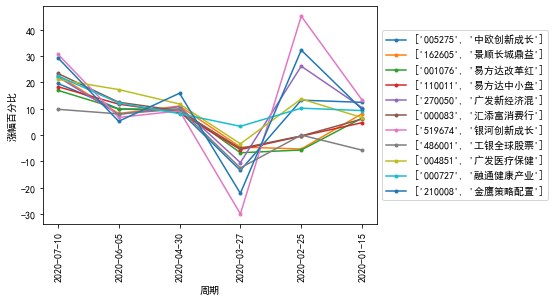

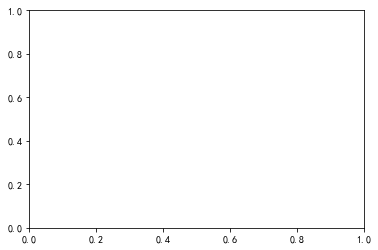

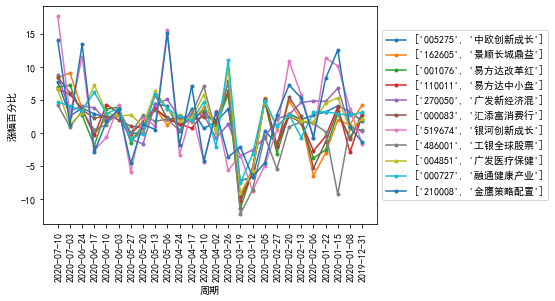

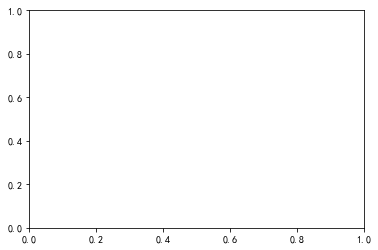

*** fund_top ***
      基金代码    基金简称        最新日期  2020-07-10  2020-06-05  2020-04-30  \
6   519674  银河创新成长  2020-07-10       30.76        6.70        9.18   
10  210008  金鹰策略配置  2020-07-10       29.39        5.25       15.87   
5   000083  汇添富消费行  2020-07-10       23.41       12.47        9.21   
1   162605  景顺长城鼎益  2020-07-10       22.76        8.19       11.02   
9   000727  融通健康产业  2020-07-10       22.45       12.22        8.14   

    2020-03-27  2020-02-25  2020-01-15  
6       -29.87       45.11       13.26  
10      -22.09       32.24        9.73  
5        -5.05       -0.33        6.11  
1        -4.54       -5.28        8.12  
9         3.33       10.20        9.31  
*** fund_top ***
     基金代码    基金简称        最新日期  2020-07-10  2020-06-05  2020-04-30  2020-03-27  \
8  004851  广发医疗保健  2020-07-10       21.15       17.27       11.80       -3.30   
5  000083  汇添富消费行  2020-07-10       23.41       12.47        9.21       -5.05   
9  000727  融通健康产业  2020-07-10       22.45       12.22   

ConversionError: Failed to convert value(s) to axis units: array(['2020-07-10', '2020-06-05', '2020-04-30', '2020-03-27',
       '2020-02-25', '2020-01-15'], dtype=object)

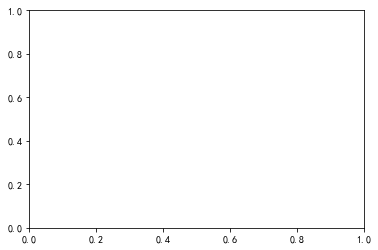

In [142]:

def main():
    url="http://fundf10.eastmoney.com/jjjz_000066.html"
    

if __name__ == '__main__':
    
    #基金详细交易信息获取后，保存到该名称的execl中
    sourceexecl="fund_mingxi"
    #对获取的基金信息进行编辑，增加10列后保存的execl名称
    editexecl="fundedit"
    #对月份进行排序取交集保存的execl名称
    sortexecl="fund_month_sort"
    #对年份进行排序取交集保存的execl名称
    sort1execl="find_year_sort"
    #对基金明细数据进行保存的execl名称
    allfunds_detailexecl="allfund_trans_detail"

    #对我持有基金明细数据进行保存的execl名称
    myfunds_detailexecl="myfunds_trans_detail"

    #获取当天日期
    cur_day=time.strftime("%Y-%m-%d", time.localtime())

    my_funds = ["5275", "162605", "110011", "270050", "83", "519674", "486001", "727","210008"]

    #调用函数，打开url，抓取最后一个交易日日期
    url="http://fundf10.eastmoney.com/jjjz_000066.html"
    driver = open_url(url)
    lasttrans_day=driver.find_element_by_xpath('//*[@id="jztable"]/table/tbody/tr[1]/td[1]').text

    #读取最全的基金的信息，并转换成pd
    edit_funds=pd.read_excel(r"C:\工作\pychram\111\fund_get\data\2020-07-11\fundedit.xls")
    #创建一个pd，只包含两列数据
    all_funds=edit_funds[['基金代码','基金简称']]

    #从全量的基金pd中，获取我持有列表的基金代码和基金名称的pd
    myfunds_numname = fund_num_name(all_funds,*my_funds)

    #对我持有的基金代码和基金名称pd，抓取每只基金的交易明细， 保存为myfunds_detailexecl的execl文件， 并返回一个我持有基金明细数据的pd
    my_f=getfund_mingxi(myfunds_numname,myfunds_detailexecl)
    
    #退出chrome
    driver.quit()

    #读取detailexecl的execl文件， 并去掉首列的内容，获取个全量明细的pd
    #xx=pd.read_excel(myfunds_detailexecl+".xlsx", usecols=[1,2,3,4,5,6])

    #读取我持有基金的基金明细的pd，按照“week/month" 来计算涨幅，日期按照间隔5个工作日来算， 返回我持有基金最近26周的每周涨幅
    my_w_rate1 = fund_rate(my_f,"week","WD",5)

    #读取我持有基金的基金明细的pd，按照“week/month" 来计算涨幅，日期按照间隔23个工作日来算，返回我持有基金最近6月的每月涨幅
    my_m_rate1 = fund_rate(my_f,"month","WD",23)

    #对按月的涨幅进行画图
    pic_execl(my_m_rate1,"6month",3,9)
    #对按周的涨幅进行画图
    pic_execl(my_w_rate1,"26week",3,29)
    
    #对按月涨幅的全量数据，取每个月的涨幅前五，取交集
    my_sort_inner_rate = myfund_rate_sort(my_m_rate1,"month",5)
    try:
        pic_execl(my_sort_inner_rate,"my_top5_6month",3,9)
    except ValueError:
        print("Can't find inner funds")
    else:
        pass

In [70]:
    filenum = 1
    while len(all_funds) !=0 :
        #计划用3个线程进行明细数据抓取，这里定义每个线程抓取哪些基金
        count = int(len(all_funds)/3)
        funds_part1=all_funds.iloc[:count]
        funds_part2=all_funds.iloc[count:count*2]
        funds_part3=all_funds.iloc[count*2:]

        #启动三个浏览器，进行多线程程的抓取
        driver3 = webdriver.Chrome(executable_path=chrome_driver)
        driver1 = webdriver.Chrome(executable_path=chrome_driver1)
        driver2 = webdriver.Chrome(executable_path=chrome_driver2)

        '''
        启动第一个线程，该线程使用驱动器1，将参数传给多线程抓取函数，处理第一部分基金，抓取1页（20个工作日的基金明细），
        多线程处理抓取的数据结果会放置到全局变量的tmp_funds1 的pd中
        '''
        print("开始多线程抓取时间：")
        print (time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
        t1 = threading.Thread(target=getfund_mingxi_mt , args=(funds_part1,driver1,1))
        t1.start()
        t2 = threading.Thread(target=getfund_mingxi_mt , args=(funds_part2,driver2,1))
        t2.start()
        t3 = threading.Thread(target=getfund_mingxi_mt , args=(funds_part3,driver3,1))
        t3.start()
        t1.join()
        t2.join()
        t3.join()
        print("结束多线程抓取时间：")
        print (time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

        #上面可能会发生异常退出，并没有抓取完成所有的基金详情，先退出chrome
        driver3.quit()
        driver1.quit()
        driver2.quit()

        #将已经抓取的基金去重，然后基金代码由字符串转为int，因为all_funds中基金代码都是int
        cur_getfunds=tmp_funds1[['基金代码','基金简称']].drop_duplicates()
        cur_getfunds['基金代码'] = pd.to_numeric(cur_getfunds['基金代码'])

        #将all_funds和cur_getfunds取补集，即all_funds中不包含cur_getfunds的部分
        all_funds = all_funds.append(cur_getfunds)
        all_funds = all_funds.append(cur_getfunds)
        all_funds = all_funds.drop_duplicates(subset=['基金代码','基金简称'],keep=False)

        #将重复抓取的内容去掉
        tmp_funds1=tmp_funds1.drop_duplicates()

        filenum = filenum + 1 
        #将多线程抓取的基金明细信息保存到execl中，并且不保存index
        tmp_funds1.to_excel("all_fund_" + str(cur_day) + "_" + str(filenum) + ".xlsx",index=False)

开始多线程抓取时间：
2020-07-13 12:03:02
004448002387
工银沪港深股 http://fundf10.eastmoney.com/jjjz_002387.html

博时汇智回报 http://fundf10.eastmoney.com/jjjz_004448.html
001212
华润元大稳健 http://fundf10.eastmoney.com/jjjz_001212.html
2020-07-10
工银沪港深股 linenum 20
2020-07-10
华润元大稳健 linenum 20
工银沪港深股 ['002387', '工银沪港深股', '2020-07-10', '1.3016', '1.3696', '-1.19%']
华润元大稳健 ['001212', '华润元大稳健', '2020-07-10', '1.0450', '1.0720', '0.10%']
2020-07-10
工银沪港深股 ['002387', '工银沪港深股', '2020-07-09', '1.3173', '1.3853', '1.16%']
博时汇智回报 linenum 20
博时汇智回报 ['004448', '博时汇智回报', '2020-07-10', '2.4217', '2.4217', '1.21%']
华润元大稳健 ['001212', '华润元大稳健', '2020-07-09', '1.0440', '1.0710', '0.00%']
工银沪港深股 ['002387', '工银沪港深股', '2020-07-08', '1.3022', '1.3702', '2.43%']
博时汇智回报 ['004448', '博时汇智回报', '2020-07-09', '2.3927', '2.3927', '1.87%']
华润元大稳健 ['001212', '华润元大稳健', '2020-07-08', '1.0440', '1.0710', '0.00%']
工银沪港深股 ['002387', '工银沪港深股', '2020-07-07', '1.2713', '1.3393', '0.04%']
博时汇智回报 ['004448', '博时汇智回报', '2020-07-08', '2.3487', '2.3487', 

工银沪港深股 ['002387', '工银沪港深股', '2020-05-18', '1.0949', '1.1629', '0.11%']
博时汇智回报 ['004448', '博时汇智回报', '2020-05-19', '1.8995', '1.8995', '1.50%']
华润元大稳健 ['001212', '华润元大稳健', '2020-05-18', '1.0690', '1.0960', '-0.28%']
工银沪港深股 ['002387', '工银沪港深股', '2020-05-15', '1.0937', '1.1617', '0.16%']
博时汇智回报 ['004448', '博时汇智回报', '2020-05-18', '1.8715', '1.8715', '0.02%']
华润元大稳健 ['001212', '华润元大稳健', '2020-05-15', '1.0720', '1.0990', '0.28%']
工银沪港深股 ['002387', '工银沪港深股', '2020-05-14', '1.0919', '1.1599', '-0.74%']
工银沪港深股 ******click*******
博时汇智回报 ['004448', '博时汇智回报', '2020-05-15', '1.8712', '1.8712', '0.11%']
华润元大稳健 ['001212', '华润元大稳健', '2020-05-14', '1.0690', '1.0960', '0.00%']
华润元大稳健 ******click*******
博时汇智回报 ['004448', '博时汇智回报', '2020-05-14', '1.8692', '1.8692', '0.35%']
博时汇智回报 ******click*******
Choose another way to click next page
Choose another way to click next page
Choose another way to click next page
工银沪港深股 linenum 20
工银沪港深股 ['002387', '工银沪港深股', '2020-05-13', '1.1000', '1.1680', '0.42%']
华润元大稳健 

兴全全球视野 ['340006', '兴全全球视野', '2020-06-22', '2.3875', '5.1335', '0.39%']
泰达宏利泰和 ['006306', '泰达宏利泰和', '2020-06-17', '1.1517', '1.1517', '0.12%']
汇安鼎利纯债 ['006432', '汇安鼎利纯债', '2020-06-17', '1.0037', '1.0037', '-0.02%']
兴全全球视野 ['340006', '兴全全球视野', '2020-06-19', '2.3783', '5.1243', '1.35%']
泰达宏利泰和 ['006306', '泰达宏利泰和', '2020-06-16', '1.1503', '1.1503', '1.14%']
汇安鼎利纯债 ['006432', '汇安鼎利纯债', '2020-06-16', '1.0039', '1.0039', '0.01%']
兴全全球视野 ['340006', '兴全全球视野', '2020-06-18', '2.3466', '5.0926', '0.45%']
泰达宏利泰和 ['006306', '泰达宏利泰和', '2020-06-15', '1.1373', '1.1373', '-0.28%']
汇安鼎利纯债 ['006432', '汇安鼎利纯债', '2020-06-15', '1.0038', '1.0038', '-0.03%']
兴全全球视野 ['340006', '兴全全球视野', '2020-06-17', '2.3362', '5.0822', '0.34%']
泰达宏利泰和 ['006306', '泰达宏利泰和', '2020-06-12', '1.1405', '1.1405', '0.16%']
汇安鼎利纯债 ['006432', '汇安鼎利纯债', '2020-06-12', '1.0041', '1.0041', '0.01%']
兴全全球视野 ['340006', '兴全全球视野', '2020-06-16', '2.3282', '5.0742', '1.92%']
泰达宏利泰和 ['006306', '泰达宏利泰和', '2020-06-11', '1.1387', '1.1387', '-0.24%']
汇安

泰达宏利泰和 ['006306', '泰达宏利泰和', '2020-04-21', '1.0857', '1.0857', '-0.45%']
汇安鼎利纯债 ['006432', '汇安鼎利纯债', '2020-04-24', '1.0066', '1.0066', '0.02%']
兴全全球视野 ['340006', '兴全全球视野', '2020-04-27', '2.1107', '4.8567', '0.42%']
泰达宏利泰和 ['006306', '泰达宏利泰和', '2020-04-20', '1.0906', '1.0906', '0.46%']
汇安鼎利纯债 ['006432', '汇安鼎利纯债', '2020-04-23', '1.0064', '1.0064', '0.01%']
兴全全球视野 ['340006', '兴全全球视野', '2020-04-24', '2.1019', '4.8479', '-1.57%']
泰达宏利泰和 ['006306', '泰达宏利泰和', '2020-04-17', '1.0856', '1.0856', '0.32%']
汇安鼎利纯债 ['006432', '汇安鼎利纯债', '2020-04-22', '1.0063', '1.0063', '-0.02%']
兴全全球视野 ['340006', '兴全全球视野', '2020-04-23', '2.1355', '4.8815', '-0.52%']
泰达宏利泰和 ['006306', '泰达宏利泰和', '2020-04-16', '1.0821', '1.0821', '0.32%']
汇安鼎利纯债 ['006432', '汇安鼎利纯债', '2020-04-21', '1.0065', '1.0065', '-0.08%']
兴全全球视野 ['340006', '兴全全球视野', '2020-04-22', '2.1466', '4.8926', '0.80%']
泰达宏利泰和 ['006306', '泰达宏利泰和', '2020-04-15', '1.0786', '1.0786', '-0.24%']
汇安鼎利纯债 ['006432', '汇安鼎利纯债', '2020-04-20', '1.0073', '1.0073', '0.10%']


融通动力先锋 ['161609', '融通动力先锋', '2020-06-02', '1.6330', '2.5960', '-0.61%']
南华瑞扬纯债 ['005048', '南华瑞扬纯债', '2020-06-01', '0.8661', '0.8661', '-0.08%']
工银丰收回报 ['002233', '工银丰收回报', '2020-06-02', '1.3040', '1.3040', '-0.31%']
融通动力先锋 ['161609', '融通动力先锋', '2020-06-01', '1.6430', '2.6060', '3.20%']
南华瑞扬纯债 ['005048', '南华瑞扬纯债', '2020-05-29', '0.8668', '0.8668', '0.01%']
工银丰收回报 ['002233', '工银丰收回报', '2020-06-01', '1.3080', '1.3080', '0.85%']
融通动力先锋 ['161609', '融通动力先锋', '2020-05-29', '1.5920', '2.5550', '0.89%']
南华瑞扬纯债 ['005048', '南华瑞扬纯债', '2020-05-28', '0.8667', '0.8667', '0.05%']
工银丰收回报 ['002233', '工银丰收回报', '2020-05-29', '1.2970', '1.2970', '0.31%']
融通动力先锋 ['161609', '融通动力先锋', '2020-05-28', '1.5780', '2.5410', '-0.44%']
南华瑞扬纯债 ['005048', '南华瑞扬纯债', '2020-05-27', '0.8663', '0.8663', '-0.16%']
工银丰收回报 ['002233', '工银丰收回报', '2020-05-28', '1.2930', '1.2930', '0.15%']
融通动力先锋 ['161609', '融通动力先锋', '2020-05-27', '1.5850', '2.5480', '-0.44%']
南华瑞扬纯债 ['005048', '南华瑞扬纯债', '2020-05-26', '0.8677', '0.8677', '-0.20%']

华富恒盛纯债 ['006406', '华富恒盛纯债', '2020-07-07', '1.0070', '1.0270', '-0.10%']
长盛中证金融 ['160814', '长盛中证金融', '2020-07-07', '0.9920', '', '-0.90%']
广发鑫益混合 ['002133', '广发鑫益混合', '2020-07-03', '1.5490', '1.5490', '1.37%']
华富恒盛纯债 ['006406', '华富恒盛纯债', '2020-07-06', '1.0080', '1.0280', '-0.22%']
长盛中证金融 ['160814', '长盛中证金融', '2020-07-06', '1.0010', '', '8.10%']
广发鑫益混合 ['002133', '广发鑫益混合', '2020-07-02', '1.5280', '1.5280', '0.86%']
华富恒盛纯债 ['006406', '华富恒盛纯债', '2020-07-03', '1.0102', '1.0302', '-0.04%']
长盛中证金融 ['160814', '长盛中证金融', '2020-07-03', '0.9260', '', '3.46%']广发鑫益混合
 ['002133', '广发鑫益混合', '2020-07-01', '1.5150', '1.5150', '0.73%']
华富恒盛纯债 ['006406', '华富恒盛纯债', '2020-07-02', '1.0106', '1.0306', '0.04%']
长盛中证金融 ['160814', '长盛中证金融', '2020-07-02', '0.8950', '', '3.59%']
广发鑫益混合 ['002133', '广发鑫益混合', '2020-06-30', '1.5040', '1.5040', '1.97%']
华富恒盛纯债 ['006406', '华富恒盛纯债', '2020-07-01', '1.0102', '1.0302', '0.02%']
长盛中证金融 ['160814', '长盛中证金融', '2020-07-01', '0.8640', '', '2.73%']
广发鑫益混合 ['002133', '广发鑫益混合', '202

华富恒盛纯债 ['006406', '华富恒盛纯债', '2020-05-12', '1.0341', '1.0441', '0.00%']
长盛中证金融 linenum 20
广发鑫益混合 ['002133', '广发鑫益混合', '2020-05-08', '1.3580', '1.3580', '1.04%']
华富恒盛纯债 ['006406', '华富恒盛纯债', '2020-05-11', '1.0341', '1.0441', '-0.33%']
长盛中证金融 ['160814', '长盛中证金融', '2020-05-13', '0.8220', '', '0.00%']
广发鑫益混合 ['002133', '广发鑫益混合', '2020-05-07', '1.3440', '1.3440', '-0.74%']
华富恒盛纯债 ['006406', '华富恒盛纯债', '2020-05-08', '1.0375', '1.0475', '-0.08%']
长盛中证金融 ['160814', '长盛中证金融', '2020-05-12', '0.8220', '', '-0.60%']
广发鑫益混合 ['002133', '广发鑫益混合', '2020-05-06', '1.3540', '1.3540', '1.58%']
华富恒盛纯债 ['006406', '华富恒盛纯债', '2020-05-07', '1.0383', '1.0483', '-0.15%']
长盛中证金融 ['160814', '长盛中证金融', '2020-05-11', '0.8270', '', '0.36%']
广发鑫益混合 ['002133', '广发鑫益混合', '2020-04-30', '1.3330', '1.3330', '1.83%']
长盛中证金融 ['160814', '长盛中证金融', '2020-05-08', '0.8240', '', '1.23%']
华富恒盛纯债 ['006406', '华富恒盛纯债', '2020-05-06', '1.0399', '1.0499', '-0.09%']
广发鑫益混合 ['002133', '广发鑫益混合', '2020-04-29', '1.3090', '1.3090', '0.85%']
长盛中证金融

鹏华弘嘉混合 ['003165', '鹏华弘嘉混合', '2020-06-15', '1.5250', '1.5250', '0.19%']
鹏华弘嘉混合 ['003165', '鹏华弘嘉混合', '2020-06-12', '1.5221', '1.5221', '0.55%']
鹏华弘嘉混合 ['003165', '鹏华弘嘉混合', '2020-06-11', '1.5138', '1.5138', '-0.53%']
鹏华弘嘉混合 ******click*******
Choose another way to click next page
Choose another way to click next page
圆信永丰兴利 linenum 20
博时量化平衡 linenum 20
圆信永丰兴利 ['001918', '圆信永丰兴利', '2020-06-10', '1.1030', '1.1360', '0.09%']
博时量化平衡 ['004495', '博时量化平衡', '2020-06-10', '1.2168', '1.2168', '-0.20%']
圆信永丰兴利 ['001918', '圆信永丰兴利', '2020-06-09', '1.1020', '1.1350', '0.00%']
博时量化平衡 ['004495', '博时量化平衡', '2020-06-09', '1.2192', '1.2192', '0.35%']
圆信永丰兴利 ['001918', '圆信永丰兴利', '2020-06-08', '1.1020', '1.1350', '0.27%']
博时量化平衡 ['004495', '博时量化平衡', '2020-06-08', '1.2149', '1.2149', '0.36%']
圆信永丰兴利 ['001918', '圆信永丰兴利', '2020-06-05', '1.0990', '1.1320', '-0.36%']
博时量化平衡 ['004495', '博时量化平衡', '2020-06-05', '1.2105', '1.2105', '0.00%']
圆信永丰兴利 ['001918', '圆信永丰兴利', '2020-06-04', '1.1030', '1.1360', '-0.27%']
博时量化平衡

鹏华弘嘉混合 ['003165', '鹏华弘嘉混合', '2020-04-24', '1.3729', '1.3729', '-1.54%']
博时量化平衡 ['004495', '博时量化平衡', '2020-04-15', '1.2361', '1.2361', '0.02%']
圆信永丰兴利 ['001918', '圆信永丰兴利', '2020-04-13', '1.1340', '1.1670', '0.00%']
002877
华夏大中华信 http://fundf10.eastmoney.com/jjjz_002877.html
鹏华弘嘉混合 ['003165', '鹏华弘嘉混合', '2020-04-23', '1.3944', '1.3944', '-0.66%']
博时量化平衡 ['004495', '博时量化平衡', '2020-04-14', '1.2359', '1.2359', '1.07%']
鹏华弘嘉混合 ['003165', '鹏华弘嘉混合', '2020-04-22', '1.4036', '1.4036', '0.75%']
博时量化平衡 ['004495', '博时量化平衡', '2020-04-13', '1.2228', '1.2228', '-1.39%']
003495
鹏华弘尚灵活 http://fundf10.eastmoney.com/jjjz_003495.html
鹏华弘嘉混合 ['003165', '鹏华弘嘉混合', '2020-04-21', '1.3932', '1.3932', '-0.66%']
鹏华弘嘉混合 ['003165', '鹏华弘嘉混合', '2020-04-20', '1.4024', '1.4024', '1.96%']
鹏华弘嘉混合 ['003165', '鹏华弘嘉混合', '2020-04-17', '1.3755', '1.3755', '0.05%']
鹏华弘嘉混合 ['003165', '鹏华弘嘉混合', '2020-04-16', '1.3748', '1.3748', '0.62%']
2020-07-09
鹏华弘嘉混合华夏大中华信 linenum 20
 ['003165', '鹏华弘嘉混合', '2020-04-15', '1.3663', '1.3663', '0.0

鹏华弘尚灵活 ['003495', '鹏华弘尚灵活', '2020-05-22', '1.1491', '1.2491', '-0.14%']
华夏大中华信 ['002877', '华夏大中华信', '2020-05-13', '0.9980', '1.0660', '0.00%']
国泰新经济灵 ['000742', '国泰新经济灵', '2020-06-01', '1.8260', '2.7320', '3.63%']
鹏华弘尚灵活 ['003495', '鹏华弘尚灵活', '2020-05-21', '1.1507', '1.2507', '-0.16%']
华夏大中华信 ['002877', '华夏大中华信', '2020-05-12', '0.9980', '1.0660', '0.40%']
国泰新经济灵 ['000742', '国泰新经济灵', '2020-05-29', '1.7620', '2.6680', '0.80%']
鹏华弘尚灵活 ['003495', '鹏华弘尚灵活', '2020-05-20', '1.1526', '1.2526', '-0.04%']
华夏大中华信 ['002877', '华夏大中华信', '2020-05-11', '0.9940', '1.0620', '0.30%']
国泰新经济灵 ['000742', '国泰新经济灵', '2020-05-28', '1.7480', '2.6540', '-0.85%']
鹏华弘尚灵活 ['003495', '鹏华弘尚灵活', '2020-05-19', '1.1531', '1.2531', '0.17%']
华夏大中华信 ['002877', '华夏大中华信', '2020-05-08', '0.9910', '1.0590', '0.00%']
华夏大中华信国泰新经济灵 ['000742', '国泰新经济灵', '2020-05-27', '1.7630', '2.6690', '-1.23%']
 ******click*******
鹏华弘尚灵活 ['003495', '鹏华弘尚灵活', '2020-05-18', '1.1512', '1.2512', '-0.01%']
国泰新经济灵 ['000742', '国泰新经济灵', '2020-05-26', '1.

中信建投聚利 ['006845', '中信建投聚利', '2020-06-24', '1.1688', '1.1688', '-0.59%']
招商丰盛稳定 ['000530', '招商丰盛稳定', '2020-07-08', '1.8530', '1.8530', '1.09%']
格林伯锐灵活 ['006181', '格林伯锐灵活', '2020-06-22', '0.8145', '0.8145', '0.05%']
中信建投聚利 ['006845', '中信建投聚利', '2020-06-23', '1.1757', '1.1757', '1.54%']
招商丰盛稳定 ['000530', '招商丰盛稳定', '2020-07-07', '1.8330', '1.8330', '3.27%']
格林伯锐灵活 ['006181', '格林伯锐灵活', '2020-06-19', '0.8141', '0.8141', '1.50%']
中信建投聚利 ['006845', '中信建投聚利', '2020-06-22', '1.1579', '1.1579', '0.08%']
招商丰盛稳定 ['000530', '招商丰盛稳定', '2020-07-06', '1.7750', '1.7750', '2.25%']
格林伯锐灵活 ['006181', '格林伯锐灵活', '2020-06-18', '0.8021', '0.8021', '0.28%']
中信建投聚利 ['006845', '中信建投聚利', '2020-06-19', '1.1570', '1.1570', '1.04%']
招商丰盛稳定 ['000530', '招商丰盛稳定', '2020-07-03', '1.7360', '1.7360', '-0.17%']
格林伯锐灵活 ['006181', '格林伯锐灵活', '2020-06-17', '0.7999', '0.7999', '-0.08%']
中信建投聚利 ['006845', '中信建投聚利', '2020-06-18', '1.1451', '1.1451', '-1.61%']
招商丰盛稳定 ['000530', '招商丰盛稳定', '2020-07-02', '1.7390', '1.7390', '-1.19%']
格

中信建投聚利 ['006845', '中信建投聚利', '2020-04-30', '1.0803', '1.0803', '-0.17%']
招商丰盛稳定 linenum 20
格林伯锐灵活 ['006181', '格林伯锐灵活', '2020-04-28', '0.7458', '0.7458', '1.40%']
招商丰盛稳定 ['000530', '招商丰盛稳定', '2020-05-13', '1.5810', '1.5810', '0.64%']中信建投聚利 ['006845', '中信建投聚利', '2020-04-29', '1.0821', '1.0821', '-0.42%']

格林伯锐灵活 ['006181', '格林伯锐灵活', '2020-04-27', '0.7355', '0.7355', '0.91%']
招商丰盛稳定 ['000530', '招商丰盛稳定', '2020-05-12', '1.5710', '1.5710', '1.16%']
中信建投聚利 ['006845', '中信建投聚利', '2020-04-28', '1.0867', '1.0867', '0.06%']
格林伯锐灵活 ['006181', '格林伯锐灵活', '2020-04-24', '0.7289', '0.7289', '-0.80%']
招商丰盛稳定 ['000530', '招商丰盛稳定', '2020-05-11', '1.5530', '1.5530', '-0.38%']
中信建投聚利 ['006845', '中信建投聚利', '2020-04-27', '1.0860', '1.0860', '0.30%']
格林伯锐灵活 ['006181', '格林伯锐灵活', '2020-04-23', '0.7348', '0.7348', '-0.30%']
招商丰盛稳定 ['000530', '招商丰盛稳定', '2020-05-08', '1.5590', '1.5590', '1.04%']
中信建投聚利 ['006845', '中信建投聚利', '2020-04-24', '1.0828', '1.0828', '-0.58%']
格林伯锐灵活 ['006181', '格林伯锐灵活', '2020-04-22', '0.7370', '

国富新机遇混 ['002087', '国富新机遇混', '2020-06-09', '1.2910', '1.3290', '0.23%']
圆信永丰兴利 ['001919', '圆信永丰兴利', '2020-06-05', '1.1140', '1.1400', '-0.27%']
国富新机遇混 ['002087', '国富新机遇混', '2020-06-08', '1.2880', '1.3260', '0.23%']
圆信永丰兴利 ['001919', '圆信永丰兴利', '2020-06-04', '1.1170', '1.1430', '-0.36%']
Choose another way to click next page
国富新机遇混 ['002087', '国富新机遇混', '2020-06-05', '1.2850', '1.3230', '-0.23%']
圆信永丰兴利 ['001919', '圆信永丰兴利', '2020-06-03', '1.1210', '1.1470', '-0.18%']
国富新机遇混 ['002087', '国富新机遇混', '2020-06-04', '1.2880', '1.3260', '0.00%']
圆信永丰兴利 ['001919', '圆信永丰兴利', '2020-06-02', '1.1230', '1.1490', '-0.53%']
国富新机遇混 ['002087', '国富新机遇混', '2020-06-03', '1.2880', '1.3260', '-0.23%']
圆信永丰兴利 ['001919', '圆信永丰兴利', '2020-06-01', '1.1290', '1.1550', '-0.18%']
国富新机遇混 ['002087', '国富新机遇混', '2020-06-02', '1.2910', '1.3290', '-0.15%']
圆信永丰兴利 ['001919', '圆信永丰兴利', '2020-05-29', '1.1310', '1.1570', '0.00%']
国富新机遇混 ['002087', '国富新机遇混', '2020-06-01', '1.2930', '1.3310', '0.47%']
圆信永丰兴利 ['001919', '圆信永丰兴利', '20

英大策略优选 ['001608', '英大策略优选', '2020-04-21', '1.3316', '1.5116', '-0.49%']
英大策略优选 ['001608', '英大策略优选', '2020-04-20', '1.3381', '1.5181', '0.69%']
英大策略优选 ['001608', '英大策略优选', '2020-04-17', '1.3289', '1.5089', '0.33%']
英大策略优选 ['001608', '英大策略优选', '2020-04-16', '1.3245', '1.5045', '1.11%']
2020-07-10
华润元大稳健 linenum 20
英大策略优选 ['001608', '英大策略优选', '2020-04-15', '1.3099', '1.4899', '-0.57%']
华润元大稳健 ['001213', '华润元大稳健', '2020-07-10', '1.0340', '1.0540', '0.10%']
2020-07-10
英大策略优选 ['001608', '英大策略优选', '2020-04-14', '1.3174', '1.4974', '2.31%']
招商安裕灵活 linenum 20
华润元大稳健 ['001213', '华润元大稳健', '2020-07-09', '1.0330', '1.0530', '0.00%']
招商安裕灵活 ['002657', '招商安裕灵活', '2020-07-10', '1.3625', '1.3625', '-0.73%']
英大策略优选 ['001608', '英大策略优选', '2020-04-13', '1.2877', '1.4677', '-0.39%']
121010
国投瑞银瑞源 http://fundf10.eastmoney.com/jjjz_121010.html
华润元大稳健 ['001213', '华润元大稳健', '2020-07-08', '1.0330', '1.0530', '-0.10%']
招商安裕灵活 ['002657', '招商安裕灵活', '2020-07-09', '1.3725', '1.3725', '0.89%']
华润元大稳健 ['001213', '华润元大稳健

招商安裕灵活 ['002657', '招商安裕灵活', '2020-05-19', '1.2613', '1.2613', '0.51%']
国投瑞银瑞源 ['121010', '国投瑞银瑞源', '2020-05-27', '1.8271', '2.0794', '-0.88%']
华润元大稳健 ['001213', '华润元大稳健', '2020-05-15', '1.0610', '1.0810', '0.19%']
招商安裕灵活 ['002657', '招商安裕灵活', '2020-05-18', '1.2549', '1.2549', '-0.01%']
国投瑞银瑞源 ['121010', '国投瑞银瑞源', '2020-05-26', '1.8434', '2.0958', '1.87%']
华润元大稳健 ['001213', '华润元大稳健', '2020-05-14', '1.0590', '1.0790', '0.00%']
招商安裕灵活 华润元大稳健 ******click*******
['002657', '招商安裕灵活', '2020-05-15', '1.2550', '1.2550', '-0.10%']
国投瑞银瑞源 ['121010', '国投瑞银瑞源', '2020-05-25', '1.8096', '2.0619', '0.04%']
招商安裕灵活 ['002657', '招商安裕灵活', '2020-05-14', '1.2562', '1.2562', '-0.78%']
招商安裕灵活 ******click*******
国投瑞银瑞源 ['121010', '国投瑞银瑞源', '2020-05-22', '1.8089', '2.0612', '-1.85%']
国投瑞银瑞源 ['121010', '国投瑞银瑞源', '2020-05-21', '1.8430', '2.0954', '-1.43%']
国投瑞银瑞源 ['121010', '国投瑞银瑞源', '2020-05-20', '1.8698', '2.1223', '-0.87%']
国投瑞银瑞源 ['121010', '国投瑞银瑞源', '2020-05-19', '1.8863', '2.1389', '1.14%']
国投瑞银瑞源 ['121010', 

英大策略优选 ['001607', '英大策略优选', '2020-07-02', '1.6514', '1.8314', '1.21%']
光大保德信诚 ['003115', '光大保德信诚', '2020-06-22', '1.1484', '1.1484', '0.26%']
国泰中国企业 ['000103', '国泰中国企业', '2020-06-17', '1.4333', '1.4333', '0.27%']
英大策略优选 ['001607', '英大策略优选', '2020-07-01', '1.6317', '1.8117', '1.19%']
光大保德信诚 ['003115', '光大保德信诚', '2020-06-19', '1.1454', '1.1454', '0.55%']
国泰中国企业 ['000103', '国泰中国企业', '2020-06-16', '1.4295', '1.4295', '0.01%']
英大策略优选 ['001607', '英大策略优选', '2020-06-30', '1.6125', '1.7925', '2.37%']
光大保德信诚 ['003115', '光大保德信诚', '2020-06-18', '1.1391', '1.1391', '0.31%']
国泰中国企业 ['000103', '国泰中国企业', '2020-06-15', '1.4294', '1.4294', '-0.04%']
英大策略优选 ['001607', '英大策略优选', '2020-06-29', '1.5751', '1.7551', '-0.30%']
光大保德信诚 ['003115', '光大保德信诚', '2020-06-17', '1.1356', '1.1356', '-0.02%']
国泰中国企业 ['000103', '国泰中国企业', '2020-06-12', '1.4299', '1.4299', '0.18%']
英大策略优选 ['001607', '英大策略优选', '2020-06-24', '1.5798', '1.7598', '0.53%']
光大保德信诚 ['003115', '光大保德信诚', '2020-06-16', '1.1358', '1.1358', '0.62%']
国泰中

国泰中国企业 ['000103', '国泰中国企业', '2020-04-24', '1.3792', '1.3792', '-0.05%']
光大保德信诚 ['003115', '光大保德信诚', '2020-04-28', '1.1110', '1.1110', '0.31%']
英大策略优选 ['001607', '英大策略优选', '2020-05-08', '1.4457', '1.6257', '1.13%']
国泰中国企业 ['000103', '国泰中国企业', '2020-04-23', '1.3799', '1.3799', '0.09%']
光大保德信诚 ['003115', '光大保德信诚', '2020-04-27', '1.1076', '1.1076', '0.41%']
英大策略优选 ['001607', '英大策略优选', '2020-05-07', '1.4295', '1.6095', '-0.51%']
国泰中国企业 ['000103', '国泰中国企业', '2020-04-22', '1.3786', '1.3786', '-0.48%']
光大保德信诚 ['003115', '光大保德信诚', '2020-04-24', '1.1031', '1.1031', '-0.16%']
英大策略优选 ['001607', '英大策略优选', '2020-05-06', '1.4368', '1.6168', '0.67%']
国泰中国企业 ['000103', '国泰中国企业', '2020-04-21', '1.3852', '1.3852', '-0.35%']
光大保德信诚 ['003115', '光大保德信诚', '2020-04-23', '1.1049', '1.1049', '-0.16%']
英大策略优选 ['001607', '英大策略优选', '2020-04-30', '1.4273', '1.6073', '1.60%']
国泰中国企业 ['000103', '国泰中国企业', '2020-04-20', '1.3901', '1.3901', '0.22%']
光大保德信诚 ['003115', '光大保德信诚', '2020-04-22', '1.1067', '1.1067', '0.20%']


长盛盛和纯债 ['002927', '长盛盛和纯债', '2020-06-02', '1.0097', '1.0955', '-0.45%']
民生加银新战 ['001352', '民生加银新战', '2020-06-02', '1.4210', '1.4210', '-0.28%']
嘉合锦程混合 linenum 20
长盛盛和纯债 ['002927', '长盛盛和纯债', '2020-06-01', '1.0143', '1.1001', '-0.05%']
民生加银新战 ['001352', '民生加银新战', '2020-06-01', '1.4250', '1.4250', '0.71%']
嘉合锦程混合 ['006425', '嘉合锦程混合', '2020-06-10', '1.3228', '1.4228', '0.69%']
长盛盛和纯债 ['002927', '长盛盛和纯债', '2020-05-29', '1.0148', '1.1006', '0.00%']
民生加银新战 ['001352', '民生加银新战', '2020-05-29', '1.4150', '1.4150', '0.28%']
嘉合锦程混合 ['006425', '嘉合锦程混合', '2020-06-09', '1.3138', '1.4138', '0.91%']
长盛盛和纯债 ['002927', '长盛盛和纯债', '2020-05-28', '1.0148', '1.1006', '-0.01%']
民生加银新战 ['001352', '民生加银新战', '2020-05-28', '1.4110', '1.4110', '0.21%']
嘉合锦程混合 ['006425', '嘉合锦程混合', '2020-06-08', '1.3020', '1.4020', '-0.47%']
长盛盛和纯债 ['002927', '长盛盛和纯债', '2020-05-27', '1.0149', '1.1007', '-0.14%']
民生加银新战 ['001352', '民生加银新战', '2020-05-27', '1.4080', '1.4080', '-0.49%']
嘉合锦程混合 ['006425', '嘉合锦程混合', '2020-06-05', '1.3081', 

格林伯锐灵活 ['006182', '格林伯锐灵活', '2020-07-10', '0.9165', '0.9165', '-1.25%']
鹏华弘尚灵活 ['003496', '鹏华弘尚灵活', '2020-07-09', '1.2610', '1.3160', '0.66%']
格林伯锐灵活 ['006182', '格林伯锐灵活', '2020-07-09', '0.9281', '0.9281', '1.18%']
鹏华弘尚灵活 ['003496', '鹏华弘尚灵活', '2020-07-08', '1.2527', '1.3077', '0.72%']
格林伯锐灵活 ['006182', '格林伯锐灵活', '2020-07-08', '0.9173', '0.9173', '0.85%']
鹏华弘尚灵活 ['003496', '鹏华弘尚灵活', '2020-07-07', '1.2437', '1.2987', '0.24%']
2020-07-10
金鹰多元策略 linenum 20
格林伯锐灵活 ['006182', '格林伯锐灵活', '2020-07-07', '0.9096', '0.9096', '1.45%']
金鹰多元策略 ['002844', '金鹰多元策略', '2020-07-10', '1.8519', '1.8519', '1.00%']
鹏华弘尚灵活 ['003496', '鹏华弘尚灵活', '2020-07-06', '1.2407', '1.2957', '0.92%']
格林伯锐灵活 ['006182', '格林伯锐灵活', '2020-07-06', '0.8966', '0.8966', '3.97%']
金鹰多元策略 ['002844', '金鹰多元策略', '2020-07-09', '1.8336', '1.8336', '3.87%']
鹏华弘尚灵活 ['003496', '鹏华弘尚灵活', '2020-07-03', '1.2294', '1.2844', '0.18%']
格林伯锐灵活 ['006182', '格林伯锐灵活', '2020-07-03', '0.8624', '0.8624', '0.92%']
金鹰多元策略 ['002844', '金鹰多元策略', '2020-07-08', '1.76

金鹰多元策略 ['002844', '金鹰多元策略', '2020-05-22', '1.4163', '1.4163', '-1.05%']
金鹰多元策略 ['002844', '金鹰多元策略', '2020-05-21', '1.4314', '1.4314', '-3.71%']
金鹰多元策略 ['002844', '金鹰多元策略', '2020-05-20', '1.4866', '1.4866', '-3.22%']
金鹰多元策略 ['002844', '金鹰多元策略', '2020-05-19', '1.5361', '1.5361', '4.75%']
金鹰多元策略 ['002844', '金鹰多元策略', '2020-05-18', '1.4665', '1.4665', '-3.10%']
金鹰多元策略 ['002844', '金鹰多元策略', '2020-05-15', '1.5134', '1.5134', '4.14%']
金鹰多元策略 ['002844', '金鹰多元策略', '2020-05-14', '1.4532', '1.4532', '-0.51%']
金鹰多元策略 ******click*******
Choose another way to click next page
Choose another way to click next page
格林伯锐灵活 linenum 20
鹏华弘尚灵活 linenum 20
格林伯锐灵活 ['006182', '格林伯锐灵活', '2020-05-13', '0.7683', '0.7683', '0.55%']
鹏华弘尚灵活 ['003496', '鹏华弘尚灵活', '2020-05-13', '1.1981', '1.2531', '-0.07%']
格林伯锐灵活 ['006182', '格林伯锐灵活', '2020-05-12', '0.7641', '0.7641', '0.58%']
鹏华弘尚灵活 ['003496', '鹏华弘尚灵活', '2020-05-12', '1.1989', '1.2539', '-0.12%']
格林伯锐灵活 ['006182', '格林伯锐灵活', '2020-05-11', '0.7597', '0.7597', '-0.18%']
鹏华

金元顺安宝石 ['620001', '金元顺安宝石', '2020-06-16', '1.2426', '1.3026', '0.84%']
华夏行业混合 ['160314', '华夏行业混合', '2020-06-23', '1.3930', '7.5070', '1.16%']
中邮稳健合赢 ['002278', '中邮稳健合赢', '2020-06-15', '1.0390', '1.0590', '0.10%']
金元顺安宝石 ['620001', '金元顺安宝石', '2020-06-15', '1.2323', '1.2923', '-1.26%']
华夏行业混合 ['160314', '华夏行业混合', '2020-06-22', '1.3770', '7.4490', '0.81%']
中邮稳健合赢 ['002278', '中邮稳健合赢', '2020-06-12', '1.0380', '1.0580', '0.00%']
金元顺安宝石 ['620001', '金元顺安宝石', '2020-06-12', '1.2480', '1.3080', '0.45%']
华夏行业混合 ['160314', '华夏行业混合', '2020-06-19', '1.3660', '7.4090', '0.81%']
中邮稳健合赢 ['002278', '中邮稳健合赢', '2020-06-11', '1.0380', '1.0580', '0.00%']
中邮稳健合赢金元顺安宝石 ******click*******
 ['620001', '金元顺安宝石', '2020-06-11', '1.2424', '1.3024', '-0.70%']
金元顺安宝石 ******click*******
华夏行业混合 ['160314', '华夏行业混合', '2020-06-18', '1.3550', '7.3690', '1.04%']
华夏行业混合 ['160314', '华夏行业混合', '2020-06-17', '1.3410', '7.3180', '-0.30%']
华夏行业混合 ['160314', '华夏行业混合', '2020-06-16', '1.3450', '7.3320', '2.05%']
华夏行业混合 ['160314', '华夏行

金元顺安宝石 ['620001', '金元顺安宝石', '2020-04-22', '1.1785', '1.2385', '0.95%']
中邮稳健合赢 ['002278', '中邮稳健合赢', '2020-04-21', '1.0650', '1.0850', '-0.09%']
华夏行业混合 ['160314', '华夏行业混合', '2020-04-27', '1.1670', '6.6830', '0.52%']
金元顺安宝石 ['620001', '金元顺安宝石', '2020-04-21', '1.1674', '1.2274', '-0.87%']
中邮稳健合赢 ['002278', '中邮稳健合赢', '2020-04-20', '1.0660', '1.0860', '0.09%']
华夏行业混合 ['160314', '华夏行业混合', '2020-04-24', '1.1610', '6.6610', '-2.11%']
金元顺安宝石 ['620001', '金元顺安宝石', '2020-04-20', '1.1776', '1.2376', '0.34%']
中邮稳健合赢 ['002278', '中邮稳健合赢', '2020-04-17', '1.0650', '1.0850', '0.09%']
华夏行业混合 ['160314', '华夏行业混合', '2020-04-23', '1.1860', '6.7520', '-0.84%']
金元顺安宝石 ['620001', '金元顺安宝石', '2020-04-17', '1.1736', '1.2336', '0.89%']
中邮稳健合赢 ['002278', '中邮稳健合赢', '2020-04-16', '1.0640', '1.0840', '0.00%']
华夏行业混合 ['160314', '华夏行业混合', '2020-04-22', '1.1960', '6.7890', '0.67%']
金元顺安宝石 ['620001', '金元顺安宝石', '2020-04-16', '1.1633', '1.2233', '-0.09%']
中邮稳健合赢 ['002278', '中邮稳健合赢', '2020-04-15', '1.0640', '1.0840', '-0.09%']


东海祥利纯债 ['006747', '东海祥利纯债', '2020-05-25', '1.0246', '1.0246', '-0.16%']
大成消费主题 ['090016', '大成消费主题', '2020-05-27', '1.1290', '1.3860', '-1.22%']
东海祥利纯债 ['006747', '东海祥利纯债', '2020-05-22', '1.0262', '1.0262', '0.21%']
大成消费主题 ['090016', '大成消费主题', '2020-05-26', '1.1430', '1.4000', '1.69%']
东海祥利纯债 ['006747', '东海祥利纯债', '2020-05-21', '1.0240', '1.0240', '0.01%']
大成消费主题 ['090016', '大成消费主题', '2020-05-25', '1.1240', '1.3810', '1.44%']
东海祥利纯债 ['006747', '东海祥利纯债', '2020-05-20', '1.0239', '1.0239', '0.13%']
大成消费主题 ['090016', '大成消费主题', '2020-05-22', '1.1080', '1.3650', '-2.03%']
易方达资源行 linenum 20
东海祥利纯债 ['006747', '东海祥利纯债', '2020-05-19', '1.0226', '1.0226', '-0.05%']
大成消费主题 ['090016', '大成消费主题', '2020-05-21', '1.1310', '1.3880', '0.44%']
易方达资源行 ['110025', '易方达资源行', '2020-06-10', '0.7710', '0.7710', '-0.13%']
东海祥利纯债 ['006747', '东海祥利纯债', '2020-05-18', '1.0231', '1.0231', '-0.13%']
大成消费主题 ['090016', '大成消费主题', '2020-05-20', '1.1260', '1.3830', '-1.23%']
易方达资源行 ['110025', '易方达资源行', '2020-06-09', '0.7720', 

华夏大中华信 ['002880', '华夏大中华信', '2020-06-24', '1.0140', '1.0660', '0.00%']
民生加银内需 ['690005', '民生加银内需', '2020-07-03', '2.3320', '2.7140', '-0.21%']
华夏大中华信 ['002880', '华夏大中华信', '2020-06-23', '1.0140', '1.0660', '-0.10%']
民生加银内需 ['690005', '民生加银内需', '2020-07-02', '2.3370', '2.7190', '-0.17%']
华夏大中华信2020-07-10
 ['002880', '华夏大中华信', '2020-06-22', '1.0150', '1.0670', '0.00%']
平安鑫享混合 linenum 20
民生加银内需 ['690005', '民生加银内需', '2020-07-01', '2.3410', '2.7230', '0.91%']
华夏大中华信 ['002880', '华夏大中华信', '2020-06-19', '1.0150', '1.0670', '0.10%']
平安鑫享混合 ['001610', '平安鑫享混合', '2020-07-10', '1.3818', '1.3818', '-0.16%']
民生加银内需 ['690005', '民生加银内需', '2020-06-30', '2.3200', '2.7020', '2.16%']
华夏大中华信 ['002880', '华夏大中华信', '2020-06-18', '1.0140', '1.0660', '0.30%']
平安鑫享混合 ['001610', '平安鑫享混合', '2020-07-09', '1.3840', '1.3840', '2.16%']
民生加银内需 ['690005', '民生加银内需', '2020-06-29', '2.2710', '2.6530', '0.40%']
华夏大中华信 ['002880', '华夏大中华信', '2020-06-17', '1.0110', '1.0630', '0.20%']
平安鑫享混合 ['001610', '平安鑫享混合', '2020-07-08', '1

民生加银内需华夏大中华信 ['002880', '华夏大中华信', '2020-04-29', '0.9830', '1.0350', '0.20%']
 ['690005', '民生加银内需', '2020-05-13', '2.1090', '2.4910', '0.76%']
华夏大中华信 ['002880', '华夏大中华信', '2020-04-28', '0.9810', '1.0330', '0.10%']
民生加银内需 ['690005', '民生加银内需', '2020-05-12', '2.0930', '2.4750', '0.87%']
华夏大中华信 ['002880', '华夏大中华信', '2020-04-27', '0.9800', '1.0320', '0.10%']
民生加银内需 ['690005', '民生加银内需', '2020-05-11', '2.0750', '2.4570', '0.29%']
华夏大中华信 ['002880', '华夏大中华信', '2020-04-24', '0.9790', '1.0310', '-0.10%']
民生加银内需 ['690005', '民生加银内需', '2020-05-08', '2.0690', '2.4510', '1.03%']
华夏大中华信 ['002880', '华夏大中华信', '2020-04-23', '0.9800', '1.0320', '0.00%']
民生加银内需 ['690005', '民生加银内需', '2020-05-07', '2.0480', '2.4300', '-0.29%']
华夏大中华信 ['002880', '华夏大中华信', '2020-04-22', '0.9800', '1.0320', '-0.10%']
民生加银内需 ['690005', '民生加银内需', '2020-05-06', '2.0540', '2.4360', '1.63%']
Choose another way to click next page
华夏大中华信 ['002880', '华夏大中华信', '2020-04-21', '0.9810', '1.0330', '-0.10%']
民生加银内需 ['690005', '民生加银内需', '2020-0

东兴量化多策 ['003208', '东兴量化多策', '2020-06-19', '0.6570', '0.6570', '1.15%']
东兴量化多策 ['003208', '东兴量化多策', '2020-06-18', '0.6495', '0.6495', '0.48%']
东兴量化多策 ['003208', '东兴量化多策', '2020-06-17', '0.6464', '0.6464', '-0.05%']
东兴量化多策 ['003208', '东兴量化多策', '2020-06-16', '0.6467', '0.6467', '1.48%']
东兴量化多策 ['003208', '东兴量化多策', '2020-06-15', '0.6373', '0.6373', '-1.24%']
东兴量化多策 ['003208', '东兴量化多策', '2020-06-12', '0.6453', '0.6453', '0.39%']
东兴量化多策 ['003208', '东兴量化多策', '2020-06-11', '0.6428', '0.6428', '-0.29%']
东兴量化多策 ******click*******
Choose another way to click next page
Choose another way to click next page
创金合信春来 linenum 20
创金合信春来 ['005799', '创金合信春来', '2020-03-27', '1.0073', '1.0073', '--']
招商丰利灵活 linenum 20
招商丰利灵活 ['000679', '招商丰利灵活', '2020-06-10', '1.4970', '1.4970', '1.42%']
创金合信春来 ['005799', '创金合信春来', '2020-03-20', '1.0073', '1.0073', '--']
招商丰利灵活 ['000679', '招商丰利灵活', '2020-06-09', '1.4760', '1.4760', '0.89%']
创金合信春来 ['005799', '创金合信春来', '2020-03-13', '1.0071', '1.0071', '--']
招商丰利灵活 ['000679'

招商丰利灵活 ['000679', '招商丰利灵活', '2020-04-15', '1.2680', '1.2680', '-0.78%']
东兴量化多策 ['003208', '东兴量化多策', '2020-04-23', '0.6085', '0.6085', '-0.07%']
创金合信春来 ['005799', '创金合信春来', '2019-07-19', '1.0028', '1.0028', '--']
招商丰利灵活 ['000679', '招商丰利灵活', '2020-04-14', '1.2780', '1.2780', '2.82%']
东兴量化多策 ['003208', '东兴量化多策', '2020-04-22', '0.6089', '0.6089', '0.73%']
创金合信春来 ['005799', '创金合信春来', '2019-07-12', '1.0028', '1.0028', '--']
招商丰利灵活002928
长盛盛和纯债 http://fundf10.eastmoney.com/jjjz_002928.html
 ['000679', '招商丰利灵活', '2020-04-13', '1.2430', '1.2430', '0.00%']
001726
汇添富新兴消 http://fundf10.eastmoney.com/jjjz_001726.html
东兴量化多策 ['003208', '东兴量化多策', '2020-04-21', '0.6045', '0.6045', '-1.21%']
东兴量化多策 ['003208', '东兴量化多策', '2020-04-20', '0.6119', '0.6119', '0.53%']
东兴量化多策 ['003208', '东兴量化多策', '2020-04-17', '0.6087', '0.6087', '1.25%']
东兴量化多策 ['003208', '东兴量化多策', '2020-04-16', '0.6012', '0.6012', '0.48%']
东兴量化多策 ['003208', '东兴量化多策', '2020-04-15', '0.5983', '0.5983', '-0.81%']
东兴量化多策 ['003208', '东兴量化多策', '2

汇添富新兴消 ['001726', '汇添富新兴消', '2020-05-21', '1.2430', '1.2430', '-0.24%']
长盛盛和纯债 ['002928', '长盛盛和纯债', '2020-05-20', '1.0149', '1.0993', '0.03%']
诺安汇利灵活 ['005902', '诺安汇利灵活', '2020-06-01', '1.1567', '1.1567', '1.57%']
汇添富新兴消 ['001726', '汇添富新兴消', '2020-05-20', '1.2460', '1.2460', '-1.74%']
长盛盛和纯债 ['002928', '长盛盛和纯债', '2020-05-19', '1.0146', '1.0990', '-0.10%']
诺安汇利灵活 ['005902', '诺安汇利灵活', '2020-05-29', '1.1388', '1.1388', '0.04%']
汇添富新兴消 ['001726', '汇添富新兴消', '2020-05-19', '1.2680', '1.2680', '1.20%']
长盛盛和纯债 ['002928', '长盛盛和纯债', '2020-05-18', '1.0156', '1.1000', '-0.06%']
诺安汇利灵活 ['005902', '诺安汇利灵活', '2020-05-28', '1.1384', '1.1384', '0.29%']
汇添富新兴消 ['001726', '汇添富新兴消', '2020-05-18', '1.2530', '1.2530', '0.56%']
长盛盛和纯债 ['002928', '长盛盛和纯债', '2020-05-15', '1.0162', '1.1006', '0.10%']
诺安汇利灵活 ['005902', '诺安汇利灵活', '2020-05-27', '1.1351', '1.1351', '-0.20%']
汇添富新兴消 ['001726', '汇添富新兴消', '2020-05-15', '1.2460', '1.2460', '-0.24%']
长盛盛和纯债 ['002928', '长盛盛和纯债', '2020-05-14', '1.0152', '1.0996', '0.03%']


银河中证沪港 ['501307', '银河中证沪港', '2020-06-24', '0.9102', '0.9102', '-0.42%']
海富通强化回 ['519007', '海富通强化回', '2020-07-03', '0.8700', '2.3660', '1.28%']
金鹰民族新兴 ['001298', '金鹰民族新兴', '2020-06-23', '1.6170', '1.6170', '2.34%']
银河中证沪港 ['501307', '银河中证沪港', '2020-06-23', '0.9140', '0.9140', '-0.23%']
海富通强化回 ['519007', '海富通强化回', '2020-07-02', '0.8590', '2.3550', '1.66%']
金鹰民族新兴 ['001298', '金鹰民族新兴', '2020-06-22', '1.5800', '1.5800', '1.02%']
银河中证沪港 ['501307', '银河中证沪港', '2020-06-22', '0.9161', '0.9161', '-0.95%']
海富通强化回 ['519007', '海富通强化回', '2020-07-01', '0.8450', '2.3410', '0.96%']
金鹰民族新兴 ['001298', '金鹰民族新兴', '2020-06-19', '1.5640', '1.5640', '1.36%']
银河中证沪港 ['501307', '银河中证沪港', '2020-06-19', '0.9249', '0.9249', '0.49%']
海富通强化回 ['519007', '海富通强化回', '2020-06-30', '0.8370', '2.3330', '0.97%']
金鹰民族新兴 ['001298', '金鹰民族新兴', '2020-06-18', '1.5430', '1.5430', '-0.64%']
银河中证沪港 ['501307', '银河中证沪港', '2020-06-18', '0.9204', '0.9204', '0.91%']
海富通强化回 ['519007', '海富通强化回', '2020-06-29', '0.8290', '2.3250', '-0.36%']
金

海富通强化回 ['519007', '海富通强化回', '2020-05-08', '0.8130', '2.3090', '0.25%']
金鹰民族新兴 ['001298', '金鹰民族新兴', '2020-04-28', '1.4050', '1.4050', '-0.50%']
银河中证沪港 ['501307', '银河中证沪港', '2020-04-28', '0.8899', '0.8899', '0.60%']
海富通强化回 ['519007', '海富通强化回', '2020-05-07', '0.8110', '2.3070', '-0.12%']
金鹰民族新兴 ['001298', '金鹰民族新兴', '2020-04-27', '1.4120', '1.4120', '0.14%']
银河中证沪港 ['501307', '银河中证沪港', '2020-04-27', '0.8846', '0.8846', '1.49%']
海富通强化回 ['519007', '海富通强化回', '2020-05-06', '0.8120', '2.3080', '0.12%']
金鹰民族新兴 ['001298', '金鹰民族新兴', '2020-04-24', '1.4100', '1.4100', '-2.02%']
银河中证沪港 ['501307', '银河中证沪港', '2020-04-24', '0.8716', '0.8716', '-0.67%']
海富通强化回 ['519007', '海富通强化回', '2020-04-30', '0.8110', '2.3070', '0.25%']
金鹰民族新兴 ['001298', '金鹰民族新兴', '2020-04-23', '1.4390', '1.4390', '-0.55%']
银河中证沪港 ['501307', '银河中证沪港', '2020-04-23', '0.8775', '0.8775', '-0.15%']
海富通强化回 ['519007', '海富通强化回', '2020-04-29', '0.8090', '2.3050', '0.25%']
金鹰民族新兴 ['001298', '金鹰民族新兴', '2020-04-22', '1.4470', '1.4470', '1.97%']


人保鑫泽纯债 ['006854', '人保鑫泽纯债', '2020-06-05', '0.9789', '0.9789', '-0.12%']
泰康港股通T ['006930', '泰康港股通T', '2020-06-10', '0.9590', '0.9590', '0.48%']
泰达宏利绩优 ['005903', '泰达宏利绩优', '2020-06-04', '1.5821', '1.5821', '0.25%']
人保鑫泽纯债 ['006854', '人保鑫泽纯债', '2020-06-04', '0.9801', '0.9801', '-0.09%']
泰康港股通T ['006930', '泰康港股通T', '2020-06-09', '0.9544', '0.9544', '0.56%']
泰达宏利绩优 ['005903', '泰达宏利绩优', '2020-06-03', '1.5782', '1.5782', '-0.13%']
人保鑫泽纯债 ['006854', '人保鑫泽纯债', '2020-06-03', '0.9810', '0.9810', '-0.19%']
泰康港股通T ['006930', '泰康港股通T', '2020-06-08', '0.9491', '0.9491', '-0.45%']
泰达宏利绩优 ['005903', '泰达宏利绩优', '2020-06-02', '1.5802', '1.5802', '-1.48%']
人保鑫泽纯债 ['006854', '人保鑫泽纯债', '2020-06-02', '0.9829', '0.9829', '0.10%']
泰康港股通T ['006930', '泰康港股通T', '2020-06-05', '0.9534', '0.9534', '1.15%']
泰达宏利绩优 ['005903', '泰达宏利绩优', '2020-06-01', '1.6040', '1.6040', '1.98%']
人保鑫泽纯债 ['006854', '人保鑫泽纯债', '2020-06-01', '0.9819', '0.9819', '0.32%']
泰康港股通T ['006930', '泰康港股通T', '2020-06-04', '0.9426', '0.9426', '-0.21%']

泰康港股通T ['006930', '泰康港股通T', '2020-04-13', '0.9167', '0.9167', '-0.08%']
002088
国富新机遇混 http://fundf10.eastmoney.com/jjjz_002088.html
2020-07-10
鹏华弘嘉混合 linenum 20
鹏华弘嘉混合 ['003166', '鹏华弘嘉混合', '2020-07-10', '1.7669', '1.7669', '-0.45%']
2020-07-10
景顺长城量化 linenum 20
鹏华弘嘉混合 ['003166', '鹏华弘嘉混合', '2020-07-09', '1.7748', '1.7748', '2.84%']
景顺长城量化 ['006106', '景顺长城量化', '2020-07-10', '0.9995', '0.9995', '-2.36%']
鹏华弘嘉混合 ['003166', '鹏华弘嘉混合', '2020-07-08', '1.7258', '1.7258', '1.72%']
景顺长城量化 ['006106', '景顺长城量化', '2020-07-09', '1.0237', '1.0237', '0.05%']
2020-07-10
国富新机遇混 linenum 20
鹏华弘嘉混合 ['003166', '鹏华弘嘉混合', '2020-07-07', '1.6967', '1.6967', '1.03%']
景顺长城量化 ['006106', '景顺长城量化', '2020-07-08', '1.0232', '1.0232', '1.35%']
国富新机遇混 ['002088', '国富新机遇混', '2020-07-10', '1.3450', '1.3770', '-0.44%']
鹏华弘嘉混合 ['003166', '鹏华弘嘉混合', '2020-07-06', '1.6794', '1.6794', '2.94%']
景顺长城量化 ['006106', '景顺长城量化', '2020-07-07', '1.0096', '1.0096', '-2.09%']
国富新机遇混 ['002088', '国富新机遇混', '2020-07-09', '1.3510', '1.3830', '0.67

景顺长城量化 ['006106', '景顺长城量化', '2020-05-18', '0.9121', '0.9121', '0.50%']
国富新机遇混 ['002088', '国富新机遇混', '2020-05-21', '1.2800', '1.3120', '-0.16%']
鹏华弘嘉混合 ['003166', '鹏华弘嘉混合', '2020-05-15', '1.4260', '1.4260', '0.03%']
景顺长城量化 ['006106', '景顺长城量化', '2020-05-15', '0.9076', '0.9076', '-0.36%']
国富新机遇混 ['002088', '国富新机遇混', '2020-05-20', '1.2820', '1.3140', '-0.16%']
鹏华弘嘉混合 ['003166', '鹏华弘嘉混合', '2020-05-14', '1.4256', '1.4256', '-0.92%']
鹏华弘嘉混合景顺长城量化 ******click*******
 ['006106', '景顺长城量化', '2020-05-14', '0.9109', '0.9109', '-1.06%']
景顺长城量化 ******click*******
国富新机遇混 ['002088', '国富新机遇混', '2020-05-19', '1.2840', '1.3160', '0.16%']
国富新机遇混 ['002088', '国富新机遇混', '2020-05-18', '1.2820', '1.3140', '0.16%']
国富新机遇混 ['002088', '国富新机遇混', '2020-05-15', '1.2800', '1.3120', '0.00%']
国富新机遇混 ['002088', '国富新机遇混', '2020-05-14', '1.2800', '1.3120', '-0.16%']
国富新机遇混 ******click*******
Choose another way to click next page
Choose another way to click next page
鹏华弘嘉混合 linenum 20
景顺长城量化 linenum 20
景顺长城量化鹏华弘嘉混合 ['003166',

鹏华资源分级 ['160620', '鹏华资源分级', '2020-06-22', '0.9940', '0.7540', '0.10%']
人保鑫泽纯债 ['006855', '人保鑫泽纯债', '2020-06-18', '0.9782', '0.9782', '0.03%']
大成灵活配置 ['000587', '大成灵活配置', '2020-06-18', '2.2360', '2.6360', '-0.18%']
鹏华资源分级 ['160620', '鹏华资源分级', '2020-06-19', '0.9930', '0.7530', '0.20%']
人保鑫泽纯债 ['006855', '人保鑫泽纯债', '2020-06-17', '0.9779', '0.9779', '-0.01%']
大成灵活配置 ['000587', '大成灵活配置', '2020-06-17', '2.2400', '2.6400', '0.95%']
鹏华资源分级 ['160620', '鹏华资源分级', '2020-06-18', '0.9910', '0.7520', '1.02%']
人保鑫泽纯债 ['006855', '人保鑫泽纯债', '2020-06-16', '0.9780', '0.9780', '0.06%']
大成灵活配置 ['000587', '大成灵活配置', '2020-06-16', '2.2190', '2.6190', '2.40%']
鹏华资源分级 ['160620', '鹏华资源分级', '2020-06-17', '0.9810', '0.7460', '0.41%']
人保鑫泽纯债 ['006855', '人保鑫泽纯债', '2020-06-15', '0.9774', '0.9774', '0.03%']
大成灵活配置 ['000587', '大成灵活配置', '2020-06-15', '2.1670', '2.5670', '0.28%']
鹏华资源分级 ['160620', '鹏华资源分级', '2020-06-16', '0.9770', '0.7430', '2.41%']
人保鑫泽纯债 ['006855', '人保鑫泽纯债', '2020-06-12', '0.9771', '0.9771', '0.03%']
大成灵活

人保鑫泽纯债 ['006855', '人保鑫泽纯债', '2020-04-24', '0.9856', '0.9856', '0.00%']
大成灵活配置 ['000587', '大成灵活配置', '2020-04-24', '1.9250', '2.3250', '-0.31%']
鹏华资源分级 ['160620', '鹏华资源分级', '2020-04-27', '0.9290', '0.7120', '-1.17%']
人保鑫泽纯债 ['006855', '人保鑫泽纯债', '2020-04-23', '0.9856', '0.9856', '0.05%']
大成灵活配置 ['000587', '大成灵活配置', '2020-04-23', '1.9310', '2.3310', '-0.16%']
鹏华资源分级 ['160620', '鹏华资源分级', '2020-04-24', '0.9400', '0.7190', '-1.36%']
人保鑫泽纯债 ['006855', '人保鑫泽纯债', '2020-04-22', '0.9851', '0.9851', '0.02%']
大成灵活配置 ['000587', '大成灵活配置', '2020-04-22', '1.9340', '2.3340', '0.89%']
鹏华资源分级 ['160620', '鹏华资源分级', '2020-04-23', '0.9530', '0.7270', '0.95%']
人保鑫泽纯债 ['006855', '人保鑫泽纯债', '2020-04-21', '0.9849', '0.9849', '0.03%']
大成灵活配置 ['000587', '大成灵活配置', '2020-04-21', '1.9170', '2.3170', '-0.73%']
鹏华资源分级 ['160620', '鹏华资源分级', '2020-04-22', '0.9440', '0.7210', '-0.11%']
人保鑫泽纯债 ['006855', '人保鑫泽纯债', '2020-04-20', '0.9846', '0.9846', '0.06%']
大成灵活配置 ['000587', '大成灵活配置', '2020-04-20', '1.9310', '2.3310', '0.42%']


华宝事件驱动 ['001118', '华宝事件驱动', '2020-06-02', '0.8480', '0.8480', '-1.28%']
博时宏观回报 ['050116', '博时宏观回报', '2020-06-03', '1.3830', '1.5020', '-0.22%']
信达澳银稳定 ['610003', '信达澳银稳定', '2020-06-01', '1.0270', '1.6400', '0.10%']
华宝事件驱动 ['001118', '华宝事件驱动', '2020-06-01', '0.8590', '0.8590', '2.87%']
博时宏观回报 ['050116', '博时宏观回报', '2020-06-02', '1.3860', '1.5050', '-0.36%']
信达澳银稳定 ['610003', '信达澳银稳定', '2020-05-29', '1.0260', '1.6390', '0.00%']
华宝事件驱动 ['001118', '华宝事件驱动', '2020-05-29', '0.8350', '0.8350', '2.20%']
博时宏观回报 ['050116', '博时宏观回报', '2020-06-01', '1.3910', '1.5100', '0.22%']
信达澳银稳定 ['610003', '信达澳银稳定', '2020-05-28', '1.0260', '1.6390', '0.10%']
华宝事件驱动 ['001118', '华宝事件驱动', '2020-05-28', '0.8170', '0.8170', '-0.73%']
博时宏观回报 ['050116', '博时宏观回报', '2020-05-29', '1.3880', '1.5070', '0.14%']
信达澳银稳定 ['610003', '信达澳银稳定', '2020-05-27', '1.0250', '1.6380', '-0.10%']
华宝事件驱动 ['001118', '华宝事件驱动', '2020-05-27', '0.8230', '0.8230', '-0.72%']
博时宏观回报 ['050116', '博时宏观回报', '2020-05-28', '1.3860', '1.5050', '0.07%']


中邮睿利增强 ['002475', '中邮睿利增强', '2020-07-08', '0.9590', '0.9590', '0.00%']
平安睿享文娱 ['002451', '平安睿享文娱', '2020-07-06', '2.2070', '2.2070', '1.52%']
工银成长收益 ['000196', '工银成长收益', '2020-07-07', '1.2750', '1.7010', '0.24%']
中邮睿利增强 ['002475', '中邮睿利增强', '2020-07-07', '0.9590', '0.9590', '0.00%']
平安睿享文娱 ['002451', '平安睿享文娱', '2020-07-03', '2.1740', '2.1740', '-0.32%']
工银成长收益 ['000196', '工银成长收益', '2020-07-06', '1.2720', '1.6970', '2.25%']
中邮睿利增强 ['002475', '中邮睿利增强', '2020-07-06', '0.9590', '0.9590', '0.00%']
平安睿享文娱 ['002451', '平安睿享文娱', '2020-07-02', '2.1810', '2.1810', '-0.27%']
工银成长收益 ['000196', '工银成长收益', '2020-07-03', '1.2440', '1.6600', '0.65%']
中邮睿利增强 ['002475', '中邮睿利增强', '2020-07-03', '0.9590', '0.9590', '0.00%']
平安睿享文娱 ['002451', '平安睿享文娱', '2020-07-01', '2.1870', '2.1870', '-0.27%']
工银成长收益 ['000196', '工银成长收益', '2020-07-02', '1.2360', '1.6490', '0.65%']
中邮睿利增强 ['002475', '中邮睿利增强', '2020-07-02', '0.9590', '0.9590', '0.00%']
平安睿享文娱 ['002451', '平安睿享文娱', '2020-06-30', '2.1930', '2.1930', '2.14%']
工银成

Choose another way to click next page
Choose another way to click next pageChoose another way to click next page

平安睿享文娱 linenum 20
中邮睿利增强 linenum 20
工银成长收益平安睿享文娱 ['002451', '平安睿享文娱', '2020-05-13', '1.9440', '1.9440', '0.88%']
 linenum 20
中邮睿利增强 ['002475', '中邮睿利增强', '2020-05-13', '0.9620', '0.9620', '0.00%']
工银成长收益 ['000196', '工银成长收益', '2020-05-13', '1.1870', '1.5840', '0.17%']
平安睿享文娱 ['002451', '平安睿享文娱', '2020-05-12', '1.9270', '1.9270', '1.31%']
中邮睿利增强 ['002475', '中邮睿利增强', '2020-05-12', '0.9620', '0.9620', '0.00%']
工银成长收益 ['000196', '工银成长收益', '2020-05-12', '1.1850', '1.5810', '-0.08%']
平安睿享文娱 ['002451', '平安睿享文娱', '2020-05-11', '1.9020', '1.9020', '-0.47%']
中邮睿利增强 ['002475', '中邮睿利增强', '2020-05-11', '0.9620', '0.9620', '-0.10%']
工银成长收益 ['000196', '工银成长收益', '2020-05-11', '1.1860', '1.5820', '-0.08%']
平安睿享文娱 ['002451', '平安睿享文娱', '2020-05-08', '1.9110', '1.9110', '0.90%']
中邮睿利增强 ['002475', '中邮睿利增强', '2020-05-08', '0.9630', '0.9630', '0.10%']
工银成长收益 ['000196', '工银成长收益', '2020-05-08', '1.18

银河中证沪港 ['501308', '银河中证沪港', '2020-06-16', '0.9032', '0.9032', '1.62%']
申万菱信多策 ['001724', '申万菱信多策', '2020-06-17', '1.0330', '1.1390', '0.10%']
中欧永裕混合 ['001307', '中欧永裕混合', '2020-06-12', '1.2610', '1.2610', '-0.32%']
银河中证沪港 ['501308', '银河中证沪港', '2020-06-15', '0.8888', '0.8888', '-1.38%']
申万菱信多策 ['001724', '申万菱信多策', '2020-06-16', '1.0320', '1.1380', '1.38%']
中欧永裕混合 ['001307', '中欧永裕混合', '2020-06-11', '1.2650', '1.2650', '-0.55%']
中欧永裕混合银河中证沪港 ******click*******
 ['501308', '银河中证沪港', '2020-06-12', '0.9012', '0.9012', '-0.09%']
申万菱信多策 ['001724', '申万菱信多策', '2020-06-15', '1.0180', '1.1240', '-1.26%']
银河中证沪港 ['501308', '银河中证沪港', '2020-06-11', '0.9020', '0.9020', '-1.74%']
申万菱信多策银河中证沪港 ******click*******
 ['001724', '申万菱信多策', '2020-06-12', '1.0310', '1.1370', '-0.10%']
申万菱信多策 ['001724', '申万菱信多策', '2020-06-11', '1.0320', '1.1380', '-1.15%']
申万菱信多策 ******click*******
Choose another way to click next page
Choose another way to click next page
中欧永裕混合 linenum 20
中欧永裕混合 ['001307', '中欧永裕混合', '2020-06-10

银河中证沪港 ['501308', '银河中证沪港', '2020-04-21', '0.8714', '0.8714', '-1.49%']
中欧永裕混合 ['001307', '中欧永裕混合', '2020-04-17', '1.1490', '1.1490', '0.70%']
申万菱信多策 ['001724', '申万菱信多策', '2020-04-21', '0.9930', '1.0990', '-0.90%']
银河中证沪港 ['501308', '银河中证沪港', '2020-04-20', '0.8846', '0.8846', '-0.35%']
中欧永裕混合 ['001307', '中欧永裕混合', '2020-04-16', '1.1410', '1.1410', '0.71%']
申万菱信多策 ['001724', '申万菱信多策', '2020-04-20', '1.0020', '1.1080', '0.50%']
银河中证沪港 ['501308', '银河中证沪港', '2020-04-17', '0.8877', '0.8877', '1.04%']
中欧永裕混合 ['001307', '中欧永裕混合', '2020-04-15', '1.1330', '1.1330', '-0.87%']
申万菱信多策 ['001724', '申万菱信多策', '2020-04-17', '0.9970', '1.1030', '1.22%']
银河中证沪港 ['501308', '银河中证沪港', '2020-04-16', '0.8786', '0.8786', '-0.35%']
中欧永裕混合 ['001307', '中欧永裕混合', '2020-04-14', '1.1430', '1.1430', '2.70%']
申万菱信多策 ['001724', '申万菱信多策', '2020-04-16', '0.9850', '1.0910', '0.10%']
银河中证沪港 ['501308', '银河中证沪港', '2020-04-15', '0.8817', '0.8817', '-0.97%']
中欧永裕混合 ['001307', '中欧永裕混合', '2020-04-13', '1.1130', '1.1130', '-0.71%']

长信标普10 ['519981', '长信标普10', '2020-05-22', '1.1930', '1.7100', '-0.17%']
广发内需增长 ['270022', '广发内需增长', '2020-05-26', '1.1480', '1.2480', '3.42%']
华夏养老20 ['006623', '华夏养老20', '2020-05-21', '1.0681', '1.0681', '-0.34%']
长信标普10 ['519981', '长信标普10', '2020-05-21', '1.1950', '1.7120', '-0.67%']
广发内需增长 ['270022', '广发内需增长', '2020-05-25', '1.1100', '1.2100', '0.18%']
华夏养老20 ['006623', '华夏养老20', '2020-05-20', '1.0717', '1.0717', '-0.49%']
长信标普10 ['519981', '长信标普10', '2020-05-20', '1.2030', '1.7200', '1.35%']
广发内需增长 ['270022', '广发内需增长', '2020-05-22', '1.1080', '1.2080', '-2.46%']
华夏养老20 ['006623', '华夏养老20', '2020-05-19', '1.0770', '1.0770', '0.73%']
长信标普10 ['519981', '长信标普10', '2020-05-19', '1.1870', '1.7040', '-1.17%']
广发内需增长 ['270022', '广发内需增长', '2020-05-21', '1.1360', '1.2360', '-0.53%']
华夏养老20 ['006623', '华夏养老20', '2020-05-18', '1.0692', '1.0692', '0.11%']
长信标普10 ['519981', '长信标普10', '2020-05-18', '1.2010', '1.7180', '2.83%']
广发内需增长 ['270022', '广发内需增长', '2020-05-20', '1.1420', '1.2420', '-0.26%'

弘毅远方消费 ['006644', '弘毅远方消费', '2020-06-29', '1.7531', '1.7531', '0.92%']
银河君欣债券 ['519631', '银河君欣债券', '2020-07-06', '0.9937', '1.2122', '-0.03%']
博时鑫润混合 ['003950', '博时鑫润混合', '2020-06-29', '1.1859', '1.3238', '-0.23%']
弘毅远方消费 ['006644', '弘毅远方消费', '2020-06-24', '1.7371', '1.7371', '0.06%']
银河君欣债券 ['519631', '银河君欣债券', '2020-07-03', '0.9940', '1.2125', '-0.06%']
博时鑫润混合 ['003950', '博时鑫润混合', '2020-06-24', '1.1886', '1.3265', '0.32%']
弘毅远方消费 ['006644', '弘毅远方消费', '2020-06-23', '1.7361', '1.7361', '3.33%']
银河君欣债券 ['519631', '银河君欣债券', '2020-07-02', '0.9946', '1.2131', '0.10%']
博时鑫润混合 ['003950', '博时鑫润混合', '2020-06-23', '1.1848', '1.3227', '0.22%']
弘毅远方消费 ['006644', '弘毅远方消费', '2020-06-22', '1.6802', '1.6802', '0.87%']
银河君欣债券 ['519631', '银河君欣债券', '2020-07-01', '0.9936', '1.2121', '-0.04%']
博时鑫润混合 ['003950', '博时鑫润混合', '2020-06-22', '1.1822', '1.3201', '-0.09%']
弘毅远方消费 ['006644', '弘毅远方消费', '2020-06-19', '1.6657', '1.6657', '2.87%']
银河君欣债券 ['519631', '银河君欣债券', '2020-06-30', '0.9940', '1.2125', '0.02%']
博

银河君欣债券 ['519631', '银河君欣债券', '2020-05-12', '1.0007', '1.2192', '0.06%']
弘毅远方消费 ['006644', '弘毅远方消费', '2020-04-30', '1.4565', '1.4565', '0.61%']
博时鑫润混合 ['003950', '博时鑫润混合', '2020-04-30', '1.1883', '1.2908', '0.26%']
银河君欣债券 ['519631', '银河君欣债券', '2020-05-11', '1.0001', '1.2186', '-0.13%']
弘毅远方消费 ['006644', '弘毅远方消费', '2020-04-29', '1.4477', '1.4477', '-0.98%']
博时鑫润混合 ['003950', '博时鑫润混合', '2020-04-29', '1.1852', '1.2877', '0.45%']
银河君欣债券 ['519631', '银河君欣债券', '2020-05-08', '1.0014', '1.2199', '-0.01%']
弘毅远方消费 ['006644', '弘毅远方消费', '2020-04-28', '1.4620', '1.4620', '2.14%']
博时鑫润混合 ['003950', '博时鑫润混合', '2020-04-28', '1.1799', '1.2824', '0.15%']
银河君欣债券 ['519631', '银河君欣债券', '2020-05-07', '1.0015', '1.2200', '-0.06%']
弘毅远方消费 ['006644', '弘毅远方消费', '2020-04-27', '1.4314', '1.4314', '1.18%']
博时鑫润混合 ['003950', '博时鑫润混合', '2020-04-27', '1.1781', '1.2806', '0.42%']
银河君欣债券 ['519631', '银河君欣债券', '2020-05-06', '1.0021', '1.2206', '-0.05%']
弘毅远方消费 ['006644', '弘毅远方消费', '2020-04-24', '1.4147', '1.4147', '-0.87%']


创金合信价值 ['002463', '创金合信价值', '2020-06-09', '0.9790', '0.9790', '0.22%']
平安优势产业 ['006101', '平安优势产业', '2020-06-05', '1.6208', '1.8698', '0.28%']
创金合信价值 ['002463', '创金合信价值', '2020-06-08', '0.9769', '0.9769', '1.32%']
Choose another way to click next page
平安优势产业 ['006101', '平安优势产业', '2020-06-04', '1.6163', '1.8653', '1.19%']
创金合信价值 ['002463', '创金合信价值', '2020-06-05', '0.9642', '0.9642', '-0.02%']
平安优势产业 ['006101', '平安优势产业', '2020-06-03', '1.5973', '1.8463', '0.88%']
创金合信春来 linenum 20
创金合信价值 ['002463', '创金合信价值', '2020-06-04', '0.9644', '0.9644', '0.03%']
创金合信春来 ['005800', '创金合信春来', '2020-03-27', '1.0571', '1.0571', '--']
平安优势产业 ['006101', '平安优势产业', '2020-06-02', '1.5833', '1.8323', '-1.25%']
创金合信价值 ['002463', '创金合信价值', '2020-06-03', '0.9641', '0.9641', '0.11%']
创金合信春来 ['005800', '创金合信春来', '2020-03-20', '1.0572', '1.0572', '--']
平安优势产业 ['006101', '平安优势产业', '2020-06-01', '1.6033', '1.8523', '3.15%']
创金合信价值 ['002463', '创金合信价值', '2020-06-02', '0.9630', '0.9630', '0.16%']
创金合信春来 ['005800', '创金合信春来

创金合信春来 ['005800', '创金合信春来', '2019-08-02', '1.0572', '1.0572', '--']
创金合信春来 ['005800', '创金合信春来', '2019-07-26', '1.0573', '1.0573', '--']
2020-07-10
创金合信春来 ['005800', '创金合信春来', '2019-07-19', '1.0574', '1.0574', '--']
东方阿尔法精 linenum 20
东方阿尔法精 ['005358', '东方阿尔法精', '2020-07-10', '1.6811', '1.6811', '-1.13%']
创金合信春来 ['005800', '创金合信春来', '2019-07-12', '1.0575', '1.0575', '--']
610103
信达澳银稳定 http://fundf10.eastmoney.com/jjjz_610103.html
2020-07-10
东方阿尔法精 ['005358', '东方阿尔法精', '2020-07-09', '1.7003', '1.7003', '2.47%']
长盛互联网+ linenum 20
长盛互联网+ ['002085', '长盛互联网+', '2020-07-10', '1.2570', '1.2570', '-0.08%']
东方阿尔法精 ['005358', '东方阿尔法精', '2020-07-08', '1.6593', '1.6593', '2.67%']
长盛互联网+ ['002085', '长盛互联网+', '2020-07-09', '1.2580', '1.2580', '1.94%']
东方阿尔法精 ['005358', '东方阿尔法精', '2020-07-07', '1.6161', '1.6161', '1.77%']
长盛互联网+ ['002085', '长盛互联网+', '2020-07-08', '1.2340', '1.2340', '1.90%']
东方阿尔法精 ['005358', '东方阿尔法精', '2020-07-06', '1.5880', '1.5880', '3.19%']
长盛互联网+ ['002085', '长盛互联网+', '2020-07-07'

长盛互联网+ ['002085', '长盛互联网+', '2020-05-19', '1.0580', '1.0580', '1.15%']
信达澳银稳定 ['610103', '信达澳银稳定', '2020-05-25', '1.0180', '1.5670', '-0.10%']
东方阿尔法精 ['005358', '东方阿尔法精', '2020-05-14', '1.2500', '1.2500', '-1.60%']
长盛互联网+ ['002085', '长盛互联网+', '2020-05-18', '1.0460', '1.0460', '1.55%']东方阿尔法精
 ******click*******
信达澳银稳定 ['610103', '信达澳银稳定', '2020-05-22', '1.0190', '1.5680', '0.20%']
长盛互联网+ ['002085', '长盛互联网+', '2020-05-15', '1.0300', '1.0300', '-0.96%']
信达澳银稳定 ['610103', '信达澳银稳定', '2020-05-21', '1.0170', '1.5660', '0.00%']
长盛互联网+ ['002085', '长盛互联网+', '2020-05-14', '1.0400', '1.0400', '-0.67%']
长盛互联网+信达澳银稳定 ['610103', '信达澳银稳定', '2020-05-20', '1.0170', '1.5660', '0.00%']
 ******click*******
信达澳银稳定 ['610103', '信达澳银稳定', '2020-05-19', '1.0170', '1.5660', '0.00%']
信达澳银稳定 ['610103', '信达澳银稳定', '2020-05-18', '1.0170', '1.5660', '-0.10%']
信达澳银稳定 ['610103', '信达澳银稳定', '2020-05-15', '1.0180', '1.5670', '0.00%']
信达澳银稳定 ['610103', '信达澳银稳定', '2020-05-14', '1.0180', '1.5670', '0.00%']
信达澳银稳定 ******click**

易方达量化策 ['002216', '易方达量化策', '2020-06-16', '1.2690', '1.2690', '2.01%']
泰康港股通地 ['006816', '泰康港股通地', '2020-06-29', '0.9824', '0.9824', '-0.98%']
国联安安泰灵 ['000058', '国联安安泰灵', '2020-06-19', '1.2411', '1.4540', '0.39%']
易方达量化策 ['002216', '易方达量化策', '2020-06-15', '1.2440', '1.2440', '-0.40%']
泰康港股通地 ['006816', '泰康港股通地', '2020-06-24', '0.9921', '0.9921', '-0.83%']
国联安安泰灵 ['000058', '国联安安泰灵', '2020-06-18', '1.2363', '1.4484', '0.14%']
易方达量化策 ['002216', '易方达量化策', '2020-06-12', '1.2490', '1.2490', '0.56%']
泰康港股通地 ['006816', '泰康港股通地', '2020-06-23', '1.0004', '1.0004', '-0.06%']
国联安安泰灵 ['000058', '国联安安泰灵', '2020-06-17', '1.2346', '1.4464', '0.02%']
易方达量化策 ['002216', '易方达量化策', '2020-06-11', '1.2420', '1.2420', '-0.16%']
易方达量化策 ******click*******
泰康港股通地 ['006816', '泰康港股通地', '2020-06-22', '1.0010', '1.0010', '-1.59%']
国联安安泰灵 ['000058', '国联安安泰灵', '2020-06-16', '1.2343', '1.4460', '0.69%']
泰康港股通地 ['006816', '泰康港股通地', '2020-06-19', '1.0172', '1.0172', '1.52%']
国联安安泰灵 ['000058', '国联安安泰灵', '2020-06-15', '1.

泰康港股通地 ['006816', '泰康港股通地', '2020-05-06', '0.9542', '0.9542', '-2.55%']
国联安安泰灵 ['000058', '国联安安泰灵', '2020-04-27', '1.2017', '1.4079', '0.67%']
易方达量化策 ['002216', '易方达量化策', '2020-04-21', '1.1260', '1.1260', '-0.97%']
泰康港股通地 ['006816', '泰康港股通地', '2020-04-30', '0.9792', '0.9792', '-0.17%']
国联安安泰灵 ['000058', '国联安安泰灵', '2020-04-24', '1.1937', '1.3985', '-0.48%']
易方达量化策 ['002216', '易方达量化策', '2020-04-20', '1.1370', '1.1370', '0.98%']
泰康港股通地 ['006816', '泰康港股通地', '2020-04-29', '0.9809', '0.9809', '1.09%']
国联安安泰灵 ['000058', '国联安安泰灵', '2020-04-23', '1.1994', '1.4052', '-0.12%']
易方达量化策 ['002216', '易方达量化策', '2020-04-17', '1.1260', '1.1260', '0.99%']
泰康港股通地 ['006816', '泰康港股通地', '2020-04-28', '0.9703', '0.9703', '1.07%']
国联安安泰灵 ['000058', '国联安安泰灵', '2020-04-22', '1.2008', '1.4068', '0.50%']
易方达量化策 ['002216', '易方达量化策', '2020-04-16', '1.1150', '1.1150', '0.72%']
泰康港股通地 ['006816', '泰康港股通地', '2020-04-27', '0.9600', '0.9600', '2.28%']
国联安安泰灵 ['000058', '国联安安泰灵', '2020-04-21', '1.1948', '1.3998', '-0.78%']


江信瑞福灵活 ['002631', '江信瑞福灵活', '2020-06-03', '0.9748', '0.9748', '0.36%']
华安行业轮动 ['040016', '华安行业轮动', '2020-05-27', '2.0164', '2.7524', '-0.52%']
华夏收益债券 ['001061', '华夏收益债券', '2020-05-29', '1.2560', '1.4580', '0.00%']
江信瑞福灵活 ['002631', '江信瑞福灵活', '2020-06-02', '0.9713', '0.9713', '0.40%']
华安行业轮动 ['040016', '华安行业轮动', '2020-05-26', '2.0270', '2.7630', '2.53%']
华夏收益债券 ['001061', '华夏收益债券', '2020-05-28', '1.2560', '1.4580', '0.16%']
江信瑞福灵活 ['002631', '江信瑞福灵活', '2020-06-01', '0.9674', '0.9674', '1.79%']
华安行业轮动 ['040016', '华安行业轮动', '2020-05-25', '1.9769', '2.7129', '0.48%']
华夏收益债券 ['001061', '华夏收益债券', '2020-05-27', '1.2540', '1.4560', '-0.08%']
江信瑞福灵活 ['002631', '江信瑞福灵活', '2020-05-29', '0.9504', '0.9504', '0.42%']
华安行业轮动 ['040016', '华安行业轮动', '2020-05-22', '1.9675', '2.7035', '-2.05%']
华夏收益债券 ['001061', '华夏收益债券', '2020-05-26', '1.2550', '1.4570', '--']
江信瑞福灵活 ['002631', '江信瑞福灵活', '2020-05-28', '0.9464', '0.9464', '0.20%']
华安行业轮动 ['040016', '华安行业轮动', '2020-05-21', '2.0086', '2.7446', '-0.21%']
华夏收益债

博时鑫润混合 ['003951', '博时鑫润混合', '2020-07-09', '1.2658', '1.4044', '0.64%']
东吴移动互联 ['001323', '东吴移动互联', '2020-07-01', '1.3017', '1.3017', '-0.61%']
博时鑫润混合 ['003951', '博时鑫润混合', '2020-07-08', '1.2577', '1.3963', '0.42%']
东吴移动互联 ['001323', '东吴移动互联', '2020-06-30', '1.3097', '1.3097', '3.35%']
博时鑫润混合 ['003951', '博时鑫润混合', '2020-07-07', '1.2525', '1.3911', '0.46%']
东吴移动互联 ['001323', '东吴移动互联', '2020-06-29', '1.2673', '1.2673', '-1.15%']
博时鑫润混合 ['003951', '博时鑫润混合', '2020-07-06', '1.2468', '1.3854', '2.06%']
东吴移动互联 ['001323', '东吴移动互联', '2020-06-24', '1.2821', '1.2821', '0.72%']
博时鑫润混合 ['003951', '博时鑫润混合', '2020-07-03', '1.2216', '1.3602', '0.78%']
2020-07-10
东吴移动互联 ['001323', '东吴移动互联', '2020-06-23', '1.2729', '1.2729', '2.20%']
泰康港股通地 linenum 20
博时鑫润混合 ['003951', '博时鑫润混合', '2020-07-02', '1.2121', '1.3507', '0.94%']
泰康港股通地 ['006817', '泰康港股通地', '2020-07-10', '1.0294', '1.0294', '-1.27%']
东吴移动互联 ['001323', '东吴移动互联', '2020-06-22', '1.2455', '1.2455', '1.11%']
博时鑫润混合 ['003951', '博时鑫润混合', '2020-07-01', '1.

Choose another way to click next page
东吴移动互联 linenum 20
东吴移动互联 ['001323', '东吴移动互联', '2020-05-13', '1.1608', '1.1608', '0.73%']
东吴移动互联 ['001323', '东吴移动互联', '2020-05-12', '1.1524', '1.1524', '0.76%']
东吴移动互联 ['001323', '东吴移动互联', '2020-05-11', '1.1437', '1.1437', '-0.41%']
东吴移动互联 ['001323', '东吴移动互联', '2020-05-08', '1.1484', '1.1484', '0.66%']
东吴移动互联 ['001323', '东吴移动互联', '2020-05-07', '1.1409', '1.1409', '0.11%']
东吴移动互联 ['001323', '东吴移动互联', '2020-05-06', '1.1397', '1.1397', '2.39%']
东吴移动互联 ['001323', '东吴移动互联', '2020-04-30', '1.1131', '1.1131', '1.94%']
东吴移动互联 ['001323', '东吴移动互联', '2020-04-29', '1.0919', '1.0919', '-0.56%']
Choose another way to click next page
东吴移动互联 ['001323', '东吴移动互联', '2020-04-28', '1.0980', '1.0980', '1.39%']
东吴移动互联 ['001323', '东吴移动互联', '2020-04-27', '1.0829', '1.0829', '0.08%']
博时鑫润混合 linenum 20
东吴移动互联 ['001323', '东吴移动互联', '2020-04-24', '1.0820', '1.0820', '-1.01%']
博时鑫润混合 ['003951', '博时鑫润混合', '2020-05-13', '1.1959', '1.2996', '0.03%']
东吴移动互联 ['001323', '东吴移动互联', '2020

华商收益增强 ['630003', '华商收益增强', '2020-06-19', '1.1180', '1.6430', '0.27%']
中金衡优灵活 ['005489', '中金衡优灵活', '2020-06-11', '1.1770', '1.2170', '-0.61%']
中金衡优灵活 ******click*******
华商收益增强 ['630003', '华商收益增强', '2020-06-18', '1.1150', '1.6400', '-0.18%']
华商收益增强 ['630003', '华商收益增强', '2020-06-17', '1.1170', '1.6420', '-0.09%']
华商收益增强 ['630003', '华商收益增强', '2020-06-16', '1.1180', '1.6430', '0.18%']
华商收益增强 ['630003', '华商收益增强', '2020-06-15', '1.1160', '1.6410', '-0.09%']
华商收益增强 ['630003', '华商收益增强', '2020-06-12', '1.1170', '1.6420', '0.00%']
华商收益增强 ['630003', '华商收益增强', '2020-06-11', '1.1170', '1.6420', '0.00%']
华商收益增强 ******click*******
Choose another way to click next page
建信恒久价值 linenum 20
建信恒久价值 ['530001', '建信恒久价值', '2020-06-10', '0.9534', '3.3008', '1.45%']
建信恒久价值 ['530001', '建信恒久价值', '2020-06-09', '0.9398', '3.2751', '0.61%']
建信恒久价值 ['530001', '建信恒久价值', '2020-06-08', '0.9341', '3.2643', '0.12%']
建信恒久价值 ['530001', '建信恒久价值', '2020-06-05', '0.9330', '3.2622', '0.13%']
建信恒久价值 ['530001', '建信恒久价值', '2020-06

融通领先成长 ['161610', '融通领先成长', '2020-07-09', '1.7380', '4.8480', '1.88%']
中金衡优灵活 ['005489', '中金衡优灵活', '2020-04-22', '1.1107', '1.1507', '0.49%']
华商收益增强 ['630003', '华商收益增强', '2020-04-28', '1.1320', '1.6570', '0.00%']
融通领先成长 ['161610', '融通领先成长', '2020-07-08', '1.7060', '4.7660', '0.83%']
中金衡优灵活 ['005489', '中金衡优灵活', '2020-04-21', '1.1053', '1.1453', '-0.55%']
华商收益增强 ['630003', '华商收益增强', '2020-04-27', '1.1320', '1.6570', '0.18%']
融通领先成长 ['161610', '融通领先成长', '2020-07-07', '1.6920', '4.7300', '1.81%']
中金衡优灵活 ['005489', '中金衡优灵活', '2020-04-20', '1.1114', '1.1514', '0.95%']
华商收益增强 ['630003', '华商收益增强', '2020-04-24', '1.1300', '1.6550', '-0.35%']
融通领先成长 ['161610', '融通领先成长', '2020-07-06', '1.6620', '4.6530', '2.66%']
中金衡优灵活 ['005489', '中金衡优灵活', '2020-04-17', '1.1009', '1.1409', '0.40%']
华商收益增强 ['630003', '华商收益增强', '2020-04-23', '1.1340', '1.6590', '0.09%']
融通领先成长 ['161610', '融通领先成长', '2020-07-03', '1.6190', '4.5420', '0.75%']
中金衡优灵活 ['005489', '中金衡优灵活', '2020-04-16', '1.0965', '1.1365', '0.05%']
华商收益

华夏收益债券 ['001063', '华夏收益债券', '2020-05-19', '1.2060', '1.4010', '0.17%']
华夏收益债券 ['001063', '华夏收益债券', '2020-05-18', '1.2040', '1.3990', '0.25%']
华夏收益债券 ['001063', '华夏收益债券', '2020-05-15', '1.2010', '1.3960', '0.08%']
华夏收益债券 ['001063', '华夏收益债券', '2020-05-14', '1.2000', '1.3950', '0.08%']
华夏收益债券 ['001063', '华夏收益债券', '2020-05-13', '1.1990', '1.3940', '-0.08%']
华夏收益债券 ['001063', '华夏收益债券', '2020-05-12', '1.2000', '1.3950', '0.50%']
华夏收益债券 ['001063', '华夏收益债券', '2020-05-11', '1.1940', '1.3890', '0.25%']
创金合信金融 linenum 20
华夏收益债券 ['001063', '华夏收益债券', '2020-05-08', '1.1910', '1.3860', '0.00%']
创金合信金融 ['003233', '创金合信金融', '2020-06-10', '0.9324', '1.0214', '-0.67%']
华夏收益债券 ['001063', '华夏收益债券', '2020-05-07', '1.1910', '1.3860', '0.34%']
华夏收益债券创金合信金融 ******click*******
 ['003233', '创金合信金融', '2020-06-09', '0.9387', '1.0283', '0.49%']
创金合信金融 ['003233', '创金合信金融', '2020-06-08', '0.9341', '1.0232', '0.20%']
创金合信金融 ['003233', '创金合信金融', '2020-06-05', '0.9322', '1.0212', '0.23%']
创金合信金融 ['003233', '创金合信金融', '20

创金合信金融 ['003233', '创金合信金融', '2020-04-17', '0.8929', '0.9781', '0.76%']
北信瑞丰稳定 ['000744', '北信瑞丰稳定', '2020-07-03', '1.0530', '1.3200', '0.00%']
创金合信金融 ['003233', '创金合信金融', '2020-04-16', '0.8862', '0.9708', '0.26%']
北信瑞丰稳定 ['000744', '北信瑞丰稳定', '2020-07-02', '1.0530', '1.3200', '0.00%']
创金合信金融 ['003233', '创金合信金融', '2020-04-15', '0.8839', '0.9682', '-1.28%']
北信瑞丰稳定 ['000744', '北信瑞丰稳定', '2020-07-01', '1.0530', '1.3200', '-0.09%']
创金合信金融 ['003233', '创金合信金融', '2020-04-14', '0.8954', '0.9808', '1.88%']
北信瑞丰稳定 ['000744', '北信瑞丰稳定', '2020-06-30', '1.0540', '1.3210', '0.00%']
创金合信金融 ['003233', '创金合信金融', '2020-04-13', '0.8789', '0.9628', '-0.25%']
202801
南方全球精选 http://fundf10.eastmoney.com/jjjz_202801.html
北信瑞丰稳定 ['000744', '北信瑞丰稳定', '2020-06-29', '1.0540', '1.3210', '0.10%']
北信瑞丰稳定 ['000744', '北信瑞丰稳定', '2020-06-24', '1.0530', '1.3200', '0.00%']
北信瑞丰稳定 ['000744', '北信瑞丰稳定', '2020-06-23', '1.0530', '1.3200', '0.10%']
北信瑞丰稳定 ['000744', '北信瑞丰稳定', '2020-06-22', '1.0520', '1.3190', '-5.90%']
北信瑞丰稳定 ['0007

银华盛世精选 ['003940', '银华盛世精选', '2020-04-27', '1.5133', '1.8394', '0.67%']
银华盛世精选 ['003940', '银华盛世精选', '2020-04-24', '1.5033', '1.8294', '-0.50%']
银华盛世精选 ['003940', '银华盛世精选', '2020-04-23', '1.5108', '1.8369', '-0.05%']
银华盛世精选 ['003940', '银华盛世精选', '2020-04-22', '1.5115', '1.8376', '1.84%']
银华盛世精选 ['003940', '银华盛世精选', '2020-04-21', '1.4842', '1.8103', '-1.40%']
银华盛世精选 ['003940', '银华盛世精选', '2020-04-20', '1.5052', '1.8313', '0.39%']
银华盛世精选 ['003940', '银华盛世精选', '2020-04-17', '1.4993', '1.8254', '0.97%']
银华盛世精选 ['003940', '银华盛世精选', '2020-04-16', '1.4849', '1.8110', '0.03%']
银华盛世精选 ['003940', '银华盛世精选', '2020-04-15', '1.4844', '1.8105', '-0.23%']
银华盛世精选 ['003940', '银华盛世精选', '2020-04-14', '1.4878', '1.8139', '2.23%']
银华盛世精选 ['003940', '银华盛世精选', '2020-04-13', '1.4554', '1.7815', '-0.49%']
001267
泰达宏利蓝筹 http://fundf10.eastmoney.com/jjjz_001267.html
Choose another way to click next page
北信瑞丰稳定 linenum 20
北信瑞丰稳定 ['000744', '北信瑞丰稳定', '2020-05-13', '1.1230', '1.3900', '0.00%']
北信瑞丰稳定 ['000744', '北信瑞丰稳定',

中海积极收益 ['000597', '中海积极收益', '2020-06-12', '1.2620', '1.5210', '0.24%']
中海积极收益 ['000597', '中海积极收益', '2020-06-11', '1.2590', '1.5180', '-0.08%']
中海积极收益 ******click*******
Choose another way to click next page
泰达宏利蓝筹 linenum 20
泰达宏利蓝筹 ['001267', '泰达宏利蓝筹', '2020-06-10', '0.9250', '0.9250', '1.31%']
泰达宏利蓝筹 ['001267', '泰达宏利蓝筹', '2020-06-09', '0.9130', '0.9130', '0.88%']
泰达宏利蓝筹 ['001267', '泰达宏利蓝筹', '2020-06-08', '0.9050', '0.9050', '-0.55%']
泰达宏利蓝筹 ['001267', '泰达宏利蓝筹', '2020-06-05', '0.9100', '0.9100', '0.89%']
泰达宏利蓝筹 ['001267', '泰达宏利蓝筹', '2020-06-04', '0.9020', '0.9020', '0.45%']
泰达宏利蓝筹 ['001267', '泰达宏利蓝筹', '2020-06-03', '0.8980', '0.8980', '0.11%']
泰达宏利蓝筹 ['001267', '泰达宏利蓝筹', '2020-06-02', '0.8970', '0.8970', '-0.55%']
泰达宏利蓝筹 ['001267', '泰达宏利蓝筹', '2020-06-01', '0.9020', '0.9020', '2.85%']
泰达宏利蓝筹 ['001267', '泰达宏利蓝筹', '2020-05-29', '0.8770', '0.8770', '1.62%']
泰达宏利蓝筹 ['001267', '泰达宏利蓝筹', '2020-05-28', '0.8630', '0.8630', '-0.23%']
泰达宏利蓝筹 ['001267', '泰达宏利蓝筹', '2020-05-27', '0.8650', '0.8650', 

长安鑫禧灵活 ['005477', '长安鑫禧灵活', '2020-04-30', '0.8229', '0.8229', '3.73%']
长安鑫禧灵活 ['005477', '长安鑫禧灵活', '2020-04-29', '0.7933', '0.7933', '-0.20%']
长安鑫禧灵活 ['005477', '长安鑫禧灵活', '2020-04-28', '0.7949', '0.7949', '-0.53%']
长安鑫禧灵活 ['005477', '长安鑫禧灵活', '2020-04-27', '0.7991', '0.7991', '-1.96%']
长安鑫禧灵活 ['005477', '长安鑫禧灵活', '2020-04-24', '0.8151', '0.8151', '-1.71%']
长安鑫禧灵活 ['005477', '长安鑫禧灵活', '2020-04-23', '0.8293', '0.8293', '-0.65%']
长安鑫禧灵活 ['005477', '长安鑫禧灵活', '2020-04-22', '0.8347', '0.8347', '0.43%']
长安鑫禧灵活 ['005477', '长安鑫禧灵活', '2020-04-21', '0.8311', '0.8311', '-0.70%']
长安鑫禧灵活 ['005477', '长安鑫禧灵活', '2020-04-20', '0.8370', '0.8370', '1.52%']
长安鑫禧灵活 ['005477', '长安鑫禧灵活', '2020-04-17', '0.8245', '0.8245', '1.15%']
长安鑫禧灵活 ['005477', '长安鑫禧灵活', '2020-04-16', '0.8151', '0.8151', '1.48%']
长安鑫禧灵活 ['005477', '长安鑫禧灵活', '2020-04-15', '0.8032', '0.8032', '1.53%']
长安鑫禧灵活 ['005477', '长安鑫禧灵活', '2020-04-14', '0.7911', '0.7911', '2.34%']
长安鑫禧灵活 ['005477', '长安鑫禧灵活', '2020-04-13', '0.7730', '0.7730', '-1.95%']

华商收益增强 ['630103', '华商收益增强', '2020-05-18', '1.0840', '1.5900', '-0.18%']
华商收益增强 ['630103', '华商收益增强', '2020-05-15', '1.0860', '1.5920', '-0.09%']
华商收益增强 ['630103', '华商收益增强', '2020-05-14', '1.0870', '1.5930', '-0.37%']
华商收益增强 ******click*******
Choose another way to click next page
光大保德信诚 linenum 20
光大保德信诚 ['003116', '光大保德信诚', '2020-06-10', '1.1413', '1.1413', '0.06%']
光大保德信诚 ['003116', '光大保德信诚', '2020-06-09', '1.1406', '1.1406', '0.23%']
光大保德信诚 ['003116', '光大保德信诚', '2020-06-08', '1.1380', '1.1380', '0.11%']
光大保德信诚 ['003116', '光大保德信诚', '2020-06-05', '1.1367', '1.1367', '-0.09%']
光大保德信诚 ['003116', '光大保德信诚', '2020-06-04', '1.1377', '1.1377', '-0.04%']
光大保德信诚 ['003116', '光大保德信诚', '2020-06-03', '1.1381', '1.1381', '-0.04%']
光大保德信诚 ['003116', '光大保德信诚', '2020-06-02', '1.1385', '1.1385', '-0.06%']
光大保德信诚 ['003116', '光大保德信诚', '2020-06-01', '1.1392', '1.1392', '0.55%']
光大保德信诚 ['003116', '光大保德信诚', '2020-05-29', '1.1330', '1.1330', '0.09%']
光大保德信诚 ['003116', '光大保德信诚', '2020-05-28', '1.1320', '1.1320

光大保德信诚 ['003116', '光大保德信诚', '2020-04-15', '1.1070', '1.1070', '-0.14%']
长安鑫禧灵活 ['005478', '长安鑫禧灵活', '2020-06-24', '0.8239', '0.8239', '0.07%']
光大保德信诚 ['003116', '光大保德信诚', '2020-04-14', '1.1085', '1.1085', '0.61%']
长安鑫禧灵活 ['005478', '长安鑫禧灵活', '2020-06-23', '0.8233', '0.8233', '0.05%']
光大保德信诚 ['003116', '光大保德信诚', '2020-04-13', '1.1018', '1.1018', '-0.15%']
400020
东方成长回报 http://fundf10.eastmoney.com/jjjz_400020.html
长安鑫禧灵活 ['005478', '长安鑫禧灵活', '2020-06-22', '0.8229', '0.8229', '0.44%']
长安鑫禧灵活 ['005478', '长安鑫禧灵活', '2020-06-19', '0.8193', '0.8193', '0.05%']
长安鑫禧灵活 ['005478', '长安鑫禧灵活', '2020-06-18', '0.8189', '0.8189', '0.32%']
长安鑫禧灵活 ['005478', '长安鑫禧灵活', '2020-06-17', '0.8163', '0.8163', '-0.41%']
长安鑫禧灵活 ['005478', '长安鑫禧灵活', '2020-06-16', '0.8197', '0.8197', '0.31%']
长安鑫禧灵活 ['005478', '长安鑫禧灵活', '2020-06-15', '0.8172', '0.8172', '-0.44%']
长安鑫禧灵活 ['005478', '长安鑫禧灵活', '2020-06-12', '0.8208', '0.8208', '-0.30%']
2020-07-10
东方成长回报 linenum 20
长安鑫禧灵活 ['005478', '长安鑫禧灵活', '2020-06-11', '0.8233', '0

华商研究精选 ['004423', '华商研究精选', '2020-04-14', '1.6820', '1.6820', '1.51%']
华商研究精选 ['004423', '华商研究精选', '2020-04-13', '1.6570', '1.6570', '-0.84%']
260101
景顺长城优选 http://fundf10.eastmoney.com/jjjz_260101.html
2020-07-10
景顺长城优选 linenum 20
景顺长城优选 ['260101', '景顺长城优选', '2020-07-10', '3.4035', '6.0501', '0.48%']
景顺长城优选 ['260101', '景顺长城优选', '2020-07-09', '3.3871', '6.0337', '1.65%']
景顺长城优选 ['260101', '景顺长城优选', '2020-07-08', '3.3321', '5.9787', '0.68%']
景顺长城优选 ['260101', '景顺长城优选', '2020-07-07', '3.3097', '5.9563', '2.24%']
景顺长城优选 ['260101', '景顺长城优选', '2020-07-06', '3.2372', '5.8838', '2.64%']
景顺长城优选 ['260101', '景顺长城优选', '2020-07-03', '3.1539', '5.8005', '0.80%']
景顺长城优选 ['260101', '景顺长城优选', '2020-07-02', '3.1289', '5.7755', '0.29%']
景顺长城优选 ['260101', '景顺长城优选', '2020-07-01', '3.1199', '5.7665', '0.27%']
景顺长城优选 ['260101', '景顺长城优选', '2020-06-30', '3.1115', '5.7581', '1.28%']
景顺长城优选 ['260101', '景顺长城优选', '2020-06-29', '3.0721', '5.7187', '-0.91%']
景顺长城优选 ['260101', '景顺长城优选', '2020-06-24', '3.1003', '5.74

景顺长城优选 ['260101', '景顺长城优选', '2020-06-02', '2.9272', '5.5738', '0.32%']
景顺长城优选 ['260101', '景顺长城优选', '2020-06-01', '2.9178', '5.5644', '2.23%']
景顺长城优选 ['260101', '景顺长城优选', '2020-05-29', '2.8541', '5.5007', '1.16%']
景顺长城优选 ['260101', '景顺长城优选', '2020-05-28', '2.8214', '5.4680', '-0.46%']
景顺长城优选 ['260101', '景顺长城优选', '2020-05-27', '2.8345', '5.4811', '0.14%']
景顺长城优选 ['260101', '景顺长城优选', '2020-05-26', '2.8305', '5.4771', '2.88%']
景顺长城优选 ['260101', '景顺长城优选', '2020-05-25', '2.7513', '5.3979', '-0.45%']
景顺长城优选 ['260101', '景顺长城优选', '2020-05-22', '2.7638', '5.4104', '-1.35%']
景顺长城优选 ['260101', '景顺长城优选', '2020-05-21', '2.8016', '5.4482', '-1.15%']
景顺长城优选 ['260101', '景顺长城优选', '2020-05-20', '2.8342', '5.4808', '0.32%']
景顺长城优选 ['260101', '景顺长城优选', '2020-05-19', '2.8251', '5.4717', '1.59%']
景顺长城优选 ['260101', '景顺长城优选', '2020-05-18', '2.7808', '5.4274', '-1.21%']
景顺长城优选 ['260101', '景顺长城优选', '2020-05-15', '2.8149', '5.4615', '0.50%']
景顺长城优选 ['260101', '景顺长城优选', '2020-05-14', '2.8009', '5.4475', '-0.55%']


北信瑞丰稳定 ['000745', '北信瑞丰稳定', '2020-04-17', '1.1130', '1.3720', '0.00%']
北信瑞丰稳定 ['000745', '北信瑞丰稳定', '2020-04-16', '1.1130', '1.3720', '0.09%']
北信瑞丰稳定 ['000745', '北信瑞丰稳定', '2020-04-15', '1.1120', '1.3710', '0.09%']
北信瑞丰稳定 ['000745', '北信瑞丰稳定', '2020-04-14', '1.1110', '1.3700', '0.00%']
北信瑞丰稳定 ['000745', '北信瑞丰稳定', '2020-04-13', '1.1110', '1.3700', '0.00%']
000342
嘉实新兴市场 http://fundf10.eastmoney.com/jjjz_000342.html
Choose another way to click next page
建信上证社会 linenum 20
2020-07-09
嘉实新兴市场 linenum 20
建信上证社会 ['530010', '建信上证社会', '2020-05-13', '1.9786', '1.9786', '-0.07%']
嘉实新兴市场 ['000342', '嘉实新兴市场', '2020-07-09', '1.2890', '1.5570', '-0.08%']
建信上证社会 ['530010', '建信上证社会', '2020-05-12', '1.9799', '1.9799', '-0.44%']
嘉实新兴市场 ['000342', '嘉实新兴市场', '2020-07-08', '1.2900', '1.5580', '-0.23%']
建信上证社会 ['530010', '建信上证社会', '2020-05-11', '1.9887', '1.9887', '0.59%']
嘉实新兴市场 ['000342', '嘉实新兴市场', '2020-07-07', '1.2930', '1.5610', '-0.54%']
建信上证社会 ['530010', '建信上证社会', '2020-05-08', '1.9771', '1.9771', '0.98%'

天弘添利债券 ['164206', '天弘添利债券', '2020-06-03', '1.2728', '1.7661', '-0.31%']
天弘添利债券 ['164206', '天弘添利债券', '2020-06-02', '1.2768', '1.7701', '0.35%']
天弘添利债券 ['164206', '天弘添利债券', '2020-06-01', '1.2723', '1.7656', '1.00%']
天弘添利债券 ['164206', '天弘添利债券', '2020-05-29', '1.2597', '1.7530', '0.48%']
天弘添利债券 ['164206', '天弘添利债券', '2020-05-28', '1.2537', '1.7470', '0.08%']
天弘添利债券 ['164206', '天弘添利债券', '2020-05-27', '1.2527', '1.7460', '0.21%']
天弘添利债券 ['164206', '天弘添利债券', '2020-05-26', '1.2501', '1.7434', '0.30%']
天弘添利债券 ['164206', '天弘添利债券', '2020-05-25', '1.2463', '1.7396', '-0.73%']
天弘添利债券 ['164206', '天弘添利债券', '2020-05-22', '1.2555', '1.7488', '-0.28%']
天弘添利债券 ['164206', '天弘添利债券', '2020-05-21', '1.2590', '1.7520', '-0.08%']
天弘添利债券 ['164206', '天弘添利债券', '2020-05-20', '1.2600', '1.7530', '-0.71%']
天弘添利债券 ['164206', '天弘添利债券', '2020-05-19', '1.2690', '1.7620', '-0.16%']
天弘添利债券 ['164206', '天弘添利债券', '2020-05-18', '1.2710', '1.7640', '-0.78%']
天弘添利债券 ['164206', '天弘添利债券', '2020-05-15', '1.2810', '1.7740', '-0.47%'

国泰金龙债券 ['020002', '国泰金龙债券', '2020-06-17', '1.0140', '1.7860', '-0.10%']
国泰金龙债券 ['020002', '国泰金龙债券', '2020-06-16', '1.0150', '1.7870', '-0.10%']
国泰金龙债券 ['020002', '国泰金龙债券', '2020-06-15', '1.0160', '1.7880', '0.10%']
2020-07-10
长信利信混合 linenum 20
国泰金龙债券 ['020002', '国泰金龙债券', '2020-06-12', '1.0150', '1.7870', '0.00%']
长信利信混合 ['519949', '长信利信混合', '2020-07-10', '1.2310', '1.2910', '0.49%']
国泰金龙债券 ['020002', '国泰金龙债券', '2020-06-11', '1.0150', '1.7870', '0.10%']
长信利信混合国泰金龙债券 ******click*******
 ['519949', '长信利信混合', '2020-07-09', '1.2250', '1.2850', '0.66%']
长信利信混合 ['519949', '长信利信混合', '2020-07-08', '1.2170', '1.2770', '0.41%']
长信利信混合 ['519949', '长信利信混合', '2020-07-07', '1.2120', '1.2720', '0.66%']
长信利信混合 ['519949', '长信利信混合', '2020-07-06', '1.2040', '1.2640', '0.42%']
长信利信混合 ['519949', '长信利信混合', '2020-07-03', '1.1990', '1.2590', '0.08%']
长信利信混合 ['519949', '长信利信混合', '2020-07-02', '1.1980', '1.2580', '0.25%']
长信利信混合 ['519949', '长信利信混合', '2020-07-01', '1.1950', '1.2550', '0.42%']
长信利信混合 ['519949', '长

国投瑞银核心 ['121003', '国投瑞银核心', '2020-07-03', '1.0708', '2.7158', '0.90%']
国投瑞银核心 ['121003', '国投瑞银核心', '2020-07-02', '1.0613', '2.7063', '-0.23%']
国投瑞银核心 ['121003', '国投瑞银核心', '2020-07-01', '1.0637', '2.7087', '0.44%']
国投瑞银核心 ['121003', '国投瑞银核心', '2020-06-30', '1.0590', '2.7040', '2.06%']
国投瑞银核心 ['121003', '国投瑞银核心', '2020-06-29', '1.0376', '2.6826', '0.22%']
国投瑞银核心 ['121003', '国投瑞银核心', '2020-06-24', '1.0353', '2.6803', '0.46%']
国投瑞银核心 ['121003', '国投瑞银核心', '2020-06-23', '1.0306', '2.6756', '1.69%']
国投瑞银核心 ['121003', '国投瑞银核心', '2020-06-22', '1.0135', '2.6585', '0.35%']
国投瑞银核心 ['121003', '国投瑞银核心', '2020-06-19', '1.0100', '2.6550', '2.52%']
国投瑞银核心 ['121003', '国投瑞银核心', '2020-06-18', '0.9852', '2.6302', '0.25%']
国投瑞银核心 ['121003', '国投瑞银核心', '2020-06-17', '0.9827', '2.6277', '-0.25%']
国投瑞银核心 ['121003', '国投瑞银核心', '2020-06-16', '0.9852', '2.6302', '1.78%']
国投瑞银核心 ['121003', '国投瑞银核心', '2020-06-15', '0.9680', '2.6130', '-0.92%']
国投瑞银核心 ['121003', '国投瑞银核心', '2020-06-12', '0.9770', '2.6220', '0.26%']
国投瑞

江信瑞福灵活 ['002630', '江信瑞福灵活', '2020-06-12', '1.0082', '1.0082', '-0.37%']
江信瑞福灵活 ['002630', '江信瑞福灵活', '2020-06-11', '1.0119', '1.0119', '-0.90%']
江信瑞福灵活 ******click*******
Choose another way to click next page
上投欧洲动力 linenum 20
上投欧洲动力 ['006282', '上投欧洲动力', '2020-06-09', '1.0196', '1.0196', '-1.04%']
上投欧洲动力 ['006282', '上投欧洲动力', '2020-06-08', '1.0303', '1.0303', '-0.48%']
上投欧洲动力 ['006282', '上投欧洲动力', '2020-06-05', '1.0353', '1.0353', '2.36%']
上投欧洲动力 ['006282', '上投欧洲动力', '2020-06-04', '1.0114', '1.0114', '-0.43%']
上投欧洲动力 ['006282', '上投欧洲动力', '2020-06-03', '1.0158', '1.0158', '2.30%']
上投欧洲动力 ['006282', '上投欧洲动力', '2020-06-02', '0.9930', '0.9930', '1.48%']
上投欧洲动力 ['006282', '上投欧洲动力', '2020-06-01', '0.9785', '0.9785', '1.07%']
上投欧洲动力 ['006282', '上投欧洲动力', '2020-05-29', '0.9681', '0.9681', '-0.37%']
上投欧洲动力 ['006282', '上投欧洲动力', '2020-05-28', '0.9717', '0.9717', '1.74%']
上投欧洲动力 ['006282', '上投欧洲动力', '2020-05-27', '0.9551', '0.9551', '0.55%']
上投欧洲动力 ['006282', '上投欧洲动力', '2020-05-26', '0.9499', '0.9499'

国泰金龙债券 ['020012', '国泰金龙债券', '2020-07-07', '0.9670', '1.7600', '-0.21%']
江信瑞福灵活 ['002630', '江信瑞福灵活', '2020-05-07', '0.9900', '0.9900', '0.03%']
国泰金龙债券 ['020012', '国泰金龙债券', '2020-07-06', '0.9690', '1.7620', '0.31%']
Choose another way to click next page
江信瑞福灵活 ['002630', '江信瑞福灵活', '2020-05-06', '0.9897', '0.9897', '0.38%']
国泰金龙债券 ['020012', '国泰金龙债券', '2020-07-03', '0.9660', '1.7590', '0.21%']
泰信发展主题 linenum 20
江信瑞福灵活 ['002630', '江信瑞福灵活', '2020-04-30', '0.9860', '0.9860', '1.85%']
国泰金龙债券 ['020012', '国泰金龙债券', '2020-07-02', '0.9640', '1.7570', '0.31%']
泰信发展主题 ['290008', '泰信发展主题', '2020-06-10', '1.5840', '2.0230', '0.70%']
江信瑞福灵活 ['002630', '江信瑞福灵活', '2020-04-29', '0.9681', '0.9681', '0.64%']
国泰金龙债券 ['020012', '国泰金龙债券', '2020-07-01', '0.9610', '1.7540', '0.10%']
泰信发展主题 ['290008', '泰信发展主题', '2020-06-09', '1.5730', '2.0120', '1.09%']
江信瑞福灵活 ['002630', '江信瑞福灵活', '2020-04-28', '0.9619', '0.9619', '0.26%']
国泰金龙债券 ['020012', '国泰金龙债券', '2020-06-30', '0.9600', '1.7530', '0.10%']
泰信发展主题 ['290008', '泰

Choose another way to click next page
泰信发展主题 ['290008', '泰信发展主题', '2020-04-15', '1.4520', '1.8910', '-0.07%']
招商兴福混合 linenum 20
招商兴福混合 ['003861', '招商兴福混合', '2020-06-10', '1.1475', '1.1475', '0.25%']
泰信发展主题 ['290008', '泰信发展主题', '2020-04-14', '1.4530', '1.8920', '2.76%']
招商兴福混合 ['003861', '招商兴福混合', '2020-06-09', '1.1446', '1.1446', '0.29%']
泰信发展主题 ['290008', '泰信发展主题', '2020-04-13', '1.4140', '1.8530', '-0.56%']
000788
前海开源中国 http://fundf10.eastmoney.com/jjjz_000788.html
招商兴福混合 ['003861', '招商兴福混合', '2020-06-08', '1.1413', '1.1413', '-0.11%']
招商兴福混合 ['003861', '招商兴福混合', '2020-06-05', '1.1426', '1.1426', '-0.05%']
招商兴福混合 ['003861', '招商兴福混合', '2020-06-04', '1.1432', '1.1432', '-0.04%']
招商兴福混合 ['003861', '招商兴福混合', '2020-06-03', '1.1436', '1.1436', '-0.13%']
招商兴福混合 ['003861', '招商兴福混合', '2020-06-02', '1.1451', '1.1451', '-0.24%']
招商兴福混合 ['003861', '招商兴福混合', '2020-06-01', '1.1478', '1.1478', '0.52%']
2020-07-10
前海开源中国 linenum 20
前海开源中国 ['000788', '前海开源中国', '2020-07-10', '1.7970', '1.8770', '-1.0

华夏沪港通恒 ['000948', '华夏沪港通恒', '2020-06-11', '1.1880', '1.1880', '-2.18%']
招商兴福混合 ['003861', '招商兴福混合', '2020-04-22', '1.1308', '1.1308', '0.19%']
华夏沪港通恒 ['000948', '华夏沪港通恒', '2020-06-10', '1.2145', '1.2145', '0.12%']
招商兴福混合 ['003861', '招商兴福混合', '2020-04-21', '1.1286', '1.1286', '-0.18%']
华夏沪港通恒 ['000948', '华夏沪港通恒', '2020-06-09', '1.2131', '1.2131', '0.91%']
招商兴福混合 ['003861', '招商兴福混合', '2020-04-20', '1.1306', '1.1306', '0.36%']
华夏沪港通恒 ['000948', '华夏沪港通恒', '2020-06-08', '1.2022', '1.2022', '-0.16%']
华夏沪港通恒 ******click*******
招商兴福混合 ['003861', '招商兴福混合', '2020-04-17', '1.1266', '1.1266', '0.37%']
招商兴福混合 ['003861', '招商兴福混合', '2020-04-16', '1.1224', '1.1224', '0.14%']
招商兴福混合 ['003861', '招商兴福混合', '2020-04-15', '1.1208', '1.1208', '-0.04%']
招商兴福混合 ['003861', '招商兴福混合', '2020-04-14', '1.1212', '1.1212', '0.79%']
招商兴福混合 ['003861', '招商兴福混合', '2020-04-13', '1.1124', '1.1124', '-0.30%']
006931
泰康港股通T http://fundf10.eastmoney.com/jjjz_006931.html
2020-07-10
泰康港股通T linenum 20
泰康港股通T ['006931', '泰康港股通T', 

泰康港股通T ['006931', '泰康港股通T', '2020-05-18', '0.9335', '0.9335', '-1.07%']
泰康港股通T ['006931', '泰康港股通T', '2020-05-15', '0.9436', '0.9436', '0.48%']
泰康港股通T ['006931', '泰康港股通T', '2020-05-14', '0.9391', '0.9391', '-0.22%']
泰康港股通T ******click*******
Choose another way to click next page
华夏沪港通恒 linenum 20
华夏沪港通恒 ['000948', '华夏沪港通恒', '2020-05-08', '1.1691', '1.1691', '0.94%']
华夏沪港通恒 ['000948', '华夏沪港通恒', '2020-05-07', '1.1582', '1.1582', '-0.28%']
华夏沪港通恒 ['000948', '华夏沪港通恒', '2020-05-06', '1.1615', '1.1615', '--']
华夏沪港通恒 ['000948', '华夏沪港通恒', '2020-04-27', '1.1693', '1.1693', '1.66%']
华夏沪港通恒 ['000948', '华夏沪港通恒', '2020-04-24', '1.1502', '1.1502', '-0.70%']
华夏沪港通恒 ['000948', '华夏沪港通恒', '2020-04-23', '1.1583', '1.1583', '0.30%']
华夏沪港通恒 ['000948', '华夏沪港通恒', '2020-04-22', '1.1548', '1.1548', '0.65%']
华夏沪港通恒 ['000948', '华夏沪港通恒', '2020-04-21', '1.1473', '1.1473', '-1.93%']
华夏沪港通恒 ['000948', '华夏沪港通恒', '2020-04-20', '1.1699', '1.1699', '-0.29%']
华夏沪港通恒 ['000948', '华夏沪港通恒', '2020-04-17', '1.1733', '1.1733', '

招商丰盛稳定 ['002417', '招商丰盛稳定', '2020-04-30', '1.5040', '1.5040', '0.74%']
招商丰盛稳定 ['002417', '招商丰盛稳定', '2020-04-29', '1.4930', '1.4930', '0.00%']
招商丰盛稳定 ['002417', '招商丰盛稳定', '2020-04-28', '1.4930', '1.4930', '1.77%']
招商丰盛稳定 ['002417', '招商丰盛稳定', '2020-04-27', '1.4670', '1.4670', '1.10%']
招商丰盛稳定 ['002417', '招商丰盛稳定', '2020-04-24', '1.4510', '1.4510', '-0.96%']
招商丰盛稳定 ['002417', '招商丰盛稳定', '2020-04-23', '1.4650', '1.4650', '-1.15%']
招商丰盛稳定 ['002417', '招商丰盛稳定', '2020-04-22', '1.4820', '1.4820', '0.27%']
招商丰盛稳定 ['002417', '招商丰盛稳定', '2020-04-21', '1.4780', '1.4780', '0.07%']
招商丰盛稳定 ['002417', '招商丰盛稳定', '2020-04-20', '1.4770', '1.4770', '1.65%']
招商丰盛稳定 ['002417', '招商丰盛稳定', '2020-04-17', '1.4530', '1.4530', '0.83%']
招商丰盛稳定 ['002417', '招商丰盛稳定', '2020-04-16', '1.4410', '1.4410', '-0.07%']
招商丰盛稳定 ['002417', '招商丰盛稳定', '2020-04-15', '1.4420', '1.4420', '-0.41%']
招商丰盛稳定 ['002417', '招商丰盛稳定', '2020-04-14', '1.4480', '1.4480', '1.97%']
招商丰盛稳定 ['002417', '招商丰盛稳定', '2020-04-13', '1.4200', '1.4200', '-0.77%']
0

金鹰添享纯债 ['003852', '金鹰添享纯债', '2020-04-15', '0.9348', '0.9616', '0.00%']
金鹰添享纯债 ['003852', '金鹰添享纯债', '2020-04-14', '0.9348', '0.9616', '-0.02%']
金鹰添享纯债 ['003852', '金鹰添享纯债', '2020-04-13', '0.9350', '0.9618', '-0.04%']
004098
前海开源港股 http://fundf10.eastmoney.com/jjjz_004098.html
Choose another way to click next page
新华鑫利灵活 linenum 20
2020-07-10
前海开源港股 linenum 20
新华鑫利灵活 ['519165', '新华鑫利灵活', '2020-05-13', '1.4670', '1.4670', '0.07%']
前海开源港股 ['004098', '前海开源港股', '2020-07-10', '0.9105', '0.9105', '-1.99%']
新华鑫利灵活 ['519165', '新华鑫利灵活', '2020-05-12', '1.4660', '1.4660', '0.14%']
前海开源港股 ['004098', '前海开源港股', '2020-07-09', '0.9290', '0.9290', '0.20%']
新华鑫利灵活 ['519165', '新华鑫利灵活', '2020-05-11', '1.4640', '1.4640', '-0.27%']
前海开源港股 ['004098', '前海开源港股', '2020-07-08', '0.9271', '0.9271', '0.87%']
新华鑫利灵活 ['519165', '新华鑫利灵活', '2020-05-08', '1.4680', '1.4680', '0.14%']
前海开源港股 ['004098', '前海开源港股', '2020-07-07', '0.9191', '0.9191', '-2.12%']
新华鑫利灵活 ['519165', '新华鑫利灵活', '2020-05-07', '1.4660', '1.4660', '-0.14%

前海开源港股 ['004098', '前海开源港股', '2020-06-01', '0.8478', '0.8478', '2.23%']
前海开源港股 ['004098', '前海开源港股', '2020-05-29', '0.8293', '0.8293', '0.12%']
前海开源港股 ['004098', '前海开源港股', '2020-05-28', '0.8283', '0.8283', '-0.02%']
前海开源港股 ['004098', '前海开源港股', '2020-05-27', '0.8285', '0.8285', '-0.22%']
前海开源港股 ['004098', '前海开源港股', '2020-05-26', '0.8303', '0.8303', '1.45%']
前海开源港股 ['004098', '前海开源港股', '2020-05-25', '0.8184', '0.8184', '0.39%']
前海开源港股 ['004098', '前海开源港股', '2020-05-22', '0.8152', '0.8152', '-3.38%']
前海开源港股 ['004098', '前海开源港股', '2020-05-21', '0.8437', '0.8437', '-0.52%']
前海开源港股 ['004098', '前海开源港股', '2020-05-20', '0.8481', '0.8481', '-0.27%']
前海开源港股 ['004098', '前海开源港股', '2020-05-19', '0.8504', '0.8504', '1.23%']
前海开源港股 ['004098', '前海开源港股', '2020-05-18', '0.8401', '0.8401', '0.48%']
前海开源港股 ['004098', '前海开源港股', '2020-05-15', '0.8361', '0.8361', '0.20%']
前海开源港股 ['004098', '前海开源港股', '2020-05-14', '0.8344', '0.8344', '-1.45%']
前海开源港股 ******click*******
Choose another way to click next page
华夏聚惠(F 

华夏聚惠(F ['005218', '华夏聚惠(F', '2020-04-13', '1.1079', '1.1079', '-0.39%']
华夏聚惠(F ['005218', '华夏聚惠(F', '2020-04-10', '1.1122', '1.1122', '-0.59%']
华夏聚惠(F ['005218', '华夏聚惠(F', '2020-04-09', '1.1188', '1.1188', '0.34%']
002776
招商安荣混合 http://fundf10.eastmoney.com/jjjz_002776.html
2020-07-10
招商安荣混合 linenum 20
招商安荣混合 ['002776', '招商安荣混合', '2020-07-10', '1.2647', '1.2647', '-0.23%']
招商安荣混合 ['002776', '招商安荣混合', '2020-07-09', '1.2676', '1.2676', '0.07%']
招商安荣混合 ['002776', '招商安荣混合', '2020-07-08', '1.2667', '1.2667', '-0.12%']
招商安荣混合 ['002776', '招商安荣混合', '2020-07-07', '1.2682', '1.2682', '0.20%']
招商安荣混合 ['002776', '招商安荣混合', '2020-07-06', '1.2657', '1.2657', '3.66%']
招商安荣混合 ['002776', '招商安荣混合', '2020-07-03', '1.2210', '1.2210', '1.15%']
招商安荣混合 ['002776', '招商安荣混合', '2020-07-02', '1.2071', '1.2071', '0.49%']
招商安荣混合 ['002776', '招商安荣混合', '2020-07-01', '1.2012', '1.2012', '1.28%']
招商安荣混合 ['002776', '招商安荣混合', '2020-06-30', '1.1860', '1.1860', '0.24%']
招商安荣混合 ['002776', '招商安荣混合', '2020-06-29', '1.1832', '1.

易方达蓝筹精 ['005827', '易方达蓝筹精', '2020-06-03', '1.7987', '1.7987', '0.80%']
易方达蓝筹精 ['005827', '易方达蓝筹精', '2020-06-02', '1.7845', '1.7845', '-0.59%']
易方达蓝筹精 ['005827', '易方达蓝筹精', '2020-06-01', '1.7950', '1.7950', '3.73%']
易方达蓝筹精 ['005827', '易方达蓝筹精', '2020-05-29', '1.7304', '1.7304', '2.38%']
易方达蓝筹精 ['005827', '易方达蓝筹精', '2020-05-28', '1.6902', '1.6902', '-0.82%']
易方达蓝筹精 ['005827', '易方达蓝筹精', '2020-05-27', '1.7041', '1.7041', '-1.12%']
易方达蓝筹精 ['005827', '易方达蓝筹精', '2020-05-26', '1.7234', '1.7234', '2.07%']
易方达蓝筹精 ['005827', '易方达蓝筹精', '2020-05-25', '1.6884', '1.6884', '2.45%']
易方达蓝筹精 ['005827', '易方达蓝筹精', '2020-05-22', '1.6481', '1.6481', '-3.88%']
易方达蓝筹精 ['005827', '易方达蓝筹精', '2020-05-21', '1.7146', '1.7146', '-0.11%']
易方达蓝筹精 ['005827', '易方达蓝筹精', '2020-05-20', '1.7165', '1.7165', '0.09%']
易方达蓝筹精 ['005827', '易方达蓝筹精', '2020-05-19', '1.7149', '1.7149', '1.33%']
易方达蓝筹精 ['005827', '易方达蓝筹精', '2020-05-18', '1.6924', '1.6924', '2.22%']
易方达蓝筹精 ['005827', '易方达蓝筹精', '2020-05-15', '1.6556', '1.6556', '-0.73%']


易方达蓝筹精 ['005827', '易方达蓝筹精', '2020-04-17', '1.5422', '1.5422', '0.98%']
易方达蓝筹精 ['005827', '易方达蓝筹精', '2020-04-16', '1.5273', '1.5273', '0.41%']
易方达蓝筹精 ['005827', '易方达蓝筹精', '2020-04-15', '1.5210', '1.5210', '-0.13%']
易方达蓝筹精 ['005827', '易方达蓝筹精', '2020-04-14', '1.5230', '1.5230', '0.93%']
易方达蓝筹精 ['005827', '易方达蓝筹精', '2020-04-13', '1.5089', '1.5089', '-0.24%']
519008
汇添富优势精 http://fundf10.eastmoney.com/jjjz_519008.html
2020-07-10
汇添富优势精 linenum 20
汇添富优势精 ['519008', '汇添富优势精', '2020-07-10', '4.3624', '8.4926', '1.64%']
汇添富优势精 ['519008', '汇添富优势精', '2020-07-09', '4.2919', '8.4221', '2.80%']
汇添富优势精 ['519008', '汇添富优势精', '2020-07-08', '4.1749', '8.3051', '1.98%']
汇添富优势精 ['519008', '汇添富优势精', '2020-07-07', '4.0939', '8.2241', '2.17%']
汇添富优势精 ['519008', '汇添富优势精', '2020-07-06', '4.0070', '8.1372', '2.23%']
汇添富优势精 ['519008', '汇添富优势精', '2020-07-03', '3.9197', '8.0499', '1.46%']
汇添富优势精 ['519008', '汇添富优势精', '2020-07-02', '3.8634', '7.9936', '0.45%']
汇添富优势精 ['519008', '汇添富优势精', '2020-07-01', '3.8461', '7.97

易方达丰华债 ['000189', '易方达丰华债', '2020-05-11', '1.1417', '1.2404', '-0.17%']
信诚中证基建 ['165525', '信诚中证基建', '2020-07-09', '0.7510', '0.7590', '0.67%']
易方达丰华债 ['000189', '易方达丰华债', '2020-05-08', '1.1437', '1.2425', '0.23%']
信诚中证基建 ['165525', '信诚中证基建', '2020-07-08', '0.7460', '0.7540', '2.47%']
易方达丰华债 ['000189', '易方达丰华债', '2020-05-07', '1.1411', '1.2398', '-0.27%']
信诚中证基建 ['165525', '信诚中证基建', '2020-07-07', '0.7280', '0.7360', '-0.27%']
易方达丰华债 ['000189', '易方达丰华债', '2020-05-06', '1.1442', '1.2430', '-0.08%']
信诚中证基建 ['165525', '信诚中证基建', '2020-07-06', '0.7300', '0.7380', '6.10%']
易方达丰华债 ['000189', '易方达丰华债', '2020-04-30', '1.1451', '1.2440', '0.45%']
信诚中证基建 ['165525', '信诚中证基建', '2020-07-03', '0.6880', '0.6960', '1.62%']
易方达丰华债 ['000189', '易方达丰华债', '2020-04-29', '1.1400', '1.2387', '0.12%']
信诚中证基建 ['165525', '信诚中证基建', '2020-07-02', '0.6770', '0.6850', '2.11%']
易方达丰华债 ['000189', '易方达丰华债', '2020-04-28', '1.1386', '1.2372', '0.17%']
信诚中证基建 ['165525', '信诚中证基建', '2020-07-01', '0.6630', '0.6710', '1.84%']
易方

信诚中证基建 ['165525', '信诚中证基建', '2020-05-21', '0.6700', '0.6780', '-1.18%']
信诚中证基建 ['165525', '信诚中证基建', '2020-05-20', '0.6780', '0.6860', '-1.02%']
信诚中证基建 ['165525', '信诚中证基建', '2020-05-19', '0.6850', '0.6930', '0.15%']
信诚中证基建 ['165525', '信诚中证基建', '2020-05-18', '0.6840', '0.6920', '0.59%']
信诚中证基建 ['165525', '信诚中证基建', '2020-05-15', '0.6800', '0.6880', '-0.29%']
信诚中证基建 ['165525', '信诚中证基建', '2020-05-14', '0.6820', '0.6900', '-1.16%']
信诚中证基建 ******click*******
Choose another way to click next page
招商安裕灵活 linenum 20
招商安裕灵活 ['002658', '招商安裕灵活', '2020-06-10', '1.2669', '1.2669', '-0.10%']
招商安裕灵活 ['002658', '招商安裕灵活', '2020-06-09', '1.2682', '1.2682', '0.78%']
招商安裕灵活 ['002658', '招商安裕灵活', '2020-06-08', '1.2584', '1.2584', '1.60%']
招商安裕灵活 ['002658', '招商安裕灵活', '2020-06-05', '1.2386', '1.2386', '-0.31%']
招商安裕灵活 ['002658', '招商安裕灵活', '2020-06-04', '1.2424', '1.2424', '-0.14%']
招商安裕灵活 ['002658', '招商安裕灵活', '2020-06-03', '1.2441', '1.2441', '0.32%']
招商安裕灵活 ['002658', '招商安裕灵活', '2020-06-02', '1.2401', '1.2401

博时上证超大 ['050013', '博时上证超大', '2020-07-08', '1.2260', '1.2260', '0.98%']
博时上证超大 ['050013', '博时上证超大', '2020-07-07', '1.2141', '1.2141', '-0.41%']
博时上证超大 ['050013', '博时上证超大', '2020-07-06', '1.2191', '1.2191', '5.99%']
博时上证超大 ['050013', '博时上证超大', '2020-07-03', '1.1502', '1.1502', '2.39%']
博时上证超大 ['050013', '博时上证超大', '2020-07-02', '1.1233', '1.1233', '2.00%']
博时上证超大 ['050013', '博时上证超大', '2020-07-01', '1.1013', '1.1013', '2.30%']
博时上证超大 ['050013', '博时上证超大', '2020-06-30', '1.0765', '1.0765', '1.07%']
博时上证超大 ['050013', '博时上证超大', '2020-06-29', '1.0651', '1.0651', '-0.27%']
博时上证超大 ['050013', '博时上证超大', '2020-06-24', '1.0680', '1.0680', '1.15%']
博时上证超大 ['050013', '博时上证超大', '2020-06-23', '1.0559', '1.0559', '-0.20%']
博时上证超大 ['050013', '博时上证超大', '2020-06-22', '1.0580', '1.0580', '-0.35%']
博时上证超大 ['050013', '博时上证超大', '2020-06-19', '1.0617', '1.0617', '1.00%']
博时上证超大 ['050013', '博时上证超大', '2020-06-18', '1.0512', '1.0512', '0.41%']
博时上证超大 ['050013', '博时上证超大', '2020-06-17', '1.0469', '1.0469', '-0.03%']
博

万家新机遇价 ['006085', '万家新机遇价', '2020-05-25', '1.4150', '1.5829', '0.07%']
万家新机遇价 ['006085', '万家新机遇价', '2020-05-22', '1.4140', '1.5819', '-2.18%']
万家新机遇价 ['006085', '万家新机遇价', '2020-05-21', '1.4455', '1.6134', '-1.41%']
万家新机遇价 ['006085', '万家新机遇价', '2020-05-20', '1.4661', '1.6340', '-0.87%']
万家新机遇价 ['006085', '万家新机遇价', '2020-05-19', '1.4789', '1.6468', '1.00%']
万家新机遇价 ['006085', '万家新机遇价', '2020-05-18', '1.4643', '1.6322', '0.27%']
万家新机遇价 ['006085', '万家新机遇价', '2020-05-15', '1.4604', '1.6283', '-0.31%']
万家新机遇价 ['006085', '万家新机遇价', '2020-05-14', '1.4650', '1.6329', '-1.39%']
万家新机遇价 ******click*******
Choose another way to click next page
华夏恒生ET linenum 20
华夏恒生ET ['000071', '华夏恒生ET', '2020-05-12', '1.3898', '1.3898', '-1.17%']
华夏恒生ET ['000071', '华夏恒生ET', '2020-05-11', '1.4062', '1.4062', '1.41%']
华夏恒生ET ['000071', '华夏恒生ET', '2020-05-08', '1.3866', '1.3866', '0.87%']
华夏恒生ET ['000071', '华夏恒生ET', '2020-05-07', '1.3746', '1.3746', '-0.33%']
华夏恒生ET ['000071', '华夏恒生ET', '2020-05-06', '1.3791', '1.3791

2020-07-10
大成国企改革 linenum 20
大成国企改革 ['002258', '大成国企改革', '2020-07-10', '1.6690', '1.6690', '0.30%']
大成国企改革 ['002258', '大成国企改革', '2020-07-09', '1.6640', '1.6640', '1.77%']
大成国企改革 ['002258', '大成国企改革', '2020-07-08', '1.6350', '1.6350', '1.11%']
大成国企改革 ['002258', '大成国企改革', '2020-07-07', '1.6170', '1.6170', '1.70%']
大成国企改革 ['002258', '大成国企改革', '2020-07-06', '1.5900', '1.5900', '1.47%']
大成国企改革 ['002258', '大成国企改革', '2020-07-03', '1.5670', '1.5670', '0.51%']
大成国企改革 ['002258', '大成国企改革', '2020-07-02', '1.5590', '1.5590', '0.00%']
大成国企改革 ['002258', '大成国企改革', '2020-07-01', '1.5590', '1.5590', '0.91%']
大成国企改革 ['002258', '大成国企改革', '2020-06-30', '1.5450', '1.5450', '1.98%']
大成国企改革 ['002258', '大成国企改革', '2020-06-29', '1.5150', '1.5150', '-0.13%']
大成国企改革 ['002258', '大成国企改革', '2020-06-24', '1.5170', '1.5170', '-0.26%']
大成国企改革 ['002258', '大成国企改革', '2020-06-23', '1.5210', '1.5210', '1.81%']
大成国企改革 ['002258', '大成国企改革', '2020-06-22', '1.4940', '1.4940', '-0.27%']
大成国企改革 ['002258', '大成国企改革', '2020-06-19', '1.

鹏华弘信混合 ['001331', '鹏华弘信混合', '2020-04-24', '1.3742', '1.4055', '-0.04%']
鹏华弘信混合 ['001331', '鹏华弘信混合', '2020-04-23', '1.3748', '1.4061', '-0.17%']
2020-07-10
南方恒指ET linenum 20
鹏华弘信混合 ['001331', '鹏华弘信混合', '2020-04-22', '1.3772', '1.4085', '0.18%']
南方恒指ET ['501302', '南方恒指ET', '2020-07-10', '1.0477', '1.0477', '-1.93%']
鹏华弘信混合 ['001331', '鹏华弘信混合', '2020-04-21', '1.3747', '1.4060', '-0.19%']
南方恒指ET ['501302', '南方恒指ET', '2020-07-09', '1.0683', '1.0683', '0.17%']
鹏华弘信混合 ['001331', '鹏华弘信混合', '2020-04-20', '1.3773', '1.4086', '0.42%']
南方恒指ET ['501302', '南方恒指ET', '2020-07-08', '1.0665', '1.0665', '0.43%']
鹏华弘信混合 ['001331', '鹏华弘信混合', '2020-04-17', '1.3716', '1.4029', '0.30%']
南方恒指ET ['501302', '南方恒指ET', '2020-07-07', '1.0619', '1.0619', '-1.56%']
鹏华弘信混合 ['001331', '鹏华弘信混合', '2020-04-16', '1.3675', '1.3988', '0.18%']
南方恒指ET ['501302', '南方恒指ET', '2020-07-06', '1.0787', '1.0787', '3.94%']
鹏华弘信混合 ['001331', '鹏华弘信混合', '2020-04-15', '1.3651', '1.3964', '-0.57%']
南方恒指ET ['501302', '南方恒指ET', '2020-07-03', 

南方恒指ET ['501302', '南方恒指ET', '2020-05-18', '0.9766', '0.9766', '0.70%']
兴全恒益债券 ['004952', '兴全恒益债券', '2020-06-03', '1.1834', '1.1834', '-0.19%']
南方恒指ET ['501302', '南方恒指ET', '2020-05-15', '0.9698', '0.9698', '-0.13%']
兴全恒益债券 ['004952', '兴全恒益债券', '2020-06-02', '1.1857', '1.1857', '0.06%']
南方恒指ET ['501302', '南方恒指ET', '2020-05-14', '0.9711', '0.9711', '-1.26%']
南方恒指ET ******click*******
兴全恒益债券 ['004952', '兴全恒益债券', '2020-06-01', '1.1850', '1.1850', '0.75%']
兴全恒益债券 ['004952', '兴全恒益债券', '2020-05-29', '1.1762', '1.1762', '0.47%']
兴全恒益债券 ['004952', '兴全恒益债券', '2020-05-28', '1.1707', '1.1707', '0.09%']
兴全恒益债券 ['004952', '兴全恒益债券', '2020-05-27', '1.1697', '1.1697', '-0.02%']
兴全恒益债券 ['004952', '兴全恒益债券', '2020-05-26', '1.1699', '1.1699', '0.64%']
兴全恒益债券 ['004952', '兴全恒益债券', '2020-05-25', '1.1625', '1.1625', '-0.22%']
兴全恒益债券 ['004952', '兴全恒益债券', '2020-05-22', '1.1651', '1.1651', '-0.45%']
兴全恒益债券 ['004952', '兴全恒益债券', '2020-05-21', '1.1704', '1.1704', '-0.32%']
兴全恒益债券 ['004952', '兴全恒益债券', '2020-05-20', '1

华商稳定增利 ['630009', '华商稳定增利', '2020-06-22', '1.4860', '1.8160', '0.00%']
华商稳定增利 ['630009', '华商稳定增利', '2020-06-19', '1.4860', '1.8160', '0.41%']
华商稳定增利 ['630009', '华商稳定增利', '2020-06-18', '1.4800', '1.8100', '0.20%']
华商稳定增利 ['630009', '华商稳定增利', '2020-06-17', '1.4770', '1.8070', '-0.14%']
华商稳定增利 ['630009', '华商稳定增利', '2020-06-16', '1.4790', '1.8090', '0.82%']
华商稳定增利 ['630009', '华商稳定增利', '2020-06-15', '1.4670', '1.7970', '-0.27%']
华商稳定增利 ['630009', '华商稳定增利', '2020-06-12', '1.4710', '1.8010', '-0.07%']
华商稳定增利 ['630009', '华商稳定增利', '2020-06-11', '1.4720', '1.8020', '-0.14%']
华商稳定增利 ******click*******
Choose another way to click next page
申万菱信新动 linenum 20
申万菱信新动 ['310328', '申万菱信新动', '2020-05-13', '0.7155', '3.3738', '1.22%']
申万菱信新动 ['310328', '申万菱信新动', '2020-05-12', '0.7069', '3.3582', '2.11%']
申万菱信新动 ['310328', '申万菱信新动', '2020-05-11', '0.6923', '3.3317', '-0.67%']
申万菱信新动 ['310328', '申万菱信新动', '2020-05-08', '0.6970', '3.3402', '1.80%']
申万菱信新动 ['310328', '申万菱信新动', '2020-05-07', '0.6847', '3.3179',

华夏恒生ET ['006381', '华夏恒生ET', '2020-05-12', '1.3839', '1.3839', '-1.16%']
华夏恒生ET ['006381', '华夏恒生ET', '2020-05-11', '1.4002', '1.4002', '1.41%']
华夏恒生ET ['006381', '华夏恒生ET', '2020-05-08', '1.3808', '1.3808', '0.88%']
华夏恒生ET ['006381', '华夏恒生ET', '2020-05-07', '1.3688', '1.3688', '-0.33%']
华夏恒生ET ['006381', '华夏恒生ET', '2020-05-06', '1.3733', '1.3733', '--']
华夏恒生ET ['006381', '华夏恒生ET', '2020-04-29', '1.4008', '1.4008', '0.19%']
华夏恒生ET ['006381', '华夏恒生ET', '2020-04-28', '1.3982', '1.3982', '1.19%']
华夏恒生ET ['006381', '华夏恒生ET', '2020-04-27', '1.3818', '1.3818', '1.66%']
Choose another way to click next page
华夏恒生ET ['006381', '华夏恒生ET', '2020-04-24', '1.3593', '1.3593', '-0.70%']
华商稳定增利 linenum 20
华夏恒生ET ['006381', '华夏恒生ET', '2020-04-23', '1.3689', '1.3689', '0.32%']
华商稳定增利 ['630009', '华商稳定增利', '2020-05-13', '1.4730', '1.8030', '0.07%']
华夏恒生ET ['006381', '华夏恒生ET', '2020-04-22', '1.3646', '1.3646', '0.62%']
华商稳定增利 ['630009', '华商稳定增利', '2020-05-12', '1.4720', '1.8020', '-0.07%']
华夏恒生ET ['006381', '华

国联安中证医 ['000059', '国联安中证医', '2020-06-24', '1.3009', '1.8609', '-0.59%']
国联安中证医 ['000059', '国联安中证医', '2020-06-23', '1.3086', '1.8686', '1.66%']
国联安中证医 ['000059', '国联安中证医', '2020-06-22', '1.2872', '1.8472', '0.02%']
国联安中证医 ['000059', '国联安中证医', '2020-06-19', '1.2869', '1.8469', '1.71%']
国联安中证医 ['000059', '国联安中证医', '2020-06-18', '1.2653', '1.8253', '-2.20%']
国联安中证医 ['000059', '国联安中证医', '2020-06-17', '1.2938', '1.8538', '2.13%']
国联安中证医 ['000059', '国联安中证医', '2020-06-16', '1.2668', '1.8268', '1.36%']
国联安中证医 ['000059', '国联安中证医', '2020-06-15', '1.2498', '1.8098', '1.50%']
国联安中证医 ['000059', '国联安中证医', '2020-06-12', '1.2313', '1.7913', '1.40%']
国联安中证医 ['000059', '国联安中证医', '2020-06-11', '1.2143', '1.7743', '-0.80%']
国联安中证医 ******click*******
Choose another way to click next page
汇添富中证港 linenum 20
汇添富中证港 ['501306', '汇添富中证港', '2020-06-10', '0.8665', '0.8665', '-0.20%']
汇添富中证港 ['501306', '汇添富中证港', '2020-06-09', '0.8682', '0.8682', '0.71%']
汇添富中证港 ['501306', '汇添富中证港', '2020-06-08', '0.8621', '0.8621', 

浦银安盛沪港 ['166402', '浦银安盛沪港', '2020-07-09', '1.0578', '1.0578', '-0.15%']
招商丰德灵活 ['003000', '招商丰德灵活', '2020-04-14', '1.0207', '1.0207', '1.83%']
浦银安盛沪港 ['166402', '浦银安盛沪港', '2020-07-08', '1.0594', '1.0594', '0.05%']
招商丰德灵活 ['003000', '招商丰德灵活', '2020-04-13', '1.0024', '1.0024', '-0.49%']
浦银安盛沪港 ['166402', '浦银安盛沪港', '2020-07-07', '1.0589', '1.0589', '-1.50%']
001332
鹏华弘信混合 http://fundf10.eastmoney.com/jjjz_001332.html
浦银安盛沪港 ['166402', '浦银安盛沪港', '2020-07-06', '1.0750', '1.0750', '6.11%']
浦银安盛沪港 ['166402', '浦银安盛沪港', '2020-07-03', '1.0131', '1.0131', '1.54%']
浦银安盛沪港 ['166402', '浦银安盛沪港', '2020-07-02', '0.9977', '0.9977', '2.72%']
浦银安盛沪港 ['166402', '浦银安盛沪港', '2020-07-01', '0.9713', '0.9713', '0.86%']
2020-07-10
浦银安盛沪港 ['166402', '浦银安盛沪港', '2020-06-30', '0.9630', '0.9630', '-0.03%']
鹏华弘信混合 linenum 20
鹏华弘信混合 ['001332', '鹏华弘信混合', '2020-07-10', '1.2728', '1.3188', '-0.27%']
浦银安盛沪港 ['166402', '浦银安盛沪港', '2020-06-29', '0.9633', '0.9633', '-1.20%']
鹏华弘信混合 ['001332', '鹏华弘信混合', '2020-07-09', '1.2762', '

浦银安盛沪港 ['166402', '浦银安盛沪港', '2020-05-15', '0.9649', '0.9649', '-0.24%']
鹏华弘信混合 ['001332', '鹏华弘信混合', '2020-05-27', '1.2326', '1.2786', '-0.36%']
浦银安盛沪港 ['166402', '浦银安盛沪港', '2020-05-14', '0.9672', '0.9672', '-1.22%']
浦银安盛沪港 ******click*******
鹏华弘信混合 ['001332', '鹏华弘信混合', '2020-05-26', '1.2370', '1.2830', '0.26%']
鹏华弘信混合 ['001332', '鹏华弘信混合', '2020-05-25', '1.2338', '1.2798', '0.18%']
鹏华弘信混合 ['001332', '鹏华弘信混合', '2020-05-22', '1.2316', '1.2776', '-0.71%']
鹏华弘信混合 ['001332', '鹏华弘信混合', '2020-05-21', '1.2404', '1.2864', '-0.28%']
鹏华弘信混合 ['001332', '鹏华弘信混合', '2020-05-20', '1.2439', '1.2899', '-0.31%']
鹏华弘信混合 ['001332', '鹏华弘信混合', '2020-05-19', '1.2478', '1.2938', '0.20%']
鹏华弘信混合 ['001332', '鹏华弘信混合', '2020-05-18', '1.2453', '1.2913', '0.42%']
鹏华弘信混合 ['001332', '鹏华弘信混合', '2020-05-15', '1.2401', '1.2861', '-0.32%']
鹏华弘信混合 ['001332', '鹏华弘信混合', '2020-05-14', '1.2441', '1.2901', '-0.25%']
鹏华弘信混合 ******click*******
Choose another way to click next page
汇添富消费行 linenum 20
汇添富消费行 ['000083', '汇添富消费行', '202

华夏上证50 ['501050', '华夏上证50', '2020-06-10', '1.3410', '1.3410', '-0.22%']
华夏上证50 ['501050', '华夏上证50', '2020-06-09', '1.3440', '1.3440', '0.60%']
华夏上证50 ['501050', '华夏上证50', '2020-06-08', '1.3360', '1.3360', '0.00%']
华夏上证50 ******click*******
Choose another way to click next page
汇添富消费行 linenum 20
汇添富消费行 ['000083', '汇添富消费行', '2020-05-13', '5.3600', '5.3600', '1.94%']
汇添富消费行 ['000083', '汇添富消费行', '2020-05-12', '5.2580', '5.2580', '1.62%']
汇添富消费行 ['000083', '汇添富消费行', '2020-05-11', '5.1740', '5.1740', '-0.40%']
汇添富消费行 ['000083', '汇添富消费行', '2020-05-08', '5.1950', '5.1950', '1.31%']
汇添富消费行 ['000083', '汇添富消费行', '2020-05-07', '5.1280', '5.1280', '1.20%']
汇添富消费行 ['000083', '汇添富消费行', '2020-05-06', '5.0670', '5.0670', '1.24%']
汇添富消费行 ['000083', '汇添富消费行', '2020-04-30', '5.0050', '5.0050', '-0.81%']
汇添富消费行 ['000083', '汇添富消费行', '2020-04-29', '5.0460', '5.0460', '-0.24%']
汇添富消费行 ['000083', '汇添富消费行', '2020-04-28', '5.0580', '5.0580', '1.55%']
汇添富消费行 ['000083', '汇添富消费行', '2020-04-27', '4.9810', '4.9810', 

汇添富恒生指 ['164705', '汇添富恒生指', '2020-04-30', '1.0790', '1.2240', '-0.19%']
汇添富恒生指 ['164705', '汇添富恒生指', '2020-04-29', '1.0810', '1.2260', '0.28%']
汇添富恒生指 ['164705', '汇添富恒生指', '2020-04-28', '1.0780', '1.2230', '1.13%']
汇添富恒生指 ['164705', '汇添富恒生指', '2020-04-27', '1.0660', '1.2110', '1.52%']
汇添富恒生指 ['164705', '汇添富恒生指', '2020-04-24', '1.0500', '1.1950', '-0.66%']
汇添富恒生指 ['164705', '汇添富恒生指', '2020-04-23', '1.0570', '1.2020', '0.28%']
汇添富恒生指 ['164705', '汇添富恒生指', '2020-04-22', '1.0540', '1.1990', '0.57%']
汇添富恒生指 ['164705', '汇添富恒生指', '2020-04-21', '1.0480', '1.1930', '-1.87%']
汇添富恒生指 ['164705', '汇添富恒生指', '2020-04-20', '1.0680', '1.2130', '-0.28%']
汇添富恒生指 ['164705', '汇添富恒生指', '2020-04-17', '1.0710', '1.2160', '1.42%']
汇添富恒生指 ['164705', '汇添富恒生指', '2020-04-16', '1.0560', '1.2010', '-0.09%']
汇添富恒生指 ['164705', '汇添富恒生指', '2020-04-15', '1.0570', '1.2020', '-1.12%']
汇添富恒生指 ['164705', '汇添富恒生指', '2020-04-14', '1.0690', '1.2140', '0.66%']
汇添富恒生指 ['164705', '汇添富恒生指', '2020-04-13', '1.0620', '1.2070', '-0.09%']

富国全球科技 ['100055', '富国全球科技', '2020-06-16', '2.0009', '2.0009', '2.19%']
富国全球科技 ['100055', '富国全球科技', '2020-06-15', '1.9581', '1.9581', '0.88%']
富国全球科技 ['100055', '富国全球科技', '2020-06-12', '1.9411', '1.9411', '1.09%']
富国全球科技 ['100055', '富国全球科技', '2020-06-11', '1.9202', '1.9202', '-2.12%']
富国全球科技 ['100055', '富国全球科技', '2020-06-10', '1.9618', '1.9618', '1.71%']
富国全球科技 ******click*******
Choose another way to click next page
南方恒指ET linenum 20
南方恒指ET ['005659', '南方恒指ET', '2020-06-10', '1.0105', '1.0105', '-0.04%']
南方恒指ET ['005659', '南方恒指ET', '2020-06-09', '1.0109', '1.0109', '0.83%']
南方恒指ET ['005659', '南方恒指ET', '2020-06-08', '1.0026', '1.0026', '-0.11%']
南方恒指ET ['005659', '南方恒指ET', '2020-06-05', '1.0037', '1.0037', '1.53%']
南方恒指ET ['005659', '南方恒指ET', '2020-06-04', '0.9886', '0.9886', '0.21%']
南方恒指ET ['005659', '南方恒指ET', '2020-06-03', '0.9865', '0.9865', '1.28%']
南方恒指ET ['005659', '南方恒指ET', '2020-06-02', '0.9740', '0.9740', '0.80%']
南方恒指ET ['005659', '南方恒指ET', '2020-06-01', '0.9663', '0.9663', '

财通中证香港 ['006658', '财通中证香港', '2020-06-23', '0.9242', '0.9242', '-0.40%']
招商兴福混合 ['003862', '招商兴福混合', '2020-04-20', '1.1159', '1.1159', '0.35%']
财通中证香港 ['006658', '财通中证香港', '2020-06-22', '0.9279', '0.9279', '-0.74%']
招商兴福混合 ['003862', '招商兴福混合', '2020-04-17', '1.1120', '1.1120', '0.38%']
财通中证香港 ['006658', '财通中证香港', '2020-06-19', '0.9348', '0.9348', '0.39%']
招商兴福混合 ['003862', '招商兴福混合', '2020-04-16', '1.1078', '1.1078', '0.14%']
财通中证香港 ['006658', '财通中证香港', '2020-06-18', '0.9312', '0.9312', '0.84%']
招商兴福混合 ['003862', '招商兴福混合', '2020-04-15', '1.1063', '1.1063', '-0.03%']
财通中证香港 ['006658', '财通中证香港', '2020-06-17', '0.9234', '0.9234', '0.59%']
招商兴福混合 ['003862', '招商兴福混合', '2020-04-14', '1.1066', '1.1066', '0.78%']
财通中证香港 ['006658', '财通中证香港', '2020-06-16', '0.9180', '0.9180', '1.80%']
招商兴福混合 ['003862', '招商兴福混合', '2020-04-13', '1.0980', '1.0980', '-0.30%']
000916
前海开源股息 http://fundf10.eastmoney.com/jjjz_000916.html
财通中证香港 ['006658', '财通中证香港', '2020-06-15', '0.9018', '0.9018', '-2.04%']
财通中证香港 ['006

前海开源股息 ['000916', '前海开源股息', '2020-05-19', '1.1610', '1.4620', '0.61%']
前海开源股息 ['000916', '前海开源股息', '2020-05-18', '1.1540', '1.4550', '0.52%']
前海开源股息 ['000916', '前海开源股息', '2020-05-15', '1.1480', '1.4490', '-0.26%']
前海开源股息 ['000916', '前海开源股息', '2020-05-14', '1.1510', '1.4520', '-1.03%']
前海开源股息 ******click*******
Choose another way to click next page
招商丰利灵活 linenum 20
招商丰利灵活 ['002416', '招商丰利灵活', '2020-06-10', '1.4720', '1.4720', '1.38%']
招商丰利灵活 ['002416', '招商丰利灵活', '2020-06-09', '1.4520', '1.4520', '0.83%']
招商丰利灵活 ['002416', '招商丰利灵活', '2020-06-08', '1.4400', '1.4400', '-0.96%']
招商丰利灵活 ['002416', '招商丰利灵活', '2020-06-05', '1.4540', '1.4540', '0.62%']
招商丰利灵活 ['002416', '招商丰利灵活', '2020-06-04', '1.4450', '1.4450', '0.14%']
招商丰利灵活 ['002416', '招商丰利灵活', '2020-06-03', '1.4430', '1.4430', '0.42%']
招商丰利灵活 ['002416', '招商丰利灵活', '2020-06-02', '1.4370', '1.4370', '-2.51%']
招商丰利灵活 ['002416', '招商丰利灵活', '2020-06-01', '1.4740', '1.4740', '1.87%']
招商丰利灵活 ['002416', '招商丰利灵活', '2020-05-29', '1.4470', '1.4470', 

招商丰利灵活 ['002416', '招商丰利灵活', '2020-05-07', '1.3520', '1.3520', '1.65%']
招商丰利灵活 ['002416', '招商丰利灵活', '2020-05-06', '1.3300', '1.3300', '2.23%']
招商丰利灵活 ['002416', '招商丰利灵活', '2020-04-30', '1.3010', '1.3010', '-0.23%']
招商丰利灵活 ['002416', '招商丰利灵活', '2020-04-29', '1.3040', '1.3040', '-0.46%']
招商丰利灵活 ['002416', '招商丰利灵活', '2020-04-28', '1.3100', '1.3100', '1.00%']
招商丰利灵活 ['002416', '招商丰利灵活', '2020-04-27', '1.2970', '1.2970', '1.57%']
招商丰利灵活 ['002416', '招商丰利灵活', '2020-04-24', '1.2770', '1.2770', '-1.16%']
招商丰利灵活 ['002416', '招商丰利灵活', '2020-04-23', '1.2920', '1.2920', '-0.77%']
招商丰利灵活 ['002416', '招商丰利灵活', '2020-04-22', '1.3020', '1.3020', '1.32%']
招商丰利灵活 ['002416', '招商丰利灵活', '2020-04-21', '1.2850', '1.2850', '0.16%']
招商丰利灵活 ['002416', '招商丰利灵活', '2020-04-20', '1.2830', '1.2830', '1.74%']
招商丰利灵活 ['002416', '招商丰利灵活', '2020-04-17', '1.2610', '1.2610', '-0.63%']
招商丰利灵活 ['002416', '招商丰利灵活', '2020-04-16', '1.2690', '1.2690', '1.68%']
招商丰利灵活 ['002416', '招商丰利灵活', '2020-04-15', '1.2480', '1.2480', '-0.79%']


财通中证香港 ['006659', '财通中证香港', '2020-04-20', '0.8968', '0.8968', '-0.86%']
财通中证香港 ['006659', '财通中证香港', '2020-04-17', '0.9046', '0.9046', '1.42%']
财通中证香港 ['006659', '财通中证香港', '2020-04-16', '0.8919', '0.8919', '-0.38%']
财通中证香港 ['006659', '财通中证香港', '2020-04-15', '0.8953', '0.8953', '-1.46%']
财通中证香港 ['006659', '财通中证香港', '2020-04-14', '0.9086', '0.9086', '1.08%']
财通中证香港 ['006659', '财通中证香港', '2020-04-13', '0.8989', '0.8989', '-0.09%']
006638
人保鑫盛纯债 http://fundf10.eastmoney.com/jjjz_006638.html
Choose another way to click next page
易方达汇诚养 linenum 20
易方达汇诚养 ['006860', '易方达汇诚养', '2020-05-11', '1.0870', '1.0870', '-0.18%']
易方达汇诚养 ['006860', '易方达汇诚养', '2020-05-08', '1.0890', '1.0890', '0.46%']
易方达汇诚养 ['006860', '易方达汇诚养', '2020-05-07', '1.0840', '1.0840', '-0.02%']
易方达汇诚养 ['006860', '易方达汇诚养', '2020-05-06', '1.0842', '1.0842', '0.44%']
2020-07-10
易方达汇诚养人保鑫盛纯债 linenum 20
 ['006860', '易方达汇诚养', '2020-04-30', '1.0794', '1.0794', '0.71%']
人保鑫盛纯债 ['006638', '人保鑫盛纯债', '2020-07-10', '0.9589', '0.9589', '-0.23

人保鑫盛纯债 ['006638', '人保鑫盛纯债', '2020-06-05', '0.9551', '0.9551', '-0.06%']
人保鑫盛纯债 ['006638', '人保鑫盛纯债', '2020-06-04', '0.9557', '0.9557', '-0.09%']
人保鑫盛纯债 ['006638', '人保鑫盛纯债', '2020-06-03', '0.9566', '0.9566', '-0.20%']
人保鑫盛纯债 ['006638', '人保鑫盛纯债', '2020-06-02', '0.9585', '0.9585', '0.10%']
人保鑫盛纯债 ['006638', '人保鑫盛纯债', '2020-06-01', '0.9575', '0.9575', '0.42%']
人保鑫盛纯债 ['006638', '人保鑫盛纯债', '2020-05-29', '0.9535', '0.9535', '0.20%']
人保鑫盛纯债 ['006638', '人保鑫盛纯债', '2020-05-28', '0.9516', '0.9516', '0.05%']
人保鑫盛纯债 ['006638', '人保鑫盛纯债', '2020-05-27', '0.9511', '0.9511', '-0.06%']
人保鑫盛纯债 ['006638', '人保鑫盛纯债', '2020-05-26', '0.9517', '0.9517', '0.26%']
人保鑫盛纯债 ['006638', '人保鑫盛纯债', '2020-05-25', '0.9492', '0.9492', '-0.29%']
人保鑫盛纯债 ['006638', '人保鑫盛纯债', '2020-05-22', '0.9520', '0.9520', '-0.07%']
人保鑫盛纯债 ['006638', '人保鑫盛纯债', '2020-05-21', '0.9527', '0.9527', '-0.01%']
人保鑫盛纯债 ['006638', '人保鑫盛纯债', '2020-05-20', '0.9528', '0.9528', '-0.10%']
人保鑫盛纯债 ['006638', '人保鑫盛纯债', '2020-05-19', '0.9538', '0.9538', '-0.05%

005490
中金衡优灵活 http://fundf10.eastmoney.com/jjjz_005490.html
人保鑫盛纯债 ['006639', '人保鑫盛纯债', '2020-06-17', '0.9499', '0.9499', '-0.05%']
人保鑫盛纯债 ['006639', '人保鑫盛纯债', '2020-06-16', '0.9504', '0.9504', '0.00%']
人保鑫盛纯债 ['006639', '人保鑫盛纯债', '2020-06-15', '0.9504', '0.9504', '0.05%']
人保鑫盛纯债 ['006639', '人保鑫盛纯债', '2020-06-12', '0.9499', '0.9499', '0.04%']
人保鑫盛纯债 ['006639', '人保鑫盛纯债', '2020-06-11', '0.9495', '0.9495', '-0.05%']
人保鑫盛纯债 ******click*******
2020-07-10
中金衡优灵活 linenum 20
中金衡优灵活 ['005490', '中金衡优灵活', '2020-07-10', '1.2741', '1.3141', '-0.31%']
中金衡优灵活 ['005490', '中金衡优灵活', '2020-07-09', '1.2780', '1.3180', '1.40%']
中金衡优灵活 ['005490', '中金衡优灵活', '2020-07-08', '1.2604', '1.3004', '0.95%']
中金衡优灵活 ['005490', '中金衡优灵活', '2020-07-07', '1.2486', '1.2886', '1.32%']
中金衡优灵活 ['005490', '中金衡优灵活', '2020-07-06', '1.2323', '1.2723', '1.80%']
中金衡优灵活 ['005490', '中金衡优灵活', '2020-07-03', '1.2105', '1.2505', '0.09%']
中金衡优灵活 ['005490', '中金衡优灵活', '2020-07-02', '1.2094', '1.2494', '0.26%']
中金衡优灵活 ['005490', '中金衡优灵活', '2

交银趋势混合 ['519702', '交银趋势混合', '2020-06-04', '1.9140', '2.4140', '0.00%']
交银趋势混合 ['519702', '交银趋势混合', '2020-06-03', '1.9140', '2.4140', '-0.42%']
交银趋势混合 ['519702', '交银趋势混合', '2020-06-02', '1.9220', '2.4220', '0.31%']
交银趋势混合 ['519702', '交银趋势混合', '2020-06-01', '1.9160', '2.4160', '2.51%']
交银趋势混合 ['519702', '交银趋势混合', '2020-05-29', '1.8690', '2.3690', '-0.05%']
交银趋势混合 ['519702', '交银趋势混合', '2020-05-28', '1.8700', '2.3700', '-0.43%']
交银趋势混合 ['519702', '交银趋势混合', '2020-05-27', '1.8780', '2.3780', '-0.84%']
交银趋势混合 ['519702', '交银趋势混合', '2020-05-26', '1.8940', '2.3940', '2.27%']
交银趋势混合 ['519702', '交银趋势混合', '2020-05-25', '1.8520', '2.3520', '-0.70%']
交银趋势混合 ['519702', '交银趋势混合', '2020-05-22', '1.8650', '2.3650', '-1.17%']
交银趋势混合 ['519702', '交银趋势混合', '2020-05-21', '1.8870', '2.3870', '-0.47%']
交银趋势混合 ['519702', '交银趋势混合', '2020-05-20', '1.8960', '2.3960', '-0.26%']
交银趋势混合 ['519702', '交银趋势混合', '2020-05-19', '1.9010', '2.4010', '0.48%']
交银趋势混合 ['519702', '交银趋势混合', '2020-05-18', '1.8920', '2.3920', '2.77%'

交银趋势混合 ['519702', '交银趋势混合', '2020-04-16', '1.6640', '2.1640', '0.12%']
交银趋势混合 ['519702', '交银趋势混合', '2020-04-15', '1.6620', '2.1620', '-0.66%']
交银趋势混合 ['519702', '交银趋势混合', '2020-04-14', '1.6730', '2.1730', '1.39%']
交银趋势混合 ['519702', '交银趋势混合', '2020-04-13', '1.6500', '2.1500', '0.30%']
350007
天治趋势精选 http://fundf10.eastmoney.com/jjjz_350007.html
2020-07-10
天治趋势精选 linenum 20
天治趋势精选 ['350007', '天治趋势精选', '2020-07-10', '1.3530', '1.3530', '0.52%']
天治趋势精选 ['350007', '天治趋势精选', '2020-07-09', '1.3460', '1.3460', '2.59%']
天治趋势精选 ['350007', '天治趋势精选', '2020-07-08', '1.3120', '1.3120', '1.08%']
天治趋势精选 ['350007', '天治趋势精选', '2020-07-07', '1.2980', '1.2980', '2.29%']
天治趋势精选 ['350007', '天治趋势精选', '2020-07-06', '1.2690', '1.2690', '1.60%']
天治趋势精选 ['350007', '天治趋势精选', '2020-07-03', '1.2490', '1.2490', '0.40%']
天治趋势精选 ['350007', '天治趋势精选', '2020-07-02', '1.2440', '1.2440', '0.00%']
天治趋势精选 ['350007', '天治趋势精选', '2020-07-01', '1.2440', '1.2440', '0.81%']
天治趋势精选 ['350007', '天治趋势精选', '2020-06-30', '1.2340', '1.234

华宝沪港深中 ['501310', '华宝沪港深中', '2020-07-09', '0.9452', '0.9452', '0.31%']
国联安上证商 ['257060', '国联安上证商', '2020-05-06', '0.5188', '0.5188', '1.47%']
华宝沪港深中 ['501310', '华宝沪港深中', '2020-07-08', '0.9423', '0.9423', '0.86%']
国联安上证商 ['257060', '国联安上证商', '2020-04-30', '0.5113', '0.5113', '1.97%']
华宝沪港深中 ['501310', '华宝沪港深中', '2020-07-07', '0.9343', '0.9343', '-1.78%']
国联安上证商 ['257060', '国联安上证商', '2020-04-29', '0.5014', '0.5014', '0.48%']
华宝沪港深中 ['501310', '华宝沪港深中', '2020-07-06', '0.9512', '0.9512', '6.41%']
国联安上证商 ['257060', '国联安上证商', '2020-04-28', '0.4990', '0.4990', '-1.25%']
华宝沪港深中 ['501310', '华宝沪港深中', '2020-07-03', '0.8939', '0.8939', '1.96%']
国联安上证商 ['257060', '国联安上证商', '2020-04-27', '0.5053', '0.5053', '-0.82%']
华宝沪港深中 ['501310', '华宝沪港深中', '2020-07-02', '0.8767', '0.8767', '2.94%']
国联安上证商 ['257060', '国联安上证商', '2020-04-24', '0.5095', '0.5095', '-0.88%']
华宝沪港深中 ['501310', '华宝沪港深中', '2020-07-01', '0.8517', '0.8517', '0.73%']
国联安上证商 ['257060', '国联安上证商', '2020-04-23', '0.5140', '0.5140', '0.53%']
华宝

华宝沪港深中 ['501310', '华宝沪港深中', '2020-05-15', '0.8508', '0.8508', '-0.11%']
华宝沪港深中 ['501310', '华宝沪港深中', '2020-05-14', '0.8517', '0.8517', '-1.57%']
华宝沪港深中 ******click*******
Choose another way to click next page
富荣福鑫混合 linenum 20
富荣福鑫混合 ['004795', '富荣福鑫混合', '2020-06-10', '1.0161', '1.1191', '0.00%']
富荣福鑫混合 ['004795', '富荣福鑫混合', '2020-06-09', '1.0161', '1.1191', '0.00%']
富荣福鑫混合 ['004795', '富荣福鑫混合', '2020-06-08', '1.0161', '1.1191', '0.00%']
富荣福鑫混合 ['004795', '富荣福鑫混合', '2020-06-05', '1.0161', '1.1191', '0.00%']
富荣福鑫混合 ['004795', '富荣福鑫混合', '2020-06-04', '1.0161', '1.1191', '0.01%']
富荣福鑫混合 ['004795', '富荣福鑫混合', '2020-06-03', '1.0160', '1.1190', '0.00%']
富荣福鑫混合 ['004795', '富荣福鑫混合', '2020-06-02', '1.0160', '1.1190', '0.00%']
富荣福鑫混合 ['004795', '富荣福鑫混合', '2020-06-01', '1.0160', '1.1190', '0.00%']
富荣福鑫混合 ['004795', '富荣福鑫混合', '2020-05-29', '1.0160', '1.1190', '0.00%']
富荣福鑫混合 ['004795', '富荣福鑫混合', '2020-05-28', '1.0160', '1.1190', '-0.01%']
富荣福鑫混合 ['004795', '富荣福鑫混合', '2020-05-27', '1.0161', '1.1191', '

中信建投睿利 ['003308', '中信建投睿利', '2020-07-03', '1.1172', '1.2995', '1.73%']
国联安新精选 ['000417', '国联安新精选', '2020-05-12', '1.2298', '1.4678', '0.31%']
中信建投睿利 ['003308', '中信建投睿利', '2020-07-02', '1.0982', '1.2805', '1.10%']
国联安新精选 ['000417', '国联安新精选', '2020-05-11', '1.2260', '1.4640', '-0.82%']
中信建投睿利 ['003308', '中信建投睿利', '2020-07-01', '1.0862', '1.2685', '2.20%']
国联安新精选 ['000417', '国联安新精选', '2020-05-08', '1.2361', '1.4741', '0.87%']
中信建投睿利 ['003308', '中信建投睿利', '2020-06-30', '1.0628', '1.2451', '1.64%']
国联安新精选 ['000417', '国联安新精选', '2020-05-07', '1.2255', '1.4635', '-0.52%']
中信建投睿利 ['003308', '中信建投睿利', '2020-06-29', '1.0457', '1.2280', '0.56%']
国联安新精选 ['000417', '国联安新精选', '2020-05-06', '1.2319', '1.4699', '3.63%']
中信建投睿利 ['003308', '中信建投睿利', '2020-06-24', '1.0399', '1.2222', '0.85%']
国联安新精选 ['000417', '国联安新精选', '2020-04-30', '1.1888', '1.4268', '3.65%']
中信建投睿利 ['003308', '中信建投睿利', '2020-06-23', '1.0311', '1.2134', '0.12%']
国联安新精选 ['000417', '国联安新精选', '2020-04-29', '1.1469', '1.3849', '-0.65%']
中信建

博时汇悦回报 ['006813', '博时汇悦回报', '2020-05-15', '1.2469', '1.2469', '1.23%']
博时汇悦回报 ['006813', '博时汇悦回报', '2020-05-14', '1.2317', '1.2317', '-0.86%']
博时汇悦回报 ******click*******
Choose another way to click next page
华宝沪港深中 linenum 20
华宝沪港深中 ['007397', '华宝沪港深中', '2020-05-13', '0.8621', '0.8621', '-0.31%']
华宝沪港深中 ['007397', '华宝沪港深中', '2020-05-12', '0.8648', '0.8648', '-1.15%']
华宝沪港深中 ['007397', '华宝沪港深中', '2020-05-11', '0.8749', '0.8749', '0.39%']
华宝沪港深中 ['007397', '华宝沪港深中', '2020-05-08', '0.8715', '0.8715', '1.22%']
华宝沪港深中 ['007397', '华宝沪港深中', '2020-05-07', '0.8610', '0.8610', '-0.09%']
华宝沪港深中 ['007397', '华宝沪港深中', '2020-05-06', '0.8618', '0.8618', '-1.58%']
华宝沪港深中 ['007397', '华宝沪港深中', '2020-04-30', '0.8756', '0.8756', '0.51%']
华宝沪港深中 ['007397', '华宝沪港深中', '2020-04-29', '0.8712', '0.8712', '0.93%']
华宝沪港深中 ['007397', '华宝沪港深中', '2020-04-28', '0.8632', '0.8632', '0.47%']
华宝沪港深中 ['007397', '华宝沪港深中', '2020-04-27', '0.8592', '0.8592', '1.39%']
华宝沪港深中 ['007397', '华宝沪港深中', '2020-04-24', '0.8474', '0.8474',

九泰久兴灵活 ['001839', '九泰久兴灵活', '2020-07-01', '1.2010', '1.4040', '0.67%']
九泰久兴灵活 ['001839', '九泰久兴灵活', '2020-06-30', '1.1930', '1.3960', '1.53%']
九泰久兴灵活 ['001839', '九泰久兴灵活', '2020-06-29', '1.1750', '1.3780', '-0.17%']
九泰久兴灵活 ['001839', '九泰久兴灵活', '2020-06-24', '1.1770', '1.3800', '-0.08%']
九泰久兴灵活 ['001839', '九泰久兴灵活', '2020-06-23', '1.1780', '1.3810', '-0.08%']
九泰久兴灵活 ['001839', '九泰久兴灵活', '2020-06-22', '1.1790', '1.3820', '0.47%']
九泰久兴灵活 ['001839', '九泰久兴灵活', '2020-06-19', '1.2730', '1.3760', '0.71%']
九泰久兴灵活 ['001839', '九泰久兴灵活', '2020-06-18', '1.2640', '1.3670', '0.00%']
九泰久兴灵活 ['001839', '九泰久兴灵活', '2020-06-17', '1.2640', '1.3670', '0.56%']
九泰久兴灵活 ['001839', '九泰久兴灵活', '2020-06-16', '1.2570', '1.3600', '1.78%']
九泰久兴灵活 ['001839', '九泰久兴灵活', '2020-06-15', '1.2350', '1.3380', '0.57%']
九泰久兴灵活 ['001839', '九泰久兴灵活', '2020-06-12', '1.2280', '1.3310', '0.41%']
九泰久兴灵活 ['001839', '九泰久兴灵活', '2020-06-11', '1.2230', '1.3260', '-0.49%']
九泰久兴灵活 ******click*******
Choose another way to click next page
大成标普50 li

华夏全球聚享 ['006445', '华夏全球聚享', '2020-06-30', '0.9492', '0.9492', '0.50%']
国泰浓益灵活 ['000526', '国泰浓益灵活', '2020-04-21', '1.3150', '1.3980', '-0.15%']
华夏全球聚享 ['006445', '华夏全球聚享', '2020-06-29', '0.9445', '0.9445', '-0.21%']
国泰浓益灵活 ['000526', '国泰浓益灵活', '2020-04-20', '1.3170', '1.4000', '0.53%']
华夏全球聚享 ['006445', '华夏全球聚享', '2020-06-24', '0.9465', '0.9465', '-1.19%']
国泰浓益灵活 ['000526', '国泰浓益灵活', '2020-04-17', '1.3100', '1.3930', '0.31%']
华夏全球聚享 ['006445', '华夏全球聚享', '2020-06-23', '0.9579', '0.9579', '-0.24%']
国泰浓益灵活 ['000526', '国泰浓益灵活', '2020-04-16', '1.3060', '1.3890', '0.15%']
华夏全球聚享 ['006445', '华夏全球聚享', '2020-06-22', '0.9602', '0.9602', '-0.06%']
国泰浓益灵活 ['000526', '国泰浓益灵活', '2020-04-15', '1.3040', '1.3870', '-0.15%']
华夏全球聚享 ['006445', '华夏全球聚享', '2020-06-19', '0.9608', '0.9608', '0.31%']
国泰浓益灵活 ['000526', '国泰浓益灵活', '2020-04-14', '1.3060', '1.3890', '0.62%']
华夏全球聚享 ['006445', '华夏全球聚享', '2020-06-18', '0.9578', '0.9578', '-0.10%']
国泰浓益灵活 ['000526', '国泰浓益灵活', '2020-04-13', '1.2980', '1.3810', '-0.08%'

天弘新活力混 ['001250', '天弘新活力混', '2020-06-01', '1.3132', '1.3132', '0.84%']
天弘新活力混 ['001250', '天弘新活力混', '2020-05-29', '1.3023', '1.3023', '0.52%']
天弘新活力混 ['001250', '天弘新活力混', '2020-05-28', '1.2955', '1.2955', '0.17%']
天弘新活力混 ['001250', '天弘新活力混', '2020-05-27', '1.2933', '1.2933', '0.21%']
天弘新活力混 ['001250', '天弘新活力混', '2020-05-26', '1.2906', '1.2906', '0.51%']
天弘新活力混 ['001250', '天弘新活力混', '2020-05-25', '1.2841', '1.2841', '0.13%']
天弘新活力混 ['001250', '天弘新活力混', '2020-05-22', '1.2824', '1.2824', '-0.68%']
天弘新活力混 ['001250', '天弘新活力混', '2020-05-21', '1.2912', '1.2912', '-0.17%']
天弘新活力混 ['001250', '天弘新活力混', '2020-05-20', '1.2934', '1.2934', '-0.37%']
天弘新活力混 ['001250', '天弘新活力混', '2020-05-19', '1.2982', '1.2982', '0.08%']
天弘新活力混 ['001250', '天弘新活力混', '2020-05-18', '1.2972', '1.2972', '0.22%']
天弘新活力混 ['001250', '天弘新活力混', '2020-05-15', '1.2943', '1.2943', '-0.23%']
天弘新活力混 ['001250', '天弘新活力混', '2020-05-14', '1.2973', '1.2973', '-0.48%']
天弘新活力混 ******click*******
Choose another way to click next page
东方阿尔法精 l

申万菱信安鑫 ['001201', '申万菱信安鑫', '2020-07-03', '1.2750', '1.3310', '0.24%']
东方阿尔法精 ['005359', '东方阿尔法精', '2020-04-23', '1.2030', '1.2030', '0.84%']
申万菱信安鑫 ['001201', '申万菱信安鑫', '2020-07-02', '1.2720', '1.3280', '0.24%']
东方阿尔法精 ['005359', '东方阿尔法精', '2020-04-22', '1.1930', '1.1930', '2.53%']
申万菱信安鑫 ['001201', '申万菱信安鑫', '2020-07-01', '1.2690', '1.3250', '0.40%']
东方阿尔法精 ['005359', '东方阿尔法精', '2020-04-21', '1.1636', '1.1636', '0.44%']
申万菱信安鑫 ['001201', '申万菱信安鑫', '2020-06-30', '1.2640', '1.3200', '0.48%']
东方阿尔法精 ['005359', '东方阿尔法精', '2020-04-20', '1.1585', '1.1585', '2.14%']
申万菱信安鑫 ['001201', '申万菱信安鑫', '2020-06-29', '1.2580', '1.3140', '0.08%']
东方阿尔法精 ['005359', '东方阿尔法精', '2020-04-17', '1.1342', '1.1342', '-0.04%']
申万菱信安鑫 ['001201', '申万菱信安鑫', '2020-06-24', '1.2570', '1.3130', '0.08%']
东方阿尔法精 ['005359', '东方阿尔法精', '2020-04-16', '1.1346', '1.1346', '2.06%']
申万菱信安鑫 ['001201', '申万菱信安鑫', '2020-06-23', '1.2560', '1.3120', '0.16%']
东方阿尔法精 ['005359', '东方阿尔法精', '2020-04-15', '1.1117', '1.1117', '-0.38%']
申万菱信

恒生前海港股 ['005702', '恒生前海港股', '2020-05-06', '0.8908', '0.8908', '-2.29%']
恒生前海港股 ['005702', '恒生前海港股', '2020-04-30', '0.9117', '0.9117', '-0.19%']
恒生前海港股 ['005702', '恒生前海港股', '2020-04-29', '0.9134', '0.9134', '0.57%']
恒生前海港股 ['005702', '恒生前海港股', '2020-04-28', '0.9082', '0.9082', '1.58%']
恒生前海港股 ['005702', '恒生前海港股', '2020-04-27', '0.8941', '0.8941', '1.88%']
恒生前海港股 ['005702', '恒生前海港股', '2020-04-24', '0.8776', '0.8776', '-0.77%']
恒生前海港股 ['005702', '恒生前海港股', '2020-04-23', '0.8844', '0.8844', '0.12%']
恒生前海港股 ['005702', '恒生前海港股', '2020-04-22', '0.8833', '0.8833', '0.58%']
恒生前海港股 ['005702', '恒生前海港股', '2020-04-21', '0.8782', '0.8782', '-1.55%']
恒生前海港股 ['005702', '恒生前海港股', '2020-04-20', '0.8920', '0.8920', '-0.48%']
恒生前海港股 ['005702', '恒生前海港股', '2020-04-17', '0.8963', '0.8963', '1.69%']
恒生前海港股 ['005702', '恒生前海港股', '2020-04-16', '0.8814', '0.8814', '-0.45%']
恒生前海港股 ['005702', '恒生前海港股', '2020-04-15', '0.8854', '0.8854', '-1.25%']
恒生前海港股 ['005702', '恒生前海港股', '2020-04-14', '0.8966', '0.8966', '0.39%']

交银股息优化 ['004868', '交银股息优化', '2020-06-16', '1.6828', '1.6828', '1.93%']
交银股息优化 ['004868', '交银股息优化', '2020-06-15', '1.6510', '1.6510', '0.44%']
交银股息优化 ['004868', '交银股息优化', '2020-06-12', '1.6438', '1.6438', '1.41%']
交银股息优化 ['004868', '交银股息优化', '2020-06-11', '1.6209', '1.6209', '-1.73%']
交银股息优化 ******click*******
Choose another way to click next page
华夏全球聚享 linenum 20
华夏全球聚享 ['006448', '华夏全球聚享', '2020-06-05', '0.9767', '0.9767', '1.29%']
华夏全球聚享 ['006448', '华夏全球聚享', '2020-06-04', '0.9643', '0.9643', '-0.18%']
华夏全球聚享 ['006448', '华夏全球聚享', '2020-06-03', '0.9660', '0.9660', '1.01%']
华夏全球聚享 ['006448', '华夏全球聚享', '2020-06-02', '0.9563', '0.9563', '--']
华夏全球聚享 ['006448', '华夏全球聚享', '2020-05-29', '0.9414', '0.9414', '0.52%']
华夏全球聚享 ['006448', '华夏全球聚享', '2020-05-28', '0.9365', '0.9365', '0.47%']
华夏全球聚享 ['006448', '华夏全球聚享', '2020-05-27', '0.9321', '0.9321', '0.71%']
华夏全球聚享 ['006448', '华夏全球聚享', '2020-05-26', '0.9255', '0.9255', '--']
华夏全球聚享 ['006448', '华夏全球聚享', '2020-05-22', '0.9156', '0.9156', '0.22%']

招商丰德灵活 ['003001', '招商丰德灵活', '2020-04-22', '1.0175', '1.0175', '0.31%']
交银股息优化 linenum 20
泰康香港银行 ['006809', '泰康香港银行', '2020-06-18', '0.8647', '0.8647', '-0.59%']
交银股息优化招商丰德灵活 ['003001', '招商丰德灵活', '2020-04-21', '1.0144', '1.0144', '-0.35%']
 ['004868', '交银股息优化', '2020-05-13', '1.5347', '1.5347', '1.52%']
泰康香港银行 ['006809', '泰康香港银行', '2020-06-17', '0.8698', '0.8698', '0.45%']
招商丰德灵活 ['003001', '招商丰德灵活', '2020-04-20', '1.0180', '1.0180', '0.56%']
交银股息优化 ['004868', '交银股息优化', '2020-05-12', '1.5117', '1.5117', '0.96%']
泰康香港银行 ['006809', '泰康香港银行', '2020-06-16', '0.8659', '0.8659', '1.06%']
招商丰德灵活 ['003001', '招商丰德灵活', '2020-04-17', '1.0123', '1.0123', '0.54%']
交银股息优化 ['004868', '交银股息优化', '2020-05-11', '1.4973', '1.4973', '-0.25%']
泰康香港银行 ['006809', '泰康香港银行', '2020-06-15', '0.8568', '0.8568', '-1.07%']
招商丰德灵活 ['003001', '招商丰德灵活', '2020-04-16', '1.0069', '1.0069', '0.44%']
交银股息优化 ['004868', '交银股息优化', '2020-05-08', '1.5011', '1.5011', '1.18%']
泰康香港银行 ['006809', '泰康香港银行', '2020-06-12', '0.8661', '0.

银华万物互联 ['002161', '银华万物互联', '2020-05-18', '1.0710', '1.0710', '0.19%']
广发医药卫生 ['002978', '广发医药卫生', '2020-06-10', '1.0711', '1.0711', '1.52%']
银华万物互联 ['002161', '银华万物互联', '2020-05-15', '1.0690', '1.0690', '-0.19%']
广发医药卫生 ['002978', '广发医药卫生', '2020-06-09', '1.0551', '1.0551', '1.78%']
银华万物互联 ['002161', '银华万物互联', '2020-05-14', '1.0710', '1.0710', '-0.19%']
广发医药卫生银华万物互联 ['002978', '广发医药卫生', '2020-06-08', '1.0366', '1.0366', '-0.79%']
 ******click*******
广发医药卫生 ['002978', '广发医药卫生', '2020-06-05', '1.0449', '1.0449', '0.72%']
广发医药卫生 ['002978', '广发医药卫生', '2020-06-04', '1.0374', '1.0374', '0.75%']
广发医药卫生 ['002978', '广发医药卫生', '2020-06-03', '1.0297', '1.0297', '0.73%']
广发医药卫生 ['002978', '广发医药卫生', '2020-06-02', '1.0222', '1.0222', '-1.08%']
广发医药卫生 ['002978', '广发医药卫生', '2020-06-01', '1.0334', '1.0334', '1.78%']
广发医药卫生 ['002978', '广发医药卫生', '2020-05-29', '1.0153', '1.0153', '1.93%']
广发医药卫生 ['002978', '广发医药卫生', '2020-05-28', '0.9961', '0.9961', '-1.09%']
广发医药卫生 ['002978', '广发医药卫生', '2020-05-27', '1.0

广发医药卫生 ['002978', '广发医药卫生', '2020-04-14', '0.9835', '0.9835', '1.75%']
英大国企改革 ['001678', '英大国企改革', '2020-06-30', '1.2174', '1.2174', '1.10%']
广发医药卫生 ['002978', '广发医药卫生', '2020-04-13', '0.9666', '0.9666', '0.60%']
530006
建信核心精选 http://fundf10.eastmoney.com/jjjz_530006.html
英大国企改革 ['001678', '英大国企改革', '2020-06-29', '1.2041', '1.2041', '-0.68%']
英大国企改革 ['001678', '英大国企改革', '2020-06-24', '1.2124', '1.2124', '0.96%']
英大国企改革 ['001678', '英大国企改革', '2020-06-23', '1.2009', '1.2009', '-0.28%']
英大国企改革 ['001678', '英大国企改革', '2020-06-22', '1.2043', '1.2043', '-0.94%']
英大国企改革 ['001678', '英大国企改革', '2020-06-19', '1.2157', '1.2157', '0.01%']
英大国企改革 ['001678', '英大国企改革', '2020-06-18', '1.2156', '1.2156', '0.64%']
英大国企改革 ['001678', '英大国企改革', '2020-06-17', '1.2079', '1.2079', '-0.06%']
英大国企改革 ['001678', '英大国企改革', '2020-06-16', '1.2086', '1.2086', '0.96%']
2020-07-10
建信核心精选 linenum 20
英大国企改革 ['001678', '英大国企改革', '2020-06-15', '1.1971', '1.1971', '-1.14%']
建信核心精选 ['530006', '建信核心精选', '2020-07-10', '2.3850', '3

泰康香港银行 ['006810', '泰康香港银行', '2020-04-15', '0.8672', '0.8672', '-1.09%']
泰康香港银行 ['006810', '泰康香港银行', '2020-04-14', '0.8768', '0.8768', '0.57%']
泰康香港银行 ['006810', '泰康香港银行', '2020-04-13', '0.8718', '0.8718', '-0.08%']
501025
鹏华香港银行 http://fundf10.eastmoney.com/jjjz_501025.html
2020-07-10
鹏华香港银行 linenum 20
鹏华香港银行 ['501025', '鹏华香港银行', '2020-07-10', '0.9626', '1.0126', '-1.79%']
Choose another way to click next page
鹏华香港银行 ['501025', '鹏华香港银行', '2020-07-09', '0.9801', '1.0301', '-1.00%']
鹏华香港银行 ['501025', '鹏华香港银行', '2020-07-08', '0.9900', '1.0400', '-0.67%']
英大国企改革 linenum 20
鹏华香港银行 ['501025', '鹏华香港银行', '2020-07-07', '0.9967', '1.0467', '-1.49%']
英大国企改革 ['001678', '英大国企改革', '2020-05-13', '1.2034', '1.2034', '0.09%']
鹏华香港银行 ['501025', '鹏华香港银行', '2020-07-06', '1.0118', '1.0618', '5.42%']
英大国企改革 ['001678', '英大国企改革', '2020-05-12', '1.2023', '1.2023', '-0.72%']
鹏华香港银行 ['501025', '鹏华香港银行', '2020-07-03', '0.9598', '1.0098', '1.42%']
英大国企改革 ['001678', '英大国企改革', '2020-05-11', '1.2110', '1.2110', '0.24

鹏华香港银行 ['501025', '鹏华香港银行', '2020-05-28', '0.9298', '0.9798', '0.86%']
鹏华香港银行 ['501025', '鹏华香港银行', '2020-05-27', '0.9219', '0.9719', '-0.36%']
鹏华香港银行 ['501025', '鹏华香港银行', '2020-05-26', '0.9252', '0.9752', '1.14%']
鹏华香港银行 ['501025', '鹏华香港银行', '2020-05-25', '0.9148', '0.9648', '0.32%']
鹏华香港银行 ['501025', '鹏华香港银行', '2020-05-22', '0.9119', '0.9619', '-4.02%']
鹏华香港银行 ['501025', '鹏华香港银行', '2020-05-21', '0.9501', '1.0001', '-0.17%']
鹏华香港银行 ['501025', '鹏华香港银行', '2020-05-20', '0.9517', '1.0017', '-0.17%']
鹏华香港银行 ['501025', '鹏华香港银行', '2020-05-19', '0.9533', '1.0033', '1.53%']
鹏华香港银行 ['501025', '鹏华香港银行', '2020-05-18', '0.9389', '0.9889', '0.61%']
鹏华香港银行 ['501025', '鹏华香港银行', '2020-05-15', '0.9332', '0.9832', '0.06%']
鹏华香港银行 ['501025', '鹏华香港银行', '2020-05-14', '0.9326', '0.9826', '-1.26%']
鹏华香港银行 ['501025', '鹏华香港银行', '2020-05-13', '0.9445', '0.9945', '-0.20%']
鹏华香港银行 ['501025', '鹏华香港银行', '2020-05-12', '0.9464', '0.9964', '-1.09%']
鹏华香港银行 ['501025', '鹏华香港银行', '2020-05-11', '0.9568', '1.0068', '0.92%']

申万菱信安鑫 ['001727', '申万菱信安鑫', '2020-04-24', '1.2180', '1.2740', '-0.08%']
国投瑞银新丝 ['161224', '国投瑞银新丝', '2020-04-28', '1.1970', '1.3540', '0.42%']
申万菱信安鑫 ['001727', '申万菱信安鑫', '2020-04-23', '1.2190', '1.2750', '0.08%']
国投瑞银新丝 ['161224', '国投瑞银新丝', '2020-04-27', '1.1920', '1.3490', '0.25%']
申万菱信安鑫 ['001727', '申万菱信安鑫', '2020-04-22', '1.2180', '1.2740', '0.25%']
国投瑞银新丝 ['161224', '国投瑞银新丝', '2020-04-24', '1.1890', '1.3460', '-1.25%']
申万菱信安鑫 ['001727', '申万菱信安鑫', '2020-04-21', '1.2150', '1.2710', '-0.25%']
国投瑞银新丝 ['161224', '国投瑞银新丝', '2020-04-23', '1.2040', '1.3610', '1.09%']
申万菱信安鑫 ['001727', '申万菱信安鑫', '2020-04-20', '1.2180', '1.2740', '0.16%']
国投瑞银新丝 ['161224', '国投瑞银新丝', '2020-04-22', '1.1910', '1.3480', '1.19%']
申万菱信安鑫 ['001727', '申万菱信安鑫', '2020-04-17', '1.2160', '1.2720', '0.25%']
国投瑞银新丝 ['161224', '国投瑞银新丝', '2020-04-21', '1.1770', '1.3340', '-0.93%']
申万菱信安鑫 ['001727', '申万菱信安鑫', '2020-04-16', '1.2130', '1.2690', '0.25%']
国投瑞银新丝 ['161224', '国投瑞银新丝', '2020-04-20', '1.1880', '1.3450', '1.02%']
申万

广发中证全指 ['005063', '广发中证全指', '2020-05-19', '1.0428', '1.0428', '1.05%']
国联安中证医 ['006569', '国联安中证医', '2020-05-22', '1.1501', '1.1501', '-2.44%']
广发中证全指 ['005063', '广发中证全指', '2020-05-18', '1.0320', '1.0320', '0.27%']
国联安中证医 ['006569', '国联安中证医', '2020-05-21', '1.1789', '1.1789', '0.67%']
广发中证全指 ['005063', '广发中证全指', '2020-05-15', '1.0292', '1.0292', '-0.40%']
国联安中证医 ['006569', '国联安中证医', '2020-05-20', '1.1711', '1.1711', '-1.30%']
广发中证全指 ['005063', '广发中证全指', '2020-05-14', '1.0333', '1.0333', '-0.69%']
广发中证全指国联安中证医 ['006569', '国联安中证医', '2020-05-19', '1.1865', '1.1865', '0.65%']
 ******click*******
国联安中证医 ['006569', '国联安中证医', '2020-05-18', '1.1788', '1.1788', '1.02%']
国联安中证医 ['006569', '国联安中证医', '2020-05-15', '1.1669', '1.1669', '-0.43%']
国联安中证医 ['006569', '国联安中证医', '2020-05-14', '1.1719', '1.1719', '-1.39%']
国联安中证医 ******click*******
Choose another way to click next page
泰达宏利印度 linenum 20
泰达宏利印度 ['006105', '泰达宏利印度', '2020-05-12', '0.8381', '0.8381', '-0.01%']
泰达宏利印度 ['006105', '泰达宏利印度', '2020

易方达裕祥回 ['002351', '易方达裕祥回', '2020-06-23', '1.4410', '1.4410', '-0.14%']
国泰金泰灵活 ['519020', '国泰金泰灵活', '2020-06-30', '1.6375', '1.5671', '2.52%']
易方达裕祥回 ['002351', '易方达裕祥回', '2020-06-22', '1.4430', '1.4430', '-0.14%']
国泰金泰灵活 ['519020', '国泰金泰灵活', '2020-06-29', '1.5973', '1.5303', '-0.43%']
易方达裕祥回 ['002351', '易方达裕祥回', '2020-06-19', '1.4450', '1.4450', '0.14%']
国泰金泰灵活 ['519020', '国泰金泰灵活', '2020-06-24', '1.6042', '1.5366', '-0.16%']
易方达裕祥回 ['002351', '易方达裕祥回', '2020-06-18', '1.4430', '1.4430', '0.35%']
国泰金泰灵活 ['519020', '国泰金泰灵活', '2020-06-23', '1.6068', '1.5390', '0.39%']
易方达裕祥回 ['002351', '易方达裕祥回', '2020-06-17', '1.4380', '1.4380', '-0.07%']
国泰金泰灵活 ['519020', '国泰金泰灵活', '2020-06-22', '1.6005', '1.5332', '-0.69%']
易方达裕祥回 ['002351', '易方达裕祥回', '2020-06-16', '1.4390', '1.4390', '0.28%']
国泰金泰灵活 ['519020', '国泰金泰灵活', '2020-06-19', '1.6117', '1.5435', '1.51%']
易方达裕祥回 ['002351', '易方达裕祥回', '2020-06-15', '1.4350', '1.4350', '-0.28%']
国泰金泰灵活 ['519020', '国泰金泰灵活', '2020-06-18', '1.5878', '1.5216', '-0.35%'

嘉实全球房地 ['070031', '嘉实全球房地', '2020-06-23', '1.0750', '1.3560', '-0.56%']
嘉实全球房地 ['070031', '嘉实全球房地', '2020-06-22', '1.0810', '1.3620', '0.09%']
嘉实全球房地 ['070031', '嘉实全球房地', '2020-06-19', '1.0800', '1.3610', '-2.35%']
嘉实全球房地 ['070031', '嘉实全球房地', '2020-06-18', '1.1060', '1.3870', '-0.45%']
嘉实全球房地 ['070031', '嘉实全球房地', '2020-06-17', '1.1110', '1.3920', '-0.80%']
嘉实全球房地 ['070031', '嘉实全球房地', '2020-06-16', '1.1200', '1.4010', '2.19%']
嘉实全球房地 ['070031', '嘉实全球房地', '2020-06-15', '1.0960', '1.3770', '0.55%']
嘉实全球房地 ['070031', '嘉实全球房地', '2020-06-12', '1.0900', '1.3710', '3.02%']
嘉实全球房地 ['070031', '嘉实全球房地', '2020-06-11', '1.0580', '1.3390', '-5.11%']
嘉实全球房地 ['070031', '嘉实全球房地', '2020-06-10', '1.1150', '1.3960', '-2.45%']
嘉实全球房地 ******click*******
Choose another way to click next page
易方达裕祥回 linenum 20
易方达裕祥回 ['002351', '易方达裕祥回', '2020-05-13', '1.4450', '1.4450', '0.00%']
Choose another way to click next page
易方达裕祥回 ['002351', '易方达裕祥回', '2020-05-12', '1.4450', '1.4450', '0.00%']
易方达裕祥回 ['002351', '易方达

嘉实全球房地 ******click*******
Choose another way to click next page
华融新锐灵活 linenum 20
华融新锐灵活 ['001068', '华融新锐灵活', '2020-06-10', '1.0280', '1.0280', '0.10%']
华融新锐灵活 ['001068', '华融新锐灵活', '2020-06-09', '1.0270', '1.0270', '0.88%']
Choose another way to click next page
华融新锐灵活 ['001068', '华融新锐灵活', '2020-06-08', '1.0180', '1.0180', '0.20%']
银华混改红利 linenum 20
华融新锐灵活 ['001068', '华融新锐灵活', '2020-06-05', '1.0160', '1.0160', '0.40%']
银华混改红利 ['005519', '银华混改红利', '2020-06-10', '1.4294', '1.4294', '0.74%']
华融新锐灵活 ['001068', '华融新锐灵活', '2020-06-04', '1.0120', '1.0120', '0.10%']
银华混改红利 ['005519', '银华混改红利', '2020-06-09', '1.4189', '1.4189', '1.36%']
华融新锐灵活 ['001068', '华融新锐灵活', '2020-06-03', '1.0110', '1.0110', '0.00%']
银华混改红利 ['005519', '银华混改红利', '2020-06-08', '1.3999', '1.3999', '-0.64%']
华融新锐灵活 ['001068', '华融新锐灵活', '2020-06-02', '1.0110', '1.0110', '0.00%']
银华混改红利 ['005519', '银华混改红利', '2020-06-05', '1.4089', '1.4089', '0.65%']
华融新锐灵活 ['001068', '华融新锐灵活', '2020-06-01', '1.0110', '1.0110', '2.22%']
银华混改红利 ['

华融新锐灵活 ['001068', '华融新锐灵活', '2020-04-16', '0.9780', '0.9780', '0.31%']
银华混改红利 ['005519', '银华混改红利', '2020-04-20', '1.3055', '1.3055', '0.96%']
华融新锐灵活 ['001068', '华融新锐灵活', '2020-04-15', '0.9750', '0.9750', '-0.51%']
银华混改红利 ['005519', '银华混改红利', '2020-04-17', '1.2931', '1.2931', '1.36%']
华融新锐灵活 ['001068', '华融新锐灵活', '2020-04-14', '0.9800', '0.9800', '1.34%']
银华混改红利 ['005519', '银华混改红利', '2020-04-16', '1.2757', '1.2757', '0.71%']
华融新锐灵活 ['001068', '华融新锐灵活', '2020-04-13', '0.9670', '0.9670', '-0.10%']
005255
浦银安盛港股 http://fundf10.eastmoney.com/jjjz_005255.html
银华混改红利 ['005519', '银华混改红利', '2020-04-15', '1.2667', '1.2667', '0.10%']
银华混改红利 ['005519', '银华混改红利', '2020-04-14', '1.2654', '1.2654', '2.08%']
银华混改红利 ['005519', '银华混改红利', '2020-04-13', '1.2396', '1.2396', '-0.36%']
165313
建信优势动力 http://fundf10.eastmoney.com/jjjz_165313.html
2020-07-10
浦银安盛港股 linenum 20
浦银安盛港股 ['005255', '浦银安盛港股', '2020-07-10', '1.1301', '1.1301', '-1.47%']
浦银安盛港股 ['005255', '浦银安盛港股', '2020-07-09', '1.1470', '1.1470', '0.8

建信优势动力 ['165313', '建信优势动力', '2020-05-14', '1.8790', '1.8790', '-0.42%']
建信优势动力 ******click*******
Choose another way to click next page
华宝港股通恒 linenum 20
华宝港股通恒 ['162416', '华宝港股通恒', '2020-05-13', '0.9172', '0.9172', '-0.16%']
华宝港股通恒 ['162416', '华宝港股通恒', '2020-05-12', '0.9187', '0.9187', '-1.10%']
华宝港股通恒 ['162416', '华宝港股通恒', '2020-05-11', '0.9289', '0.9289', '1.28%']
华宝港股通恒 ['162416', '华宝港股通恒', '2020-05-08', '0.9172', '0.9172', '0.78%']
华宝港股通恒 ['162416', '华宝港股通恒', '2020-05-07', '0.9101', '0.9101', '-0.47%']
华宝港股通恒 ['162416', '华宝港股通恒', '2020-05-06', '0.9144', '0.9144', '-0.85%']
华宝港股通恒 ['162416', '华宝港股通恒', '2020-04-30', '0.9222', '0.9222', '-0.16%']
华宝港股通恒 ['162416', '华宝港股通恒', '2020-04-29', '0.9237', '0.9237', '0.02%']
华宝港股通恒 ['162416', '华宝港股通恒', '2020-04-28', '0.9235', '0.9235', '1.23%']
华宝港股通恒 ['162416', '华宝港股通恒', '2020-04-27', '0.9123', '0.9123', '1.51%']
华宝港股通恒 ['162416', '华宝港股通恒', '2020-04-24', '0.8987', '0.8987', '-1.09%']
华宝港股通恒 ['162416', '华宝港股通恒', '2020-04-23', '0.9086', '0.9086

博时产业新动 ['000936', '博时产业新动', '2020-06-23', '2.1970', '2.2230', '0.50%']
华夏聚惠(F ['005219', '华夏聚惠(F', '2020-06-12', '1.1435', '1.1435', '0.23%']
博时产业新动 ['000936', '博时产业新动', '2020-06-22', '2.1860', '2.2120', '0.55%']
华夏聚惠(F ['005219', '华夏聚惠(F', '2020-06-11', '1.1409', '1.1409', '-0.14%']
博时产业新动 ['000936', '博时产业新动', '2020-06-19', '2.1740', '2.2000', '1.16%']
华夏聚惠(F ['005219', '华夏聚惠(F', '2020-06-10', '1.1425', '1.1425', '0.29%']
博时产业新动 ['000936', '博时产业新动', '2020-06-18', '2.1490', '2.1750', '0.14%']
华夏聚惠(F ['005219', '华夏聚惠(F', '2020-06-09', '1.1392', '1.1392', '0.39%']
博时产业新动华夏聚惠(F ******click*******
 ['000936', '博时产业新动', '2020-06-17', '2.1460', '2.1720', '1.37%']
博时产业新动 ['000936', '博时产业新动', '2020-06-16', '2.1170', '2.1430', '1.24%']
博时产业新动 ['000936', '博时产业新动', '2020-06-15', '2.0910', '2.1170', '-0.19%']
博时产业新动 ['000936', '博时产业新动', '2020-06-12', '2.0950', '2.1210', '0.14%']
博时产业新动 ['000936', '博时产业新动', '2020-06-11', '2.0920', '2.1180', '-0.29%']
博时产业新动 ******click*******
Choose another way to 

上投标普港股 ['005051', '上投标普港股', '2020-06-16', '0.8213', '0.8213', '1.56%']
上投标普港股 ['005051', '上投标普港股', '2020-06-15', '0.8087', '0.8087', '-1.32%']
上投标普港股 ['005051', '上投标普港股', '2020-06-12', '0.8195', '0.8195', '-0.52%']
上投标普港股 ['005051', '上投标普港股', '2020-06-11', '0.8238', '0.8238', '-2.35%']
上投标普港股 ******click*******
Choose another way to click next page
华夏聚惠(F linenum 20
华夏聚惠(F ['005219', '华夏聚惠(F', '2020-05-11', '1.1310', '1.1310', '-0.30%']
华夏聚惠(F ['005219', '华夏聚惠(F', '2020-05-08', '1.1344', '1.1344', '0.34%']
Choose another way to click next page
华夏聚惠(F ['005219', '华夏聚惠(F', '2020-05-07', '1.1306', '1.1306', '-0.07%']
华夏聚惠(F ['005219', '华夏聚惠(F', '2020-05-06', '1.1314', '1.1314', '0.51%']
博时产业新动 linenum 20
华夏聚惠(F ['005219', '华夏聚惠(F', '2020-04-30', '1.1257', '1.1257', '0.70%']
博时产业新动 ['000936', '博时产业新动', '2020-05-13', '2.0370', '2.0630', '0.49%']
华夏聚惠(F ['005219', '华夏聚惠(F', '2020-04-29', '1.1179', '1.1179', '0.04%']
博时产业新动 ['000936', '博时产业新动', '2020-05-12', '2.0270', '2.0530', '0.25%']
华夏聚惠(

国联安红利混 ['257040', '国联安红利混', '2020-06-03', '0.8670', '1.8200', '-0.57%']
博时创业成长 ['050014', '博时创业成长', '2020-06-10', '2.6130', '2.6850', '1.01%']
国联安红利混 ['257040', '国联安红利混', '2020-06-02', '0.8720', '1.8250', '0.46%']
博时创业成长 ['050014', '博时创业成长', '2020-06-09', '2.5870', '2.6590', '1.77%']
国联安红利混 ['257040', '国联安红利混', '2020-06-01', '0.8680', '1.8210', '2.24%']
博时创业成长 ['050014', '博时创业成长', '2020-06-08', '2.5420', '2.6140', '-1.09%']
国联安红利混 ['257040', '国联安红利混', '2020-05-29', '0.8490', '1.8020', '-0.47%']
博时创业成长 ['050014', '博时创业成长', '2020-06-05', '2.5700', '2.6420', '0.35%']
国联安红利混 ['257040', '国联安红利混', '2020-05-28', '0.8530', '1.8060', '0.83%']
博时创业成长 ['050014', '博时创业成长', '2020-06-04', '2.5610', '2.6330', '1.03%']
国联安红利混 ['257040', '国联安红利混', '2020-05-27', '0.8460', '1.7990', '-0.24%']
博时创业成长 ['050014', '博时创业成长', '2020-06-03', '2.5350', '2.6070', '-0.43%']
国联安红利混 ['257040', '国联安红利混', '2020-05-26', '0.8480', '1.8010', '0.59%']
博时创业成长 ['050014', '博时创业成长', '2020-06-02', '2.5460', '2.6180', '-1.58%']


博时创业成长 ['050014', '博时创业成长', '2020-04-15', '2.3520', '2.4240', '-0.72%']
博时创业成长 ['050014', '博时创业成长', '2020-04-14', '2.3690', '2.4410', '1.72%']
博时创业成长 ['050014', '博时创业成长', '2020-04-13', '2.3290', '2.4010', '1.39%']
519193
万家消费成长 http://fundf10.eastmoney.com/jjjz_519193.html
2020-07-10
东方区域发展 linenum 20
东方区域发展 ['001614', '东方区域发展', '2020-07-10', '1.0018', '1.0018', '-1.39%']
东方区域发展 ['001614', '东方区域发展', '2020-07-09', '1.0159', '1.0159', '0.06%']
东方区域发展 ['001614', '东方区域发展', '2020-07-08', '1.0153', '1.0153', '0.36%']
东方区域发展 ['001614', '东方区域发展', '2020-07-07', '1.0117', '1.0117', '-0.31%']
东方区域发展 ['001614', '东方区域发展', '2020-07-06', '1.0148', '1.0148', '2.79%']
东方区域发展 ['001614', '东方区域发展', '2020-07-03', '0.9873', '0.9873', '0.72%']
东方区域发展 ['001614', '东方区域发展', '2020-07-02', '0.9802', '0.9802', '0.76%']
东方区域发展 ['001614', '东方区域发展', '2020-07-01', '0.9728', '0.9728', '1.06%']
2020-07-10
万家消费成长 linenum 20
东方区域发展 ['001614', '东方区域发展', '2020-06-30', '0.9626', '0.9626', '0.18%']
万家消费成长 ['519193', '万家消费成长',

上投标普港股 ['005052', '上投标普港股', '2020-04-30', '0.8415', '0.8415', '-0.18%']
上投标普港股 ['005052', '上投标普港股', '2020-04-29', '0.8430', '0.8430', '0.04%']
上投标普港股 ['005052', '上投标普港股', '2020-04-28', '0.8427', '0.8427', '1.43%']
上投标普港股 ['005052', '上投标普港股', '2020-04-27', '0.8308', '0.8308', '1.78%']
上投标普港股 ['005052', '上投标普港股', '2020-04-24', '0.8163', '0.8163', '-0.87%']
上投标普港股 ['005052', '上投标普港股', '2020-04-23', '0.8235', '0.8235', '0.18%']
上投标普港股 ['005052', '上投标普港股', '2020-04-22', '0.8220', '0.8220', '0.76%']
上投标普港股 ['005052', '上投标普港股', '2020-04-21', '0.8158', '0.8158', '-1.58%']
上投标普港股 ['005052', '上投标普港股', '2020-04-20', '0.8289', '0.8289', '-0.23%']
上投标普港股 ['005052', '上投标普港股', '2020-04-17', '0.8308', '0.8308', '1.83%']
上投标普港股 ['005052', '上投标普港股', '2020-04-16', '0.8159', '0.8159', '-0.54%']
上投标普港股 ['005052', '上投标普港股', '2020-04-15', '0.8203', '0.8203', '-1.24%']
上投标普港股 ['005052', '上投标普港股', '2020-04-14', '0.8306', '0.8306', '0.53%']
上投标普港股 ['005052', '上投标普港股', '2020-04-13', '0.8262', '0.8262', '-0.08%']

易方达丰华债 ['006867', '易方达丰华债', '2020-06-11', '1.1337', '1.1337', '-0.18%']
易方达丰华债 ******click*******
新华行业灵活 ['519156', '新华行业灵活', '2020-06-15', '1.8670', '2.8110', '-0.32%']
新华行业灵活 ['519156', '新华行业灵活', '2020-06-12', '1.8730', '2.8170', '0.70%']
新华行业灵活 ['519156', '新华行业灵活', '2020-06-11', '1.8600', '2.8040', '-0.91%']
新华行业灵活 ******click*******
Choose another way to click next page
建信富时10 linenum 20
建信富时10 ['539003', '建信富时10', '2020-06-09', '0.7812', '0.8132', '-1.86%']
建信富时10 ['539003', '建信富时10', '2020-06-08', '0.7960', '0.8280', '0.45%']
建信富时10 ['539003', '建信富时10', '2020-06-05', '0.7924', '0.8244', '2.19%']
建信富时10 ['539003', '建信富时10', '2020-06-04', '0.7754', '0.8074', '-0.59%']
建信富时10 ['539003', '建信富时10', '2020-06-03', '0.7800', '0.8120', '2.82%']
建信富时10 ['539003', '建信富时10', '2020-06-02', '0.7586', '0.7906', '1.53%']
建信富时10 ['539003', '建信富时10', '2020-06-01', '0.7472', '0.7792', '1.60%']
建信富时10 ['539003', '建信富时10', '2020-05-29', '0.7354', '0.7674', '-1.82%']
建信富时10 ['539003', '建信富时10', '2020-

新华行业灵活 ['519156', '新华行业灵活', '2020-05-13', '1.7950', '2.7390', '0.50%']
易方达丰华债 ['006867', '易方达丰华债', '2020-05-08', '1.1382', '1.1382', '0.23%']
新华行业灵活 ['519156', '新华行业灵活', '2020-05-12', '1.7860', '2.7300', '0.17%']
易方达丰华债 ['006867', '易方达丰华债', '2020-05-07', '1.1356', '1.1356', '-0.27%']
新华行业灵活 ['519156', '新华行业灵活', '2020-05-11', '1.7830', '2.7270', '-0.22%']
易方达丰华债 ['006867', '易方达丰华债', '2020-05-06', '1.1387', '1.1387', '-0.08%']
新华行业灵活 ['519156', '新华行业灵活', '2020-05-08', '1.7870', '2.7310', '0.73%']
易方达丰华债 ['006867', '易方达丰华债', '2020-04-30', '1.1396', '1.1396', '0.45%']
新华行业灵活 ['519156', '新华行业灵活', '2020-05-07', '1.7740', '2.7180', '-0.11%']
易方达丰华债 ['006867', '易方达丰华债', '2020-04-29', '1.1345', '1.1345', '0.11%']
新华行业灵活 ['519156', '新华行业灵活', '2020-05-06', '1.7760', '2.7200', '0.40%']
易方达丰华债 ['006867', '易方达丰华债', '2020-04-28', '1.1332', '1.1332', '0.17%']
新华行业灵活 ['519156', '新华行业灵活', '2020-04-30', '1.7690', '2.7130', '1.14%']
易方达丰华债 ['006867', '易方达丰华债', '2020-04-27', '1.1313', '1.1313', '-0.03%']
新

诺安平衡混合 ['320001', '诺安平衡混合', '2020-05-29', '0.9938', '3.2538', '0.06%']
汇安丰裕灵活 ['004559', '汇安丰裕灵活', '2020-06-02', '1.2861', '1.3351', '-0.28%']
诺安平衡混合 ['320001', '诺安平衡混合', '2020-05-28', '0.9932', '3.2532', '-0.01%']
汇安丰裕灵活 ['004559', '汇安丰裕灵活', '2020-06-01', '1.2897', '1.3387', '2.50%']
诺安平衡混合 ['320001', '诺安平衡混合', '2020-05-27', '0.9933', '3.2533', '0.31%']
汇安丰裕灵活 ['004559', '汇安丰裕灵活', '2020-05-29', '1.2582', '1.3072', '1.21%']
诺安平衡混合 ['320001', '诺安平衡混合', '2020-05-26', '0.9902', '3.2502', '0.91%']
汇安丰裕灵活 ['004559', '汇安丰裕灵活', '2020-05-28', '1.2431', '1.2921', '-0.44%']
诺安平衡混合 ['320001', '诺安平衡混合', '2020-05-25', '0.9813', '3.2413', '-0.09%']
汇安丰裕灵活 ['004559', '汇安丰裕灵活', '2020-05-27', '1.2486', '1.2976', '-1.38%']
诺安平衡混合 ['320001', '诺安平衡混合', '2020-05-22', '0.9822', '3.2422', '-1.45%']
汇安丰裕灵活 ['004559', '汇安丰裕灵活', '2020-05-26', '1.2661', '1.3151', '2.74%']
诺安平衡混合 ['320001', '诺安平衡混合', '2020-05-21', '0.9967', '3.2567', '-0.42%']
汇安丰裕灵活 ['004559', '汇安丰裕灵活', '2020-05-25', '1.2323', '1.2813', '0.00%']

兴全恒益债券 ['004953', '兴全恒益债券', '2020-07-08', '1.2575', '1.2575', '0.82%']
兴全恒益债券 ['004953', '兴全恒益债券', '2020-07-07', '1.2473', '1.2473', '0.14%']
兴全恒益债券 ['004953', '兴全恒益债券', '2020-07-06', '1.2456', '1.2456', '2.19%']
兴全恒益债券 ['004953', '兴全恒益债券', '2020-07-03', '1.2189', '1.2189', '1.25%']
兴全恒益债券 ['004953', '兴全恒益债券', '2020-07-02', '1.2038', '1.2038', '1.24%']
兴全恒益债券 ['004953', '兴全恒益债券', '2020-07-01', '1.1891', '1.1891', '0.29%']
兴全恒益债券 ['004953', '兴全恒益债券', '2020-06-30', '1.1857', '1.1857', '0.71%']
兴全恒益债券 ['004953', '兴全恒益债券', '2020-06-29', '1.1773', '1.1773', '-0.39%']
兴全恒益债券 ['004953', '兴全恒益债券', '2020-06-24', '1.1819', '1.1819', '-0.07%']
兴全恒益债券 ['004953', '兴全恒益债券', '2020-06-23', '1.1827', '1.1827', '0.08%']
兴全恒益债券 ['004953', '兴全恒益债券', '2020-06-22', '1.1818', '1.1818', '-0.21%']
兴全恒益债券 ['004953', '兴全恒益债券', '2020-06-19', '1.1843', '1.1843', '0.42%']
兴全恒益债券 ['004953', '兴全恒益债券', '2020-06-18', '1.1793', '1.1793', '-0.10%']
兴全恒益债券 ['004953', '兴全恒益债券', '2020-06-17', '1.1805', '1.1805', '0.12%']
兴全

鹏华美国房地 ['206011', '鹏华美国房地', '2020-04-17', '0.8080', '1.1840', '1.25%']
鹏华美国房地 ['206011', '鹏华美国房地', '2020-04-16', '0.7980', '1.1740', '1.27%']
鹏华美国房地 ['206011', '鹏华美国房地', '2020-04-15', '0.7880', '1.1640', '-1.87%']
鹏华美国房地 ['206011', '鹏华美国房地', '2020-04-14', '0.8030', '1.1790', '2.82%']
鹏华美国房地 ['206011', '鹏华美国房地', '2020-04-13', '0.7810', '1.1570', '--']
鹏华美国房地 ['206011', '鹏华美国房地', '2020-04-09', '0.8050', '1.1810', '2.55%']
鹏华美国房地 ['206011', '鹏华美国房地', '2020-04-08', '0.7850', '1.1610', '2.48%']
鹏华美国房地 ['206011', '鹏华美国房地', '2020-04-07', '0.7660', '1.1420', '2.13%']
160140
南方道琼斯美 http://fundf10.eastmoney.com/jjjz_160140.html
2020-07-09
南方道琼斯美 linenum 20
南方道琼斯美 ['160140', '南方道琼斯美', '2020-07-09', '0.9085', '0.9285', '-1.07%']
南方道琼斯美 ['160140', '南方道琼斯美', '2020-07-08', '0.9183', '0.9383', '-0.29%']
南方道琼斯美 ['160140', '南方道琼斯美', '2020-07-07', '0.9210', '0.9410', '-2.92%']
南方道琼斯美 ['160140', '南方道琼斯美', '2020-07-06', '0.9487', '0.9687', '-0.42%']
南方道琼斯美 ['160140', '南方道琼斯美', '2020-07-03', '0.9527', '0.97

南方道琼斯美 ['160140', '南方道琼斯美', '2020-06-09', '1.0319', '1.0519', '-2.53%']
南方道琼斯美 ['160140', '南方道琼斯美', '2020-06-08', '1.0587', '1.0787', '2.88%']
南方道琼斯美 ['160140', '南方道琼斯美', '2020-06-05', '1.0291', '1.0491', '4.41%']
南方道琼斯美 ['160140', '南方道琼斯美', '2020-06-04', '0.9856', '1.0056', '-0.58%']
南方道琼斯美 ['160140', '南方道琼斯美', '2020-06-03', '0.9913', '1.0113', '3.74%']
南方道琼斯美 ['160140', '南方道琼斯美', '2020-06-02', '0.9556', '0.9756', '0.95%']
南方道琼斯美 ['160140', '南方道琼斯美', '2020-06-01', '0.9466', '0.9666', '2.29%']
南方道琼斯美 ['160140', '南方道琼斯美', '2020-05-29', '0.9254', '0.9454', '-1.60%']
南方道琼斯美 ['160140', '南方道琼斯美', '2020-05-28', '0.9404', '0.9604', '0.27%']
南方道琼斯美 ['160140', '南方道琼斯美', '2020-05-27', '0.9379', '0.9579', '1.42%']
南方道琼斯美 ['160140', '南方道琼斯美', '2020-05-26', '0.9248', '0.9448', '4.84%']
南方道琼斯美 ['160140', '南方道琼斯美', '2020-05-25', '0.8821', '0.9021', '0.35%']
南方道琼斯美 ['160140', '南方道琼斯美', '2020-05-22', '0.8790', '0.8990', '0.35%']
南方道琼斯美 ['160140', '南方道琼斯美', '2020-05-21', '0.8759', '0.8959', '-0.03%']
南方

长盛盛世混合 ['002156', '长盛盛世混合', '2020-04-27', '1.0670', '1.2140', '0.38%']
长盛盛世混合 ['002156', '长盛盛世混合', '2020-04-24', '1.0630', '1.2100', '-0.37%']
长盛盛世混合 ['002156', '长盛盛世混合', '2020-04-23', '1.0670', '1.2140', '-0.09%']
长盛盛世混合 ['002156', '长盛盛世混合', '2020-04-22', '1.0680', '1.2150', '0.38%']
长盛盛世混合 ['002156', '长盛盛世混合', '2020-04-21', '1.0640', '1.2110', '-0.37%']
长盛盛世混合 ['002156', '长盛盛世混合', '2020-04-20', '1.0680', '1.2150', '0.57%']
长盛盛世混合 ['002156', '长盛盛世混合', '2020-04-17', '1.0620', '1.2090', '0.47%']
长盛盛世混合 ['002156', '长盛盛世混合', '2020-04-16', '1.0570', '1.2040', '0.19%']
长盛盛世混合 ['002156', '长盛盛世混合', '2020-04-15', '1.0550', '1.2020', '-0.09%']
长盛盛世混合 ['002156', '长盛盛世混合', '2020-04-14', '1.0560', '1.2030', '0.67%']
长盛盛世混合 ['002156', '长盛盛世混合', '2020-04-13', '1.0490', '1.1960', '-0.29%']
003704
光大保德信事 http://fundf10.eastmoney.com/jjjz_003704.html
2020-07-10
光大保德信事 linenum 20
光大保德信事 ['003704', '光大保德信事', '2020-07-10', '1.1539', '1.1539', '-0.25%']
Choose another way to click next page
光大保德信事 ['003704

光大保德信事 ['003704', '光大保德信事', '2020-05-18', '1.0255', '1.0255', '0.45%']
华泰柏瑞亚洲 ['460010', '华泰柏瑞亚洲', '2020-06-05', '1.1010', '1.1010', '0.36%']
光大保德信事 ['003704', '光大保德信事', '2020-05-15', '1.0209', '1.0209', '0.08%']
华泰柏瑞亚洲 ['460010', '华泰柏瑞亚洲', '2020-06-04', '1.0970', '1.0970', '1.20%']
光大保德信事 ['003704', '光大保德信事', '2020-05-14', '1.0201', '1.0201', '-0.67%']
光大保德信事 ******click*******
华泰柏瑞亚洲 ['460010', '华泰柏瑞亚洲', '2020-06-03', '1.0840', '1.0840', '0.93%']
华泰柏瑞亚洲 ['460010', '华泰柏瑞亚洲', '2020-06-02', '1.0740', '1.0740', '1.03%']
华泰柏瑞亚洲 ['460010', '华泰柏瑞亚洲', '2020-06-01', '1.0630', '1.0630', '3.10%']
华泰柏瑞亚洲 ['460010', '华泰柏瑞亚洲', '2020-05-29', '1.0310', '1.0310', '3.10%']
华泰柏瑞亚洲 ['460010', '华泰柏瑞亚洲', '2020-05-28', '1.0000', '1.0000', '-0.40%']
华泰柏瑞亚洲 ['460010', '华泰柏瑞亚洲', '2020-05-27', '1.0040', '1.0040', '-1.57%']
华泰柏瑞亚洲 ['460010', '华泰柏瑞亚洲', '2020-05-26', '1.0200', '1.0200', '0.89%']
华泰柏瑞亚洲 ['460010', '华泰柏瑞亚洲', '2020-05-25', '1.0110', '1.0110', '3.91%']
华泰柏瑞亚洲 ['460010', '华泰柏瑞亚洲', '2020-05-22', '0.973

创金合信价值 ['005404', '创金合信价值', '2020-06-24', '0.9790', '0.9790', '0.92%']
创金合信价值 ['005404', '创金合信价值', '2020-06-23', '0.9701', '0.9701', '-0.25%']
创金合信价值 ['005404', '创金合信价值', '2020-06-22', '0.9725', '0.9725', '0.31%']
创金合信价值 ['005404', '创金合信价值', '2020-06-19', '0.9695', '0.9695', '0.78%']
2020-07-10
创金合信价值 ['005404', '创金合信价值', '2020-06-18', '0.9620', '0.9620', '0.58%']
天治转型升级 linenum 20
天治转型升级 ['007084', '天治转型升级', '2020-07-10', '1.6202', '1.6202', '0.11%']
创金合信价值 ['005404', '创金合信价值', '2020-06-17', '0.9565', '0.9565', '-0.22%']
天治转型升级 ['007084', '天治转型升级', '2020-07-09', '1.6184', '1.6184', '2.18%']
创金合信价值 ['005404', '创金合信价值', '2020-06-16', '0.9586', '0.9586', '1.33%']
天治转型升级 ['007084', '天治转型升级', '2020-07-08', '1.5838', '1.5838', '1.20%']
创金合信价值 ['005404', '创金合信价值', '2020-06-15', '0.9460', '0.9460', '-0.40%']
天治转型升级 ['007084', '天治转型升级', '2020-07-07', '1.5650', '1.5650', '0.95%']
创金合信价值 ['005404', '创金合信价值', '2020-06-12', '0.9498', '0.9498', '0.25%']
天治转型升级 ['007084', '天治转型升级', '2020-07-06', '1.

2020-07-09
华安标普全球 linenum 20
华安标普全球 ['160416', '华安标普全球', '2020-07-09', '0.7930', '0.8330', '-2.82%']
华安标普全球 ['160416', '华安标普全球', '2020-07-08', '0.8160', '0.8560', '-0.49%']
华安标普全球 ['160416', '华安标普全球', '2020-07-07', '0.8200', '0.8600', '-2.26%']
华安标普全球 ['160416', '华安标普全球', '2020-07-06', '0.8390', '0.8790', '0.72%']
华安标普全球 ['160416', '华安标普全球', '2020-07-03', '0.8330', '0.8730', '-0.36%']
华安标普全球 ['160416', '华安标普全球', '2020-07-02', '0.8360', '0.8760', '1.09%']
华安标普全球 ['160416', '华安标普全球', '2020-07-01', '0.8270', '0.8670', '-0.60%']
华安标普全球 ['160416', '华安标普全球', '2020-06-30', '0.8320', '0.8720', '0.24%']
华安标普全球 ['160416', '华安标普全球', '2020-06-29', '0.8300', '0.8700', '-0.24%']
华安标普全球 ['160416', '华安标普全球', '2020-06-24', '0.8320', '0.8720', '-4.26%']
华安标普全球 ['160416', '华安标普全球', '2020-06-23', '0.8690', '0.9090', '0.81%']
华安标普全球 ['160416', '华安标普全球', '2020-06-22', '0.8620', '0.9020', '-0.23%']
华安标普全球 ['160416', '华安标普全球', '2020-06-19', '0.8640', '0.9040', '-0.69%']
华安标普全球 ['160416', '华安标普全球', '2020-06-18

华安标普全球 ['160416', '华安标普全球', '2020-05-27', '0.8560', '0.8960', '0.94%']
华安标普全球 ['160416', '华安标普全球', '2020-05-26', '0.8480', '0.8880', '2.29%']
华安标普全球 ['160416', '华安标普全球', '2020-05-25', '0.8290', '0.8690', '0.61%']
华安标普全球 ['160416', '华安标普全球', '2020-05-22', '0.8240', '0.8640', '-0.96%']
华安标普全球 ['160416', '华安标普全球', '2020-05-21', '0.8320', '0.8720', '-1.42%']
华安标普全球 ['160416', '华安标普全球', '2020-05-20', '0.8440', '0.8840', '2.93%']
华安标普全球 ['160416', '华安标普全球', '2020-05-19', '0.8200', '0.8600', '-0.73%']
华安标普全球 ['160416', '华安标普全球', '2020-05-18', '0.8260', '0.8660', '6.17%']
华安标普全球 ['160416', '华安标普全球', '2020-05-15', '0.7780', '0.8180', '0.65%']
华安标普全球 ['160416', '华安标普全球', '2020-05-14', '0.7730', '0.8130', '-0.26%']
华安标普全球 ['160416', '华安标普全球', '2020-05-13', '0.7750', '0.8150', '-3.61%']
华安标普全球 ******click*******
Choose another way to click next page
兴业养老20 linenum 20
兴业养老20 ['006894', '兴业养老20', '2020-06-08', '1.0708', '1.0708', '-0.09%']
兴业养老20 ['006894', '兴业养老20', '2020-06-05', '1.0718', '1.0718'

兴业养老20 ['006894', '兴业养老20', '2020-04-13', '1.0252', '1.0252', '-0.31%']
民生加银积极 ['690011', '民生加银积极', '2020-05-11', '1.8350', '1.8350', '-0.54%']
兴业养老20 ['006894', '兴业养老20', '2020-04-10', '1.0284', '1.0284', '-0.70%']
民生加银积极 ['690011', '民生加银积极', '2020-05-08', '1.8450', '1.8450', '0.99%']
兴业养老20 ['006894', '兴业养老20', '2020-04-09', '1.0356', '1.0356', '0.32%']
002639民生加银积极 ['690011', '民生加银积极', '2020-05-07', '1.8270', '1.8270', '-0.49%']

天弘价值精选 http://fundf10.eastmoney.com/jjjz_002639.html
民生加银积极 ['690011', '民生加银积极', '2020-05-06', '1.8360', '1.8360', '0.44%']
民生加银积极 ['690011', '民生加银积极', '2020-04-30', '1.8280', '1.8280', '1.33%']
民生加银积极 ['690011', '民生加银积极', '2020-04-29', '1.8040', '1.8040', '0.11%']
民生加银积极 ['690011', '民生加银积极', '2020-04-28', '1.8020', '1.8020', '-0.06%']
2020-07-10
民生加银积极 ['690011', '民生加银积极', '2020-04-27', '1.8030', '1.8030', '0.22%']
天弘价值精选 linenum 20
天弘价值精选 ['002639', '天弘价值精选', '2020-07-10', '1.2512', '1.2512', '-0.56%']
民生加银积极 ['690011', '民生加银积极', '2020-04-24', '1.7990', '

前海开源大安 ['000969', '前海开源大安', '2020-05-29', '1.2280', '1.2280', '0.82%']
前海开源大安 ['000969', '前海开源大安', '2020-05-28', '1.2180', '1.2180', '0.00%']
前海开源大安 ['000969', '前海开源大安', '2020-05-27', '1.2180', '1.2180', '-1.22%']
前海开源大安 ['000969', '前海开源大安', '2020-05-26', '1.2330', '1.2330', '1.73%']
前海开源大安 ['000969', '前海开源大安', '2020-05-25', '1.2120', '1.2120', '-0.33%']
前海开源大安 ['000969', '前海开源大安', '2020-05-22', '1.2160', '1.2160', '-2.25%']
前海开源大安 ['000969', '前海开源大安', '2020-05-21', '1.2440', '1.2440', '-0.16%']
前海开源大安 ['000969', '前海开源大安', '2020-05-20', '1.2460', '1.2460', '-1.27%']
前海开源大安 ['000969', '前海开源大安', '2020-05-19', '1.2620', '1.2620', '1.53%']
前海开源大安 ['000969', '前海开源大安', '2020-05-18', '1.2430', '1.2430', '0.57%']
前海开源大安 ['000969', '前海开源大安', '2020-05-15', '1.2360', '1.2360', '0.16%']
前海开源大安 ['000969', '前海开源大安', '2020-05-14', '1.2340', '1.2340', '-1.36%']
前海开源大安 ******click*******
Choose another way to click next page
华宝标普油气 linenum 20
华宝标普油气 ['162411', '华宝标普油气', '2020-05-12', '0.2691', '0.2691'

兴业养老20 ['006895', '兴业养老20', '2020-06-11', '1.0794', '1.0794', '-0.13%']
2020-07-10
长信内需成长 linenum 20
兴业养老20 ['006895', '兴业养老20', '2020-06-10', '1.0808', '1.0808', '0.51%']
长信内需成长 ['519979', '长信内需成长', '2020-07-10', '2.3350', '3.1870', '1.65%']
兴业养老20 ['006895', '兴业养老20', '2020-06-09', '1.0753', '1.0753', '0.45%']
兴业养老20 ******click*******
长信内需成长 ['519979', '长信内需成长', '2020-07-09', '2.2970', '3.1490', '1.95%']
长信内需成长 ['519979', '长信内需成长', '2020-07-08', '2.2530', '3.1050', '0.31%']
长信内需成长 ['519979', '长信内需成长', '2020-07-07', '2.2460', '3.0980', '2.60%']
长信内需成长 ['519979', '长信内需成长', '2020-07-06', '2.1890', '3.0410', '0.41%']
长信内需成长 ['519979', '长信内需成长', '2020-07-03', '2.1800', '3.0320', '-0.37%']
长信内需成长 ['519979', '长信内需成长', '2020-07-02', '2.1880', '3.0400', '-0.36%']
长信内需成长 ['519979', '长信内需成长', '2020-07-01', '2.1960', '3.0480', '1.81%']
长信内需成长 ['519979', '长信内需成长', '2020-06-30', '2.1570', '3.0090', '1.65%']
长信内需成长 ['519979', '长信内需成长', '2020-06-29', '2.1220', '2.9740', '0.33%']
长信内需成长 ['519979', '

汇添富理财7 ['471007', '汇添富理财7', '2020-06-30', '1.0016', '1.0091', '-0.01%']
汇添富理财7 ['471007', '汇添富理财7', '2020-06-29', '1.0017', '1.0092', '0.02%']
汇添富理财7 ['471007', '汇添富理财7', '2020-06-24', '1.0015', '1.0090', '0.02%']
汇添富理财7 ['471007', '汇添富理财7', '2020-06-23', '1.0013', '1.0088', '0.00%']
汇添富理财7 ['471007', '汇添富理财7', '2020-06-22', '1.0013', '1.0088', '0.01%']
汇添富理财7 ['471007', '汇添富理财7', '2020-06-19', '1.0012', '1.0087', '-0.01%']
汇添富理财7 ['471007', '汇添富理财7', '2020-06-18', '1.0013', '1.0088', '0.01%']
汇添富理财7 ['471007', '汇添富理财7', '2020-06-17', '1.0012', '1.0087', '0.00%']
汇添富理财7 ['471007', '汇添富理财7', '2020-06-16', '1.0012', '1.0087', '0.00%']
汇添富理财7 ['471007', '汇添富理财7', '2020-06-15', '1.0012', '1.0087', '0.01%']
汇添富理财7 ['471007', '汇添富理财7', '2020-06-12', '1.0011', '1.0086', '0.00%']
汇添富理财7 ['471007', '汇添富理财7', '2020-06-11', '1.0011', '1.0086', '0.01%']
汇添富理财7 ******click*******
Choose another way to click next page
兴业养老20 linenum 20
兴业养老20 ['006895', '兴业养老20', '2020-05-11', '1.0576', '1.0576', '-

汇添富理财7 ['471007', '汇添富理财7', '2020-05-18', '1.0029', '1.0104', '0.00%']
汇添富理财7 ['471007', '汇添富理财7', '2020-05-15', '1.0029', '1.0104', '0.00%']
汇添富理财7 ['471007', '汇添富理财7', '2020-05-14', '1.0029', '1.0104', '0.00%']
汇添富理财7 ******click*******
Choose another way to click next page
富荣福鑫混合 linenum 20
富荣福鑫混合 ['004794', '富荣福鑫混合', '2020-06-10', '1.0160', '1.1190', '0.01%']
富荣福鑫混合 ['004794', '富荣福鑫混合', '2020-06-09', '1.0159', '1.1189', '0.00%']
富荣福鑫混合 ['004794', '富荣福鑫混合', '2020-06-08', '1.0159', '1.1189', '0.00%']
富荣福鑫混合 ['004794', '富荣福鑫混合', '2020-06-05', '1.0159', '1.1189', '0.00%']
富荣福鑫混合 ['004794', '富荣福鑫混合', '2020-06-04', '1.0159', '1.1189', '0.01%']
富荣福鑫混合 ['004794', '富荣福鑫混合', '2020-06-03', '1.0158', '1.1188', '0.00%']
富荣福鑫混合 ['004794', '富荣福鑫混合', '2020-06-02', '1.0158', '1.1188', '0.00%']
富荣福鑫混合 ['004794', '富荣福鑫混合', '2020-06-01', '1.0158', '1.1188', '0.00%']
富荣福鑫混合 ['004794', '富荣福鑫混合', '2020-05-29', '1.0158', '1.1188', '0.00%']
富荣福鑫混合 ['004794', '富荣福鑫混合', '2020-05-28', '1.0158', '1.1188', '-0.

南方中证互联 ['160137', '南方中证互联', '2020-04-20', '0.8504', '0.9490', '1.30%']
国联安睿祺灵 ['001157', '国联安睿祺灵', '2020-07-03', '1.4360', '1.4360', '0.55%']
南方中证互联 ['160137', '南方中证互联', '2020-04-17', '0.8395', '0.9368', '0.60%']
国联安睿祺灵 ['001157', '国联安睿祺灵', '2020-07-02', '1.4281', '1.4281', '0.34%']
南方中证互联 ['160137', '南方中证互联', '2020-04-16', '0.8345', '0.9312', '0.81%']
国联安睿祺灵 ['001157', '国联安睿祺灵', '2020-07-01', '1.4233', '1.4233', '0.32%']
南方中证互联 ['160137', '南方中证互联', '2020-04-15', '0.8278', '0.9238', '-0.45%']
国联安睿祺灵 ['001157', '国联安睿祺灵', '2020-06-30', '1.4187', '1.4187', '0.38%']
南方中证互联 ['160137', '南方中证互联', '2020-04-14', '0.8315', '0.9279', '2.90%']
国联安睿祺灵 ['001157', '国联安睿祺灵', '2020-06-29', '1.4134', '1.4134', '0.04%']
南方中证互联 ['160137', '南方中证互联', '2020-04-13', '0.8081', '0.9018', '-1.74%']
519157
新华行业灵活 http://fundf10.eastmoney.com/jjjz_519157.html
国联安睿祺灵 ['001157', '国联安睿祺灵', '2020-06-24', '1.4129', '1.4129', '0.23%']
国联安睿祺灵 ['001157', '国联安睿祺灵', '2020-06-23', '1.4097', '1.4097', '0.20%']
国联安睿祺灵 ['001157

建信短债债券 ['530028', '建信短债债券', '2020-06-24', '1.0097', '1.0097', '0.00%']
建信短债债券 ['530028', '建信短债债券', '2020-06-23', '1.0097', '1.0097', '-0.04%']
建信短债债券 ['530028', '建信短债债券', '2020-06-22', '1.0101', '1.0101', '-0.01%']
建信短债债券 ['530028', '建信短债债券', '2020-06-19', '1.0102', '1.0102', '0.01%']
建信短债债券 ['530028', '建信短债债券', '2020-06-18', '1.0101', '1.0101', '0.02%']
建信短债债券 ['530028', '建信短债债券', '2020-06-17', '1.0099', '1.0099', '0.01%']
建信短债债券 ['530028', '建信短债债券', '2020-06-16', '1.0098', '1.0098', '-0.01%']
建信短债债券 ['530028', '建信短债债券', '2020-06-15', '1.0099', '1.0099', '0.05%']
建信短债债券 ['530028', '建信短债债券', '2020-06-12', '1.0094', '1.0094', '0.03%']
建信短债债券 ['530028', '建信短债债券', '2020-06-11', '1.0091', '1.0091', '0.02%']
建信短债债券 ******click*******
Choose another way to click next page
国联安睿祺灵 linenum 20
国联安睿祺灵 ['001157', '国联安睿祺灵', '2020-05-13', '1.3873', '1.3873', '0.19%']
国联安睿祺灵 ['001157', '国联安睿祺灵', '2020-05-12', '1.3847', '1.3847', '0.06%']
国联安睿祺灵 ['001157', '国联安睿祺灵', '2020-05-11', '1.3839', '1.3839', '

Choose another way to click next page
申万菱信安鑫 linenum 20
申万菱信安鑫 ['003601', '申万菱信安鑫', '2020-06-10', '1.1290', '1.2390', '0.18%']
申万菱信安鑫 ['003601', '申万菱信安鑫', '2020-06-09', '1.1270', '1.2370', '0.36%']
申万菱信安鑫 ['003601', '申万菱信安鑫', '2020-06-08', '1.1230', '1.2330', '0.09%']
申万菱信安鑫 ['003601', '申万菱信安鑫', '2020-06-05', '1.1220', '1.2320', '-0.53%']
申万菱信安鑫 ['003601', '申万菱信安鑫', '2020-06-04', '1.1280', '1.2380', '0.45%']
申万菱信安鑫 ['003601', '申万菱信安鑫', '2020-06-03', '1.1230', '1.2330', '-0.44%']
申万菱信安鑫 ['003601', '申万菱信安鑫', '2020-06-02', '1.1280', '1.2380', '-0.44%']
申万菱信安鑫 ['003601', '申万菱信安鑫', '2020-06-01', '1.1330', '1.2430', '0.35%']
申万菱信安鑫 ['003601', '申万菱信安鑫', '2020-05-29', '1.1290', '1.2390', '0.27%']
申万菱信安鑫 ['003601', '申万菱信安鑫', '2020-05-28', '1.1260', '1.2360', '-0.09%']
申万菱信安鑫 ['003601', '申万菱信安鑫', '2020-05-27', '1.1270', '1.2370', '-0.18%']
申万菱信安鑫 ['003601', '申万菱信安鑫', '2020-05-26', '1.1290', '1.2390', '0.44%']
申万菱信安鑫 ['003601', '申万菱信安鑫', '2020-05-25', '1.1240', '1.2340', '0.54%']
Choose another w

华商主题精选 ['630011', '华商主题精选', '2020-04-27', '1.5580', '2.4580', '0.06%']
华商主题精选 ['630011', '华商主题精选', '2020-04-24', '1.5570', '2.4570', '-1.33%']
华商主题精选 ['630011', '华商主题精选', '2020-04-23', '1.5780', '2.4780', '-0.44%']
2020-07-10
博时天颐债券 linenum 20
博时天颐债券 ['050023', '博时天颐债券', '2020-07-10', '1.5450', '1.7980', '0.19%']
华商主题精选 ['630011', '华商主题精选', '2020-04-22', '1.5850', '2.4850', '0.51%']
博时天颐债券 ['050023', '博时天颐债券', '2020-07-09', '1.5420', '1.7950', '0.52%']
华商主题精选 ['630011', '华商主题精选', '2020-04-21', '1.5770', '2.4770', '0.00%']
博时天颐债券 ['050023', '博时天颐债券', '2020-07-08', '1.5340', '1.7870', '0.39%']
华商主题精选 ['630011', '华商主题精选', '2020-04-20', '1.5770', '2.4770', '1.87%']
博时天颐债券 ['050023', '博时天颐债券', '2020-07-07', '1.5280', '1.7810', '0.20%']
华商主题精选 ['630011', '华商主题精选', '2020-04-17', '1.5480', '2.4480', '0.32%']
博时天颐债券 ['050023', '博时天颐债券', '2020-07-06', '1.5250', '1.7780', '0.07%']
华商主题精选 ['630011', '华商主题精选', '2020-04-16', '1.5430', '2.4430', '0.92%']
博时天颐债券 ['050023', '博时天颐债券', '2020-07-03', '1.5

Choose another way to click next page
工银14天理 linenum 19
工银14天理 ['485020', '工银14天理', '2020-07-10', '1.0032', '1.0032', '-0.03%']
工银14天理 ['485020', '工银14天理', '2020-07-09', '1.0035', '1.0035', '-0.03%']
工银14天理 ['485020', '工银14天理', '2020-07-08', '1.0038', '1.0038', '-0.02%']
工银14天理 ['485020', '工银14天理', '2020-07-07', '1.0040', '1.0040', '-0.03%']
工银14天理 ['485020', '工银14天理', '2020-07-06', '1.0043', '1.0043', '0.01%']
工银14天理 ['485020', '工银14天理', '2020-07-03', '1.0042', '1.0042', '0.01%']
工银14天理 ['485020', '工银14天理', '2020-07-02', '1.0041', '1.0041', '0.04%']
工银14天理 ['485020', '工银14天理', '2020-07-01', '1.0037', '1.0037', '0.02%']
工银14天理 ['485020', '工银14天理', '2020-06-30', '1.0035', '1.0035', '0.02%']
工银14天理 ['485020', '工银14天理', '2020-06-29', '1.0033', '1.0033', '0.05%']
工银14天理 ['485020', '工银14天理', '2020-06-24', '1.0028', '1.0028', '0.00%']
工银14天理 ['485020', '工银14天理', '2020-06-23', '1.0028', '1.0028', '-0.03%']
工银14天理 ['485020', '工银14天理', '2020-06-22', '1.0031', '1.0031', '0.01%']
工银14天理 ['485020'

农银汇理金聚 ['660016', '农银汇理金聚', '2020-07-09', '0.9997', '0.9997', '-0.06%']
农银汇理金聚 ['660016', '农银汇理金聚', '2020-07-08', '1.0003', '1.0003', '-0.01%']
农银汇理金聚 ['660016', '农银汇理金聚', '2020-07-07', '1.0004', '1.0004', '-0.01%']
农银汇理金聚 ['660016', '农银汇理金聚', '2020-07-06', '1.0005', '1.0005', '-0.01%']
农银汇理金聚 ['660016', '农银汇理金聚', '2020-07-03', '1.0006', '1.0006', '--']
农银汇理金聚 ['660016', '农银汇理金聚', '2020-06-30', '1.0002', '1.0002', '--']
农银汇理金聚 ['660016', '农银汇理金聚', '2020-06-28', '1.0000', '1.0000', '--']
农银汇理金聚 ******click*******
Choose another way to click next page
广发中证全指 linenum 20
广发中证全指 ['005064', '广发中证全指', '2020-06-10', '1.0937', '1.0937', '-0.40%']
广发中证全指 ['005064', '广发中证全指', '2020-06-09', '1.0981', '1.0981', '0.77%']
广发中证全指 ['005064', '广发中证全指', '2020-06-08', '1.0897', '1.0897', '0.85%']
广发中证全指 ['005064', '广发中证全指', '2020-06-05', '1.0805', '1.0805', '0.23%']
广发中证全指 ['005064', '广发中证全指', '2020-06-04', '1.0780', '1.0780', '0.61%']
广发中证全指 ['005064', '广发中证全指', '2020-06-03', '1.0715', '1.0715', '-1.03%'

农银汇理量化 ['005638', '农银汇理量化', '2020-04-21', '1.2251', '1.2251', '-0.41%']
农银汇理量化 ['005638', '农银汇理量化', '2020-04-20', '1.2301', '1.2301', '1.03%']
农银汇理量化 ['005638', '农银汇理量化', '2020-04-17', '1.2176', '1.2176', '0.45%']
2020-07-10
凯石浩品质经 linenum 20
农银汇理量化 ['005638', '农银汇理量化', '2020-04-16', '1.2121', '1.2121', '1.24%']
凯石浩品质经 ['007399', '凯石浩品质经', '2020-07-10', '1.1688', '1.1688', '-2.25%']
农银汇理量化 ['005638', '农银汇理量化', '2020-04-15', '1.1972', '1.1972', '-0.34%']
凯石浩品质经 ['007399', '凯石浩品质经', '2020-07-09', '1.1957', '1.1957', '0.95%']
农银汇理量化 ['005638', '农银汇理量化', '2020-04-14', '1.2013', '1.2013', '2.59%']
凯石浩品质经 ['007399', '凯石浩品质经', '2020-07-08', '1.1845', '1.1845', '0.70%']
农银汇理量化 ['005638', '农银汇理量化', '2020-04-13', '1.1710', '1.1710', '-0.43%']
000928
中融国企改革 http://fundf10.eastmoney.com/jjjz_000928.html
凯石浩品质经 ['007399', '凯石浩品质经', '2020-07-07', '1.1763', '1.1763', '0.49%']
凯石浩品质经 ['007399', '凯石浩品质经', '2020-07-06', '1.1706', '1.1706', '5.17%']
凯石浩品质经 ['007399', '凯石浩品质经', '2020-07-03', '1.1131', '1.

工银7天理财 ['485018', '工银7天理财', '2020-05-08', '1.0101', '1.0101', '0.00%']
工银7天理财 ['485018', '工银7天理财', '2020-05-07', '1.0101', '1.0101', '0.00%']
工银7天理财 ['485018', '工银7天理财', '2020-05-06', '1.0101', '1.0101', '0.03%']
工银7天理财 ['485018', '工银7天理财', '2020-04-30', '1.0098', '1.0098', '0.01%']
工银7天理财 ['485018', '工银7天理财', '2020-04-29', '1.0097', '1.0097', '0.00%']
工银7天理财 ['485018', '工银7天理财', '2020-04-28', '1.0097', '1.0097', '0.01%']
工银7天理财 ['485018', '工银7天理财', '2020-04-27', '1.0096', '1.0096', '0.01%']
工银7天理财 ['485018', '工银7天理财', '2020-04-24', '1.0095', '1.0095', '0.01%']
工银7天理财 ['485018', '工银7天理财', '2020-04-23', '1.0094', '1.0094', '0.02%']
工银7天理财 ['485018', '工银7天理财', '2020-04-22', '1.0092', '1.0092', '0.00%']
工银7天理财 ['485018', '工银7天理财', '2020-04-21', '1.0092', '1.0092', '0.00%']
工银7天理财 ['485018', '工银7天理财', '2020-04-20', '1.0092', '1.0092', '0.02%']
工银7天理财 ['485018', '工银7天理财', '2020-04-17', '1.0090', '1.0090', '0.02%']
工银7天理财 ['485018', '工银7天理财', '2020-04-16', '1.0088', '1.0088', '0.01%']
工银7天理财

农银汇理金汇 ['000322', '农银汇理金汇', '2020-06-30', '0.9996', '0.9996', '--']
农银汇理金汇 ******click*******
Choose another way to click next page
Choose another way to click next page
博时创业成长 linenum 20
博时创业成长 ['002553', '博时创业成长', '2020-06-10', '2.6180', '2.6180', '1.00%']
凯石涵行业精 linenum 20
博时创业成长 ['002553', '博时创业成长', '2020-06-09', '2.5920', '2.5920', '1.77%']
凯石涵行业精 ['006362', '凯石涵行业精', '2020-06-10', '1.0783', '1.2583', '-0.42%']
博时创业成长 ['002553', '博时创业成长', '2020-06-08', '2.5470', '2.5470', '-1.09%']
凯石涵行业精 ['006362', '凯石涵行业精', '2020-06-09', '1.0828', '1.2628', '0.43%']
博时创业成长 ['002553', '博时创业成长', '2020-06-05', '2.5750', '2.5750', '0.35%']
凯石涵行业精 ['006362', '凯石涵行业精', '2020-06-08', '1.0782', '1.2582', '0.48%']
博时创业成长 ['002553', '博时创业成长', '2020-06-04', '2.5660', '2.5660', '1.02%']
凯石涵行业精 ['006362', '凯石涵行业精', '2020-06-05', '1.0731', '1.2531', '0.27%']
博时创业成长 ['002553', '博时创业成长', '2020-06-03', '2.5400', '2.5400', '-0.43%']
凯石涵行业精 ['006362', '凯石涵行业精', '2020-06-04', '1.0702', '1.2502', '-0.09%']
博时创业成长 ['

Choose another way to click next page
汇添富理财7 linenum 20
2020-07-10
交银精选混合 linenum 20
汇添富理财7 ['472007', '汇添富理财7', '2020-06-10', '1.0017', '1.0122', '0.00%']
交银精选混合 ['519688', '交银精选混合', '2020-07-10', '1.0971', '3.9089', '-0.63%']
汇添富理财7 ['472007', '汇添富理财7', '2020-06-09', '1.0017', '1.0122', '0.00%']
2020-07-10
交银精选混合 ['519688', '交银精选混合', '2020-07-09', '1.1041', '3.9159', '2.41%']
民生加银精选 linenum 20
汇添富理财7 ['472007', '汇添富理财7', '2020-06-08', '1.0017', '1.0122', '0.00%']
民生加银精选 ['690003', '民生加银精选', '2020-07-10', '1.0590', '1.0590', '-2.31%']
交银精选混合 ['519688', '交银精选混合', '2020-07-08', '1.0781', '3.8899', '1.06%']
汇添富理财7 ['472007', '汇添富理财7', '2020-06-05', '1.0017', '1.0122', '-0.03%']
民生加银精选 ['690003', '民生加银精选', '2020-07-09', '1.0840', '1.0840', '2.85%']
交银精选混合 ['519688', '交银精选混合', '2020-07-07', '1.0668', '3.8786', '2.03%']
汇添富理财7 ['472007', '汇添富理财7', '2020-06-04', '1.0020', '1.0125', '-0.01%']
民生加银精选 ['690003', '民生加银精选', '2020-07-08', '1.0540', '1.0540', '1.35%']
交银精选混合 ['519688', '交银精选混合', '2

民生加银精选 ['690003', '民生加银精选', '2020-05-19', '0.9750', '0.9750', '1.25%']
交银精选混合 ['519688', '交银精选混合', '2020-05-15', '0.8885', '3.7003', '-0.12%']
汇添富理财7 ['472007', '汇添富理财7', '2020-04-14', '1.0065', '1.0110', '0.00%']
民生加银精选 ['690003', '民生加银精选', '2020-05-18', '0.9630', '0.9630', '0.21%']
交银精选混合 ['519688', '交银精选混合', '2020-05-14', '0.8896', '3.7014', '-1.00%']
交银精选混合 ******click*******
汇添富理财7 ['472007', '汇添富理财7', '2020-04-13', '1.0065', '1.0110', '0.01%']
民生加银精选 ['690003', '民生加银精选', '2020-05-15', '0.9610', '0.9610', '-0.21%']
000809
招商招利1个 http://fundf10.eastmoney.com/jjjz_000809.html
民生加银精选 ['690003', '民生加银精选', '2020-05-14', '0.9630', '0.9630', '-1.03%']
民生加银精选 ******click*******
2020-07-10
招商招利1个 linenum 20
招商招利1个 ['000809', '招商招利1个', '2020-07-10', '1.0066', '1.0066', '-0.01%']
招商招利1个 ['000809', '招商招利1个', '2020-07-09', '1.0067', '1.0067', '-0.01%']
招商招利1个 ['000809', '招商招利1个', '2020-07-08', '1.0068', '1.0068', '-0.01%']
招商招利1个 ['000809', '招商招利1个', '2020-07-07', '1.0069', '1.0069', '-0.01%']

信诚中证智能 ['165524', '信诚中证智能', '2020-06-17', '0.9280', '0.6200', '0.22%']
华商稳定增利 ['630109', '华商稳定增利', '2020-06-18', '1.4220', '1.7420', '0.28%']
招商招利1个 ['000809', '招商招利1个', '2020-05-20', '1.0073', '1.0073', '0.01%']
信诚中证智能 ['165524', '信诚中证智能', '2020-06-16', '0.9260', '0.6190', '2.21%']
华商稳定增利 ['630109', '华商稳定增利', '2020-06-17', '1.4180', '1.7380', '-0.14%']
招商招利1个 ['000809', '招商招利1个', '2020-05-19', '1.0072', '1.0072', '-0.01%']
信诚中证智能 ['165524', '信诚中证智能', '2020-06-15', '0.9060', '0.6110', '-1.09%']
华商稳定增利 ['630109', '华商稳定增利', '2020-06-16', '1.4200', '1.7400', '0.78%']
招商招利1个 ['000809', '招商招利1个', '2020-05-18', '1.0073', '1.0073', '0.02%']
信诚中证智能 ['165524', '信诚中证智能', '2020-06-12', '0.9160', '0.6150', '-0.22%']
华商稳定增利 ['630109', '华商稳定增利', '2020-06-15', '1.4090', '1.7290', '-0.28%']
招商招利1个 ['000809', '招商招利1个', '2020-05-15', '1.0071', '1.0071', '0.00%']
信诚中证智能 ['165524', '信诚中证智能', '2020-06-11', '0.9180', '0.6160', '-0.86%']
信诚中证智能 ******click*******
华商稳定增利 ['630109', '华商稳定增利', '2020-06-12', '1.

信诚中证智能 ['165524', '信诚中证智能', '2020-04-28', '0.8400', '0.5850', '0.00%']
华商稳定增利 ['630109', '华商稳定增利', '2020-04-30', '1.4040', '1.7240', '0.50%']
信诚中证智能 ['165524', '信诚中证智能', '2020-04-27', '0.8400', '0.5850', '-0.71%']
华商稳定增利 ['630109', '华商稳定增利', '2020-04-29', '1.3970', '1.7170', '-0.07%']
信诚中证智能 ['165524', '信诚中证智能', '2020-04-24', '0.8460', '0.5870', '-2.08%']
华商稳定增利 ['630109', '华商稳定增利', '2020-04-28', '1.3980', '1.7180', '0.00%']
信诚中证智能 ['165524', '信诚中证智能', '2020-04-23', '0.8640', '0.5940', '-1.71%']
华商稳定增利 ['630109', '华商稳定增利', '2020-04-27', '1.3980', '1.7180', '0.07%']
信诚中证智能 ['165524', '信诚中证智能', '2020-04-22', '0.8790', '0.6000', '0.46%']
华商稳定增利 ['630109', '华商稳定增利', '2020-04-24', '1.3970', '1.7170', '-0.43%']
信诚中证智能 ['165524', '信诚中证智能', '2020-04-21', '0.8750', '0.5990', '-0.57%']
华商稳定增利 ['630109', '华商稳定增利', '2020-04-23', '1.4030', '1.7230', '0.00%']
信诚中证智能 ['165524', '信诚中证智能', '2020-04-20', '0.8800', '0.6010', '1.38%']
华商稳定增利 ['630109', '华商稳定增利', '2020-04-22', '1.4030', '1.7230', '0.36%']


富国美丽中国 ['002593', '富国美丽中国', '2020-05-25', '1.8090', '1.9090', '0.61%']
华泰柏瑞富利 ['004475', '华泰柏瑞富利', '2020-06-09', '0.8830', '0.8830', '0.35%']
汇添富理财1 ['471014', '汇添富理财1', '2020-04-20', '1.0118', '1.0118', '0.02%']
富国美丽中国 ['002593', '富国美丽中国', '2020-05-22', '1.7980', '1.8980', '-1.43%']
华泰柏瑞富利 ['004475', '华泰柏瑞富利', '2020-06-08', '0.8799', '0.8799', '0.23%']
汇添富理财1 ['471014', '汇添富理财1', '2020-04-17', '1.0116', '1.0116', '0.00%']
富国美丽中国 ['002593', '富国美丽中国', '2020-05-21', '1.8240', '1.9240', '-0.55%']
华泰柏瑞富利 ['004475', '华泰柏瑞富利', '2020-06-05', '0.8779', '0.8779', '-0.18%']
汇添富理财1 ['471014', '汇添富理财1', '2020-04-16', '1.0116', '1.0116', '0.02%']
富国美丽中国 ['002593', '富国美丽中国', '2020-05-20', '1.8340', '1.9340', '-1.13%']
华泰柏瑞富利 ['004475', '华泰柏瑞富利', '2020-06-04', '0.8795', '0.8795', '-0.31%']
汇添富理财1 ['471014', '汇添富理财1', '2020-04-15', '1.0114', '1.0114', '0.01%']
富国美丽中国 ['002593', '富国美丽中国', '2020-05-19', '1.8550', '1.9550', '1.15%']
华泰柏瑞富利 ['004475', '华泰柏瑞富利', '2020-06-03', '0.8822', '0.8822', '-0.59%']


中银策略混合 ['163805', '中银策略混合', '2020-07-01', '1.3998', '2.8345', '0.81%']
民生加银丰鑫 ['690012', '民生加银丰鑫', '2020-05-27', '1.0106', '1.0106', '-0.06%']
中银策略混合 ['163805', '中银策略混合', '2020-06-30', '1.3886', '2.8233', '1.81%']
民生加银丰鑫 ['690012', '民生加银丰鑫', '2020-05-26', '1.0112', '1.0112', '-0.10%']
中银策略混合 ['163805', '中银策略混合', '2020-06-29', '1.3639', '2.7986', '-0.19%']
民生加银丰鑫 ['690012', '民生加银丰鑫', '2020-05-25', '1.0122', '1.0122', '0.01%']
2020-07-10
中银策略混合 ['163805', '中银策略混合', '2020-06-24', '1.3665', '2.8012', '0.35%']
长盛盛崇灵活 linenum 20
民生加银丰鑫 ['690012', '民生加银丰鑫', '2020-05-22', '1.0121', '1.0121', '0.04%']
长盛盛崇灵活 ['003594', '长盛盛崇灵活', '2020-07-10', '1.2243', '1.3844', '1.29%']
中银策略混合 ['163805', '中银策略混合', '2020-06-23', '1.3618', '2.7965', '2.35%']
民生加银丰鑫 ['690012', '民生加银丰鑫', '2020-05-21', '1.0117', '1.0117', '0.01%']
长盛盛崇灵活 ['003594', '长盛盛崇灵活', '2020-07-09', '1.2087', '1.3688', '2.35%']
中银策略混合 ['163805', '中银策略混合', '2020-06-22', '1.3305', '2.7652', '0.16%']
民生加银丰鑫 ['690012', '民生加银丰鑫', '2020-05-20', '1.

工银14天理 ['485120', '工银14天理', '2020-06-29', '1.0028', '1.0028', '0.05%']
工银14天理 ['485120', '工银14天理', '2020-06-24', '1.0023', '1.0023', '0.00%']
工银14天理 ['485120', '工银14天理', '2020-06-23', '1.0023', '1.0023', '-0.03%']
工银14天理 ['485120', '工银14天理', '2020-06-22', '1.0026', '1.0026', '0.00%']
工银14天理 ['485120', '工银14天理', '2020-06-19', '1.0026', '1.0026', '0.01%']
工银14天理 ['485120', '工银14天理', '2020-06-18', '1.0025', '1.0025', '-0.01%']
工银14天理 ['485120', '工银14天理', '2020-06-17', '1.0026', '1.0026', '0.00%']
工银14天理 ['485120', '工银14天理', '2020-06-16', '1.0026', '1.0026', '0.01%']
工银14天理 ['485120', '工银14天理', '2020-06-15', '1.0025', '1.0025', '--']
工银14天理 ['485120', '工银14天理', '2020-06-14', '1.0000', '1.0000', '--']
工银14天理 ******click*******
Choose another way to click next page
中银策略混合 linenum 20
中银策略混合 ['163805', '中银策略混合', '2020-05-13', '1.2214', '2.6561', '0.16%']
中银策略混合 ['163805', '中银策略混合', '2020-05-12', '1.2194', '2.6541', '1.23%']
中银策略混合 ['163805', '中银策略混合', '2020-05-11', '1.2046', '2.6393', '-0.33%'

Choose another way to click next page
工银14天理 linenum 19
工银14天理 ['485120', '工银14天理', '2020-07-10', '1.0026', '1.0026', '-0.03%']
工银14天理 ['485120', '工银14天理', '2020-07-09', '1.0029', '1.0029', '-0.03%']
工银14天理 ['485120', '工银14天理', '2020-07-08', '1.0032', '1.0032', '-0.02%']
工银14天理 ['485120', '工银14天理', '2020-07-07', '1.0034', '1.0034', '-0.03%']
工银14天理 ['485120', '工银14天理', '2020-07-06', '1.0037', '1.0037', '0.01%']
工银14天理 ['485120', '工银14天理', '2020-07-03', '1.0036', '1.0036', '0.01%']
工银14天理 ['485120', '工银14天理', '2020-07-02', '1.0035', '1.0035', '0.03%']
Choose another way to click next page
工银14天理 ['485120', '工银14天理', '2020-07-01', '1.0032', '1.0032', '0.03%']
易方达新收益 linenum 20
工银14天理 ['485120', '工银14天理', '2020-06-30', '1.0029', '1.0029', '0.01%']
易方达新收益 ['001216', '易方达新收益', '2020-06-10', '2.3180', '2.3180', '0.83%']
工银14天理 ['485120', '工银14天理', '2020-06-29', '1.0028', '1.0028', '0.05%']
易方达新收益 ['001216', '易方达新收益', '2020-06-09', '2.2990', '2.2990', '1.41%']
工银14天理 ['485120', '工银14天理', '202

易方达新收益 ['001216', '易方达新收益', '2020-04-14', '2.0630', '2.0630', '1.48%']
国泰睿吉灵活 ['000953', '国泰睿吉灵活', '2020-04-28', '0.9500', '1.1160', '0.11%']
国金及第中短 ['003002', '国金及第中短', '2020-06-05', '1.0219', '1.0219', '-0.33%']
易方达新收益 ['001216', '易方达新收益', '2020-04-13', '2.0330', '2.0330', '0.10%']
002271
招商安弘灵活 http://fundf10.eastmoney.com/jjjz_002271.html
国泰睿吉灵活 ['000953', '国泰睿吉灵活', '2020-04-27', '0.9490', '1.1150', '0.32%']
国金及第中短 ['003002', '国金及第中短', '2020-06-04', '1.0253', '1.0253', '-0.15%']
国泰睿吉灵活 ['000953', '国泰睿吉灵活', '2020-04-24', '0.9460', '1.1120', '-0.32%']
国金及第中短 ['003002', '国金及第中短', '2020-06-03', '1.0268', '1.0268', '-0.38%']
国泰睿吉灵活 ['000953', '国泰睿吉灵活', '2020-04-23', '0.9490', '1.1150', '-0.21%']
国金及第中短 ['003002', '国金及第中短', '2020-06-02', '1.0307', '1.0307', '-0.33%']
国泰睿吉灵活 ['000953', '国泰睿吉灵活', '2020-04-22', '0.9510', '1.1170', '0.00%']
国金及第中短 ['003002', '国金及第中短', '2020-06-01', '1.0341', '1.0341', '-0.03%']
国泰睿吉灵活 ['000953', '国泰睿吉灵活', '2020-04-21', '0.9510', '1.1170', '-0.31%']
国金及第中短 ['

招商安弘灵活 ['002271', '招商安弘灵活', '2020-05-22', '1.5464', '1.5464', '-2.04%']
鹏扬元合量化 ['007138', '鹏扬元合量化', '2020-06-02', '1.0041', '1.0041', '0.18%']
2020-07-10
建信短债债券 linenum 20
招商安弘灵活 ['002271', '招商安弘灵活', '2020-05-21', '1.5786', '1.5786', '-0.88%']
建信短债债券鹏扬元合量化 ['007138', '鹏扬元合量化', '2020-06-01', '1.0023', '1.0023', '2.40%']
 ['531028', '建信短债债券', '2020-07-10', '1.0100', '1.0100', '-0.02%']
招商安弘灵活 ['002271', '招商安弘灵活', '2020-05-20', '1.5926', '1.5926', '-1.71%']
鹏扬元合量化 ['007138', '鹏扬元合量化', '2020-05-29', '0.9788', '0.9788', '0.79%']
建信短债债券 ['531028', '建信短债债券', '2020-07-09', '1.0102', '1.0102', '-0.06%']
招商安弘灵活 ['002271', '招商安弘灵活', '2020-05-19', '1.6203', '1.6203', '1.50%']
鹏扬元合量化 ['007138', '鹏扬元合量化', '2020-05-28', '0.9711', '0.9711', '0.03%']
建信短债债券 ['531028', '建信短债债券', '2020-07-08', '1.0108', '1.0108', '-0.01%']
招商安弘灵活 ['002271', '招商安弘灵活', '2020-05-18', '1.5964', '1.5964', '0.18%']
鹏扬元合量化 ['007138', '鹏扬元合量化', '2020-05-27', '0.9708', '0.9708', '-1.04%']
建信短债债券 ['531028', '建信短债债券', '2020-07-07',

建信短债债券 ['531028', '建信短债债券', '2020-05-25', '1.0121', '1.0121', '0.01%']
建信短债债券 ['531028', '建信短债债券', '2020-05-22', '1.0120', '1.0120', '0.01%']
建信短债债券 ['531028', '建信短债债券', '2020-05-21', '1.0119', '1.0119', '0.01%']
建信短债债券 ['531028', '建信短债债券', '2020-05-20', '1.0118', '1.0118', '0.00%']
建信短债债券 ['531028', '建信短债债券', '2020-05-19', '1.0118', '1.0118', '0.00%']
建信短债债券 ['531028', '建信短债债券', '2020-05-18', '1.0118', '1.0118', '0.02%']
建信短债债券 ['531028', '建信短债债券', '2020-05-15', '1.0116', '1.0116', '0.02%']
建信短债债券 ['531028', '建信短债债券', '2020-05-14', '1.0114', '1.0114', '0.01%']
建信短债债券 ******click*******
2020-07-10
兴业聚盈灵活 linenum 20
兴业聚盈灵活 ['002494', '兴业聚盈灵活', '2020-07-10', '1.3170', '1.3170', '-0.45%']
兴业聚盈灵活 ['002494', '兴业聚盈灵活', '2020-07-09', '1.3230', '1.3230', '0.23%']
兴业聚盈灵活 ['002494', '兴业聚盈灵活', '2020-07-08', '1.3200', '1.3200', '0.46%']
兴业聚盈灵活 ['002494', '兴业聚盈灵活', '2020-07-07', '1.3140', '1.3140', '0.00%']
兴业聚盈灵活 ['002494', '兴业聚盈灵活', '2020-07-06', '1.3140', '1.3140', '0.92%']
兴业聚盈灵活 ['002494', '兴业

泓德优势领航 ['002808', '泓德优势领航', '2020-05-08', '1.4710', '1.4710', '0.82%']
泓德优势领航 ['002808', '泓德优势领航', '2020-05-07', '1.4590', '1.4590', '-0.21%']
泓德优势领航 ['002808', '泓德优势领航', '2020-05-06', '1.4620', '1.4620', '1.25%']
泓德优势领航 ['002808', '泓德优势领航', '2020-04-30', '1.4440', '1.4440', '1.48%']
泓德优势领航 ['002808', '泓德优势领航', '2020-04-29', '1.4230', '1.4230', '0.57%']
泓德优势领航 ['002808', '泓德优势领航', '2020-04-28', '1.4150', '1.4150', '0.21%']
泓德优势领航 ['002808', '泓德优势领航', '2020-04-27', '1.4120', '1.4120', '0.71%']
泓德优势领航 ['002808', '泓德优势领航', '2020-04-24', '1.4020', '1.4020', '-0.92%']
泓德优势领航 ['002808', '泓德优势领航', '2020-04-23', '1.4150', '1.4150', '-0.21%']
泓德优势领航 ['002808', '泓德优势领航', '2020-04-22', '1.4180', '1.4180', '0.78%']
泓德优势领航 ['002808', '泓德优势领航', '2020-04-21', '1.4070', '1.4070', '-0.85%']
泓德优势领航 ['002808', '泓德优势领航', '2020-04-20', '1.4190', '1.4190', '1.14%']
泓德优势领航 ['002808', '泓德优势领航', '2020-04-17', '1.4030', '1.4030', '0.65%']
泓德优势领航 ['002808', '泓德优势领航', '2020-04-16', '1.3940', '1.3940', '0.50%']
泓德

华商健康生活 ['001106', '华商健康生活', '2020-05-25', '1.0290', '1.0790', '0.49%']
华商健康生活 ['001106', '华商健康生活', '2020-05-22', '1.0240', '1.0740', '-1.92%']
华商健康生活 ['001106', '华商健康生活', '2020-05-21', '1.0440', '1.0940', '-0.67%']
华商健康生活 ['001106', '华商健康生活', '2020-05-20', '1.0510', '1.1010', '-2.05%']
华商健康生活 ['001106', '华商健康生活', '2020-05-19', '1.0730', '1.1230', '1.42%']
华商健康生活 ['001106', '华商健康生活', '2020-05-18', '1.0580', '1.1080', '-0.28%']
华商健康生活 ['001106', '华商健康生活', '2020-05-15', '1.0610', '1.1110', '0.95%']
华商健康生活 ['001106', '华商健康生活', '2020-05-14', '1.0510', '1.1010', '-1.50%']
华商健康生活 ******click*******
Choose another way to click next page
中泰沪深30 linenum 20
中泰沪深30 ['008238', '中泰沪深30', '2020-05-13', '1.0634', '1.0634', '0.25%']
中泰沪深30 ['008238', '中泰沪深30', '2020-05-12', '1.0608', '1.0608', '-0.03%']
中泰沪深30 ['008238', '中泰沪深30', '2020-05-11', '1.0611', '1.0611', '-0.22%']
中泰沪深30 ['008238', '中泰沪深30', '2020-05-08', '1.0634', '1.0634', '1.02%']
中泰沪深30 ['008238', '中泰沪深30', '2020-05-07', '1.0527', '1.0527

南方沪深30 ['009060', '南方沪深30', '2020-04-30', '1.0087', '1.0087', '--']
中信建投睿利 ['004635', '中信建投睿利', '2020-05-12', '0.9594', '1.1417', '0.30%']
南方沪深30 ['009060', '南方沪深30', '2020-04-24', '1.0000', '1.0000', '0.00%']
中信建投睿利 ['004635', '中信建投睿利', '2020-05-11', '0.9565', '1.1388', '-0.26%']
南方沪深30 ['009060', '南方沪深30', '2020-04-23', '1.0000', '1.0000', '--']
南方沪深30 ******click*******
中信建投睿利 ['004635', '中信建投睿利', '2020-05-08', '0.9590', '1.1413', '0.90%']
中信建投睿利 ['004635', '中信建投睿利', '2020-05-07', '0.9504', '1.1327', '-0.15%']
中信建投睿利 ['004635', '中信建投睿利', '2020-05-06', '0.9518', '1.1341', '0.31%']
中信建投睿利 ['004635', '中信建投睿利', '2020-04-30', '0.9489', '1.1312', '0.37%']
中信建投睿利 ['004635', '中信建投睿利', '2020-04-29', '0.9454', '1.1277', '0.36%']
中信建投睿利 ['004635', '中信建投睿利', '2020-04-28', '0.9420', '1.1243', '1.03%']
中信建投睿利 ['004635', '中信建投睿利', '2020-04-27', '0.9324', '1.1147', '0.72%']
中信建投睿利 ['004635', '中信建投睿利', '2020-04-24', '0.9257', '1.1080', '-0.34%']
中信建投睿利 ['004635', '中信建投睿利', '2020-04-23', '0.9289', '1

景顺长城策略 ['000242', '景顺长城策略', '2020-05-08', '1.4540', '2.0040', '1.39%']
景顺长城策略 ['000242', '景顺长城策略', '2020-05-07', '1.4340', '1.9840', '-0.14%']
景顺长城策略 ['000242', '景顺长城策略', '2020-05-06', '1.4360', '1.9860', '2.21%']
景顺长城策略 ['000242', '景顺长城策略', '2020-04-30', '1.4050', '1.9550', '3.46%']
景顺长城策略 ['000242', '景顺长城策略', '2020-04-29', '1.3580', '1.9080', '-0.22%']
景顺长城策略 ['000242', '景顺长城策略', '2020-04-28', '1.3610', '1.9110', '1.04%']
景顺长城策略 ['000242', '景顺长城策略', '2020-04-27', '1.3470', '1.8970', '0.90%']
景顺长城策略 ['000242', '景顺长城策略', '2020-04-24', '1.3350', '1.8850', '-1.55%']
景顺长城策略 ['000242', '景顺长城策略', '2020-04-23', '1.3560', '1.9060', '-1.09%']
景顺长城策略 ['000242', '景顺长城策略', '2020-04-22', '1.3710', '1.9210', '0.81%']
景顺长城策略 ['000242', '景顺长城策略', '2020-04-21', '1.3600', '1.9100', '-0.80%']
景顺长城策略 ['000242', '景顺长城策略', '2020-04-20', '1.3710', '1.9210', '1.11%']
景顺长城策略 ['000242', '景顺长城策略', '2020-04-17', '1.3560', '1.9060', '0.82%']
景顺长城策略 ['000242', '景顺长城策略', '2020-04-16', '1.3450', '1.8950', '0.60%']
景

工银7天理财 ['485118', '工银7天理财', '2020-04-29', '1.0093', '1.0093', '0.00%']
中科沃土转型 ['005281', '中科沃土转型', '2020-06-01', '1.0336', '1.0336', '3.79%']
工银7天理财 ['485118', '工银7天理财', '2020-04-28', '1.0093', '1.0093', '0.01%']
中科沃土转型 ['005281', '中科沃土转型', '2020-05-29', '0.9959', '0.9959', '1.87%']
工银7天理财 ['485118', '工银7天理财', '2020-04-27', '1.0092', '1.0092', '0.01%']
中科沃土转型 ['005281', '中科沃土转型', '2020-05-28', '0.9776', '0.9776', '-0.40%']
工银7天理财 ['485118', '工银7天理财', '2020-04-24', '1.0091', '1.0091', '0.01%']
中科沃土转型 ['005281', '中科沃土转型', '2020-05-27', '0.9815', '0.9815', '-1.11%']
工银7天理财 ['485118', '工银7天理财', '2020-04-23', '1.0090', '1.0090', '0.01%']
中科沃土转型 ['005281', '中科沃土转型', '2020-05-26', '0.9925', '0.9925', '2.26%']
工银7天理财 ['485118', '工银7天理财', '2020-04-22', '1.0089', '1.0089', '0.00%']
中科沃土转型 ['005281', '中科沃土转型', '2020-05-25', '0.9706', '0.9706', '-1.10%']
工银7天理财 ['485118', '工银7天理财', '2020-04-21', '1.0089', '1.0089', '0.01%']
中科沃土转型 ['005281', '中科沃土转型', '2020-05-22', '0.9814', '0.9814', '-2.07%']
工银

西部利得中证 ['009300', '西部利得中证', '2020-05-25', '0.9978', '0.9978', '0.10%']
银华高端制造 ['000823', '银华高端制造', '2020-06-18', '1.0570', '1.0570', '2.03%']
西部利得中证 ['009300', '西部利得中证', '2020-05-22', '0.9968', '0.9968', '-1.66%']
银华高端制造 ['000823', '银华高端制造', '2020-06-17', '1.0360', '1.0360', '-0.67%']
西部利得中证 ['009300', '西部利得中证', '2020-05-21', '1.0136', '1.0136', '-1.03%']
银华高端制造 ['000823', '银华高端制造', '2020-06-16', '1.0430', '1.0430', '1.96%']
西部利得中证 ['009300', '西部利得中证', '2020-05-20', '1.0241', '1.0241', '-1.34%']
银华高端制造 ['000823', '银华高端制造', '2020-06-15', '1.0230', '1.0230', '-1.54%']
西部利得中证 ['009300', '西部利得中证', '2020-05-19', '1.0380', '1.0380', '1.46%']
银华高端制造 ['000823', '银华高端制造', '2020-06-12', '1.0390', '1.0390', '0.00%']
西部利得中证 ['009300', '西部利得中证', '2020-05-18', '1.0231', '1.0231', '-0.12%']
银华高端制造 ['000823', '银华高端制造', '2020-06-11', '1.0390', '1.0390', '-0.38%']
银华高端制造 ******click*******
西部利得中证 ['009300', '西部利得中证', '2020-05-15', '1.0243', '1.0243', '0.14%']
西部利得中证 ['009300', '西部利得中证', '2020-05-14', '1

中信保诚景华 ['550012', '中信保诚景华', '2020-06-17', '1.0044', '1.0044', '-0.04%']
中信保诚景华 ['550012', '中信保诚景华', '2020-06-16', '1.0048', '1.0048', '-0.04%']
中信保诚景华 ['550012', '中信保诚景华', '2020-06-15', '1.0052', '1.0052', '0.06%']
中信保诚景华 ['550012', '中信保诚景华', '2020-06-12', '1.0046', '1.0046', '0.03%']
中信保诚景华 ['550012', '中信保诚景华', '2020-06-11', '1.0043', '1.0043', '0.03%']
中信保诚景华 ******click*******
Choose another way to click next page
招商安德灵活 linenum 20
招商安德灵活 ['002390', '招商安德灵活', '2020-06-10', '1.0918', '1.1918', '-0.30%']
招商安德灵活 ['002390', '招商安德灵活', '2020-06-09', '1.0951', '1.1951', '0.39%']
招商安德灵活 ['002390', '招商安德灵活', '2020-06-08', '1.0909', '1.1909', '0.85%']
招商安德灵活 ['002390', '招商安德灵活', '2020-06-05', '1.0817', '1.1817', '-0.30%']
招商安德灵活 ['002390', '招商安德灵活', '2020-06-04', '1.0849', '1.1849', '0.21%']
招商安德灵活 ['002390', '招商安德灵活', '2020-06-03', '1.0826', '1.1826', '0.26%']
招商安德灵活 ['002390', '招商安德灵活', '2020-06-02', '1.0798', '1.1798', '-0.04%']
招商安德灵活 ['002390', '招商安德灵活', '2020-06-01', '1.0802', '1.1802',

国泰睿吉灵活 ['000954', '国泰睿吉灵活', '2020-07-06', '0.9910', '1.1020', '1.12%']
国泰睿吉灵活 ['000954', '国泰睿吉灵活', '2020-07-03', '0.9800', '1.0910', '0.31%']
国泰睿吉灵活 ['000954', '国泰睿吉灵活', '2020-07-02', '0.9770', '1.0880', '0.31%']
国泰睿吉灵活 ['000954', '国泰睿吉灵活', '2020-07-01', '0.9740', '1.0850', '0.41%']
国泰睿吉灵活 ['000954', '国泰睿吉灵活', '2020-06-30', '0.9700', '1.0810', '0.41%']
国泰睿吉灵活 ['000954', '国泰睿吉灵活', '2020-06-29', '0.9660', '1.0770', '-0.10%']
国泰睿吉灵活 ['000954', '国泰睿吉灵活', '2020-06-24', '0.9670', '1.0780', '0.10%']
国泰睿吉灵活 ['000954', '国泰睿吉灵活', '2020-06-23', '0.9660', '1.0770', '0.10%']
国泰睿吉灵活 ['000954', '国泰睿吉灵活', '2020-06-22', '0.9650', '1.0760', '-0.10%']
国泰睿吉灵活 ['000954', '国泰睿吉灵活', '2020-06-19', '0.9660', '1.0770', '0.52%']
国泰睿吉灵活 ['000954', '国泰睿吉灵活', '2020-06-18', '0.9610', '1.0720', '0.10%']
国泰睿吉灵活 ['000954', '国泰睿吉灵活', '2020-06-17', '0.9600', '1.0710', '-0.10%']
国泰睿吉灵活 ['000954', '国泰睿吉灵活', '2020-06-16', '0.9610', '1.0720', '0.52%']
国泰睿吉灵活 ['000954', '国泰睿吉灵活', '2020-06-15', '0.9560', '1.0670', '-0.21%']
国泰

天弘中证计算 ['001629', '天弘中证计算', '2020-04-20', '0.8564', '0.8564', '2.03%']
天弘中证计算 ['001629', '天弘中证计算', '2020-04-17', '0.8394', '0.8394', '0.43%']
天弘中证计算 ['001629', '天弘中证计算', '2020-04-16', '0.8358', '0.8358', '1.38%']
天弘中证计算 ['001629', '天弘中证计算', '2020-04-15', '0.8244', '0.8244', '-0.59%']
天弘中证计算 ['001629', '天弘中证计算', '2020-04-14', '0.8293', '0.8293', '2.71%']
天弘中证计算 ['001629', '天弘中证计算', '2020-04-13', '0.8074', '0.8074', '-1.98%']
005927
创金合信新能 http://fundf10.eastmoney.com/jjjz_005927.html
2020-07-10
创金合信新能 linenum 20
创金合信新能 ['005927', '创金合信新能', '2020-07-10', '1.5128', '1.5128', '0.03%']
创金合信新能 ['005927', '创金合信新能', '2020-07-09', '1.5124', '1.5124', '1.26%']
创金合信新能 ['005927', '创金合信新能', '2020-07-08', '1.4936', '1.4936', '1.19%']
创金合信新能 ['005927', '创金合信新能', '2020-07-07', '1.4761', '1.4761', '2.85%']
创金合信新能 ['005927', '创金合信新能', '2020-07-06', '1.4352', '1.4352', '4.11%']
创金合信新能 ['005927', '创金合信新能', '2020-07-03', '1.3785', '1.3785', '1.65%']
创金合信新能 ['005927', '创金合信新能', '2020-07-02', '1.3561', '1.35

创金合信新能 ['005927', '创金合信新能', '2020-05-15', '1.2455', '1.2455', '2.35%']
汇添富理财1 ['470014', '汇添富理财1', '2020-05-06', '1.0113', '1.0113', '0.01%']
创金合信新能 ['005927', '创金合信新能', '2020-05-14', '1.2169', '1.2169', '-0.85%']
创金合信新能汇添富理财1 ['470014', '汇添富理财1', '2020-04-30', '1.0112', '1.0112', '0.00%']
 ******click*******
汇添富理财1 ['470014', '汇添富理财1', '2020-04-29', '1.0112', '1.0112', '0.00%']
汇添富理财1 ['470014', '汇添富理财1', '2020-04-28', '1.0112', '1.0112', '0.01%']
汇添富理财1 ['470014', '汇添富理财1', '2020-04-27', '1.0111', '1.0111', '0.01%']
汇添富理财1 ['470014', '汇添富理财1', '2020-04-24', '1.0110', '1.0110', '-0.01%']
汇添富理财1 ['470014', '汇添富理财1', '2020-04-23', '1.0111', '1.0111', '0.01%']
汇添富理财1 ['470014', '汇添富理财1', '2020-04-22', '1.0110', '1.0110', '0.01%']
汇添富理财1 ['470014', '汇添富理财1', '2020-04-21', '1.0109', '1.0109', '0.00%']
汇添富理财1 ['470014', '汇添富理财1', '2020-04-20', '1.0109', '1.0109', '0.03%']
汇添富理财1 ['470014', '汇添富理财1', '2020-04-17', '1.0106', '1.0106', '-0.01%']
汇添富理财1 ['470014', '汇添富理财1', '2020-04-16', '1.010

中欧瑾灵灵活 ['004734', '中欧瑾灵灵活', '2020-05-12', '1.1728', '1.1728', '0.11%']
招商理财7天 ['217025', '招商理财7天', '2020-05-22', '1.0019', '1.0019', '0.00%']
中欧瑾灵灵活 ['004734', '中欧瑾灵灵活', '2020-05-11', '1.1715', '1.1715', '0.05%']
招商理财7天 ['217025', '招商理财7天', '2020-05-21', '1.0019', '1.0019', '0.01%']
中欧瑾灵灵活 ['004734', '中欧瑾灵灵活', '2020-05-08', '1.1709', '1.1709', '0.27%']
招商理财7天 ['217025', '招商理财7天', '2020-05-20', '1.0018', '1.0018', '0.00%']
中欧瑾灵灵活 ['004734', '中欧瑾灵灵活', '2020-05-07', '1.1678', '1.1678', '0.03%']
招商理财7天 ['217025', '招商理财7天', '2020-05-19', '1.0018', '1.0018', '0.00%']
中欧瑾灵灵活 ['004734', '中欧瑾灵灵活', '2020-05-06', '1.1675', '1.1675', '0.08%']
招商理财7天 ['217025', '招商理财7天', '2020-05-18', '1.0018', '1.0018', '0.01%']
中欧瑾灵灵活 ['004734', '中欧瑾灵灵活', '2020-04-30', '1.1666', '1.1666', '0.12%']
招商理财7天 ['217025', '招商理财7天', '2020-05-15', '1.0017', '1.0017', '0.00%']
中欧瑾灵灵活 ['004734', '中欧瑾灵灵活', '2020-04-29', '1.1652', '1.1652', '0.37%']
招商理财7天 ['217025', '招商理财7天', '2020-05-14', '1.0017', '1.0017', '0.00%']
招商理财7天

长盛盛崇灵活 ['003595', '长盛盛崇灵活', '2020-05-20', '1.0418', '1.1812', '-0.66%']
长盛盛崇灵活 ['003595', '长盛盛崇灵活', '2020-05-19', '1.0487', '1.1881', '0.36%']
长盛盛崇灵活 ['003595', '长盛盛崇灵活', '2020-05-18', '1.0449', '1.1843', '0.85%']
长盛盛崇灵活 ['003595', '长盛盛崇灵活', '2020-05-15', '1.0361', '1.1755', '-0.04%']
长盛盛崇灵活 ['003595', '长盛盛崇灵活', '2020-05-14', '1.0365', '1.1759', '-0.57%']
长盛盛崇灵活 ******click*******
Choose another way to click next page
博时产业新动 linenum 20
博时产业新动 ['005878', '博时产业新动', '2020-05-13', '2.0030', '2.0030', '0.45%']
博时产业新动 ['005878', '博时产业新动', '2020-05-12', '1.9940', '1.9940', '0.25%']
博时产业新动 ['005878', '博时产业新动', '2020-05-11', '1.9890', '1.9890', '-0.25%']
博时产业新动 ['005878', '博时产业新动', '2020-05-08', '1.9940', '1.9940', '0.81%']
博时产业新动 ['005878', '博时产业新动', '2020-05-07', '1.9780', '1.9780', '0.25%']
博时产业新动 ['005878', '博时产业新动', '2020-05-06', '1.9730', '1.9730', '0.77%']
博时产业新动 ['005878', '博时产业新动', '2020-04-30', '1.9580', '1.9580', '0.82%']
博时产业新动 ['005878', '博时产业新动', '2020-04-29', '1.9420', '1.9420', 

银华国企改革 ['005533', '银华国企改革', '2020-06-04', '1.5859', '1.5859', '0.37%']
银华国企改革 ['005533', '银华国企改革', '2020-06-03', '1.5800', '1.5800', '0.29%']
银华国企改革 ['005533', '银华国企改革', '2020-06-02', '1.5755', '1.5755', '-2.62%']
银华国企改革 ['005533', '银华国企改革', '2020-06-01', '1.6179', '1.6179', '2.24%']
银华国企改革 ['005533', '银华国企改革', '2020-05-29', '1.5825', '1.5825', '3.42%']
银华国企改革 ['005533', '银华国企改革', '2020-05-28', '1.5301', '1.5301', '-0.60%']
银华国企改革 ['005533', '银华国企改革', '2020-05-27', '1.5394', '1.5394', '-1.18%']
Choose another way to click next page
银华国企改革 ['005533', '银华国企改革', '2020-05-26', '1.5578', '1.5578', '1.37%']
先锋博盈纯债 linenum 20
银华国企改革 ['005533', '银华国企改革', '2020-05-25', '1.5368', '1.5368', '0.89%']
先锋博盈纯债 ['005890', '先锋博盈纯债', '2020-05-13', '1.0573', '1.0573', '-0.03%']
银华国企改革 ['005533', '银华国企改革', '2020-05-22', '1.5232', '1.5232', '-1.20%']
先锋博盈纯债 ['005890', '先锋博盈纯债', '2020-05-12', '1.0576', '1.0576', '-0.03%']
银华国企改革 ['005533', '银华国企改革', '2020-05-21', '1.5417', '1.5417', '-0.94%']
先锋博盈纯债 ['00589

华夏鼎淳债券 ['007283', '华夏鼎淳债券', '2020-06-08', '1.0281', '1.0281', '0.01%']
金鹰转型动力 ['004044', '金鹰转型动力', '2020-06-18', '1.1430', '1.1430', '1.90%']
华夏鼎淳债券 ['007283', '华夏鼎淳债券', '2020-06-05', '1.0280', '1.0280', '-0.34%']
金鹰转型动力 ['004044', '金鹰转型动力', '2020-06-17', '1.1217', '1.1217', '-1.33%']
华夏鼎淳债券 ['007283', '华夏鼎淳债券', '2020-06-04', '1.0315', '1.0315', '-0.18%']
金鹰转型动力 ['004044', '金鹰转型动力', '2020-06-16', '1.1368', '1.1368', '2.01%']
华夏鼎淳债券 ['007283', '华夏鼎淳债券', '2020-06-03', '1.0334', '1.0334', '-0.19%']
金鹰转型动力 ['004044', '金鹰转型动力', '2020-06-15', '1.1144', '1.1144', '-1.82%']
华夏鼎淳债券 ['007283', '华夏鼎淳债券', '2020-06-02', '1.0354', '1.0354', '-0.08%']
金鹰转型动力 ['004044', '金鹰转型动力', '2020-06-12', '1.1351', '1.1351', '-0.73%']
华夏鼎淳债券 ['007283', '华夏鼎淳债券', '2020-06-01', '1.0362', '1.0362', '0.45%']
金鹰转型动力 ['004044', '金鹰转型动力', '2020-06-11', '1.1434', '1.1434', '1.49%']
金鹰转型动力 ******click*******
华夏鼎淳债券 ['007283', '华夏鼎淳债券', '2020-05-29', '1.0316', '1.0316', '0.25%']
华夏鼎淳债券 ['007283', '华夏鼎淳债券', '2020-05-28', '1

申万菱信安泰 ['007392', '申万菱信安泰', '2020-07-03', '1.0346', '1.0346', '0.05%']
申万菱信安泰 ['007392', '申万菱信安泰', '2020-07-02', '1.0341', '1.0341', '0.08%']
申万菱信安泰 ['007392', '申万菱信安泰', '2020-07-01', '1.0333', '1.0333', '0.07%']
申万菱信安泰 ['007392', '申万菱信安泰', '2020-06-30', '1.0326', '1.0326', '0.07%']
申万菱信安泰 ['007392', '申万菱信安泰', '2020-06-29', '1.0319', '1.0319', '0.03%']
申万菱信安泰 ['007392', '申万菱信安泰', '2020-06-24', '1.0316', '1.0316', '0.09%']
申万菱信安泰 ['007392', '申万菱信安泰', '2020-06-23', '1.0307', '1.0307', '-0.12%']
申万菱信安泰 ['007392', '申万菱信安泰', '2020-06-22', '1.0319', '1.0319', '-0.15%']
申万菱信安泰 ['007392', '申万菱信安泰', '2020-06-19', '1.0335', '1.0335', '0.06%']
申万菱信安泰 ['007392', '申万菱信安泰', '2020-06-18', '1.0329', '1.0329', '0.05%']
申万菱信安泰 ['007392', '申万菱信安泰', '2020-06-17', '1.0324', '1.0324', '-0.04%']
申万菱信安泰 ['007392', '申万菱信安泰', '2020-06-16', '1.0328', '1.0328', '0.05%']
申万菱信安泰 ['007392', '申万菱信安泰', '2020-06-15', '1.0323', '1.0323', '0.04%']
申万菱信安泰 ['007392', '申万菱信安泰', '2020-06-12', '1.0319', '1.0319', '0.12%']
申万菱

国金上证50 ['502020', '国金上证50', '2020-04-16', '0.9923', '0.9923', '0.14%']
国金上证50 ['502020', '国金上证50', '2020-04-15', '0.9909', '0.9909', '-0.55%']
国金上证50 ['502020', '国金上证50', '2020-04-14', '0.9964', '0.9964', '1.34%']
国金上证50 ['502020', '国金上证50', '2020-04-13', '0.9832', '0.9832', '-0.50%']
007287
合煦智远消费 http://fundf10.eastmoney.com/jjjz_007287.html
2020-07-10
合煦智远消费 linenum 20
合煦智远消费 ['007287', '合煦智远消费', '2020-07-10', '1.1850', '1.1850', '-1.04%']
合煦智远消费 ['007287', '合煦智远消费', '2020-07-09', '1.1974', '1.1974', '1.10%']
合煦智远消费 ['007287', '合煦智远消费', '2020-07-08', '1.1844', '1.1844', '0.81%']
合煦智远消费 ['007287', '合煦智远消费', '2020-07-07', '1.1749', '1.1749', '0.38%']
合煦智远消费 ['007287', '合煦智远消费', '2020-07-06', '1.1705', '1.1705', '2.50%']
合煦智远消费 ['007287', '合煦智远消费', '2020-07-03', '1.1419', '1.1419', '0.60%']
合煦智远消费 ['007287', '合煦智远消费', '2020-07-02', '1.1351', '1.1351', '0.92%']
合煦智远消费 ['007287', '合煦智远消费', '2020-07-01', '1.1247', '1.1247', '1.76%']
合煦智远消费 ['007287', '合煦智远消费', '2020-06-30', '1.1053', '1.1

易方达新收益 ['001217', '易方达新收益', '2020-04-30', '2.0890', '2.0890', '0.97%']
易方达新收益 ['001217', '易方达新收益', '2020-04-29', '2.0690', '2.0690', '0.58%']
易方达新收益 ['001217', '易方达新收益', '2020-04-28', '2.0570', '2.0570', '1.23%']
易方达新收益 ['001217', '易方达新收益', '2020-04-27', '2.0320', '2.0320', '-0.20%']
易方达新收益 ['001217', '易方达新收益', '2020-04-24', '2.0360', '2.0360', '-0.73%']
易方达新收益 ['001217', '易方达新收益', '2020-04-23', '2.0510', '2.0510', '0.00%']
易方达新收益 ['001217', '易方达新收益', '2020-04-22', '2.0510', '2.0510', '1.69%']
易方达新收益 ['001217', '易方达新收益', '2020-04-21', '2.0170', '2.0170', '-1.32%']
易方达新收益 ['001217', '易方达新收益', '2020-04-20', '2.0440', '2.0440', '0.84%']
易方达新收益 ['001217', '易方达新收益', '2020-04-17', '2.0270', '2.0270', '0.45%']
易方达新收益 ['001217', '易方达新收益', '2020-04-16', '2.0180', '2.0180', '0.45%']
易方达新收益 ['001217', '易方达新收益', '2020-04-15', '2.0090', '2.0090', '-0.45%']
易方达新收益 ['001217', '易方达新收益', '2020-04-14', '2.0180', '2.0180', '1.46%']
易方达新收益 ['001217', '易方达新收益', '2020-04-13', '1.9890', '1.9890', '0.15%']
00

易方达中证海 ['006327', '易方达中证海', '2020-05-19', '1.2484', '1.2484', '0.86%']
易方达中证海 ['006327', '易方达中证海', '2020-05-18', '1.2378', '1.2378', '3.52%']
Choose another way to click next page
易方达中证海 ['006327', '易方达中证海', '2020-05-15', '1.1957', '1.1957', '0.10%']
易方达中证海 ['006327', '易方达中证海', '2020-05-14', '1.1945', '1.1945', '0.79%']
申万菱信安泰 linenum 20
易方达中证海 ['006327', '易方达中证海', '2020-05-13', '1.1851', '1.1851', '0.19%']
申万菱信安泰 ['007391', '申万菱信安泰', '2020-05-13', '1.0429', '1.0429', '0.04%']
易方达中证海 ******click*******
申万菱信安泰 ['007391', '申万菱信安泰', '2020-05-12', '1.0425', '1.0425', '-0.11%']
申万菱信安泰 ['007391', '申万菱信安泰', '2020-05-11', '1.0436', '1.0436', '-0.11%']
申万菱信安泰 ['007391', '申万菱信安泰', '2020-05-08', '1.0447', '1.0447', '-0.07%']
申万菱信安泰 ['007391', '申万菱信安泰', '2020-05-07', '1.0454', '1.0454', '-0.16%']
申万菱信安泰 ['007391', '申万菱信安泰', '2020-05-06', '1.0471', '1.0471', '-0.06%']
申万菱信安泰 ['007391', '申万菱信安泰', '2020-04-30', '1.0477', '1.0477', '-0.02%']
申万菱信安泰 ['007391', '申万菱信安泰', '2020-04-29', '1.0479', '1.0479'

易方达ESG ['007548', '易方达ESG', '2020-06-03', '1.1741', '1.1741', '0.38%']
易方达ESG ['007548', '易方达ESG', '2020-06-02', '1.1697', '1.1697', '-0.16%']
易方达ESG ['007548', '易方达ESG', '2020-06-01', '1.1716', '1.1716', '3.57%']
易方达ESG ['007548', '易方达ESG', '2020-05-29', '1.1312', '1.1312', '2.08%']
易方达ESG ['007548', '易方达ESG', '2020-05-28', '1.1081', '1.1081', '-0.08%']
易方达ESG ['007548', '易方达ESG', '2020-05-27', '1.1090', '1.1090', '-1.53%']
易方达ESG ['007548', '易方达ESG', '2020-05-26', '1.1262', '1.1262', '2.46%']
易方达ESG ['007548', '易方达ESG', '2020-05-25', '1.0992', '1.0992', '2.14%']
易方达ESG ['007548', '易方达ESG', '2020-05-22', '1.0762', '1.0762', '-3.96%']
易方达ESG ['007548', '易方达ESG', '2020-05-21', '1.1206', '1.1206', '-0.65%']
Choose another way to click next page
易方达ESG ['007548', '易方达ESG', '2020-05-20', '1.1279', '1.1279', '0.03%']
易方达ESG ['007548', '易方达ESG', '2020-05-19', '1.1276', '1.1276', '0.99%']
中银瑞利混合 linenum 20
易方达ESG ['007548', '易方达ESG', '2020-05-18', '1.1166', '1.1166', '2.63%']
中银瑞利混合 ['002413'

景顺长城中短 ['007603', '景顺长城中短', '2020-06-16', '1.0265', '1.0265', '-0.01%']
长信利盈混合 linenum 20
景顺长城中短 ['007603', '景顺长城中短', '2020-06-15', '1.0266', '1.0266', '0.04%']
长信利盈混合 ['519963', '长信利盈混合', '2020-06-10', '1.3999', '1.3999', '0.06%']
景顺长城中短 ['007603', '景顺长城中短', '2020-06-12', '1.0262', '1.0262', '0.05%']
长信利盈混合 ['519963', '长信利盈混合', '2020-06-09', '1.3991', '1.3991', '0.05%']
景顺长城中短 ['007603', '景顺长城中短', '2020-06-11', '1.0257', '1.0257', '0.04%']
长信利盈混合景顺长城中短 ******click*******
 ['519963', '长信利盈混合', '2020-06-08', '1.3984', '1.3984', '0.15%']
长信利盈混合 ['519963', '长信利盈混合', '2020-06-05', '1.3963', '1.3963', '-0.13%']
长信利盈混合 ['519963', '长信利盈混合', '2020-06-04', '1.3981', '1.3981', '-0.10%']
长信利盈混合 ['519963', '长信利盈混合', '2020-06-03', '1.3995', '1.3995', '-0.05%']
长信利盈混合 ['519963', '长信利盈混合', '2020-06-02', '1.4002', '1.4002', '0.03%']
长信利盈混合 ['519963', '长信利盈混合', '2020-06-01', '1.3998', '1.3998', '0.74%']
长信利盈混合 ['519963', '长信利盈混合', '2020-05-29', '1.3895', '1.3895', '0.04%']
长信利盈混合 ['519963', '长信利盈混合', '

申万菱信安鑫 ['003602', '申万菱信安鑫', '2020-07-01', '1.1570', '1.2670', '0.87%']
申万菱信安鑫 ['003602', '申万菱信安鑫', '2020-06-30', '1.1470', '1.2570', '0.97%']
申万菱信安鑫 ['003602', '申万菱信安鑫', '2020-06-29', '1.1360', '1.2460', '0.26%']
申万菱信安鑫 ['003602', '申万菱信安鑫', '2020-06-24', '1.1330', '1.2430', '0.18%']
申万菱信安鑫 ['003602', '申万菱信安鑫', '2020-06-23', '1.1310', '1.2410', '0.00%']
申万菱信安鑫 ['003602', '申万菱信安鑫', '2020-06-22', '1.1310', '1.2410', '-0.62%']
申万菱信安鑫 ['003602', '申万菱信安鑫', '2020-06-19', '1.1380', '1.2480', '0.71%']
申万菱信安鑫 ['003602', '申万菱信安鑫', '2020-06-18', '1.1300', '1.2400', '0.18%']
申万菱信安鑫 ['003602', '申万菱信安鑫', '2020-06-17', '1.1280', '1.2380', '-0.09%']
申万菱信安鑫 ['003602', '申万菱信安鑫', '2020-06-16', '1.1290', '1.2390', '0.71%']
申万菱信安鑫 ['003602', '申万菱信安鑫', '2020-06-15', '1.1210', '1.2310', '-0.18%']
申万菱信安鑫 ['003602', '申万菱信安鑫', '2020-06-12', '1.1230', '1.2330', '0.36%']
申万菱信安鑫 ['003602', '申万菱信安鑫', '2020-06-11', '1.1190', '1.2290', '-0.80%']
申万菱信安鑫 ******click*******
Choose another way to click next page
工银美丽城镇 li

工银美丽城镇 ['001043', '工银美丽城镇', '2020-04-15', '1.4170', '1.4170', '-0.84%']
工银美丽城镇 ['001043', '工银美丽城镇', '2020-04-14', '1.4290', '1.4290', '2.44%']
工银美丽城镇 ['001043', '工银美丽城镇', '2020-04-13', '1.3950', '1.3950', '-0.50%']
005259
建信龙头企业 http://fundf10.eastmoney.com/jjjz_005259.html
2020-07-10
建信龙头企业 linenum 20
建信龙头企业 ['005259', '建信龙头企业', '2020-07-10', '1.6534', '1.6534', '-0.72%']
建信龙头企业 ['005259', '建信龙头企业', '2020-07-09', '1.6654', '1.6654', '1.36%']
建信龙头企业 ['005259', '建信龙头企业', '2020-07-08', '1.6430', '1.6430', '1.41%']
建信龙头企业 ['005259', '建信龙头企业', '2020-07-07', '1.6202', '1.6202', '1.88%']
建信龙头企业 ['005259', '建信龙头企业', '2020-07-06', '1.5903', '1.5903', '3.39%']
建信龙头企业 ['005259', '建信龙头企业', '2020-07-03', '1.5382', '1.5382', '0.71%']
建信龙头企业 ['005259', '建信龙头企业', '2020-07-02', '1.5273', '1.5273', '0.15%']
建信龙头企业 ['005259', '建信龙头企业', '2020-07-01', '1.5250', '1.5250', '2.04%']
建信龙头企业 ['005259', '建信龙头企业', '2020-06-30', '1.4945', '1.4945', '1.99%']
建信龙头企业 ['005259', '建信龙头企业', '2020-06-29', '1.4654', '1.4

景顺长城中短 ['007604', '景顺长城中短', '2020-04-29', '1.0313', '1.0313', '0.02%']
景顺长城中短 ['007604', '景顺长城中短', '2020-04-28', '1.0311', '1.0311', '0.01%']
景顺长城中短 ['007604', '景顺长城中短', '2020-04-27', '1.0310', '1.0310', '0.03%']
景顺长城中短 ['007604', '景顺长城中短', '2020-04-24', '1.0307', '1.0307', '0.05%']
景顺长城中短 ['007604', '景顺长城中短', '2020-04-23', '1.0302', '1.0302', '0.07%']
景顺长城中短 ['007604', '景顺长城中短', '2020-04-22', '1.0295', '1.0295', '0.01%']
景顺长城中短 ['007604', '景顺长城中短', '2020-04-21', '1.0294', '1.0294', '0.04%']
景顺长城中短 ['007604', '景顺长城中短', '2020-04-20', '1.0290', '1.0290', '0.01%']
景顺长城中短 ['007604', '景顺长城中短', '2020-04-17', '1.0289', '1.0289', '0.08%']
景顺长城中短 ['007604', '景顺长城中短', '2020-04-16', '1.0281', '1.0281', '0.04%']
景顺长城中短 ['007604', '景顺长城中短', '2020-04-15', '1.0277', '1.0277', '0.04%']
景顺长城中短 ['007604', '景顺长城中短', '2020-04-14', '1.0273', '1.0273', '0.00%']
景顺长城中短 ['007604', '景顺长城中短', '2020-04-13', '1.0273', '1.0273', '0.03%']
007629
南方全球债券 http://fundf10.eastmoney.com/jjjz_007629.html
2020-07-09
南方全球债券

广发成长优选 ['000214', '广发成长优选', '2020-04-28', '1.4510', '1.5800', '0.42%']
南方全球债券 ['007629', '南方全球债券', '2020-05-25', '0.9665', '0.9665', '0.41%']
广发成长优选 ['000214', '广发成长优选', '2020-04-27', '1.4450', '1.5740', '0.28%']
南方全球债券 ['007629', '南方全球债券', '2020-05-22', '0.9626', '0.9626', '-0.15%']
广发成长优选 ['000214', '广发成长优选', '2020-04-24', '1.4410', '1.5700', '-0.35%']
南方全球债券 ['007629', '南方全球债券', '2020-05-21', '0.9640', '0.9640', '0.16%']
广发成长优选 ['000214', '广发成长优选', '2020-04-23', '1.4460', '1.5750', '0.00%']
南方全球债券 ['007629', '南方全球债券', '2020-05-20', '0.9625', '0.9625', '0.19%']
广发成长优选 ['000214', '广发成长优选', '2020-04-22', '1.4460', '1.5750', '0.56%']
南方全球债券 ['007629', '南方全球债券', '2020-05-19', '0.9607', '0.9607', '-0.04%']
广发成长优选 ['000214', '广发成长优选', '2020-04-21', '1.4380', '1.5670', '-0.48%']
南方全球债券 ['007629', '南方全球债券', '2020-05-18', '0.9611', '0.9611', '0.11%']
广发成长优选 ['000214', '广发成长优选', '2020-04-20', '1.4450', '1.5740', '0.21%']
南方全球债券 ['007629', '南方全球债券', '2020-05-15', '0.9600', '0.9600', '0.07%']
广发

宝盈融源可转 ['006148', '宝盈融源可转', '2020-06-17', '1.1503', '1.1503', '0.53%']
东方红领先精 ['001202', '东方红领先精', '2020-05-21', '1.3040', '1.4240', '-0.31%']
宝盈融源可转 ['006148', '宝盈融源可转', '2020-06-16', '1.1442', '1.1442', '1.63%']
东方红领先精 ['001202', '东方红领先精', '2020-05-20', '1.3080', '1.4280', '-0.15%']
宝盈融源可转 ['006148', '宝盈融源可转', '2020-06-15', '1.1259', '1.1259', '0.09%']
东方红领先精 ['001202', '东方红领先精', '2020-05-19', '1.3100', '1.4300', '0.46%']
宝盈融源可转 ['006148', '宝盈融源可转', '2020-06-12', '1.1249', '1.1249', '0.03%']
东方红领先精 ['001202', '东方红领先精', '2020-05-18', '1.3040', '1.4240', '-0.31%']
宝盈融源可转 ['006148', '宝盈融源可转', '2020-06-11', '1.1246', '1.1246', '-0.66%']
宝盈融源可转 ******click*******
东方红领先精 ['001202', '东方红领先精', '2020-05-15', '1.3080', '1.4280', '-0.08%']
东方红领先精 ['001202', '东方红领先精', '2020-05-14', '1.3090', '1.4290', '-0.38%']
东方红领先精 ******click*******
Choose another way to click next page
浙商汇金转型 linenum 20
浙商汇金转型 ['000935', '浙商汇金转型', '2020-05-13', '0.9210', '1.0710', '0.77%']
浙商汇金转型 ['000935', '浙商汇金转型', '2020-

招商安荣混合 ['002777', '招商安荣混合', '2020-06-11', '1.1337', '1.1337', '-0.50%']
招商安荣混合 ******click*******
Choose another way to click next page
鹏华中国50 linenum 20
鹏华中国50 ['160605', '鹏华中国50', '2020-06-10', '1.9950', '4.3650', '1.01%']
鹏华中国50 ['160605', '鹏华中国50', '2020-06-09', '1.9750', '4.3450', '1.02%']
鹏华中国50 ['160605', '鹏华中国50', '2020-06-08', '1.9550', '4.3250', '0.00%']
鹏华中国50 ['160605', '鹏华中国50', '2020-06-05', '1.9550', '4.3250', '1.72%']
鹏华中国50 ['160605', '鹏华中国50', '2020-06-04', '1.9220', '4.2920', '1.21%']
鹏华中国50 ['160605', '鹏华中国50', '2020-06-03', '1.8990', '4.2690', '0.05%']
鹏华中国50 ['160605', '鹏华中国50', '2020-06-02', '1.8980', '4.2680', '-1.35%']
鹏华中国50 ['160605', '鹏华中国50', '2020-06-01', '1.9240', '4.2940', '2.56%']
鹏华中国50 ['160605', '鹏华中国50', '2020-05-29', '1.8760', '4.2460', '1.96%']
鹏华中国50 ['160605', '鹏华中国50', '2020-05-28', '1.8400', '4.2100', '0.27%']
鹏华中国50 ['160605', '鹏华中国50', '2020-05-27', '1.8350', '4.2050', '-1.40%']
鹏华中国50 ['160605', '鹏华中国50', '2020-05-26', '1.8610', '4.2310', '

天弘中证计算 ['001630', '天弘中证计算', '2020-06-29', '0.8915', '0.8915', '-1.49%']
天弘中证计算 ['001630', '天弘中证计算', '2020-06-24', '0.9050', '0.9050', '0.30%']
天弘中证计算 ['001630', '天弘中证计算', '2020-06-23', '0.9023', '0.9023', '1.53%']
天弘中证计算 ['001630', '天弘中证计算', '2020-06-22', '0.8887', '0.8887', '1.16%']
天弘中证计算 ['001630', '天弘中证计算', '2020-06-19', '0.8785', '0.8785', '0.47%']
天弘中证计算 ['001630', '天弘中证计算', '2020-06-18', '0.8744', '0.8744', '0.73%']
天弘中证计算 ['001630', '天弘中证计算', '2020-06-17', '0.8681', '0.8681', '0.68%']
天弘中证计算 ['001630', '天弘中证计算', '2020-06-16', '0.8622', '0.8622', '1.75%']
天弘中证计算 ['001630', '天弘中证计算', '2020-06-15', '0.8474', '0.8474', '-0.54%']
天弘中证计算 ['001630', '天弘中证计算', '2020-06-12', '0.8520', '0.8520', '-0.30%']
天弘中证计算 ['001630', '天弘中证计算', '2020-06-11', '0.8546', '0.8546', '0.39%']
天弘中证计算 ******click*******
Choose another way to click next page
前海联合科技 linenum 20
前海联合科技 ['006801', '前海联合科技', '2020-06-10', '1.3180', '1.3180', '0.55%']
前海联合科技 ['006801', '前海联合科技', '2020-06-09', '1.3108', '1.3108', '

007649
博时颐泽平衡 http://fundf10.eastmoney.com/jjjz_007649.html
2020-07-08
博时颐泽平衡 linenum 20
博时颐泽平衡 ['007649', '博时颐泽平衡', '2020-07-08', '1.1234', '1.1234', '0.62%']
博时颐泽平衡 ['007649', '博时颐泽平衡', '2020-07-07', '1.1165', '1.1165', '0.59%']
博时颐泽平衡 ['007649', '博时颐泽平衡', '2020-07-06', '1.1100', '1.1100', '1.53%']
博时颐泽平衡 ['007649', '博时颐泽平衡', '2020-07-03', '1.0933', '1.0933', '0.52%']
博时颐泽平衡 ['007649', '博时颐泽平衡', '2020-07-02', '1.0876', '1.0876', '0.31%']
Choose another way to click next page
博时颐泽平衡 ['007649', '博时颐泽平衡', '2020-07-01', '1.0842', '1.0842', '0.29%']
泰达宏利创盈 linenum 20
博时颐泽平衡 ['007649', '博时颐泽平衡', '2020-06-30', '1.0811', '1.0811', '0.55%']
泰达宏利创盈 ['001141', '泰达宏利创盈', '2020-06-10', '1.5870', '1.5870', '-0.63%']
博时颐泽平衡 ['007649', '博时颐泽平衡', '2020-06-29', '1.0752', '1.0752', '-0.05%']
泰达宏利创盈 ['001141', '泰达宏利创盈', '2020-06-09', '1.5970', '1.5970', '0.13%']
博时颐泽平衡 ['007649', '博时颐泽平衡', '2020-06-24', '1.0757', '1.0757', '0.14%']
泰达宏利创盈 ['001141', '泰达宏利创盈', '2020-06-08', '1.5950', '1.5950', '0.38%']
博

泰达宏利创盈 ['001141', '泰达宏利创盈', '2020-04-27', '1.5720', '1.5720', '0.00%']
泰达宏利创盈 ['001141', '泰达宏利创盈', '2020-04-24', '1.5720', '1.5720', '-0.51%']
泰达宏利创盈 ['001141', '泰达宏利创盈', '2020-04-23', '1.5800', '1.5800', '-0.25%']
泰达宏利创盈 ['001141', '泰达宏利创盈', '2020-04-22', '1.5840', '1.5840', '0.06%']
泰达宏利创盈 ['001141', '泰达宏利创盈', '2020-04-21', '1.5830', '1.5830', '-0.50%']
泰达宏利创盈 ['001141', '泰达宏利创盈', '2020-04-20', '1.5910', '1.5910', '0.06%']
泰达宏利创盈 ['001141', '泰达宏利创盈', '2020-04-17', '1.5900', '1.5900', '0.19%']
泰达宏利创盈 ['001141', '泰达宏利创盈', '2020-04-16', '1.5870', '1.5870', '0.25%']
泰达宏利创盈 ['001141', '泰达宏利创盈', '2020-04-15', '1.5830', '1.5830', '0.13%']
泰达宏利创盈 ['001141', '泰达宏利创盈', '2020-04-14', '1.5810', '1.5810', '0.44%']
泰达宏利创盈 ['001141', '泰达宏利创盈', '2020-04-13', '1.5740', '1.5740', '-0.19%']
002414
中银瑞利混合 http://fundf10.eastmoney.com/jjjz_002414.html
2020-07-10
中银瑞利混合 linenum 20
中银瑞利混合 ['002414', '中银瑞利混合', '2020-07-10', '1.1350', '1.3360', '-0.26%']
中银瑞利混合 ['002414', '中银瑞利混合', '2020-07-09', '1.1380', '1

中银瑞利混合 ['002414', '中银瑞利混合', '2020-05-14', '1.1410', '1.2860', '-0.35%']
中银瑞利混合 ******click*******
Choose another way to click next page
华夏产业升级 linenum 20
华夏产业升级 ['005774', '华夏产业升级', '2020-05-13', '1.3308', '1.3308', '0.99%']
华夏产业升级 ['005774', '华夏产业升级', '2020-05-12', '1.3178', '1.3178', '-0.05%']
华夏产业升级 ['005774', '华夏产业升级', '2020-05-11', '1.3184', '1.3184', '-0.63%']
华夏产业升级 ['005774', '华夏产业升级', '2020-05-08', '1.3267', '1.3267', '1.04%']
华夏产业升级 ['005774', '华夏产业升级', '2020-05-07', '1.3131', '1.3131', '-0.18%']
华夏产业升级 ['005774', '华夏产业升级', '2020-05-06', '1.3155', '1.3155', '3.10%']
华夏产业升级 ['005774', '华夏产业升级', '2020-04-30', '1.2759', '1.2759', '3.89%']
华夏产业升级 ['005774', '华夏产业升级', '2020-04-29', '1.2281', '1.2281', '-0.54%']
华夏产业升级 ['005774', '华夏产业升级', '2020-04-28', '1.2348', '1.2348', '0.69%']
华夏产业升级 ['005774', '华夏产业升级', '2020-04-27', '1.2263', '1.2263', '0.10%']
华夏产业升级 ['005774', '华夏产业升级', '2020-04-24', '1.2251', '1.2251', '-2.02%']
华夏产业升级 ['005774', '华夏产业升级', '2020-04-23', '1.2504', '1.2504'

申万菱信量化 ['005418', '申万菱信量化', '2020-06-01', '1.1323', '1.1323', '3.05%']
申万菱信量化 ['005418', '申万菱信量化', '2020-05-29', '1.0988', '1.0988', '0.70%']
申万菱信量化 ['005418', '申万菱信量化', '2020-05-28', '1.0912', '1.0912', '0.50%']
申万菱信量化 ['005418', '申万菱信量化', '2020-05-27', '1.0858', '1.0858', '-1.25%']
申万菱信量化 ['005418', '申万菱信量化', '2020-05-26', '1.0995', '1.0995', '1.83%']
申万菱信量化 ['005418', '申万菱信量化', '2020-05-25', '1.0797', '1.0797', '0.21%']
申万菱信量化 ['005418', '申万菱信量化', '2020-05-22', '1.0774', '1.0774', '-2.20%']
申万菱信量化 ['005418', '申万菱信量化', '2020-05-21', '1.1016', '1.1016', '-0.65%']
申万菱信量化 ['005418', '申万菱信量化', '2020-05-20', '1.1088', '1.1088', '-1.41%']
申万菱信量化 ['005418', '申万菱信量化', '2020-05-19', '1.1247', '1.1247', '1.33%']
申万菱信量化 ['005418', '申万菱信量化', '2020-05-18', '1.1099', '1.1099', '-0.38%']
申万菱信量化 ['005418', '申万菱信量化', '2020-05-15', '1.1141', '1.1141', '-0.07%']
申万菱信量化 ['005418', '申万菱信量化', '2020-05-14', '1.1149', '1.1149', '-1.28%']
申万菱信量化 ******click*******
Choose another way to click next page
招商瑞文混合

长盛同鑫行业 ['080007', '长盛同鑫行业', '2020-06-12', '1.2460', '1.2770', '0.24%']
长盛同鑫行业 ['080007', '长盛同鑫行业', '2020-06-11', '1.2430', '1.2740', '0.00%']
长盛同鑫行业 ******click*******
Choose another way to click next page
招商瑞文混合 linenum 20
招商瑞文混合 ['007726', '招商瑞文混合', '2020-06-10', '1.0641', '1.0641', '0.11%']
招商瑞文混合 ['007726', '招商瑞文混合', '2020-06-09', '1.0629', '1.0629', '0.25%']
招商瑞文混合 ['007726', '招商瑞文混合', '2020-06-08', '1.0603', '1.0603', '0.00%']
招商瑞文混合 ['007726', '招商瑞文混合', '2020-06-05', '1.0603', '1.0603', '-0.10%']
招商瑞文混合 ['007726', '招商瑞文混合', '2020-06-04', '1.0614', '1.0614', '-0.02%']
招商瑞文混合 ['007726', '招商瑞文混合', '2020-06-03', '1.0616', '1.0616', '-0.19%']
招商瑞文混合 ['007726', '招商瑞文混合', '2020-06-02', '1.0636', '1.0636', '-0.06%']
招商瑞文混合 ['007726', '招商瑞文混合', '2020-06-01', '1.0642', '1.0642', '0.23%']
招商瑞文混合 ['007726', '招商瑞文混合', '2020-05-29', '1.0618', '1.0618', '0.17%']
招商瑞文混合 ['007726', '招商瑞文混合', '2020-05-28', '1.0600', '1.0600', '-0.12%']
招商瑞文混合 ['007726', '招商瑞文混合', '2020-05-27', '1.0613', '1.0613',

东方成长收益 ['007687', '东方成长收益', '2020-07-01', '1.1581', '1.1581', '0.14%']
东方成长收益 ['007687', '东方成长收益', '2020-06-30', '1.1565', '1.1565', '0.04%']
东方成长收益 ['007687', '东方成长收益', '2020-06-29', '1.1560', '1.1560', '-0.06%']
东方成长收益 ['007687', '东方成长收益', '2020-06-24', '1.1567', '1.1567', '0.02%']
东方成长收益 ['007687', '东方成长收益', '2020-06-23', '1.1565', '1.1565', '-0.09%']
东方成长收益 ['007687', '东方成长收益', '2020-06-22', '1.1575', '1.1575', '-0.02%']
东方成长收益 ['007687', '东方成长收益', '2020-06-19', '1.1577', '1.1577', '0.46%']
东方成长收益 ['007687', '东方成长收益', '2020-06-18', '1.1524', '1.1524', '0.06%']
东方成长收益 ['007687', '东方成长收益', '2020-06-17', '1.1517', '1.1517', '-0.04%']
东方成长收益 ['007687', '东方成长收益', '2020-06-16', '1.1522', '1.1522', '0.30%']
东方成长收益 ['007687', '东方成长收益', '2020-06-15', '1.1488', '1.1488', '-0.10%']
东方成长收益 ['007687', '东方成长收益', '2020-06-12', '1.1499', '1.1499', '0.06%']
东方成长收益 ['007687', '东方成长收益', '2020-06-11', '1.1492', '1.1492', '-0.10%']
东方成长收益 ******click*******
Choose another way to click next page
前海开源裕和 

前海开源裕和 ['007502', '前海开源裕和', '2020-04-16', '1.1536', '1.1536', '0.22%']
前海开源裕和 ['007502', '前海开源裕和', '2020-04-15', '1.1511', '1.1511', '-0.14%']
前海开源裕和 ['007502', '前海开源裕和', '2020-04-14', '1.1527', '1.1527', '0.34%']
前海开源裕和 ['007502', '前海开源裕和', '2020-04-13', '1.1488', '1.1488', '0.07%']
004914
中银证券聚瑞 http://fundf10.eastmoney.com/jjjz_004914.html
2020-07-10
中银证券聚瑞 linenum 20
中银证券聚瑞 ['004914', '中银证券聚瑞', '2020-07-10', '1.1809', '1.1809', '0.43%']
中银证券聚瑞 ['004914', '中银证券聚瑞', '2020-07-09', '1.1758', '1.1758', '0.48%']
中银证券聚瑞 ['004914', '中银证券聚瑞', '2020-07-08', '1.1702', '1.1702', '0.39%']
中银证券聚瑞 ['004914', '中银证券聚瑞', '2020-07-07', '1.1656', '1.1656', '0.34%']
中银证券聚瑞 ['004914', '中银证券聚瑞', '2020-07-06', '1.1617', '1.1617', '1.06%']
中银证券聚瑞 ['004914', '中银证券聚瑞', '2020-07-03', '1.1495', '1.1495', '0.19%']
中银证券聚瑞 ['004914', '中银证券聚瑞', '2020-07-02', '1.1473', '1.1473', '0.74%']
中银证券聚瑞 ['004914', '中银证券聚瑞', '2020-07-01', '1.1389', '1.1389', '-0.06%']
中银证券聚瑞 ['004914', '中银证券聚瑞', '2020-06-30', '1.1396', '1.13

富安达新兴成 ['000755', '富安达新兴成', '2020-05-07', '1.3927', '1.3927', '-0.08%']
富安达新兴成 ['000755', '富安达新兴成', '2020-05-06', '1.3938', '1.3938', '2.76%']
富安达新兴成 ['000755', '富安达新兴成', '2020-04-30', '1.3563', '1.3563', '2.55%']
富安达新兴成 ['000755', '富安达新兴成', '2020-04-29', '1.3226', '1.3226', '-1.03%']
富安达新兴成 ['000755', '富安达新兴成', '2020-04-28', '1.3363', '1.3363', '1.67%']
富安达新兴成 ['000755', '富安达新兴成', '2020-04-27', '1.3144', '1.3144', '1.30%']
富安达新兴成 ['000755', '富安达新兴成', '2020-04-24', '1.2975', '1.2975', '-0.83%']
富安达新兴成 ['000755', '富安达新兴成', '2020-04-23', '1.3083', '1.3083', '-1.66%']
富安达新兴成 ['000755', '富安达新兴成', '2020-04-22', '1.3304', '1.3304', '-0.05%']
富安达新兴成 ['000755', '富安达新兴成', '2020-04-21', '1.3310', '1.3310', '-0.40%']
富安达新兴成 ['000755', '富安达新兴成', '2020-04-20', '1.3363', '1.3363', '1.07%']
富安达新兴成 ['000755', '富安达新兴成', '2020-04-17', '1.3221', '1.3221', '0.44%']
富安达新兴成 ['000755', '富安达新兴成', '2020-04-16', '1.3163', '1.3163', '1.36%']
富安达新兴成 ['000755', '富安达新兴成', '2020-04-15', '1.2986', '1.2986', '-1.01%']

鹏华策略优选 ['160627', '鹏华策略优选', '2020-05-22', '1.9350', '1.6870', '-2.27%']
鹏华策略优选 ['160627', '鹏华策略优选', '2020-05-21', '1.9800', '1.7240', '-0.40%']
鹏华策略优选 ['160627', '鹏华策略优选', '2020-05-20', '1.9880', '1.7300', '-1.05%']
鹏华策略优选 ['160627', '鹏华策略优选', '2020-05-19', '2.0090', '1.7470', '0.80%']
鹏华策略优选 ['160627', '鹏华策略优选', '2020-05-18', '1.9930', '1.7340', '1.53%']
鹏华策略优选 ['160627', '鹏华策略优选', '2020-05-15', '1.9630', '1.7100', '-1.11%']
鹏华策略优选 ['160627', '鹏华策略优选', '2020-05-14', '1.9850', '1.7280', '-1.34%']
鹏华策略优选 ******click*******
Choose another way to click next page
申万菱信沪深 linenum 20
申万菱信沪深 ['007804', '申万菱信沪深', '2020-05-13', '1.1313', '1.1313', '0.27%']
申万菱信沪深 ['007804', '申万菱信沪深', '2020-05-12', '1.1282', '1.1282', '0.14%']
申万菱信沪深 ['007804', '申万菱信沪深', '2020-05-11', '1.1266', '1.1266', '-0.35%']
申万菱信沪深 ['007804', '申万菱信沪深', '2020-05-08', '1.1306', '1.1306', '0.93%']
申万菱信沪深 ['007804', '申万菱信沪深', '2020-05-07', '1.1202', '1.1202', '-0.27%']
申万菱信沪深 ['007804', '申万菱信沪深', '2020-05-06', '1.1232', '1.1232

富安达富利纯 ['007520', '富安达富利纯', '2020-06-05', '1.0263', '1.0263', '-0.11%']
富安达富利纯 ['007520', '富安达富利纯', '2020-06-04', '1.0274', '1.0274', '-0.03%']
富安达富利纯 ['007520', '富安达富利纯', '2020-06-03', '1.0277', '1.0277', '-0.08%']
富安达富利纯 ['007520', '富安达富利纯', '2020-06-02', '1.0285', '1.0285', '-0.03%']
富安达富利纯 ['007520', '富安达富利纯', '2020-06-01', '1.0288', '1.0288', '0.01%']
富安达富利纯 ['007520', '富安达富利纯', '2020-05-29', '1.0287', '1.0287', '0.00%']
富安达富利纯 ['007520', '富安达富利纯', '2020-05-28', '1.0287', '1.0287', '-0.01%']
富安达富利纯 ['007520', '富安达富利纯', '2020-05-27', '1.0288', '1.0288', '-0.01%']
富安达富利纯 ['007520', '富安达富利纯', '2020-05-26', '1.0289', '1.0289', '0.01%']
富安达富利纯 ['007520', '富安达富利纯', '2020-05-25', '1.0288', '1.0288', '0.02%']
富安达富利纯 ['007520', '富安达富利纯', '2020-05-22', '1.0286', '1.0286', '0.00%']
富安达富利纯 ['007520', '富安达富利纯', '2020-05-21', '1.0286', '1.0286', '0.03%']
富安达富利纯 ['007520', '富安达富利纯', '2020-05-20', '1.0283', '1.0283', '0.00%']
富安达富利纯 ['007520', '富安达富利纯', '2020-05-19', '1.0283', '1.0283', '0.01%']


宝盈盈润纯债 ['006242', '宝盈盈润纯债', '2020-06-18', '1.0055', '1.0445', '0.04%']
宝盈盈润纯债 ['006242', '宝盈盈润纯债', '2020-06-17', '1.0051', '1.0441', '0.01%']
宝盈盈润纯债 ['006242', '宝盈盈润纯债', '2020-06-16', '1.0050', '1.0440', '0.01%']
宝盈盈润纯债 ['006242', '宝盈盈润纯债', '2020-06-15', '1.0049', '1.0439', '0.09%']
宝盈盈润纯债 ['006242', '宝盈盈润纯债', '2020-06-12', '1.0040', '1.0430', '0.06%']
宝盈盈润纯债 ['006242', '宝盈盈润纯债', '2020-06-11', '1.0334', '1.0424', '0.03%']
宝盈盈润纯债 ******click*******
Choose another way to click next page
华安上证18 linenum 20
华安上证18 ['040180', '华安上证18', '2020-06-10', '1.4508', '1.4508', '-0.46%']
华安上证18 ['040180', '华安上证18', '2020-06-09', '1.4575', '1.4575', '0.60%']
华安上证18 ['040180', '华安上证18', '2020-06-08', '1.4488', '1.4488', '0.36%']
华安上证18 ['040180', '华安上证18', '2020-06-05', '1.4436', '1.4436', '0.42%']
华安上证18 ['040180', '华安上证18', '2020-06-04', '1.4375', '1.4375', '-0.24%']
华安上证18 ['040180', '华安上证18', '2020-06-03', '1.4410', '1.4410', '-0.01%']
华安上证18 ['040180', '华安上证18', '2020-06-02', '1.4411', '1.4411', '

易方达裕鑫债 ['003133', '易方达裕鑫债', '2020-07-08', '1.2725', '1.3125', '0.96%']
易方达裕鑫债 ['003133', '易方达裕鑫债', '2020-07-07', '1.2604', '1.3004', '0.33%']
易方达裕鑫债 ['003133', '易方达裕鑫债', '2020-07-06', '1.2563', '1.2963', '1.80%']
易方达裕鑫债 ['003133', '易方达裕鑫债', '2020-07-03', '1.2341', '1.2741', '0.56%']
易方达裕鑫债 ['003133', '易方达裕鑫债', '2020-07-02', '1.2272', '1.2672', '0.60%']
易方达裕鑫债 ['003133', '易方达裕鑫债', '2020-07-01', '1.2199', '1.2599', '0.45%']
易方达裕鑫债 ['003133', '易方达裕鑫债', '2020-06-30', '1.2144', '1.2544', '0.86%']
易方达裕鑫债 ['003133', '易方达裕鑫债', '2020-06-29', '1.2041', '1.2441', '-0.15%']
易方达裕鑫债 ['003133', '易方达裕鑫债', '2020-06-24', '1.2059', '1.2459', '0.15%']
易方达裕鑫债 ['003133', '易方达裕鑫债', '2020-06-23', '1.2041', '1.2441', '0.06%']
易方达裕鑫债 ['003133', '易方达裕鑫债', '2020-06-22', '1.2034', '1.2434', '-0.01%']
易方达裕鑫债 ['003133', '易方达裕鑫债', '2020-06-19', '1.2035', '1.2435', '0.52%']
易方达裕鑫债 ['003133', '易方达裕鑫债', '2020-06-18', '1.1973', '1.2373', '0.33%']
易方达裕鑫债 ['003133', '易方达裕鑫债', '2020-06-17', '1.1934', '1.2334', '0.05%']
易方达裕

华宝未来主导 ['002634', '华宝未来主导', '2020-04-22', '0.9390', '0.9390', '0.64%']
华宝未来主导 ['002634', '华宝未来主导', '2020-04-21', '0.9330', '0.9330', '-1.06%']
华宝未来主导 ['002634', '华宝未来主导', '2020-04-20', '0.9430', '0.9430', '0.96%']
华宝未来主导 ['002634', '华宝未来主导', '2020-04-17', '0.9340', '0.9340', '1.52%']
华宝未来主导 ['002634', '华宝未来主导', '2020-04-16', '0.9200', '0.9200', '1.32%']
华宝未来主导 ['002634', '华宝未来主导', '2020-04-15', '0.9080', '0.9080', '0.00%']
华宝未来主导 ['002634', '华宝未来主导', '2020-04-14', '0.9080', '0.9080', '3.18%']
华宝未来主导 ['002634', '华宝未来主导', '2020-04-13', '0.8800', '0.8800', '-0.45%']
160225
国泰国证新能 http://fundf10.eastmoney.com/jjjz_160225.html
2020-07-10
国泰国证新能 linenum 20
国泰国证新能 ['160225', '国泰国证新能', '2020-07-10', '1.2121', '1.2121', '0.16%']
国泰国证新能 ['160225', '国泰国证新能', '2020-07-09', '1.2102', '1.2102', '2.16%']
国泰国证新能 ['160225', '国泰国证新能', '2020-07-08', '1.1846', '1.1846', '1.74%']
国泰国证新能 ['160225', '国泰国证新能', '2020-07-07', '1.1643', '1.1643', '3.99%']
国泰国证新能 ['160225', '国泰国证新能', '2020-07-06', '1.1196', '1.11

泰达宏利永利 ['007640', '泰达宏利永利', '2020-05-12', '1.0363', '1.0363', '0.04%']
泰达宏利永利 ['007640', '泰达宏利永利', '2020-05-11', '1.0359', '1.0359', '-0.25%']
泰达宏利永利 ['007640', '泰达宏利永利', '2020-05-08', '1.0385', '1.0385', '-0.02%']
泰达宏利永利 ['007640', '泰达宏利永利', '2020-05-07', '1.0387', '1.0387', '-0.21%']
泰达宏利永利 ['007640', '泰达宏利永利', '2020-05-06', '1.0409', '1.0409', '-0.12%']
泰达宏利永利 ['007640', '泰达宏利永利', '2020-04-30', '1.0422', '1.0422', '-0.04%']
泰达宏利永利 ['007640', '泰达宏利永利', '2020-04-29', '1.0426', '1.0426', '0.05%']
泰达宏利永利 ['007640', '泰达宏利永利', '2020-04-28', '1.0421', '1.0421', '0.01%']
泰达宏利永利 ['007640', '泰达宏利永利', '2020-04-27', '1.0420', '1.0420', '-0.06%']
泰达宏利永利 ['007640', '泰达宏利永利', '2020-04-24', '1.0426', '1.0426', '0.02%']
泰达宏利永利 ['007640', '泰达宏利永利', '2020-04-23', '1.0424', '1.0424', '0.06%']
泰达宏利永利 ['007640', '泰达宏利永利', '2020-04-22', '1.0418', '1.0418', '0.10%']
泰达宏利永利 ['007640', '泰达宏利永利', '2020-04-21', '1.0408', '1.0408', '0.04%']
泰达宏利永利 ['007640', '泰达宏利永利', '2020-04-20', '1.0404', '1.0404', '0.03%']


人保鑫享短债 ['007634', '人保鑫享短债', '2020-05-25', '1.0021', '1.0021', '0.02%']
人保鑫享短债 ['007634', '人保鑫享短债', '2020-05-22', '1.0019', '1.0019', '0.00%']
人保鑫享短债 ['007634', '人保鑫享短债', '2020-05-21', '1.0019', '1.0019', '-0.01%']
人保鑫享短债 ['007634', '人保鑫享短债', '2020-05-20', '1.0020', '1.0020', '-0.03%']
人保鑫享短债 ['007634', '人保鑫享短债', '2020-05-19', '1.0023', '1.0023', '-0.03%']
人保鑫享短债 ['007634', '人保鑫享短债', '2020-05-18', '1.0026', '1.0026', '-0.05%']
人保鑫享短债 ['007634', '人保鑫享短债', '2020-05-15', '1.0031', '1.0031', '0.01%']
人保鑫享短债 ['007634', '人保鑫享短债', '2020-05-14', '1.0030', '1.0030', '0.00%']
人保鑫享短债 ******click*******
Choose another way to click next page
中银证券聚瑞 linenum 20
中银证券聚瑞 ['004913', '中银证券聚瑞', '2020-05-13', '1.1395', '1.1395', '0.14%']
中银证券聚瑞 ['004913', '中银证券聚瑞', '2020-05-12', '1.1379', '1.1379', '-0.02%']
中银证券聚瑞 ['004913', '中银证券聚瑞', '2020-05-11', '1.1381', '1.1381', '0.08%']
中银证券聚瑞 ['004913', '中银证券聚瑞', '2020-05-08', '1.1372', '1.1372', '0.29%']
中银证券聚瑞 ['004913', '中银证券聚瑞', '2020-05-07', '1.1339', '1.1339',

博时天颐债券 ['050123', '博时天颐债券', '2020-06-10', '1.4560', '1.6990', '0.41%']
博时天颐债券 ['050123', '博时天颐债券', '2020-06-09', '1.4500', '1.6930', '0.55%']
博时天颐债券 ['050123', '博时天颐债券', '2020-06-08', '1.4420', '1.6850', '0.00%']
博时天颐债券 ['050123', '博时天颐债券', '2020-06-05', '1.4420', '1.6850', '0.07%']
博时天颐债券 ['050123', '博时天颐债券', '2020-06-04', '1.4410', '1.6840', '0.07%']
博时天颐债券 ['050123', '博时天颐债券', '2020-06-03', '1.4400', '1.6830', '-0.14%']
博时天颐债券 ['050123', '博时天颐债券', '2020-06-02', '1.4420', '1.6850', '-0.35%']
博时天颐债券 ['050123', '博时天颐债券', '2020-06-01', '1.4470', '1.6900', '0.21%']
博时天颐债券 ['050123', '博时天颐债券', '2020-05-29', '1.4440', '1.6870', '0.07%']
博时天颐债券 ['050123', '博时天颐债券', '2020-05-28', '1.4430', '1.6860', '0.07%']
博时天颐债券 ['050123', '博时天颐债券', '2020-05-27', '1.4420', '1.6850', '-0.28%']
博时天颐债券 ['050123', '博时天颐债券', '2020-05-26', '1.4460', '1.6890', '0.21%']
博时天颐债券 ['050123', '博时天颐债券', '2020-05-25', '1.4430', '1.6860', '0.21%']
博时天颐债券 ['050123', '博时天颐债券', '2020-05-22', '1.4400', '1.6830', '-0.21%']
博时

财通收益增强 ['720003', '财通收益增强', '2020-06-24', '1.2238', '1.3438', '0.19%']
财通收益增强 ['720003', '财通收益增强', '2020-06-23', '1.2215', '1.3415', '0.27%']
财通收益增强 ['720003', '财通收益增强', '2020-06-22', '1.2182', '1.3382', '0.26%']
财通收益增强 ['720003', '财通收益增强', '2020-06-19', '1.2150', '1.3350', '0.70%']
财通收益增强 ['720003', '财通收益增强', '2020-06-18', '1.2066', '1.3266', '0.31%']
财通收益增强 ['720003', '财通收益增强', '2020-06-17', '1.2029', '1.3229', '0.01%']
财通收益增强 ['720003', '财通收益增强', '2020-06-16', '1.2028', '1.3228', '0.97%']
财通收益增强 ['720003', '财通收益增强', '2020-06-15', '1.1913', '1.3113', '-0.08%']
财通收益增强 ['720003', '财通收益增强', '2020-06-12', '1.1922', '1.3122', '0.05%']
财通收益增强 ['720003', '财通收益增强', '2020-06-11', '1.1916', '1.3116', '-0.16%']
财通收益增强 ******click*******
Choose another way to click next page
国富估值优势 linenum 20
国富估值优势 ['006039', '国富估值优势', '2020-06-10', '1.5932', '1.5932', '1.34%']
国富估值优势 ['006039', '国富估值优势', '2020-06-09', '1.5722', '1.5722', '0.74%']
国富估值优势 ['006039', '国富估值优势', '2020-06-08', '1.5607', '1.5607', '0

2020-07-10
银华和谐主题 linenum 20
银华和谐主题 ['180018', '银华和谐主题', '2020-07-10', '3.8000', '3.8800', '0.42%']
银华和谐主题 ['180018', '银华和谐主题', '2020-07-09', '3.7840', '3.8640', '2.49%']
银华和谐主题 ['180018', '银华和谐主题', '2020-07-08', '3.6920', '3.7720', '0.79%']
银华和谐主题 ['180018', '银华和谐主题', '2020-07-07', '3.6630', '3.7430', '3.86%']
银华和谐主题 ['180018', '银华和谐主题', '2020-07-06', '3.5270', '3.6070', '1.91%']
银华和谐主题 ['180018', '银华和谐主题', '2020-07-03', '3.4610', '3.5410', '0.17%']
银华和谐主题 ['180018', '银华和谐主题', '2020-07-02', '3.4550', '3.5350', '-0.49%']
银华和谐主题 ['180018', '银华和谐主题', '2020-07-01', '3.4720', '3.5520', '1.22%']
银华和谐主题 ['180018', '银华和谐主题', '2020-06-30', '3.4300', '3.5100', '1.84%']
银华和谐主题 ['180018', '银华和谐主题', '2020-06-29', '3.3680', '3.4480', '-0.33%']
银华和谐主题 ['180018', '银华和谐主题', '2020-06-24', '3.3790', '3.4590', '0.51%']
银华和谐主题 ['180018', '银华和谐主题', '2020-06-23', '3.3620', '3.4420', '2.56%']
银华和谐主题 ['180018', '银华和谐主题', '2020-06-22', '3.2780', '3.3580', '0.74%']
银华和谐主题 ['180018', '银华和谐主题', '2020-06-19', '3.2

东方阿尔法优 ['007518', '东方阿尔法优', '2020-04-24', '1.2419', '1.2419', '-1.40%']
东方阿尔法优 ['007518', '东方阿尔法优', '2020-04-23', '1.2595', '1.2595', '0.87%']
东方阿尔法优 ['007518', '东方阿尔法优', '2020-04-22', '1.2486', '1.2486', '2.72%']
东方阿尔法优 ['007518', '东方阿尔法优', '2020-04-21', '1.2155', '1.2155', '0.70%']
东方阿尔法优 ['007518', '东方阿尔法优', '2020-04-20', '1.2070', '1.2070', '2.13%']
东方阿尔法优 ['007518', '东方阿尔法优', '2020-04-17', '1.1818', '1.1818', '-0.02%']
东方阿尔法优 ['007518', '东方阿尔法优', '2020-04-16', '1.1820', '1.1820', '2.44%']
东方阿尔法优 ['007518', '东方阿尔法优', '2020-04-15', '1.1539', '1.1539', '-0.29%']
东方阿尔法优 ['007518', '东方阿尔法优', '2020-04-14', '1.1573', '1.1573', '1.54%']
东方阿尔法优 ['007518', '东方阿尔法优', '2020-04-13', '1.1398', '1.1398', '0.20%']
007217
浙商智能行业 http://fundf10.eastmoney.com/jjjz_007217.html
2020-07-10
浙商智能行业 linenum 20
浙商智能行业 ['007217', '浙商智能行业', '2020-07-10', '1.4019', '1.4056', '-1.95%']
浙商智能行业 ['007217', '浙商智能行业', '2020-07-09', '1.4298', '1.4335', '1.61%']
浙商智能行业 ['007217', '浙商智能行业', '2020-07-08', '1.4071', '1.

浙商智能行业 ******click*******
Choose another way to click next page
长信利信混合 linenum 20
长信利信混合 ['007293', '长信利信混合', '2020-05-13', '1.1390', '1.1390', '0.35%']
长信利信混合 ['007293', '长信利信混合', '2020-05-12', '1.1350', '1.1350', '0.18%']
长信利信混合 ['007293', '长信利信混合', '2020-05-11', '1.1330', '1.1330', '-0.26%']
长信利信混合 ['007293', '长信利信混合', '2020-05-08', '1.1360', '1.1360', '0.00%']
长信利信混合 ['007293', '长信利信混合', '2020-05-07', '1.1360', '1.1360', '-0.09%']
长信利信混合 ['007293', '长信利信混合', '2020-05-06', '1.1370', '1.1370', '0.44%']
长信利信混合 ['007293', '长信利信混合', '2020-04-30', '1.1320', '1.1320', '-0.09%']
长信利信混合 ['007293', '长信利信混合', '2020-04-29', '1.1330', '1.1330', '-0.18%']
长信利信混合 ['007293', '长信利信混合', '2020-04-28', '1.1350', '1.1350', '0.09%']
长信利信混合 ['007293', '长信利信混合', '2020-04-27', '1.1340', '1.1340', '0.18%']
长信利信混合 ['007293', '长信利信混合', '2020-04-24', '1.1320', '1.1320', '0.09%']
长信利信混合 ['007293', '长信利信混合', '2020-04-23', '1.1310', '1.1310', '0.00%']
长信利信混合 ['007293', '长信利信混合', '2020-04-22', '1.1310', '1.1310', 

泰达宏利风险 ['162205', '泰达宏利风险', '2020-05-27', '1.1150', '3.0990', '-0.11%']
泰达宏利风险 ['162205', '泰达宏利风险', '2020-05-26', '1.1162', '3.1002', '0.42%']
泰达宏利风险 ['162205', '泰达宏利风险', '2020-05-25', '1.1115', '3.0955', '0.08%']
泰达宏利风险 ['162205', '泰达宏利风险', '2020-05-22', '1.1106', '3.0946', '-0.61%']
泰达宏利风险 ['162205', '泰达宏利风险', '2020-05-21', '1.1174', '3.1014', '-0.13%']
泰达宏利风险 ['162205', '泰达宏利风险', '2020-05-20', '1.1189', '3.1029', '-0.24%']
泰达宏利风险 ['162205', '泰达宏利风险', '2020-05-19', '1.1216', '3.1056', '0.47%']
泰达宏利风险 ['162205', '泰达宏利风险', '2020-05-18', '1.1163', '3.1003', '0.17%']
泰达宏利风险 ['162205', '泰达宏利风险', '2020-05-15', '1.1144', '3.0984', '0.04%']
泰达宏利风险 ['162205', '泰达宏利风险', '2020-05-14', '1.1139', '3.0979', '-0.17%']
泰达宏利风险 ******click*******
Choose another way to click next page
建信信息产业 linenum 20
建信信息产业 ['001070', '建信信息产业', '2020-05-13', '1.6560', '1.6560', '0.36%']
建信信息产业 ['001070', '建信信息产业', '2020-05-12', '1.6500', '1.6500', '0.67%']
建信信息产业 ['001070', '建信信息产业', '2020-05-11', '1.6390', '1.6390',

南方全天候策 ['005215', '南方全天候策', '2020-06-10', '1.1375', '1.1375', '0.09%']
南方全天候策 ******click*******
Choose another way to click next page
圆信永丰优悦 linenum 20
圆信永丰优悦 ['004959', '圆信永丰优悦', '2020-06-10', '1.2300', '1.2900', '0.29%']
圆信永丰优悦 ['004959', '圆信永丰优悦', '2020-06-09', '1.2264', '1.2864', '1.16%']
圆信永丰优悦 ['004959', '圆信永丰优悦', '2020-06-08', '1.2123', '1.2723', '-0.21%']
圆信永丰优悦 ['004959', '圆信永丰优悦', '2020-06-05', '1.2148', '1.2748', '0.63%']
圆信永丰优悦 ['004959', '圆信永丰优悦', '2020-06-04', '1.2072', '1.2672', '0.03%']
圆信永丰优悦 ['004959', '圆信永丰优悦', '2020-06-03', '1.2068', '1.2668', '-0.45%']
圆信永丰优悦 ['004959', '圆信永丰优悦', '2020-06-02', '1.2122', '1.2722', '-0.35%']
圆信永丰优悦 ['004959', '圆信永丰优悦', '2020-06-01', '1.2767', '1.2767', '2.51%']
圆信永丰优悦 ['004959', '圆信永丰优悦', '2020-05-29', '1.2454', '1.2454', '1.33%']
圆信永丰优悦 ['004959', '圆信永丰优悦', '2020-05-28', '1.2291', '1.2291', '-0.13%']
圆信永丰优悦 ['004959', '圆信永丰优悦', '2020-05-27', '1.2307', '1.2307', '-0.98%']
圆信永丰优悦 ['004959', '圆信永丰优悦', '2020-05-26', '1.2429', '1.2429',

大摩资源优选 ['163302', '大摩资源优选', '2020-06-30', '1.5166', '4.3592', '1.89%']
大摩资源优选 ['163302', '大摩资源优选', '2020-06-29', '1.4885', '4.3311', '0.41%']
大摩资源优选 ['163302', '大摩资源优选', '2020-06-24', '1.4824', '4.3250', '-0.17%']
大摩资源优选 ['163302', '大摩资源优选', '2020-06-23', '1.4849', '4.3275', '1.46%']
大摩资源优选 ['163302', '大摩资源优选', '2020-06-22', '1.4636', '4.3062', '-0.33%']
大摩资源优选 ['163302', '大摩资源优选', '2020-06-19', '1.4684', '4.3110', '2.79%']
大摩资源优选 ['163302', '大摩资源优选', '2020-06-18', '1.4286', '4.2712', '-0.06%']
大摩资源优选 ['163302', '大摩资源优选', '2020-06-17', '1.4295', '4.2721', '1.45%']
大摩资源优选 ['163302', '大摩资源优选', '2020-06-16', '1.4090', '4.2516', '2.94%']
大摩资源优选 ['163302', '大摩资源优选', '2020-06-15', '1.3687', '4.2113', '-0.30%']
Choose another way to click next page
大摩资源优选 ['163302', '大摩资源优选', '2020-06-12', '1.3728', '4.2154', '0.42%']
银河沪深30 linenum 20
大摩资源优选 ['163302', '大摩资源优选', '2020-06-11', '1.3671', '4.2097', '-1.21%']
银河沪深30大摩资源优选 ******click*******
 ['007275', '银河沪深30', '2020-06-10', '1.0817', '1.0817',

银河沪深30 ['007275', '银河沪深30', '2020-04-13', '1.0079', '1.0079', '-0.26%']
167302
方正富邦大湾 http://fundf10.eastmoney.com/jjjz_167302.html
2020-07-10
方正富邦大湾 linenum 20
方正富邦大湾 ['167302', '方正富邦大湾', '2020-07-10', '1.1421', '1.1421', '-1.90%']
方正富邦大湾 ['167302', '方正富邦大湾', '2020-07-09', '1.1642', '1.1642', '0.94%']
方正富邦大湾 ['167302', '方正富邦大湾', '2020-07-08', '1.1534', '1.1534', '1.56%']
方正富邦大湾 ['167302', '方正富邦大湾', '2020-07-07', '1.1357', '1.1357', '-0.26%']
方正富邦大湾 ['167302', '方正富邦大湾', '2020-07-06', '1.1387', '1.1387', '4.51%']
方正富邦大湾 ['167302', '方正富邦大湾', '2020-07-03', '1.0896', '1.0896', '1.61%']
方正富邦大湾 ['167302', '方正富邦大湾', '2020-07-02', '1.0723', '1.0723', '2.44%']
方正富邦大湾 ['167302', '方正富邦大湾', '2020-07-01', '1.0468', '1.0468', '0.70%']
方正富邦大湾 ['167302', '方正富邦大湾', '2020-06-30', '1.0395', '1.0395', '1.15%']
方正富邦大湾 ['167302', '方正富邦大湾', '2020-06-29', '1.0277', '1.0277', '-1.17%']
方正富邦大湾 ['167302', '方正富邦大湾', '2020-06-24', '1.0399', '1.0399', '0.06%']
方正富邦大湾 ['167302', '方正富邦大湾', '2020-06-23', '1.0393', '1.

长信乐信灵活 ['004608', '长信乐信灵活', '2020-04-28', '1.2303', '1.2483', '0.06%']
长信乐信灵活 ['004608', '长信乐信灵活', '2020-04-27', '1.2296', '1.2476', '0.30%']
长信乐信灵活 ['004608', '长信乐信灵活', '2020-04-24', '1.2259', '1.2439', '-0.15%']
长信乐信灵活 ['004608', '长信乐信灵活', '2020-04-23', '1.2277', '1.2457', '0.09%']
长信乐信灵活 ['004608', '长信乐信灵活', '2020-04-22', '1.2266', '1.2446', '0.43%']
长信乐信灵活 ['004608', '长信乐信灵活', '2020-04-21', '1.2214', '1.2394', '-0.22%']
长信乐信灵活 ['004608', '长信乐信灵活', '2020-04-20', '1.2241', '1.2421', '0.36%']
长信乐信灵活 ['004608', '长信乐信灵活', '2020-04-17', '1.2197', '1.2377', '0.07%']
长信乐信灵活 ['004608', '长信乐信灵活', '2020-04-16', '1.2188', '1.2368', '0.26%']
长信乐信灵活 ['004608', '长信乐信灵活', '2020-04-15', '1.2157', '1.2337', '-0.14%']
长信乐信灵活 ['004608', '长信乐信灵活', '2020-04-14', '1.2174', '1.2354', '0.56%']
长信乐信灵活 ['004608', '长信乐信灵活', '2020-04-13', '1.2106', '1.2286', '0.12%']
000334
长城稳固收益 http://fundf10.eastmoney.com/jjjz_000334.html
2020-07-10
长城稳固收益 linenum 20
长城稳固收益 ['000334', '长城稳固收益', '2020-07-10', '1.3190', '1.3

长城稳固收益 ['000334', '长城稳固收益', '2020-05-14', '1.2364', '1.2564', '-0.23%']
长城稳固收益 ******click*******
Choose another way to click next page
东方人工智能 linenum 20
东方人工智能 ['005844', '东方人工智能', '2020-05-13', '1.2424', '1.2424', '0.46%']
东方人工智能 ['005844', '东方人工智能', '2020-05-12', '1.2367', '1.2367', '0.63%']
东方人工智能 ['005844', '东方人工智能', '2020-05-11', '1.2289', '1.2289', '-0.45%']
东方人工智能 ['005844', '东方人工智能', '2020-05-08', '1.2345', '1.2345', '1.06%']
东方人工智能 ['005844', '东方人工智能', '2020-05-07', '1.2215', '1.2215', '-0.28%']
东方人工智能 ['005844', '东方人工智能', '2020-05-06', '1.2249', '1.2249', '2.25%']
东方人工智能 ['005844', '东方人工智能', '2020-04-30', '1.1980', '1.1980', '4.62%']
东方人工智能 ['005844', '东方人工智能', '2020-04-29', '1.1451', '1.1451', '-0.03%']
东方人工智能 ['005844', '东方人工智能', '2020-04-28', '1.1454', '1.1454', '1.52%']
东方人工智能 ['005844', '东方人工智能', '2020-04-27', '1.1283', '1.1283', '0.93%']
东方人工智能 ['005844', '东方人工智能', '2020-04-24', '1.1179', '1.1179', '-2.07%']
东方人工智能 ['005844', '东方人工智能', '2020-04-23', '1.1415', '1.1415',

泓德泓益量化 ['002562', '泓德泓益量化', '2020-06-01', '1.3880', '1.6180', '2.36%']
泓德泓益量化 ['002562', '泓德泓益量化', '2020-05-29', '1.3560', '1.5860', '1.50%']
泓德泓益量化 ['002562', '泓德泓益量化', '2020-05-28', '1.3360', '1.5660', '-0.07%']
泓德泓益量化 ['002562', '泓德泓益量化', '2020-05-27', '1.3370', '1.5670', '-0.96%']
泓德泓益量化 ['002562', '泓德泓益量化', '2020-05-26', '1.3500', '1.5800', '1.73%']
泓德泓益量化 ['002562', '泓德泓益量化', '2020-05-25', '1.3270', '1.5570', '0.30%']
泓德泓益量化 ['002562', '泓德泓益量化', '2020-05-22', '1.3230', '1.5530', '-2.22%']
泓德泓益量化 ['002562', '泓德泓益量化', '2020-05-21', '1.3530', '1.5830', '-0.44%']
泓德泓益量化 ['002562', '泓德泓益量化', '2020-05-20', '1.3590', '1.5890', '-0.95%']
泓德泓益量化 ['002562', '泓德泓益量化', '2020-05-19', '1.3720', '1.6020', '1.40%']
泓德泓益量化 ['002562', '泓德泓益量化', '2020-05-18', '1.3530', '1.5830', '0.00%']
泓德泓益量化 ['002562', '泓德泓益量化', '2020-05-15', '1.3530', '1.5830', '0.00%']
泓德泓益量化 ['002562', '泓德泓益量化', '2020-05-14', '1.3530', '1.5830', '-0.95%']
泓德泓益量化 ******click*******
Choose another way to click next page
财通景利纯债 

宝盈新锐混合 ['001543', '宝盈新锐混合', '2020-06-12', '2.1280', '2.1280', '0.00%']
宝盈新锐混合 ['001543', '宝盈新锐混合', '2020-06-11', '2.1280', '2.1280', '-1.57%']
宝盈新锐混合 ******click*******
Choose another way to click next page
中泰青月中短 linenum 20
中泰青月中短 ['007582', '中泰青月中短', '2020-06-10', '1.0292', '1.0292', '0.01%']
中泰青月中短 ['007582', '中泰青月中短', '2020-06-09', '1.0291', '1.0291', '0.02%']
中泰青月中短 ['007582', '中泰青月中短', '2020-06-08', '1.0289', '1.0289', '-0.01%']
中泰青月中短 ['007582', '中泰青月中短', '2020-06-05', '1.0290', '1.0290', '-0.08%']
中泰青月中短 ['007582', '中泰青月中短', '2020-06-04', '1.0298', '1.0298', '-0.02%']
中泰青月中短 ['007582', '中泰青月中短', '2020-06-03', '1.0300', '1.0300', '-0.11%']
中泰青月中短 ['007582', '中泰青月中短', '2020-06-02', '1.0311', '1.0311', '-0.15%']
中泰青月中短 ['007582', '中泰青月中短', '2020-06-01', '1.0327', '1.0327', '-0.01%']
中泰青月中短 ['007582', '中泰青月中短', '2020-05-29', '1.0328', '1.0328', '-0.02%']
中泰青月中短 ['007582', '中泰青月中短', '2020-05-28', '1.0330', '1.0330', '-0.04%']
中泰青月中短 ['007582', '中泰青月中短', '2020-05-27', '1.0334', '1.03

华宝绿色领先 ['007590', '华宝绿色领先', '2020-06-30', '1.1461', '1.1461', '1.69%']
华宝绿色领先 ['007590', '华宝绿色领先', '2020-06-29', '1.1270', '1.1270', '-1.12%']
华宝绿色领先 ['007590', '华宝绿色领先', '2020-06-24', '1.1398', '1.1398', '0.92%']
华宝绿色领先 ['007590', '华宝绿色领先', '2020-06-23', '1.1294', '1.1294', '0.28%']
华宝绿色领先 ['007590', '华宝绿色领先', '2020-06-22', '1.1263', '1.1263', '0.56%']
华宝绿色领先 ['007590', '华宝绿色领先', '2020-06-19', '1.1200', '1.1200', '1.86%']
华宝绿色领先 ['007590', '华宝绿色领先', '2020-06-18', '1.0995', '1.0995', '1.08%']
华宝绿色领先 ['007590', '华宝绿色领先', '2020-06-17', '1.0878', '1.0878', '-0.74%']
Choose another way to click next page
华宝绿色领先 ['007590', '华宝绿色领先', '2020-06-16', '1.0959', '1.0959', '2.25%']
华宝绿色领先 ['007590', '华宝绿色领先', '2020-06-15', '1.0718', '1.0718', '-0.90%']
东方盛世灵活 linenum 20
东方盛世灵活 ['002497', '东方盛世灵活', '2020-06-10', '1.2836', '1.2836', '0.02%']
华宝绿色领先 ['007590', '华宝绿色领先', '2020-06-12', '1.0815', '1.0815', '-0.92%']
东方盛世灵活 ['002497', '东方盛世灵活', '2020-06-09', '1.2834', '1.2834', '0.45%']
华宝绿色领先 ['007590',

东方盛世灵活 ['002497', '东方盛世灵活', '2020-04-13', '1.2037', '1.2037', '-0.03%']
161722
招商丰泰混合 http://fundf10.eastmoney.com/jjjz_161722.html
2020-07-10
招商丰泰混合 linenum 20
招商丰泰混合 ['161722', '招商丰泰混合', '2020-07-10', '1.2330', '1.2330', '0.00%']
招商丰泰混合 ['161722', '招商丰泰混合', '2020-07-09', '1.2330', '1.2330', '0.65%']
招商丰泰混合 ['161722', '招商丰泰混合', '2020-07-08', '1.2250', '1.2250', '0.57%']
招商丰泰混合 ['161722', '招商丰泰混合', '2020-07-07', '1.2180', '1.2180', '0.74%']
招商丰泰混合 ['161722', '招商丰泰混合', '2020-07-06', '1.2090', '1.2090', '0.58%']
招商丰泰混合 ['161722', '招商丰泰混合', '2020-07-03', '1.2020', '1.2020', '0.25%']
招商丰泰混合 ['161722', '招商丰泰混合', '2020-07-02', '1.1990', '1.1990', '-0.25%']
招商丰泰混合 ['161722', '招商丰泰混合', '2020-07-01', '1.2020', '1.2020', '0.25%']
招商丰泰混合 ['161722', '招商丰泰混合', '2020-06-30', '1.1990', '1.1990', '0.93%']
招商丰泰混合 ['161722', '招商丰泰混合', '2020-06-29', '1.1880', '1.1880', '-0.08%']
招商丰泰混合 ['161722', '招商丰泰混合', '2020-06-24', '1.1890', '1.1890', '0.00%']
招商丰泰混合 ['161722', '招商丰泰混合', '2020-06-23', '1.1890', '1.1

华商未来主题 ['000800', '华商未来主题', '2020-04-27', '0.7680', '0.7680', '0.92%']
华商未来主题 ['000800', '华商未来主题', '2020-04-24', '0.7610', '0.7610', '-1.93%']
华商未来主题 ['000800', '华商未来主题', '2020-04-23', '0.7760', '0.7760', '-0.77%']
华商未来主题 ['000800', '华商未来主题', '2020-04-22', '0.7820', '0.7820', '0.39%']
华商未来主题 ['000800', '华商未来主题', '2020-04-21', '0.7790', '0.7790', '-0.38%']
华商未来主题 ['000800', '华商未来主题', '2020-04-20', '0.7820', '0.7820', '1.03%']
华商未来主题 ['000800', '华商未来主题', '2020-04-17', '0.7740', '0.7740', '-0.51%']
华商未来主题 ['000800', '华商未来主题', '2020-04-16', '0.7780', '0.7780', '1.97%']
华商未来主题 ['000800', '华商未来主题', '2020-04-15', '0.7630', '0.7630', '-0.78%']
华商未来主题 ['000800', '华商未来主题', '2020-04-14', '0.7690', '0.7690', '3.78%']
华商未来主题 ['000800', '华商未来主题', '2020-04-13', '0.7410', '0.7410', '-1.46%']
202019
南方策略优化 http://fundf10.eastmoney.com/jjjz_202019.html
2020-07-10
南方策略优化 linenum 20
南方策略优化 ['202019', '南方策略优化', '2020-07-10', '1.9570', '1.9770', '1.45%']
南方策略优化 ['202019', '南方策略优化', '2020-07-09', '1.9290', '

南方策略优化 ['202019', '南方策略优化', '2020-05-14', '1.5980', '1.6180', '-0.99%']
南方策略优化 ******click*******
Choose another way to click next page
同泰开泰混合 linenum 20
同泰开泰混合 ['007771', '同泰开泰混合', '2020-05-13', '1.0342', '1.0342', '0.49%']
同泰开泰混合 ['007771', '同泰开泰混合', '2020-05-12', '1.0292', '1.0292', '0.19%']
同泰开泰混合 ['007771', '同泰开泰混合', '2020-05-11', '1.0273', '1.0273', '0.20%']
同泰开泰混合 ['007771', '同泰开泰混合', '2020-05-08', '1.0253', '1.0253', '1.06%']
同泰开泰混合 ['007771', '同泰开泰混合', '2020-05-07', '1.0145', '1.0145', '-0.23%']
同泰开泰混合 ['007771', '同泰开泰混合', '2020-05-06', '1.0168', '1.0168', '1.64%']
同泰开泰混合 ['007771', '同泰开泰混合', '2020-04-30', '1.0004', '1.0004', '2.63%']
同泰开泰混合 ['007771', '同泰开泰混合', '2020-04-29', '0.9748', '0.9748', '0.16%']
同泰开泰混合 ['007771', '同泰开泰混合', '2020-04-28', '0.9732', '0.9732', '-1.01%']
同泰开泰混合 ['007771', '同泰开泰混合', '2020-04-27', '0.9831', '0.9831', '-0.80%']
同泰开泰混合 ['007771', '同泰开泰混合', '2020-04-24', '0.9910', '0.9910', '-2.02%']
同泰开泰混合 ['007771', '同泰开泰混合', '2020-04-23', '1.0114', '1.0114',

东兴未来价值 ['007550', '东兴未来价值', '2020-05-29', '1.0245', '1.0245', '0.19%']
Choose another way to click next page
东兴未来价值 ['007550', '东兴未来价值', '2020-05-28', '1.0226', '1.0226', '0.29%']
东兴未来价值 ['007550', '东兴未来价值', '2020-05-27', '1.0196', '1.0196', '-0.20%']
长盛盛丰灵活 linenum 20
长盛盛丰灵活 ['003641', '长盛盛丰灵活', '2020-05-13', '1.1190', '1.1900', '0.14%']
东兴未来价值 ['007550', '东兴未来价值', '2020-05-26', '1.0216', '1.0216', '0.74%']
长盛盛丰灵活 ['003641', '长盛盛丰灵活', '2020-05-12', '1.1174', '1.1884', '-0.02%']
东兴未来价值 ['007550', '东兴未来价值', '2020-05-25', '1.0141', '1.0141', '0.34%']
长盛盛丰灵活 ['003641', '长盛盛丰灵活', '2020-05-11', '1.1176', '1.1886', '0.16%']
东兴未来价值 ['007550', '东兴未来价值', '2020-05-22', '1.0107', '1.0107', '-1.92%']
长盛盛丰灵活 ['003641', '长盛盛丰灵活', '2020-05-08', '1.1158', '1.1868', '0.32%']
东兴未来价值 ['007550', '东兴未来价值', '2020-05-21', '1.0305', '1.0305', '-0.16%']
长盛盛丰灵活 ['003641', '长盛盛丰灵活', '2020-05-07', '1.1122', '1.1832', '-0.16%']
东兴未来价值 ['007550', '东兴未来价值', '2020-05-20', '1.0321', '1.0321', '-0.07%']
长盛盛丰灵活 ['003641

华宝新价值混 ['001324', '华宝新价值混', '2020-06-04', '1.3292', '1.3292', '-0.14%']
南方贺元利率 ['007714', '南方贺元利率', '2020-06-19', '1.0144', '1.0384', '-0.02%']
华宝新价值混 ['001324', '华宝新价值混', '2020-06-03', '1.3310', '1.3310', '-0.15%']
南方贺元利率 ['007714', '南方贺元利率', '2020-06-18', '1.0146', '1.0386', '0.02%']
华宝新价值混 ['001324', '华宝新价值混', '2020-06-02', '1.3330', '1.3330', '-0.15%']
南方贺元利率 ['007714', '南方贺元利率', '2020-06-17', '1.0144', '1.0384', '-0.06%']
华宝新价值混 ['001324', '华宝新价值混', '2020-06-01', '1.3350', '1.3350', '0.35%']
南方贺元利率 ['007714', '南方贺元利率', '2020-06-16', '1.0150', '1.0390', '-0.12%']
华宝新价值混 ['001324', '华宝新价值混', '2020-05-29', '1.3303', '1.3303', '0.07%']
南方贺元利率 ['007714', '南方贺元利率', '2020-06-15', '1.0162', '1.0402', '-0.01%']
华宝新价值混 ['001324', '华宝新价值混', '2020-05-28', '1.3294', '1.3294', '0.08%']
南方贺元利率 ['007714', '南方贺元利率', '2020-06-12', '1.0163', '1.0403', '0.05%']
华宝新价值混 ['001324', '华宝新价值混', '2020-05-27', '1.3284', '1.3284', '-0.20%']
南方贺元利率 ['007714', '南方贺元利率', '2020-06-11', '1.0158', '1.0398', '0.07%'

凯石涵行业精 ['006815', '凯石涵行业精', '2020-07-01', '1.0902', '1.2702', '1.56%']
凯石涵行业精 ['006815', '凯石涵行业精', '2020-06-30', '1.0735', '1.2535', '0.50%']
凯石涵行业精 ['006815', '凯石涵行业精', '2020-06-29', '1.0682', '1.2482', '-0.45%']
凯石涵行业精 ['006815', '凯石涵行业精', '2020-06-24', '1.0730', '1.2530', '0.62%']
凯石涵行业精 ['006815', '凯石涵行业精', '2020-06-23', '1.0664', '1.2464', '-0.08%']
凯石涵行业精 ['006815', '凯石涵行业精', '2020-06-22', '1.0673', '1.2473', '0.15%']
凯石涵行业精 ['006815', '凯石涵行业精', '2020-06-19', '1.0657', '1.2457', '0.87%']
凯石涵行业精 ['006815', '凯石涵行业精', '2020-06-18', '1.0565', '1.2365', '0.15%']
凯石涵行业精 ['006815', '凯石涵行业精', '2020-06-17', '1.0549', '1.2349', '0.01%']
凯石涵行业精 ['006815', '凯石涵行业精', '2020-06-16', '1.0548', '1.2348', '1.02%']
凯石涵行业精 ['006815', '凯石涵行业精', '2020-06-15', '1.0442', '1.2242', '-1.09%']
凯石涵行业精 ['006815', '凯石涵行业精', '2020-06-12', '1.0557', '1.2357', '0.24%']
凯石涵行业精 ['006815', '凯石涵行业精', '2020-06-11', '1.0532', '1.2332', '-0.67%']
凯石涵行业精 ******click*******
Choose another way to click next page
嘉实逆向策略 li

嘉实逆向策略 ['000985', '嘉实逆向策略', '2020-04-15', '1.3760', '1.3760', '0.00%']
嘉实逆向策略 ['000985', '嘉实逆向策略', '2020-04-14', '1.3760', '1.3760', '2.46%']
嘉实逆向策略 ['000985', '嘉实逆向策略', '2020-04-13', '1.3430', '1.3430', '-2.11%']
001475
易方达国防军 http://fundf10.eastmoney.com/jjjz_001475.html
2020-07-10
易方达国防军 linenum 20
易方达国防军 ['001475', '易方达国防军', '2020-07-10', '1.1690', '1.1690', '-0.17%']
易方达国防军 ['001475', '易方达国防军', '2020-07-09', '1.1710', '1.1710', '3.26%']
易方达国防军 ['001475', '易方达国防军', '2020-07-08', '1.1340', '1.1340', '6.48%']
易方达国防军 ['001475', '易方达国防军', '2020-07-07', '1.0650', '1.0650', '3.30%']
易方达国防军 ['001475', '易方达国防军', '2020-07-06', '1.0310', '1.0310', '4.35%']
易方达国防军 ['001475', '易方达国防军', '2020-07-03', '0.9880', '0.9880', '1.86%']
易方达国防军 ['001475', '易方达国防军', '2020-07-02', '0.9700', '0.9700', '0.00%']
易方达国防军 ['001475', '易方达国防军', '2020-07-01', '0.9700', '0.9700', '0.31%']
易方达国防军 ['001475', '易方达国防军', '2020-06-30', '0.9670', '0.9670', '2.55%']
易方达国防军 ['001475', '易方达国防军', '2020-06-29', '0.9430', '0.94

永赢开泰中高 ['007543', '永赢开泰中高', '2020-05-06', '1.0425', '1.0425', '0.01%']
永赢开泰中高 ['007543', '永赢开泰中高', '2020-04-30', '1.0424', '1.0424', '0.02%']
永赢开泰中高 ['007543', '永赢开泰中高', '2020-04-29', '1.0422', '1.0422', '0.02%']
永赢开泰中高 ['007543', '永赢开泰中高', '2020-04-28', '1.0420', '1.0420', '0.02%']
永赢开泰中高 ['007543', '永赢开泰中高', '2020-04-27', '1.0418', '1.0418', '0.02%']
永赢开泰中高 ['007543', '永赢开泰中高', '2020-04-24', '1.0416', '1.0416', '0.04%']
永赢开泰中高 ['007543', '永赢开泰中高', '2020-04-23', '1.0412', '1.0412', '0.12%']
永赢开泰中高 ['007543', '永赢开泰中高', '2020-04-22', '1.0400', '1.0400', '0.05%']
永赢开泰中高 ['007543', '永赢开泰中高', '2020-04-21', '1.0395', '1.0395', '0.03%']
永赢开泰中高 ['007543', '永赢开泰中高', '2020-04-20', '1.0392', '1.0392', '0.04%']
永赢开泰中高 ['007543', '永赢开泰中高', '2020-04-17', '1.0388', '1.0388', '0.02%']
永赢开泰中高 ['007543', '永赢开泰中高', '2020-04-16', '1.0386', '1.0386', '0.07%']
永赢开泰中高 ['007543', '永赢开泰中高', '2020-04-15', '1.0379', '1.0379', '0.05%']
永赢开泰中高 ['007543', '永赢开泰中高', '2020-04-14', '1.0374', '1.0374', '0.03%']
永赢开泰中高

泰达宏利品牌 ['007678', '泰达宏利品牌', '2020-05-25', '1.0351', '1.0351', '0.15%']
泰达宏利创盈 ['001142', '泰达宏利创盈', '2020-05-07', '1.5480', '1.5480', '-0.39%']
泰达宏利品牌 ['007678', '泰达宏利品牌', '2020-05-22', '1.0335', '1.0335', '-2.24%']
泰达宏利创盈 ['001142', '泰达宏利创盈', '2020-05-06', '1.5540', '1.5540', '0.58%']
泰达宏利品牌 ['007678', '泰达宏利品牌', '2020-05-21', '1.0572', '1.0572', '-1.12%']
泰达宏利创盈 ['001142', '泰达宏利创盈', '2020-04-30', '1.5450', '1.5450', '0.98%']
泰达宏利品牌 ['007678', '泰达宏利品牌', '2020-05-20', '1.0692', '1.0692', '-1.38%']
泰达宏利创盈 ['001142', '泰达宏利创盈', '2020-04-29', '1.5300', '1.5300', '0.33%']
泰达宏利品牌 ['007678', '泰达宏利品牌', '2020-05-19', '1.0842', '1.0842', '1.83%']
泰达宏利创盈 ['001142', '泰达宏利创盈', '2020-04-28', '1.5250', '1.5250', '-0.52%']
泰达宏利品牌 ['007678', '泰达宏利品牌', '2020-05-18', '1.0647', '1.0647', '-0.08%']
泰达宏利创盈 ['001142', '泰达宏利创盈', '2020-04-27', '1.5330', '1.5330', '0.00%']
泰达宏利品牌 ['007678', '泰达宏利品牌', '2020-05-15', '1.0656', '1.0656', '0.24%']
泰达宏利创盈 ['001142', '泰达宏利创盈', '2020-04-24', '1.5330', '1.5330', '-0.52%']

大成MSCI ['007783', '大成MSCI', '2020-06-11', '1.0629', '1.0629', '-0.86%']
易方达裕鑫债大成MSCI ******click*******
 ['003134', '易方达裕鑫债', '2020-05-28', '1.1770', '1.2070', '-0.05%']
易方达裕鑫债 ['003134', '易方达裕鑫债', '2020-05-27', '1.1776', '1.2076', '-0.28%']
易方达裕鑫债 ['003134', '易方达裕鑫债', '2020-05-26', '1.1809', '1.2109', '0.50%']
易方达裕鑫债 ['003134', '易方达裕鑫债', '2020-05-25', '1.1750', '1.2050', '-0.13%']
易方达裕鑫债 ['003134', '易方达裕鑫债', '2020-05-22', '1.1765', '1.2065', '-0.58%']
易方达裕鑫债 ['003134', '易方达裕鑫债', '2020-05-21', '1.1834', '1.2134', '-0.54%']
易方达裕鑫债 ['003134', '易方达裕鑫债', '2020-05-20', '1.1898', '1.2198', '-0.48%']
易方达裕鑫债 ['003134', '易方达裕鑫债', '2020-05-19', '1.1955', '1.2255', '0.23%']
易方达裕鑫债 ['003134', '易方达裕鑫债', '2020-05-18', '1.1928', '1.2228', '-0.27%']
易方达裕鑫债 ['003134', '易方达裕鑫债', '2020-05-15', '1.1960', '1.2260', '-0.12%']
易方达裕鑫债 ['003134', '易方达裕鑫债', '2020-05-14', '1.1974', '1.2274', '-0.46%']
易方达裕鑫债 ******click*******
Choose another way to click next page
国都创新驱动 linenum 20
国都创新驱动 ['002020', '国都创新驱动', '2

安信新动力混 ['001687', '安信新动力混', '2020-06-15', '1.1926', '1.2766', '-0.55%']
安信新动力混 ['001687', '安信新动力混', '2020-06-12', '1.1992', '1.2832', '0.04%']
安信新动力混 ['001687', '安信新动力混', '2020-06-11', '1.1987', '1.2827', '-0.47%']
安信新动力混 ******click*******
Choose another way to click next page
泰康泉林量化 linenum 20
泰康泉林量化 ['005000', '泰康泉林量化', '2020-06-10', '1.1390', '1.1390', '0.30%']
泰康泉林量化 ['005000', '泰康泉林量化', '2020-06-09', '1.1356', '1.1356', '1.07%']
泰康泉林量化 ['005000', '泰康泉林量化', '2020-06-08', '1.1236', '1.1236', '-0.08%']
泰康泉林量化 ['005000', '泰康泉林量化', '2020-06-05', '1.1245', '1.1245', '0.45%']
泰康泉林量化 ['005000', '泰康泉林量化', '2020-06-04', '1.1195', '1.1195', '0.27%']
泰康泉林量化 ['005000', '泰康泉林量化', '2020-06-03', '1.1165', '1.1165', '-0.05%']
泰康泉林量化 ['005000', '泰康泉林量化', '2020-06-02', '1.1171', '1.1171', '-0.70%']
泰康泉林量化 ['005000', '泰康泉林量化', '2020-06-01', '1.1250', '1.1250', '2.06%']
泰康泉林量化 ['005000', '泰康泉林量化', '2020-05-29', '1.1023', '1.1023', '0.62%']
泰康泉林量化 ['005000', '泰康泉林量化', '2020-05-28', '1.0955', '1.0955',

上投摩根成长 ['378010', '上投摩根成长', '2020-07-03', '1.4060', '2.6750', '0.62%']
上投摩根成长 ['378010', '上投摩根成长', '2020-07-02', '1.3974', '2.6664', '-1.08%']
上投摩根成长 ['378010', '上投摩根成长', '2020-07-01', '1.4127', '2.6817', '0.89%']
上投摩根成长 ['378010', '上投摩根成长', '2020-06-30', '1.4003', '2.6693', '2.11%']
上投摩根成长 ['378010', '上投摩根成长', '2020-06-29', '1.3714', '2.6404', '0.64%']
上投摩根成长 ['378010', '上投摩根成长', '2020-06-24', '1.3627', '2.6317', '0.18%']
上投摩根成长 ['378010', '上投摩根成长', '2020-06-23', '1.3603', '2.6293', '0.99%']
上投摩根成长 ['378010', '上投摩根成长', '2020-06-22', '1.3469', '2.6159', '-0.20%']
上投摩根成长 ['378010', '上投摩根成长', '2020-06-19', '1.3496', '2.6186', '2.07%']
上投摩根成长 ['378010', '上投摩根成长', '2020-06-18', '1.3222', '2.5912', '-0.31%']
上投摩根成长 ['378010', '上投摩根成长', '2020-06-17', '1.3263', '2.5953', '0.05%']
上投摩根成长 ['378010', '上投摩根成长', '2020-06-16', '1.3256', '2.5946', '1.91%']
上投摩根成长 ['378010', '上投摩根成长', '2020-06-15', '1.3008', '2.5698', '-0.28%']
上投摩根成长 ['378010', '上投摩根成长', '2020-06-12', '1.3045', '2.5735', '0.22%']
上投

银华尊尚稳健 ['007310', '银华尊尚稳健', '2020-04-15', '1.0519', '1.0519', '-0.20%']
银华尊尚稳健 ['007310', '银华尊尚稳健', '2020-04-14', '1.0540', '1.0540', '0.60%']
银华尊尚稳健 ['007310', '银华尊尚稳健', '2020-04-13', '1.0477', '1.0477', '-0.12%']
银华尊尚稳健 ['007310', '银华尊尚稳健', '2020-04-10', '1.0490', '1.0490', '-0.26%']
银华尊尚稳健 ['007310', '银华尊尚稳健', '2020-04-09', '1.0517', '1.0517', '0.40%']
007765
前海开源1- http://fundf10.eastmoney.com/jjjz_007765.html
2020-07-10
前海开源1- linenum 20
前海开源1- ['007765', '前海开源1-', '2020-07-10', '1.0014', '1.0234', '-0.01%']
前海开源1- ['007765', '前海开源1-', '2020-07-09', '1.0015', '1.0235', '-0.20%']
前海开源1- ['007765', '前海开源1-', '2020-07-08', '1.0035', '1.0255', '-0.09%']
前海开源1- ['007765', '前海开源1-', '2020-07-07', '1.0044', '1.0264', '-0.09%']
前海开源1- ['007765', '前海开源1-', '2020-07-06', '1.0053', '1.0273', '-0.15%']
前海开源1- ['007765', '前海开源1-', '2020-07-03', '1.0068', '1.0288', '-0.01%']
前海开源1- ['007765', '前海开源1-', '2020-07-02', '1.0069', '1.0289', '0.02%']
前海开源1- ['007765', '前海开源1-', '2020-07-01', '1.0067'

泰达宏利创益 ['001418', '泰达宏利创益', '2020-05-06', '1.4280', '1.4280', '0.35%']
泰达宏利创益 ['001418', '泰达宏利创益', '2020-04-30', '1.4230', '1.4230', '0.78%']
泰达宏利创益 ['001418', '泰达宏利创益', '2020-04-29', '1.4120', '1.4120', '0.43%']
泰达宏利创益 ['001418', '泰达宏利创益', '2020-04-28', '1.4060', '1.4060', '-0.71%']
泰达宏利创益 ['001418', '泰达宏利创益', '2020-04-27', '1.4160', '1.4160', '0.14%']
泰达宏利创益 ['001418', '泰达宏利创益', '2020-04-24', '1.4140', '1.4140', '-0.28%']
泰达宏利创益 ['001418', '泰达宏利创益', '2020-04-23', '1.4180', '1.4180', '0.00%']
泰达宏利创益 ['001418', '泰达宏利创益', '2020-04-22', '1.4180', '1.4180', '-0.07%']
泰达宏利创益 ['001418', '泰达宏利创益', '2020-04-21', '1.4190', '1.4190', '-0.28%']
泰达宏利创益 ['001418', '泰达宏利创益', '2020-04-20', '1.4230', '1.4230', '0.00%']
泰达宏利创益 ['001418', '泰达宏利创益', '2020-04-17', '1.4230', '1.4230', '0.28%']
泰达宏利创益 ['001418', '泰达宏利创益', '2020-04-16', '1.4190', '1.4190', '0.07%']
泰达宏利创益 ['001418', '泰达宏利创益', '2020-04-15', '1.4180', '1.4180', '0.00%']
泰达宏利创益 ['001418', '泰达宏利创益', '2020-04-14', '1.4180', '1.4180', '0.42%']
泰达

中欧价值发现 ['166005', '中欧价值发现', '2020-05-19', '1.5718', '2.6089', '0.96%']
中欧价值发现 ['166005', '中欧价值发现', '2020-05-18', '1.5568', '2.5939', '-0.30%']
中欧价值发现 ['166005', '中欧价值发现', '2020-05-15', '1.5615', '2.5986', '-0.48%']
中欧价值发现 ['166005', '中欧价值发现', '2020-05-14', '1.5691', '2.6062', '-1.16%']
中欧价值发现 ******click*******
Choose another way to click next page
富国宏观策略 linenum 20
富国宏观策略 ['000029', '富国宏观策略', '2020-05-13', '2.4580', '2.6530', '0.33%']
富国宏观策略 ['000029', '富国宏观策略', '2020-05-12', '2.4500', '2.6450', '0.20%']
富国宏观策略 ['000029', '富国宏观策略', '2020-05-11', '2.4450', '2.6400', '0.82%']
富国宏观策略 ['000029', '富国宏观策略', '2020-05-08', '2.4250', '2.6200', '0.71%']
富国宏观策略 ['000029', '富国宏观策略', '2020-05-07', '2.4080', '2.6030', '-0.33%']
富国宏观策略 ['000029', '富国宏观策略', '2020-05-06', '2.4160', '2.6110', '1.26%']
富国宏观策略 ['000029', '富国宏观策略', '2020-04-30', '2.3860', '2.5810', '0.51%']
富国宏观策略 ['000029', '富国宏观策略', '2020-04-29', '2.3740', '2.5690', '0.25%']
富国宏观策略 ['000029', '富国宏观策略', '2020-04-28', '2.3680', '2.5630', 

诺安积极配置 ['006007', '诺安积极配置', '2020-06-03', '1.7805', '1.7805', '-0.15%']
诺安积极配置 ['006007', '诺安积极配置', '2020-06-02', '1.7831', '1.7831', '-1.36%']
诺安积极配置 ['006007', '诺安积极配置', '2020-06-01', '1.8076', '1.8076', '0.87%']
诺安积极配置 ['006007', '诺安积极配置', '2020-05-29', '1.7920', '1.7920', '2.95%']
诺安积极配置 ['006007', '诺安积极配置', '2020-05-28', '1.7406', '1.7406', '-0.61%']
诺安积极配置 ['006007', '诺安积极配置', '2020-05-27', '1.7512', '1.7512', '-0.85%']
诺安积极配置 ['006007', '诺安积极配置', '2020-05-26', '1.7663', '1.7663', '2.42%']
诺安积极配置 ['006007', '诺安积极配置', '2020-05-25', '1.7245', '1.7245', '1.60%']
诺安积极配置 ['006007', '诺安积极配置', '2020-05-22', '1.6974', '1.6974', '-1.22%']
诺安积极配置 ['006007', '诺安积极配置', '2020-05-21', '1.7184', '1.7184', '0.30%']
诺安积极配置 ['006007', '诺安积极配置', '2020-05-20', '1.7132', '1.7132', '-2.18%']
诺安积极配置 ['006007', '诺安积极配置', '2020-05-19', '1.7513', '1.7513', '1.67%']
诺安积极配置 ['006007', '诺安积极配置', '2020-05-18', '1.7226', '1.7226', '1.40%']
诺安积极配置 ['006007', '诺安积极配置', '2020-05-15', '1.6988', '1.6988', '0.03%']


银华富裕主题 ['180012', '银华富裕主题', '2020-06-18', '4.5143', '5.4673', '-0.50%']
银华富裕主题 ['180012', '银华富裕主题', '2020-06-17', '4.5370', '5.4900', '0.27%']
银华富裕主题 ['180012', '银华富裕主题', '2020-06-16', '4.5246', '5.4776', '1.64%']
银华富裕主题 ['180012', '银华富裕主题', '2020-06-15', '4.4516', '5.4046', '-0.47%']
银华富裕主题 ['180012', '银华富裕主题', '2020-06-12', '4.4724', '5.4254', '0.85%']
银华富裕主题 ['180012', '银华富裕主题', '2020-06-11', '4.4346', '5.3876', '-0.54%']
银华富裕主题 ******click*******
Choose another way to click next page
融通消费升级 linenum 20
融通消费升级 ['007261', '融通消费升级', '2020-06-10', '1.3917', '1.4217', '2.06%']
融通消费升级 ['007261', '融通消费升级', '2020-06-09', '1.3636', '1.3936', '1.23%']
融通消费升级 ['007261', '融通消费升级', '2020-06-08', '1.3470', '1.3770', '-0.79%']
融通消费升级 ['007261', '融通消费升级', '2020-06-05', '1.3577', '1.3877', '1.45%']
融通消费升级 ['007261', '融通消费升级', '2020-06-04', '1.3383', '1.3683', '0.24%']
融通消费升级 ['007261', '融通消费升级', '2020-06-03', '1.3351', '1.3651', '0.45%']
融通消费升级 ['007261', '融通消费升级', '2020-06-02', '1.3291', '1.3591', 

格林创新成长 ['007534', '格林创新成长', '2020-07-08', '1.2146', '1.2146', '0.27%']
格林创新成长 ['007534', '格林创新成长', '2020-07-07', '1.2113', '1.2113', '1.03%']
格林创新成长 ['007534', '格林创新成长', '2020-07-06', '1.1990', '1.1990', '4.06%']
格林创新成长 ['007534', '格林创新成长', '2020-07-03', '1.1522', '1.1522', '0.40%']
格林创新成长 ['007534', '格林创新成长', '2020-07-02', '1.1476', '1.1476', '1.92%']
格林创新成长 ['007534', '格林创新成长', '2020-07-01', '1.1260', '1.1260', '2.94%']
格林创新成长 ['007534', '格林创新成长', '2020-06-30', '1.0938', '1.0938', '0.73%']
格林创新成长 ['007534', '格林创新成长', '2020-06-29', '1.0859', '1.0859', '-0.33%']
格林创新成长 ['007534', '格林创新成长', '2020-06-24', '1.0895', '1.0895', '0.97%']
格林创新成长 ['007534', '格林创新成长', '2020-06-23', '1.0790', '1.0790', '0.85%']
格林创新成长 ['007534', '格林创新成长', '2020-06-22', '1.0699', '1.0699', '-0.83%']
格林创新成长 ['007534', '格林创新成长', '2020-06-19', '1.0789', '1.0789', '1.61%']
格林创新成长 ['007534', '格林创新成长', '2020-06-18', '1.0618', '1.0618', '0.39%']
格林创新成长 ['007534', '格林创新成长', '2020-06-17', '1.0577', '1.0577', '-0.15%']
格林创

合煦智远消费 ['007288', '合煦智远消费', '2020-04-22', '0.9846', '0.9846', '1.30%']
合煦智远消费 ['007288', '合煦智远消费', '2020-04-21', '0.9720', '0.9720', '-1.37%']
合煦智远消费 ['007288', '合煦智远消费', '2020-04-20', '0.9855', '0.9855', '2.01%']
合煦智远消费 ['007288', '合煦智远消费', '2020-04-17', '0.9661', '0.9661', '0.71%']
合煦智远消费 ['007288', '合煦智远消费', '2020-04-16', '0.9593', '0.9593', '-0.20%']
合煦智远消费 ['007288', '合煦智远消费', '2020-04-15', '0.9612', '0.9612', '-1.00%']
合煦智远消费 ['007288', '合煦智远消费', '2020-04-14', '0.9709', '0.9709', '0.41%']
合煦智远消费 ['007288', '合煦智远消费', '2020-04-13', '0.9669', '0.9669', '0.55%']
003642
长盛盛丰灵活 http://fundf10.eastmoney.com/jjjz_003642.html
2020-07-10
长盛盛丰灵活 linenum 20
长盛盛丰灵活 ['003642', '长盛盛丰灵活', '2020-07-10', '1.1932', '1.2412', '0.29%']
长盛盛丰灵活 ['003642', '长盛盛丰灵活', '2020-07-09', '1.1897', '1.2377', '0.98%']
长盛盛丰灵活 ['003642', '长盛盛丰灵活', '2020-07-08', '1.1782', '1.2262', '0.49%']
长盛盛丰灵活 ['003642', '长盛盛丰灵活', '2020-07-07', '1.1724', '1.2204', '0.30%']
长盛盛丰灵活 ['003642', '长盛盛丰灵活', '2020-07-06', '1.1689', '1.2

博时工业4. ['002595', '博时工业4.', '2020-05-13', '1.6360', '1.6360', '0.43%']
博时工业4. ['002595', '博时工业4.', '2020-05-12', '1.6290', '1.6290', '0.43%']
博时工业4. ['002595', '博时工业4.', '2020-05-11', '1.6220', '1.6220', '-0.61%']
博时工业4. ['002595', '博时工业4.', '2020-05-08', '1.6320', '1.6320', '1.05%']
博时工业4. ['002595', '博时工业4.', '2020-05-07', '1.6150', '1.6150', '0.56%']
博时工业4. ['002595', '博时工业4.', '2020-05-06', '1.6060', '1.6060', '1.77%']
博时工业4. ['002595', '博时工业4.', '2020-04-30', '1.5780', '1.5780', '1.41%']
博时工业4. ['002595', '博时工业4.', '2020-04-29', '1.5560', '1.5560', '-0.32%']
博时工业4. ['002595', '博时工业4.', '2020-04-28', '1.5610', '1.5610', '0.64%']
博时工业4. ['002595', '博时工业4.', '2020-04-27', '1.5510', '1.5510', '-0.19%']
博时工业4. ['002595', '博时工业4.', '2020-04-24', '1.5540', '1.5540', '-1.21%']
博时工业4. ['002595', '博时工业4.', '2020-04-23', '1.5730', '1.5730', '-0.51%']
博时工业4. ['002595', '博时工业4.', '2020-04-22', '1.5810', '1.5810', '0.25%']
博时工业4. ['002595', '博时工业4.', '2020-04-21', '1.5770', '1.5770', '-0.82%']


信达澳银消费 ['610007', '信达澳银消费', '2020-05-28', '1.4670', '1.9570', '-0.68%']
信达澳银消费 ['610007', '信达澳银消费', '2020-05-27', '1.4770', '1.9670', '-0.81%']
信达澳银消费 ['610007', '信达澳银消费', '2020-05-26', '1.4890', '1.9790', '3.05%']
信达澳银消费 ['610007', '信达澳银消费', '2020-05-25', '1.4450', '1.9350', '1.19%']
信达澳银消费 ['610007', '信达澳银消费', '2020-05-22', '1.4280', '1.9180', '-2.33%']
信达澳银消费 ['610007', '信达澳银消费', '2020-05-21', '1.4620', '1.9520', '0.34%']
信达澳银消费 ['610007', '信达澳银消费', '2020-05-20', '1.4570', '1.9470', '-1.42%']
信达澳银消费 ['610007', '信达澳银消费', '2020-05-19', '1.4780', '1.9680', '1.09%']
信达澳银消费 ['610007', '信达澳银消费', '2020-05-18', '1.4620', '1.9520', '0.83%']
信达澳银消费 ['610007', '信达澳银消费', '2020-05-15', '1.4500', '1.9400', '-0.75%']
信达澳银消费 ['610007', '信达澳银消费', '2020-05-14', '1.4610', '1.9510', '-0.61%']
信达澳银消费 ******click*******
Choose another way to click next page
淳厚信泽混合 linenum 20
淳厚信泽混合 ['007811', '淳厚信泽混合', '2020-05-13', '1.1773', '1.1773', '0.55%']
淳厚信泽混合 ['007811', '淳厚信泽混合', '2020-05-12', '1.1709', '1.1709'

银华积极精选 ******click*******
Choose another way to click next page
淳厚信泽混合 linenum 20
淳厚信泽混合 ['007812', '淳厚信泽混合', '2020-06-10', '1.2267', '1.2267', '0.85%']
淳厚信泽混合 ['007812', '淳厚信泽混合', '2020-06-09', '1.2164', '1.2164', '0.98%']
淳厚信泽混合 ['007812', '淳厚信泽混合', '2020-06-08', '1.2046', '1.2046', '-0.30%']
淳厚信泽混合 ['007812', '淳厚信泽混合', '2020-06-05', '1.2082', '1.2082', '-0.12%']
淳厚信泽混合 ['007812', '淳厚信泽混合', '2020-06-04', '1.2097', '1.2097', '-0.07%']
淳厚信泽混合 ['007812', '淳厚信泽混合', '2020-06-03', '1.2106', '1.2106', '0.22%']
淳厚信泽混合 ['007812', '淳厚信泽混合', '2020-06-02', '1.2079', '1.2079', '-0.29%']
淳厚信泽混合 ['007812', '淳厚信泽混合', '2020-06-01', '1.2114', '1.2114', '2.44%']
淳厚信泽混合 ['007812', '淳厚信泽混合', '2020-05-29', '1.1825', '1.1825', '1.69%']
淳厚信泽混合 ['007812', '淳厚信泽混合', '2020-05-28', '1.1629', '1.1629', '-0.49%']
淳厚信泽混合 ['007812', '淳厚信泽混合', '2020-05-27', '1.1686', '1.1686', '-0.74%']
淳厚信泽混合 ['007812', '淳厚信泽混合', '2020-05-26', '1.1773', '1.1773', '2.23%']
淳厚信泽混合 ['007812', '淳厚信泽混合', '2020-05-25', '1.1516', '1.1516'

华夏中债3- ['007187', '华夏中债3-', '2020-06-30', '1.0074', '1.0313', '0.11%']
华夏中债3- ['007187', '华夏中债3-', '2020-06-29', '1.0063', '1.0302', '0.12%']
华夏中债3- ['007187', '华夏中债3-', '2020-06-24', '1.0051', '1.0290', '0.29%']
华夏中债3- ['007187', '华夏中债3-', '2020-06-23', '1.0022', '1.0261', '-0.14%']
华夏中债3- ['007187', '华夏中债3-', '2020-06-22', '1.0036', '1.0275', '-0.25%']
华夏中债3- ['007187', '华夏中债3-', '2020-06-19', '1.0061', '1.0300', '-0.08%']
华夏中债3- ['007187', '华夏中债3-', '2020-06-18', '1.0069', '1.0308', '0.06%']
华夏中债3- ['007187', '华夏中债3-', '2020-06-17', '1.0063', '1.0302', '-0.22%']
华夏中债3- ['007187', '华夏中债3-', '2020-06-16', '1.0085', '1.0324', '-0.27%']
华夏中债3- ['007187', '华夏中债3-', '2020-06-15', '1.0112', '1.0351', '0.00%']
华夏中债3- ['007187', '华夏中债3-', '2020-06-12', '1.0112', '1.0351', '0.11%']
华夏中债3- ['007187', '华夏中债3-', '2020-06-11', '1.0101', '1.0340', '0.18%']
华夏中债3- ******click*******
Choose another way to click next page
华夏四川国改 linenum 20
华夏四川国改 ['006560', '华夏四川国改', '2020-06-10', '0.9843', '0.9843',

华夏四川国改 ['006560', '华夏四川国改', '2020-04-14', '0.9191', '0.9191', '1.50%']
华夏四川国改 ['006560', '华夏四川国改', '2020-04-13', '0.9055', '0.9055', '-0.32%']
006343
中金MSCI http://fundf10.eastmoney.com/jjjz_006343.html
2020-07-10
中金MSCI linenum 20
中金MSCI ['006343', '中金MSCI', '2020-07-10', '1.3917', '1.3917', '-1.47%']
中金MSCI ['006343', '中金MSCI', '2020-07-09', '1.4125', '1.4125', '1.28%']
中金MSCI ['006343', '中金MSCI', '2020-07-08', '1.3947', '1.3947', '0.94%']
中金MSCI ['006343', '中金MSCI', '2020-07-07', '1.3817', '1.3817', '0.45%']
中金MSCI ['006343', '中金MSCI', '2020-07-06', '1.3755', '1.3755', '4.37%']
中金MSCI ['006343', '中金MSCI', '2020-07-03', '1.3179', '1.3179', '1.12%']
中金MSCI ['006343', '中金MSCI', '2020-07-02', '1.3033', '1.3033', '0.99%']
中金MSCI ['006343', '中金MSCI', '2020-07-01', '1.2905', '1.2905', '1.29%']
中金MSCI ['006343', '中金MSCI', '2020-06-30', '1.2741', '1.2741', '1.04%']
中金MSCI ['006343', '中金MSCI', '2020-06-29', '1.2610', '1.2610', '-0.16%']
中金MSCI ['006343', '中金MSCI', '2020-06-24', '1.2630', '1.2

招商中证10 ['004194', '招商中证10', '2020-04-28', '0.9939', '0.9939', '-0.50%']
招商中证10 ['004194', '招商中证10', '2020-04-27', '0.9989', '0.9989', '-0.25%']
招商中证10 ['004194', '招商中证10', '2020-04-24', '1.0014', '1.0014', '-1.28%']
招商中证10 ['004194', '招商中证10', '2020-04-23', '1.0144', '1.0144', '-0.41%']
招商中证10 ['004194', '招商中证10', '2020-04-22', '1.0186', '1.0186', '0.93%']
招商中证10 ['004194', '招商中证10', '2020-04-21', '1.0092', '1.0092', '-0.60%']
招商中证10 ['004194', '招商中证10', '2020-04-20', '1.0153', '1.0153', '1.62%']
招商中证10 ['004194', '招商中证10', '2020-04-17', '0.9991', '0.9991', '0.47%']
招商中证10 ['004194', '招商中证10', '2020-04-16', '0.9944', '0.9944', '0.51%']
招商中证10 ['004194', '招商中证10', '2020-04-15', '0.9894', '0.9894', '-0.21%']
招商中证10 ['004194', '招商中证10', '2020-04-14', '0.9915', '0.9915', '2.13%']
招商中证10 ['004194', '招商中证10', '2020-04-13', '0.9708', '0.9708', '-0.84%']
110010
易方达价值成 http://fundf10.eastmoney.com/jjjz_110010.html
2020-07-10
易方达价值成 linenum 20
易方达价值成 ['110010', '易方达价值成', '2020-07-10', '2.5305', 

易方达价值成 ['110010', '易方达价值成', '2020-05-15', '1.9493', '2.3583', '0.25%']
易方达价值成 ['110010', '易方达价值成', '2020-05-14', '1.9445', '2.3535', '-0.50%']
易方达价值成 ******click*******
Choose another way to click next page
华夏中债3- linenum 20
华夏中债3- ['007186', '华夏中债3-', '2020-05-13', '1.0261', '1.0502', '0.01%']
华夏中债3- ['007186', '华夏中债3-', '2020-05-12', '1.0260', '1.0501', '0.05%']
华夏中债3- ['007186', '华夏中债3-', '2020-05-11', '1.0255', '1.0496', '-0.37%']
华夏中债3- ['007186', '华夏中债3-', '2020-05-08', '1.0293', '1.0534', '-0.07%']
华夏中债3- ['007186', '华夏中债3-', '2020-05-07', '1.0300', '1.0541', '-0.36%']
华夏中债3- ['007186', '华夏中债3-', '2020-05-06', '1.0337', '1.0578', '-0.14%']
华夏中债3- ['007186', '华夏中债3-', '2020-04-30', '1.0352', '1.0593', '-0.05%']
华夏中债3- ['007186', '华夏中债3-', '2020-04-29', '1.0357', '1.0598', '0.12%']
华夏中债3- ['007186', '华夏中债3-', '2020-04-28', '1.0345', '1.0586', '0.03%']
华夏中债3- ['007186', '华夏中债3-', '2020-04-27', '1.0342', '1.0583', '-0.04%']
华夏中债3- ['007186', '华夏中债3-', '2020-04-24', '1.0346', '1.0587

华泰柏瑞中证 ['007466', '华泰柏瑞中证', '2020-05-29', '0.9809', '0.9809', '-0.60%']
华泰柏瑞中证 ['007466', '华泰柏瑞中证', '2020-05-28', '0.9868', '0.9868', '0.60%']
华泰柏瑞中证 ['007466', '华泰柏瑞中证', '2020-05-27', '0.9809', '0.9809', '0.32%']
华泰柏瑞中证 ['007466', '华泰柏瑞中证', '2020-05-26', '0.9778', '0.9778', '0.27%']
华泰柏瑞中证 ['007466', '华泰柏瑞中证', '2020-05-25', '0.9752', '0.9752', '0.34%']
华泰柏瑞中证 ['007466', '华泰柏瑞中证', '2020-05-22', '0.9719', '0.9719', '-1.67%']
华泰柏瑞中证 ['007466', '华泰柏瑞中证', '2020-05-21', '0.9884', '0.9884', '-0.16%']
华泰柏瑞中证 ['007466', '华泰柏瑞中证', '2020-05-20', '0.9900', '0.9900', '-0.47%']
华泰柏瑞中证 ['007466', '华泰柏瑞中证', '2020-05-19', '0.9947', '0.9947', '0.31%']
华泰柏瑞中证 ['007466', '华泰柏瑞中证', '2020-05-18', '0.9916', '0.9916', '0.48%']
华泰柏瑞中证 ['007466', '华泰柏瑞中证', '2020-05-15', '0.9869', '0.9869', '-0.31%']
华泰柏瑞中证 ['007466', '华泰柏瑞中证', '2020-05-14', '0.9900', '0.9900', '-1.16%']
华泰柏瑞中证 ******click*******
Choose another way to click next page
国富金融地产 linenum 20
国富金融地产 ['001392', '国富金融地产', '2020-05-13', '1.1989', '1.1989'

国投沪深30 ['161211', '国投沪深30', '2020-05-20', '1.6377', '1.6377', '0.00%']
国投沪深30 ['161211', '国投沪深30', '2020-05-19', '1.6377', '1.6377', '0.65%']
国投沪深30 ['161211', '国投沪深30', '2020-05-18', '1.6271', '1.6271', '0.04%']
国投沪深30 ['161211', '国投沪深30', '2020-05-15', '1.6264', '1.6264', '0.01%']
国投沪深30 ['161211', '国投沪深30', '2020-05-14', '1.6262', '1.6262', '-1.18%']
国投沪深30 ******click*******
Choose another way to click next page
创金合信新能 linenum 20
创金合信新能 ['005928', '创金合信新能', '2020-05-13', '1.2091', '1.2091', '-0.33%']
创金合信新能 ['005928', '创金合信新能', '2020-05-12', '1.2131', '1.2131', '1.20%']
创金合信新能 ['005928', '创金合信新能', '2020-05-11', '1.1987', '1.1987', '-0.74%']
创金合信新能 ['005928', '创金合信新能', '2020-05-08', '1.2076', '1.2076', '0.69%']
创金合信新能 ['005928', '创金合信新能', '2020-05-07', '1.1993', '1.1993', '-0.42%']
创金合信新能 ['005928', '创金合信新能', '2020-05-06', '1.2043', '1.2043', '2.76%']
创金合信新能 ['005928', '创金合信新能', '2020-04-30', '1.1719', '1.1719', '5.14%']
创金合信新能 ['005928', '创金合信新能', '2020-04-29', '1.1146', '1.1146', 

财通恒利纯债 ['007554', '财通恒利纯债', '2020-07-06', '1.0144', '1.0144', '-0.05%']
泰达宏利逆向 ['229002', '泰达宏利逆向', '2020-05-15', '1.8600', '2.7200', '-0.16%']
财通恒利纯债 ['007554', '财通恒利纯债', '2020-07-03', '1.0149', '1.0149', '-0.03%']
泰达宏利逆向 ['229002', '泰达宏利逆向', '2020-05-14', '1.8630', '2.7230', '-1.01%']
泰达宏利逆向 ******click*******
财通恒利纯债 ['007554', '财通恒利纯债', '2020-07-02', '1.0152', '1.0152', '-0.01%']
财通恒利纯债 ['007554', '财通恒利纯债', '2020-07-01', '1.0153', '1.0153', '-0.02%']
财通恒利纯债 ['007554', '财通恒利纯债', '2020-06-30', '1.0155', '1.0155', '0.02%']
财通恒利纯债 ['007554', '财通恒利纯债', '2020-06-29', '1.0153', '1.0153', '0.08%']
财通恒利纯债 ['007554', '财通恒利纯债', '2020-06-24', '1.0145', '1.0145', '0.06%']
财通恒利纯债 ['007554', '财通恒利纯债', '2020-06-23', '1.0139', '1.0139', '-0.01%']
财通恒利纯债 ['007554', '财通恒利纯债', '2020-06-22', '1.0140', '1.0140', '-0.03%']
财通恒利纯债 ['007554', '财通恒利纯债', '2020-06-19', '1.0143', '1.0143', '0.00%']
财通恒利纯债 ['007554', '财通恒利纯债', '2020-06-18', '1.0143', '1.0143', '-0.07%']
财通恒利纯债 ['007554', '财通恒利纯债', '2020-06-17', 

华泰柏瑞新利 ['001247', '华泰柏瑞新利', '2020-04-23', '1.0714', '1.1892', '0.04%']
华泰柏瑞新利 ['001247', '华泰柏瑞新利', '2020-04-22', '1.0710', '1.1888', '0.36%']
华泰柏瑞新利 ['001247', '华泰柏瑞新利', '2020-04-21', '1.0672', '1.1850', '-0.10%']
华泰柏瑞新利 ['001247', '华泰柏瑞新利', '2020-04-20', '1.0683', '1.1861', '0.27%']
华泰柏瑞新利 ['001247', '华泰柏瑞新利', '2020-04-17', '1.0654', '1.1832', '-0.14%']
华泰柏瑞新利 ['001247', '华泰柏瑞新利', '2020-04-16', '1.0669', '1.1847', '0.16%']
华泰柏瑞新利 ['001247', '华泰柏瑞新利', '2020-04-15', '1.0652', '1.1830', '0.06%']
华泰柏瑞新利 ['001247', '华泰柏瑞新利', '2020-04-14', '1.0646', '1.1824', '0.42%']
华泰柏瑞新利 ['001247', '华泰柏瑞新利', '2020-04-13', '1.0601', '1.1779', '-0.19%']
004735
中欧瑾灵灵活 http://fundf10.eastmoney.com/jjjz_004735.html
2020-07-10
中欧瑾灵灵活 linenum 20
中欧瑾灵灵活 ['004735', '中欧瑾灵灵活', '2020-07-10', '1.2256', '1.2256', '-0.03%']
中欧瑾灵灵活 ['004735', '中欧瑾灵灵活', '2020-07-09', '1.2260', '1.2260', '0.43%']
中欧瑾灵灵活 ['004735', '中欧瑾灵灵活', '2020-07-08', '1.2207', '1.2207', '0.18%']
中欧瑾灵灵活 ['004735', '中欧瑾灵灵活', '2020-07-07', '1.2185', '1.

浙商之江凤凰 ['007431', '浙商之江凤凰', '2020-04-27', '1.0264', '1.0264', '1.01%']
浙商之江凤凰 ['007431', '浙商之江凤凰', '2020-04-24', '1.0161', '1.0161', '-1.44%']
浙商之江凤凰 ['007431', '浙商之江凤凰', '2020-04-23', '1.0309', '1.0309', '-0.96%']
浙商之江凤凰 ['007431', '浙商之江凤凰', '2020-04-22', '1.0409', '1.0409', '0.81%']
浙商之江凤凰 ['007431', '浙商之江凤凰', '2020-04-21', '1.0325', '1.0325', '-1.09%']
浙商之江凤凰 ['007431', '浙商之江凤凰', '2020-04-20', '1.0439', '1.0439', '0.77%']
Choose another way to click next page
浙商之江凤凰 ['007431', '浙商之江凤凰', '2020-04-17', '1.0359', '1.0359', '0.62%']
浙商之江凤凰 ['007431', '浙商之江凤凰', '2020-04-16', '1.0295', '1.0295', '0.74%']
浙商之江凤凰 ['007431', '浙商之江凤凰', '2020-04-15', '1.0219', '1.0219', '-0.74%']
工银优质精选 linenum 20
浙商之江凤凰 ['007431', '浙商之江凤凰', '2020-04-14', '1.0295', '1.0295', '2.36%']
工银优质精选 ['487021', '工银优质精选', '2020-06-10', '2.2080', '2.2080', '1.10%']
浙商之江凤凰 ['007431', '浙商之江凤凰', '2020-04-13', '1.0058', '1.0058', '-0.79%']
工银优质精选007571
南方上证38 http://fundf10.eastmoney.com/jjjz_007571.html
 ['487021', '工银优质精选',

交银主题优选 ['519700', '交银主题优选', '2020-07-08', '1.8990', '2.8970', '1.99%']
南方上证38 ['007571', '南方上证38', '2020-05-19', '1.4617', '1.4617', '1.00%']
交银主题优选 ['519700', '交银主题优选', '2020-07-07', '1.8620', '2.8600', '0.32%']
南方上证38 ['007571', '南方上证38', '2020-05-18', '1.4473', '1.4473', '-0.04%']
交银主题优选 ['519700', '交银主题优选', '2020-07-06', '1.8560', '2.8540', '3.28%']
南方上证38 ['007571', '南方上证38', '2020-05-15', '1.4479', '1.4479', '0.33%']
交银主题优选 ['519700', '交银主题优选', '2020-07-03', '1.7970', '2.7950', '1.24%']
南方上证38 ['007571', '南方上证38', '2020-05-14', '1.4431', '1.4431', '-0.95%']
南方上证38 ******click*******
交银主题优选 ['519700', '交银主题优选', '2020-07-02', '1.7750', '2.7730', '1.60%']
交银主题优选 ['519700', '交银主题优选', '2020-07-01', '1.7470', '2.7450', '0.87%']
交银主题优选 ['519700', '交银主题优选', '2020-06-30', '1.7320', '2.7300', '1.52%']
交银主题优选 ['519700', '交银主题优选', '2020-06-29', '1.7060', '2.7040', '-0.52%']
交银主题优选 ['519700', '交银主题优选', '2020-06-24', '1.7150', '2.7130', '0.23%']
交银主题优选 ['519700', '交银主题优选', '2020-06-23', '1.711

人保中高等级 ['007265', '人保中高等级', '2020-07-01', '0.9811', '0.9811', '-0.01%']
人保中高等级 ['007265', '人保中高等级', '2020-06-30', '0.9812', '0.9812', '0.00%']
人保中高等级 ['007265', '人保中高等级', '2020-06-29', '0.9812', '0.9812', '0.01%']
人保中高等级 ['007265', '人保中高等级', '2020-06-24', '0.9811', '0.9811', '0.01%']
人保中高等级 ['007265', '人保中高等级', '2020-06-23', '0.9810', '0.9810', '-0.01%']
人保中高等级 ['007265', '人保中高等级', '2020-06-22', '0.9811', '0.9811', '0.11%']
人保中高等级 ['007265', '人保中高等级', '2020-06-19', '0.9800', '0.9800', '0.01%']
人保中高等级 ['007265', '人保中高等级', '2020-06-18', '0.9799', '0.9799', '0.00%']
人保中高等级 ['007265', '人保中高等级', '2020-06-17', '0.9799', '0.9799', '0.00%']
人保中高等级 ['007265', '人保中高等级', '2020-06-16', '0.9799', '0.9799', '0.00%']
人保中高等级 ['007265', '人保中高等级', '2020-06-15', '0.9799', '0.9799', '0.00%']
人保中高等级 ['007265', '人保中高等级', '2020-06-12', '0.9799', '0.9799', '0.01%']
人保中高等级 ['007265', '人保中高等级', '2020-06-11', '0.9798', '0.9798', '0.00%']
人保中高等级 ******click*******
Choose another way to click next page
鹏华弘鑫混合 line

鹏华弘鑫混合 ['001454', '鹏华弘鑫混合', '2020-04-15', '1.0690', '1.0980', '-0.18%']
鹏华弘鑫混合 ['001454', '鹏华弘鑫混合', '2020-04-14', '1.0709', '1.0999', '0.34%']
鹏华弘鑫混合 ['001454', '鹏华弘鑫混合', '2020-04-13', '1.0673', '1.0963', '-0.01%']
519180
万家180指 http://fundf10.eastmoney.com/jjjz_519180.html
2020-07-10
万家180指 linenum 20
万家180指 ['519180', '万家180指', '2020-07-10', '1.0983', '3.4383', '-1.94%']
万家180指 ['519180', '万家180指', '2020-07-09', '1.1200', '3.4600', '0.86%']
万家180指 ['519180', '万家180指', '2020-07-08', '1.1105', '3.4505', '1.70%']
万家180指 ['519180', '万家180指', '2020-07-07', '1.0919', '3.4319', '0.21%']
万家180指 ['519180', '万家180指', '2020-07-06', '1.0896', '3.4296', '6.13%']
万家180指 ['519180', '万家180指', '2020-07-03', '1.0267', '3.3667', '2.15%']
万家180指 ['519180', '万家180指', '2020-07-02', '1.0051', '3.3451', '2.32%']
万家180指 ['519180', '万家180指', '2020-07-01', '0.9823', '3.3223', '1.96%']
万家180指 ['519180', '万家180指', '2020-06-30', '0.9634', '3.3034', '1.03%']
万家180指 ['519180', '万家180指', '2020-06-29', '0.9536', '3.2

泰康泉林量化 ['005111', '泰康泉林量化', '2020-05-06', '1.0969', '1.0969', '1.26%']
泰康泉林量化 ['005111', '泰康泉林量化', '2020-04-30', '1.0833', '1.0833', '1.09%']
泰康泉林量化 ['005111', '泰康泉林量化', '2020-04-29', '1.0716', '1.0716', '-0.27%']
泰康泉林量化 ['005111', '泰康泉林量化', '2020-04-28', '1.0745', '1.0745', '0.67%']
泰康泉林量化 ['005111', '泰康泉林量化', '2020-04-27', '1.0674', '1.0674', '0.49%']
Choose another way to click next page
泰康泉林量化 ['005111', '泰康泉林量化', '2020-04-24', '1.0622', '1.0622', '-0.70%']
泰康泉林量化 ['005111', '泰康泉林量化', '2020-04-23', '1.0697', '1.0697', '-0.37%']
富国蓝筹精选 linenum 20
富国蓝筹精选 ['007455', '富国蓝筹精选', '2020-06-09', '1.6557', '1.6557', '0.20%']
泰康泉林量化 ['005111', '泰康泉林量化', '2020-04-22', '1.0737', '1.0737', '1.04%']
富国蓝筹精选 ['007455', '富国蓝筹精选', '2020-06-08', '1.6524', '1.6524', '-1.53%']
泰康泉林量化 ['005111', '泰康泉林量化', '2020-04-21', '1.0627', '1.0627', '-0.73%']
富国蓝筹精选 ['007455', '富国蓝筹精选', '2020-06-05', '1.6781', '1.6781', '-0.26%']
泰康泉林量化 ['005111', '泰康泉林量化', '2020-04-20', '1.0705', '1.0705', '0.96%']
富国蓝筹精选 ['007455

富国蓝筹精选 ['007455', '富国蓝筹精选', '2020-04-17', '1.4472', '1.4472', '0.01%']
圆信永丰多策 linenum 20
富国蓝筹精选 ['007455', '富国蓝筹精选', '2020-04-16', '1.4470', '1.4470', '1.44%']
圆信永丰多策 ['004148', '圆信永丰多策', '2020-06-10', '1.4778', '1.4778', '1.33%']
富国蓝筹精选 ['007455', '富国蓝筹精选', '2020-04-15', '1.4264', '1.4264', '-1.18%']
圆信永丰多策 ['004148', '圆信永丰多策', '2020-06-09', '1.4584', '1.4584', '1.20%']
富国蓝筹精选 ['007455', '富国蓝筹精选', '2020-04-14', '1.4434', '1.4434', '2.94%']
圆信永丰多策 ['004148', '圆信永丰多策', '2020-06-08', '1.4411', '1.4411', '-1.08%']
富国蓝筹精选 ['007455', '富国蓝筹精选', '2020-04-13', '1.4022', '1.4022', '0.24%']
圆信永丰多策 ['004148', '圆信永丰多策', '2020-06-05', '1.4568', '1.4568', '0.57%']
富国蓝筹精选 ['007455', '富国蓝筹精选', '2020-04-10', '1.3988', '1.3988', '-0.40%']
圆信永丰多策007540
华泰保兴安悦 http://fundf10.eastmoney.com/jjjz_007540.html
 ['004148', '圆信永丰多策', '2020-06-04', '1.4486', '1.4486', '-0.23%']
圆信永丰多策 ['004148', '圆信永丰多策', '2020-06-03', '1.4519', '1.4519', '-0.04%']
圆信永丰多策 ['004148', '圆信永丰多策', '2020-06-02', '1.4525', '1.4525', '-1

华泰保兴安悦 ['007540', '华泰保兴安悦', '2020-05-14', '1.0396', '1.0396', '0.00%']
华泰保兴安悦 ******click*******
南方绩优成长 ['202003', '南方绩优成长', '2020-07-02', '1.4625', '3.5322', '-0.19%']
南方绩优成长 ['202003', '南方绩优成长', '2020-07-01', '1.4653', '3.5350', '0.36%']
南方绩优成长 ['202003', '南方绩优成长', '2020-06-30', '1.4600', '3.5297', '1.95%']
南方绩优成长 ['202003', '南方绩优成长', '2020-06-29', '1.4321', '3.5018', '0.22%']
南方绩优成长 ['202003', '南方绩优成长', '2020-06-24', '1.4289', '3.4986', '0.25%']
南方绩优成长 ['202003', '南方绩优成长', '2020-06-23', '1.4253', '3.4950', '1.23%']
南方绩优成长 ['202003', '南方绩优成长', '2020-06-22', '1.4080', '3.4777', '0.28%']
南方绩优成长 ['202003', '南方绩优成长', '2020-06-19', '1.4040', '3.4737', '1.52%']
南方绩优成长 ['202003', '南方绩优成长', '2020-06-18', '1.3830', '3.4527', '0.01%']
南方绩优成长 ['202003', '南方绩优成长', '2020-06-17', '1.3828', '3.4525', '0.77%']
南方绩优成长 ['202003', '南方绩优成长', '2020-06-16', '1.3723', '3.4420', '2.59%']
南方绩优成长 ['202003', '南方绩优成长', '2020-06-15', '1.3377', '3.4074', '-0.56%']
南方绩优成长 ['202003', '南方绩优成长', '2020-06-12', '1.3453

工银沪深30 ['005102', '工银沪深30', '2020-06-17', '1.0108', '1.0108', '0.09%']
工银沪深30 ['005102', '工银沪深30', '2020-06-16', '1.0099', '1.0099', '1.41%']
工银沪深30 ['005102', '工银沪深30', '2020-06-15', '0.9959', '0.9959', '-1.21%']
工银沪深30 ['005102', '工银沪深30', '2020-06-12', '1.0081', '1.0081', '0.13%']
工银沪深30 ['005102', '工银沪深30', '2020-06-11', '1.0068', '1.0068', '-0.93%']
工银沪深30 ******click*******
Choose another way to click next page
泰康景泰回报 linenum 20
泰康景泰回报 ['005015', '泰康景泰回报', '2020-06-10', '1.1876', '1.1876', '0.10%']
泰康景泰回报 ['005015', '泰康景泰回报', '2020-06-09', '1.1864', '1.1864', '0.20%']
泰康景泰回报 ['005015', '泰康景泰回报', '2020-06-08', '1.1840', '1.1840', '0.31%']
泰康景泰回报 ['005015', '泰康景泰回报', '2020-06-05', '1.1804', '1.1804', '0.29%']
泰康景泰回报 ['005015', '泰康景泰回报', '2020-06-04', '1.1770', '1.1770', '0.39%']
泰康景泰回报 ['005015', '泰康景泰回报', '2020-06-03', '1.1724', '1.1724', '-0.17%']
泰康景泰回报 ['005015', '泰康景泰回报', '2020-06-02', '1.1744', '1.1744', '-0.67%']
泰康景泰回报 ['005015', '泰康景泰回报', '2020-06-01', '1.1823', '1.1823', 

上投摩根全球 ['378006', '上投摩根全球', '2020-07-03', '1.1190', '1.1190', '0.63%']
上投摩根全球 ['378006', '上投摩根全球', '2020-07-02', '1.1120', '1.1120', '2.39%']
上投摩根全球 ['378006', '上投摩根全球', '2020-07-01', '1.0860', '1.0860', '0.37%']
上投摩根全球 ['378006', '上投摩根全球', '2020-06-30', '1.0820', '1.0820', '0.19%']
上投摩根全球 ['378006', '上投摩根全球', '2020-06-29', '1.0800', '1.0800', '-0.92%']
上投摩根全球 ['378006', '上投摩根全球', '2020-06-24', '1.0900', '1.0900', '-0.09%']
上投摩根全球 ['378006', '上投摩根全球', '2020-06-23', '1.0910', '1.0910', '1.68%']
上投摩根全球 ['378006', '上投摩根全球', '2020-06-22', '1.0730', '1.0730', '-0.09%']
上投摩根全球 ['378006', '上投摩根全球', '2020-06-19', '1.0740', '1.0740', '0.85%']
上投摩根全球 ['378006', '上投摩根全球', '2020-06-18', '1.0650', '1.0650', '0.38%']
上投摩根全球 ['378006', '上投摩根全球', '2020-06-17', '1.0610', '1.0610', '0.95%']
上投摩根全球 ['378006', '上投摩根全球', '2020-06-16', '1.0510', '1.0510', '2.64%']
上投摩根全球 ['378006', '上投摩根全球', '2020-06-15', '1.0240', '1.0240', '-2.01%']
上投摩根全球 ['378006', '上投摩根全球', '2020-06-12', '1.0450', '1.0450', '0.38%']
上投

浙商聚潮新思 ['166801', '浙商聚潮新思', '2020-04-20', '1.7610', '3.0240', '1.62%']
凯石源混合A ['006820', '凯石源混合A', '2020-06-10', '1.1264', '1.1264', '-1.50%']
浙商聚潮新思 ['166801', '浙商聚潮新思', '2020-04-17', '1.7330', '2.9960', '0.52%']
凯石源混合A ['006820', '凯石源混合A', '2020-06-09', '1.1435', '1.1435', '0.25%']
浙商聚潮新思 ['166801', '浙商聚潮新思', '2020-04-16', '1.7240', '2.9870', '0.52%']
凯石源混合A ['006820', '凯石源混合A', '2020-06-08', '1.1407', '1.1407', '0.60%']
浙商聚潮新思 ['166801', '浙商聚潮新思', '2020-04-15', '1.7150', '2.9780', '-0.29%']
凯石源混合A ['006820', '凯石源混合A', '2020-06-05', '1.1339', '1.1339', '0.12%']
浙商聚潮新思 ['166801', '浙商聚潮新思', '2020-04-14', '1.7200', '2.9830', '1.84%']
凯石源混合A ['006820', '凯石源混合A', '2020-06-04', '1.1325', '1.1325', '-0.20%']
浙商聚潮新思 ['166801', '浙商聚潮新思', '2020-04-13', '1.6890', '2.9520', '-0.06%']
001163凯石源混合A ['006820', '凯石源混合A', '2020-06-03', '1.1348', '1.1348', '0.27%']

银华中国梦3 http://fundf10.eastmoney.com/jjjz_001163.html
凯石源混合A ['006820', '凯石源混合A', '2020-06-02', '1.1318', '1.1318', '0.28%']
凯石源混合A ['0068

银华中国梦3 ['001163', '银华中国梦3', '2020-06-01', '1.4790', '1.4790', '2.64%']
凯石源混合A ['006820', '凯石源混合A', '2020-04-14', '1.1355', '1.1355', '0.57%']
银华中国梦3 ['001163', '银华中国梦3', '2020-05-29', '1.4410', '1.4410', '1.41%']
凯石源混合A ['006820', '凯石源混合A', '2020-04-13', '1.1291', '1.1291', '-0.13%']
007211
汇安中短债债 http://fundf10.eastmoney.com/jjjz_007211.html
银华中国梦3 ['001163', '银华中国梦3', '2020-05-28', '1.4210', '1.4210', '0.00%']
银华中国梦3 ['001163', '银华中国梦3', '2020-05-27', '1.4210', '1.4210', '-0.91%']
银华中国梦3 ['001163', '银华中国梦3', '2020-05-26', '1.4340', '1.4340', '1.41%']
银华中国梦3 ['001163', '银华中国梦3', '2020-05-25', '1.4140', '1.4140', '1.14%']
银华中国梦3 ['001163', '银华中国梦3', '2020-05-22', '1.3980', '1.3980', '-2.44%']
银华中国梦3 ['001163', '银华中国梦3', '2020-05-21', '1.4330', '1.4330', '-0.56%']
2020-07-10银华中国梦3 ['001163', '银华中国梦3', '2020-05-20', '1.4410', '1.4410', '-0.76%']

汇安中短债债 linenum 20
汇安中短债债 ['007211', '汇安中短债债', '2020-07-10', '1.0285', '1.0335', '-0.02%']
银华中国梦3 ['001163', '银华中国梦3', '2020-05-19', '1.4520', '

汇添富外延增 ['000925', '汇添富外延增', '2020-06-16', '1.3340', '1.3340', '3.17%']
汇添富外延增 ['000925', '汇添富外延增', '2020-06-15', '1.2930', '1.2930', '-0.77%']
汇添富外延增 ['000925', '汇添富外延增', '2020-06-12', '1.3030', '1.3030', '1.09%']
汇添富外延增 ['000925', '汇添富外延增', '2020-06-11', '1.2890', '1.2890', '-0.92%']
汇添富外延增 ******click*******
Choose another way to click next page
招商丰凯混合 linenum 20
招商丰凯混合 ['002581', '招商丰凯混合', '2020-05-13', '1.2950', '1.2950', '0.15%']
招商丰凯混合 ['002581', '招商丰凯混合', '2020-05-12', '1.2930', '1.2930', '0.15%']
招商丰凯混合 ['002581', '招商丰凯混合', '2020-05-11', '1.2910', '1.2910', '0.23%']
招商丰凯混合 ['002581', '招商丰凯混合', '2020-05-08', '1.2880', '1.2880', '0.39%']
招商丰凯混合 ['002581', '招商丰凯混合', '2020-05-07', '1.2830', '1.2830', '0.00%']
招商丰凯混合 ['002581', '招商丰凯混合', '2020-05-06', '1.2830', '1.2830', '0.00%']
招商丰凯混合 ['002581', '招商丰凯混合', '2020-04-30', '1.2830', '1.2830', '0.08%']
招商丰凯混合 ['002581', '招商丰凯混合', '2020-04-29', '1.2820', '1.2820', '0.23%']
招商丰凯混合 ['002581', '招商丰凯混合', '2020-04-28', '1.2790', '1.2790', '0

泰康景泰回报 ['005014', '泰康景泰回报', '2020-06-02', '1.1786', '1.1786', '-0.67%']
泰康景泰回报 ['005014', '泰康景泰回报', '2020-06-01', '1.1865', '1.1865', '0.82%']
泰康景泰回报 ['005014', '泰康景泰回报', '2020-05-29', '1.1769', '1.1769', '0.72%']
泰康景泰回报 ['005014', '泰康景泰回报', '2020-05-28', '1.1685', '1.1685', '0.09%']
泰康景泰回报 ['005014', '泰康景泰回报', '2020-05-27', '1.1674', '1.1674', '-0.07%']
泰康景泰回报 ['005014', '泰康景泰回报', '2020-05-26', '1.1682', '1.1682', '0.58%']
泰康景泰回报 ['005014', '泰康景泰回报', '2020-05-25', '1.1615', '1.1615', '0.16%']
泰康景泰回报 ['005014', '泰康景泰回报', '2020-05-22', '1.1596', '1.1596', '-0.63%']
泰康景泰回报 ['005014', '泰康景泰回报', '2020-05-21', '1.1670', '1.1670', '0.15%']
泰康景泰回报 ['005014', '泰康景泰回报', '2020-05-20', '1.1652', '1.1652', '-0.35%']
泰康景泰回报 ['005014', '泰康景泰回报', '2020-05-19', '1.1693', '1.1693', '0.51%']
泰康景泰回报 ['005014', '泰康景泰回报', '2020-05-18', '1.1634', '1.1634', '0.23%']
泰康景泰回报 ['005014', '泰康景泰回报', '2020-05-15', '1.1607', '1.1607', '-0.24%']
泰康景泰回报 ['005014', '泰康景泰回报', '2020-05-14', '1.1635', '1.1635', '-0.21%']


易方达沪深3 ['000950', '易方达沪深3', '2020-06-15', '0.9273', '0.9273', '-0.77%']
易方达沪深3 ['000950', '易方达沪深3', '2020-06-12', '0.9345', '0.9345', '-0.35%']
易方达沪深3 ['000950', '易方达沪深3', '2020-06-11', '0.9378', '0.9378', '-1.14%']
易方达沪深3 ******click*******
Choose another way to click next page
华润元大景泰 linenum 20
华润元大景泰 ['004976', '华润元大景泰', '2020-05-13', '1.0569', '1.0569', '0.06%']
华润元大景泰 ['004976', '华润元大景泰', '2020-05-12', '1.0563', '1.0563', '0.23%']
华润元大景泰 ['004976', '华润元大景泰', '2020-05-11', '1.0539', '1.0539', '0.11%']
华润元大景泰 ['004976', '华润元大景泰', '2020-05-08', '1.0527', '1.0527', '0.02%']
华润元大景泰 ['004976', '华润元大景泰', '2020-05-07', '1.0525', '1.0525', '-0.20%']
Choose another way to click next page
华润元大景泰 ['004976', '华润元大景泰', '2020-05-06', '1.0546', '1.0546', '0.30%']
华润元大景泰 ['004976', '华润元大景泰', '2020-04-30', '1.0514', '1.0514', '0.58%']
嘉实文体娱乐 linenum 20
华润元大景泰 ['004976', '华润元大景泰', '2020-04-29', '1.0453', '1.0453', '0.20%']
嘉实文体娱乐 ['003053', '嘉实文体娱乐', '2020-06-10', '1.4240', '1.4240', '1.28%']
华润元大景泰

2020-07-10
国泰中证全指 ['007817', '国泰中证全指', '2020-06-03', '1.0935', '1.0935', '0.26%']
银华价值优选 linenum 20
银华价值优选 ['519001', '银华价值优选', '2020-07-10', '3.1468', '10.3923', '-0.19%']
国泰中证全指 ['007817', '国泰中证全指', '2020-06-02', '1.0907', '1.0907', '1.09%']
银华价值优选 ['519001', '银华价值优选', '2020-07-09', '3.1527', '10.4114', '2.64%']
国泰中证全指 ['007817', '国泰中证全指', '2020-06-01', '1.0789', '1.0789', '4.59%']
银华价值优选 ['519001', '银华价值优选', '2020-07-08', '3.0715', '10.1489', '2.24%']
国泰中证全指 ['007817', '国泰中证全指', '2020-05-29', '1.0316', '1.0316', '0.00%']
银华价值优选 ['519001', '银华价值优选', '2020-07-07', '3.0041', '9.9310', '3.79%']
国泰中证全指 ['007817', '国泰中证全指', '2020-05-28', '1.0316', '1.0316', '-0.43%']
银华价值优选 ['519001', '银华价值优选', '2020-07-06', '2.8943', '9.5761', '2.61%']
国泰中证全指 ['007817', '国泰中证全指', '2020-05-27', '1.0361', '1.0361', '-1.04%']
银华价值优选 ['519001', '银华价值优选', '2020-07-03', '2.8208', '9.3385', '-0.01%']
国泰中证全指 ['007817', '国泰中证全指', '2020-05-26', '1.0470', '1.0470', '2.15%']
银华价值优选 ['519001', '银华价值优选', '2020-07-02',

银华价值优选 ['519001', '银华价值优选', '2020-05-20', '2.4053', '7.9954', '-0.64%']
银华价值优选 ['519001', '银华价值优选', '2020-05-19', '2.4207', '8.0451', '1.33%']
银华价值优选 ['519001', '银华价值优选', '2020-05-18', '2.3889', '7.9423', '-0.05%']
银华价值优选 ['519001', '银华价值优选', '2020-05-15', '2.3900', '7.9459', '-0.10%']
银华价值优选 ['519001', '银华价值优选', '2020-05-14', '2.3923', '7.9533', '-0.94%']
2020-07-10
银华价值优选 ******click*******
国泰中证全指 linenum 20
国泰中证全指 ['007818', '国泰中证全指', '2020-07-10', '1.2786', '1.2786', '-1.80%']
国泰中证全指 ['007818', '国泰中证全指', '2020-07-09', '1.3020', '1.3020', '3.28%']
国泰中证全指 ['007818', '国泰中证全指', '2020-07-08', '1.2607', '1.2607', '1.78%']
国泰中证全指 ['007818', '国泰中证全指', '2020-07-07', '1.2387', '1.2387', '1.05%']
国泰中证全指 ['007818', '国泰中证全指', '2020-07-06', '1.2258', '1.2258', '4.83%']
国泰中证全指 ['007818', '国泰中证全指', '2020-07-03', '1.1693', '1.1693', '1.38%']
国泰中证全指 ['007818', '国泰中证全指', '2020-07-02', '1.1534', '1.1534', '1.20%']
国泰中证全指 ['007818', '国泰中证全指', '2020-07-01', '1.1397', '1.1397', '0.04%']
国泰中证全指 ['007818',

创金合信红利 ['005561', '创金合信红利', '2020-05-07', '0.9817', '0.9817', '0.20%']
创金合信红利 ['005561', '创金合信红利', '2020-05-06', '0.9797', '0.9797', '-0.17%']
创金合信红利 ['005561', '创金合信红利', '2020-04-30', '0.9814', '0.9814', '0.83%']
创金合信红利 ['005561', '创金合信红利', '2020-04-29', '0.9733', '0.9733', '1.81%']
创金合信红利 ['005561', '创金合信红利', '2020-04-28', '0.9560', '0.9560', '-0.01%']
创金合信红利 ['005561', '创金合信红利', '2020-04-27', '0.9561', '0.9561', '0.80%']
创金合信红利 ['005561', '创金合信红利', '2020-04-24', '0.9485', '0.9485', '-0.52%']
创金合信红利 ['005561', '创金合信红利', '2020-04-23', '0.9535', '0.9535', '-0.18%']
创金合信红利 ['005561', '创金合信红利', '2020-04-22', '0.9552', '0.9552', '0.07%']
创金合信红利 ['005561', '创金合信红利', '2020-04-21', '0.9545', '0.9545', '-0.72%']
创金合信红利 ['005561', '创金合信红利', '2020-04-20', '0.9614', '0.9614', '0.63%']
创金合信红利 ['005561', '创金合信红利', '2020-04-17', '0.9554', '0.9554', '0.42%']
创金合信红利 ['005561', '创金合信红利', '2020-04-16', '0.9514', '0.9514', '-0.03%']
创金合信红利 ['005561', '创金合信红利', '2020-04-15', '0.9517', '0.9517', '-0.57%']

泰达宏利创益 ['002273', '泰达宏利创益', '2020-05-21', '1.4100', '1.4100', '-0.49%']
泰达宏利创益 ['002273', '泰达宏利创益', '2020-05-20', '1.4170', '1.4170', '-0.21%']
泰达宏利创益 ['002273', '泰达宏利创益', '2020-05-19', '1.4200', '1.4200', '0.28%']
泰达宏利创益 ['002273', '泰达宏利创益', '2020-05-18', '1.4160', '1.4160', '0.00%']
泰达宏利创益 ['002273', '泰达宏利创益', '2020-05-15', '1.4160', '1.4160', '0.07%']
泰达宏利创益 ['002273', '泰达宏利创益', '2020-05-14', '1.4150', '1.4150', '-0.42%']
泰达宏利创益 ******click*******
Choose another way to click next page
景顺长城低碳 linenum 20
景顺长城低碳 ['002244', '景顺长城低碳', '2020-05-13', '1.2880', '1.3380', '0.78%']
景顺长城低碳 ['002244', '景顺长城低碳', '2020-05-12', '1.2780', '1.3280', '-0.62%']
景顺长城低碳 ['002244', '景顺长城低碳', '2020-05-11', '1.2860', '1.3360', '0.63%']
景顺长城低碳 ['002244', '景顺长城低碳', '2020-05-08', '1.2780', '1.3280', '1.03%']
景顺长城低碳 ['002244', '景顺长城低碳', '2020-05-07', '1.2650', '1.3150', '-0.63%']
景顺长城低碳 ['002244', '景顺长城低碳', '2020-05-06', '1.2730', '1.3230', '1.92%']
景顺长城低碳 ['002244', '景顺长城低碳', '2020-04-30', '1.2490', '1.2990',

博时中债3- ['007486', '博时中债3-', '2020-05-07', '1.0384', '1.0612', '-0.32%']
博时中债3- ['007486', '博时中债3-', '2020-05-06', '1.0417', '1.0645', '-0.14%']
博时中债3- ['007486', '博时中债3-', '2020-04-30', '1.0432', '1.0660', '-0.04%']
博时中债3- ['007486', '博时中债3-', '2020-04-29', '1.0436', '1.0664', '0.10%']
博时中债3- ['007486', '博时中债3-', '2020-04-28', '1.0426', '1.0654', '0.03%']
博时中债3- ['007486', '博时中债3-', '2020-04-27', '1.0423', '1.0651', '-0.03%']
Choose another way to click next page
博时中债3- ['007486', '博时中债3-', '2020-04-24', '1.0426', '1.0654', '-0.07%']
博时中债3- ['007486', '博时中债3-', '2020-04-23', '1.0433', '1.0661', '0.14%']
融通研究优选 linenum 20
博时中债3-融通研究优选 ['007486', '博时中债3-', '2020-04-22', '1.0418', '1.0646', '0.13%']
 ['006084', '融通研究优选', '2020-06-10', '1.3114', '1.3514', '0.92%']
博时中债3- ['007486', '博时中债3-', '2020-04-21', '1.0404', '1.0632', '0.12%']
融通研究优选 ['006084', '融通研究优选', '2020-06-09', '1.2995', '1.3395', '0.88%']
博时中债3- ['007486', '博时中债3-', '2020-04-20', '1.0392', '1.0620', '-0.03%']
融通研究优选 ['006084

银华尊和养老 ['007780', '银华尊和养老', '2020-05-22', '1.0997', '1.0997', '-1.20%']
东吴新趋势 ['001322', '东吴新趋势', '2020-07-06', '0.7673', '0.7673', '3.03%']
银华尊和养老 ['007780', '银华尊和养老', '2020-05-21', '1.1131', '1.1131', '-0.81%']
东吴新趋势 ['001322', '东吴新趋势', '2020-07-03', '0.7447', '0.7447', '0.65%']
银华尊和养老 ['007780', '银华尊和养老', '2020-05-20', '1.1222', '1.1222', '-0.65%']
东吴新趋势 ['001322', '东吴新趋势', '2020-07-02', '0.7399', '0.7399', '0.37%']
银华尊和养老 ['007780', '银华尊和养老', '2020-05-19', '1.1295', '1.1295', '1.06%']
东吴新趋势 ['001322', '东吴新趋势', '2020-07-01', '0.7372', '0.7372', '-0.53%']
银华尊和养老 ['007780', '银华尊和养老', '2020-05-18', '1.1177', '1.1177', '-0.08%']
东吴新趋势 ['001322', '东吴新趋势', '2020-06-30', '0.7411', '0.7411', '3.13%']
银华尊和养老 ['007780', '银华尊和养老', '2020-05-15', '1.1186', '1.1186', '0.36%']
东吴新趋势 ['001322', '东吴新趋势', '2020-06-29', '0.7186', '0.7186', '-1.05%']
银华尊和养老 ['007780', '银华尊和养老', '2020-05-14', '1.1146', '1.1146', '-0.45%']
东吴新趋势 ['001322', '东吴新趋势', '2020-06-24', '0.7262', '0.7262', '0.71%']
银华尊和养老 ['0077

富国投资级信 ['007617', '富国投资级信', '2020-07-02', '1.0340', '1.0340', '0.04%']
富国投资级信 ['007617', '富国投资级信', '2020-07-01', '1.0336', '1.0336', '0.04%']
富国投资级信 ['007617', '富国投资级信', '2020-06-30', '1.0332', '1.0332', '0.02%']
富国投资级信 ['007617', '富国投资级信', '2020-06-29', '1.0330', '1.0330', '0.09%']
富国投资级信 ['007617', '富国投资级信', '2020-06-24', '1.0321', '1.0321', '-0.01%']
富国投资级信 ['007617', '富国投资级信', '2020-06-23', '1.0322', '1.0322', '-0.14%']
富国投资级信 ['007617', '富国投资级信', '2020-06-22', '1.0336', '1.0336', '-0.07%']
富国投资级信 ['007617', '富国投资级信', '2020-06-19', '1.0343', '1.0343', '-0.01%']
富国投资级信 ['007617', '富国投资级信', '2020-06-18', '1.0344', '1.0344', '0.02%']
富国投资级信 ['007617', '富国投资级信', '2020-06-17', '1.0342', '1.0342', '-0.05%']
富国投资级信 ['007617', '富国投资级信', '2020-06-16', '1.0347', '1.0347', '-0.08%']
富国投资级信 ['007617', '富国投资级信', '2020-06-15', '1.0355', '1.0355', '0.13%']
富国投资级信 ['007617', '富国投资级信', '2020-06-12', '1.0342', '1.0342', '0.10%']
富国投资级信 ['007617', '富国投资级信', '2020-06-11', '1.0332', '1.0332', '0.05%']


南方全天候策 ['005216', '南方全天候策', '2020-04-14', '1.0972', '1.0972', '0.87%']
南方全天候策 ['005216', '南方全天候策', '2020-04-13', '1.0877', '1.0877', '-0.35%']
南方全天候策 ['005216', '南方全天候策', '2020-04-10', '1.0915', '1.0915', '-0.56%']
002186
国联安鑫享灵 http://fundf10.eastmoney.com/jjjz_002186.html
2020-07-10
国联安鑫享灵 linenum 20
国联安鑫享灵 ['002186', '国联安鑫享灵', '2020-07-10', '1.0309', '1.5609', '-0.11%']
国联安鑫享灵 ['002186', '国联安鑫享灵', '2020-07-09', '1.0320', '1.5620', '0.42%']
国联安鑫享灵 ['002186', '国联安鑫享灵', '2020-07-08', '1.0277', '1.5577', '0.19%']
国联安鑫享灵 ['002186', '国联安鑫享灵', '2020-07-07', '1.0258', '1.5558', '0.39%']
国联安鑫享灵 ['002186', '国联安鑫享灵', '2020-07-06', '1.0218', '1.5518', '1.08%']
国联安鑫享灵 ['002186', '国联安鑫享灵', '2020-07-03', '1.0109', '1.5409', '0.43%']
国联安鑫享灵 ['002186', '国联安鑫享灵', '2020-07-02', '1.0066', '1.5366', '0.30%']
国联安鑫享灵 ['002186', '国联安鑫享灵', '2020-07-01', '1.0036', '1.5336', '0.46%']
国联安鑫享灵 ['002186', '国联安鑫享灵', '2020-06-30', '0.9990', '1.5290', '0.42%']
国联安鑫享灵 ['002186', '国联安鑫享灵', '2020-06-29', '0.9948', '1.5

招商中证10 ['004195', '招商中证10', '2020-05-06', '1.0325', '1.0325', '1.74%']
招商中证10 ['004195', '招商中证10', '2020-04-30', '1.0148', '1.0148', '1.99%']
招商中证10 ['004195', '招商中证10', '2020-04-29', '0.9950', '0.9950', '0.26%']
招商中证10 ['004195', '招商中证10', '2020-04-28', '0.9924', '0.9924', '-0.51%']
招商中证10 ['004195', '招商中证10', '2020-04-27', '0.9975', '0.9975', '-0.25%']
招商中证10 ['004195', '招商中证10', '2020-04-24', '1.0000', '1.0000', '-1.28%']
招商中证10 ['004195', '招商中证10', '2020-04-23', '1.0130', '1.0130', '-0.41%']
招商中证10 ['004195', '招商中证10', '2020-04-22', '1.0172', '1.0172', '0.92%']
招商中证10 ['004195', '招商中证10', '2020-04-21', '1.0079', '1.0079', '-0.59%']
招商中证10 ['004195', '招商中证10', '2020-04-20', '1.0139', '1.0139', '1.61%']
Choose another way to click next page
招商中证10 ['004195', '招商中证10', '2020-04-17', '0.9978', '0.9978', '0.47%']
华润元大景泰 linenum 20
招商中证10 ['004195', '招商中证10', '2020-04-16', '0.9931', '0.9931', '0.51%']
华润元大景泰 ['004977', '华润元大景泰', '2020-06-10', '1.0624', '1.0624', '0.16%']
招商中证10 ['004195'

华润元大景泰 ['004977', '华润元大景泰', '2020-04-21', '1.0505', '1.0505', '-0.51%']
东方新兴成长 ['400025', '东方新兴成长', '2020-06-04', '2.2357', '2.2357', '0.81%']
华润元大景泰 ['004977', '华润元大景泰', '2020-04-20', '1.0559', '1.0559', '0.10%']
东方新兴成长 ['400025', '东方新兴成长', '2020-06-03', '2.2178', '2.2178', '-0.27%']
华润元大景泰 ['004977', '华润元大景泰', '2020-04-17', '1.0548', '1.0548', '0.26%']
东方新兴成长 ['400025', '东方新兴成长', '2020-06-02', '2.2238', '2.2238', '-0.80%']
华润元大景泰 ['004977', '华润元大景泰', '2020-04-16', '1.0521', '1.0521', '-0.05%']
东方新兴成长 ['400025', '东方新兴成长', '2020-06-01', '2.2417', '2.2417', '2.10%']
华润元大景泰 ['004977', '华润元大景泰', '2020-04-15', '1.0526', '1.0526', '-0.16%']
东方新兴成长 ['400025', '东方新兴成长', '2020-05-29', '2.1957', '2.1957', '1.07%']
华润元大景泰 ['004977', '华润元大景泰', '2020-04-14', '1.0543', '1.0543', '0.25%']
东方新兴成长 ['400025', '东方新兴成长', '2020-05-28', '2.1725', '2.1725', '-0.71%']
华润元大景泰 ['004977', '华润元大景泰', '2020-04-13', '1.0517', '1.0517', '-0.12%']
006829
鹏扬利沣短债 http://fundf10.eastmoney.com/jjjz_006829.html
东方新兴成长 ['4

长城久润混合 ['002512', '长城久润混合', '2020-06-23', '1.4870', '1.4870', '2.05%']
鹏扬利沣短债 ['006829', '鹏扬利沣短债', '2020-05-15', '1.0279', '1.0279', '0.01%']
长城久润混合 ['002512', '长城久润混合', '2020-06-22', '1.4571', '1.4571', '0.95%']
鹏扬利沣短债 ['006829', '鹏扬利沣短债', '2020-05-14', '1.0278', '1.0278', '0.00%']
鹏扬利沣短债 ******click*******
长城久润混合 ['002512', '长城久润混合', '2020-06-19', '1.4434', '1.4434', '1.83%']
长城久润混合 ['002512', '长城久润混合', '2020-06-18', '1.4175', '1.4175', '-1.05%']
长城久润混合 ['002512', '长城久润混合', '2020-06-17', '1.4325', '1.4325', '0.29%']
长城久润混合 ['002512', '长城久润混合', '2020-06-16', '1.4284', '1.4284', '2.37%']
长城久润混合 ['002512', '长城久润混合', '2020-06-15', '1.3953', '1.3953', '-0.46%']
长城久润混合 ['002512', '长城久润混合', '2020-06-12', '1.4018', '1.4018', '0.19%']
长城久润混合 ['002512', '长城久润混合', '2020-06-11', '1.3992', '1.3992', '-0.41%']
长城久润混合 ******click*******
Choose another way to click next page
银河睿达灵活 linenum 20
银河睿达灵活 ['005386', '银河睿达灵活', '2020-05-13', '1.1407', '1.2662', '0.06%']
银河睿达灵活 ['005386', '银河睿达灵活', '2020-05-

民生加银添鑫 ******click*******
Choose another way to click next page
汇添富熙和精 linenum 20
汇添富熙和精 ['004687', '汇添富熙和精', '2020-06-10', '1.1528', '1.1858', '0.15%']
汇添富熙和精 ['004687', '汇添富熙和精', '2020-06-09', '1.1511', '1.1841', '0.75%']
汇添富熙和精 ['004687', '汇添富熙和精', '2020-06-08', '1.1425', '1.1755', '-0.40%']
汇添富熙和精 ['004687', '汇添富熙和精', '2020-06-05', '1.1471', '1.1801', '0.39%']
汇添富熙和精 ['004687', '汇添富熙和精', '2020-06-04', '1.1426', '1.1756', '-0.05%']
汇添富熙和精 ['004687', '汇添富熙和精', '2020-06-03', '1.1432', '1.1762', '-0.11%']
汇添富熙和精 ['004687', '汇添富熙和精', '2020-06-02', '1.1445', '1.1775', '-0.32%']
汇添富熙和精 ['004687', '汇添富熙和精', '2020-06-01', '1.1482', '1.1812', '0.81%']
汇添富熙和精 ['004687', '汇添富熙和精', '2020-05-29', '1.1390', '1.1720', '0.86%']
汇添富熙和精 ['004687', '汇添富熙和精', '2020-05-28', '1.1293', '1.1623', '-0.20%']
汇添富熙和精 ['004687', '汇添富熙和精', '2020-05-27', '1.1316', '1.1646', '-0.54%']
汇添富熙和精 ['004687', '汇添富熙和精', '2020-05-26', '1.1377', '1.1707', '0.65%']
汇添富熙和精 ['004687', '汇添富熙和精', '2020-05-25', '1.1303', '1.1633'

汇添富上证综 ['470007', '汇添富上证综', '2020-06-30', '1.0400', '1.1910', '0.87%']
汇添富上证综 ['470007', '汇添富上证综', '2020-06-29', '1.0310', '1.1820', '-0.48%']
汇添富上证综 ['470007', '汇添富上证综', '2020-06-24', '1.0360', '1.1870', '0.49%']
汇添富上证综 ['470007', '汇添富上证综', '2020-06-23', '1.0310', '1.1820', '0.10%']
汇添富上证综 ['470007', '汇添富上证综', '2020-06-22', '1.0300', '1.1810', '0.00%']
汇添富上证综 ['470007', '汇添富上证综', '2020-06-19', '1.0300', '1.1810', '0.88%']
汇添富上证综 ['470007', '汇添富上证综', '2020-06-18', '1.0210', '1.1720', '0.29%']
汇添富上证综 ['470007', '汇添富上证综', '2020-06-17', '1.0180', '1.1690', '0.20%']
汇添富上证综 ['470007', '汇添富上证综', '2020-06-16', '1.0160', '1.1670', '1.40%']
汇添富上证综 ['470007', '汇添富上证综', '2020-06-15', '1.0020', '1.1530', '-0.99%']
汇添富上证综 ['470007', '汇添富上证综', '2020-06-12', '1.0120', '1.1630', '-0.10%']
汇添富上证综 ['470007', '汇添富上证综', '2020-06-11', '1.0130', '1.1640', '-0.78%']
汇添富上证综 ******click*******
Choose another way to click next page
民生加银添鑫 linenum 20
民生加银添鑫 ['007103', '民生加银添鑫', '2020-05-13', '1.0403', '1.0403', 

金鹰稳健成长 ['210004', '金鹰稳健成长', '2020-04-14', '1.4110', '2.1410', '2.10%']
中融恒鑫纯债 linenum 20
金鹰稳健成长中融恒鑫纯债 ['007560', '中融恒鑫纯债', '2020-06-10', '1.0213', '1.0413', '0.01%']
 ['210004', '金鹰稳健成长', '2020-04-13', '1.3820', '2.1120', '-1.85%']
007578
宝盈新锐混合 http://fundf10.eastmoney.com/jjjz_007578.html
中融恒鑫纯债 ['007560', '中融恒鑫纯债', '2020-06-09', '1.0212', '1.0412', '0.09%']
中融恒鑫纯债 ['007560', '中融恒鑫纯债', '2020-06-08', '1.0403', '1.0403', '0.06%']
中融恒鑫纯债 ['007560', '中融恒鑫纯债', '2020-06-05', '1.0397', '1.0397', '-0.17%']
中融恒鑫纯债 ['007560', '中融恒鑫纯债', '2020-06-04', '1.0415', '1.0415', '-0.12%']
中融恒鑫纯债 ['007560', '中融恒鑫纯债', '2020-06-03', '1.0427', '1.0427', '-0.18%']
中融恒鑫纯债 ['007560', '中融恒鑫纯债', '2020-06-02', '1.0446', '1.0446', '-0.36%']
2020-07-10
宝盈新锐混合 linenum 20
中融恒鑫纯债 ['007560', '中融恒鑫纯债', '2020-06-01', '1.0484', '1.0484', '-0.01%']
宝盈新锐混合 ['007578', '宝盈新锐混合', '2020-07-10', '2.5720', '2.5720', '1.74%']
中融恒鑫纯债 ['007560', '中融恒鑫纯债', '2020-05-29', '1.0485', '1.0485', '-0.02%']
宝盈新锐混合 ['007578', '宝盈新锐混合', '2020-

宝盈新锐混合 ['007578', '宝盈新锐混合', '2020-05-27', '2.0630', '2.0630', '-0.96%']
中融恒鑫纯债 ['007560', '中融恒鑫纯债', '2020-04-14', '1.0556', '1.0556', '0.09%']
宝盈新锐混合 ['007578', '宝盈新锐混合', '2020-05-26', '2.0830', '2.0830', '0.43%']
中融恒鑫纯债 ['007560', '中融恒鑫纯债', '2020-04-13', '1.0546', '1.0546', '-0.07%']
005103
工银沪深30 http://fundf10.eastmoney.com/jjjz_005103.html
宝盈新锐混合 ['007578', '宝盈新锐混合', '2020-05-25', '2.0740', '2.0740', '1.72%']
宝盈新锐混合 ['007578', '宝盈新锐混合', '2020-05-22', '2.0390', '2.0390', '-2.16%']
宝盈新锐混合 ['007578', '宝盈新锐混合', '2020-05-21', '2.0840', '2.0840', '0.58%']
宝盈新锐混合 ['007578', '宝盈新锐混合', '2020-05-20', '2.0720', '2.0720', '-1.43%']
宝盈新锐混合 ['007578', '宝盈新锐混合', '2020-05-19', '2.1020', '2.1020', '-0.19%']
宝盈新锐混合 ['007578', '宝盈新锐混合', '2020-05-18', '2.1060', '2.1060', '2.28%']
宝盈新锐混合 ['007578', '宝盈新锐混合', '2020-05-15', '2.0590', '2.0590', '-0.68%']
宝盈新锐混合 ['007578', '宝盈新锐混合', '2020-05-14', '2.0730', '2.0730', '-0.91%']
宝盈新锐混合 ******click*******
2020-07-10
工银沪深30 linenum 20
工银沪深30 ['005103', '工银沪深30'

银华心诚灵活 ['005543', '银华心诚灵活', '2020-06-12', '1.3594', '1.3594', '0.58%']
银华心诚灵活 ['005543', '银华心诚灵活', '2020-06-11', '1.3515', '1.3515', '-0.75%']
银华心诚灵活 ******click*******
Choose another way to click next page
中金MSCI linenum 20
中金MSCI ['006344', '中金MSCI', '2020-05-13', '1.2086', '1.2086', '0.39%']
中金MSCI ['006344', '中金MSCI', '2020-05-12', '1.2039', '1.2039', '0.10%']
中金MSCI ['006344', '中金MSCI', '2020-05-11', '1.2027', '1.2027', '-0.46%']
中金MSCI ['006344', '中金MSCI', '2020-05-08', '1.2082', '1.2082', '0.83%']
中金MSCI ['006344', '中金MSCI', '2020-05-07', '1.1983', '1.1983', '0.00%']
中金MSCI ['006344', '中金MSCI', '2020-05-06', '1.1983', '1.1983', '0.13%']
中金MSCI ['006344', '中金MSCI', '2020-04-30', '1.1967', '1.1967', '0.42%']
中金MSCI ['006344', '中金MSCI', '2020-04-29', '1.1917', '1.1917', '0.35%']
中金MSCI ['006344', '中金MSCI', '2020-04-28', '1.1876', '1.1876', '0.35%']
中金MSCI ['006344', '中金MSCI', '2020-04-27', '1.1834', '1.1834', '0.67%']
中金MSCI ['006344', '中金MSCI', '2020-04-24', '1.1755', '1.1755', '-

中银宏利混合 ['002435', '中银宏利混合', '2020-06-01', '1.0950', '1.3500', '0.37%']
中银宏利混合 ['002435', '中银宏利混合', '2020-05-29', '1.0910', '1.3460', '0.09%']
中银宏利混合 ['002435', '中银宏利混合', '2020-05-28', '1.0900', '1.3450', '0.18%']
中银宏利混合 ['002435', '中银宏利混合', '2020-05-27', '1.0880', '1.3430', '-0.09%']
中银宏利混合 ['002435', '中银宏利混合', '2020-05-26', '1.0890', '1.3440', '0.18%']
中银宏利混合 ['002435', '中银宏利混合', '2020-05-25', '1.0870', '1.3420', '0.28%']
中银宏利混合 ['002435', '中银宏利混合', '2020-05-22', '1.0840', '1.3390', '-0.28%']
中银宏利混合 ['002435', '中银宏利混合', '2020-05-21', '1.0870', '1.3420', '-0.46%']
中银宏利混合 ['002435', '中银宏利混合', '2020-05-20', '1.0920', '1.3470', '0.18%']
中银宏利混合 ['002435', '中银宏利混合', '2020-05-19', '1.0900', '1.3450', '0.18%']
中银宏利混合 ['002435', '中银宏利混合', '2020-05-18', '1.0880', '1.3430', '-0.28%']
中银宏利混合 ['002435', '中银宏利混合', '2020-05-15', '1.0910', '1.3460', '0.00%']
中银宏利混合 ['002435', '中银宏利混合', '2020-05-14', '1.0910', '1.3460', '-0.37%']
中银宏利混合 ******click*******
Choose another way to click next page
银华心诚灵活 l

招商丰凯混合 ['002582', '招商丰凯混合', '2020-06-15', '1.2100', '1.2100', '-0.58%']
招商丰凯混合 ['002582', '招商丰凯混合', '2020-06-12', '1.2170', '1.2170', '0.16%']
招商丰凯混合 ['002582', '招商丰凯混合', '2020-06-11', '1.2150', '1.2150', '-0.41%']
招商丰凯混合 ******click*******
Choose another way to click next page
太平睿盈混合 linenum 20
太平睿盈混合 ['007669', '太平睿盈混合', '2020-05-13', '1.0722', '1.0922', '0.07%']
太平睿盈混合 ['007669', '太平睿盈混合', '2020-05-12', '1.0714', '1.0914', '-0.09%']
太平睿盈混合 ['007669', '太平睿盈混合', '2020-05-11', '1.0724', '1.0924', '-0.13%']
Choose another way to click next page
太平睿盈混合 ['007669', '太平睿盈混合', '2020-05-08', '1.0738', '1.0938', '0.13%']
太平睿盈混合 ['007669', '太平睿盈混合', '2020-05-07', '1.0724', '1.0924', '-0.13%']
太平睿盈混合诺安积极配置 linenum 20
 ['007669', '太平睿盈混合', '2020-05-06', '1.0738', '1.0938', '0.12%']
诺安积极配置 ['006008', '诺安积极配置', '2020-06-10', '1.7872', '1.7872', '0.37%']
太平睿盈混合 ['007669', '太平睿盈混合', '2020-04-30', '1.0725', '1.0925', '0.32%']
诺安积极配置 ['006008', '诺安积极配置', '2020-06-09', '1.7807', '1.7807', '0.86%']
太平睿盈混

信达澳银领先 ['610001', '信达澳银领先', '2020-07-09', '1.7434', '2.2955', '3.06%']
华宝科技ET ['007873', '华宝科技ET', '2020-06-02', '1.2867', '1.2867', '0.53%']
信达澳银领先 ['610001', '信达澳银领先', '2020-07-08', '1.6916', '2.2437', '1.89%']
华宝科技ET ['007873', '华宝科技ET', '2020-06-01', '1.2799', '1.2799', '4.08%']
信达澳银领先 ['610001', '信达澳银领先', '2020-07-07', '1.6602', '2.2123', '1.85%']
华宝科技ET ['007873', '华宝科技ET', '2020-05-29', '1.2297', '1.2297', '0.63%']
信达澳银领先 ['610001', '信达澳银领先', '2020-07-06', '1.6300', '2.1821', '4.66%']
华宝科技ET ['007873', '华宝科技ET', '2020-05-28', '1.2220', '1.2220', '-0.65%']
信达澳银领先 ['610001', '信达澳银领先', '2020-07-03', '1.5574', '2.1095', '0.64%']
华宝科技ET ['007873', '华宝科技ET', '2020-05-27', '1.2300', '1.2300', '-1.89%']
信达澳银领先 ['610001', '信达澳银领先', '2020-07-02', '1.5475', '2.0996', '0.23%']
华宝科技ET ['007873', '华宝科技ET', '2020-05-26', '1.2537', '1.2537', '2.51%']
信达澳银领先 ['610001', '信达澳银领先', '2020-07-01', '1.5440', '2.0961', '0.08%']
华宝科技ET ['007873', '华宝科技ET', '2020-05-25', '1.2230', '1.2230', '-1.38%']
信达澳

信达澳银领先 ['610001', '信达澳银领先', '2020-05-18', '1.3710', '1.9231', '-1.57%']
信达澳银领先 ['610001', '信达澳银领先', '2020-05-15', '1.3928', '1.9449', '1.17%']
2020-07-10
华宝科技ET linenum 20
信达澳银领先 ['610001', '信达澳银领先', '2020-05-14', '1.3767', '1.9288', '-0.43%']
信达澳银领先 ******click*******
华宝科技ET ['007874', '华宝科技ET', '2020-07-10', '1.6190', '1.6190', '-1.15%']
华宝科技ET ['007874', '华宝科技ET', '2020-07-09', '1.6378', '1.6378', '3.13%']
华宝科技ET ['007874', '华宝科技ET', '2020-07-08', '1.5881', '1.5881', '1.61%']
华宝科技ET ['007874', '华宝科技ET', '2020-07-07', '1.5629', '1.5629', '2.81%']
华宝科技ET ['007874', '华宝科技ET', '2020-07-06', '1.5202', '1.5202', '3.79%']
华宝科技ET ['007874', '华宝科技ET', '2020-07-03', '1.4647', '1.4647', '0.83%']
华宝科技ET ['007874', '华宝科技ET', '2020-07-02', '1.4527', '1.4527', '0.58%']
华宝科技ET ['007874', '华宝科技ET', '2020-07-01', '1.4443', '1.4443', '-0.06%']
华宝科技ET ['007874', '华宝科技ET', '2020-06-30', '1.4451', '1.4451', '2.43%']
华宝科技ET ['007874', '华宝科技ET', '2020-06-29', '1.4108', '1.4108', '-0.65%']
华宝科技ET ['007874',

华安新机遇灵 ['001282', '华安新机遇灵', '2020-04-30', '1.2567', '1.2567', '0.15%']
华安新机遇灵 ['001282', '华安新机遇灵', '2020-04-29', '1.2548', '1.2548', '-0.07%']
华安新机遇灵 ['001282', '华安新机遇灵', '2020-04-28', '1.2557', '1.2557', '0.13%']
华安新机遇灵 ['001282', '华安新机遇灵', '2020-04-27', '1.2541', '1.2541', '0.18%']
华安新机遇灵 ['001282', '华安新机遇灵', '2020-04-24', '1.2519', '1.2519', '-0.19%']
华安新机遇灵 ['001282', '华安新机遇灵', '2020-04-23', '1.2543', '1.2543', '-0.19%']
华安新机遇灵 ['001282', '华安新机遇灵', '2020-04-22', '1.2567', '1.2567', '0.26%']
华安新机遇灵 ['001282', '华安新机遇灵', '2020-04-21', '1.2535', '1.2535', '-0.02%']
华安新机遇灵 ['001282', '华安新机遇灵', '2020-04-20', '1.2537', '1.2537', '0.38%']
华安新机遇灵 ['001282', '华安新机遇灵', '2020-04-17', '1.2489', '1.2489', '0.01%']
华安新机遇灵 ['001282', '华安新机遇灵', '2020-04-16', '1.2488', '1.2488', '0.15%']
华安新机遇灵 ['001282', '华安新机遇灵', '2020-04-15', '1.2469', '1.2469', '-0.03%']
华安新机遇灵 ['001282', '华安新机遇灵', '2020-04-14', '1.2473', '1.2473', '0.56%']
华安新机遇灵 ['001282', '华安新机遇灵', '2020-04-13', '1.2403', '1.2403', '-0.11%']


易方达安心回 ['110027', '易方达安心回', '2020-05-20', '1.7670', '2.6880', '-0.62%']
易方达安心回 ['110027', '易方达安心回', '2020-05-19', '1.7780', '2.6990', '0.11%']
易方达安心回 ['110027', '易方达安心回', '2020-05-18', '1.7760', '2.6970', '-0.22%']
易方达安心回 ['110027', '易方达安心回', '2020-05-15', '1.7800', '2.7010', '-0.06%']
易方达安心回 ['110027', '易方达安心回', '2020-05-14', '1.7810', '2.7020', '-0.50%']
易方达安心回 ******click*******
Choose another way to click next page
工银红利混合 linenum 20
工银红利混合 ['481006', '工银红利混合', '2020-05-13', '1.0461', '1.0871', '0.97%']
工银红利混合 ['481006', '工银红利混合', '2020-05-12', '1.0361', '1.0771', '1.14%']
工银红利混合 ['481006', '工银红利混合', '2020-05-11', '1.0244', '1.0654', '-0.48%']
工银红利混合 ['481006', '工银红利混合', '2020-05-08', '1.0293', '1.0703', '0.93%']
工银红利混合 ['481006', '工银红利混合', '2020-05-07', '1.0198', '1.0608', '0.40%']
工银红利混合 ['481006', '工银红利混合', '2020-05-06', '1.0157', '1.0567', '1.60%']
工银红利混合 ['481006', '工银红利混合', '2020-04-30', '0.9997', '1.0407', '0.99%']
工银红利混合 ['481006', '工银红利混合', '2020-04-29', '0.9899', '1.0309',

工银养老20 ['007650', '工银养老20', '2020-05-06', '1.1024', '1.1024', '0.89%']
工银养老20 ['007650', '工银养老20', '2020-04-30', '1.0927', '1.0927', '1.04%']
Choose another way to click next page
工银养老20 ['007650', '工银养老20', '2020-04-29', '1.0814', '1.0814', '-0.27%']
新华钻石品质 linenum 20
工银养老20 ['007650', '工银养老20', '2020-04-28', '1.0843', '1.0843', '0.70%']
新华钻石品质 ['519093', '新华钻石品质', '2020-06-10', '2.5800', '2.5800', '0.51%']
工银养老20 ['007650', '工银养老20', '2020-04-27', '1.0768', '1.0768', '0.28%']
新华钻石品质 ['519093', '新华钻石品质', '2020-06-09', '2.5670', '2.5670', '1.02%']
工银养老20 ['007650', '工银养老20', '2020-04-24', '1.0738', '1.0738', '-0.53%']
新华钻石品质 ['519093', '新华钻石品质', '2020-06-08', '2.5410', '2.5410', '-0.59%']
工银养老20 ['007650', '工银养老20', '2020-04-23', '1.0795', '1.0795', '-0.22%']
新华钻石品质 ['519093', '新华钻石品质', '2020-06-05', '2.5560', '2.5560', '-0.27%']
工银养老20 ['007650', '工银养老20', '2020-04-22', '1.0819', '1.0819', '0.66%']
新华钻石品质 ['519093', '新华钻石品质', '2020-06-04', '2.5630', '2.5630', '0.71%']
工银养老20 ['007650'

中融高股息混 ['006124', '中融高股息混', '2020-06-02', '1.1929', '1.1929', '-1.26%']
博时军工主题 ['004698', '博时军工主题', '2020-07-02', '1.1600', '1.1600', '0.17%']
Choose another way to click next page
中融高股息混 ['006124', '中融高股息混', '2020-06-01', '1.2081', '1.2081', '1.93%']
博时军工主题 ['004698', '博时军工主题', '2020-07-01', '1.1580', '1.1580', '-0.34%']
中融高股息混 ['006124', '中融高股息混', '2020-05-29', '1.1852', '1.1852', '1.82%']
银河睿达灵活 linenum 20
博时军工主题 ['004698', '博时军工主题', '2020-06-30', '1.1620', '1.1620', '1.75%']
银河睿达灵活 ['005387', '银河睿达灵活', '2020-05-13', '1.1403', '1.2658', '0.07%']
中融高股息混 ['006124', '中融高股息混', '2020-05-28', '1.1640', '1.1640', '1.06%']
博时军工主题 ['004698', '博时军工主题', '2020-06-29', '1.1420', '1.1420', '0.44%']
银河睿达灵活 ['005387', '银河睿达灵活', '2020-05-12', '1.1395', '1.2650', '0.02%']
中融高股息混 ['006124', '中融高股息混', '2020-05-27', '1.1518', '1.1518', '-0.74%']
博时军工主题 ['004698', '博时军工主题', '2020-06-24', '1.1370', '1.1370', '0.09%']
银河睿达灵活 ['005387', '银河睿达灵活', '2020-05-11', '1.1393', '1.2648', '-0.19%']
中融高股息混 ['006124',

中银招利债券 ['007752', '中银招利债券', '2020-07-08', '1.0522', '1.0522', '0.20%']
中银招利债券 ['007752', '中银招利债券', '2020-07-07', '1.0501', '1.0501', '-0.28%']
中银招利债券 ['007752', '中银招利债券', '2020-07-06', '1.0531', '1.0531', '0.96%']
中银招利债券 ['007752', '中银招利债券', '2020-07-03', '1.0431', '1.0431', '0.37%']
中银招利债券 ['007752', '中银招利债券', '2020-07-02', '1.0393', '1.0393', '0.42%']
中银招利债券 ['007752', '中银招利债券', '2020-07-01', '1.0350', '1.0350', '0.41%']
Choose another way to click next page
中银招利债券 ['007752', '中银招利债券', '2020-06-30', '1.0308', '1.0308', '0.34%']
中银招利债券 ['007752', '中银招利债券', '2020-06-29', '1.0273', '1.0273', '-0.18%']
鹏华弘安混合 linenum 20
鹏华弘安混合 ['002018', '鹏华弘安混合', '2020-06-10', '1.2259', '1.2872', '0.13%']
中银招利债券 ['007752', '中银招利债券', '2020-06-24', '1.0292', '1.0292', '0.19%']
鹏华弘安混合 ['002018', '鹏华弘安混合', '2020-06-09', '1.2243', '1.2856', '0.20%']
中银招利债券 ['007752', '中银招利债券', '2020-06-23', '1.0273', '1.0273', '-0.10%']
鹏华弘安混合 ['002018', '鹏华弘安混合', '2020-06-08', '1.2219', '1.2832', '-0.24%']
中银招利债券 ['007752',

鹏华弘安混合 ['002018', '鹏华弘安混合', '2020-04-21', '1.2117', '1.2730', '-0.08%']
鹏华弘安混合 ['002018', '鹏华弘安混合', '2020-04-20', '1.2127', '1.2740', '0.38%']
鹏华弘安混合 ['002018', '鹏华弘安混合', '2020-04-17', '1.2081', '1.2694', '0.22%']
鹏华弘安混合 ['002018', '鹏华弘安混合', '2020-04-16', '1.2055', '1.2668', '0.17%']
鹏华弘安混合 ['002018', '鹏华弘安混合', '2020-04-15', '1.2034', '1.2647', '-0.02%']
鹏华弘安混合 ['002018', '鹏华弘安混合', '2020-04-14', '1.2036', '1.2649', '0.34%']
鹏华弘安混合 ['002018', '鹏华弘安混合', '2020-04-13', '1.1995', '1.2608', '-0.10%']
006561
华夏四川国改 http://fundf10.eastmoney.com/jjjz_006561.html
2020-07-10
华夏四川国改 linenum 20
华夏四川国改 ['006561', '华夏四川国改', '2020-07-10', '1.1430', '1.1430', '-0.53%']
华夏四川国改 ['006561', '华夏四川国改', '2020-07-09', '1.1491', '1.1491', '1.74%']
华夏四川国改 ['006561', '华夏四川国改', '2020-07-08', '1.1294', '1.1294', '2.16%']
华夏四川国改 ['006561', '华夏四川国改', '2020-07-07', '1.1055', '1.1055', '0.74%']
华夏四川国改 ['006561', '华夏四川国改', '2020-07-06', '1.0974', '1.0974', '3.77%']
华夏四川国改 ['006561', '华夏四川国改', '2020-07-03', '1.0575', '1.

易方达沪深3 ['001344', '易方达沪深3', '2020-05-12', '1.3059', '1.3059', '1.28%']
易方达沪深3 ['001344', '易方达沪深3', '2020-05-11', '1.2894', '1.2894', '-1.51%']
易方达沪深3 ['001344', '易方达沪深3', '2020-05-08', '1.3092', '1.3092', '0.76%']
易方达沪深3 ['001344', '易方达沪深3', '2020-05-07', '1.2993', '1.2993', '0.01%']
易方达沪深3 ['001344', '易方达沪深3', '2020-05-06', '1.2992', '1.2992', '2.03%']
易方达沪深3 ['001344', '易方达沪深3', '2020-04-30', '1.2734', '1.2734', '-0.48%']
易方达沪深3 ['001344', '易方达沪深3', '2020-04-29', '1.2796', '1.2796', '-1.22%']
易方达沪深3 ['001344', '易方达沪深3', '2020-04-28', '1.2954', '1.2954', '0.20%']
易方达沪深3 ['001344', '易方达沪深3', '2020-04-27', '1.2928', '1.2928', '1.91%']
易方达沪深3 ['001344', '易方达沪深3', '2020-04-24', '1.2686', '1.2686', '-1.45%']
易方达沪深3 ['001344', '易方达沪深3', '2020-04-23', '1.2872', '1.2872', '-0.01%']
易方达沪深3 ['001344', '易方达沪深3', '2020-04-22', '1.2873', '1.2873', '1.92%']
易方达沪深3 ['001344', '易方达沪深3', '2020-04-21', '1.2630', '1.2630', '-1.06%']
易方达沪深3 ['001344', '易方达沪深3', '2020-04-20', '1.2765', '1.2765', '0.75%']


博时卓越品牌 ['160512', '博时卓越品牌', '2020-05-29', '2.2490', '2.4160', '1.12%']
工银中债1- ['007284', '工银中债1-', '2020-05-06', '1.0281', '1.0371', '-0.06%']
博时卓越品牌 ['160512', '博时卓越品牌', '2020-05-28', '2.2240', '2.3910', '0.05%']
工银中债1- ['007284', '工银中债1-', '2020-04-30', '1.0287', '1.0377', '0.01%']
博时卓越品牌 ['160512', '博时卓越品牌', '2020-05-27', '2.2230', '2.3900', '-1.16%']
工银中债1- ['007284', '工银中债1-', '2020-04-29', '1.0286', '1.0376', '0.05%']
博时卓越品牌 ['160512', '博时卓越品牌', '2020-05-26', '2.2490', '2.4160', '1.86%']
工银中债1- ['007284', '工银中债1-', '2020-04-28', '1.0281', '1.0371', '0.01%']
博时卓越品牌 ['160512', '博时卓越品牌', '2020-05-25', '2.2080', '2.3740', '1.28%']
工银中债1- ['007284', '工银中债1-', '2020-04-27', '1.0280', '1.0370', '-0.02%']
博时卓越品牌 ['160512', '博时卓越品牌', '2020-05-22', '2.1800', '2.3460', '-2.15%']
工银中债1- ['007284', '工银中债1-', '2020-04-24', '1.0282', '1.0372', '-0.03%']
博时卓越品牌 ['160512', '博时卓越品牌', '2020-05-21', '2.2280', '2.3950', '0.13%']
工银中债1- ['007284', '工银中债1-', '2020-04-23', '1.0285', '1.0375', '0.10%']
博

中邮核心科技 ['000966', '中邮核心科技', '2020-06-19', '1.2560', '1.2560', '2.11%']
创金合信红利 ['005562', '创金合信红利', '2020-04-28', '0.9524', '0.9524', '-0.02%']
创金合信信用 ['007829', '创金合信信用', '2020-06-08', '1.0612', '1.0612', '-0.04%']
中邮核心科技 ['000966', '中邮核心科技', '2020-06-18', '1.2300', '1.2300', '0.00%']
创金合信红利 ['005562', '创金合信红利', '2020-04-27', '0.9526', '0.9526', '0.80%']
创金合信信用 ['007829', '创金合信信用', '2020-06-05', '1.0616', '1.0616', '-0.23%']
中邮核心科技 ['000966', '中邮核心科技', '2020-06-17', '1.2300', '1.2300', '0.41%']
创金合信红利 ['005562', '创金合信红利', '2020-04-24', '0.9450', '0.9450', '-0.53%']
创金合信信用 ['007829', '创金合信信用', '2020-06-04', '1.0641', '1.0641', '-0.10%']
中邮核心科技 ['000966', '中邮核心科技', '2020-06-16', '1.2250', '1.2250', '2.34%']
创金合信红利 ['005562', '创金合信红利', '2020-04-23', '0.9500', '0.9500', '-0.18%']
创金合信信用 ['007829', '创金合信信用', '2020-06-03', '1.0652', '1.0652', '-0.31%']
中邮核心科技 ['000966', '中邮核心科技', '2020-06-15', '1.1970', '1.1970', '0.42%']
创金合信红利 ['005562', '创金合信红利', '2020-04-22', '0.9517', '0.9517', '0.07%']

方正富邦天鑫 ['007924', '方正富邦天鑫', '2020-07-09', '1.1382', '1.1762', '0.83%']
中银腾利混合 ['002502', '中银腾利混合', '2020-05-26', '1.0770', '1.2670', '0.37%']
方正富邦天鑫 ['007924', '方正富邦天鑫', '2020-07-08', '1.1288', '1.1668', '0.63%']
中银腾利混合 ['002502', '中银腾利混合', '2020-05-25', '1.0730', '1.2630', '0.19%']
方正富邦天鑫 ['007924', '方正富邦天鑫', '2020-07-07', '1.1217', '1.1597', '-0.50%']
中银腾利混合 ['002502', '中银腾利混合', '2020-05-22', '1.0710', '1.2610', '-0.28%']
方正富邦天鑫 ['007924', '方正富邦天鑫', '2020-07-06', '1.1273', '1.1653', '2.80%']
中银腾利混合 ['002502', '中银腾利混合', '2020-05-21', '1.0740', '1.2640', '-0.46%']
方正富邦天鑫 ['007924', '方正富邦天鑫', '2020-07-03', '1.0966', '1.1346', '0.75%']
中银腾利混合 ['002502', '中银腾利混合', '2020-05-20', '1.0790', '1.2690', '0.19%']
方正富邦天鑫 ['007924', '方正富邦天鑫', '2020-07-02', '1.0884', '1.1264', '1.31%']
中银腾利混合 ['002502', '中银腾利混合', '2020-05-19', '1.0770', '1.2670', '0.37%']
方正富邦天鑫 ['007924', '方正富邦天鑫', '2020-07-01', '1.0743', '1.1123', '0.60%']
中银腾利混合 ['002502', '中银腾利混合', '2020-05-18', '1.0730', '1.2630', '-0.37%']
方正

方正富邦天鑫 ******click*******
凯石浩品质经 ['007400', '凯石浩品质经', '2020-07-08', '1.1623', '1.1623', '0.70%']
凯石浩品质经 ['007400', '凯石浩品质经', '2020-07-07', '1.1542', '1.1542', '0.48%']
凯石浩品质经 ['007400', '凯石浩品质经', '2020-07-06', '1.1487', '1.1487', '5.16%']
凯石浩品质经 ['007400', '凯石浩品质经', '2020-07-03', '1.0923', '1.0923', '1.37%']
凯石浩品质经 ['007400', '凯石浩品质经', '2020-07-02', '1.0775', '1.0775', '2.23%']
凯石浩品质经 ['007400', '凯石浩品质经', '2020-07-01', '1.0540', '1.0540', '2.51%']
凯石浩品质经 ['007400', '凯石浩品质经', '2020-06-30', '1.0282', '1.0282', '0.33%']
凯石浩品质经 ['007400', '凯石浩品质经', '2020-06-29', '1.0248', '1.0248', '-1.15%']
凯石浩品质经 ['007400', '凯石浩品质经', '2020-06-24', '1.0367', '1.0367', '0.82%']
凯石浩品质经 ['007400', '凯石浩品质经', '2020-06-23', '1.0283', '1.0283', '0.01%']
凯石浩品质经 ['007400', '凯石浩品质经', '2020-06-22', '1.0282', '1.0282', '-0.41%']
凯石浩品质经 ['007400', '凯石浩品质经', '2020-06-19', '1.0324', '1.0324', '1.16%']
凯石浩品质经 ['007400', '凯石浩品质经', '2020-06-18', '1.0206', '1.0206', '0.47%']
凯石浩品质经 ['007400', '凯石浩品质经', '2020-06-17', '1.0158

嘉实文体娱乐 ['003054', '嘉实文体娱乐', '2020-04-22', '1.2970', '1.2970', '0.31%']
嘉实文体娱乐 ['003054', '嘉实文体娱乐', '2020-04-21', '1.2930', '1.2930', '-0.54%']
嘉实文体娱乐 ['003054', '嘉实文体娱乐', '2020-04-20', '1.3000', '1.3000', '1.33%']
嘉实文体娱乐 ['003054', '嘉实文体娱乐', '2020-04-17', '1.2830', '1.2830', '0.16%']
嘉实文体娱乐 ['003054', '嘉实文体娱乐', '2020-04-16', '1.2810', '1.2810', '1.03%']
嘉实文体娱乐 ['003054', '嘉实文体娱乐', '2020-04-15', '1.2680', '1.2680', '0.32%']
嘉实文体娱乐 ['003054', '嘉实文体娱乐', '2020-04-14', '1.2640', '1.2640', '2.51%']
嘉实文体娱乐 ['003054', '嘉实文体娱乐', '2020-04-13', '1.2330', '1.2330', '-2.07%']
004995
广发品牌消费 http://fundf10.eastmoney.com/jjjz_004995.html
2020-07-10
广发品牌消费 linenum 20
广发品牌消费 ['004995', '广发品牌消费', '2020-07-10', '1.6282', '1.6282', '1.97%']
广发品牌消费 ['004995', '广发品牌消费', '2020-07-09', '1.5968', '1.5968', '1.29%']
广发品牌消费 ['004995', '广发品牌消费', '2020-07-08', '1.5764', '1.5764', '0.92%']
广发品牌消费 ['004995', '广发品牌消费', '2020-07-07', '1.5621', '1.5621', '2.57%']
广发品牌消费 ['004995', '广发品牌消费', '2020-07-06', '1.5229', '1.52

平安可转债债 ['007033', '平安可转债债', '2020-05-13', '1.0479', '1.0479', '-0.07%']
平安可转债债 ['007033', '平安可转债债', '2020-05-12', '1.0486', '1.0486', '-0.29%']
平安可转债债 ['007033', '平安可转债债', '2020-05-11', '1.0516', '1.0516', '-0.62%']
平安可转债债 ['007033', '平安可转债债', '2020-05-08', '1.0582', '1.0582', '0.27%']
平安可转债债 ['007033', '平安可转债债', '2020-05-07', '1.0554', '1.0554', '-0.09%']
平安可转债债 ['007033', '平安可转债债', '2020-05-06', '1.0564', '1.0564', '0.49%']
平安可转债债 ['007033', '平安可转债债', '2020-04-30', '1.0513', '1.0513', '0.14%']
平安可转债债 ['007033', '平安可转债债', '2020-04-29', '1.0498', '1.0498', '-0.37%']
平安可转债债 ['007033', '平安可转债债', '2020-04-28', '1.0537', '1.0537', '-0.03%']
平安可转债债 ['007033', '平安可转债债', '2020-04-27', '1.0540', '1.0540', '0.48%']
平安可转债债 ['007033', '平安可转债债', '2020-04-24', '1.0490', '1.0490', '-0.71%']
平安可转债债 ['007033', '平安可转债债', '2020-04-23', '1.0565', '1.0565', '-0.39%']
平安可转债债 ['007033', '平安可转债债', '2020-04-22', '1.0606', '1.0606', '0.66%']
平安可转债债 ['007033', '平安可转债债', '2020-04-21', '1.0536', '1.0536', '-0.18%

汇添富中证长 ['007839', '汇添富中证长', '2020-06-02', '1.0270', '1.0270', '-0.13%']
华安养老20 ['006575', '华安养老20', '2020-04-28', '1.0546', '1.0546', '0.40%']
汇添富中证长 ['007839', '汇添富中证长', '2020-06-01', '1.0283', '1.0283', '2.57%']
华安养老20 ['006575', '华安养老20', '2020-04-27', '1.0504', '1.0504', '0.18%']
汇添富中证长 ['007839', '汇添富中证长', '2020-05-29', '1.0025', '1.0025', '0.32%']
华安养老20 ['006575', '华安养老20', '2020-04-24', '1.0485', '1.0485', '-0.47%']
汇添富中证长 ['007839', '汇添富中证长', '2020-05-28', '0.9993', '0.9993', '0.29%']
华安养老20 ['006575', '华安养老20', '2020-04-23', '1.0535', '1.0535', '0.04%']
汇添富中证长 ['007839', '汇添富中证长', '2020-05-27', '0.9964', '0.9964', '-0.58%']
华安养老20 ['006575', '华安养老20', '2020-04-22', '1.0531', '1.0531', '0.44%']
汇添富中证长 ['007839', '汇添富中证长', '2020-05-26', '1.0022', '1.0022', '1.20%']
华安养老20 ['006575', '华安养老20', '2020-04-21', '1.0485', '1.0485', '-0.46%']
汇添富中证长 ['007839', '汇添富中证长', '2020-05-25', '0.9903', '0.9903', '-0.11%']
华安养老20 ['006575', '华安养老20', '2020-04-20', '1.0533', '1.0533', '0.30%']
汇

长城短债债券 ['007194', '长城短债债券', '2020-06-19', '1.0272', '1.0272', '0.00%']
鹏华弘利混合 ['001123', '鹏华弘利混合', '2020-05-27', '1.2353', '1.3161', '-0.31%']
长城短债债券 ['007194', '长城短债债券', '2020-06-18', '1.0272', '1.0272', '0.01%']
鹏华弘利混合 ['001123', '鹏华弘利混合', '2020-05-26', '1.2391', '1.3199', '0.27%']
长城短债债券 ['007194', '长城短债债券', '2020-06-17', '1.0271', '1.0271', '0.00%']
鹏华弘利混合 ['001123', '鹏华弘利混合', '2020-05-25', '1.2358', '1.3166', '-0.05%']
长城短债债券 ['007194', '长城短债债券', '2020-06-16', '1.0271', '1.0271', '0.02%']
鹏华弘利混合 ['001123', '鹏华弘利混合', '2020-05-22', '1.2364', '1.3172', '-0.35%']
长城短债债券 ['007194', '长城短债债券', '2020-06-15', '1.0269', '1.0269', '0.02%']
鹏华弘利混合 ['001123', '鹏华弘利混合', '2020-05-21', '1.2408', '1.3216', '-0.10%']
长城短债债券 ['007194', '长城短债债券', '2020-06-12', '1.0267', '1.0267', '0.02%']
鹏华弘利混合 ['001123', '鹏华弘利混合', '2020-05-20', '1.2421', '1.3229', '-0.19%']
长城短债债券 ['007194', '长城短债债券', '2020-06-11', '1.0265', '1.0265', '0.00%']
长城短债债券 ******click*******
鹏华弘利混合 ['001123', '鹏华弘利混合', '2020-05-19', '1.2

国金沪深30 ['167601', '国金沪深30', '2020-06-19', '0.9645', '0.9645', '1.31%']
国金沪深30 ['167601', '国金沪深30', '2020-06-18', '0.9520', '0.9520', '0.46%']
国金沪深30 ['167601', '国金沪深30', '2020-06-17', '0.9476', '0.9476', '0.17%']
国金沪深30 ['167601', '国金沪深30', '2020-06-16', '0.9460', '0.9460', '1.39%']
国金沪深30 ['167601', '国金沪深30', '2020-06-15', '0.9330', '0.9330', '-1.08%']
国金沪深30 ['167601', '国金沪深30', '2020-06-12', '0.9432', '0.9432', '0.08%']
国金沪深30 ['167601', '国金沪深30', '2020-06-11', '0.9424', '0.9424', '-1.02%']
国金沪深30 ******click*******
Choose another way to click next page
鹏华睿投混合 linenum 20
鹏华睿投混合 ['005434', '鹏华睿投混合', '2020-06-10', '1.3712', '1.3712', '0.12%']
鹏华睿投混合 ['005434', '鹏华睿投混合', '2020-06-09', '1.3696', '1.3696', '0.51%']
鹏华睿投混合 ['005434', '鹏华睿投混合', '2020-06-08', '1.3627', '1.3627', '0.07%']
鹏华睿投混合 ['005434', '鹏华睿投混合', '2020-06-05', '1.3618', '1.3618', '-0.01%']
鹏华睿投混合 ['005434', '鹏华睿投混合', '2020-06-04', '1.3619', '1.3619', '0.25%']
鹏华睿投混合 ['005434', '鹏华睿投混合', '2020-06-03', '1.3585', '1.3585', '

华夏消费升级 ['001927', '华夏消费升级', '2020-07-08', '2.6600', '2.6600', '0.57%']
华夏消费升级 ['001927', '华夏消费升级', '2020-07-07', '2.6450', '2.6450', '1.57%']
华夏消费升级 ['001927', '华夏消费升级', '2020-07-06', '2.6040', '2.6040', '3.17%']
华夏消费升级 ['001927', '华夏消费升级', '2020-07-03', '2.5240', '2.5240', '0.92%']
华夏消费升级 ['001927', '华夏消费升级', '2020-07-02', '2.5010', '2.5010', '1.26%']
华夏消费升级 ['001927', '华夏消费升级', '2020-07-01', '2.4700', '2.4700', '3.48%']
华夏消费升级 ['001927', '华夏消费升级', '2020-06-30', '2.3870', '2.3870', '2.23%']
华夏消费升级 ['001927', '华夏消费升级', '2020-06-29', '2.3350', '2.3350', '0.65%']
华夏消费升级 ['001927', '华夏消费升级', '2020-06-24', '2.3200', '2.3200', '0.35%']
华夏消费升级 ['001927', '华夏消费升级', '2020-06-23', '2.3120', '2.3120', '1.27%']
华夏消费升级 ['001927', '华夏消费升级', '2020-06-22', '2.2830', '2.2830', '-1.04%']
华夏消费升级 ['001927', '华夏消费升级', '2020-06-19', '2.3070', '2.3070', '1.81%']
华夏消费升级 ['001927', '华夏消费升级', '2020-06-18', '2.2660', '2.2660', '-0.04%']
华夏消费升级 ['001927', '华夏消费升级', '2020-06-17', '2.2670', '2.2670', '-0.35%']
华夏消

新华MSCI ['007541', '新华MSCI', '2020-04-22', '1.0503', '1.0503', '0.89%']
新华MSCI ['007541', '新华MSCI', '2020-04-21', '1.0410', '1.0410', '-1.02%']
新华MSCI ['007541', '新华MSCI', '2020-04-20', '1.0517', '1.0517', '0.48%']
新华MSCI ['007541', '新华MSCI', '2020-04-17', '1.0467', '1.0467', '0.82%']
新华MSCI ['007541', '新华MSCI', '2020-04-16', '1.0382', '1.0382', '0.29%']
新华MSCI ['007541', '新华MSCI', '2020-04-15', '1.0352', '1.0352', '-0.50%']
新华MSCI ['007541', '新华MSCI', '2020-04-14', '1.0404', '1.0404', '1.97%']
新华MSCI ['007541', '新华MSCI', '2020-04-13', '1.0203', '1.0203', '-0.55%']
007779
银华尊和养老 http://fundf10.eastmoney.com/jjjz_007779.html
2020-07-08
银华尊和养老 linenum 20
银华尊和养老 ['007779', '银华尊和养老', '2020-07-08', '1.2221', '1.2221', '1.17%']
银华尊和养老 ['007779', '银华尊和养老', '2020-07-07', '1.2080', '1.2080', '1.46%']
银华尊和养老 ['007779', '银华尊和养老', '2020-07-06', '1.1906', '1.1906', '1.64%']
银华尊和养老 ['007779', '银华尊和养老', '2020-07-03', '1.1714', '1.1714', '0.53%']
银华尊和养老 ['007779', '银华尊和养老', '2020-07-02', '1.1652', '1.1

银华尊和养老 ['007779', '银华尊和养老', '2020-05-14', '1.0767', '1.0767', '-0.32%']
南方利淘A ['001183', '南方利淘A', '2020-05-06', '1.3140', '1.3140', '0.23%']
银华尊和养老 ['007779', '银华尊和养老', '2020-05-13', '1.0802', '1.0802', '0.32%']
南方利淘A ['001183', '南方利淘A', '2020-04-30', '1.3110', '1.3110', '0.31%']
银华尊和养老 ['007779', '银华尊和养老', '2020-05-12', '1.0768', '1.0768', '0.30%']
南方利淘A银华尊和养老 ******click*******
 ['001183', '南方利淘A', '2020-04-29', '1.3070', '1.3070', '-0.08%']
南方利淘A ['001183', '南方利淘A', '2020-04-28', '1.3080', '1.3080', '0.31%']
南方利淘A ['001183', '南方利淘A', '2020-04-27', '1.3040', '1.3040', '0.31%']
南方利淘A ['001183', '南方利淘A', '2020-04-24', '1.3000', '1.3000', '-0.15%']
南方利淘A ['001183', '南方利淘A', '2020-04-23', '1.3020', '1.3020', '-0.15%']
南方利淘A ['001183', '南方利淘A', '2020-04-22', '1.3040', '1.3040', '0.31%']
南方利淘A ['001183', '南方利淘A', '2020-04-21', '1.3000', '1.3000', '-0.15%']
南方利淘A ['001183', '南方利淘A', '2020-04-20', '1.3020', '1.3020', '0.54%']
南方利淘A ['001183', '南方利淘A', '2020-04-17', '1.2950', '1.2950', '0.23%

汇添富熙和精 ['004688', '汇添富熙和精', '2020-05-26', '1.1349', '1.1679', '0.67%']
汇添富熙和精 ['004688', '汇添富熙和精', '2020-05-25', '1.1274', '1.1604', '0.54%']
汇添富熙和精 ['004688', '汇添富熙和精', '2020-05-22', '1.1214', '1.1544', '-0.72%']
汇添富熙和精 ['004688', '汇添富熙和精', '2020-05-21', '1.1295', '1.1625', '0.06%']
汇添富熙和精 ['004688', '汇添富熙和精', '2020-05-20', '1.1288', '1.1618', '-0.57%']
汇添富熙和精 ['004688', '汇添富熙和精', '2020-05-19', '1.1353', '1.1683', '0.50%']
汇添富熙和精 ['004688', '汇添富熙和精', '2020-05-18', '1.1296', '1.1626', '0.75%']
汇添富熙和精 ['004688', '汇添富熙和精', '2020-05-15', '1.1212', '1.1542', '-0.48%']
汇添富熙和精 ['004688', '汇添富熙和精', '2020-05-14', '1.1266', '1.1596', '-0.19%']
汇添富熙和精 ******click*******
Choose another way to click next page
方正富邦创新 linenum 20
方正富邦创新 ['730001', '方正富邦创新', '2020-05-13', '1.4682', '2.2182', '0.04%']
方正富邦创新 ['730001', '方正富邦创新', '2020-05-12', '1.4676', '2.2176', '-0.60%']
方正富邦创新 ['730001', '方正富邦创新', '2020-05-11', '1.4764', '2.2264', '-0.46%']
方正富邦创新 ['730001', '方正富邦创新', '2020-05-08', '1.4832', '2.2332'

Choose another way to click next page
申万菱信中小 linenum 20
申万菱信中小 ['163111', '申万菱信中小', '2020-06-10', '1.1650', '1.9639', '0.71%']
申万菱信中小 ['163111', '申万菱信中小', '2020-06-09', '1.1568', '1.9557', '0.67%']
申万菱信中小 ['163111', '申万菱信中小', '2020-06-08', '1.1491', '1.9480', '0.02%']
申万菱信中小 ['163111', '申万菱信中小', '2020-06-05', '1.1489', '1.9478', '0.58%']
申万菱信中小 ['163111', '申万菱信中小', '2020-06-04', '1.1423', '1.9412', '0.04%']
申万菱信中小 ['163111', '申万菱信中小', '2020-06-03', '1.1419', '1.9408', '0.49%']
申万菱信中小 ['163111', '申万菱信中小', '2020-06-02', '1.1363', '1.9352', '0.07%']
申万菱信中小 ['163111', '申万菱信中小', '2020-06-01', '1.1355', '1.9344', '3.30%']
申万菱信中小 ['163111', '申万菱信中小', '2020-05-29', '1.0992', '1.8981', '1.01%']
申万菱信中小 ['163111', '申万菱信中小', '2020-05-28', '1.0882', '1.8871', '-0.27%']
申万菱信中小 ['163111', '申万菱信中小', '2020-05-27', '1.0911', '1.8900', '-1.23%']
申万菱信中小 ['163111', '申万菱信中小', '2020-05-26', '1.1047', '1.9036', '2.01%']
申万菱信中小 ['163111', '申万菱信中小', '2020-05-25', '1.0829', '1.8818', '-0.51%']
申万菱信中小 ['163111', 

易方达行业领 ['110015', '易方达行业领', '2020-06-29', '3.2630', '3.6990', '0.03%']
易方达行业领 ['110015', '易方达行业领', '2020-06-24', '3.2620', '3.6980', '0.46%']
易方达行业领 ['110015', '易方达行业领', '2020-06-23', '3.2470', '3.6830', '1.28%']
易方达行业领 ['110015', '易方达行业领', '2020-06-22', '3.2060', '3.6420', '0.00%']
易方达行业领 ['110015', '易方达行业领', '2020-06-19', '3.2060', '3.6420', '1.81%']
易方达行业领 ['110015', '易方达行业领', '2020-06-18', '3.1490', '3.5850', '0.80%']
易方达行业领 ['110015', '易方达行业领', '2020-06-17', '3.1240', '3.5600', '-0.03%']
易方达行业领 ['110015', '易方达行业领', '2020-06-16', '3.1250', '3.5610', '1.49%']
易方达行业领 ['110015', '易方达行业领', '2020-06-15', '3.0790', '3.5150', '-1.79%']
易方达行业领 ['110015', '易方达行业领', '2020-06-12', '3.1350', '3.5710', '0.35%']
易方达行业领 ['110015', '易方达行业领', '2020-06-11', '3.1240', '3.5600', '-0.64%']
易方达行业领 ******click*******
Choose another way to click next page
Choose another way to click next page
蜂巢添幂中短 linenum 20
蜂巢添幂中短 ['007219', '蜂巢添幂中短', '2020-06-10', '1.0361', '1.0361', '0.04%']
蜂巢添幂中短 ['007219', '蜂巢添幂中短

蜂巢添幂中短 ['007219', '蜂巢添幂中短', '2020-04-14', '1.0542', '1.0542', '0.09%']
蜂巢添幂中短 ['007219', '蜂巢添幂中短', '2020-04-13', '1.0533', '1.0533', '-0.04%']
007838
国寿安保尊耀 http://fundf10.eastmoney.com/jjjz_007838.html
2020-07-10
国寿安保尊耀 linenum 20
国寿安保尊耀 ['007838', '国寿安保尊耀', '2020-07-10', '1.0324', '1.0324', '-0.14%']
国寿安保尊耀 ['007838', '国寿安保尊耀', '2020-07-09', '1.0338', '1.0338', '-0.06%']
国寿安保尊耀 ['007838', '国寿安保尊耀', '2020-07-08', '1.0344', '1.0344', '-0.04%']
国寿安保尊耀 ['007838', '国寿安保尊耀', '2020-07-07', '1.0348', '1.0348', '-0.13%']
国寿安保尊耀 ['007838', '国寿安保尊耀', '2020-07-06', '1.0361', '1.0361', '0.13%']
国寿安保尊耀 ['007838', '国寿安保尊耀', '2020-07-03', '1.0348', '1.0348', '0.08%']
国寿安保尊耀 ['007838', '国寿安保尊耀', '2020-07-02', '1.0340', '1.0340', '0.09%']
国寿安保尊耀 ['007838', '国寿安保尊耀', '2020-07-01', '1.0331', '1.0331', '0.06%']
国寿安保尊耀 ['007838', '国寿安保尊耀', '2020-06-30', '1.0325', '1.0325', '0.01%']
Choose another way to click next page
国寿安保尊耀 ['007838', '国寿安保尊耀', '2020-06-29', '1.0324', '1.0324', '0.03%']
国寿安保尊耀 ['007838'

方正富邦丰利 ['006416', '方正富邦丰利', '2020-04-29', '1.0903', '1.0903', '-0.04%']
国寿安保尊耀 ['007838', '国寿安保尊耀', '2020-05-14', '1.0417', '1.0417', '-0.02%']
国寿安保尊耀 ******click*******
方正富邦丰利 ['006416', '方正富邦丰利', '2020-04-28', '1.0907', '1.0907', '-0.24%']
方正富邦丰利 ['006416', '方正富邦丰利', '2020-04-27', '1.0933', '1.0933', '-0.05%']
方正富邦丰利 ['006416', '方正富邦丰利', '2020-04-24', '1.0939', '1.0939', '-0.12%']
方正富邦丰利 ['006416', '方正富邦丰利', '2020-04-23', '1.0952', '1.0952', '0.21%']
方正富邦丰利 ['006416', '方正富邦丰利', '2020-04-22', '1.0929', '1.0929', '0.27%']
方正富邦丰利 ['006416', '方正富邦丰利', '2020-04-21', '1.0900', '1.0900', '-0.26%']
方正富邦丰利 ['006416', '方正富邦丰利', '2020-04-20', '1.0928', '1.0928', '0.11%']
方正富邦丰利 ['006416', '方正富邦丰利', '2020-04-17', '1.0916', '1.0916', '0.20%']
方正富邦丰利 ['006416', '方正富邦丰利', '2020-04-16', '1.0894', '1.0894', '0.17%']
方正富邦丰利 ['006416', '方正富邦丰利', '2020-04-15', '1.0876', '1.0876', '-0.07%']
方正富邦丰利 ['006416', '方正富邦丰利', '2020-04-14', '1.0884', '1.0884', '0.17%']
方正富邦丰利 ['006416', '方正富邦丰利', '2020-04-13', '1

东方新价值混 ['001495', '东方新价值混', '2020-05-20', '1.2761', '1.2761', '-0.31%']
东方新价值混 ['001495', '东方新价值混', '2020-05-19', '1.2801', '1.2801', '0.27%']
东方新价值混 ['001495', '东方新价值混', '2020-05-18', '1.2767', '1.2767', '0.48%']
东方新价值混 ['001495', '东方新价值混', '2020-05-15', '1.2706', '1.2706', '-0.06%']
东方新价值混 ['001495', '东方新价值混', '2020-05-14', '1.2714', '1.2714', '-0.38%']
东方新价值混 ******click*******
Choose another way to click next page
华夏优势精选 linenum 20
华夏优势精选 ['005894', '华夏优势精选', '2020-05-13', '1.4739', '1.4739', '1.13%']
华夏优势精选 ['005894', '华夏优势精选', '2020-05-12', '1.4574', '1.4574', '1.65%']
华夏优势精选 ['005894', '华夏优势精选', '2020-05-11', '1.4337', '1.4337', '-0.37%']
华夏优势精选 ['005894', '华夏优势精选', '2020-05-08', '1.4390', '1.4390', '0.94%']
华夏优势精选 ['005894', '华夏优势精选', '2020-05-07', '1.4256', '1.4256', '0.23%']
华夏优势精选 ['005894', '华夏优势精选', '2020-05-06', '1.4223', '1.4223', '0.92%']
华夏优势精选 ['005894', '华夏优势精选', '2020-04-30', '1.4094', '1.4094', '1.26%']
华夏优势精选 ['005894', '华夏优势精选', '2020-04-29', '1.3918', '1.3918', 

上投摩根核心 ['005983', '上投摩根核心', '2020-06-05', '1.4533', '1.4533', '0.50%']
上投摩根核心 ['005983', '上投摩根核心', '2020-06-04', '1.4461', '1.4461', '-0.06%']
上投摩根核心 ['005983', '上投摩根核心', '2020-06-03', '1.4469', '1.4469', '-0.26%']
上投摩根核心 ['005983', '上投摩根核心', '2020-06-02', '1.4507', '1.4507', '-0.96%']
上投摩根核心 ['005983', '上投摩根核心', '2020-06-01', '1.4647', '1.4647', '3.02%']
上投摩根核心 ['005983', '上投摩根核心', '2020-05-29', '1.4218', '1.4218', '1.30%']
上投摩根核心 ['005983', '上投摩根核心', '2020-05-28', '1.4036', '1.4036', '-0.92%']
上投摩根核心 ['005983', '上投摩根核心', '2020-05-27', '1.4167', '1.4167', '0.78%']
上投摩根核心 ['005983', '上投摩根核心', '2020-05-26', '1.4057', '1.4057', '2.12%']
上投摩根核心 ['005983', '上投摩根核心', '2020-05-25', '1.3765', '1.3765', '0.65%']
上投摩根核心 ['005983', '上投摩根核心', '2020-05-22', '1.3676', '1.3676', '-1.37%']
上投摩根核心 ['005983', '上投摩根核心', '2020-05-21', '1.3866', '1.3866', '-0.87%']
上投摩根核心 ['005983', '上投摩根核心', '2020-05-20', '1.3987', '1.3987', '-1.24%']
上投摩根核心 ['005983', '上投摩根核心', '2020-05-19', '1.4163', '1.4163', '1.46%']

南方绩优成长 ['006540', '南方绩优成长', '2020-06-18', '1.3756', '3.4353', '0.01%']
南方绩优成长 ['006540', '南方绩优成长', '2020-06-17', '1.3754', '3.4351', '0.75%']
南方绩优成长 ['006540', '南方绩优成长', '2020-06-16', '1.3651', '3.4248', '2.59%']
南方绩优成长 ['006540', '南方绩优成长', '2020-06-15', '1.3306', '3.3903', '-0.58%']
南方绩优成长 ['006540', '南方绩优成长', '2020-06-12', '1.3383', '3.3980', '0.78%']
南方绩优成长 ['006540', '南方绩优成长', '2020-06-11', '1.3280', '3.3877', '-0.44%']
南方绩优成长 ******click*******
Choose another way to click next page
农银养老20 linenum 20
农银养老20 ['007407', '农银养老20', '2020-06-08', '1.0962', '1.0962', '0.10%']
农银养老20 ['007407', '农银养老20', '2020-06-05', '1.0951', '1.0951', '0.11%']
农银养老20 ['007407', '农银养老20', '2020-06-04', '1.0939', '1.0939', '0.02%']
农银养老20 ['007407', '农银养老20', '2020-06-03', '1.0937', '1.0937', '-0.23%']
农银养老20 ['007407', '农银养老20', '2020-06-02', '1.0962', '1.0962', '-0.34%']
农银养老20 ['007407', '农银养老20', '2020-06-01', '1.0999', '1.0999', '1.82%']
农银养老20 ['007407', '农银养老20', '2020-05-29', '1.0802', '1.0802', 

华润元大安鑫 ['007632', '华润元大安鑫', '2020-07-08', '1.5506', '2.2726', '1.08%']
华润元大安鑫 ['007632', '华润元大安鑫', '2020-07-07', '1.5340', '2.2560', '0.56%']
华润元大安鑫 ['007632', '华润元大安鑫', '2020-07-06', '1.5254', '2.2474', '3.75%']
华润元大安鑫 ['007632', '华润元大安鑫', '2020-07-03', '1.4703', '2.1923', '1.32%']
华润元大安鑫 ['007632', '华润元大安鑫', '2020-07-02', '1.4512', '2.1732', '1.09%']
华润元大安鑫 ['007632', '华润元大安鑫', '2020-07-01', '1.4356', '2.1576', '1.17%']
华润元大安鑫 ['007632', '华润元大安鑫', '2020-06-30', '1.4190', '2.1410', '0.53%']
华润元大安鑫 ['007632', '华润元大安鑫', '2020-06-29', '1.4115', '2.1335', '-0.30%']
Choose another way to click next page
华润元大安鑫 ['007632', '华润元大安鑫', '2020-06-24', '1.4157', '2.1377', '0.43%']
中银腾利混合 linenum 20
华润元大安鑫 ['007632', '华润元大安鑫', '2020-06-23', '1.4096', '2.1316', '0.11%']
中银腾利混合 ['002503', '中银腾利混合', '2020-06-10', '1.0840', '1.2680', '0.00%']
华润元大安鑫 ['007632', '华润元大安鑫', '2020-06-22', '1.4081', '2.1301', '0.16%']
中银腾利混合 ['002503', '中银腾利混合', '2020-06-09', '1.0840', '1.2680', '0.18%']
华润元大安鑫 ['007632', '华

中银腾利混合 ['002503', '中银腾利混合', '2020-04-20', '1.0680', '1.2520', '0.66%']
中银腾利混合 ['002503', '中银腾利混合', '2020-04-17', '1.0610', '1.2450', '0.57%']
中银腾利混合 ['002503', '中银腾利混合', '2020-04-16', '1.0550', '1.2390', '0.19%']
中银腾利混合 ['002503', '中银腾利混合', '2020-04-15', '1.0530', '1.2370', '-0.28%']
中银腾利混合 ['002503', '中银腾利混合', '2020-04-14', '1.0560', '1.2400', '0.67%']
中银腾利混合 ['002503', '中银腾利混合', '2020-04-13', '1.0490', '1.2330', '-0.38%']
004814
中欧红利优享 http://fundf10.eastmoney.com/jjjz_004814.html
2020-07-10
中欧红利优享 linenum 20
中欧红利优享 ['004814', '中欧红利优享', '2020-07-10', '1.1775', '1.1775', '-2.65%']
中欧红利优享 ['004814', '中欧红利优享', '2020-07-09', '1.2095', '1.2095', '0.78%']
中欧红利优享 ['004814', '中欧红利优享', '2020-07-08', '1.2001', '1.2001', '1.45%']
中欧红利优享 ['004814', '中欧红利优享', '2020-07-07', '1.1829', '1.1829', '0.00%']
中欧红利优享 ['004814', '中欧红利优享', '2020-07-06', '1.1829', '1.1829', '5.80%']
中欧红利优享 ['004814', '中欧红利优享', '2020-07-03', '1.1181', '1.1181', '1.55%']
中欧红利优享 ['004814', '中欧红利优享', '2020-07-02', '1.1010', '1.1

中银优秀企业 ['000432', '中银优秀企业', '2020-05-08', '2.0070', '2.0070', '1.01%']
中银优秀企业 ['000432', '中银优秀企业', '2020-05-07', '1.9870', '1.9870', '0.00%']
中银优秀企业 ['000432', '中银优秀企业', '2020-05-06', '1.9870', '1.9870', '1.74%']
中银优秀企业 ['000432', '中银优秀企业', '2020-04-30', '1.9530', '1.9530', '2.09%']
中银优秀企业 ['000432', '中银优秀企业', '2020-04-29', '1.9130', '1.9130', '-0.57%']
中银优秀企业 ['000432', '中银优秀企业', '2020-04-28', '1.9240', '1.9240', '1.16%']
中银优秀企业 ['000432', '中银优秀企业', '2020-04-27', '1.9020', '1.9020', '0.21%']
中银优秀企业 ['000432', '中银优秀企业', '2020-04-24', '1.8980', '1.8980', '-0.99%']
中银优秀企业 ['000432', '中银优秀企业', '2020-04-23', '1.9170', '1.9170', '-1.44%']
中银优秀企业 ['000432', '中银优秀企业', '2020-04-22', '1.9450', '1.9450', '0.78%']
中银优秀企业 ['000432', '中银优秀企业', '2020-04-21', '1.9300', '1.9300', '-0.26%']
中银优秀企业 ['000432', '中银优秀企业', '2020-04-20', '1.9350', '1.9350', '0.52%']
中银优秀企业 ['000432', '中银优秀企业', '2020-04-17', '1.9250', '1.9250', '1.00%']
中银优秀企业 ['000432', '中银优秀企业', '2020-04-16', '1.9060', '1.9060', '1.17%']
中银

兴全合润分级 ['163406', '兴全合润分级', '2020-05-25', '1.2817', '4.8743', '0.80%']
兴全合润分级 ['163406', '兴全合润分级', '2020-05-22', '1.2715', '4.8355', '-1.94%']
兴全合润分级 ['163406', '兴全合润分级', '2020-05-21', '1.2967', '4.9314', '-0.77%']
兴全合润分级 ['163406', '兴全合润分级', '2020-05-20', '1.3067', '4.9694', '-1.43%']
兴全合润分级 ['163406', '兴全合润分级', '2020-05-19', '1.3257', '5.0417', '1.66%']
兴全合润分级 ['163406', '兴全合润分级', '2020-05-18', '1.3040', '4.9591', '1.06%']
兴全合润分级 ['163406', '兴全合润分级', '2020-05-15', '1.2903', '4.9070', '-0.26%']
兴全合润分级 ['163406', '兴全合润分级', '2020-05-14', '1.2936', '4.9196', '-1.48%']
兴全合润分级 ******click*******
Choose another way to click next page
方正富邦天鑫 linenum 20
方正富邦天鑫 ['007923', '方正富邦天鑫', '2020-05-13', '1.0458', '1.0838', '0.23%']
方正富邦天鑫 ['007923', '方正富邦天鑫', '2020-05-12', '1.0434', '1.0814', '-0.09%']
方正富邦天鑫 ['007923', '方正富邦天鑫', '2020-05-11', '1.0443', '1.0823', '0.10%']
方正富邦天鑫 ['007923', '方正富邦天鑫', '2020-05-08', '1.0433', '1.0813', '0.85%']
方正富邦天鑫 ['007923', '方正富邦天鑫', '2020-05-07', '1.0345', '1.0725'

嘉实养老20 ['006245', '嘉实养老20', '2020-06-05', '1.1553', '1.1553', '0.24%']
嘉实养老20 ['006245', '嘉实养老20', '2020-06-04', '1.1525', '1.1525', '0.01%']
嘉实养老20 ['006245', '嘉实养老20', '2020-06-03', '1.1524', '1.1524', '-0.07%']
嘉实养老20 ['006245', '嘉实养老20', '2020-06-02', '1.1532', '1.1532', '-0.30%']
嘉实养老20 ['006245', '嘉实养老20', '2020-06-01', '1.1567', '1.1567', '1.98%']
嘉实养老20 ['006245', '嘉实养老20', '2020-05-29', '1.1342', '1.1342', '0.86%']
嘉实养老20 ['006245', '嘉实养老20', '2020-05-28', '1.1245', '1.1245', '-0.13%']
嘉实养老20 ['006245', '嘉实养老20', '2020-05-27', '1.1260', '1.1260', '-0.67%']
嘉实养老20 ['006245', '嘉实养老20', '2020-05-26', '1.1336', '1.1336', '1.25%']
嘉实养老20 ['006245', '嘉实养老20', '2020-05-25', '1.1196', '1.1196', '-0.10%']
嘉实养老20 ['006245', '嘉实养老20', '2020-05-22', '1.1207', '1.1207', '-1.13%']
嘉实养老20 ['006245', '嘉实养老20', '2020-05-21', '1.1335', '1.1335', '-0.79%']
Choose another way to click next page
嘉实养老20 ['006245', '嘉实养老20', '2020-05-20', '1.1425', '1.1425', '-0.74%']
嘉实养老20 ['006245', '嘉实养老20', '20

兴银3-5年 ['007453', '兴银3-5年', '2020-06-24', '1.0296', '1.0296', '0.11%']
兴银3-5年 ['007453', '兴银3-5年', '2020-06-23', '1.0285', '1.0285', '-0.13%']
Choose another way to click next page
兴银3-5年 ['007453', '兴银3-5年', '2020-06-22', '1.0298', '1.0298', '-0.16%']
广发中证全指 linenum 20
兴银3-5年 ['007453', '兴银3-5年', '2020-06-19', '1.0314', '1.0314', '0.00%']
广发中证全指 ['004854', '广发中证全指', '2020-06-10', '0.7707', '0.7707', '-0.44%']
兴银3-5年 ['007453', '兴银3-5年', '2020-06-18', '1.0314', '1.0314', '0.00%']
广发中证全指 ['004854', '广发中证全指', '2020-06-09', '0.7741', '0.7741', '0.36%']
兴银3-5年 ['007453', '兴银3-5年', '2020-06-17', '1.0314', '1.0314', '-0.12%']
广发中证全指 ['004854', '广发中证全指', '2020-06-08', '0.7713', '0.7713', '0.17%']
兴银3-5年 ['007453', '兴银3-5年', '2020-06-16', '1.0326', '1.0326', '-0.12%']
广发中证全指 ['004854', '广发中证全指', '2020-06-05', '0.7700', '0.7700', '-0.23%']
兴银3-5年 ['007453', '兴银3-5年', '2020-06-15', '1.0338', '1.0338', '0.06%']
广发中证全指 ['004854', '广发中证全指', '2020-06-04', '0.7718', '0.7718', '-0.01%']
兴银3-5年 ['00745

2020-07-10
中银景元回报 linenum 20
中银景元回报 ['006952', '中银景元回报', '2020-07-10', '1.1546', '1.1746', '-0.91%']
中银景元回报 ['006952', '中银景元回报', '2020-07-09', '1.1652', '1.1852', '1.24%']
中银景元回报 ['006952', '中银景元回报', '2020-07-08', '1.1509', '1.1709', '0.76%']
中银景元回报 ['006952', '中银景元回报', '2020-07-07', '1.1422', '1.1622', '0.32%']
中银景元回报 ['006952', '中银景元回报', '2020-07-06', '1.1386', '1.1586', '1.79%']
中银景元回报 ['006952', '中银景元回报', '2020-07-03', '1.1186', '1.1386', '0.32%']
中银景元回报 ['006952', '中银景元回报', '2020-07-02', '1.1150', '1.1350', '0.48%']
中银景元回报 ['006952', '中银景元回报', '2020-07-01', '1.1097', '1.1297', '0.74%']
中银景元回报 ['006952', '中银景元回报', '2020-06-30', '1.1015', '1.1215', '0.42%']
中银景元回报 ['006952', '中银景元回报', '2020-06-29', '1.0969', '1.1169', '-0.08%']
中银景元回报 ['006952', '中银景元回报', '2020-06-24', '1.0978', '1.1178', '0.63%']
中银景元回报 ['006952', '中银景元回报', '2020-06-23', '1.0909', '1.1109', '0.31%']
中银景元回报 ['006952', '中银景元回报', '2020-06-22', '1.0875', '1.1075', '0.21%']
中银景元回报 ['006952', '中银景元回报', '2020-06-19', '1.0

泰康策略优选 ['003378', '泰康策略优选', '2020-04-27', '1.2688', '1.3098', '0.17%']
泰康策略优选 ['003378', '泰康策略优选', '2020-04-24', '1.2667', '1.3077', '-0.77%']
泰康策略优选 ['003378', '泰康策略优选', '2020-04-23', '1.2765', '1.3175', '-0.56%']
泰康策略优选 ['003378', '泰康策略优选', '2020-04-22', '1.2837', '1.3247', '0.78%']
泰康策略优选 ['003378', '泰康策略优选', '2020-04-21', '1.2738', '1.3148', '-0.72%']
泰康策略优选 ['003378', '泰康策略优选', '2020-04-20', '1.2831', '1.3241', '0.95%']
泰康策略优选 ['003378', '泰康策略优选', '2020-04-17', '1.2710', '1.3120', '0.33%']
泰康策略优选 ['003378', '泰康策略优选', '2020-04-16', '1.2668', '1.3078', '0.55%']
泰康策略优选 ['003378', '泰康策略优选', '2020-04-15', '1.2599', '1.3009', '-1.27%']
泰康策略优选 ['003378', '泰康策略优选', '2020-04-14', '1.2761', '1.3171', '2.11%']
泰康策略优选 ['003378', '泰康策略优选', '2020-04-13', '1.2497', '1.2907', '-0.54%']
001357
泓德泓富混合 http://fundf10.eastmoney.com/jjjz_001357.html
2020-07-10
泓德泓富混合 linenum 20
泓德泓富混合 ['001357', '泓德泓富混合', '2020-07-10', '1.8506', '1.9706', '-0.23%']
泓德泓富混合 ['001357', '泓德泓富混合', '2020-07-09', '1.8548', '

泓德泓富混合 ['001357', '泓德泓富混合', '2020-05-15', '1.5386', '1.6586', '-0.05%']
泓德泓富混合 ['001357', '泓德泓富混合', '2020-05-14', '1.5393', '1.6593', '-0.57%']
泓德泓富混合 ******click*******
Choose another way to click next page
建信中证红利 linenum 20
建信中证红利 ['007672', '建信中证红利', '2020-05-13', '1.0183', '1.0183', '0.43%']
建信中证红利 ['007672', '建信中证红利', '2020-05-12', '1.0139', '1.0139', '0.06%']
建信中证红利 ['007672', '建信中证红利', '2020-05-11', '1.0133', '1.0133', '0.38%']
建信中证红利 ['007672', '建信中证红利', '2020-05-08', '1.0095', '1.0095', '1.13%']
建信中证红利 ['007672', '建信中证红利', '2020-05-07', '0.9982', '0.9982', '0.18%']
建信中证红利 ['007672', '建信中证红利', '2020-05-06', '0.9964', '0.9964', '0.94%']
建信中证红利 ['007672', '建信中证红利', '2020-04-30', '0.9871', '0.9871', '0.86%']
建信中证红利 ['007672', '建信中证红利', '2020-04-29', '0.9787', '0.9787', '0.20%']
建信中证红利 ['007672', '建信中证红利', '2020-04-28', '0.9767', '0.9767', '0.71%']
建信中证红利 ['007672', '建信中证红利', '2020-04-27', '0.9698', '0.9698', '0.44%']
建信中证红利 ['007672', '建信中证红利', '2020-04-24', '0.9656', '0.9656', '-

大成有色金属 ['007911', '大成有色金属', '2020-06-01', '0.8886', '0.8886', '0.87%']
大成有色金属 ['007911', '大成有色金属', '2020-05-29', '0.8809', '0.8809', '0.34%']
大成有色金属 ['007911', '大成有色金属', '2020-05-28', '0.8779', '0.8779', '-0.25%']
大成有色金属 ['007911', '大成有色金属', '2020-05-27', '0.8801', '0.8801', '0.03%']
大成有色金属 ['007911', '大成有色金属', '2020-05-26', '0.8798', '0.8798', '0.27%']
大成有色金属 ['007911', '大成有色金属', '2020-05-25', '0.8774', '0.8774', '-0.44%']
Choose another way to click next page
大成有色金属 ['007911', '大成有色金属', '2020-05-22', '0.8813', '0.8813', '-1.00%']
大成有色金属 ['007911', '大成有色金属', '2020-05-21', '0.8902', '0.8902', '0.66%']
中银宝利混合 linenum 20
中银宝利混合 ['002262', '中银宝利混合', '2020-05-13', '1.0930', '1.3550', '0.00%']
大成有色金属 ['007911', '大成有色金属', '2020-05-20', '0.8844', '0.8844', '0.35%']
中银宝利混合 ['002262', '中银宝利混合', '2020-05-12', '1.0930', '1.3550', '0.18%']
大成有色金属 ['007911', '大成有色金属', '2020-05-19', '0.8813', '0.8813', '1.28%']
中银宝利混合 ['002262', '中银宝利混合', '2020-05-11', '1.0910', '1.3530', '-0.09%']
大成有色金属 ['007911',

国融融兴混合 ['007876', '国融融兴混合', '2020-06-15', '1.0114', '1.0114', '-1.51%']
鹏华弘安混合 ['002019', '鹏华弘安混合', '2020-06-08', '1.1667', '1.2592', '-0.25%']
国融融兴混合 ['007876', '国融融兴混合', '2020-06-12', '1.0269', '1.0269', '-0.38%']
鹏华弘安混合 ['002019', '鹏华弘安混合', '2020-06-05', '1.1696', '1.2621', '0.04%']
国融融兴混合 ['007876', '国融融兴混合', '2020-06-11', '1.0308', '1.0308', '-0.87%']
鹏华弘安混合 ['002019', '鹏华弘安混合', '2020-06-04', '1.1691', '1.2616', '0.03%']
国融融兴混合 ******click*******
鹏华弘安混合 ['002019', '鹏华弘安混合', '2020-06-03', '1.1687', '1.2612', '-0.29%']
鹏华弘安混合 ['002019', '鹏华弘安混合', '2020-06-02', '1.1721', '1.2646', '-0.14%']
鹏华弘安混合 ['002019', '鹏华弘安混合', '2020-06-01', '1.1738', '1.2663', '0.49%']
鹏华弘安混合 ['002019', '鹏华弘安混合', '2020-05-29', '1.1681', '1.2606', '0.00%']
鹏华弘安混合 ['002019', '鹏华弘安混合', '2020-05-28', '1.1681', '1.2606', '0.01%']
鹏华弘安混合 ['002019', '鹏华弘安混合', '2020-05-27', '1.1680', '1.2605', '-0.30%']
鹏华弘安混合 ['002019', '鹏华弘安混合', '2020-05-26', '1.1715', '1.2640', '0.27%']
鹏华弘安混合 ['002019', '鹏华弘安混合', '2020-05-25', '1

华商稳健双利 ['630107', '华商稳健双利', '2020-06-30', '1.5480', '1.6020', '0.45%']
华商稳健双利 ['630107', '华商稳健双利', '2020-06-29', '1.5410', '1.5950', '-0.13%']
华商稳健双利 ['630107', '华商稳健双利', '2020-06-24', '1.5430', '1.5970', '0.00%']
华商稳健双利 ['630107', '华商稳健双利', '2020-06-23', '1.5430', '1.5970', '0.06%']
华商稳健双利 ['630107', '华商稳健双利', '2020-06-22', '1.5420', '1.5960', '0.00%']
华商稳健双利 ['630107', '华商稳健双利', '2020-06-19', '1.5420', '1.5960', '0.19%']
华商稳健双利 ['630107', '华商稳健双利', '2020-06-18', '1.5390', '1.5930', '0.07%']
华商稳健双利 ['630107', '华商稳健双利', '2020-06-17', '1.5380', '1.5920', '-0.19%']
华商稳健双利 ['630107', '华商稳健双利', '2020-06-16', '1.5410', '1.5950', '0.59%']
华商稳健双利 ['630107', '华商稳健双利', '2020-06-15', '1.5320', '1.5860', '-0.07%']
华商稳健双利 ['630107', '华商稳健双利', '2020-06-12', '1.5330', '1.5870', '-0.07%']
华商稳健双利 ['630107', '华商稳健双利', '2020-06-11', '1.5340', '1.5880', '-0.26%']
华商稳健双利 ******click*******
Choose another way to click next page
大摩主题优选 linenum 20
大摩主题优选 ['233011', '大摩主题优选', '2020-06-10', '2.5690', '3.1670',

大摩主题优选 ['233011', '大摩主题优选', '2020-04-15', '2.2830', '2.8810', '-0.57%']
大摩主题优选 ['233011', '大摩主题优选', '2020-04-14', '2.2960', '2.8940', '2.23%']
大摩主题优选 ['233011', '大摩主题优选', '2020-04-13', '2.2460', '2.8440', '-0.44%']
519915
富国消费主题 http://fundf10.eastmoney.com/jjjz_519915.html
2020-07-10
富国消费主题 linenum 20
富国消费主题 ['519915', '富国消费主题', '2020-07-10', '2.4340', '2.4340', '1.84%']
富国消费主题 ['519915', '富国消费主题', '2020-07-09', '2.3900', '2.3900', '1.44%']
富国消费主题 ['519915', '富国消费主题', '2020-07-08', '2.3560', '2.3560', '0.81%']
富国消费主题 ['519915', '富国消费主题', '2020-07-07', '2.3370', '2.3370', '1.34%']
富国消费主题 ['519915', '富国消费主题', '2020-07-06', '2.3060', '2.3060', '1.86%']
富国消费主题 ['519915', '富国消费主题', '2020-07-03', '2.2640', '2.2640', '1.03%']
富国消费主题 ['519915', '富国消费主题', '2020-07-02', '2.2410', '2.2410', '0.22%']
富国消费主题 ['519915', '富国消费主题', '2020-07-01', '2.2360', '2.2360', '1.36%']
富国消费主题 ['519915', '富国消费主题', '2020-06-30', '2.2060', '2.2060', '2.18%']
富国消费主题 ['519915', '富国消费主题', '2020-06-29', '2.1590', '2.15

农银汇理金盈 ['007888', '农银汇理金盈', '2020-04-29', '1.0685', '1.0685', '0.08%']
农银汇理金盈 ['007888', '农银汇理金盈', '2020-04-28', '1.0676', '1.0676', '0.03%']
农银汇理金盈 ['007888', '农银汇理金盈', '2020-04-27', '1.0673', '1.0673', '-0.02%']
农银汇理金盈 ['007888', '农银汇理金盈', '2020-04-24', '1.0675', '1.0675', '0.04%']
农银汇理金盈 ['007888', '农银汇理金盈', '2020-04-23', '1.0671', '1.0671', '0.14%']
农银汇理金盈 ['007888', '农银汇理金盈', '2020-04-22', '1.0656', '1.0656', '0.11%']
农银汇理金盈 ['007888', '农银汇理金盈', '2020-04-21', '1.0644', '1.0644', '0.07%']
农银汇理金盈 ['007888', '农银汇理金盈', '2020-04-20', '1.0637', '1.0637', '0.02%']
农银汇理金盈 ['007888', '农银汇理金盈', '2020-04-17', '1.0635', '1.0635', '0.02%']
农银汇理金盈 ['007888', '农银汇理金盈', '2020-04-16', '1.0633', '1.0633', '0.16%']
农银汇理金盈 ['007888', '农银汇理金盈', '2020-04-15', '1.0616', '1.0616', '0.09%']
农银汇理金盈 ['007888', '农银汇理金盈', '2020-04-14', '1.0606', '1.0606', '0.05%']
农银汇理金盈 ['007888', '农银汇理金盈', '2020-04-13', '1.0601', '1.0601', '-0.04%']
007393
上银未来生活 http://fundf10.eastmoney.com/jjjz_007393.html
2020-07-10
上银未来

上银未来生活 ['007393', '上银未来生活', '2020-05-19', '1.0688', '1.0688', '0.59%']
国寿安保灵活 ['001932', '国寿安保灵活', '2020-05-11', '1.1429', '1.1909', '0.10%']
上银未来生活 ['007393', '上银未来生活', '2020-05-18', '1.0625', '1.0625', '0.27%']
国寿安保灵活 ['001932', '国寿安保灵活', '2020-05-08', '1.1418', '1.1898', '0.25%']
上银未来生活 ['007393', '上银未来生活', '2020-05-15', '1.0596', '1.0596', '-0.33%']
国寿安保灵活 ['001932', '国寿安保灵活', '2020-05-07', '1.1390', '1.1870', '-0.16%']
上银未来生活 ['007393', '上银未来生活', '2020-05-14', '1.0631', '1.0631', '-0.60%']
上银未来生活 ******click*******
国寿安保灵活 ['001932', '国寿安保灵活', '2020-05-06', '1.1408', '1.1888', '0.18%']
国寿安保灵活 ['001932', '国寿安保灵活', '2020-04-30', '1.1388', '1.1868', '0.36%']
国寿安保灵活 ['001932', '国寿安保灵活', '2020-04-29', '1.1347', '1.1827', '0.27%']
国寿安保灵活 ['001932', '国寿安保灵活', '2020-04-28', '1.1316', '1.1796', '0.20%']
国寿安保灵活 ['001932', '国寿安保灵活', '2020-04-27', '1.1293', '1.1773', '0.29%']
国寿安保灵活 ['001932', '国寿安保灵活', '2020-04-24', '1.1260', '1.1740', '-0.10%']
国寿安保灵活 ['001932', '国寿安保灵活', '2020-04-23', '1.12

东方鼎新灵活 ['001196', '东方鼎新灵活', '2020-05-29', '1.3612', '1.3612', '-0.02%']
融通量化多策 ['007528', '融通量化多策', '2020-06-11', '1.3714', '1.3714', '-0.40%']
融通量化多策 ******click*******
东方鼎新灵活 ['001196', '东方鼎新灵活', '2020-05-28', '1.3615', '1.3615', '0.18%']
东方鼎新灵活 ['001196', '东方鼎新灵活', '2020-05-27', '1.3590', '1.3590', '-0.21%']
东方鼎新灵活 ['001196', '东方鼎新灵活', '2020-05-26', '1.3618', '1.3618', '0.26%']
东方鼎新灵活 ['001196', '东方鼎新灵活', '2020-05-25', '1.3583', '1.3583', '0.11%']
东方鼎新灵活 ['001196', '东方鼎新灵活', '2020-05-22', '1.3568', '1.3568', '-0.75%']
东方鼎新灵活 ['001196', '东方鼎新灵活', '2020-05-21', '1.3670', '1.3670', '-0.12%']
东方鼎新灵活 ['001196', '东方鼎新灵活', '2020-05-20', '1.3687', '1.3687', '-0.07%']
东方鼎新灵活 ['001196', '东方鼎新灵活', '2020-05-19', '1.3697', '1.3697', '0.26%']
东方鼎新灵活 ['001196', '东方鼎新灵活', '2020-05-18', '1.3662', '1.3662', '0.17%']
东方鼎新灵活 ['001196', '东方鼎新灵活', '2020-05-15', '1.3639', '1.3639', '-0.10%']
东方鼎新灵活 ['001196', '东方鼎新灵活', '2020-05-14', '1.3652', '1.3652', '-0.39%']
东方鼎新灵活 ******click*******
Choose another wa

南方利众A ['001335', '南方利众A', '2020-06-16', '1.3130', '1.3630', '0.31%']
南方利众A ['001335', '南方利众A', '2020-06-15', '1.3090', '1.3590', '-0.30%']
南方利众A ['001335', '南方利众A', '2020-06-12', '1.3130', '1.3630', '-0.08%']
南方利众A ['001335', '南方利众A', '2020-06-11', '1.3140', '1.3640', '-0.23%']
南方利众A ******click*******
Choose another way to click next page
建信互联网+ linenum 20
建信互联网+ ['001396', '建信互联网+', '2020-06-10', '0.8860', '0.8860', '0.80%']
建信互联网+ ['001396', '建信互联网+', '2020-06-09', '0.8790', '0.8790', '1.15%']
建信互联网+ ['001396', '建信互联网+', '2020-06-08', '0.8690', '0.8690', '-0.11%']
建信互联网+ ['001396', '建信互联网+', '2020-06-05', '0.8700', '0.8700', '1.16%']
建信互联网+ ['001396', '建信互联网+', '2020-06-04', '0.8600', '0.8600', '0.12%']
建信互联网+ ['001396', '建信互联网+', '2020-06-03', '0.8590', '0.8590', '0.47%']
建信互联网+ ['001396', '建信互联网+', '2020-06-02', '0.8550', '0.8550', '-0.93%']
建信互联网+ ['001396', '建信互联网+', '2020-06-01', '0.8630', '0.8630', '3.35%']
建信互联网+ ['001396', '建信互联网+', '2020-05-29', '0.8350', '0.8350', '1.34%']

中欧养老产业 ['001955', '中欧养老产业', '2020-07-03', '1.9620', '1.9620', '0.46%']
中欧养老产业 ['001955', '中欧养老产业', '2020-07-02', '1.9530', '1.9530', '1.72%']
中欧养老产业 ['001955', '中欧养老产业', '2020-07-01', '1.9200', '1.9200', '0.68%']
中欧养老产业 ['001955', '中欧养老产业', '2020-06-30', '1.9070', '1.9070', '1.98%']
中欧养老产业 ['001955', '中欧养老产业', '2020-06-29', '1.8700', '1.8700', '-1.01%']
中欧养老产业 ['001955', '中欧养老产业', '2020-06-24', '1.8890', '1.8890', '-0.32%']
中欧养老产业 ['001955', '中欧养老产业', '2020-06-23', '1.8950', '1.8950', '0.05%']
中欧养老产业 ['001955', '中欧养老产业', '2020-06-22', '1.8940', '1.8940', '0.11%']
中欧养老产业 ['001955', '中欧养老产业', '2020-06-19', '1.8920', '1.8920', '1.45%']
中欧养老产业 ['001955', '中欧养老产业', '2020-06-18', '1.8650', '1.8650', '0.11%']
中欧养老产业 ['001955', '中欧养老产业', '2020-06-17', '1.8630', '1.8630', '-0.16%']
中欧养老产业 ['001955', '中欧养老产业', '2020-06-16', '1.8660', '1.8660', '2.08%']
中欧养老产业 ['001955', '中欧养老产业', '2020-06-15', '1.8280', '1.8280', '-1.24%']
中欧养老产业 ['001955', '中欧养老产业', '2020-06-12', '1.8510', '1.8510', '-0.75%']
中

泰康信用精选 ['007418', '泰康信用精选', '2020-04-16', '1.0397', '1.0397', '0.12%']
泰康信用精选 ['007418', '泰康信用精选', '2020-04-15', '1.0385', '1.0385', '0.09%']
泰康信用精选 ['007418', '泰康信用精选', '2020-04-14', '1.0376', '1.0376', '0.06%']
泰康信用精选 ['007418', '泰康信用精选', '2020-04-13', '1.0370', '1.0370', '-0.03%']
007263
东方红聚利债 http://fundf10.eastmoney.com/jjjz_007263.html
2020-07-10
东方红聚利债 linenum 20
东方红聚利债 ['007263', '东方红聚利债', '2020-07-10', '1.0820', '1.0820', '-0.95%']
东方红聚利债 ['007263', '东方红聚利债', '2020-07-09', '1.0924', '1.0924', '0.47%']
东方红聚利债 ['007263', '东方红聚利债', '2020-07-08', '1.0873', '1.0873', '0.36%']
东方红聚利债 ['007263', '东方红聚利债', '2020-07-07', '1.0834', '1.0834', '-0.20%']
东方红聚利债 ['007263', '东方红聚利债', '2020-07-06', '1.0856', '1.0856', '2.16%']
东方红聚利债 ['007263', '东方红聚利债', '2020-07-03', '1.0626', '1.0626', '1.10%']
东方红聚利债 ['007263', '东方红聚利债', '2020-07-02', '1.0510', '1.0510', '1.38%']
东方红聚利债 ['007263', '东方红聚利债', '2020-07-01', '1.0367', '1.0367', '0.42%']
东方红聚利债 ['007263', '东方红聚利债', '2020-06-30', '1.0324', '1.0

中融融安混合 ['001739', '中融融安混合', '2020-05-07', '1.1010', '1.1010', '-0.27%']
中融融安混合 ['001739', '中融融安混合', '2020-05-06', '1.1040', '1.1040', '0.27%']
中融融安混合 ['001739', '中融融安混合', '2020-04-30', '1.1010', '1.1010', '0.55%']
中融融安混合 ['001739', '中融融安混合', '2020-04-29', '1.0950', '1.0950', '0.46%']
中融融安混合 ['001739', '中融融安混合', '2020-04-28', '1.0900', '1.0900', '0.55%']
中融融安混合 ['001739', '中融融安混合', '2020-04-27', '1.0840', '1.0840', '0.74%']
中融融安混合 ['001739', '中融融安混合', '2020-04-24', '1.0760', '1.0760', '-0.55%']
中融融安混合 ['001739', '中融融安混合', '2020-04-23', '1.0820', '1.0820', '-0.18%']
中融融安混合 ['001739', '中融融安混合', '2020-04-22', '1.0840', '1.0840', '0.74%']
中融融安混合 ['001739', '中融融安混合', '2020-04-21', '1.0760', '1.0760', '-1.10%']
中融融安混合 ['001739', '中融融安混合', '2020-04-20', '1.0880', '1.0880', '0.46%']
中融融安混合 ['001739', '中融融安混合', '2020-04-17', '1.0830', '1.0830', '1.22%']
中融融安混合 ['001739', '中融融安混合', '2020-04-16', '1.0700', '1.0700', '0.09%']
中融融安混合 ['001739', '中融融安混合', '2020-04-15', '1.0690', '1.0690', '-0.47%']
中

广发中证全指 ['004855', '广发中证全指', '2020-05-21', '0.7241', '0.7241', '-1.04%']
广发中证全指 ['004855', '广发中证全指', '2020-05-20', '0.7317', '0.7317', '0.19%']
广发中证全指 ['004855', '广发中证全指', '2020-05-19', '0.7303', '0.7303', '1.12%']
广发中证全指 ['004855', '广发中证全指', '2020-05-18', '0.7222', '0.7222', '-0.73%']
广发中证全指 ['004855', '广发中证全指', '2020-05-15', '0.7275', '0.7275', '-0.16%']
广发中证全指 ['004855', '广发中证全指', '2020-05-14', '0.7287', '0.7287', '-1.67%']
广发中证全指 ******click*******
Choose another way to click next page
方正富邦创新 linenum 20
方正富邦创新 ['007046', '方正富邦创新', '2020-05-13', '1.4317', '1.4317', '0.03%']
方正富邦创新 ['007046', '方正富邦创新', '2020-05-12', '1.4312', '1.4312', '-0.59%']
方正富邦创新 ['007046', '方正富邦创新', '2020-05-11', '1.4397', '1.4397', '-0.46%']
方正富邦创新 ['007046', '方正富邦创新', '2020-05-08', '1.4464', '1.4464', '1.37%']
方正富邦创新 ['007046', '方正富邦创新', '2020-05-07', '1.4268', '1.4268', '0.18%']
方正富邦创新 ['007046', '方正富邦创新', '2020-05-06', '1.4243', '1.4243', '1.69%']
方正富邦创新 ['007046', '方正富邦创新', '2020-04-30', '1.4006', '1.4006'

华安中证细分 ['000373', '华安中证细分', '2020-06-05', '1.6890', '1.6890', '0.78%']
华安中证细分 ['000373', '华安中证细分', '2020-06-04', '1.6760', '1.6760', '0.84%']
华安中证细分 ['000373', '华安中证细分', '2020-06-03', '1.6620', '1.6620', '0.91%']
华安中证细分 ['000373', '华安中证细分', '2020-06-02', '1.6470', '1.6470', '-1.08%']
华安中证细分 ['000373', '华安中证细分', '2020-06-01', '1.6650', '1.6650', '1.52%']
华安中证细分 ['000373', '华安中证细分', '2020-05-29', '1.6400', '1.6400', '1.67%']
华安中证细分 ['000373', '华安中证细分', '2020-05-28', '1.6130', '1.6130', '-1.16%']
华安中证细分 ['000373', '华安中证细分', '2020-05-27', '1.6320', '1.6320', '-1.63%']
华安中证细分 ['000373', '华安中证细分', '2020-05-26', '1.6590', '1.6590', '1.97%']
华安中证细分 ['000373', '华安中证细分', '2020-05-25', '1.6270', '1.6270', '1.50%']
华安中证细分 ['000373', '华安中证细分', '2020-05-22', '1.6030', '1.6030', '-2.43%']
华安中证细分 ['000373', '华安中证细分', '2020-05-21', '1.6430', '1.6430', '0.61%']
华安中证细分 ['000373', '华安中证细分', '2020-05-20', '1.6330', '1.6330', '-1.21%']
华安中证细分 ['000373', '华安中证细分', '2020-05-19', '1.6530', '1.6530', '0.92%']
华

银华鑫锐灵活 ['161834', '银华鑫锐灵活', '2020-06-22', '1.1260', '1.1260', '0.36%']
银华鑫锐灵活 ['161834', '银华鑫锐灵活', '2020-06-19', '1.1220', '1.1220', '0.99%']
银华鑫锐灵活 ['161834', '银华鑫锐灵活', '2020-06-18', '1.1110', '1.1110', '-0.09%']
银华鑫锐灵活 ['161834', '银华鑫锐灵活', '2020-06-17', '1.1120', '1.1120', '0.36%']
银华鑫锐灵活 ['161834', '银华鑫锐灵活', '2020-06-16', '1.1080', '1.1080', '2.03%']
银华鑫锐灵活 ['161834', '银华鑫锐灵活', '2020-06-15', '1.0860', '1.0860', '0.28%']
银华鑫锐灵活 ['161834', '银华鑫锐灵活', '2020-06-12', '1.0830', '1.0830', '0.84%']
银华鑫锐灵活 ['161834', '银华鑫锐灵活', '2020-06-11', '1.0740', '1.0740', '-0.19%']
银华鑫锐灵活 ******click*******
Choose another way to click next page
创金合信信用 linenum 20
创金合信信用 ['007828', '创金合信信用', '2020-06-10', '1.0639', '1.0639', '0.03%']
创金合信信用 ['007828', '创金合信信用', '2020-06-09', '1.0636', '1.0636', '0.12%']
创金合信信用 ['007828', '创金合信信用', '2020-06-08', '1.0623', '1.0623', '-0.04%']
创金合信信用 ['007828', '创金合信信用', '2020-06-05', '1.0627', '1.0627', '-0.23%']
创金合信信用 ['007828', '创金合信信用', '2020-06-04', '1.0651', '1.0651', 

嘉合磐泰短债 ['007015', '嘉合磐泰短债', '2020-07-08', '1.0438', '1.0438', '-0.01%']
嘉合磐泰短债 ['007015', '嘉合磐泰短债', '2020-07-07', '1.0439', '1.0439', '-0.01%']
嘉合磐泰短债 ['007015', '嘉合磐泰短债', '2020-07-06', '1.0440', '1.0440', '0.03%']
嘉合磐泰短债 ['007015', '嘉合磐泰短债', '2020-07-03', '1.0437', '1.0437', '0.00%']
嘉合磐泰短债 ['007015', '嘉合磐泰短债', '2020-07-02', '1.0437', '1.0437', '0.04%']
嘉合磐泰短债 ['007015', '嘉合磐泰短债', '2020-07-01', '1.0433', '1.0433', '0.14%']
嘉合磐泰短债 ['007015', '嘉合磐泰短债', '2020-06-30', '1.0418', '1.0418', '0.01%']
嘉合磐泰短债 ['007015', '嘉合磐泰短债', '2020-06-29', '1.0417', '1.0417', '0.17%']
嘉合磐泰短债 ['007015', '嘉合磐泰短债', '2020-06-24', '1.0399', '1.0399', '0.06%']
嘉合磐泰短债 ['007015', '嘉合磐泰短债', '2020-06-23', '1.0393', '1.0393', '-0.03%']
嘉合磐泰短债 ['007015', '嘉合磐泰短债', '2020-06-22', '1.0396', '1.0396', '-0.02%']
嘉合磐泰短债 ['007015', '嘉合磐泰短债', '2020-06-19', '1.0398', '1.0398', '0.00%']
嘉合磐泰短债 ['007015', '嘉合磐泰短债', '2020-06-18', '1.0398', '1.0398', '0.04%']
嘉合磐泰短债 ['007015', '嘉合磐泰短债', '2020-06-17', '1.0394', '1.0394', '-0.09%']
嘉

中银宝利混合 ['002261', '中银宝利混合', '2020-04-23', '1.0810', '1.3490', '-0.18%']
中银宝利混合 ['002261', '中银宝利混合', '2020-04-22', '1.0830', '1.3510', '0.46%']
中银宝利混合 ['002261', '中银宝利混合', '2020-04-21', '1.0780', '1.3460', '-0.46%']
中银宝利混合 ['002261', '中银宝利混合', '2020-04-20', '1.0830', '1.3510', '0.65%']
中银宝利混合 ['002261', '中银宝利混合', '2020-04-17', '1.0760', '1.3440', '0.47%']
中银宝利混合 ['002261', '中银宝利混合', '2020-04-16', '1.0710', '1.3390', '0.19%']
中银宝利混合 ['002261', '中银宝利混合', '2020-04-15', '1.0690', '1.3370', '-0.28%']
中银宝利混合 ['002261', '中银宝利混合', '2020-04-14', '1.0720', '1.3400', '0.75%']
中银宝利混合 ['002261', '中银宝利混合', '2020-04-13', '1.0640', '1.3320', '-0.19%']
002614
中银颐利混合 http://fundf10.eastmoney.com/jjjz_002614.html
2020-07-10
中银颐利混合 linenum 20
中银颐利混合 ['002614', '中银颐利混合', '2020-07-10', '1.2110', '1.3160', '-0.25%']
中银颐利混合 ['002614', '中银颐利混合', '2020-07-09', '1.2140', '1.3190', '0.33%']
中银颐利混合 ['002614', '中银颐利混合', '2020-07-08', '1.2100', '1.3150', '0.08%']
中银颐利混合 ['002614', '中银颐利混合', '2020-07-07', '1.2090', '1

Choose another way to click next page
长信中证50 linenum 20
长信中证50 ['004945', '长信中证50', '2020-05-13', '1.1692', '1.1692', '0.61%']
长信中证50 ['004945', '长信中证50', '2020-05-12', '1.1621', '1.1621', '0.40%']
长信中证50 ['004945', '长信中证50', '2020-05-11', '1.1575', '1.1575', '0.08%']
长信中证50 ['004945', '长信中证50', '2020-05-08', '1.1566', '1.1566', '1.20%']
长信中证50 ['004945', '长信中证50', '2020-05-07', '1.1429', '1.1429', '0.09%']
长信中证50 ['004945', '长信中证50', '2020-05-06', '1.1419', '1.1419', '1.74%']
长信中证50 ['004945', '长信中证50', '2020-04-30', '1.1224', '1.1224', '1.81%']
长信中证50 ['004945', '长信中证50', '2020-04-29', '1.1024', '1.1024', '0.54%']
长信中证50 ['004945', '长信中证50', '2020-04-28', '1.0965', '1.0965', '-0.16%']
长信中证50 ['004945', '长信中证50', '2020-04-27', '1.0983', '1.0983', '0.30%']
长信中证50 ['004945', '长信中证50', '2020-04-24', '1.0950', '1.0950', '-1.40%']
长信中证50 ['004945', '长信中证50', '2020-04-23', '1.1105', '1.1105', '-0.07%']
长信中证50 ['004945', '长信中证50', '2020-04-22', '1.1113', '1.1113', '0.73%']
长信中证50 ['004945', 

中海蓝筹混合 ['398031', '中海蓝筹混合', '2020-05-26', '0.9766', '2.1816', '1.55%']
中海蓝筹混合 ['398031', '中海蓝筹混合', '2020-05-25', '0.9617', '2.1667', '0.78%']
中海蓝筹混合 ['398031', '中海蓝筹混合', '2020-05-22', '0.9543', '2.1593', '-2.16%']
中海蓝筹混合 ['398031', '中海蓝筹混合', '2020-05-21', '0.9754', '2.1804', '-0.46%']
中海蓝筹混合 ['398031', '中海蓝筹混合', '2020-05-20', '0.9799', '2.1849', '-0.90%']
中海蓝筹混合 ['398031', '中海蓝筹混合', '2020-05-19', '0.9888', '2.1938', '1.18%']
中海蓝筹混合 ['398031', '中海蓝筹混合', '2020-05-18', '0.9773', '2.1823', '-0.90%']
中海蓝筹混合 ['398031', '中海蓝筹混合', '2020-05-15', '0.9862', '2.1912', '-0.38%']
中海蓝筹混合 ['398031', '中海蓝筹混合', '2020-05-14', '0.9900', '2.1950', '-1.02%']
中海蓝筹混合 ******click*******
Choose another way to click next page
人保鑫享短债 linenum 20
人保鑫享短债 ['007633', '人保鑫享短债', '2020-05-13', '1.0046', '1.0046', '-0.03%']
人保鑫享短债 ['007633', '人保鑫享短债', '2020-05-12', '1.0049', '1.0049', '-0.04%']
人保鑫享短债 ['007633', '人保鑫享短债', '2020-05-11', '1.0053', '1.0053', '0.02%']
人保鑫享短债 ['007633', '人保鑫享短债', '2020-05-08', '1.0051', '1.005

Choose another way to click next page
长安鑫盈混合 linenum 20
长安鑫盈混合 ['006371', '长安鑫盈混合', '2020-06-10', '1.4007', '1.4007', '1.61%']
长安鑫盈混合 ['006371', '长安鑫盈混合', '2020-06-09', '1.3785', '1.3785', '1.27%']
长安鑫盈混合 ['006371', '长安鑫盈混合', '2020-06-08', '1.3612', '1.3612', '-1.50%']
长安鑫盈混合 ['006371', '长安鑫盈混合', '2020-06-05', '1.3819', '1.3819', '-0.49%']
长安鑫盈混合 ['006371', '长安鑫盈混合', '2020-06-04', '1.3887', '1.3887', '1.02%']
长安鑫盈混合 ['006371', '长安鑫盈混合', '2020-06-03', '1.3747', '1.3747', '-0.87%']
长安鑫盈混合 ['006371', '长安鑫盈混合', '2020-06-02', '1.3868', '1.3868', '-3.59%']
长安鑫盈混合 ['006371', '长安鑫盈混合', '2020-06-01', '1.4384', '1.4384', '2.63%']
长安鑫盈混合 ['006371', '长安鑫盈混合', '2020-05-29', '1.4016', '1.4016', '2.09%']
长安鑫盈混合 ['006371', '长安鑫盈混合', '2020-05-28', '1.3729', '1.3729', '0.12%']
长安鑫盈混合 ['006371', '长安鑫盈混合', '2020-05-27', '1.3712', '1.3712', '-0.79%']
长安鑫盈混合 ['006371', '长安鑫盈混合', '2020-05-26', '1.3821', '1.3821', '2.77%']
长安鑫盈混合 ['006371', '长安鑫盈混合', '2020-05-25', '1.3448', '1.3448', '2.39%']
长安鑫盈混合 ['006371'

富国投资级信 ['007616', '富国投资级信', '2020-06-24', '1.0344', '1.0344', '-0.01%']
富国投资级信 ['007616', '富国投资级信', '2020-06-23', '1.0345', '1.0345', '-0.14%']
富国投资级信 ['007616', '富国投资级信', '2020-06-22', '1.0359', '1.0359', '-0.07%']
富国投资级信 ['007616', '富国投资级信', '2020-06-19', '1.0366', '1.0366', '0.00%']
富国投资级信 ['007616', '富国投资级信', '2020-06-18', '1.0366', '1.0366', '0.02%']
富国投资级信 ['007616', '富国投资级信', '2020-06-17', '1.0364', '1.0364', '-0.05%']
富国投资级信 ['007616', '富国投资级信', '2020-06-16', '1.0369', '1.0369', '-0.08%']
富国投资级信 ['007616', '富国投资级信', '2020-06-15', '1.0377', '1.0377', '0.13%']
富国投资级信 ['007616', '富国投资级信', '2020-06-12', '1.0364', '1.0364', '0.10%']
富国投资级信 ['007616', '富国投资级信', '2020-06-11', '1.0354', '1.0354', '0.05%']
富国投资级信 ******click*******
Choose another way to click next page
长信量化先锋 linenum 20
长信量化先锋 ['519983', '长信量化先锋', '2020-05-13', '1.5740', '2.4240', '1.16%']
长信量化先锋 ['519983', '长信量化先锋', '2020-05-12', '1.5560', '2.4060', '0.32%']
长信量化先锋 ['519983', '长信量化先锋', '2020-05-11', '1.5510', '2.4010',

前海开源裕瑞 ['004680', '前海开源裕瑞', '2020-04-17', '1.1632', '1.1632', '-0.10%']
华夏消费升级 ['001928', '华夏消费升级', '2020-06-03', '2.1410', '2.1410', '-0.05%']
前海开源裕瑞 ['004680', '前海开源裕瑞', '2020-04-16', '1.1644', '1.1644', '0.47%']
华夏消费升级 ['001928', '华夏消费升级', '2020-06-02', '2.1420', '2.1420', '-1.02%']
前海开源裕瑞 ['004680', '前海开源裕瑞', '2020-04-15', '1.1589', '1.1589', '0.07%']
华夏消费升级 ['001928', '华夏消费升级', '2020-06-01', '2.1640', '2.1640', '2.56%']
前海开源裕瑞 ['004680', '前海开源裕瑞', '2020-04-14', '1.1581', '1.1581', '0.46%']
华夏消费升级 ['001928', '华夏消费升级', '2020-05-29', '2.1100', '2.1100', '2.18%']
前海开源裕瑞 ['004680', '前海开源裕瑞', '2020-04-13', '1.1528', '1.1528', '-0.11%']
华夏消费升级 ['001928', '华夏消费升级', '2020-05-28', '2.0650', '2.0650', '-0.10%']
000251
工银金融地产 http://fundf10.eastmoney.com/jjjz_000251.html
华夏消费升级 ['001928', '华夏消费升级', '2020-05-27', '2.0670', '2.0670', '-0.48%']
华夏消费升级 ['001928', '华夏消费升级', '2020-05-26', '2.0770', '2.0770', '2.16%']
华夏消费升级 ['001928', '华夏消费升级', '2020-05-25', '2.0330', '2.0330', '1.25%']
华夏消费升级 ['00

工银金融地产 ['000251', '工银金融地产', '2020-06-08', '2.1120', '3.1560', '0.38%']
东吴双三角A ['005209', '东吴双三角A', '2020-07-01', '1.2526', '1.2526', '-0.10%']
工银金融地产 ['000251', '工银金融地产', '2020-06-05', '2.1040', '3.1480', '0.10%']
东吴双三角A ['005209', '东吴双三角A', '2020-06-30', '1.2538', '1.2538', '3.36%']
工银金融地产 ['000251', '工银金融地产', '2020-06-04', '2.1020', '3.1460', '-0.10%']
东吴双三角A ['005209', '东吴双三角A', '2020-06-29', '1.2130', '1.2130', '-0.72%']
工银金融地产 ['000251', '工银金融地产', '2020-06-03', '2.1040', '3.1480', '0.29%']
东吴双三角A ['005209', '东吴双三角A', '2020-06-24', '1.2218', '1.2218', '0.15%']
工银金融地产 ['000251', '工银金融地产', '2020-06-02', '2.0980', '3.1420', '0.53%']
东吴双三角A ['005209', '东吴双三角A', '2020-06-23', '1.2200', '1.2200', '1.75%']
工银金融地产 ['000251', '工银金融地产', '2020-06-01', '2.0870', '3.1310', '2.50%']
东吴双三角A ['005209', '东吴双三角A', '2020-06-22', '1.1990', '1.1990', '-0.12%']
工银金融地产 ['000251', '工银金融地产', '2020-05-29', '2.0360', '3.0800', '-0.63%']
东吴双三角A ['005209', '东吴双三角A', '2020-06-19', '1.2004', '1.2004', '1.75%']
工

中欧价值发现 ['004232', '中欧价值发现', '2020-06-11', '1.5860', '2.6168', '-0.89%']
中欧价值发现 ******click*******
Choose another way to click next page
永赢创业板指 linenum 20
永赢创业板指 ['007664', '永赢创业板指', '2020-05-13', '1.2524', '1.2524', '0.74%']
永赢创业板指 ['007664', '永赢创业板指', '2020-05-12', '1.2432', '1.2432', '0.97%']
永赢创业板指 ['007664', '永赢创业板指', '2020-05-11', '1.2312', '1.2312', '-0.95%']
永赢创业板指 ['007664', '永赢创业板指', '2020-05-08', '1.2430', '1.2430', '0.84%']
永赢创业板指 ['007664', '永赢创业板指', '2020-05-07', '1.2326', '1.2326', '-0.15%']
永赢创业板指 ['007664', '永赢创业板指', '2020-05-06', '1.2344', '1.2344', '1.84%']
永赢创业板指 ['007664', '永赢创业板指', '2020-04-30', '1.2121', '1.2121', '1.78%']
永赢创业板指 ['007664', '永赢创业板指', '2020-04-29', '1.1909', '1.1909', '-0.01%']
永赢创业板指 ['007664', '永赢创业板指', '2020-04-28', '1.1910', '1.1910', '0.55%']
永赢创业板指 ['007664', '永赢创业板指', '2020-04-27', '1.1845', '1.1845', '0.70%']
永赢创业板指 ['007664', '永赢创业板指', '2020-04-24', '1.1763', '1.1763', '-1.20%']
永赢创业板指 ['007664', '永赢创业板指', '2020-04-23', '1.1906', '1.1906',

中金衡益增强 ['007698', '中金衡益增强', '2020-05-29', '1.0295', '1.0295', '0.18%']
中金衡益增强 ['007698', '中金衡益增强', '2020-05-28', '1.0277', '1.0277', '0.02%']
中金衡益增强 ['007698', '中金衡益增强', '2020-05-27', '1.0275', '1.0275', '-0.04%']
中金衡益增强 ['007698', '中金衡益增强', '2020-05-26', '1.0279', '1.0279', '0.23%']
中金衡益增强 ['007698', '中金衡益增强', '2020-05-25', '1.0255', '1.0255', '0.04%']
中金衡益增强 ['007698', '中金衡益增强', '2020-05-22', '1.0251', '1.0251', '-0.29%']
中金衡益增强 ['007698', '中金衡益增强', '2020-05-21', '1.0281', '1.0281', '-0.05%']
中金衡益增强 ['007698', '中金衡益增强', '2020-05-20', '1.0286', '1.0286', '-0.17%']
中金衡益增强 ['007698', '中金衡益增强', '2020-05-19', '1.0304', '1.0304', '0.10%']
中金衡益增强 ['007698', '中金衡益增强', '2020-05-18', '1.0294', '1.0294', '0.12%']
中金衡益增强 ['007698', '中金衡益增强', '2020-05-15', '1.0282', '1.0282', '-0.04%']
中金衡益增强 ['007698', '中金衡益增强', '2020-05-14', '1.0286', '1.0286', '-0.24%']
中金衡益增强 ******click*******
Choose another way to click next page
国富潜力组合 linenum 20
国富潜力组合 ['450003', '国富潜力组合', '2020-06-10', '1.4310', '2.5320'

中金衡益增强 ['007697', '中金衡益增强', '2020-06-12', '1.0337', '1.0337', '0.10%']
中金衡益增强 ['007697', '中金衡益增强', '2020-06-11', '1.0327', '1.0327', '-0.10%']
中金衡益增强 ******click*******
Choose another way to click next page
国富潜力组合 linenum 20
国富潜力组合 ['450003', '国富潜力组合', '2020-05-13', '1.3830', '2.4840', '0.66%']
国富潜力组合 ['450003', '国富潜力组合', '2020-05-12', '1.3740', '2.4750', '0.51%']
国富潜力组合 ['450003', '国富潜力组合', '2020-05-11', '1.3670', '2.4680', '-0.58%']
国富潜力组合 ['450003', '国富潜力组合', '2020-05-08', '1.3750', '2.4760', '1.25%']
国富潜力组合 ['450003', '国富潜力组合', '2020-05-07', '1.3580', '2.4590', '0.22%']
国富潜力组合 ['450003', '国富潜力组合', '2020-05-06', '1.3550', '2.4560', '0.44%']
国富潜力组合 ['450003', '国富潜力组合', '2020-04-30', '1.3490', '2.4500', '0.37%']
国富潜力组合 ['450003', '国富潜力组合', '2020-04-29', '1.3440', '2.4450', '0.00%']
国富潜力组合 ['450003', '国富潜力组合', '2020-04-28', '1.3440', '2.4450', '0.98%']
国富潜力组合 ['450003', '国富潜力组合', '2020-04-27', '1.3310', '2.4320', '1.60%']
国富潜力组合 ['450003', '国富潜力组合', '2020-04-24', '1.3100', '2.4110', '-

中银新机遇混 ['002058', '中银新机遇混', '2020-05-08', '1.0970', '1.3570', '0.18%']
中金衡益增强 ['007697', '中金衡益增强', '2020-05-06', '1.0281', '1.0281', '0.15%']
中银新机遇混 ['002058', '中银新机遇混', '2020-05-07', '1.0950', '1.3550', '-0.27%']
中金衡益增强 ['007697', '中金衡益增强', '2020-04-30', '1.0266', '1.0266', '0.35%']
中银新机遇混 ['002058', '中银新机遇混', '2020-05-06', '1.0980', '1.3580', '0.27%']
中金衡益增强 ['007697', '中金衡益增强', '2020-04-29', '1.0230', '1.0230', '0.11%']
中银新机遇混 ['002058', '中银新机遇混', '2020-04-30', '1.0950', '1.3550', '0.55%']
中金衡益增强 ['007697', '中金衡益增强', '2020-04-28', '1.0219', '1.0219', '0.20%']
中银新机遇混 ['002058', '中银新机遇混', '2020-04-29', '1.0890', '1.3490', '0.00%']
中金衡益增强 ['007697', '中金衡益增强', '2020-04-27', '1.0199', '1.0199', '0.10%']
中银新机遇混 ['002058', '中银新机遇混', '2020-04-28', '1.0890', '1.3490', '0.37%']
中金衡益增强 ['007697', '中金衡益增强', '2020-04-24', '1.0189', '1.0189', '-0.22%']
中银新机遇混 ['002058', '中银新机遇混', '2020-04-27', '1.0850', '1.3450', '0.09%']
中金衡益增强 ['007697', '中金衡益增强', '2020-04-23', '1.0211', '1.0211', '-0.13%']
中银新

Choose another way to click next page
华商电子行业 linenum 20
华商电子行业 ['007685', '华商电子行业', '2020-06-10', '1.3499', '1.3499', '1.23%']
华商电子行业 ['007685', '华商电子行业', '2020-06-09', '1.3335', '1.3335', '0.18%']
华商电子行业 ['007685', '华商电子行业', '2020-06-08', '1.3311', '1.3311', '0.31%']
华商电子行业 ['007685', '华商电子行业', '2020-06-05', '1.3270', '1.3270', '1.04%']
华商电子行业 ['007685', '华商电子行业', '2020-06-04', '1.3133', '1.3133', '-0.33%']
Choose another way to click next page
华商电子行业 ['007685', '华商电子行业', '2020-06-03', '1.3176', '1.3176', '0.53%']
华商电子行业 ['007685', '华商电子行业', '2020-06-02', '1.3107', '1.3107', '1.57%']
南方房地产E linenum 20
华商电子行业 ['007685', '华商电子行业', '2020-06-01', '1.2905', '1.2905', '5.44%']
南方房地产E ['004642', '南方房地产E', '2020-06-10', '0.8672', '0.8672', '-0.64%']
华商电子行业 ['007685', '华商电子行业', '2020-05-29', '1.2239', '1.2239', '-0.14%']
南方房地产E ['004642', '南方房地产E', '2020-06-09', '0.8728', '0.8728', '0.08%']
华商电子行业 ['007685', '华商电子行业', '2020-05-28', '1.2256', '1.2256', '-0.43%']
南方房地产E ['004642', '南方房地产E', '202

交银可转债债 ['007316', '交银可转债债', '2020-06-16', '1.0532', '1.0532', '1.10%']
南方房地产E ['004642', '南方房地产E', '2020-04-17', '0.8411', '0.8411', '0.36%']
交银可转债债 ['007316', '交银可转债债', '2020-06-15', '1.0417', '1.0417', '-0.26%']
南方房地产E ['004642', '南方房地产E', '2020-04-16', '0.8381', '0.8381', '0.34%']
交银可转债债 ['007316', '交银可转债债', '2020-06-12', '1.0444', '1.0444', '0.64%']
南方房地产E ['004642', '南方房地产E', '2020-04-15', '0.8353', '0.8353', '-1.30%']
交银可转债债 ['007316', '交银可转债债', '2020-06-11', '1.0378', '1.0378', '-0.47%']
南方房地产E ['004642', '南方房地产E', '2020-04-14', '0.8463', '0.8463', '1.79%']
交银可转债债 ******click*******
南方房地产E ['004642', '南方房地产E', '2020-04-13', '0.8314', '0.8314', '-0.43%']
001172
鹏华弘泽混合 http://fundf10.eastmoney.com/jjjz_001172.html
2020-07-10
鹏华弘泽混合 linenum 20
鹏华弘泽混合 ['001172', '鹏华弘泽混合', '2020-07-10', '1.3365', '1.3365', '-0.24%']
鹏华弘泽混合 ['001172', '鹏华弘泽混合', '2020-07-09', '1.3397', '1.3397', '0.30%']
鹏华弘泽混合 ['001172', '鹏华弘泽混合', '2020-07-08', '1.3357', '1.3357', '0.42%']
鹏华弘泽混合 ['001172', '鹏华弘泽混合', 

Choose another way to click next page
长城改革红利 linenum 20
长城改革红利 ['001255', '长城改革红利', '2020-06-10', '0.8276', '0.8276', '1.56%']
长城改革红利 ['001255', '长城改革红利', '2020-06-09', '0.8149', '0.8149', '0.70%']
长城改革红利 ['001255', '长城改革红利', '2020-06-08', '0.8092', '0.8092', '-1.16%']
长城改革红利 ['001255', '长城改革红利', '2020-06-05', '0.8187', '0.8187', '0.60%']
长城改革红利 ['001255', '长城改革红利', '2020-06-04', '0.8138', '0.8138', '-0.39%']
长城改革红利 ['001255', '长城改革红利', '2020-06-03', '0.8170', '0.8170', '-0.27%']
长城改革红利 ['001255', '长城改革红利', '2020-06-02', '0.8192', '0.8192', '-1.42%']
长城改革红利 ['001255', '长城改革红利', '2020-06-01', '0.8310', '0.8310', '1.63%']
长城改革红利 ['001255', '长城改革红利', '2020-05-29', '0.8177', '0.8177', '1.35%']
长城改革红利 ['001255', '长城改革红利', '2020-05-28', '0.8068', '0.8068', '-0.31%']
长城改革红利 ['001255', '长城改革红利', '2020-05-27', '0.8093', '0.8093', '-1.30%']
长城改革红利 ['001255', '长城改革红利', '2020-05-26', '0.8200', '0.8200', '1.80%']
长城改革红利 ['001255', '长城改革红利', '2020-05-25', '0.8055', '0.8055', '-0.11%']
长城改革红利 ['00125

长城改革红利 ['001255', '长城改革红利', '2020-04-28', '0.7943', '0.7943', '0.57%']
长城改革红利 ['001255', '长城改革红利', '2020-04-27', '0.7898', '0.7898', '1.08%']
长城改革红利 ['001255', '长城改革红利', '2020-04-24', '0.7814', '0.7814', '-1.13%']
长城改革红利 ['001255', '长城改革红利', '2020-04-23', '0.7903', '0.7903', '-0.90%']
长城改革红利 ['001255', '长城改革红利', '2020-04-22', '0.7975', '0.7975', '1.30%']
长城改革红利 ['001255', '长城改革红利', '2020-04-21', '0.7873', '0.7873', '0.09%']
长城改革红利 ['001255', '长城改革红利', '2020-04-20', '0.7866', '0.7866', '0.98%']
长城改革红利 ['001255', '长城改革红利', '2020-04-17', '0.7790', '0.7790', '-0.08%']
长城改革红利 ['001255', '长城改革红利', '2020-04-16', '0.7796', '0.7796', '1.13%']
长城改革红利 ['001255', '长城改革红利', '2020-04-15', '0.7709', '0.7709', '-0.32%']
长城改革红利 ['001255', '长城改革红利', '2020-04-14', '0.7734', '0.7734', '1.83%']
长城改革红利 ['001255', '长城改革红利', '2020-04-13', '0.7595', '0.7595', '-0.39%']
000696
汇添富环保行 http://fundf10.eastmoney.com/jjjz_000696.html
2020-07-10
汇添富环保行 linenum 20
汇添富环保行 ['000696', '汇添富环保行', '2020-07-10', '1.5710', '1

嘉合磐泰短债 ['007014', '嘉合磐泰短债', '2020-04-15', '1.0412', '1.0412', '0.02%']
嘉合磐泰短债 ['007014', '嘉合磐泰短债', '2020-04-14', '1.0410', '1.0410', '0.00%']
嘉合磐泰短债 ['007014', '嘉合磐泰短债', '2020-04-13', '1.0410', '1.0410', '0.00%']
007467
华泰柏瑞中证 http://fundf10.eastmoney.com/jjjz_007467.html
2020-07-10
华泰柏瑞中证 linenum 20
华泰柏瑞中证 ['007467', '华泰柏瑞中证', '2020-07-10', '1.1389', '1.1389', '-2.00%']
华泰柏瑞中证 ['007467', '华泰柏瑞中证', '2020-07-09', '1.1622', '1.1622', '1.02%']
华泰柏瑞中证 ['007467', '华泰柏瑞中证', '2020-07-08', '1.1505', '1.1505', '0.65%']
华泰柏瑞中证 ['007467', '华泰柏瑞中证', '2020-07-07', '1.1431', '1.1431', '-0.40%']
华泰柏瑞中证 ['007467', '华泰柏瑞中证', '2020-07-06', '1.1477', '1.1477', '6.19%']
华泰柏瑞中证 ['007467', '华泰柏瑞中证', '2020-07-03', '1.0808', '1.0808', '1.44%']
华泰柏瑞中证 ['007467', '华泰柏瑞中证', '2020-07-02', '1.0655', '1.0655', '2.69%']
华泰柏瑞中证 ['007467', '华泰柏瑞中证', '2020-07-01', '1.0376', '1.0376', '2.39%']
华泰柏瑞中证 ['007467', '华泰柏瑞中证', '2020-06-30', '1.0134', '1.0134', '0.93%']
华泰柏瑞中证 ['007467', '华泰柏瑞中证', '2020-06-29', '1.0041', '1.00

华泰柏瑞中证 ['007467', '华泰柏瑞中证', '2020-06-03', '0.9977', '0.9977', '-0.15%']
华泰柏瑞中证 ['007467', '华泰柏瑞中证', '2020-06-02', '0.9992', '0.9992', '0.51%']
华泰柏瑞中证 ['007467', '华泰柏瑞中证', '2020-06-01', '0.9941', '0.9941', '1.71%']
华泰柏瑞中证 ['007467', '华泰柏瑞中证', '2020-05-29', '0.9774', '0.9774', '-0.59%']
华泰柏瑞中证 ['007467', '华泰柏瑞中证', '2020-05-28', '0.9832', '0.9832', '0.60%']
华泰柏瑞中证 ['007467', '华泰柏瑞中证', '2020-05-27', '0.9773', '0.9773', '0.31%']
华泰柏瑞中证 ['007467', '华泰柏瑞中证', '2020-05-26', '0.9743', '0.9743', '0.27%']
华泰柏瑞中证 ['007467', '华泰柏瑞中证', '2020-05-25', '0.9717', '0.9717', '0.34%']
华泰柏瑞中证 ['007467', '华泰柏瑞中证', '2020-05-22', '0.9684', '0.9684', '-1.67%']
华泰柏瑞中证 ['007467', '华泰柏瑞中证', '2020-05-21', '0.9848', '0.9848', '-0.16%']
华泰柏瑞中证 ['007467', '华泰柏瑞中证', '2020-05-20', '0.9864', '0.9864', '-0.47%']
华泰柏瑞中证 ['007467', '华泰柏瑞中证', '2020-05-19', '0.9911', '0.9911', '0.31%']
华泰柏瑞中证 ['007467', '华泰柏瑞中证', '2020-05-18', '0.9880', '0.9880', '0.47%']
华泰柏瑞中证 ['007467', '华泰柏瑞中证', '2020-05-15', '0.9834', '0.9834', '-0.31%']


方正富邦丰利 ['006417', '方正富邦丰利', '2020-04-16', '1.0820', '1.0820', '0.17%']
方正富邦丰利 ['006417', '方正富邦丰利', '2020-04-15', '1.0802', '1.0802', '-0.07%']
方正富邦丰利 ['006417', '方正富邦丰利', '2020-04-14', '1.0810', '1.0810', '0.18%']
方正富邦丰利 ['006417', '方正富邦丰利', '2020-04-13', '1.0791', '1.0791', '-0.51%']
002049
融通新机遇灵 http://fundf10.eastmoney.com/jjjz_002049.html
2020-07-10
融通新机遇灵 linenum 20
融通新机遇灵 ['002049', '融通新机遇灵', '2020-07-10', '1.2790', '1.3200', '0.00%']
融通新机遇灵 ['002049', '融通新机遇灵', '2020-07-09', '1.2790', '1.3200', '0.63%']
融通新机遇灵 ['002049', '融通新机遇灵', '2020-07-08', '1.2710', '1.3120', '0.39%']
融通新机遇灵 ['002049', '融通新机遇灵', '2020-07-07', '1.2660', '1.3070', '0.48%']
融通新机遇灵 ['002049', '融通新机遇灵', '2020-07-06', '1.2600', '1.3010', '0.72%']
融通新机遇灵 ['002049', '融通新机遇灵', '2020-07-03', '1.2510', '1.2920', '0.32%']
融通新机遇灵 ['002049', '融通新机遇灵', '2020-07-02', '1.2470', '1.2880', '0.00%']
融通新机遇灵 ['002049', '融通新机遇灵', '2020-07-01', '1.2470', '1.2880', '0.24%']
融通新机遇灵 ['002049', '融通新机遇灵', '2020-06-30', '1.2440', '1.28

泰达宏利周期 ['162202', '泰达宏利周期', '2020-06-03', '1.5343', '3.5793', '-0.21%']
泰达宏利周期 ['162202', '泰达宏利周期', '2020-06-02', '1.5375', '3.5825', '0.11%']
泰达宏利周期 ['162202', '泰达宏利周期', '2020-06-01', '1.5358', '3.5808', '3.06%']
泰达宏利周期 ['162202', '泰达宏利周期', '2020-05-29', '1.4902', '3.5352', '0.63%']
泰达宏利周期 ['162202', '泰达宏利周期', '2020-05-28', '1.4809', '3.5259', '-0.18%']
泰达宏利周期 ['162202', '泰达宏利周期', '2020-05-27', '1.4836', '3.5286', '-0.70%']
泰达宏利周期 ['162202', '泰达宏利周期', '2020-05-26', '1.4941', '3.5391', '2.63%']
泰达宏利周期 ['162202', '泰达宏利周期', '2020-05-25', '1.4558', '3.5008', '-0.13%']
泰达宏利周期 ['162202', '泰达宏利周期', '2020-05-22', '1.4577', '3.5027', '-2.34%']
泰达宏利周期 ['162202', '泰达宏利周期', '2020-05-21', '1.4927', '3.5377', '-2.20%']
泰达宏利周期 ['162202', '泰达宏利周期', '2020-05-20', '1.5262', '3.5712', '0.28%']
泰达宏利周期 ['162202', '泰达宏利周期', '2020-05-19', '1.5219', '3.5669', '1.18%']
泰达宏利周期 ['162202', '泰达宏利周期', '2020-05-18', '1.5041', '3.5491', '-0.67%']
泰达宏利周期 ['162202', '泰达宏利周期', '2020-05-15', '1.5143', '3.5593', '1.07%']

泰达宏利周期 ['162202', '泰达宏利周期', '2020-04-16', '1.4620', '3.5070', '0.80%']
泰达宏利周期 ['162202', '泰达宏利周期', '2020-04-15', '1.4504', '3.4954', '-1.08%']
泰达宏利周期 ['162202', '泰达宏利周期', '2020-04-14', '1.4663', '3.5113', '3.36%']
泰达宏利周期 ['162202', '泰达宏利周期', '2020-04-13', '1.4187', '3.4637', '-0.01%']
001898
易方达大健康 http://fundf10.eastmoney.com/jjjz_001898.html
2020-07-10
易方达大健康 linenum 20
易方达大健康 ['001898', '易方达大健康', '2020-07-10', '1.9170', '1.9170', '0.47%']
易方达大健康 ['001898', '易方达大健康', '2020-07-09', '1.9080', '1.9080', '2.09%']
易方达大健康 ['001898', '易方达大健康', '2020-07-08', '1.8690', '1.8690', '0.11%']
易方达大健康 ['001898', '易方达大健康', '2020-07-07', '1.8670', '1.8670', '2.64%']
易方达大健康 ['001898', '易方达大健康', '2020-07-06', '1.8190', '1.8190', '1.11%']
易方达大健康 ['001898', '易方达大健康', '2020-07-03', '1.7990', '1.7990', '0.39%']
易方达大健康 ['001898', '易方达大健康', '2020-07-02', '1.7920', '1.7920', '0.17%']
易方达大健康 ['001898', '易方达大健康', '2020-07-01', '1.7890', '1.7890', '0.73%']
易方达大健康 ['001898', '易方达大健康', '2020-06-30', '1.7760', '1.77

凯石沣混合C ['007258', '凯石沣混合C', '2020-07-06', '1.2302', '1.2302', '2.69%']
凯石沣混合C ['007258', '凯石沣混合C', '2020-07-03', '1.1980', '1.1980', '0.13%']
凯石沣混合C ['007258', '凯石沣混合C', '2020-07-02', '1.1965', '1.1965', '-0.23%']
凯石沣混合C ['007258', '凯石沣混合C', '2020-07-01', '1.1992', '1.1992', '0.94%']
凯石沣混合C ['007258', '凯石沣混合C', '2020-06-30', '1.1880', '1.1880', '1.61%']
凯石沣混合C ['007258', '凯石沣混合C', '2020-06-29', '1.1692', '1.1692', '0.33%']
凯石沣混合C ['007258', '凯石沣混合C', '2020-06-24', '1.1653', '1.1653', '-0.26%']
凯石沣混合C ['007258', '凯石沣混合C', '2020-06-23', '1.1683', '1.1683', '1.56%']
凯石沣混合C ['007258', '凯石沣混合C', '2020-06-22', '1.1504', '1.1504', '-0.07%']
凯石沣混合C ['007258', '凯石沣混合C', '2020-06-19', '1.1512', '1.1512', '2.45%']
凯石沣混合C ['007258', '凯石沣混合C', '2020-06-18', '1.1237', '1.1237', '0.10%']
凯石沣混合C ['007258', '凯石沣混合C', '2020-06-17', '1.1226', '1.1226', '0.20%']
凯石沣混合C ['007258', '凯石沣混合C', '2020-06-16', '1.1204', '1.1204', '1.42%']
凯石沣混合C ['007258', '凯石沣混合C', '2020-06-15', '1.1047', '1.1047', '-0.36%']
凯石

凯石沣混合C ['007258', '凯石沣混合C', '2020-05-21', '1.0946', '1.0946', '-0.21%']
凯石沣混合C ['007258', '凯石沣混合C', '2020-05-20', '1.0969', '1.0969', '-0.98%']
凯石沣混合C ['007258', '凯石沣混合C', '2020-05-19', '1.1077', '1.1077', '0.44%']
凯石沣混合C ['007258', '凯石沣混合C', '2020-05-18', '1.1028', '1.1028', '0.68%']
凯石沣混合C ['007258', '凯石沣混合C', '2020-05-15', '1.0954', '1.0954', '-0.47%']
凯石沣混合C ['007258', '凯石沣混合C', '2020-05-14', '1.1006', '1.1006', '-0.41%']
凯石沣混合C ******click*******
Choose another way to click next page
中银润利混合 linenum 20
中银润利混合 ['003966', '中银润利混合', '2020-06-10', '1.0930', '1.3200', '0.09%']
中银润利混合 ['003966', '中银润利混合', '2020-06-09', '1.0920', '1.3190', '0.17%']
中银润利混合 ['003966', '中银润利混合', '2020-06-08', '1.0902', '1.3172', '-0.01%']
中银润利混合 ['003966', '中银润利混合', '2020-06-05', '1.0903', '1.3173', '-0.08%']
中银润利混合 ['003966', '中银润利混合', '2020-06-04', '1.0912', '1.3182', '-0.05%']
中银润利混合 ['003966', '中银润利混合', '2020-06-03', '1.0917', '1.3187', '-0.12%']
中银润利混合 ['003966', '中银润利混合', '2020-06-02', '1.0930', '1.320

新华丰盈回报 ['002866', '新华丰盈回报', '2020-07-08', '1.3390', '1.3390', '0.68%']
Choose another way to click next page
新华丰盈回报 ['002866', '新华丰盈回报', '2020-07-07', '1.3300', '1.3300', '-0.30%']
国投中证50 linenum 20
新华丰盈回报 ['002866', '新华丰盈回报', '2020-07-06', '1.3340', '1.3340', '4.22%']
国投中证50 ['005994', '国投中证50', '2020-05-13', '1.4478', '1.4478', '0.32%']
新华丰盈回报 ['002866', '新华丰盈回报', '2020-07-03', '1.2800', '1.2800', '1.75%']
国投中证50 ['005994', '国投中证50', '2020-05-12', '1.4432', '1.4432', '0.08%']
新华丰盈回报 ['002866', '新华丰盈回报', '2020-07-02', '1.2580', '1.2580', '1.70%']
国投中证50 ['005994', '国投中证50', '2020-05-11', '1.4421', '1.4421', '-0.19%']
新华丰盈回报 ['002866', '新华丰盈回报', '2020-07-01', '1.2370', '1.2370', '1.31%']
国投中证50 ['005994', '国投中证50', '2020-05-08', '1.4449', '1.4449', '0.84%']
新华丰盈回报 ['002866', '新华丰盈回报', '2020-06-30', '1.2210', '1.2210', '0.58%']
国投中证50 ['005994', '国投中证50', '2020-05-07', '1.4329', '1.4329', '-0.39%']
新华丰盈回报 ['002866', '新华丰盈回报', '2020-06-29', '1.2140', '1.2140', '-0.98%']
国投中证50 ['005994',

华安中证细分 ['000376', '华安中证细分', '2020-05-25', '1.5900', '1.5900', '1.47%']
华安中证细分 ['000376', '华安中证细分', '2020-05-22', '1.5670', '1.5670', '-2.37%']
华安中证细分 ['000376', '华安中证细分', '2020-05-21', '1.6050', '1.6050', '0.56%']
华安中证细分 ['000376', '华安中证细分', '2020-05-20', '1.5960', '1.5960', '-1.18%']
华安中证细分 ['000376', '华安中证细分', '2020-05-19', '1.6150', '1.6150', '0.87%']
华安中证细分 ['000376', '华安中证细分', '2020-05-18', '1.6010', '1.6010', '1.39%']
华安中证细分 ['000376', '华安中证细分', '2020-05-15', '1.5790', '1.5790', '-0.57%']
华安中证细分 ['000376', '华安中证细分', '2020-05-14', '1.5880', '1.5880', '-0.56%']
华安中证细分 ******click*******
Choose another way to click next page
前海开源1- linenum 20
前海开源1- ['007766', '前海开源1-', '2020-05-13', '1.0271', '1.0391', '0.02%']
前海开源1- ['007766', '前海开源1-', '2020-05-12', '1.0269', '1.0389', '0.00%']
前海开源1- ['007766', '前海开源1-', '2020-05-11', '1.0269', '1.0389', '-0.11%']
前海开源1- ['007766', '前海开源1-', '2020-05-08', '1.0280', '1.0400', '-0.05%']
前海开源1- ['007766', '前海开源1-', '2020-05-07', '1.0285', '1.0405'

华宝新活力混 ['003154', '华宝新活力混', '2020-06-24', '1.3643', '1.4193', '0.12%']
光大红利混合 ['360005', '光大红利混合', '2020-06-22', '2.4849', '5.1254', '0.58%']
华宝新活力混 ['003154', '华宝新活力混', '2020-06-23', '1.3626', '1.4176', '0.18%']
光大红利混合 ['360005', '光大红利混合', '2020-06-19', '2.4705', '5.1110', '1.88%']
华宝新活力混 ['003154', '华宝新活力混', '2020-06-22', '1.3602', '1.4152', '0.19%']
光大红利混合 ['360005', '光大红利混合', '2020-06-18', '2.4248', '5.0653', '0.08%']
华宝新活力混 ['003154', '华宝新活力混', '2020-06-19', '1.3576', '1.4126', '0.45%']
光大红利混合 ['360005', '光大红利混合', '2020-06-17', '2.4228', '5.0633', '0.25%']
华宝新活力混 ['003154', '华宝新活力混', '2020-06-18', '1.3515', '1.4065', '0.09%']
光大红利混合 ['360005', '光大红利混合', '2020-06-16', '2.4168', '5.0573', '1.62%']
华宝新活力混 ['003154', '华宝新活力混', '2020-06-17', '1.3503', '1.4053', '0.01%']
光大红利混合 ['360005', '光大红利混合', '2020-06-15', '2.3783', '5.0188', '-0.62%']
华宝新活力混 ['003154', '华宝新活力混', '2020-06-16', '1.3502', '1.4052', '0.43%']
光大红利混合 ['360005', '光大红利混合', '2020-06-12', '2.3932', '5.0337', '0.56%']
华宝新活力

蜂巢添幂中短 ['007218', '蜂巢添幂中短', '2020-06-19', '1.0298', '1.0398', '-0.03%']
蜂巢添幂中短 ['007218', '蜂巢添幂中短', '2020-06-18', '1.0301', '1.0401', '-0.02%']
蜂巢添幂中短 ['007218', '蜂巢添幂中短', '2020-06-17', '1.0403', '1.0403', '-0.06%']
蜂巢添幂中短 ['007218', '蜂巢添幂中短', '2020-06-16', '1.0409', '1.0409', '-0.08%']
蜂巢添幂中短 ['007218', '蜂巢添幂中短', '2020-06-15', '1.0417', '1.0417', '0.11%']
蜂巢添幂中短 ['007218', '蜂巢添幂中短', '2020-06-12', '1.0406', '1.0406', '0.15%']
蜂巢添幂中短 ['007218', '蜂巢添幂中短', '2020-06-11', '1.0390', '1.0390', '0.06%']
蜂巢添幂中短 ******click*******
Choose another way to click next page
光大红利混合 linenum 20
光大红利混合 ['360005', '光大红利混合', '2020-05-13', '2.3272', '4.9677', '1.00%']
光大红利混合 ['360005', '光大红利混合', '2020-05-12', '2.3041', '4.9446', '0.74%']
光大红利混合 ['360005', '光大红利混合', '2020-05-11', '2.2872', '4.9277', '-0.59%']
光大红利混合 ['360005', '光大红利混合', '2020-05-08', '2.3007', '4.9412', '0.98%']
光大红利混合 ['360005', '光大红利混合', '2020-05-07', '2.2784', '4.9189', '0.22%']
光大红利混合 ['360005', '光大红利混合', '2020-05-06', '2.2735', '4.9140',

泓德泓富混合 ['001376', '泓德泓富混合', '2020-06-08', '1.5335', '1.6535', '-0.74%']
泓德泓富混合 ['001376', '泓德泓富混合', '2020-06-05', '1.5450', '1.6650', '0.55%']
泓德泓富混合 ['001376', '泓德泓富混合', '2020-06-04', '1.5366', '1.6566', '0.31%']
泓德泓富混合 ['001376', '泓德泓富混合', '2020-06-03', '1.5318', '1.6518', '0.46%']
泓德泓富混合 ['001376', '泓德泓富混合', '2020-06-02', '1.5248', '1.6448', '-0.99%']
泓德泓富混合 ['001376', '泓德泓富混合', '2020-06-01', '1.5401', '1.6601', '2.15%']
泓德泓富混合 ['001376', '泓德泓富混合', '2020-05-29', '1.5077', '1.6277', '1.76%']
泓德泓富混合 ['001376', '泓德泓富混合', '2020-05-28', '1.4816', '1.6016', '-0.62%']
泓德泓富混合 ['001376', '泓德泓富混合', '2020-05-27', '1.4909', '1.6109', '-0.78%']
泓德泓富混合 ['001376', '泓德泓富混合', '2020-05-26', '1.5026', '1.6226', '1.86%']
泓德泓富混合 ['001376', '泓德泓富混合', '2020-05-25', '1.4751', '1.5951', '0.49%']
泓德泓富混合 ['001376', '泓德泓富混合', '2020-05-22', '1.4679', '1.5879', '-2.11%']
泓德泓富混合 ['001376', '泓德泓富混合', '2020-05-21', '1.4995', '1.6195', '-0.22%']
泓德泓富混合 ['001376', '泓德泓富混合', '2020-05-20', '1.5028', '1.6228', '-0.90%']

大成睿景灵活 ['001300', '大成睿景灵活', '2020-06-23', '0.9680', '0.9680', '0.41%']
大成睿景灵活 ['001300', '大成睿景灵活', '2020-06-22', '0.9640', '0.9640', '2.23%']
大成睿景灵活 ['001300', '大成睿景灵活', '2020-06-19', '0.9430', '0.9430', '1.18%']
大成睿景灵活 ['001300', '大成睿景灵活', '2020-06-18', '0.9320', '0.9320', '0.54%']
大成睿景灵活 ['001300', '大成睿景灵活', '2020-06-17', '0.9270', '0.9270', '0.43%']
大成睿景灵活 ['001300', '大成睿景灵活', '2020-06-16', '0.9230', '0.9230', '1.88%']
大成睿景灵活 ['001300', '大成睿景灵活', '2020-06-15', '0.9060', '0.9060', '-0.22%']
大成睿景灵活 ['001300', '大成睿景灵活', '2020-06-12', '0.9080', '0.9080', '0.78%']
大成睿景灵活 ['001300', '大成睿景灵活', '2020-06-11', '0.9010', '0.9010', '-0.11%']
大成睿景灵活 ******click*******
长盛全债指数 linenum 20
长盛全债指数 ['510080', '长盛全债指数', '2020-05-13', '1.2924', '2.5807', '0.09%']
长盛全债指数 ['510080', '长盛全债指数', '2020-05-12', '1.2913', '2.5796', '-0.02%']
长盛全债指数 ['510080', '长盛全债指数', '2020-05-11', '1.2916', '2.5799', '-0.55%']
长盛全债指数 ['510080', '长盛全债指数', '2020-05-08', '1.2987', '2.5870', '0.16%']
长盛全债指数 ['510080', '长盛全债指数', '

大成远见成长 ['007899', '大成远见成长', '2020-04-24', '0.9645', '0.9645', '-1.33%']
泰康安泰回报 ['002331', '泰康安泰回报', '2020-05-22', '1.1644', '1.1644', '-0.37%']
大成远见成长 ['007899', '大成远见成长', '2020-04-23', '0.9775', '0.9775', '0.55%']
泰康安泰回报 ['002331', '泰康安泰回报', '2020-05-21', '1.1687', '1.1687', '-0.29%']
大成远见成长 ['007899', '大成远见成长', '2020-04-22', '0.9722', '0.9722', '0.82%']
泰康安泰回报 ['002331', '泰康安泰回报', '2020-05-20', '1.1721', '1.1721', '-0.54%']
大成远见成长 ['007899', '大成远见成长', '2020-04-21', '0.9643', '0.9643', '-0.70%']
泰康安泰回报 ['002331', '泰康安泰回报', '2020-05-19', '1.1785', '1.1785', '0.51%']
大成远见成长 ['007899', '大成远见成长', '2020-04-20', '0.9711', '0.9711', '0.75%']
泰康安泰回报 ['002331', '泰康安泰回报', '2020-05-18', '1.1725', '1.1725', '-0.23%']
大成远见成长 ['007899', '大成远见成长', '2020-04-17', '0.9639', '0.9639', '0.69%']
泰康安泰回报 ['002331', '泰康安泰回报', '2020-05-15', '1.1752', '1.1752', '0.25%']
大成远见成长 ['007899', '大成远见成长', '2020-04-16', '0.9573', '0.9573', '0.02%']
泰康安泰回报 ['002331', '泰康安泰回报', '2020-05-14', '1.1723', '1.1723', '-0.24%']

泰康安泰回报 ['002331', '泰康安泰回报', '2020-04-21', '1.1560', '1.1560', '-0.23%']
平安安享灵活 ['007663', '平安安享灵活', '2020-05-14', '1.1344', '1.1344', '-0.36%']
平安安享灵活 ******click*******
泰康安泰回报 ['002331', '泰康安泰回报', '2020-04-20', '1.1587', '1.1587', '0.66%']
泰康安泰回报 ['002331', '泰康安泰回报', '2020-04-17', '1.1511', '1.1511', '0.24%']
泰康安泰回报 ['002331', '泰康安泰回报', '2020-04-16', '1.1483', '1.1483', '0.42%']
泰康安泰回报 ['002331', '泰康安泰回报', '2020-04-15', '1.1435', '1.1435', '0.09%']
泰康安泰回报 ['002331', '泰康安泰回报', '2020-04-14', '1.1425', '1.1425', '0.86%']
泰康安泰回报 ['002331', '泰康安泰回报', '2020-04-13', '1.1328', '1.1328', '-0.38%']
002192
东方鼎新灵活 http://fundf10.eastmoney.com/jjjz_002192.html
2020-07-10
东方鼎新灵活 linenum 20
东方鼎新灵活 ['002192', '东方鼎新灵活', '2020-07-10', '1.4702', '1.4702', '-0.41%']
东方鼎新灵活 ['002192', '东方鼎新灵活', '2020-07-09', '1.4762', '1.4762', '0.35%']
东方鼎新灵活 ['002192', '东方鼎新灵活', '2020-07-08', '1.4710', '1.4710', '0.38%']
东方鼎新灵活 ['002192', '东方鼎新灵活', '2020-07-07', '1.4654', '1.4654', '0.27%']
东方鼎新灵活 ['002192', '东方鼎新灵活', '

诺安创业板指 ['163209', '诺安创业板指', '2020-05-12', '1.2304', '1.5547', '0.91%']
诺安创业板指 ['163209', '诺安创业板指', '2020-05-11', '1.2193', '1.5510', '-1.37%']
诺安创业板指 ['163209', '诺安创业板指', '2020-05-08', '1.2362', '1.5566', '0.69%']
诺安创业板指 ['163209', '诺安创业板指', '2020-05-07', '1.2277', '1.5538', '-0.07%']
诺安创业板指 ['163209', '诺安创业板指', '2020-05-06', '1.2285', '1.5541', '1.63%']
诺安创业板指 ['163209', '诺安创业板指', '2020-04-30', '1.2088', '1.5475', '1.75%']
诺安创业板指 ['163209', '诺安创业板指', '2020-04-29', '1.1880', '1.5405', '-0.18%']
诺安创业板指 ['163209', '诺安创业板指', '2020-04-28', '1.1902', '1.5413', '1.27%']
诺安创业板指 ['163209', '诺安创业板指', '2020-04-27', '1.1753', '1.5363', '0.69%']
诺安创业板指 ['163209', '诺安创业板指', '2020-04-24', '1.1673', '1.5336', '-1.04%']
诺安创业板指 ['163209', '诺安创业板指', '2020-04-23', '1.1796', '1.5377', '-0.58%']
诺安创业板指 ['163209', '诺安创业板指', '2020-04-22', '1.1865', '1.5400', '0.76%']
诺安创业板指 ['163209', '诺安创业板指', '2020-04-21', '1.1775', '1.5370', '-0.99%']
诺安创业板指 ['163209', '诺安创业板指', '2020-04-20', '1.1893', '1.5410', '1.21%']


九泰天富改革 ['001305', '九泰天富改革', '2020-05-27', '0.7400', '0.7400', '-1.60%']
九泰天富改革 ['001305', '九泰天富改革', '2020-05-26', '0.7520', '0.7520', '2.04%']
九泰天富改革 ['001305', '九泰天富改革', '2020-05-25', '0.7370', '0.7370', '0.14%']
九泰天富改革 ['001305', '九泰天富改革', '2020-05-22', '0.7360', '0.7360', '-1.87%']
九泰天富改革 ['001305', '九泰天富改革', '2020-05-21', '0.7500', '0.7500', '-1.06%']
九泰天富改革 ['001305', '九泰天富改革', '2020-05-20', '0.7580', '0.7580', '-1.81%']
九泰天富改革 ['001305', '九泰天富改革', '2020-05-19', '0.7720', '0.7720', '1.18%']
九泰天富改革 ['001305', '九泰天富改革', '2020-05-18', '0.7630', '0.7630', '0.39%']
九泰天富改革 ['001305', '九泰天富改革', '2020-05-15', '0.7600', '0.7600', '0.53%']
九泰天富改革 ['001305', '九泰天富改革', '2020-05-14', '0.7560', '0.7560', '-1.18%']
九泰天富改革 ******click*******
Choose another way to click next page
广发睿享稳健 linenum 20
广发睿享稳健 ['007251', '广发睿享稳健', '2020-05-13', '1.0433', '1.0433', '0.10%']
广发睿享稳健 ['007251', '广发睿享稳健', '2020-05-12', '1.0423', '1.0423', '-0.02%']
广发睿享稳健 ['007251', '广发睿享稳健', '2020-05-11', '1.0425', '1.0425'

Choose another way to click next page
天弘弘新混合 linenum 20
天弘弘新混合 ['007781', '天弘弘新混合', '2020-06-09', '1.0775', '1.0775', '0.20%']
天弘弘新混合 ['007781', '天弘弘新混合', '2020-06-08', '1.0754', '1.0754', '0.20%']
天弘弘新混合 ['007781', '天弘弘新混合', '2020-06-05', '1.0733', '1.0733', '0.03%']
天弘弘新混合 ['007781', '天弘弘新混合', '2020-06-04', '1.0730', '1.0730', '-0.16%']
天弘弘新混合 ['007781', '天弘弘新混合', '2020-06-03', '1.0747', '1.0747', '-0.10%']
天弘弘新混合 ['007781', '天弘弘新混合', '2020-06-02', '1.0758', '1.0758', '0.03%']
天弘弘新混合 ['007781', '天弘弘新混合', '2020-06-01', '1.0755', '1.0755', '0.87%']
天弘弘新混合 ['007781', '天弘弘新混合', '2020-05-29', '1.0662', '1.0662', '-0.14%']
天弘弘新混合 ['007781', '天弘弘新混合', '2020-05-28', '1.0677', '1.0677', '0.09%']
天弘弘新混合 ['007781', '天弘弘新混合', '2020-05-27', '1.0667', '1.0667', '-0.19%']
天弘弘新混合 ['007781', '天弘弘新混合', '2020-05-26', '1.0687', '1.0687', '0.12%']
天弘弘新混合 ['007781', '天弘弘新混合', '2020-05-25', '1.0674', '1.0674', '-0.13%']
天弘弘新混合 ['007781', '天弘弘新混合', '2020-05-22', '1.0688', '1.0688', '-0.63%']
天弘弘新混合 ['007781

人保利璟纯债 ['007602', '人保利璟纯债', '2020-06-24', '1.0110', '1.0110', '-0.01%']
人保利璟纯债 ['007602', '人保利璟纯债', '2020-06-23', '1.0111', '1.0111', '-0.05%']
人保利璟纯债 ['007602', '人保利璟纯债', '2020-06-22', '1.0116', '1.0116', '-0.02%']
人保利璟纯债 ['007602', '人保利璟纯债', '2020-06-19', '1.0118', '1.0118', '0.02%']
人保利璟纯债 ['007602', '人保利璟纯债', '2020-06-18', '1.0116', '1.0116', '-0.03%']
人保利璟纯债 ['007602', '人保利璟纯债', '2020-06-17', '1.0119', '1.0119', '-0.01%']
人保利璟纯债 ['007602', '人保利璟纯债', '2020-06-16', '1.0120', '1.0120', '0.01%']
人保利璟纯债 ['007602', '人保利璟纯债', '2020-06-15', '1.0119', '1.0119', '0.02%']
人保利璟纯债 ['007602', '人保利璟纯债', '2020-06-12', '1.0117', '1.0117', '0.02%']
人保利璟纯债 ['007602', '人保利璟纯债', '2020-06-11', '1.0115', '1.0115', '0.00%']
人保利璟纯债 ******click*******
Choose another way to click next page
嘉实金融精选 linenum 20
嘉实金融精选 ['005663', '嘉实金融精选', '2020-06-10', '1.1888', '1.1888', '-0.78%']
嘉实金融精选 ['005663', '嘉实金融精选', '2020-06-09', '1.1982', '1.1982', '0.44%']
嘉实金融精选 ['005663', '嘉实金融精选', '2020-06-08', '1.1930', '1.1930'

001381
鹏华弘泽混合 http://fundf10.eastmoney.com/jjjz_001381.html
2020-07-10
鹏华弘泽混合 linenum 20
鹏华弘泽混合 ['001381', '鹏华弘泽混合', '2020-07-10', '1.3075', '1.3075', '-0.24%']
鹏华弘泽混合 ['001381', '鹏华弘泽混合', '2020-07-09', '1.3106', '1.3106', '0.30%']
鹏华弘泽混合 ['001381', '鹏华弘泽混合', '2020-07-08', '1.3067', '1.3067', '0.42%']
鹏华弘泽混合 ['001381', '鹏华弘泽混合', '2020-07-07', '1.3012', '1.3012', '0.08%']
鹏华弘泽混合 ['001381', '鹏华弘泽混合', '2020-07-06', '1.3002', '1.3002', '0.89%']
鹏华弘泽混合 ['001381', '鹏华弘泽混合', '2020-07-03', '1.2887', '1.2887', '0.31%']
鹏华弘泽混合 ['001381', '鹏华弘泽混合', '2020-07-02', '1.2847', '1.2847', '0.15%']
鹏华弘泽混合 ['001381', '鹏华弘泽混合', '2020-07-01', '1.2828', '1.2828', '0.09%']
鹏华弘泽混合 ['001381', '鹏华弘泽混合', '2020-06-30', '1.2817', '1.2817', '0.59%']
鹏华弘泽混合 ['001381', '鹏华弘泽混合', '2020-06-29', '1.2742', '1.2742', '0.17%']
鹏华弘泽混合 ['001381', '鹏华弘泽混合', '2020-06-24', '1.2721', '1.2721', '0.17%']
鹏华弘泽混合 ['001381', '鹏华弘泽混合', '2020-06-23', '1.2699', '1.2699', '0.25%']
鹏华弘泽混合 ['001381', '鹏华弘泽混合', '2020-06-22', '1.2667', '1.266

富国天惠成长 ['161005', '富国天惠成长', '2020-04-28', '2.3824', '5.2804', '0.63%']
富国天惠成长 ['161005', '富国天惠成长', '2020-04-27', '2.3674', '5.2654', '0.87%']
富国天惠成长 ['161005', '富国天惠成长', '2020-04-24', '2.3470', '5.2450', '-0.53%']
富国天惠成长 ['161005', '富国天惠成长', '2020-04-23', '2.3594', '5.2574', '-0.20%']
富国天惠成长 ['161005', '富国天惠成长', '2020-04-22', '2.3642', '5.2622', '1.09%']
富国天惠成长 ['161005', '富国天惠成长', '2020-04-21', '2.3387', '5.2367', '-0.82%']
富国天惠成长 ['161005', '富国天惠成长', '2020-04-20', '2.3580', '5.2560', '1.05%']
富国天惠成长 ['161005', '富国天惠成长', '2020-04-17', '2.3336', '5.2316', '0.74%']
富国天惠成长 ['161005', '富国天惠成长', '2020-04-16', '2.3165', '5.2145', '0.16%']
富国天惠成长 ['161005', '富国天惠成长', '2020-04-15', '2.3128', '5.2108', '-1.12%']
富国天惠成长 ['161005', '富国天惠成长', '2020-04-14', '2.3391', '5.2371', '2.56%']
富国天惠成长 ['161005', '富国天惠成长', '2020-04-13', '2.2808', '5.1788', '0.14%']
160635
鹏华中证医药 http://fundf10.eastmoney.com/jjjz_160635.html
2020-07-10
鹏华中证医药 linenum 20
鹏华中证医药 ['160635', '鹏华中证医药', '2020-07-10', '1.5240', '1.

鹏华中证医药 ['160635', '鹏华中证医药', '2020-05-14', '1.2390', '1.1220', '-0.88%']
鹏华中证医药 ******click*******
Choose another way to click next page
民生加银鹏程 linenum 20
民生加银鹏程 ['007749', '民生加银鹏程', '2020-05-13', '1.0990', '1.0990', '0.17%']
民生加银鹏程 ['007749', '民生加银鹏程', '2020-05-12', '1.0971', '1.0971', '0.25%']
民生加银鹏程 ['007749', '民生加银鹏程', '2020-05-11', '1.0944', '1.0944', '-0.18%']
民生加银鹏程 ['007749', '民生加银鹏程', '2020-05-08', '1.0964', '1.0964', '0.16%']
民生加银鹏程 ['007749', '民生加银鹏程', '2020-05-07', '1.0947', '1.0947', '0.04%']
民生加银鹏程 ['007749', '民生加银鹏程', '2020-05-06', '1.0943', '1.0943', '0.24%']
民生加银鹏程 ['007749', '民生加银鹏程', '2020-04-30', '1.0917', '1.0917', '0.05%']
民生加银鹏程 ['007749', '民生加银鹏程', '2020-04-29', '1.0912', '1.0912', '-0.12%']
民生加银鹏程 ['007749', '民生加银鹏程', '2020-04-28', '1.0925', '1.0925', '0.30%']
民生加银鹏程 ['007749', '民生加银鹏程', '2020-04-27', '1.0892', '1.0892', '0.13%']
民生加银鹏程 ['007749', '民生加银鹏程', '2020-04-24', '1.0878', '1.0878', '0.01%']
民生加银鹏程 ['007749', '民生加银鹏程', '2020-04-23', '1.0877', '1.0877', '

中融恒鑫纯债 ['007561', '中融恒鑫纯债', '2020-05-29', '1.0473', '1.0473', '-0.01%']
中融恒鑫纯债 ['007561', '中融恒鑫纯债', '2020-05-28', '1.0474', '1.0474', '0.00%']
中融恒鑫纯债 ['007561', '中融恒鑫纯债', '2020-05-27', '1.0474', '1.0474', '-0.21%']
中融恒鑫纯债 ['007561', '中融恒鑫纯债', '2020-05-26', '1.0496', '1.0496', '-0.26%']
中融恒鑫纯债 ['007561', '中融恒鑫纯债', '2020-05-25', '1.0523', '1.0523', '-0.13%']
中融恒鑫纯债 ['007561', '中融恒鑫纯债', '2020-05-22', '1.0537', '1.0537', '0.09%']
中融恒鑫纯债 ['007561', '中融恒鑫纯债', '2020-05-21', '1.0528', '1.0528', '-0.01%']
中融恒鑫纯债 ['007561', '中融恒鑫纯债', '2020-05-20', '1.0529', '1.0529', '-0.04%']
中融恒鑫纯债 ['007561', '中融恒鑫纯债', '2020-05-19', '1.0533', '1.0533', '-0.07%']
中融恒鑫纯债 ['007561', '中融恒鑫纯债', '2020-05-18', '1.0540', '1.0540', '-0.08%']
中融恒鑫纯债 ['007561', '中融恒鑫纯债', '2020-05-15', '1.0548', '1.0548', '0.06%']
中融恒鑫纯债 ['007561', '中融恒鑫纯债', '2020-05-14', '1.0542', '1.0542', '0.02%']
中融恒鑫纯债 ******click*******
Choose another way to click next page
华宝新机遇混 linenum 20
华宝新机遇混 ['162414', '华宝新机遇混', '2020-05-13', '1.3653', '1.365

汇添富内需增 ['007523', '汇添富内需增', '2020-06-11', '1.2242', '1.2242', '-0.47%']
汇添富内需增 ******click*******
Choose another way to click next page
上投摩根健康 linenum 20
上投摩根健康 ['377150', '上投摩根健康', '2020-05-13', '2.8150', '2.8150', '1.99%']
上投摩根健康 ['377150', '上投摩根健康', '2020-05-12', '2.7600', '2.7600', '1.66%']
上投摩根健康 ['377150', '上投摩根健康', '2020-05-11', '2.7150', '2.7150', '-1.09%']
上投摩根健康 ['377150', '上投摩根健康', '2020-05-08', '2.7450', '2.7450', '0.66%']
上投摩根健康 ['377150', '上投摩根健康', '2020-05-07', '2.7270', '2.7270', '0.52%']
上投摩根健康 ['377150', '上投摩根健康', '2020-05-06', '2.7130', '2.7130', '0.82%']
上投摩根健康 ['377150', '上投摩根健康', '2020-04-30', '2.6910', '2.6910', '-0.52%']
上投摩根健康 ['377150', '上投摩根健康', '2020-04-29', '2.7050', '2.7050', '-1.81%']
上投摩根健康 ['377150', '上投摩根健康', '2020-04-28', '2.7550', '2.7550', '0.62%']
上投摩根健康 ['377150', '上投摩根健康', '2020-04-27', '2.7380', '2.7380', '1.18%']
上投摩根健康 ['377150', '上投摩根健康', '2020-04-24', '2.7060', '2.7060', '-0.81%']
上投摩根健康 ['377150', '上投摩根健康', '2020-04-23', '2.7280', '2.7280',

信诚中证信息 ['165523', '信诚中证信息', '2020-05-14', '0.9880', '0.6350', '-0.70%']
信诚中证信息 ******click*******
鹏华一带一路 ['160638', '鹏华一带一路', '2020-04-22', '1.0910', '0.5010', '0.18%']
鹏华一带一路 ['160638', '鹏华一带一路', '2020-04-21', '1.0890', '0.5000', '-0.64%']
鹏华一带一路 ['160638', '鹏华一带一路', '2020-04-20', '1.0960', '0.5030', '1.01%']
鹏华一带一路 ['160638', '鹏华一带一路', '2020-04-17', '1.0850', '0.4990', '0.74%']
鹏华一带一路 ['160638', '鹏华一带一路', '2020-04-16', '1.0770', '0.4950', '0.47%']
鹏华一带一路 ['160638', '鹏华一带一路', '2020-04-15', '1.0720', '0.4930', '-0.74%']
鹏华一带一路 ['160638', '鹏华一带一路', '2020-04-14', '1.0800', '0.4970', '1.31%']
鹏华一带一路 ['160638', '鹏华一带一路', '2020-04-13', '1.0660', '0.4910', '0.09%']
006781
汇丰晋信港股 http://fundf10.eastmoney.com/jjjz_006781.html
2020-07-10
汇丰晋信港股 linenum 20
汇丰晋信港股 ['006781', '汇丰晋信港股', '2020-07-10', '1.1555', '1.1555', '-1.48%']
汇丰晋信港股 ['006781', '汇丰晋信港股', '2020-07-09', '1.1729', '1.1729', '1.42%']
汇丰晋信港股 ['006781', '汇丰晋信港股', '2020-07-08', '1.1565', '1.1565', '1.91%']
汇丰晋信港股 ['006781', '汇丰晋信港股', '

大成互联网思 ['001144', '大成互联网思', '2020-06-19', '1.2460', '1.2460', '2.47%']
汇丰晋信港股 ['006781', '汇丰晋信港股', '2020-05-29', '0.9878', '0.9878', '0.18%']
大成互联网思 ['001144', '大成互联网思', '2020-06-18', '1.2160', '1.2160', '-0.25%']
汇丰晋信港股 ['006781', '汇丰晋信港股', '2020-05-28', '0.9860', '0.9860', '-0.54%']
大成互联网思 ['001144', '大成互联网思', '2020-06-17', '1.2190', '1.2190', '-0.16%']
汇丰晋信港股 ['006781', '汇丰晋信港股', '2020-05-27', '0.9914', '0.9914', '-0.94%']
大成互联网思 ['001144', '大成互联网思', '2020-06-16', '1.2210', '1.2210', '3.30%']
汇丰晋信港股 ['006781', '汇丰晋信港股', '2020-05-26', '1.0008', '1.0008', '1.39%']
大成互联网思 ['001144', '大成互联网思', '2020-06-15', '1.1820', '1.1820', '-1.58%']
汇丰晋信港股 ['006781', '汇丰晋信港股', '2020-05-25', '0.9871', '0.9871', '1.16%']
大成互联网思 ['001144', '大成互联网思', '2020-06-12', '1.2010', '1.2010', '0.84%']
汇丰晋信港股 ['006781', '汇丰晋信港股', '2020-05-22', '0.9758', '0.9758', '-4.29%']
大成互联网思 ['001144', '大成互联网思', '2020-06-11', '1.1910', '1.1910', '-1.41%']
大成互联网思 ******click*******
汇丰晋信港股 ['006781', '汇丰晋信港股', '2020-05-21', '1

国联安新科技 ['007305', '国联安新科技', '2020-04-24', '1.1114', '1.1114', '-0.64%']
国联安新科技 ['007305', '国联安新科技', '2020-04-23', '1.1186', '1.1186', '-0.59%']
国联安新科技 ['007305', '国联安新科技', '2020-04-22', '1.1252', '1.1252', '0.91%']
国联安新科技 ['007305', '国联安新科技', '2020-04-21', '1.1151', '1.1151', '-1.00%']
国联安新科技 ['007305', '国联安新科技', '2020-04-20', '1.1264', '1.1264', '1.02%']
国联安新科技 ['007305', '国联安新科技', '2020-04-17', '1.1150', '1.1150', '1.01%']
国联安新科技 ['007305', '国联安新科技', '2020-04-16', '1.1038', '1.1038', '0.62%']
国联安新科技 ['007305', '国联安新科技', '2020-04-15', '1.0970', '1.0970', '-0.80%']
国联安新科技 ['007305', '国联安新科技', '2020-04-14', '1.1059', '1.1059', '2.91%']
国联安新科技 ['007305', '国联安新科技', '2020-04-13', '1.0746', '1.0746', '-0.47%']
007996
博时富顺纯债 http://fundf10.eastmoney.com/jjjz_007996.html
2020-07-10
博时富顺纯债 linenum 20
博时富顺纯债 ['007996', '博时富顺纯债', '2020-07-10', '1.0300', '1.0300', '0.01%']
博时富顺纯债 ['007996', '博时富顺纯债', '2020-07-09', '1.0299', '1.0299', '-0.07%']
博时富顺纯债 ['007996', '博时富顺纯债', '2020-07-08', '1.0306', '

Choose another way to click next page
长城核心优势 linenum 20
长城核心优势 ['007047', '长城核心优势', '2020-06-10', '1.3311', '1.3811', '1.20%']
长城核心优势 ['007047', '长城核心优势', '2020-06-09', '1.3153', '1.3653', '0.63%']
长城核心优势 ['007047', '长城核心优势', '2020-06-08', '1.3071', '1.3571', '0.06%']
长城核心优势 ['007047', '长城核心优势', '2020-06-05', '1.3063', '1.3563', '0.67%']
长城核心优势 ['007047', '长城核心优势', '2020-06-04', '1.2976', '1.3476', '0.77%']
长城核心优势 ['007047', '长城核心优势', '2020-06-03', '1.2877', '1.3377', '0.09%']
长城核心优势 ['007047', '长城核心优势', '2020-06-02', '1.2865', '1.3365', '-1.60%']
长城核心优势 ['007047', '长城核心优势', '2020-06-01', '1.3074', '1.3574', '2.48%']
长城核心优势 ['007047', '长城核心优势', '2020-05-29', '1.2758', '1.3258', '2.01%']
长城核心优势 ['007047', '长城核心优势', '2020-05-28', '1.2507', '1.3007', '0.81%']
长城核心优势 ['007047', '长城核心优势', '2020-05-27', '1.2406', '1.2906', '-1.16%']
长城核心优势 ['007047', '长城核心优势', '2020-05-26', '1.2552', '1.3052', '1.41%']
长城核心优势 ['007047', '长城核心优势', '2020-05-25', '1.2378', '1.2878', '1.59%']
长城核心优势 ['007047', '

长城核心优势 ['007047', '长城核心优势', '2020-04-24', '1.1638', '1.2138', '-0.27%']
长城核心优势 ['007047', '长城核心优势', '2020-04-23', '1.1670', '1.2170', '0.34%']
长城核心优势 ['007047', '长城核心优势', '2020-04-22', '1.1631', '1.2131', '2.39%']
长城核心优势 ['007047', '长城核心优势', '2020-04-21', '1.1360', '1.1860', '-1.19%']
长城核心优势 ['007047', '长城核心优势', '2020-04-20', '1.1497', '1.1997', '0.67%']
长城核心优势 ['007047', '长城核心优势', '2020-04-17', '1.1421', '1.1921', '0.43%']
长城核心优势 ['007047', '长城核心优势', '2020-04-16', '1.1372', '1.1872', '0.10%']
长城核心优势 ['007047', '长城核心优势', '2020-04-15', '1.1361', '1.1861', '-0.44%']
长城核心优势 ['007047', '长城核心优势', '2020-04-14', '1.1411', '1.1911', '1.65%']
长城核心优势 ['007047', '长城核心优势', '2020-04-13', '1.1226', '1.1726', '0.81%']
530016
建信恒稳价值 http://fundf10.eastmoney.com/jjjz_530016.html
2020-07-10
建信恒稳价值 linenum 20
建信恒稳价值 ['530016', '建信恒稳价值', '2020-07-10', '3.3880', '3.4880', '0.44%']
建信恒稳价值 ['530016', '建信恒稳价值', '2020-07-09', '3.3730', '3.4730', '1.47%']
建信恒稳价值 ['530016', '建信恒稳价值', '2020-07-08', '3.3240', '3.4

鹏华弘惠灵活 ['003343', '鹏华弘惠灵活', '2020-04-24', '1.0858', '1.1348', '-0.13%']
上投摩根锦程 ['007221', '上投摩根锦程', '2020-04-21', '1.0471', '1.0471', '-0.39%']
鹏华弘惠灵活 ['003343', '鹏华弘惠灵活', '2020-04-23', '1.0872', '1.1362', '-0.14%']
上投摩根锦程 ['007221', '上投摩根锦程', '2020-04-20', '1.0512', '1.0512', '0.47%']
鹏华弘惠灵活 ['003343', '鹏华弘惠灵活', '2020-04-22', '1.0887', '1.1377', '0.20%']
上投摩根锦程 ['007221', '上投摩根锦程', '2020-04-17', '1.0463', '1.0463', '0.34%']
鹏华弘惠灵活 ['003343', '鹏华弘惠灵活', '2020-04-21', '1.0865', '1.1355', '-0.26%']
上投摩根锦程 ['007221', '上投摩根锦程', '2020-04-16', '1.0428', '1.0428', '0.19%']
鹏华弘惠灵活 ['003343', '鹏华弘惠灵活', '2020-04-20', '1.0893', '1.1383', '0.50%']
上投摩根锦程 ['007221', '上投摩根锦程', '2020-04-15', '1.0408', '1.0408', '-0.13%']
鹏华弘惠灵活 ['003343', '鹏华弘惠灵活', '2020-04-17', '1.0839', '1.1329', '0.37%']
上投摩根锦程 ['007221', '上投摩根锦程', '2020-04-14', '1.0422', '1.0422', '1.09%']
鹏华弘惠灵活 ['003343', '鹏华弘惠灵活', '2020-04-16', '1.0799', '1.1289', '0.21%']
上投摩根锦程 ['007221', '上投摩根锦程', '2020-04-13', '1.0310', '1.0310', '-0.27%']


长信颐天平衡 ['006873', '长信颐天平衡', '2020-05-25', '1.0663', '1.0663', '0.35%']
鹏华弘惠灵活 ['003344', '鹏华弘惠灵活', '2020-06-10', '1.1051', '1.1541', '0.01%']
长信颐天平衡 ['006873', '长信颐天平衡', '2020-05-22', '1.0626', '1.0626', '-0.76%']
鹏华弘惠灵活 ['003344', '鹏华弘惠灵活', '2020-06-09', '1.1050', '1.1540', '0.14%']
长信颐天平衡 ['006873', '长信颐天平衡', '2020-05-21', '1.0707', '1.0707', '-0.37%']
鹏华弘惠灵活 ['003344', '鹏华弘惠灵活', '2020-06-08', '1.1035', '1.1525', '0.01%']
长信颐天平衡 ['006873', '长信颐天平衡', '2020-05-20', '1.0747', '1.0747', '-0.49%']
鹏华弘惠灵活 ['003344', '鹏华弘惠灵活', '2020-06-05', '1.1034', '1.1524', '0.04%']
长信颐天平衡 ['006873', '长信颐天平衡', '2020-05-19', '1.0800', '1.0800', '0.47%']
鹏华弘惠灵活 ['003344', '鹏华弘惠灵活', '2020-06-04', '1.1030', '1.1520', '0.07%']
长信颐天平衡 ['006873', '长信颐天平衡', '2020-05-18', '1.0749', '1.0749', '0.22%']
鹏华弘惠灵活 ['003344', '鹏华弘惠灵活', '2020-06-03', '1.1022', '1.1512', '0.04%']
长信颐天平衡 ['006873', '长信颐天平衡', '2020-05-15', '1.0725', '1.0725', '-0.01%']
鹏华弘惠灵活 ['003344', '鹏华弘惠灵活', '2020-06-02', '1.1018', '1.1508', '0.08%']
长信

华泰紫金红利 ['005279', '华泰紫金红利', '2020-07-08', '1.1132', '1.1132', '0.57%']
华泰紫金红利 ['005279', '华泰紫金红利', '2020-07-07', '1.1069', '1.1069', '-0.41%']
华泰紫金红利 ['005279', '华泰紫金红利', '2020-07-06', '1.1115', '1.1115', '6.23%']
华泰紫金红利 ['005279', '华泰紫金红利', '2020-07-03', '1.0463', '1.0463', '1.42%']
华泰紫金红利 ['005279', '华泰紫金红利', '2020-07-02', '1.0317', '1.0317', '2.68%']
华泰紫金红利 ['005279', '华泰紫金红利', '2020-07-01', '1.0048', '1.0048', '2.34%']
华泰紫金红利 ['005279', '华泰紫金红利', '2020-06-30', '0.9818', '0.9818', '0.78%']
华泰紫金红利 ['005279', '华泰紫金红利', '2020-06-29', '0.9742', '0.9742', '-0.48%']
华泰紫金红利 ['005279', '华泰紫金红利', '2020-06-24', '0.9789', '0.9789', '0.52%']
华泰紫金红利 ['005279', '华泰紫金红利', '2020-06-23', '0.9738', '0.9738', '-0.25%']
华泰紫金红利 ['005279', '华泰紫金红利', '2020-06-22', '0.9762', '0.9762', '-0.68%']
华泰紫金红利 ['005279', '华泰紫金红利', '2020-06-19', '0.9829', '0.9829', '0.22%']
华泰紫金红利 ['005279', '华泰紫金红利', '2020-06-18', '0.9807', '0.9807', '0.42%']
华泰紫金红利 ['005279', '华泰紫金红利', '2020-06-17', '0.9766', '0.9766', '0.15%']
华泰

工银农业产业 ['001195', '工银农业产业', '2020-05-25', '0.8800', '0.8800', '1.27%']
工银农业产业 ['001195', '工银农业产业', '2020-05-22', '0.8690', '0.8690', '-1.70%']
工银农业产业 ['001195', '工银农业产业', '2020-05-21', '0.8840', '0.8840', '-0.79%']
工银农业产业 ['001195', '工银农业产业', '2020-05-20', '0.8910', '0.8910', '-1.55%']
工银农业产业 ['001195', '工银农业产业', '2020-05-19', '0.9050', '0.9050', '0.89%']
工银农业产业 ['001195', '工银农业产业', '2020-05-18', '0.8970', '0.8970', '1.24%']
工银农业产业 ['001195', '工银农业产业', '2020-05-15', '0.8860', '0.8860', '0.00%']
工银农业产业 ['001195', '工银农业产业', '2020-05-14', '0.8860', '0.8860', '-1.77%']
工银农业产业 ******click*******
Choose another way to click next page
大成中证红利 linenum 20
大成中证红利 ['007801', '大成中证红利', '2020-05-13', '1.5790', '1.5790', '0.25%']
大成中证红利 ['007801', '大成中证红利', '2020-05-12', '1.5750', '1.5750', '-0.32%']
大成中证红利 ['007801', '大成中证红利', '2020-05-11', '1.5800', '1.5800', '0.06%']
大成中证红利 ['007801', '大成中证红利', '2020-05-08', '1.5790', '1.5790', '0.70%']
大成中证红利 ['007801', '大成中证红利', '2020-05-07', '1.5680', '1.5680',

中邮战略新兴 ['590008', '中邮战略新兴', '2020-07-08', '5.3670', '5.3670', '1.61%']
中邮战略新兴 ['590008', '中邮战略新兴', '2020-07-07', '5.2820', '5.2820', '0.55%']
中邮战略新兴 ['590008', '中邮战略新兴', '2020-07-06', '5.2530', '5.2530', '3.92%']
中邮战略新兴 ['590008', '中邮战略新兴', '2020-07-03', '5.0550', '5.0550', '0.30%']
中邮战略新兴 ['590008', '中邮战略新兴', '2020-07-02', '5.0400', '5.0400', '1.06%']
中邮战略新兴 ['590008', '中邮战略新兴', '2020-07-01', '4.9870', '4.9870', '0.99%']
中邮战略新兴 ['590008', '中邮战略新兴', '2020-06-30', '4.9380', '4.9380', '2.15%']
中邮战略新兴 ['590008', '中邮战略新兴', '2020-06-29', '4.8340', '4.8340', '-0.88%']
中邮战略新兴 ['590008', '中邮战略新兴', '2020-06-24', '4.8770', '4.8770', '1.60%']
中邮战略新兴 ['590008', '中邮战略新兴', '2020-06-23', '4.8000', '4.8000', '0.73%']
中邮战略新兴 ['590008', '中邮战略新兴', '2020-06-22', '4.7650', '4.7650', '0.74%']
中邮战略新兴 ['590008', '中邮战略新兴', '2020-06-19', '4.7300', '4.7300', '1.24%']
中邮战略新兴 ['590008', '中邮战略新兴', '2020-06-18', '4.6720', '4.6720', '0.62%']
中邮战略新兴 ['590008', '中邮战略新兴', '2020-06-17', '4.6430', '4.6430', '-0.66%']
中邮战略

建信中证红利 ['007671', '建信中证红利', '2020-06-22', '1.0635', '1.0635', '-0.30%']
建信中证红利 ['007671', '建信中证红利', '2020-06-19', '1.0667', '1.0667', '1.63%']
建信中证红利 ['007671', '建信中证红利', '2020-06-18', '1.0496', '1.0496', '0.57%']
建信中证红利 ['007671', '建信中证红利', '2020-06-17', '1.0436', '1.0436', '-0.11%']
建信中证红利 ['007671', '建信中证红利', '2020-06-16', '1.0448', '1.0448', '1.22%']
建信中证红利 ['007671', '建信中证红利', '2020-06-15', '1.0322', '1.0322', '-1.65%']
建信中证红利 ['007671', '建信中证红利', '2020-06-12', '1.0495', '1.0495', '0.30%']
建信中证红利 ['007671', '建信中证红利', '2020-06-11', '1.0464', '1.0464', '-1.17%']
建信中证红利 ******click*******
工银绝对收益 linenum 20
工银绝对收益 ['000667', '工银绝对收益', '2020-05-13', '1.2530', '1.2530', '0.00%']
工银绝对收益 ['000667', '工银绝对收益', '2020-05-12', '1.2530', '1.2530', '0.16%']
工银绝对收益 ['000667', '工银绝对收益', '2020-05-11', '1.2510', '1.2510', '0.00%']
工银绝对收益 ['000667', '工银绝对收益', '2020-05-08', '1.2510', '1.2510', '0.24%']
工银绝对收益 ['000667', '工银绝对收益', '2020-05-07', '1.2480', '1.2480', '0.08%']
工银绝对收益 ['000667', '工银绝对收益', '

南方房地产E ['004643', '南方房地产E', '2020-06-08', '0.8626', '0.8626', '0.90%']
南方房地产E ['004643', '南方房地产E', '2020-06-05', '0.8549', '0.8549', '-0.29%']
南方房地产E ['004643', '南方房地产E', '2020-06-04', '0.8574', '0.8574', '-0.33%']
南方房地产E ['004643', '南方房地产E', '2020-06-03', '0.8602', '0.8602', '-0.35%']
南方房地产E ['004643', '南方房地产E', '2020-06-02', '0.8632', '0.8632', '1.49%']
南方房地产E ['004643', '南方房地产E', '2020-06-01', '0.8505', '0.8505', '2.42%']
南方房地产E ['004643', '南方房地产E', '2020-05-29', '0.8304', '0.8304', '-0.34%']
南方房地产E ['004643', '南方房地产E', '2020-05-28', '0.8332', '0.8332', '0.36%']
南方房地产E ['004643', '南方房地产E', '2020-05-27', '0.8302', '0.8302', '0.37%']
南方房地产E ['004643', '南方房地产E', '2020-05-26', '0.8271', '0.8271', '0.98%']
南方房地产E ['004643', '南方房地产E', '2020-05-25', '0.8191', '0.8191', '0.85%']
南方房地产E ['004643', '南方房地产E', '2020-05-22', '0.8122', '0.8122', '-1.93%']
南方房地产E ['004643', '南方房地产E', '2020-05-21', '0.8282', '0.8282', '-0.32%']
南方房地产E ['004643', '南方房地产E', '2020-05-20', '0.8309', '0.8309', '-0.74%']

中银珍利混合 ['002461', '中银珍利混合', '2020-06-23', '1.0360', '1.3260', '0.00%']
中银珍利混合 ['002461', '中银珍利混合', '2020-06-22', '1.0360', '1.3260', '0.00%']
中银珍利混合 ['002461', '中银珍利混合', '2020-06-19', '1.0360', '1.3260', '0.19%']
中银珍利混合 ['002461', '中银珍利混合', '2020-06-18', '1.0340', '1.3240', '-0.10%']
中银珍利混合 ['002461', '中银珍利混合', '2020-06-17', '1.0350', '1.3250', '0.00%']
中银珍利混合 ['002461', '中银珍利混合', '2020-06-16', '1.0350', '1.3250', '0.28%']
中银珍利混合 ['002461', '中银珍利混合', '2020-06-15', '1.0850', '1.3220', '-0.18%']
中银珍利混合 ['002461', '中银珍利混合', '2020-06-12', '1.0870', '1.3240', '0.09%']
中银珍利混合 ['002461', '中银珍利混合', '2020-06-11', '1.0860', '1.3230', '-0.09%']
中银珍利混合 ******click*******
Choose another way to click next page
南方大数据1 linenum 20
南方大数据1 ['001113', '南方大数据1', '2020-05-13', '0.7522', '0.7522', '0.70%']
南方大数据1 ['001113', '南方大数据1', '2020-05-12', '0.7470', '0.7470', '0.55%']
南方大数据1 ['001113', '南方大数据1', '2020-05-11', '0.7429', '0.7429', '-0.56%']
南方大数据1 ['001113', '南方大数据1', '2020-05-08', '0.7471', '0.7471', 

Choose another way to click next page
海富通聚合纯 linenum 20
海富通聚合纯 ['007037', '海富通聚合纯', '2020-05-13', '1.0264', '1.0264', '0.00%']
海富通聚合纯 ['007037', '海富通聚合纯', '2020-05-12', '1.0264', '1.0264', '-0.04%']
海富通聚合纯 ['007037', '海富通聚合纯', '2020-05-11', '1.0268', '1.0268', '-0.10%']
海富通聚合纯 ['007037', '海富通聚合纯', '2020-05-08', '1.0278', '1.0278', '-0.04%']
海富通聚合纯 ['007037', '海富通聚合纯', '2020-05-07', '1.0282', '1.0282', '-0.06%']
海富通聚合纯 ['007037', '海富通聚合纯', '2020-05-06', '1.0288', '1.0288', '-0.04%']
海富通聚合纯 ['007037', '海富通聚合纯', '2020-04-30', '1.0292', '1.0292', '0.04%']
海富通聚合纯 ['007037', '海富通聚合纯', '2020-04-29', '1.0288', '1.0288', '0.01%']
海富通聚合纯 ['007037', '海富通聚合纯', '2020-04-28', '1.0287', '1.0287', '-0.01%']
海富通聚合纯 ['007037', '海富通聚合纯', '2020-04-27', '1.0288', '1.0288', '0.03%']
海富通聚合纯 ['007037', '海富通聚合纯', '2020-04-24', '1.0285', '1.0285', '0.04%']
海富通聚合纯 ['007037', '海富通聚合纯', '2020-04-23', '1.0281', '1.0281', '0.07%']
海富通聚合纯 ['007037', '海富通聚合纯', '2020-04-22', '1.0274', '1.0274', '0.06%']
海富通聚合纯 ['007037

金鹰改革红利 ['001951', '金鹰改革红利', '2020-06-29', '1.3620', '1.3620', '-0.95%']
金鹰改革红利 ['001951', '金鹰改革红利', '2020-06-24', '1.3750', '1.3750', '0.37%']
金鹰改革红利 ['001951', '金鹰改革红利', '2020-06-23', '1.3700', '1.3700', '0.74%']
金鹰改革红利 ['001951', '金鹰改革红利', '2020-06-22', '1.3600', '1.3600', '1.80%']
金鹰改革红利 ['001951', '金鹰改革红利', '2020-06-19', '1.3360', '1.3360', '4.21%']
金鹰改革红利 ['001951', '金鹰改革红利', '2020-06-18', '1.2820', '1.2820', '2.40%']
金鹰改革红利 ['001951', '金鹰改革红利', '2020-06-17', '1.2520', '1.2520', '-1.49%']
金鹰改革红利 ['001951', '金鹰改革红利', '2020-06-16', '1.2710', '1.2710', '2.58%']
金鹰改革红利 ['001951', '金鹰改革红利', '2020-06-15', '1.2390', '1.2390', '-2.21%']
金鹰改革红利 ['001951', '金鹰改革红利', '2020-06-12', '1.2670', '1.2670', '-1.25%']
金鹰改革红利 ['001951', '金鹰改革红利', '2020-06-11', '1.2830', '1.2830', '0.47%']
金鹰改革红利 ******click*******
Choose another way to click next page
上投摩根瑞利 linenum 20
上投摩根瑞利 ['007504', '上投摩根瑞利', '2020-06-10', '1.0338', '1.0338', '-0.01%']
上投摩根瑞利 ['007504', '上投摩根瑞利', '2020-06-09', '1.0339', '1.0339',

建信中债5- ['007081', '建信中债5-', '2020-06-11', '1.0112', '1.0409', '0.15%']
建信中债5- ******click*******
Choose another way to click next page
德邦鑫星价值 linenum 20
德邦鑫星价值 ['001412', '德邦鑫星价值', '2020-05-13', '1.1288', '1.2668', '-0.05%']
德邦鑫星价值 ['001412', '德邦鑫星价值', '2020-05-12', '1.1294', '1.2674', '-0.12%']
德邦鑫星价值 ['001412', '德邦鑫星价值', '2020-05-11', '1.1307', '1.2687', '-0.11%']
德邦鑫星价值 ['001412', '德邦鑫星价值', '2020-05-08', '1.1319', '1.2699', '0.41%']
德邦鑫星价值 ['001412', '德邦鑫星价值', '2020-05-07', '1.1273', '1.2653', '-0.35%']
德邦鑫星价值 ['001412', '德邦鑫星价值', '2020-05-06', '1.1313', '1.2693', '0.24%']
德邦鑫星价值 ['001412', '德邦鑫星价值', '2020-04-30', '1.1286', '1.2666', '0.35%']
德邦鑫星价值 ['001412', '德邦鑫星价值', '2020-04-29', '1.1247', '1.2627', '0.57%']
德邦鑫星价值 ['001412', '德邦鑫星价值', '2020-04-28', '1.1183', '1.2563', '0.28%']
德邦鑫星价值 ['001412', '德邦鑫星价值', '2020-04-27', '1.1152', '1.2532', '0.57%']
德邦鑫星价值 ['001412', '德邦鑫星价值', '2020-04-24', '1.1089', '1.2469', '-0.41%']
德邦鑫星价值 ['001412', '德邦鑫星价值', '2020-04-23', '1.1135', '1.2515',

中欧瑾和灵活 ['001174', '中欧瑾和灵活', '2020-05-28', '1.0990', '1.0990', '0.18%']
中欧瑾和灵活 ['001174', '中欧瑾和灵活', '2020-05-27', '1.0970', '1.0970', '0.09%']
中欧瑾和灵活 ['001174', '中欧瑾和灵活', '2020-05-26', '1.0960', '1.0960', '0.83%']
中欧瑾和灵活 ['001174', '中欧瑾和灵活', '2020-05-25', '1.0870', '1.0870', '0.18%']
中欧瑾和灵活 ['001174', '中欧瑾和灵活', '2020-05-22', '1.0850', '1.0850', '-1.63%']
中欧瑾和灵活 ['001174', '中欧瑾和灵活', '2020-05-21', '1.1030', '1.1030', '-0.54%']
中欧瑾和灵活 ['001174', '中欧瑾和灵活', '2020-05-20', '1.1090', '1.1090', '-0.36%']
中欧瑾和灵活 ['001174', '中欧瑾和灵活', '2020-05-19', '1.1130', '1.1130', '0.72%']
中欧瑾和灵活 ['001174', '中欧瑾和灵活', '2020-05-18', '1.1050', '1.1050', '0.09%']
中欧瑾和灵活 ['001174', '中欧瑾和灵活', '2020-05-15', '1.1040', '1.1040', '-0.18%']
中欧瑾和灵活 ['001174', '中欧瑾和灵活', '2020-05-14', '1.1060', '1.1060', '-0.81%']
中欧瑾和灵活 ******click*******
Choose another way to click next page
汇添富全球医 linenum 20
汇添富全球医 ['004877', '汇添富全球医', '2020-06-09', '1.6176', '1.6176', '1.09%']
汇添富全球医 ['004877', '汇添富全球医', '2020-06-08', '1.6002', '1.6002',

汇添富全球医 ['004877', '汇添富全球医', '2020-04-29', '1.4764', '1.4764', '-0.42%']
中欧瑾和灵活 ['001173', '中欧瑾和灵活', '2020-06-22', '1.1450', '1.1450', '-0.26%']
汇添富全球医 ['004877', '汇添富全球医', '2020-04-28', '1.4827', '1.4827', '-0.54%']
中欧瑾和灵活 ['001173', '中欧瑾和灵活', '2020-06-19', '1.1480', '1.1480', '0.61%']
汇添富全球医 ['004877', '汇添富全球医', '2020-04-27', '1.4907', '1.4907', '1.07%']
中欧瑾和灵活 ['001173', '中欧瑾和灵活', '2020-06-18', '1.1410', '1.1410', '0.62%']
汇添富全球医 ['004877', '汇添富全球医', '2020-04-24', '1.4749', '1.4749', '-0.87%']
中欧瑾和灵活 ['001173', '中欧瑾和灵活', '2020-06-17', '1.1340', '1.1340', '-0.09%']
汇添富全球医 ['004877', '汇添富全球医', '2020-04-23', '1.4878', '1.4878', '0.14%']
中欧瑾和灵活 ['001173', '中欧瑾和灵活', '2020-06-16', '1.1350', '1.1350', '0.98%']
汇添富全球医 ['004877', '汇添富全球医', '2020-04-22', '1.4857', '1.4857', '2.09%']
中欧瑾和灵活 ['001173', '中欧瑾和灵活', '2020-06-15', '1.1240', '1.1240', '-1.23%']
汇添富全球医 ['004877', '汇添富全球医', '2020-04-21', '1.4553', '1.4553', '-1.85%']
中欧瑾和灵活 ['001173', '中欧瑾和灵活', '2020-06-12', '1.1380', '1.1380', '-0.44%'

华泰紫金丰利 ['007821', '华泰紫金丰利', '2020-04-27', '1.0465', '1.0465', '0.02%']
华泰紫金丰利 ['007821', '华泰紫金丰利', '2020-04-24', '1.0463', '1.0463', '0.01%']
华泰紫金丰利 ['007821', '华泰紫金丰利', '2020-04-23', '1.0462', '1.0462', '0.03%']
华泰紫金丰利 ['007821', '华泰紫金丰利', '2020-04-22', '1.0459', '1.0459', '0.01%']
华泰紫金丰利 ['007821', '华泰紫金丰利', '2020-04-21', '1.0458', '1.0458', '0.01%']
华泰紫金丰利 ['007821', '华泰紫金丰利', '2020-04-20', '1.0457', '1.0457', '0.03%']
华泰紫金丰利 ['007821', '华泰紫金丰利', '2020-04-17', '1.0454', '1.0454', '0.05%']
华泰紫金丰利 ['007821', '华泰紫金丰利', '2020-04-16', '1.0449', '1.0449', '0.01%']
华泰紫金丰利 ['007821', '华泰紫金丰利', '2020-04-15', '1.0448', '1.0448', '0.03%']
华泰紫金丰利 ['007821', '华泰紫金丰利', '2020-04-14', '1.0445', '1.0445', '0.02%']
华泰紫金丰利 ['007821', '华泰紫金丰利', '2020-04-13', '1.0443', '1.0443', '0.03%']
007883
易方达沪深3 http://fundf10.eastmoney.com/jjjz_007883.html
2020-07-10
易方达沪深3 linenum 20
易方达沪深3 ['007883', '易方达沪深3', '2020-07-10', '1.6295', '1.6295', '1.14%']
易方达沪深3 ['007883', '易方达沪深3', '2020-07-09', '1.6111', '1.6111

交银科技创新 ['519767', '交银科技创新', '2020-06-12', '1.5370', '1.5470', '0.00%']
交银科技创新 ['519767', '交银科技创新', '2020-06-11', '1.5370', '1.5470', '-0.45%']
交银科技创新 ******click*******
Choose another way to click next page
易方达沪深3 linenum 20
易方达沪深3 ['007883', '易方达沪深3', '2020-06-10', '1.3828', '1.3828', '1.71%']
易方达沪深3 ['007883', '易方达沪深3', '2020-06-09', '1.3596', '1.3596', '1.77%']
易方达沪深3 ['007883', '易方达沪深3', '2020-06-08', '1.3359', '1.3359', '-1.29%']
易方达沪深3 ['007883', '易方达沪深3', '2020-06-05', '1.3533', '1.3533', '0.76%']
易方达沪深3 ['007883', '易方达沪深3', '2020-06-04', '1.3431', '1.3431', '0.85%']
易方达沪深3 ['007883', '易方达沪深3', '2020-06-03', '1.3318', '1.3318', '0.57%']
易方达沪深3 ['007883', '易方达沪深3', '2020-06-02', '1.3242', '1.3242', '-0.87%']
易方达沪深3 ['007883', '易方达沪深3', '2020-06-01', '1.3358', '1.3358', '1.59%']
易方达沪深3 ['007883', '易方达沪深3', '2020-05-29', '1.3149', '1.3149', '1.36%']
易方达沪深3 ['007883', '易方达沪深3', '2020-05-28', '1.2972', '1.2972', '-1.38%']
易方达沪深3 ['007883', '易方达沪深3', '2020-05-27', '1.3154', '1.3154', 

鹏华双债加利 linenum 20
交银科技创新 ['519767', '交银科技创新', '2020-04-28', '1.3640', '1.3740', '-1.87%']
鹏华双债加利 ['000143', '鹏华双债加利', '2020-05-13', '1.5681', '1.6181', '0.19%']
交银科技创新 ['519767', '交银科技创新', '2020-04-27', '1.3900', '1.4000', '0.43%']
鹏华双债加利 ['000143', '鹏华双债加利', '2020-05-12', '1.5652', '1.6152', '0.20%']
交银科技创新 ['519767', '交银科技创新', '2020-04-24', '1.3840', '1.3940', '-1.70%']
鹏华双债加利 ['000143', '鹏华双债加利', '2020-05-11', '1.5620', '1.6120', '-0.26%']
交银科技创新 ['519767', '交银科技创新', '2020-04-23', '1.4080', '1.4180', '0.07%']
鹏华双债加利 ['000143', '鹏华双债加利', '2020-05-08', '1.5661', '1.6161', '0.08%']
交银科技创新 ['519767', '交银科技创新', '2020-04-22', '1.4070', '1.4170', '0.21%']
鹏华双债加利 ['000143', '鹏华双债加利', '2020-05-07', '1.5649', '1.6149', '0.11%']
交银科技创新 ['519767', '交银科技创新', '2020-04-21', '1.4040', '1.4140', '-0.57%']
鹏华双债加利 ['000143', '鹏华双债加利', '2020-05-06', '1.5632', '1.6132', '0.26%']
交银科技创新 ['519767', '交银科技创新', '2020-04-20', '1.4120', '1.4220', '1.07%']
鹏华双债加利 ['000143', '鹏华双债加利', '2020-04-30', '1.5591', '1.

汇安丰泽混合 ['003890', '汇安丰泽混合', '2020-05-14', '2.5519', '2.5519', '-0.95%']
汇安丰泽混合 ******click*******
Choose another way to click next page
汇添富睿丰混 linenum 20
汇添富睿丰混 ['501039', '汇添富睿丰混', '2020-06-10', '1.1407', '1.1407', '0.31%']
汇添富睿丰混 ['501039', '汇添富睿丰混', '2020-06-09', '1.1372', '1.1372', '0.91%']
汇添富睿丰混 ['501039', '汇添富睿丰混', '2020-06-08', '1.1270', '1.1270', '-0.70%']
汇添富睿丰混 ['501039', '汇添富睿丰混', '2020-06-05', '1.1349', '1.1349', '0.53%']
汇添富睿丰混 ['501039', '汇添富睿丰混', '2020-06-04', '1.1289', '1.1289', '0.01%']
汇添富睿丰混 ['501039', '汇添富睿丰混', '2020-06-03', '1.1288', '1.1288', '-0.20%']
汇添富睿丰混 ['501039', '汇添富睿丰混', '2020-06-02', '1.1311', '1.1311', '-0.95%']
汇添富睿丰混 ['501039', '汇添富睿丰混', '2020-06-01', '1.1420', '1.1420', '0.95%']
汇添富睿丰混 ['501039', '汇添富睿丰混', '2020-05-29', '1.1313', '1.1313', '0.99%']
汇添富睿丰混 ['501039', '汇添富睿丰混', '2020-05-28', '1.1202', '1.1202', '0.11%']
汇添富睿丰混 ['501039', '汇添富睿丰混', '2020-05-27', '1.1190', '1.1190', '-0.32%']
汇添富睿丰混 ['501039', '汇添富睿丰混', '2020-05-26', '1.1226', '1.1226',

上投摩根大盘 ['376510', '上投摩根大盘', '2020-06-17', '2.1350', '2.1350', '-0.47%']
汇添富睿丰混 ['501039', '汇添富睿丰混', '2020-04-20', '1.1193', '1.1193', '0.39%']
上投摩根大盘 ['376510', '上投摩根大盘', '2020-06-16', '2.1450', '2.1450', '1.51%']
汇添富睿丰混 ['501039', '汇添富睿丰混', '2020-04-17', '1.1149', '1.1149', '0.07%']
上投摩根大盘 ['376510', '上投摩根大盘', '2020-06-15', '2.1130', '2.1130', '-1.12%']
汇添富睿丰混 ['501039', '汇添富睿丰混', '2020-04-16', '1.1141', '1.1141', '1.00%']
上投摩根大盘 ['376510', '上投摩根大盘', '2020-06-12', '2.1370', '2.1370', '0.23%']
汇添富睿丰混 ['501039', '汇添富睿丰混', '2020-04-15', '1.1031', '1.1031', '-0.07%']
上投摩根大盘 ['376510', '上投摩根大盘', '2020-06-11', '2.1320', '2.1320', '-0.56%']
上投摩根大盘 ******click*******
汇添富睿丰混 ['501039', '汇添富睿丰混', '2020-04-14', '1.1039', '1.1039', '1.38%']
汇添富睿丰混 ['501039', '汇添富睿丰混', '2020-04-13', '1.0889', '1.0889', '-0.54%']
002458
国泰民利策略 http://fundf10.eastmoney.com/jjjz_002458.html
2020-07-10
国泰民利策略 linenum 20
国泰民利策略 ['002458', '国泰民利策略', '2020-07-10', '1.2259', '1.2259', '-0.37%']
国泰民利策略 ['002458', '国泰民利策略',

格林创新成长 ['007533', '格林创新成长', '2020-04-14', '0.9717', '0.9717', '1.51%']
格林创新成长 ['007533', '格林创新成长', '2020-04-13', '0.9572', '0.9572', '0.38%']
007800
申万菱信沪深 http://fundf10.eastmoney.com/jjjz_007800.html
2020-07-10
申万菱信沪深 linenum 20
申万菱信沪深 ['007800', '申万菱信沪深', '2020-07-10', '1.0732', '1.0732', '-2.79%']
申万菱信沪深 ['007800', '申万菱信沪深', '2020-07-09', '1.1040', '1.1040', '0.26%']
申万菱信沪深 ['007800', '申万菱信沪深', '2020-07-08', '1.1011', '1.1011', '0.94%']
申万菱信沪深 ['007800', '申万菱信沪深', '2020-07-07', '1.0909', '1.0909', '-0.54%']
申万菱信沪深 ['007800', '申万菱信沪深', '2020-07-06', '1.0968', '1.0968', '7.07%']
申万菱信沪深 ['007800', '申万菱信沪深', '2020-07-03', '1.0244', '1.0244', '1.98%']
申万菱信沪深 ['007800', '申万菱信沪深', '2020-07-02', '1.0045', '1.0045', '2.54%']
申万菱信沪深 ['007800', '申万菱信沪深', '2020-07-01', '0.9796', '0.9796', '2.53%']
申万菱信沪深 ['007800', '申万菱信沪深', '2020-06-30', '0.9554', '0.9554', '0.61%']
申万菱信沪深 ['007800', '申万菱信沪深', '2020-06-29', '0.9496', '0.9496', '-0.88%']
申万菱信沪深 ['007800', '申万菱信沪深', '2020-06-24', '0.9580', '0.9

中欧红利优享 ['004815', '中欧红利优享', '2020-06-15', '1.0071', '1.0071', '-1.28%']
申万菱信沪深 ['007800', '申万菱信沪深', '2020-05-27', '0.9319', '0.9319', '-0.03%']
中欧红利优享 ['004815', '中欧红利优享', '2020-06-12', '1.0202', '1.0202', '-0.15%']
申万菱信沪深 ['007800', '申万菱信沪深', '2020-05-26', '0.9322', '0.9322', '0.65%']
中欧红利优享 ['004815', '中欧红利优享', '2020-06-11', '1.0217', '1.0217', '-1.94%']
中欧红利优享 ******click*******
申万菱信沪深 ['007800', '申万菱信沪深', '2020-05-25', '0.9262', '0.9262', '0.13%']
申万菱信沪深 ['007800', '申万菱信沪深', '2020-05-22', '0.9250', '0.9250', '-1.97%']
申万菱信沪深 ['007800', '申万菱信沪深', '2020-05-21', '0.9436', '0.9436', '-0.59%']
申万菱信沪深 ['007800', '申万菱信沪深', '2020-05-20', '0.9492', '0.9492', '-0.17%']
申万菱信沪深 ['007800', '申万菱信沪深', '2020-05-19', '0.9508', '0.9508', '0.61%']
申万菱信沪深 ['007800', '申万菱信沪深', '2020-05-18', '0.9450', '0.9450', '0.08%']
申万菱信沪深 ['007800', '申万菱信沪深', '2020-05-15', '0.9442', '0.9442', '-0.18%']
申万菱信沪深 ['007800', '申万菱信沪深', '2020-05-14', '0.9459', '0.9459', '-1.11%']
申万菱信沪深 ******click*******
Choose another w

国富研究精选 ['450011', '国富研究精选', '2020-04-15', '1.8590', '1.8590', '-0.59%']
国富研究精选 ['450011', '国富研究精选', '2020-04-14', '1.8700', '1.8700', '2.75%']
国富研究精选 ['450011', '国富研究精选', '2020-04-13', '1.8200', '1.8200', '0.22%']
007076
汇添富中证医 http://fundf10.eastmoney.com/jjjz_007076.html
2020-07-10
汇添富中证医 linenum 20
汇添富中证医 ['007076', '汇添富中证医', '2020-07-10', '1.5578', '1.5578', '1.23%']
汇添富中证医 ['007076', '汇添富中证医', '2020-07-09', '1.5389', '1.5389', '3.27%']
汇添富中证医 ['007076', '汇添富中证医', '2020-07-08', '1.4902', '1.4902', '0.18%']
汇添富中证医 ['007076', '汇添富中证医', '2020-07-07', '1.4875', '1.4875', '2.28%']
汇添富中证医 ['007076', '汇添富中证医', '2020-07-06', '1.4543', '1.4543', '0.32%']
汇添富中证医 ['007076', '汇添富中证医', '2020-07-03', '1.4497', '1.4497', '1.21%']
汇添富中证医 ['007076', '汇添富中证医', '2020-07-02', '1.4324', '1.4324', '-0.57%']
汇添富中证医 ['007076', '汇添富中证医', '2020-07-01', '1.4406', '1.4406', '-1.44%']
汇添富中证医 ['007076', '汇添富中证医', '2020-06-30', '1.4616', '1.4616', '1.61%']
汇添富中证医 ['007076', '汇添富中证医', '2020-06-29', '1.4384', '1.4

申万菱信中小 ['007799', '申万菱信中小', '2020-04-29', '1.2359', '1.2359', '0.15%']
申万菱信中小 ['007799', '申万菱信中小', '2020-04-28', '1.2340', '1.2340', '0.87%']
申万菱信中小 ['007799', '申万菱信中小', '2020-04-27', '1.2233', '1.2233', '0.78%']
申万菱信中小 ['007799', '申万菱信中小', '2020-04-24', '1.2138', '1.2138', '-1.16%']
申万菱信中小 ['007799', '申万菱信中小', '2020-04-23', '1.2280', '1.2280', '-0.86%']
申万菱信中小 ['007799', '申万菱信中小', '2020-04-22', '1.2386', '1.2386', '0.95%']
申万菱信中小 ['007799', '申万菱信中小', '2020-04-21', '1.2270', '1.2270', '-0.99%']
申万菱信中小 ['007799', '申万菱信中小', '2020-04-20', '1.2393', '1.2393', '0.85%']
申万菱信中小 ['007799', '申万菱信中小', '2020-04-17', '1.2289', '1.2289', '0.63%']
申万菱信中小 ['007799', '申万菱信中小', '2020-04-16', '1.2212', '1.2212', '0.46%']
申万菱信中小 ['007799', '申万菱信中小', '2020-04-15', '1.2156', '1.2156', '-0.25%']
申万菱信中小 ['007799', '申万菱信中小', '2020-04-14', '1.2187', '1.2187', '2.94%']
申万菱信中小 ['007799', '申万菱信中小', '2020-04-13', '1.1839', '1.1839', '-1.22%']
006336
泓德量化精选 http://fundf10.eastmoney.com/jjjz_006336.html
Choose anoth

泓德量化精选 ['006336', '泓德量化精选', '2020-05-18', '1.2420', '1.2420', '-0.22%']
华富安享债券 ['002280', '华富安享债券', '2020-05-11', '1.2038', '1.2038', '-0.26%']
泓德量化精选 ['006336', '泓德量化精选', '2020-05-15', '1.2447', '1.2447', '0.02%']
华富安享债券 ['002280', '华富安享债券', '2020-05-08', '1.2069', '1.2069', '0.34%']
泓德量化精选 ['006336', '泓德量化精选', '2020-05-14', '1.2444', '1.2444', '-0.99%']
泓德量化精选 ******click*******
华富安享债券 ['002280', '华富安享债券', '2020-05-07', '1.2028', '1.2028', '-0.43%']
华富安享债券 ['002280', '华富安享债券', '2020-05-06', '1.2080', '1.2080', '0.51%']
华富安享债券 ['002280', '华富安享债券', '2020-04-30', '1.2019', '1.2019', '0.80%']
华富安享债券 ['002280', '华富安享债券', '2020-04-29', '1.1924', '1.1924', '-0.04%']
华富安享债券 ['002280', '华富安享债券', '2020-04-28', '1.1929', '1.1929', '-0.08%']
华富安享债券 ['002280', '华富安享债券', '2020-04-27', '1.1939', '1.1939', '0.04%']
华富安享债券 ['002280', '华富安享债券', '2020-04-24', '1.1934', '1.1934', '-0.43%']
华富安享债券 ['002280', '华富安享债券', '2020-04-23', '1.1986', '1.1986', '0.04%']
华富安享债券 ['002280', '华富安享债券', '2020-04-22', '1

前海开源裕瑞 ['006190', '前海开源裕瑞', '2020-05-28', '1.1684', '1.1684', '-0.09%']
前海开源裕瑞 ['006190', '前海开源裕瑞', '2020-05-27', '1.1695', '1.1695', '-0.54%']
前海开源裕瑞 ['006190', '前海开源裕瑞', '2020-05-26', '1.1759', '1.1759', '0.09%']
前海开源裕瑞 ['006190', '前海开源裕瑞', '2020-05-25', '1.1748', '1.1748', '0.06%']
前海开源裕瑞 ['006190', '前海开源裕瑞', '2020-05-22', '1.1741', '1.1741', '-0.43%']
前海开源裕瑞 ['006190', '前海开源裕瑞', '2020-05-21', '1.1792', '1.1792', '-0.03%']
前海开源裕瑞 ['006190', '前海开源裕瑞', '2020-05-20', '1.1795', '1.1795', '-0.33%']
前海开源裕瑞 ['006190', '前海开源裕瑞', '2020-05-19', '1.1834', '1.1834', '0.05%']
前海开源裕瑞 ['006190', '前海开源裕瑞', '2020-05-18', '1.1828', '1.1828', '0.44%']
前海开源裕瑞 ['006190', '前海开源裕瑞', '2020-05-15', '1.1776', '1.1776', '-0.01%']
前海开源裕瑞 ['006190', '前海开源裕瑞', '2020-05-14', '1.1777', '1.1777', '-0.10%']
前海开源裕瑞 ******click*******
Choose another way to click next page
富国研究精选 linenum 20
富国研究精选 ['000880', '富国研究精选', '2020-05-13', '1.6050', '1.6050', '0.94%']
富国研究精选 ['000880', '富国研究精选', '2020-05-12', '1.5900', '1.5900

南方金砖四国 ['160121', '南方金砖四国', '2020-06-10', '1.2350', '1.2550', '0.65%']
南方金砖四国 ******click*******
Choose another way to click next page
朱雀产业臻选 linenum 20
朱雀产业臻选 ['007493', '朱雀产业臻选', '2020-06-10', '1.2469', '1.2469', '0.60%']
朱雀产业臻选 ['007493', '朱雀产业臻选', '2020-06-09', '1.2395', '1.2395', '1.10%']
朱雀产业臻选 ['007493', '朱雀产业臻选', '2020-06-08', '1.2260', '1.2260', '0.40%']
朱雀产业臻选 ['007493', '朱雀产业臻选', '2020-06-05', '1.2211', '1.2211', '0.22%']
朱雀产业臻选 ['007493', '朱雀产业臻选', '2020-06-04', '1.2184', '1.2184', '0.26%']
朱雀产业臻选 ['007493', '朱雀产业臻选', '2020-06-03', '1.2153', '1.2153', '0.51%']
朱雀产业臻选 ['007493', '朱雀产业臻选', '2020-06-02', '1.2091', '1.2091', '0.35%']
朱雀产业臻选 ['007493', '朱雀产业臻选', '2020-06-01', '1.2049', '1.2049', '3.50%']
朱雀产业臻选 ['007493', '朱雀产业臻选', '2020-05-29', '1.1641', '1.1641', '0.84%']
朱雀产业臻选 ['007493', '朱雀产业臻选', '2020-05-28', '1.1544', '1.1544', '-0.88%']
朱雀产业臻选 ['007493', '朱雀产业臻选', '2020-05-27', '1.1647', '1.1647', '-0.79%']
朱雀产业臻选 ['007493', '朱雀产业臻选', '2020-05-26', '1.1740', '1.1740', '1

申万菱信新经 ['310358', '申万菱信新经', '2020-07-01', '1.2061', '2.6283', '0.48%']
申万菱信新经 ['310358', '申万菱信新经', '2020-06-30', '1.2003', '2.6225', '2.32%']
申万菱信新经 ['310358', '申万菱信新经', '2020-06-29', '1.1731', '2.5953', '0.96%']
申万菱信新经 ['310358', '申万菱信新经', '2020-06-24', '1.1620', '2.5842', '0.95%']
申万菱信新经 ['310358', '申万菱信新经', '2020-06-23', '1.1511', '2.5733', '1.72%']
申万菱信新经 ['310358', '申万菱信新经', '2020-06-22', '1.1316', '2.5538', '0.82%']
申万菱信新经 ['310358', '申万菱信新经', '2020-06-19', '1.1224', '2.5446', '3.10%']
申万菱信新经 ['310358', '申万菱信新经', '2020-06-18', '1.0887', '2.5109', '0.03%']
申万菱信新经 ['310358', '申万菱信新经', '2020-06-17', '1.0884', '2.5106', '-0.29%']
申万菱信新经 ['310358', '申万菱信新经', '2020-06-16', '1.0916', '2.5138', '1.83%']
申万菱信新经 ['310358', '申万菱信新经', '2020-06-15', '1.0720', '2.4942', '-0.37%']
申万菱信新经 ['310358', '申万菱信新经', '2020-06-12', '1.0760', '2.4982', '0.44%']
申万菱信新经 ['310358', '申万菱信新经', '2020-06-11', '1.0713', '2.4935', '0.66%']
申万菱信新经 ******click*******
Choose another way to click next page
东兴未来价值 line

东兴未来价值 ['004695', '东兴未来价值', '2020-04-14', '1.0045', '1.0045', '1.25%']
东兴未来价值 ['004695', '东兴未来价值', '2020-04-13', '0.9921', '0.9921', '-0.31%']
007583
中泰青月中短 http://fundf10.eastmoney.com/jjjz_007583.html
2020-07-10
中泰青月中短 linenum 20
中泰青月中短 ['007583', '中泰青月中短', '2020-07-10', '1.0272', '1.0272', '-0.03%']
中泰青月中短 ['007583', '中泰青月中短', '2020-07-09', '1.0275', '1.0275', '-0.08%']
中泰青月中短 ['007583', '中泰青月中短', '2020-07-08', '1.0283', '1.0283', '-0.02%']
中泰青月中短 ['007583', '中泰青月中短', '2020-07-07', '1.0285', '1.0285', '-0.05%']
中泰青月中短 ['007583', '中泰青月中短', '2020-07-06', '1.0290', '1.0290', '0.00%']
中泰青月中短 ['007583', '中泰青月中短', '2020-07-03', '1.0290', '1.0290', '0.00%']
中泰青月中短 ['007583', '中泰青月中短', '2020-07-02', '1.0290', '1.0290', '0.04%']
中泰青月中短 ['007583', '中泰青月中短', '2020-07-01', '1.0286', '1.0286', '0.04%']
中泰青月中短 ['007583', '中泰青月中短', '2020-06-30', '1.0282', '1.0282', '0.01%']
中泰青月中短 ['007583', '中泰青月中短', '2020-06-29', '1.0281', '1.0281', '0.04%']
中泰青月中短 ['007583', '中泰青月中短', '2020-06-24', '1.0277', '1

融通通鑫灵活 ['001470', '融通通鑫灵活', '2020-04-28', '1.2330', '1.2920', '0.16%']
融通通鑫灵活 ['001470', '融通通鑫灵活', '2020-04-27', '1.2310', '1.2900', '0.16%']
融通通鑫灵活 ['001470', '融通通鑫灵活', '2020-04-24', '1.2290', '1.2880', '-0.16%']
融通通鑫灵活 ['001470', '融通通鑫灵活', '2020-04-23', '1.2310', '1.2900', '-0.16%']
融通通鑫灵活 ['001470', '融通通鑫灵活', '2020-04-22', '1.2330', '1.2920', '0.24%']
融通通鑫灵活 ['001470', '融通通鑫灵活', '2020-04-21', '1.2300', '1.2890', '-0.08%']
融通通鑫灵活 ['001470', '融通通鑫灵活', '2020-04-20', '1.2310', '1.2900', '0.33%']
融通通鑫灵活 ['001470', '融通通鑫灵活', '2020-04-17', '1.2270', '1.2860', '0.16%']
融通通鑫灵活 ['001470', '融通通鑫灵活', '2020-04-16', '1.2250', '1.2840', '0.16%']
融通通鑫灵活 ['001470', '融通通鑫灵活', '2020-04-15', '1.2230', '1.2820', '-0.16%']
融通通鑫灵活 ['001470', '融通通鑫灵活', '2020-04-14', '1.2250', '1.2840', '0.33%']
融通通鑫灵活 ['001470', '融通通鑫灵活', '2020-04-13', '1.2210', '1.2800', '0.08%']
002462
中银珍利混合 http://fundf10.eastmoney.com/jjjz_002462.html
2020-07-10
中银珍利混合 linenum 20
中银珍利混合 ['002462', '中银珍利混合', '2020-07-10', '1.0550', '1.

中银珍利混合 ['002462', '中银珍利混合', '2020-05-18', '1.0840', '1.3190', '-0.28%']
中银珍利混合 ['002462', '中银珍利混合', '2020-05-15', '1.0870', '1.3220', '0.00%']
中银珍利混合 ['002462', '中银珍利混合', '2020-05-14', '1.0870', '1.3220', '-0.46%']
中银珍利混合 ******click*******
Choose another way to click next page
广发多因子混 linenum 20
广发多因子混 ['002943', '广发多因子混', '2020-05-13', '1.5846', '1.5846', '0.17%']
广发多因子混 ['002943', '广发多因子混', '2020-05-12', '1.5819', '1.5819', '-0.35%']
广发多因子混 ['002943', '广发多因子混', '2020-05-11', '1.5874', '1.5874', '0.79%']
广发多因子混 ['002943', '广发多因子混', '2020-05-08', '1.5750', '1.5750', '0.44%']
广发多因子混 ['002943', '广发多因子混', '2020-05-07', '1.5681', '1.5681', '-0.54%']
广发多因子混 ['002943', '广发多因子混', '2020-05-06', '1.5766', '1.5766', '1.08%']
广发多因子混 ['002943', '广发多因子混', '2020-04-30', '1.5598', '1.5598', '0.74%']
广发多因子混 ['002943', '广发多因子混', '2020-04-29', '1.5484', '1.5484', '0.81%']
广发多因子混 ['002943', '广发多因子混', '2020-04-28', '1.5360', '1.5360', '-1.09%']
广发多因子混 ['002943', '广发多因子混', '2020-04-27', '1.5529', '1.5529',

国投中证50 ['007089', '国投中证50', '2020-06-02', '1.4660', '1.4660', '0.38%']
国投中证50 ['007089', '国投中证50', '2020-06-01', '1.4604', '1.4604', '3.11%']
国投中证50 ['007089', '国投中证50', '2020-05-29', '1.4164', '1.4164', '0.50%']
国投中证50 ['007089', '国投中证50', '2020-05-28', '1.4094', '1.4094', '0.15%']
国投中证50 ['007089', '国投中证50', '2020-05-27', '1.4073', '1.4073', '-1.05%']
国投中证50 ['007089', '国投中证50', '2020-05-26', '1.4223', '1.4223', '1.82%']
国投中证50 ['007089', '国投中证50', '2020-05-25', '1.3969', '1.3969', '-0.31%']
国投中证50 ['007089', '国投中证50', '2020-05-22', '1.4012', '1.4012', '-1.43%']
国投中证50 ['007089', '国投中证50', '2020-05-21', '1.4215', '1.4215', '-0.93%']
国投中证50 ['007089', '国投中证50', '2020-05-20', '1.4349', '1.4349', '-1.14%']
国投中证50 ['007089', '国投中证50', '2020-05-19', '1.4515', '1.4515', '1.37%']
国投中证50 ['007089', '国投中证50', '2020-05-18', '1.4319', '1.4319', '-0.35%']
国投中证50 ['007089', '国投中证50', '2020-05-15', '1.4369', '1.4369', '0.52%']
国投中证50 ['007089', '国投中证50', '2020-05-14', '1.4295', '1.4295', '-0.78%']

建信中证10 ['006165', '建信中证10', '2020-06-16', '1.6151', '1.6381', '2.22%']
建信中证10 ['006165', '建信中证10', '2020-06-15', '1.5800', '1.6030', '0.34%']
建信中证10 ['006165', '建信中证10', '2020-06-12', '1.5746', '1.5976', '0.50%']
建信中证10 ['006165', '建信中证10', '2020-06-11', '1.5668', '1.5898', '-0.27%']
建信中证10 ******click*******
Choose another way to click next page
易方达上证5 linenum 20
易方达上证5 ['007380', '易方达上证5', '2020-06-10', '1.0573', '1.0573', '-0.39%']
易方达上证5 ['007380', '易方达上证5', '2020-06-09', '1.0614', '1.0614', '0.66%']
易方达上证5 ['007380', '易方达上证5', '2020-06-08', '1.0544', '1.0544', '0.48%']
易方达上证5 ['007380', '易方达上证5', '2020-06-05', '1.0494', '1.0494', '0.42%']
易方达上证5 ['007380', '易方达上证5', '2020-06-04', '1.0450', '1.0450', '-0.14%']
易方达上证5 ['007380', '易方达上证5', '2020-06-03', '1.0465', '1.0465', '0.12%']
易方达上证5 ['007380', '易方达上证5', '2020-06-02', '1.0452', '1.0452', '0.62%']
易方达上证5 ['007380', '易方达上证5', '2020-06-01', '1.0388', '1.0388', '2.16%']
易方达上证5 ['007380', '易方达上证5', '2020-05-29', '1.0168', '1.0168', '

易方达上证5 ['007379', '易方达上证5', '2020-07-03', '1.1592', '1.1592', '2.26%']
易方达上证5 ['007379', '易方达上证5', '2020-07-02', '1.1336', '1.1336', '2.34%']
易方达上证5 ['007379', '易方达上证5', '2020-07-01', '1.1077', '1.1077', '2.19%']
易方达上证5 ['007379', '易方达上证5', '2020-06-30', '1.0840', '1.0840', '0.77%']
易方达上证5 ['007379', '易方达上证5', '2020-06-29', '1.0757', '1.0757', '-0.56%']
易方达上证5 ['007379', '易方达上证5', '2020-06-24', '1.0818', '1.0818', '0.84%']
易方达上证5 ['007379', '易方达上证5', '2020-06-23', '1.0728', '1.0728', '0.19%']
易方达上证5 ['007379', '易方达上证5', '2020-06-22', '1.0708', '1.0708', '0.10%']
易方达上证5 ['007379', '易方达上证5', '2020-06-19', '1.0697', '1.0697', '1.34%']
易方达上证5 ['007379', '易方达上证5', '2020-06-18', '1.0556', '1.0556', '0.38%']
易方达上证5 ['007379', '易方达上证5', '2020-06-17', '1.0516', '1.0516', '0.06%']
易方达上证5 ['007379', '易方达上证5', '2020-06-16', '1.0510', '1.0510', '1.46%']
易方达上证5 ['007379', '易方达上证5', '2020-06-15', '1.0359', '1.0359', '-1.35%']
易方达上证5 ['007379', '易方达上证5', '2020-06-12', '1.0501', '1.0501', '0.19%']
易方达上

中银美丽中国 ['000120', '中银美丽中国', '2020-06-05', '1.7130', '1.7480', '1.12%']
工银上证50 ['006220', '工银上证50', '2020-04-23', '1.1794', '1.1794', '-0.22%']
中银美丽中国 ['000120', '中银美丽中国', '2020-06-04', '1.6940', '1.7290', '0.30%']
工银上证50 ['006220', '工银上证50', '2020-04-22', '1.1820', '1.1820', '0.66%']
中银美丽中国 ['000120', '中银美丽中国', '2020-06-03', '1.6890', '1.7240', '1.08%']
工银上证50 ['006220', '工银上证50', '2020-04-21', '1.1743', '1.1743', '-1.16%']
中银美丽中国 ['000120', '中银美丽中国', '2020-06-02', '1.6710', '1.7060', '-1.12%']
工银上证50 ['006220', '工银上证50', '2020-04-20', '1.1881', '1.1881', '0.35%']
中银美丽中国 ['000120', '中银美丽中国', '2020-06-01', '1.6900', '1.7250', '2.74%']
工银上证50 ['006220', '工银上证50', '2020-04-17', '1.1839', '1.1839', '1.37%']
中银美丽中国 ['000120', '中银美丽中国', '2020-05-29', '1.6450', '1.6800', '0.86%']
工银上证50 ['006220', '工银上证50', '2020-04-16', '1.1679', '1.1679', '0.13%']
中银美丽中国 ['000120', '中银美丽中国', '2020-05-28', '1.6310', '1.6660', '0.68%']
工银上证50 ['006220', '工银上证50', '2020-04-15', '1.1664', '1.1664', '-0.72%']
中银

博时沪港深价 ['004091', '博时沪港深价', '2020-06-24', '1.2599', '1.2599', '-0.09%']
北信瑞丰量化 ['007808', '北信瑞丰量化', '2020-05-11', '1.1748', '1.1748', '-0.29%']
博时沪港深价 ['004091', '博时沪港深价', '2020-06-23', '1.2610', '1.2610', '0.87%']
北信瑞丰量化 ['007808', '北信瑞丰量化', '2020-05-08', '1.1782', '1.1782', '0.86%']
博时沪港深价 ['004091', '博时沪港深价', '2020-06-22', '1.2501', '1.2501', '-0.58%']
北信瑞丰量化 ['007808', '北信瑞丰量化', '2020-05-07', '1.1681', '1.1681', '0.14%']
博时沪港深价 ['004091', '博时沪港深价', '2020-06-19', '1.2574', '1.2574', '1.49%']
北信瑞丰量化 ['007808', '北信瑞丰量化', '2020-05-06', '1.1665', '1.1665', '1.58%']
博时沪港深价 ['004091', '博时沪港深价', '2020-06-18', '1.2390', '1.2390', '0.52%']
北信瑞丰量化 ['007808', '北信瑞丰量化', '2020-04-30', '1.1484', '1.1484', '0.69%']
博时沪港深价 ['004091', '博时沪港深价', '2020-06-17', '1.2326', '1.2326', '0.38%']
北信瑞丰量化 ['007808', '北信瑞丰量化', '2020-04-29', '1.1405', '1.1405', '-0.27%']
博时沪港深价 ['004091', '博时沪港深价', '2020-06-16', '1.2279', '1.2279', '1.81%']
北信瑞丰量化 ['007808', '北信瑞丰量化', '2020-04-28', '1.1436', '1.1436', '0.40%']
博时

中泰开阳价值 ['007549', '中泰开阳价值', '2020-06-08', '1.2515', '1.2515', '0.65%']
中泰开阳价值 ['007549', '中泰开阳价值', '2020-06-05', '1.2434', '1.2434', '1.73%']
中泰开阳价值 ['007549', '中泰开阳价值', '2020-06-04', '1.2222', '1.2222', '0.32%']
中泰开阳价值 ['007549', '中泰开阳价值', '2020-06-03', '1.2183', '1.2183', '0.29%']
中泰开阳价值 ['007549', '中泰开阳价值', '2020-06-02', '1.2148', '1.2148', '-1.02%']
中泰开阳价值 ['007549', '中泰开阳价值', '2020-06-01', '1.2273', '1.2273', '2.10%']
中泰开阳价值 ['007549', '中泰开阳价值', '2020-05-29', '1.2020', '1.2020', '1.47%']
中泰开阳价值 ['007549', '中泰开阳价值', '2020-05-28', '1.1846', '1.1846', '-0.65%']
中泰开阳价值 ['007549', '中泰开阳价值', '2020-05-27', '1.1924', '1.1924', '0.13%']
中泰开阳价值 ['007549', '中泰开阳价值', '2020-05-26', '1.1909', '1.1909', '1.66%']
中泰开阳价值 ['007549', '中泰开阳价值', '2020-05-25', '1.1714', '1.1714', '1.30%']
中泰开阳价值 ['007549', '中泰开阳价值', '2020-05-22', '1.1564', '1.1564', '-1.81%']
中泰开阳价值 ['007549', '中泰开阳价值', '2020-05-21', '1.1777', '1.1777', '-0.41%']
中泰开阳价值 ['007549', '中泰开阳价值', '2020-05-20', '1.1826', '1.1826', '-0.39%']
中

华泰紫金丰益 ['007820', '华泰紫金丰益', '2020-06-23', '1.0373', '1.0373', '-0.05%']
华泰紫金丰益 ['007820', '华泰紫金丰益', '2020-06-22', '1.0378', '1.0378', '0.02%']
华泰紫金丰益 ['007820', '华泰紫金丰益', '2020-06-19', '1.0376', '1.0376', '0.01%']
华泰紫金丰益 ['007820', '华泰紫金丰益', '2020-06-18', '1.0375', '1.0375', '0.02%']
华泰紫金丰益 ['007820', '华泰紫金丰益', '2020-06-17', '1.0373', '1.0373', '0.00%']
华泰紫金丰益 ['007820', '华泰紫金丰益', '2020-06-16', '1.0373', '1.0373', '0.00%']
华泰紫金丰益 ['007820', '华泰紫金丰益', '2020-06-15', '1.0373', '1.0373', '0.05%']
华泰紫金丰益 ['007820', '华泰紫金丰益', '2020-06-12', '1.0368', '1.0368', '0.03%']
华泰紫金丰益 ['007820', '华泰紫金丰益', '2020-06-11', '1.0365', '1.0365', '0.01%']
华泰紫金丰益 ******click*******
Choose another way to click next page
创金合信消费 linenum 20
创金合信消费 ['003190', '创金合信消费', '2020-05-13', '1.8184', '1.7306', '1.60%']
创金合信消费 ['003190', '创金合信消费', '2020-05-12', '1.7898', '1.7034', '1.12%']
创金合信消费 ['003190', '创金合信消费', '2020-05-11', '1.7700', '1.6845', '-1.25%']
创金合信消费 ['003190', '创金合信消费', '2020-05-08', '1.7924', '1.7058', '1

Choose another way to click next page
光大睿鑫混合 linenum 20
光大睿鑫混合 ['001939', '光大睿鑫混合', '2020-05-13', '1.3130', '1.5360', '0.08%']
光大睿鑫混合 ['001939', '光大睿鑫混合', '2020-05-12', '1.3120', '1.5350', '0.00%']
光大睿鑫混合 ['001939', '光大睿鑫混合', '2020-05-11', '1.3120', '1.5350', '0.00%']
光大睿鑫混合 ['001939', '光大睿鑫混合', '2020-05-08', '1.3120', '1.5350', '0.23%']
光大睿鑫混合 ['001939', '光大睿鑫混合', '2020-05-07', '1.3090', '1.5320', '-0.08%']
光大睿鑫混合 ['001939', '光大睿鑫混合', '2020-05-06', '1.3100', '1.5330', '0.23%']
光大睿鑫混合 ['001939', '光大睿鑫混合', '2020-04-30', '1.3070', '1.5300', '0.31%']
光大睿鑫混合 ['001939', '光大睿鑫混合', '2020-04-29', '1.3030', '1.5260', '0.23%']
光大睿鑫混合 ['001939', '光大睿鑫混合', '2020-04-28', '1.3000', '1.5230', '0.23%']
光大睿鑫混合 ['001939', '光大睿鑫混合', '2020-04-27', '1.2970', '1.5200', '0.31%']
光大睿鑫混合 ['001939', '光大睿鑫混合', '2020-04-24', '1.2930', '1.5160', '-0.08%']
光大睿鑫混合 ['001939', '光大睿鑫混合', '2020-04-23', '1.2940', '1.5170', '-0.08%']
光大睿鑫混合 ['001939', '光大睿鑫混合', '2020-04-22', '1.2950', '1.5180', '0.15%']
光大睿鑫混合 ['001939', 

易方达中小板 ['161118', '易方达中小板', '2020-06-24', '1.2452', '1.2452', '0.19%']
易方达中小板 ['161118', '易方达中小板', '2020-06-23', '1.2428', '1.2428', '1.06%']
易方达中小板 ['161118', '易方达中小板', '2020-06-22', '1.2298', '1.2298', '0.67%']
易方达中小板 ['161118', '易方达中小板', '2020-06-19', '1.2216', '1.2216', '1.20%']
易方达中小板 ['161118', '易方达中小板', '2020-06-18', '1.2071', '1.2071', '0.87%']
易方达中小板 ['161118', '易方达中小板', '2020-06-17', '1.1967', '1.1967', '0.54%']
易方达中小板 ['161118', '易方达中小板', '2020-06-16', '1.1903', '1.1903', '1.87%']
易方达中小板 ['161118', '易方达中小板', '2020-06-15', '1.1685', '1.1685', '-0.54%']
易方达中小板 ['161118', '易方达中小板', '2020-06-12', '1.1749', '1.1749', '0.07%']
易方达中小板 ['161118', '易方达中小板', '2020-06-11', '1.1741', '1.1741', '-0.53%']
易方达中小板 ******click*******
Choose another way to click next page
中银益利混合 linenum 20
中银益利混合 ['002616', '中银益利混合', '2020-06-10', '1.2900', '1.3430', '0.23%']
中银益利混合 ['002616', '中银益利混合', '2020-06-09', '1.2870', '1.3400', '0.08%']
中银益利混合 ['002616', '中银益利混合', '2020-06-08', '1.2860', '1.3390', '0

金鹰灵活配置 ['210010', '金鹰灵活配置', '2020-07-02', '1.3699', '1.6373', '0.45%']
易方达沪深3 ['007882', '易方达沪深3', '2020-04-20', '0.9364', '0.9364', '0.86%']
金鹰灵活配置 ['210010', '金鹰灵活配置', '2020-07-01', '1.3638', '1.6312', '0.59%']
易方达沪深3 ['007882', '易方达沪深3', '2020-04-17', '0.9284', '0.9284', '1.17%']
金鹰灵活配置 ['210010', '金鹰灵活配置', '2020-06-30', '1.3558', '1.6232', '0.58%']
易方达沪深3 ['007882', '易方达沪深3', '2020-04-16', '0.9177', '0.9177', '0.37%']
金鹰灵活配置 ['210010', '金鹰灵活配置', '2020-06-29', '1.3480', '1.6154', '-0.09%']
易方达沪深3 ['007882', '易方达沪深3', '2020-04-15', '0.9143', '0.9143', '-0.74%']
金鹰灵活配置 ['210010', '金鹰灵活配置', '2020-06-24', '1.3492', '1.6166', '0.14%']
易方达沪深3 ['007882', '易方达沪深3', '2020-04-14', '0.9211', '0.9211', '1.88%']
金鹰灵活配置 ['210010', '金鹰灵活配置', '2020-06-23', '1.3473', '1.6147', '0.37%']
易方达沪深3 ['007882', '易方达沪深3', '2020-04-13', '0.9041', '0.9041', '-0.81%']
006689
方正富邦信泓 http://fundf10.eastmoney.com/jjjz_006689.html
金鹰灵活配置 ['210010', '金鹰灵活配置', '2020-06-22', '1.3423', '1.6097', '0.10%']
金鹰灵活配置 ['21001

方正富邦信泓 ['006689', '方正富邦信泓', '2020-05-26', '1.0284', '1.0284', '1.46%']
方正富邦信泓 ['006689', '方正富邦信泓', '2020-05-25', '1.0136', '1.0136', '-0.14%']
方正富邦信泓 ['006689', '方正富邦信泓', '2020-05-22', '1.0150', '1.0150', '-2.25%']
方正富邦信泓 ['006689', '方正富邦信泓', '2020-05-21', '1.0384', '1.0384', '-1.86%']
方正富邦信泓 ['006689', '方正富邦信泓', '2020-05-20', '1.0581', '1.0581', '-1.99%']
方正富邦信泓 ['006689', '方正富邦信泓', '2020-05-19', '1.0796', '1.0796', '1.12%']
方正富邦信泓 ['006689', '方正富邦信泓', '2020-05-18', '1.0676', '1.0676', '-1.07%']
方正富邦信泓 ['006689', '方正富邦信泓', '2020-05-15', '1.0792', '1.0792', '0.01%']
方正富邦信泓 ['006689', '方正富邦信泓', '2020-05-14', '1.0791', '1.0791', '-1.65%']
方正富邦信泓 ******click*******
Choose another way to click next page
景顺长城中国 linenum 20
景顺长城中国 ['000772', '景顺长城中国', '2020-06-10', '1.5500', '1.5500', '1.37%']
景顺长城中国 ['000772', '景顺长城中国', '2020-06-09', '1.5290', '1.5290', '0.99%']
景顺长城中国 ['000772', '景顺长城中国', '2020-06-08', '1.5140', '1.5140', '-1.11%']
景顺长城中国 ['000772', '景顺长城中国', '2020-06-05', '1.5310', '1.5310

Choose another way to click next page
景顺长城中国 linenum 20
景顺长城中国 ['000772', '景顺长城中国', '2020-05-13', '1.5050', '1.5050', '0.27%']
景顺长城中国 ['000772', '景顺长城中国', '2020-05-12', '1.5010', '1.5010', '0.40%']
景顺长城中国 ['000772', '景顺长城中国', '2020-05-11', '1.4950', '1.4950', '0.07%']
景顺长城中国 ['000772', '景顺长城中国', '2020-05-08', '1.4940', '1.4940', '1.63%']
景顺长城中国 ['000772', '景顺长城中国', '2020-05-07', '1.4700', '1.4700', '0.00%']
景顺长城中国 ['000772', '景顺长城中国', '2020-05-06', '1.4700', '1.4700', '2.23%']
景顺长城中国 ['000772', '景顺长城中国', '2020-04-30', '1.4380', '1.4380', '0.98%']
景顺长城中国 ['000772', '景顺长城中国', '2020-04-29', '1.4240', '1.4240', '-0.84%']
景顺长城中国 ['000772', '景顺长城中国', '2020-04-28', '1.4360', '1.4360', '-0.69%']
景顺长城中国 ['000772', '景顺长城中国', '2020-04-27', '1.4460', '1.4460', '0.07%']
景顺长城中国 ['000772', '景顺长城中国', '2020-04-24', '1.4450', '1.4450', '-1.90%']
景顺长城中国 ['000772', '景顺长城中国', '2020-04-23', '1.4730', '1.4730', '-0.47%']
景顺长城中国 ['000772', '景顺长城中国', '2020-04-22', '1.4800', '1.4800', '0.54%']
景顺长城中国 ['000772',

国融融兴混合 ['007875', '国融融兴混合', '2020-04-28', '1.0244', '1.0244', '1.13%']
国融融兴混合 ['007875', '国融融兴混合', '2020-04-27', '1.0130', '1.0130', '0.53%']
国融融兴混合 ['007875', '国融融兴混合', '2020-04-24', '1.0077', '1.0077', '-0.79%']
国融融兴混合 ['007875', '国融融兴混合', '2020-04-23', '1.0157', '1.0157', '0.12%']
国融融兴混合 ['007875', '国融融兴混合', '2020-04-22', '1.0145', '1.0145', '0.66%']
国融融兴混合 ['007875', '国融融兴混合', '2020-04-21', '1.0078', '1.0078', '-1.27%']
国融融兴混合 ['007875', '国融融兴混合', '2020-04-20', '1.0208', '1.0208', '1.09%']
国融融兴混合 ['007875', '国融融兴混合', '2020-04-17', '1.0098', '1.0098', '-0.19%']
国融融兴混合 ['007875', '国融融兴混合', '2020-04-16', '1.0117', '1.0117', '0.92%']
国融融兴混合 ['007875', '国融融兴混合', '2020-04-15', '1.0025', '1.0025', '-0.79%']
国融融兴混合 ['007875', '国融融兴混合', '2020-04-14', '1.0105', '1.0105', '0.99%']
国融融兴混合 ['007875', '国融融兴混合', '2020-04-13', '1.0006', '1.0006', '0.45%']
007946
大成中债1- http://fundf10.eastmoney.com/jjjz_007946.html
德邦鑫星价值 linenum 20
德邦鑫星价值 ['002112', '德邦鑫星价值', '2020-05-13', '1.0910', '1.2390', '-0.

华富量子生命 ['410009', '华富量子生命', '2020-06-11', '1.1119', '1.2119', '-0.13%']
华富量子生命 ******click*******
Choose another way to click next page
大成中债1- linenum 20
大成中债1- ['007946', '大成中债1-', '2020-06-10', '0.9960', '1.0177', '0.01%']
大成中债1- ['007946', '大成中债1-', '2020-06-09', '0.9959', '1.0176', '0.08%']
大成中债1- ['007946', '大成中债1-', '2020-06-08', '0.9951', '1.0168', '0.02%']
大成中债1- ['007946', '大成中债1-', '2020-06-05', '0.9949', '1.0166', '-0.16%']
大成中债1- ['007946', '大成中债1-', '2020-06-04', '0.9965', '1.0182', '-0.10%']
大成中债1- ['007946', '大成中债1-', '2020-06-03', '0.9975', '1.0192', '-0.21%']
大成中债1- ['007946', '大成中债1-', '2020-06-02', '0.9996', '1.0213', '-0.36%']
大成中债1- ['007946', '大成中债1-', '2020-06-01', '1.0032', '1.0249', '0.02%']
大成中债1- ['007946', '大成中债1-', '2020-05-29', '1.0030', '1.0247', '-0.01%']
大成中债1- ['007946', '大成中债1-', '2020-05-28', '1.0031', '1.0248', '-0.02%']
大成中债1- ['007946', '大成中债1-', '2020-05-27', '1.0033', '1.0250', '-0.19%']
大成中债1- ['007946', '大成中债1-', '2020-05-26', '1.0052', '1.026

德邦民裕进取 ['007615', '德邦民裕进取', '2020-06-19', '1.2358', '1.2358', '0.95%']
兴业机遇债券 ['005717', '兴业机遇债券', '2020-04-17', '1.1254', '1.1954', '0.23%']
德邦民裕进取 ['007615', '德邦民裕进取', '2020-06-18', '1.2242', '1.2242', '-0.36%']
兴业机遇债券 ['005717', '兴业机遇债券', '2020-04-16', '1.1228', '1.1928', '0.35%']
德邦民裕进取 ['007615', '德邦民裕进取', '2020-06-17', '1.2286', '1.2286', '0.28%']
兴业机遇债券 ['005717', '兴业机遇债券', '2020-04-15', '1.1189', '1.1889', '0.01%']
德邦民裕进取 ['007615', '德邦民裕进取', '2020-06-16', '1.2252', '1.2252', '1.94%']
兴业机遇债券 ['005717', '兴业机遇债券', '2020-04-14', '1.1188', '1.1888', '0.13%']
德邦民裕进取 ['007615', '德邦民裕进取', '2020-06-15', '1.2019', '1.2019', '-0.17%']
兴业机遇债券 ['005717', '兴业机遇债券', '2020-04-13', '1.1174', '1.1874', '-0.89%']
004010
华泰柏瑞鼎利 http://fundf10.eastmoney.com/jjjz_004010.html
德邦民裕进取 ['007615', '德邦民裕进取', '2020-06-12', '1.2039', '1.2039', '0.28%']
德邦民裕进取 ['007615', '德邦民裕进取', '2020-06-11', '1.2005', '1.2005', '-0.57%']
德邦民裕进取 ******click*******
2020-07-10
华泰柏瑞鼎利 linenum 20
华泰柏瑞鼎利 ['004010', '华泰柏瑞鼎利', '

华泰柏瑞鼎利 ['004010', '华泰柏瑞鼎利', '2020-05-18', '1.1525', '1.2526', '0.28%']
华泰柏瑞鼎利 ['004010', '华泰柏瑞鼎利', '2020-05-15', '1.1493', '1.2494', '-0.09%']
华泰柏瑞鼎利 ['004010', '华泰柏瑞鼎利', '2020-05-14', '1.1503', '1.2504', '-0.28%']
华泰柏瑞鼎利 ******click*******
Choose another way to click next page
华夏中小板E linenum 20
华夏中小板E ['006246', '华夏中小板E', '2020-06-10', '1.3327', '1.3327', '0.71%']
华夏中小板E ['006246', '华夏中小板E', '2020-06-09', '1.3233', '1.3233', '0.69%']
华夏中小板E ['006246', '华夏中小板E', '2020-06-08', '1.3142', '1.3142', '0.00%']
华夏中小板E ['006246', '华夏中小板E', '2020-06-05', '1.3142', '1.3142', '0.58%']
华夏中小板E ['006246', '华夏中小板E', '2020-06-04', '1.3066', '1.3066', '0.04%']
华夏中小板E ['006246', '华夏中小板E', '2020-06-03', '1.3061', '1.3061', '0.48%']
华夏中小板E ['006246', '华夏中小板E', '2020-06-02', '1.2998', '1.2998', '0.08%']
华夏中小板E ['006246', '华夏中小板E', '2020-06-01', '1.2988', '1.2988', '3.33%']
华夏中小板E ['006246', '华夏中小板E', '2020-05-29', '1.2570', '1.2570', '1.00%']
华夏中小板E ['006246', '华夏中小板E', '2020-05-28', '1.2446', '1.2446', '-

华夏中小板E ['006246', '华夏中小板E', '2020-05-06', '1.2863', '1.2863', '1.33%']
华夏中小板E ['006246', '华夏中小板E', '2020-04-30', '1.2694', '1.2694', '2.20%']
华夏中小板E ['006246', '华夏中小板E', '2020-04-29', '1.2421', '1.2421', '0.15%']
华夏中小板E ['006246', '华夏中小板E', '2020-04-28', '1.2403', '1.2403', '0.87%']
华夏中小板E ['006246', '华夏中小板E', '2020-04-27', '1.2296', '1.2296', '0.79%']
华夏中小板E ['006246', '华夏中小板E', '2020-04-24', '1.2200', '1.2200', '-1.17%']
华夏中小板E ['006246', '华夏中小板E', '2020-04-23', '1.2345', '1.2345', '-0.88%']
华夏中小板E ['006246', '华夏中小板E', '2020-04-22', '1.2455', '1.2455', '0.96%']
华夏中小板E ['006246', '华夏中小板E', '2020-04-21', '1.2337', '1.2337', '-1.01%']
华夏中小板E ['006246', '华夏中小板E', '2020-04-20', '1.2463', '1.2463', '0.84%']
华夏中小板E ['006246', '华夏中小板E', '2020-04-17', '1.2359', '1.2359', '0.62%']
华夏中小板E ['006246', '华夏中小板E', '2020-04-16', '1.2283', '1.2283', '0.48%']
华夏中小板E ['006246', '华夏中小板E', '2020-04-15', '1.2224', '1.2224', '-0.28%']
华夏中小板E ['006246', '华夏中小板E', '2020-04-14', '1.2258', '1.2258', '2.97%']
华夏

景顺长城改革 ['007945', '景顺长城改革', '2020-04-17', '1.0630', '1.0630', '0.00%']
景顺长城改革 ['007945', '景顺长城改革', '2020-04-16', '1.0630', '1.0630', '0.28%']
景顺长城改革 ['007945', '景顺长城改革', '2020-04-15', '1.0600', '1.0600', '0.09%']
景顺长城改革 ['007945', '景顺长城改革', '2020-04-14', '1.0590', '1.0590', '0.47%']
景顺长城改革 ['007945', '景顺长城改革', '2020-04-13', '1.0540', '1.0540', '-0.38%']
007782
大成MSCI http://fundf10.eastmoney.com/jjjz_007782.html
鹏华弘实混合 linenum 20
鹏华弘实混合 ['001329', '鹏华弘实混合', '2020-05-13', '1.1889', '1.2439', '0.09%']
鹏华弘实混合 ['001329', '鹏华弘实混合', '2020-05-12', '1.1878', '1.2428', '-0.03%']
鹏华弘实混合 ['001329', '鹏华弘实混合', '2020-05-11', '1.1881', '1.2431', '0.02%']
鹏华弘实混合 ['001329', '鹏华弘实混合', '2020-05-08', '1.1879', '1.2429', '0.21%']
鹏华弘实混合 ['001329', '鹏华弘实混合', '2020-05-07', '1.1854', '1.2404', '-0.13%']
鹏华弘实混合 ['001329', '鹏华弘实混合', '2020-05-06', '1.1869', '1.2419', '0.33%']
鹏华弘实混合 ['001329', '鹏华弘实混合', '2020-04-30', '1.1830', '1.2380', '0.36%']
鹏华弘实混合 ['001329', '鹏华弘实混合', '2020-04-29', '1.1787', '1.2337', '0.19

大成MSCI ['007782', '大成MSCI', '2020-06-04', '1.0592', '1.0592', '0.00%']
大成MSCI ['007782', '大成MSCI', '2020-06-03', '1.0592', '1.0592', '0.07%']
大成MSCI ['007782', '大成MSCI', '2020-06-02', '1.0585', '1.0585', '-0.13%']
大成MSCI ['007782', '大成MSCI', '2020-06-01', '1.0599', '1.0599', '1.92%']
大成MSCI ['007782', '大成MSCI', '2020-05-29', '1.0399', '1.0399', '0.06%']
大成MSCI ['007782', '大成MSCI', '2020-05-28', '1.0393', '1.0393', '0.20%']
大成MSCI ['007782', '大成MSCI', '2020-05-27', '1.0372', '1.0372', '-0.31%']
大成MSCI ['007782', '大成MSCI', '2020-05-26', '1.0404', '1.0404', '0.93%']
大成MSCI ['007782', '大成MSCI', '2020-05-25', '1.0308', '1.0308', '0.35%']
大成MSCI ['007782', '大成MSCI', '2020-05-22', '1.0272', '1.0272', '-1.61%']
大成MSCI ['007782', '大成MSCI', '2020-05-21', '1.0440', '1.0440', '-0.51%']
大成MSCI ['007782', '大成MSCI', '2020-05-20', '1.0494', '1.0494', '-0.36%']
大成MSCI ['007782', '大成MSCI', '2020-05-19', '1.0532', '1.0532', '0.51%']
大成MSCI ['007782', '大成MSCI', '2020-05-18', '1.0479', '1.0479', '0.54%']
大

天弘弘择短债 ['007824', '天弘弘择短债', '2020-06-17', '1.0299', '1.0299', '0.01%']
天弘弘择短债 ['007824', '天弘弘择短债', '2020-06-16', '1.0298', '1.0298', '0.00%']
天弘弘择短债 ['007824', '天弘弘择短债', '2020-06-15', '1.0298', '1.0298', '0.04%']
天弘弘择短债 ['007824', '天弘弘择短债', '2020-06-12', '1.0294', '1.0294', '0.02%']
天弘弘择短债 ['007824', '天弘弘择短债', '2020-06-11', '1.0292', '1.0292', '0.01%']
天弘弘择短债 ******click*******
2020-07-10
海富通欣享灵 linenum 20
海富通欣享灵 ['519229', '海富通欣享灵', '2020-07-10', '1.1433', '1.2992', '-0.30%']
海富通欣享灵 ['519229', '海富通欣享灵', '2020-07-09', '1.1467', '1.3026', '0.35%']
海富通欣享灵 ['519229', '海富通欣享灵', '2020-07-08', '1.1427', '1.2986', '0.26%']
海富通欣享灵 ['519229', '海富通欣享灵', '2020-07-07', '1.1397', '1.2956', '0.04%']
海富通欣享灵 ['519229', '海富通欣享灵', '2020-07-06', '1.1393', '1.2952', '0.77%']
海富通欣享灵 ['519229', '海富通欣享灵', '2020-07-03', '1.1306', '1.2865', '0.22%']
海富通欣享灵 ['519229', '海富通欣享灵', '2020-07-02', '1.1281', '1.2840', '0.29%']
海富通欣享灵 ['519229', '海富通欣享灵', '2020-07-01', '1.1248', '1.2807', '0.49%']
海富通欣享灵 ['519229', '海富

泰达宏利市值 ['162209', '泰达宏利市值', '2020-06-03', '1.0559', '1.0559', '-0.09%']
泰达宏利市值 ['162209', '泰达宏利市值', '2020-06-02', '1.0569', '1.0569', '0.08%']
泰达宏利市值 ['162209', '泰达宏利市值', '2020-06-01', '1.0561', '1.0561', '3.24%']
泰达宏利市值 ['162209', '泰达宏利市值', '2020-05-29', '1.0230', '1.0230', '0.21%']
泰达宏利市值 ['162209', '泰达宏利市值', '2020-05-28', '1.0209', '1.0209', '-0.10%']
泰达宏利市值 ['162209', '泰达宏利市值', '2020-05-27', '1.0219', '1.0219', '-1.12%']
泰达宏利市值 ['162209', '泰达宏利市值', '2020-05-26', '1.0335', '1.0335', '1.93%']
泰达宏利市值 ['162209', '泰达宏利市值', '2020-05-25', '1.0139', '1.0139', '0.01%']
泰达宏利市值 ['162209', '泰达宏利市值', '2020-05-22', '1.0138', '1.0138', '-2.47%']
泰达宏利市值 ['162209', '泰达宏利市值', '2020-05-21', '1.0395', '1.0395', '-1.07%']
泰达宏利市值 ['162209', '泰达宏利市值', '2020-05-20', '1.0507', '1.0507', '0.05%']
泰达宏利市值 ['162209', '泰达宏利市值', '2020-05-19', '1.0502', '1.0502', '1.32%']
泰达宏利市值 ['162209', '泰达宏利市值', '2020-05-18', '1.0365', '1.0365', '-0.13%']
泰达宏利市值 ['162209', '泰达宏利市值', '2020-05-15', '1.0379', '1.0379', '0.49%']


泰达宏利市值 ['162209', '泰达宏利市值', '2020-04-20', '0.9982', '0.9982', '0.29%']
泰达宏利市值 ['162209', '泰达宏利市值', '2020-04-17', '0.9953', '0.9953', '1.15%']
泰达宏利市值 ['162209', '泰达宏利市值', '2020-04-16', '0.9840', '0.9840', '0.69%']
泰达宏利市值 ['162209', '泰达宏利市值', '2020-04-15', '0.9773', '0.9773', '-0.47%']
泰达宏利市值 ['162209', '泰达宏利市值', '2020-04-14', '0.9819', '0.9819', '3.24%']
泰达宏利市值 ['162209', '泰达宏利市值', '2020-04-13', '0.9511', '0.9511', '-0.54%']
004344
南方大数据1 http://fundf10.eastmoney.com/jjjz_004344.html
2020-07-10
南方大数据1 linenum 20
南方大数据1 ['004344', '南方大数据1', '2020-07-10', '0.9815', '0.9815', '0.23%']
南方大数据1 ['004344', '南方大数据1', '2020-07-09', '0.9792', '0.9792', '3.49%']
南方大数据1 ['004344', '南方大数据1', '2020-07-08', '0.9462', '0.9462', '2.46%']
南方大数据1 ['004344', '南方大数据1', '2020-07-07', '0.9235', '0.9235', '2.22%']
南方大数据1 ['004344', '南方大数据1', '2020-07-06', '0.9034', '0.9034', '4.27%']
南方大数据1 ['004344', '南方大数据1', '2020-07-03', '0.8664', '0.8664', '1.55%']
南方大数据1 ['004344', '南方大数据1', '2020-07-02', '0.8532', '0.85

嘉合磐昇纯债 ['007333', '嘉合磐昇纯债', '2020-07-07', '1.0267', '1.0267', '-0.34%']
前海联合添和 ['003498', '前海联合添和', '2020-05-12', '1.2368', '1.3018', '-0.04%']
嘉合磐昇纯债 ['007333', '嘉合磐昇纯债', '2020-07-06', '1.0302', '1.0302', '-0.29%']
前海联合添和 ['003498', '前海联合添和', '2020-05-11', '1.2373', '1.3023', '-0.18%']
嘉合磐昇纯债 ['007333', '嘉合磐昇纯债', '2020-07-03', '1.0332', '1.0332', '0.02%']
前海联合添和 ['003498', '前海联合添和', '2020-05-08', '1.2395', '1.3045', '-0.10%']
嘉合磐昇纯债 ['007333', '嘉合磐昇纯债', '2020-07-02', '1.0330', '1.0330', '0.06%']
前海联合添和 ['003498', '前海联合添和', '2020-05-07', '1.2407', '1.3057', '-0.10%']
嘉合磐昇纯债 ['007333', '嘉合磐昇纯债', '2020-07-01', '1.0324', '1.0324', '0.05%']
前海联合添和 ['003498', '前海联合添和', '2020-05-06', '1.2420', '1.3070', '-0.02%']
嘉合磐昇纯债 ['007333', '嘉合磐昇纯债', '2020-06-30', '1.0319', '1.0319', '0.10%']
前海联合添和 ['003498', '前海联合添和', '2020-04-30', '1.2422', '1.3072', '0.01%']
嘉合磐昇纯债 ['007333', '嘉合磐昇纯债', '2020-06-29', '1.0309', '1.0309', '0.10%']
前海联合添和 ['003498', '前海联合添和', '2020-04-29', '1.2421', '1.3071', '0.03%']

嘉合磐昇纯债 ['007333', '嘉合磐昇纯债', '2020-05-20', '1.0500', '1.0500', '-0.05%']
嘉合磐昇纯债 ['007333', '嘉合磐昇纯债', '2020-05-19', '1.0505', '1.0505', '-0.14%']
嘉合磐昇纯债 ['007333', '嘉合磐昇纯债', '2020-05-18', '1.0520', '1.0520', '0.05%']
嘉合磐昇纯债 ['007333', '嘉合磐昇纯债', '2020-05-15', '1.0515', '1.0515', '0.00%']
嘉合磐昇纯债 ['007333', '嘉合磐昇纯债', '2020-05-14', '1.0515', '1.0515', '-0.05%']
嘉合磐昇纯债 ******click*******
Choose another way to click next page
交银恒益灵活 linenum 20
交银恒益灵活 ['004975', '交银恒益灵活', '2020-06-10', '1.1325', '1.1325', '-0.01%']
交银恒益灵活 ['004975', '交银恒益灵活', '2020-06-09', '1.1326', '1.1326', '0.11%']
交银恒益灵活 ['004975', '交银恒益灵活', '2020-06-08', '1.1314', '1.1314', '0.18%']
交银恒益灵活 ['004975', '交银恒益灵活', '2020-06-05', '1.1294', '1.1294', '-0.11%']
交银恒益灵活 ['004975', '交银恒益灵活', '2020-06-04', '1.1306', '1.1306', '-0.07%']
交银恒益灵活 ['004975', '交银恒益灵活', '2020-06-03', '1.1314', '1.1314', '-0.05%']
交银恒益灵活 ['004975', '交银恒益灵活', '2020-06-02', '1.1320', '1.1320', '0.00%']
交银恒益灵活 ['004975', '交银恒益灵活', '2020-06-01', '1.1320', '1.1320

嘉实领航资产 ['005156', '嘉实领航资产', '2020-07-03', '1.1327', '1.1327', '0.53%']
嘉实领航资产 ['005156', '嘉实领航资产', '2020-07-02', '1.1267', '1.1267', '0.28%']
嘉实领航资产 ['005156', '嘉实领航资产', '2020-07-01', '1.1236', '1.1236', '0.34%']
嘉实领航资产 ['005156', '嘉实领航资产', '2020-06-30', '1.1198', '1.1198', '0.59%']
嘉实领航资产 ['005156', '嘉实领航资产', '2020-06-29', '1.1132', '1.1132', '-0.06%']
嘉实领航资产 ['005156', '嘉实领航资产', '2020-06-24', '1.1139', '1.1139', '0.15%']
嘉实领航资产 ['005156', '嘉实领航资产', '2020-06-23', '1.1122', '1.1122', '0.23%']
嘉实领航资产 ['005156', '嘉实领航资产', '2020-06-22', '1.1097', '1.1097', '-0.02%']
嘉实领航资产 ['005156', '嘉实领航资产', '2020-06-19', '1.1099', '1.1099', '0.41%']
嘉实领航资产 ['005156', '嘉实领航资产', '2020-06-18', '1.1054', '1.1054', '0.07%']
嘉实领航资产 ['005156', '嘉实领航资产', '2020-06-17', '1.1046', '1.1046', '0.01%']
嘉实领航资产 ['005156', '嘉实领航资产', '2020-06-16', '1.1045', '1.1045', '0.45%']
嘉实领航资产 ['005156', '嘉实领航资产', '2020-06-15', '1.0995', '1.0995', '-0.15%']
嘉实领航资产 ['005156', '嘉实领航资产', '2020-06-12', '1.1012', '1.1012', '0.05%']
嘉实领

西部利得景瑞 ['673060', '西部利得景瑞', '2020-05-25', '1.3000', '1.3950', '-0.38%']
西部利得景瑞 ['673060', '西部利得景瑞', '2020-05-22', '1.3050', '1.4000', '-1.73%']
西部利得景瑞 ['673060', '西部利得景瑞', '2020-05-21', '1.3280', '1.4230', '-1.48%']
西部利得景瑞 ['673060', '西部利得景瑞', '2020-05-20', '1.3480', '1.4430', '-1.10%']
西部利得景瑞 ['673060', '西部利得景瑞', '2020-05-19', '1.3630', '1.4580', '1.11%']
西部利得景瑞 ['673060', '西部利得景瑞', '2020-05-18', '1.3480', '1.4430', '-0.37%']
西部利得景瑞 ['673060', '西部利得景瑞', '2020-05-15', '1.3530', '1.4480', '0.07%']
西部利得景瑞 ['673060', '西部利得景瑞', '2020-05-14', '1.3520', '1.4470', '-1.17%']
西部利得景瑞 ******click*******
Choose another way to click next page
中银民丰回报 linenum 20
中银民丰回报 ['007318', '中银民丰回报', '2020-05-13', '1.0526', '1.0526', '0.01%']
中银民丰回报 ['007318', '中银民丰回报', '2020-05-12', '1.0525', '1.0525', '-0.06%']
中银民丰回报 ['007318', '中银民丰回报', '2020-05-11', '1.0531', '1.0531', '-0.08%']
中银民丰回报 ['007318', '中银民丰回报', '2020-05-08', '1.0539', '1.0539', '0.04%']
中银民丰回报 ['007318', '中银民丰回报', '2020-05-07', '1.0535', '1.053

博时策略混合 ['050012', '博时策略混合', '2020-07-08', '2.0400', '2.0640', '1.34%']
博时策略混合 ['050012', '博时策略混合', '2020-07-07', '2.0130', '2.0370', '1.67%']
博时策略混合 ['050012', '博时策略混合', '2020-07-06', '1.9800', '2.0040', '2.86%']
博时策略混合 ['050012', '博时策略混合', '2020-07-03', '1.9250', '1.9490', '0.73%']
博时策略混合 ['050012', '博时策略混合', '2020-07-02', '1.9110', '1.9350', '0.63%']
博时策略混合 ['050012', '博时策略混合', '2020-07-01', '1.8990', '1.9230', '0.90%']
博时策略混合 ['050012', '博时策略混合', '2020-06-30', '1.8820', '1.9060', '1.57%']
博时策略混合 ['050012', '博时策略混合', '2020-06-29', '1.8530', '1.8770', '-0.32%']
博时策略混合 ['050012', '博时策略混合', '2020-06-24', '1.8590', '1.8830', '0.38%']
博时策略混合 ['050012', '博时策略混合', '2020-06-23', '1.8520', '1.8760', '1.04%']
博时策略混合 ['050012', '博时策略混合', '2020-06-22', '1.8330', '1.8570', '0.44%']
博时策略混合 ['050012', '博时策略混合', '2020-06-19', '1.8250', '1.8490', '1.73%']
博时策略混合 ['050012', '博时策略混合', '2020-06-18', '1.7940', '1.8180', '0.22%']
博时策略混合 ['050012', '博时策略混合', '2020-06-17', '1.7900', '1.8140', '-0.33%']
博时策略

嘉实价值成长 ['007895', '嘉实价值成长', '2020-06-22', '1.1772', '1.1772', '-0.31%']
光大睿鑫混合 ['002075', '光大睿鑫混合', '2020-05-11', '1.1300', '1.2100', '0.09%']
嘉实价值成长 ['007895', '嘉实价值成长', '2020-06-19', '1.1809', '1.1809', '1.19%']
光大睿鑫混合 ['002075', '光大睿鑫混合', '2020-05-08', '1.1290', '1.2090', '0.18%']
嘉实价值成长 ['007895', '嘉实价值成长', '2020-06-18', '1.1670', '1.1670', '1.04%']
光大睿鑫混合 ['002075', '光大睿鑫混合', '2020-05-07', '1.1270', '1.2070', '-0.09%']
嘉实价值成长 ['007895', '嘉实价值成长', '2020-06-17', '1.1550', '1.1550', '0.33%']
光大睿鑫混合 ['002075', '光大睿鑫混合', '2020-05-06', '1.1280', '1.2080', '0.27%']
嘉实价值成长 ['007895', '嘉实价值成长', '2020-06-16', '1.1512', '1.1512', '2.75%']
光大睿鑫混合 ['002075', '光大睿鑫混合', '2020-04-30', '1.1250', '1.2050', '0.27%']
嘉实价值成长 ['007895', '嘉实价值成长', '2020-06-15', '1.1204', '1.1204', '-1.47%']
光大睿鑫混合 ['002075', '光大睿鑫混合', '2020-04-29', '1.1220', '1.2020', '0.18%']
嘉实价值成长 ['007895', '嘉实价值成长', '2020-06-12', '1.1371', '1.1371', '0.41%']
光大睿鑫混合 ['002075', '光大睿鑫混合', '2020-04-28', '1.1200', '1.2000', '0.27%']
嘉实价

金鹰元安混合 ['000110', '金鹰元安混合', '2020-06-04', '1.2430', '1.5621', '-0.18%']
金鹰元安混合 ['000110', '金鹰元安混合', '2020-06-03', '1.2452', '1.5649', '-0.08%']
金鹰元安混合 ['000110', '金鹰元安混合', '2020-06-02', '1.2462', '1.5661', '-0.03%']
金鹰元安混合 ['000110', '金鹰元安混合', '2020-06-01', '1.2466', '1.5666', '1.13%']
金鹰元安混合 ['000110', '金鹰元安混合', '2020-05-29', '1.2327', '1.5492', '0.36%']
金鹰元安混合 ['000110', '金鹰元安混合', '2020-05-28', '1.2283', '1.5436', '0.21%']
金鹰元安混合 ['000110', '金鹰元安混合', '2020-05-27', '1.2257', '1.5404', '-0.24%']
金鹰元安混合 ['000110', '金鹰元安混合', '2020-05-26', '1.2286', '1.5440', '0.56%']
金鹰元安混合 ['000110', '金鹰元安混合', '2020-05-25', '1.2218', '1.5355', '0.03%']
金鹰元安混合 ['000110', '金鹰元安混合', '2020-05-22', '1.2214', '1.5350', '-0.80%']
金鹰元安混合 ['000110', '金鹰元安混合', '2020-05-21', '1.2312', '1.5473', '-0.51%']
金鹰元安混合 ['000110', '金鹰元安混合', '2020-05-20', '1.2375', '1.5552', '-0.39%']
金鹰元安混合 ['000110', '金鹰元安混合', '2020-05-19', '1.2423', '1.5612', '0.23%']
金鹰元安混合 ['000110', '金鹰元安混合', '2020-05-18', '1.2395', '1.5577', '0.27%']

华夏永康添福 ['005128', '华夏永康添福', '2020-06-19', '1.1119', '1.1119', '0.28%']
华夏永康添福 ['005128', '华夏永康添福', '2020-06-18', '1.1088', '1.1088', '-0.14%']
华夏永康添福 ['005128', '华夏永康添福', '2020-06-17', '1.1104', '1.1104', '-0.01%']
华夏永康添福 ['005128', '华夏永康添福', '2020-06-16', '1.1105', '1.1105', '0.49%']
华夏永康添福 ['005128', '华夏永康添福', '2020-06-15', '1.1051', '1.1051', '0.02%']
华夏永康添福 ['005128', '华夏永康添福', '2020-06-12', '1.1049', '1.1049', '0.20%']
华夏永康添福 ['005128', '华夏永康添福', '2020-06-11', '1.1027', '1.1027', '-0.27%']
华夏永康添福 ******click*******
Choose another way to click next page
银河美丽混合 linenum 20
银河美丽混合 ['519664', '银河美丽混合', '2020-05-13', '1.9520', '2.5130', '2.15%']
银河美丽混合 ['519664', '银河美丽混合', '2020-05-12', '1.9110', '2.4720', '1.87%']
银河美丽混合 ['519664', '银河美丽混合', '2020-05-11', '1.8760', '2.4370', '-0.64%']
银河美丽混合 ['519664', '银河美丽混合', '2020-05-08', '1.8880', '2.4490', '0.80%']
银河美丽混合 ['519664', '银河美丽混合', '2020-05-07', '1.8730', '2.4340', '0.54%']
银河美丽混合 ['519664', '银河美丽混合', '2020-05-06', '1.8630', '2.4240', 

大成有色金属 ['007910', '大成有色金属', '2020-05-11', '0.8831', '0.8831', '0.48%']
大成有色金属 ['007910', '大成有色金属', '2020-05-08', '0.8789', '0.8789', '0.64%']
大成有色金属 ['007910', '大成有色金属', '2020-05-07', '0.8733', '0.8733', '0.61%']
大成有色金属 ['007910', '大成有色金属', '2020-05-06', '0.8680', '0.8680', '-0.09%']
大成有色金属 ['007910', '大成有色金属', '2020-04-30', '0.8688', '0.8688', '0.14%']
大成有色金属 ['007910', '大成有色金属', '2020-04-29', '0.8676', '0.8676', '0.46%']
大成有色金属 ['007910', '大成有色金属', '2020-04-28', '0.8636', '0.8636', '-0.39%']
大成有色金属 ['007910', '大成有色金属', '2020-04-27', '0.8670', '0.8670', '1.61%']
大成有色金属 ['007910', '大成有色金属', '2020-04-24', '0.8533', '0.8533', '0.09%']
大成有色金属 ['007910', '大成有色金属', '2020-04-23', '0.8525', '0.8525', '1.54%']
大成有色金属 ['007910', '大成有色金属', '2020-04-22', '0.8396', '0.8396', '-1.71%']
大成有色金属 ['007910', '大成有色金属', '2020-04-21', '0.8542', '0.8542', '-1.28%']
大成有色金属 ['007910', '大成有色金属', '2020-04-20', '0.8653', '0.8653', '0.57%']
大成有色金属 ['007910', '大成有色金属', '2020-04-17', '0.8604', '0.8604', '1.35%']
大成

银华消费主题 ['161818', '银华消费主题', '2020-06-23', '1.2230', '1.2230', '1.23%']
银华消费主题 ['161818', '银华消费主题', '2020-06-22', '1.2081', '1.2081', '-0.23%']
银华消费主题 ['161818', '银华消费主题', '2020-06-19', '1.2109', '1.2109', '2.07%']
银华消费主题 ['161818', '银华消费主题', '2020-06-18', '1.1864', '1.1864', '0.17%']
银华消费主题 ['161818', '银华消费主题', '2020-06-17', '1.1844', '1.1844', '0.54%']
银华消费主题 ['161818', '银华消费主题', '2020-06-16', '1.1780', '1.1780', '1.01%']
银华消费主题 ['161818', '银华消费主题', '2020-06-15', '1.1662', '1.1662', '-0.31%']
银华消费主题 ['161818', '银华消费主题', '2020-06-12', '1.1698', '1.1698', '0.51%']
银华消费主题 ['161818', '银华消费主题', '2020-06-11', '1.1639', '1.1639', '-1.50%']
银华消费主题 ******click*******
Choose another way to click next page
大成远见成长 linenum 20
大成远见成长 ['007900', '大成远见成长', '2020-06-10', '1.1127', '1.1127', '0.42%']
大成远见成长 ['007900', '大成远见成长', '2020-06-09', '1.1081', '1.1081', '1.11%']
大成远见成长 ['007900', '大成远见成长', '2020-06-08', '1.0959', '1.0959', '0.67%']
大成远见成长 ['007900', '大成远见成长', '2020-06-05', '1.0886', '1.0886', '

鹏华弘实混合 ['001330', '鹏华弘实混合', '2020-05-11', '1.2870', '1.3270', '0.01%']
鹏华弘实混合 ['001330', '鹏华弘实混合', '2020-05-08', '1.2869', '1.3269', '0.22%']
鹏华弘实混合 ['001330', '鹏华弘实混合', '2020-05-07', '1.2841', '1.3241', '-0.13%']
鹏华弘实混合 ['001330', '鹏华弘实混合', '2020-05-06', '1.2858', '1.3258', '0.34%']
鹏华弘实混合 ['001330', '鹏华弘实混合', '2020-04-30', '1.2815', '1.3215', '0.37%']
鹏华弘实混合 ['001330', '鹏华弘实混合', '2020-04-29', '1.2768', '1.3168', '0.18%']
鹏华弘实混合 ['001330', '鹏华弘实混合', '2020-04-28', '1.2745', '1.3145', '0.28%']
鹏华弘实混合 ['001330', '鹏华弘实混合', '2020-04-27', '1.2710', '1.3110', '0.29%']
鹏华弘实混合 ['001330', '鹏华弘实混合', '2020-04-24', '1.2673', '1.3073', '-0.06%']
鹏华弘实混合 ['001330', '鹏华弘实混合', '2020-04-23', '1.2681', '1.3081', '-0.07%']
鹏华弘实混合 ['001330', '鹏华弘实混合', '2020-04-22', '1.2690', '1.3090', '0.25%']
鹏华弘实混合 ['001330', '鹏华弘实混合', '2020-04-21', '1.2658', '1.3058', '-0.35%']
鹏华弘实混合 ['001330', '鹏华弘实混合', '2020-04-20', '1.2703', '1.3103', '0.51%']
鹏华弘实混合 ['001330', '鹏华弘实混合', '2020-04-17', '1.2638', '1.3038', '0.38%']
鹏华

天弘通利混合 ['000573', '天弘通利混合', '2020-05-25', '1.3770', '1.4460', '-0.07%']
天弘通利混合 ['000573', '天弘通利混合', '2020-05-22', '1.3780', '1.4470', '-0.29%']
天弘通利混合 ['000573', '天弘通利混合', '2020-05-21', '1.3820', '1.4510', '-0.07%']
天弘通利混合 ['000573', '天弘通利混合', '2020-05-20', '1.3830', '1.4520', '-0.14%']
天弘通利混合 ['000573', '天弘通利混合', '2020-05-19', '1.3850', '1.4540', '0.22%']
天弘通利混合 ['000573', '天弘通利混合', '2020-05-18', '1.3820', '1.4510', '0.00%']
天弘通利混合 ['000573', '天弘通利混合', '2020-05-15', '1.3820', '1.4510', '-0.07%']
天弘通利混合 ['000573', '天弘通利混合', '2020-05-14', '1.3830', '1.4520', '-0.29%']
天弘通利混合 ******click*******
Choose another way to click next page
万家中证50 linenum 20
万家中证50 ['006729', '万家中证50', '2020-06-10', '1.3055', '1.3194', '0.08%']
万家中证50 ['006729', '万家中证50', '2020-06-09', '1.3044', '1.3183', '0.72%']
万家中证50 ['006729', '万家中证50', '2020-06-08', '1.2951', '1.3090', '0.32%']
万家中证50 ['006729', '万家中证50', '2020-06-05', '1.2910', '1.3049', '-0.09%']
万家中证50 ['006729', '万家中证50', '2020-06-04', '1.2921', '1.3060

万家中证50 linenum 20
万家中证50 ['006729', '万家中证50', '2020-05-13', '1.2748', '1.2887', '0.37%']
万家中证50 ['006729', '万家中证50', '2020-05-12', '1.2701', '1.2840', '0.24%']
万家中证50 ['006729', '万家中证50', '2020-05-11', '1.2671', '1.2810', '0.28%']
万家中证50 ['006729', '万家中证50', '2020-05-08', '1.2636', '1.2775', '1.20%']
万家中证50 ['006729', '万家中证50', '2020-05-07', '1.2486', '1.2625', '-0.17%']
万家中证50 ['006729', '万家中证50', '2020-05-06', '1.2507', '1.2646', '1.45%']
万家中证50 ['006729', '万家中证50', '2020-04-30', '1.2328', '1.2467', '2.10%']
万家中证50 ['006729', '万家中证50', '2020-04-29', '1.2074', '1.2213', '0.28%']
万家中证50 ['006729', '万家中证50', '2020-04-28', '1.2040', '1.2179', '-0.64%']
万家中证50 ['006729', '万家中证50', '2020-04-27', '1.2118', '1.2257', '0.51%']
万家中证50 ['006729', '万家中证50', '2020-04-24', '1.2057', '1.2196', '-1.38%']
万家中证50 ['006729', '万家中证50', '2020-04-23', '1.2226', '1.2365', '-0.51%']
万家中证50 ['006729', '万家中证50', '2020-04-22', '1.2289', '1.2428', '0.83%']
万家中证50 ['006729', '万家中证50', '2020-04-21', '1.2188', '1.

申万菱信中证 ['007794', '申万菱信中证', '2020-04-27', '1.1721', '1.1721', '0.33%']
申万菱信中证 ['007794', '申万菱信中证', '2020-04-24', '1.1683', '1.1683', '-1.36%']
申万菱信中证 ['007794', '申万菱信中证', '2020-04-23', '1.1844', '1.1844', '-0.16%']
申万菱信中证 ['007794', '申万菱信中证', '2020-04-22', '1.1863', '1.1863', '0.61%']
申万菱信中证 ['007794', '申万菱信中证', '2020-04-21', '1.1791', '1.1791', '-0.82%']
申万菱信中证 ['007794', '申万菱信中证', '2020-04-20', '1.1888', '1.1888', '1.06%']
申万菱信中证 ['007794', '申万菱信中证', '2020-04-17', '1.1763', '1.1763', '-0.04%']
申万菱信中证 ['007794', '申万菱信中证', '2020-04-16', '1.1768', '1.1768', '0.90%']
申万菱信中证 ['007794', '申万菱信中证', '2020-04-15', '1.1663', '1.1663', '-0.30%']
申万菱信中证 ['007794', '申万菱信中证', '2020-04-14', '1.1698', '1.1698', '1.99%']
申万菱信中证 ['007794', '申万菱信中证', '2020-04-13', '1.1470', '1.1470', '-0.44%']
007925
平安鑫享混合 http://fundf10.eastmoney.com/jjjz_007925.html
2020-07-10
平安鑫享混合 linenum 20
平安鑫享混合 ['007925', '平安鑫享混合', '2020-07-10', '1.3858', '1.3858', '-0.16%']
平安鑫享混合 ['007925', '平安鑫享混合', '2020-07-09', '1.3880', 

富安达消费主 ['004549', '富安达消费主', '2020-06-12', '1.4652', '1.4652', '1.18%']
Choose another way to click next page
富安达消费主 ['004549', '富安达消费主', '2020-06-11', '1.4481', '1.4481', '-1.05%']
富安达消费主 ******click*******
平安鑫享混合 linenum 20
平安鑫享混合 ['007925', '平安鑫享混合', '2020-06-10', '1.2383', '1.2383', '-0.28%']
平安鑫享混合 ['007925', '平安鑫享混合', '2020-06-09', '1.2418', '1.2418', '0.01%']
平安鑫享混合 ['007925', '平安鑫享混合', '2020-06-08', '1.2417', '1.2417', '-0.01%']
平安鑫享混合 ['007925', '平安鑫享混合', '2020-06-05', '1.2418', '1.2418', '-0.01%']
平安鑫享混合 ['007925', '平安鑫享混合', '2020-06-04', '1.2419', '1.2419', '-0.21%']
平安鑫享混合 ['007925', '平安鑫享混合', '2020-06-03', '1.2445', '1.2445', '-0.02%']
平安鑫享混合 ['007925', '平安鑫享混合', '2020-06-02', '1.2447', '1.2447', '0.10%']
平安鑫享混合 ['007925', '平安鑫享混合', '2020-06-01', '1.2434', '1.2434', '0.10%']
平安鑫享混合 ['007925', '平安鑫享混合', '2020-05-29', '1.2422', '1.2422', '0.08%']
平安鑫享混合 ['007925', '平安鑫享混合', '2020-05-28', '1.2412', '1.2412', '-0.01%']
平安鑫享混合 ['007925', '平安鑫享混合', '2020-05-27', '1.2413', '1.2413

中信建投睿溢 ['006843', '中信建投睿溢', '2020-04-14', '1.0466', '1.0466', '1.35%']
民生加银添鑫 ['007102', '民生加银添鑫', '2020-06-29', '1.0416', '1.0416', '0.10%']
中信建投睿溢 ['006843', '中信建投睿溢', '2020-04-13', '1.0327', '1.0327', '-0.15%']
005140
华夏睿磐泰荣 http://fundf10.eastmoney.com/jjjz_005140.html
民生加银添鑫 ['007102', '民生加银添鑫', '2020-06-24', '1.0406', '1.0406', '0.04%']
民生加银添鑫 ['007102', '民生加银添鑫', '2020-06-23', '1.0402', '1.0402', '-0.01%']
民生加银添鑫 ['007102', '民生加银添鑫', '2020-06-22', '1.0403', '1.0403', '-0.03%']
民生加银添鑫 ['007102', '民生加银添鑫', '2020-06-19', '1.0406', '1.0406', '0.01%']
民生加银添鑫 ['007102', '民生加银添鑫', '2020-06-18', '1.0405', '1.0405', '0.04%']
民生加银添鑫 ['007102', '民生加银添鑫', '2020-06-17', '1.0401', '1.0401', '0.05%']
民生加银添鑫 ['007102', '民生加银添鑫', '2020-06-16', '1.0396', '1.0396', '0.01%']
民生加银添鑫 ['007102', '民生加银添鑫', '2020-06-15', '1.0395', '1.0395', '0.07%']
民生加银添鑫 ['007102', '民生加银添鑫', '2020-06-12', '1.0388', '1.0388', '0.04%']
民生加银添鑫 ['007102', '民生加银添鑫', '2020-06-11', '1.0384', '1.0384', '0.01%']
民生加银添鑫 ******c

华夏睿磐泰荣 ['005140', '华夏睿磐泰荣', '2020-05-19', '1.1936', '1.1936', '0.18%']
华夏睿磐泰荣 ['005140', '华夏睿磐泰荣', '2020-05-18', '1.1914', '1.1914', '-0.12%']
华夏睿磐泰荣 ['005140', '华夏睿磐泰荣', '2020-05-15', '1.1928', '1.1928', '-0.05%']
华夏睿磐泰荣 ['005140', '华夏睿磐泰荣', '2020-05-14', '1.1934', '1.1934', '-0.21%']
华夏睿磐泰荣 ******click*******
Choose another way to click next page
博时中证50 linenum 20
博时中证50 ['005062', '博时中证50', '2020-06-10', '1.1395', '1.1395', '0.19%']
博时中证50 ['005062', '博时中证50', '2020-06-09', '1.1373', '1.1373', '0.96%']
博时中证50 ['005062', '博时中证50', '2020-06-08', '1.1265', '1.1265', '-0.05%']
博时中证50 ['005062', '博时中证50', '2020-06-05', '1.1271', '1.1271', '0.25%']
博时中证50 ['005062', '博时中证50', '2020-06-04', '1.1243', '1.1243', '0.05%']
博时中证50 ['005062', '博时中证50', '2020-06-03', '1.1237', '1.1237', '0.25%']
博时中证50 ['005062', '博时中证50', '2020-06-02', '1.1209', '1.1209', '-0.12%']
博时中证50 ['005062', '博时中证50', '2020-06-01', '1.1222', '1.1222', '2.73%']
博时中证50 ['005062', '博时中证50', '2020-05-29', '1.0924', '1.0924',

博时中证50 ['005062', '博时中证50', '2020-05-06', '1.0925', '1.0925', '1.45%']
博时中证50 ['005062', '博时中证50', '2020-04-30', '1.0769', '1.0769', '1.82%']
博时中证50 ['005062', '博时中证50', '2020-04-29', '1.0576', '1.0576', '0.35%']
博时中证50 ['005062', '博时中证50', '2020-04-28', '1.0539', '1.0539', '-0.08%']
博时中证50 ['005062', '博时中证50', '2020-04-27', '1.0547', '1.0547', '0.05%']
博时中证50 ['005062', '博时中证50', '2020-04-24', '1.0542', '1.0542', '-1.43%']
博时中证50 ['005062', '博时中证50', '2020-04-23', '1.0695', '1.0695', '-0.45%']
博时中证50 ['005062', '博时中证50', '2020-04-22', '1.0743', '1.0743', '0.70%']
博时中证50 ['005062', '博时中证50', '2020-04-21', '1.0668', '1.0668', '-0.82%']
博时中证50 ['005062', '博时中证50', '2020-04-20', '1.0756', '1.0756', '1.41%']
博时中证50 ['005062', '博时中证50', '2020-04-17', '1.0606', '1.0606', '0.30%']
博时中证50 ['005062', '博时中证50', '2020-04-16', '1.0574', '1.0574', '1.11%']
博时中证50 ['005062', '博时中证50', '2020-04-15', '1.0458', '1.0458', '-0.17%']
博时中证50 ['005062', '博时中证50', '2020-04-14', '1.0476', '1.0476', '2.32%']
博

天弘优质成长 ['007202', '天弘优质成长', '2020-04-20', '1.0308', '1.0308', '1.17%']
天弘优质成长 ['007202', '天弘优质成长', '2020-04-17', '1.0189', '1.0189', '1.90%']
天弘优质成长 ['007202', '天弘优质成长', '2020-04-16', '0.9999', '0.9999', '0.48%']
天弘优质成长 ['007202', '天弘优质成长', '2020-04-15', '0.9951', '0.9951', '-0.36%']
天弘优质成长 ['007202', '天弘优质成长', '2020-04-14', '0.9987', '0.9987', '2.40%']
天弘优质成长 ['007202', '天弘优质成长', '2020-04-13', '0.9753', '0.9753', '-0.38%']
166108
信达澳银量化 http://fundf10.eastmoney.com/jjjz_166108.html
2020-07-10
信达澳银量化 linenum 20
信达澳银量化 ['166108', '信达澳银量化', '2020-07-10', '1.4003', '1.4003', '-0.68%']
信达澳银量化 ['166108', '信达澳银量化', '2020-07-09', '1.4099', '1.4099', '2.81%']
信达澳银量化 ['166108', '信达澳银量化', '2020-07-08', '1.3714', '1.3714', '2.21%']
信达澳银量化 ['166108', '信达澳银量化', '2020-07-07', '1.3418', '1.3418', '1.74%']
信达澳银量化 ['166108', '信达澳银量化', '2020-07-06', '1.3188', '1.3188', '3.66%']
信达澳银量化 ['166108', '信达澳银量化', '2020-07-03', '1.2722', '1.2722', '1.27%']
信达澳银量化 ['166108', '信达澳银量化', '2020-07-02', '1.2562', '1.2

信达澳银量化 ['166108', '信达澳银量化', '2020-06-08', '1.1407', '1.1407', '-0.12%']
信达澳银量化 ['166108', '信达澳银量化', '2020-06-05', '1.1421', '1.1421', '0.25%']
信达澳银量化 ['166108', '信达澳银量化', '2020-06-04', '1.1392', '1.1392', '0.08%']
信达澳银量化 ['166108', '信达澳银量化', '2020-06-03', '1.1383', '1.1383', '-0.03%']
信达澳银量化 ['166108', '信达澳银量化', '2020-06-02', '1.1386', '1.1386', '-0.44%']
信达澳银量化 ['166108', '信达澳银量化', '2020-06-01', '1.1436', '1.1436', '2.70%']
信达澳银量化 ['166108', '信达澳银量化', '2020-05-29', '1.1135', '1.1135', '0.97%']
信达澳银量化 ['166108', '信达澳银量化', '2020-05-28', '1.1028', '1.1028', '0.05%']
信达澳银量化 ['166108', '信达澳银量化', '2020-05-27', '1.1023', '1.1023', '-0.88%']
信达澳银量化 ['166108', '信达澳银量化', '2020-05-26', '1.1121', '1.1121', '1.85%']
信达澳银量化 ['166108', '信达澳银量化', '2020-05-25', '1.0919', '1.0919', '-0.08%']
信达澳银量化 ['166108', '信达澳银量化', '2020-05-22', '1.0928', '1.0928', '-1.89%']
信达澳银量化 ['166108', '信达澳银量化', '2020-05-21', '1.1139', '1.1139', '-0.99%']
信达澳银量化 ['166108', '信达澳银量化', '2020-05-20', '1.1250', '1.1250', '-1.05%'

中融鑫起点混 ['001413', '中融鑫起点混', '2020-04-23', '1.0323', '1.0823', '-0.22%']
中融鑫起点混 ['001413', '中融鑫起点混', '2020-04-22', '1.0346', '1.0846', '0.63%']
中融鑫起点混 ['001413', '中融鑫起点混', '2020-04-21', '1.0281', '1.0781', '-1.08%']
中融鑫起点混 ['001413', '中融鑫起点混', '2020-04-20', '1.0393', '1.0893', '0.29%']
中融鑫起点混 ['001413', '中融鑫起点混', '2020-04-17', '1.0363', '1.0863', '1.20%']
中融鑫起点混 ['001413', '中融鑫起点混', '2020-04-16', '1.0240', '1.0740', '0.15%']
中融鑫起点混 ['001413', '中融鑫起点混', '2020-04-15', '1.0225', '1.0725', '-0.61%']
中融鑫起点混 ['001413', '中融鑫起点混', '2020-04-14', '1.0288', '1.0788', '1.48%']
中融鑫起点混 ['001413', '中融鑫起点混', '2020-04-13', '1.0138', '1.0638', '-0.28%']
501040
汇添富睿丰混 http://fundf10.eastmoney.com/jjjz_501040.html
2020-07-10
汇添富睿丰混 linenum 20
汇添富睿丰混 ['501040', '汇添富睿丰混', '2020-07-10', '1.2248', '1.2248', '0.34%']
汇添富睿丰混 ['501040', '汇添富睿丰混', '2020-07-09', '1.2207', '1.2207', '1.16%']
汇添富睿丰混 ['501040', '汇添富睿丰混', '2020-07-08', '1.2067', '1.2067', '0.27%']
汇添富睿丰混 ['501040', '汇添富睿丰混', '2020-07-07', '1.2034', '1.

Choose another way to click next page
中金消费升级 linenum 20
中金消费升级 ['001193', '中金消费升级', '2020-06-10', '1.0410', '1.0410', '0.58%']
中金消费升级 ['001193', '中金消费升级', '2020-06-09', '1.0350', '1.0350', '1.17%']
中金消费升级 ['001193', '中金消费升级', '2020-06-08', '1.0230', '1.0230', '-0.49%']
中金消费升级 ['001193', '中金消费升级', '2020-06-05', '1.0280', '1.0280', '0.59%']
中金消费升级 ['001193', '中金消费升级', '2020-06-04', '1.0220', '1.0220', '1.19%']
中金消费升级 ['001193', '中金消费升级', '2020-06-03', '1.0100', '1.0100', '-0.20%']
中金消费升级 ['001193', '中金消费升级', '2020-06-02', '1.0120', '1.0120', '-1.17%']
中金消费升级 ['001193', '中金消费升级', '2020-06-01', '1.0240', '1.0240', '2.20%']
中金消费升级 ['001193', '中金消费升级', '2020-05-29', '1.0020', '1.0020', '1.62%']
中金消费升级 ['001193', '中金消费升级', '2020-05-28', '0.9860', '0.9860', '0.10%']
中金消费升级 ['001193', '中金消费升级', '2020-05-27', '0.9850', '0.9850', '-1.01%']
中金消费升级 ['001193', '中金消费升级', '2020-05-26', '0.9950', '0.9950', '1.53%']
中金消费升级 ['001193', '中金消费升级', '2020-05-25', '0.9800', '0.9800', '1.45%']
中金消费升级 ['001193',

中金消费升级 ['001193', '中金消费升级', '2020-04-27', '0.9360', '0.9360', '0.65%']
中金消费升级 ['001193', '中金消费升级', '2020-04-24', '0.9300', '0.9300', '-0.32%']
中金消费升级 ['001193', '中金消费升级', '2020-04-23', '0.9330', '0.9330', '0.11%']
中金消费升级 ['001193', '中金消费升级', '2020-04-22', '0.9320', '0.9320', '2.19%']
中金消费升级 ['001193', '中金消费升级', '2020-04-21', '0.9120', '0.9120', '-1.08%']
中金消费升级 ['001193', '中金消费升级', '2020-04-20', '0.9220', '0.9220', '0.66%']
中金消费升级 ['001193', '中金消费升级', '2020-04-17', '0.9160', '0.9160', '0.55%']
中金消费升级 ['001193', '中金消费升级', '2020-04-16', '0.9110', '0.9110', '0.00%']
中金消费升级 ['001193', '中金消费升级', '2020-04-15', '0.9110', '0.9110', '-0.87%']
中金消费升级 ['001193', '中金消费升级', '2020-04-14', '0.9190', '0.9190', '1.32%']
中金消费升级 ['001193', '中金消费升级', '2020-04-13', '0.9070', '0.9070', '0.44%']
006342
中金MSCI http://fundf10.eastmoney.com/jjjz_006342.html
2020-07-10
中金MSCI linenum 20
中金MSCI ['006342', '中金MSCI', '2020-07-10', '2.1935', '2.1935', '0.29%']
中金MSCI ['006342', '中金MSCI', '2020-07-09', '2.1872', '2.1

博时中债3- ['007485', '博时中债3-', '2020-04-14', '1.0381', '1.0617', '0.11%']
博时中债3- ['007485', '博时中债3-', '2020-04-13', '1.0470', '1.0605', '-0.08%']
007536
博时富乐纯债 http://fundf10.eastmoney.com/jjjz_007536.html
2020-07-10
博时富乐纯债 linenum 20
博时富乐纯债 ['007536', '博时富乐纯债', '2020-07-10', '1.0021', '1.0224', '0.00%']
博时富乐纯债 ['007536', '博时富乐纯债', '2020-07-09', '1.0021', '1.0224', '-0.11%']
博时富乐纯债 ['007536', '博时富乐纯债', '2020-07-08', '1.0032', '1.0235', '-0.04%']
博时富乐纯债 ['007536', '博时富乐纯债', '2020-07-07', '1.0036', '1.0239', '-0.06%']
博时富乐纯债 ['007536', '博时富乐纯债', '2020-07-06', '1.0042', '1.0245', '-0.05%']
博时富乐纯债 ['007536', '博时富乐纯债', '2020-07-03', '1.0047', '1.0250', '-0.01%']
博时富乐纯债 ['007536', '博时富乐纯债', '2020-07-02', '1.0048', '1.0251', '0.01%']
博时富乐纯债 ['007536', '博时富乐纯债', '2020-07-01', '1.0047', '1.0250', '0.02%']
博时富乐纯债 ['007536', '博时富乐纯债', '2020-06-30', '1.0045', '1.0248', '0.01%']
博时富乐纯债 ['007536', '博时富乐纯债', '2020-06-29', '1.0044', '1.0247', '0.12%']
博时富乐纯债 ['007536', '博时富乐纯债', '2020-06-24', '1.0032', '

博时富乐纯债 ['007536', '博时富乐纯债', '2020-06-02', '1.0266', '1.0286', '-0.27%']
博时富乐纯债 ['007536', '博时富乐纯债', '2020-06-01', '1.0294', '1.0314', '0.02%']
博时富乐纯债 ['007536', '博时富乐纯债', '2020-05-29', '1.0292', '1.0312', '-0.01%']
博时富乐纯债 ['007536', '博时富乐纯债', '2020-05-28', '1.0293', '1.0313', '0.01%']
博时富乐纯债 ['007536', '博时富乐纯债', '2020-05-27', '1.0292', '1.0312', '-0.19%']
博时富乐纯债 ['007536', '博时富乐纯债', '2020-05-26', '1.0312', '1.0332', '-0.20%']
博时富乐纯债 ['007536', '博时富乐纯债', '2020-05-25', '1.0333', '1.0353', '-0.12%']
博时富乐纯债 ['007536', '博时富乐纯债', '2020-05-22', '1.0345', '1.0365', '0.03%']
博时富乐纯债 ['007536', '博时富乐纯债', '2020-05-21', '1.0342', '1.0362', '-0.01%']
博时富乐纯债 ['007536', '博时富乐纯债', '2020-05-20', '1.0343', '1.0363', '-0.02%']
博时富乐纯债 ['007536', '博时富乐纯债', '2020-05-19', '1.0345', '1.0365', '-0.04%']
博时富乐纯债 ['007536', '博时富乐纯债', '2020-05-18', '1.0349', '1.0369', '-0.02%']
博时富乐纯债 ['007536', '博时富乐纯债', '2020-05-15', '1.0351', '1.0371', '0.04%']
博时富乐纯债 ['007536', '博时富乐纯债', '2020-05-14', '1.0347', '1.0367', '0.02%

中银益利混合 ['002617', '中银益利混合', '2020-04-16', '1.2510', '1.3040', '0.00%']
中银益利混合 ['002617', '中银益利混合', '2020-04-15', '1.2510', '1.3040', '-0.48%']
中银益利混合 ['002617', '中银益利混合', '2020-04-14', '1.2570', '1.3100', '0.64%']
中银益利混合 ['002617', '中银益利混合', '2020-04-13', '1.2490', '1.3020', '-0.16%']
007372
国联安增瑞政 http://fundf10.eastmoney.com/jjjz_007372.html
Choose another way to click next page
南方优享分红 linenum 20
南方优享分红 ['005123', '南方优享分红', '2020-05-13', '1.2519', '1.2519', '0.65%']
南方优享分红 ['005123', '南方优享分红', '2020-05-12', '1.2438', '1.2438', '0.58%']
南方优享分红 ['005123', '南方优享分红', '2020-05-11', '1.2366', '1.2366', '0.06%']
南方优享分红 ['005123', '南方优享分红', '2020-05-08', '1.2359', '1.2359', '0.89%']
2020-07-10
国联安增瑞政 linenum 20
南方优享分红 ['005123', '南方优享分红', '2020-05-07', '1.2250', '1.2250', '0.96%']
国联安增瑞政 ['007372', '国联安增瑞政', '2020-07-10', '1.1043', '1.1653', '0.01%']
南方优享分红 ['005123', '南方优享分红', '2020-05-06', '1.2133', '1.2133', '1.01%']
国联安增瑞政 ['007372', '国联安增瑞政', '2020-07-09', '1.1042', '1.1652', '-0.28%']


建信中证10 ['006166', '建信中证10', '2020-06-04', '1.5434', '1.5664', '0.27%']
建信中证10 ['006166', '建信中证10', '2020-06-03', '1.5392', '1.5622', '0.12%']
建信中证10 ['006166', '建信中证10', '2020-06-02', '1.5374', '1.5604', '-0.14%']
建信中证10 ['006166', '建信中证10', '2020-06-01', '1.5396', '1.5626', '3.02%']
建信中证10 ['006166', '建信中证10', '2020-05-29', '1.4945', '1.5175', '1.04%']
建信中证10 ['006166', '建信中证10', '2020-05-28', '1.4791', '1.5021', '-0.28%']
建信中证10 ['006166', '建信中证10', '2020-05-27', '1.4833', '1.5063', '-0.70%']
建信中证10 ['006166', '建信中证10', '2020-05-26', '1.4938', '1.5168', '2.28%']
建信中证10 ['006166', '建信中证10', '2020-05-25', '1.4605', '1.4835', '-0.27%']
建信中证10 ['006166', '建信中证10', '2020-05-22', '1.4644', '1.4874', '-1.68%']
建信中证10 ['006166', '建信中证10', '2020-05-21', '1.4894', '1.5124', '-1.31%']
建信中证10 ['006166', '建信中证10', '2020-05-20', '1.5091', '1.5321', '-1.11%']
建信中证10 ['006166', '建信中证10', '2020-05-19', '1.5260', '1.5490', '1.28%']
建信中证10 ['006166', '建信中证10', '2020-05-18', '1.5067', '1.5297', '-0.21%'

安信新优选混 ['003028', '安信新优选混', '2020-06-17', '1.0881', '1.2861', '-0.03%']
安信新优选混 ['003028', '安信新优选混', '2020-06-16', '1.0884', '1.2864', '0.51%']
安信新优选混 ['003028', '安信新优选混', '2020-06-15', '1.0829', '1.2809', '-0.37%']
安信新优选混 ['003028', '安信新优选混', '2020-06-12', '1.0869', '1.2849', '0.10%']
2020-07-10
安信新优选混 ['003028', '安信新优选混', '2020-06-11', '1.0858', '1.2838', '-0.38%']
安信量化优选 linenum安信新优选混 20
 ******click*******
安信量化优选 ['006346', '安信量化优选', '2020-07-10', '1.9488', '1.9488', '-0.05%']
安信量化优选 ['006346', '安信量化优选', '2020-07-09', '1.9498', '1.9498', '2.82%']
安信量化优选 ['006346', '安信量化优选', '2020-07-08', '1.8963', '1.8963', '1.81%']
安信量化优选 ['006346', '安信量化优选', '2020-07-07', '1.8625', '1.8625', '1.17%']
安信量化优选 ['006346', '安信量化优选', '2020-07-06', '1.8409', '1.8409', '3.51%']
安信量化优选 ['006346', '安信量化优选', '2020-07-03', '1.7784', '1.7784', '0.95%']
安信量化优选 ['006346', '安信量化优选', '2020-07-02', '1.7616', '1.7616', '1.64%']
安信量化优选 ['006346', '安信量化优选', '2020-07-01', '1.7332', '1.7332', '0.77%']
安信量化优选 ['006346', 

兴银3-5年 ['007452', '兴银3-5年', '2020-07-06', '1.0308', '1.0308', '-0.24%']
兴银3-5年 ['007452', '兴银3-5年', '2020-07-03', '1.0333', '1.0333', '-0.01%']
兴银3-5年 ['007452', '兴银3-5年', '2020-07-02', '1.0334', '1.0334', '0.04%']
兴银3-5年 ['007452', '兴银3-5年', '2020-07-01', '1.0330', '1.0330', '0.01%']
兴银3-5年 ['007452', '兴银3-5年', '2020-06-30', '1.0329', '1.0329', '0.02%']
兴银3-5年 ['007452', '兴银3-5年', '2020-06-29', '1.0327', '1.0327', '0.10%']
兴银3-5年 ['007452', '兴银3-5年', '2020-06-24', '1.0317', '1.0317', '0.11%']
兴银3-5年 ['007452', '兴银3-5年', '2020-06-23', '1.0306', '1.0306', '-0.13%']
兴银3-5年 ['007452', '兴银3-5年', '2020-06-22', '1.0319', '1.0319', '-0.15%']
兴银3-5年 ['007452', '兴银3-5年', '2020-06-19', '1.0335', '1.0335', '0.00%']
兴银3-5年 ['007452', '兴银3-5年', '2020-06-18', '1.0335', '1.0335', '0.00%']
兴银3-5年 ['007452', '兴银3-5年', '2020-06-17', '1.0335', '1.0335', '-0.12%']
兴银3-5年 ['007452', '兴银3-5年', '2020-06-16', '1.0347', '1.0347', '-0.12%']
兴银3-5年 ['007452', '兴银3-5年', '2020-06-15', '1.0359', '1.0359', '0.06%']


兴银3-5年 ['007452', '兴银3-5年', '2020-05-22', '1.0472', '1.0472', '0.14%']
兴银3-5年 ['007452', '兴银3-5年', '2020-05-21', '1.0457', '1.0457', '-0.01%']
兴银3-5年 ['007452', '兴银3-5年', '2020-05-20', '1.0458', '1.0458', '-0.03%']
兴银3-5年 ['007452', '兴银3-5年', '2020-05-19', '1.0461', '1.0461', '-0.08%']
兴银3-5年 ['007452', '兴银3-5年', '2020-05-18', '1.0469', '1.0469', '-0.07%']
兴银3-5年 ['007452', '兴银3-5年', '2020-05-15', '1.0476', '1.0476', '0.10%']
兴银3-5年 ['007452', '兴银3-5年', '2020-05-14', '1.0466', '1.0466', '0.03%']
兴银3-5年 ******click*******
Choose another way to click next page
Choose another way to click next page
大成睿景灵活 linenum 20
大成睿景灵活 ['001301', '大成睿景灵活', '2020-06-10', '0.8660', '0.8660', '1.52%']
大成睿景灵活 ['001301', '大成睿景灵活', '2020-06-09', '0.8530', '0.8530', '0.83%']
中邮景泰灵活 linenum 20
大成睿景灵活 ['001301', '大成睿景灵活', '2020-06-08', '0.8460', '0.8460', '0.00%']
中邮景泰灵活 ['003842', '中邮景泰灵活', '2020-06-10', '1.0736', '1.1637', '-0.08%']
大成睿景灵活 ['001301', '大成睿景灵活', '2020-06-05', '0.8460', '0.8460', '0.71%']
中邮景泰灵

大成睿景灵活 ['001301', '大成睿景灵活', '2020-04-22', '0.7960', '0.7960', '1.27%']
中邮景泰灵活 ['003842', '中邮景泰灵活', '2020-04-24', '1.1114', '1.1475', '-0.20%']
大成睿景灵活 ['001301', '大成睿景灵活', '2020-04-21', '0.7860', '0.7860', '-0.51%']
中邮景泰灵活 ['003842', '中邮景泰灵活', '2020-04-23', '1.1136', '1.1497', '-0.11%']
大成睿景灵活 ['001301', '大成睿景灵活', '2020-04-20', '0.7900', '0.7900', '1.67%']
中邮景泰灵活 ['003842', '中邮景泰灵活', '2020-04-22', '1.1148', '1.1509', '0.28%']
大成睿景灵活 ['001301', '大成睿景灵活', '2020-04-17', '0.7770', '0.7770', '0.26%']
中邮景泰灵活 ['003842', '中邮景泰灵活', '2020-04-21', '1.1117', '1.1478', '-0.23%']
大成睿景灵活 ['001301', '大成睿景灵活', '2020-04-16', '0.7750', '0.7750', '0.52%']
中邮景泰灵活 ['003842', '中邮景泰灵活', '2020-04-20', '1.1143', '1.1504', '0.23%']
大成睿景灵活 ['001301', '大成睿景灵活', '2020-04-15', '0.7710', '0.7710', '-1.28%']
中邮景泰灵活 ['003842', '中邮景泰灵活', '2020-04-17', '1.1117', '1.1478', '0.32%']
大成睿景灵活 ['001301', '大成睿景灵活', '2020-04-14', '0.7810', '0.7810', '1.56%']
中邮景泰灵活 ['003842', '中邮景泰灵活', '2020-04-16', '1.1082', '1.1443', '0.17%']
大

东兴兴财短债 linenum 20
南方改革机遇 ['001181', '南方改革机遇', '2020-05-19', '1.1580', '1.1580', '1.49%']
华泰柏瑞鼎利 ['004011', '华泰柏瑞鼎利', '2020-05-20', '1.1798', '1.2799', '-0.03%']
东兴兴财短债 ['007394', '东兴兴财短债', '2020-05-13', '1.0152', '1.0152', '0.00%']
南方改革机遇 ['001181', '南方改革机遇', '2020-05-18', '1.1410', '1.1410', '0.00%']
华泰柏瑞鼎利 ['004011', '华泰柏瑞鼎利', '2020-05-19', '1.1802', '1.2803', '0.22%']
东兴兴财短债 ['007394', '东兴兴财短债', '2020-05-12', '1.0152', '1.0152', '0.01%']
南方改革机遇 ['001181', '南方改革机遇', '2020-05-15', '1.1410', '1.1410', '-0.09%']
华泰柏瑞鼎利 ['004011', '华泰柏瑞鼎利', '2020-05-18', '1.1776', '1.2777', '0.27%']
东兴兴财短债 ['007394', '东兴兴财短债', '2020-05-11', '1.0151', '1.0151', '-0.04%']
南方改革机遇 ['001181', '南方改革机遇', '2020-05-14', '1.1420', '1.1420', '-0.61%']
华泰柏瑞鼎利南方改革机遇  ['004011', '华泰柏瑞鼎利', '2020-05-15', '1.1744', '1.2745', '-0.09%']
******click*******
东兴兴财短债 ['007394', '东兴兴财短债', '2020-05-08', '1.0155', '1.0155', '0.00%']
华泰柏瑞鼎利 ['004011', '华泰柏瑞鼎利', '2020-05-14', '1.1754', '1.2755', '-0.28%']
东兴兴财短债 ['007394', '东兴兴财短债',

大摩卓越成长 ['233007', '大摩卓越成长', '2020-07-01', '3.3198', '3.6918', '0.74%']
华宝宝康债券 ['007964', '华宝宝康债券', '2020-05-27', '1.2905', '1.3525', '-0.03%']
华宝标普中国 ['501029', '华宝标普中国', '2020-07-07', '1.0870', '1.1170', '-0.33%']
大摩卓越成长 ['233007', '大摩卓越成长', '2020-06-30', '3.2954', '3.6674', '1.92%']
华宝宝康债券 ['007964', '华宝宝康债券', '2020-05-26', '1.2909', '1.3529', '-0.02%']
华宝标普中国 ['501029', '华宝标普中国', '2020-07-06', '1.0906', '1.1206', '5.39%']
大摩卓越成长 ['233007', '大摩卓越成长', '2020-06-29', '3.2332', '3.6052', '0.30%']
华宝宝康债券 ['007964', '华宝宝康债券', '2020-05-25', '1.2911', '1.3531', '-0.02%']
华宝标普中国 ['501029', '华宝标普中国', '2020-07-03', '1.0348', '1.0648', '1.40%']
大摩卓越成长 ['233007', '大摩卓越成长', '2020-06-24', '3.2236', '3.5956', '0.43%']
华宝宝康债券 ['007964', '华宝宝康债券', '2020-05-22', '1.2914', '1.3534', '0.01%']
华宝标普中国 ['501029', '华宝标普中国', '2020-07-02', '1.0205', '1.0505', '2.31%']
大摩卓越成长 ['233007', '大摩卓越成长', '2020-06-23', '3.2098', '3.5818', '1.85%']
华宝宝康债券 ['007964', '华宝宝康债券', '2020-05-21', '1.2913', '1.3533', '-0.01%']
华

万家家享中短 ['007926', '万家家享中短', '2020-06-24', '1.0785', '1.1205', '0.05%']
万家家享中短 ['007926', '万家家享中短', '2020-06-23', '1.0780', '1.1200', '-0.14%']
万家家享中短 ['007926', '万家家享中短', '2020-06-22', '1.0795', '1.1215', '-0.09%']
万家家享中短 ['007926', '万家家享中短', '2020-06-19', '1.1004', '1.1225', '-0.02%']
万家家享中短 ['007926', '万家家享中短', '2020-06-18', '1.1006', '1.1227', '0.03%']
万家家享中短 ['007926', '万家家享中短', '2020-06-17', '1.1003', '1.1224', '-0.09%']
万家家享中短 ['007926', '万家家享中短', '2020-06-16', '1.1013', '1.1234', '-0.11%']
万家家享中短 ['007926', '万家家享中短', '2020-06-15', '1.1025', '1.1246', '0.05%']
万家家享中短 ['007926', '万家家享中短', '2020-06-12', '1.1020', '1.1241', '0.15%']
万家家享中短 ['007926', '万家家享中短', '2020-06-11', '1.1004', '1.1225', '0.13%']
万家家享中短 ******click*******
Choose another way to click next page
大摩卓越成长 linenum 20
大摩卓越成长 ['233007', '大摩卓越成长', '2020-05-13', '3.0089', '3.3809', '1.54%']
大摩卓越成长 ['233007', '大摩卓越成长', '2020-05-12', '2.9634', '3.3354', '0.69%']
大摩卓越成长 ['233007', '大摩卓越成长', '2020-05-11', '2.9430', '3.3150',

光大欣鑫混合 ['001903', '光大欣鑫混合', '2020-06-11', '1.5180', '1.8620', '-0.33%']
光大欣鑫混合 ******click*******
Choose another way to click next page
Choose another way to click next page
万家家享中短 linenum 国寿安保智慧 linenum 20
20
国寿安保智慧 ['001672', '国寿安保智慧', '2020-06-10', '1.3410', '1.4910', '0.83%']
万家家享中短 ['007926', '万家家享中短', '2020-05-13', '1.1141', '1.1362', '0.02%']
国寿安保智慧 ['001672', '国寿安保智慧', '2020-06-09', '1.3300', '1.4800', '0.68%']
万家家享中短 ['007926', '万家家享中短', '2020-05-12', '1.1139', '1.1360', '-0.04%']
国寿安保智慧 ['001672', '国寿安保智慧', '2020-06-08', '1.3210', '1.4710', '0.23%']
万家家享中短 ['007926', '万家家享中短', '2020-05-11', '1.1144', '1.1365', '-0.12%']
国寿安保智慧 ['001672', '国寿安保智慧', '2020-06-05', '1.3180', '1.4680', '-0.15%']
万家家享中短 ['007926', '万家家享中短', '2020-05-08', '1.1157', '1.1378', '-0.04%']
Choose another way to click next page
国寿安保智慧 ['001672', '国寿安保智慧', '2020-06-04', '1.3200', '1.4700', '0.69%']
万家家享中短 ['007926', '万家家享中短', '2020-05-07', '1.1162', '1.1383', '-0.12%']
国寿安保智慧 ['001672', '国寿安保智慧', '2020-06-

光大欣鑫混合 ['001903', '光大欣鑫混合', '2020-04-29', '1.5020', '1.8460', '0.40%']
Choose another way to click next page
光大欣鑫混合 ['001903', '光大欣鑫混合', '2020-04-28', '1.4960', '1.8400', '0.27%']
华宝MSCI linenum 20
光大欣鑫混合 ['001903', '光大欣鑫混合', '2020-04-27', '1.4920', '1.8360', '0.47%']
华宝MSCI ['501086', '华宝MSCI', '2020-06-10', '1.1218', '1.1218', '-0.02%']
光大欣鑫混合 ['001903', '光大欣鑫混合', '2020-04-24', '1.4850', '1.8290', '-0.13%']
华宝MSCI ['501086', '华宝MSCI', '2020-06-09', '1.1220', '1.1220', '0.66%']
光大欣鑫混合 ['001903', '光大欣鑫混合', '2020-04-23', '1.4870', '1.8310', '-0.07%']
华宝MSCI ['501086', '华宝MSCI', '2020-06-08', '1.1146', '1.1146', '0.32%']
光大欣鑫混合 ['001903', '光大欣鑫混合', '2020-04-22', '1.4880', '1.8320', '0.20%']
2020-07-10
华宝MSCI ['501086', '华宝MSCI', '2020-06-05', '1.1110', '1.1110', '0.54%']
富国天惠成长 linenum 20
光大欣鑫混合 ['001903', '光大欣鑫混合', '2020-04-21', '1.4850', '1.8290', '-0.20%']
富国天惠成长 ['003494', '富国天惠成长', '2020-07-10', '3.1477', '3.3027', '-0.18%']
华宝MSCI ['501086', '华宝MSCI', '2020-06-04', '1.1050', '1.105

华宝MSCI ['501086', '华宝MSCI', '2020-04-14', '1.0543', '1.0543', '1.96%']
招商可转债分 ['161719', '招商可转债分', '2020-06-04', '1.0210', '1.4360', '-0.29%']
富国天惠成长 ['003494', '富国天惠成长', '2020-05-20', '2.5128', '2.6678', '-1.26%']
华宝MSCI ['501086', '华宝MSCI', '2020-04-13', '1.0340', '1.0340', '-0.49%']
招商可转债分007262
东方红聚利债 http://fundf10.eastmoney.com/jjjz_007262.html
 ['161719', '招商可转债分', '2020-06-03', '1.0240', '1.4390', '-0.39%']
富国天惠成长 ['003494', '富国天惠成长', '2020-05-19', '2.5449', '2.6999', '1.50%']
招商可转债分 ['161719', '招商可转债分', '2020-06-02', '1.0280', '1.4430', '0.39%']
富国天惠成长 ['003494', '富国天惠成长', '2020-05-18', '2.5072', '2.6622', '0.82%']
招商可转债分 ['161719', '招商可转债分', '2020-06-01', '1.0240', '1.4390', '1.29%']
富国天惠成长 ['003494', '富国天惠成长', '2020-05-15', '2.4867', '2.6417', '-0.05%']
招商可转债分 ['161719', '招商可转债分', '2020-05-29', '1.0110', '1.4260', '0.70%']
富国天惠成长 ['003494', '富国天惠成长', '2020-05-14', '2.4879', '2.6429', '-1.00%']
富国天惠成长 ******click*******
招商可转债分 ['161719', '招商可转债分', '2020-05-28', '1.0040', '1.4

广发均衡价值 ['007254', '广发均衡价值', '2020-06-29', '1.4320', '1.4320', '0.89%']
东方红聚利债 ['007262', '东方红聚利债', '2020-05-19', '1.0484', '1.0484', '-0.14%']
鹏华弘和混合 ['001325', '鹏华弘和混合', '2020-07-09', '1.2907', '1.3307', '0.31%']
广发均衡价值 ['007254', '广发均衡价值', '2020-06-24', '1.4193', '1.4193', '-0.11%']
东方红聚利债 ['007262', '东方红聚利债', '2020-05-18', '1.0499', '1.0499', '-0.40%']
鹏华弘和混合 ['001325', '鹏华弘和混合', '2020-07-08', '1.2867', '1.3267', '0.19%']
广发均衡价值 ['007254', '广发均衡价值', '2020-06-23', '1.4209', '1.4209', '1.45%']
东方红聚利债 ['007262', '东方红聚利债', '2020-05-15', '1.0541', '1.0541', '-0.19%']
鹏华弘和混合 ['001325', '鹏华弘和混合', '2020-07-07', '1.2843', '1.3243', '-0.06%']
广发均衡价值 ['007254', '广发均衡价值', '2020-06-22', '1.4006', '1.4006', '-0.12%']
东方红聚利债 ['007262', '东方红聚利债', '2020-05-14', '1.0561', '1.0561', '-0.45%']
东方红聚利债鹏华弘和混合 ******click*******
 ['001325', '鹏华弘和混合', '2020-07-06', '1.2851', '1.3251', '0.85%']
广发均衡价值 ['007254', '广发均衡价值', '2020-06-19', '1.4023', '1.4023', '1.70%']
鹏华弘和混合 ['001325', '鹏华弘和混合', '2020-07-03', '1

信达澳银量化 ['166107', '信达澳银量化', '2020-06-16', '1.1766', '1.1766', '2.11%']
信达澳银量化 ['166107', '信达澳银量化', '2020-06-15', '1.1523', '1.1523', '-0.56%']
信达澳银量化 ['166107', '信达澳银量化', '2020-06-12', '1.1588', '1.1588', '0.42%']
信达澳银量化 ['166107', '信达澳银量化', '2020-06-11', '1.1539', '1.1539', '-0.52%']
信达澳银量化 ******click*******
Choose another way to click next page
广发均衡价值 linenum 20
广发均衡价值 ['007254', '广发均衡价值', '2020-05-13', '1.2530', '1.2530', '1.66%']
广发均衡价值 ['007254', '广发均衡价值', '2020-05-12', '1.2326', '1.2326', '0.59%']
广发均衡价值 ['007254', '广发均衡价值', '2020-05-11', '1.2254', '1.2254', '-0.40%']
广发均衡价值 ['007254', '广发均衡价值', '2020-05-08', '1.2303', '1.2303', '1.69%']
广发均衡价值 ['007254', '广发均衡价值', '2020-05-07', '1.2099', '1.2099', '-0.25%']
广发均衡价值 ['007254', '广发均衡价值', '2020-05-06', '1.2129', '1.2129', '-0.16%']
Choose another way to click next page
广发均衡价值 ['007254', '广发均衡价值', '2020-04-30', '1.2149', '1.2149', '0.24%']
广发均衡价值 ['007254', '广发均衡价值', '2020-04-29', '1.2120', '1.2120', '0.46%']
广发均衡价值 ['007254', '广发均衡

信达澳银量化 ['166107', '信达澳银量化', '2020-05-07', '1.1261', '1.1261', '-0.27%']
天治中国制造 ['350005', '天治中国制造', '2020-06-09', '2.7242', '2.7242', '0.71%']
信达澳银量化 ['166107', '信达澳银量化', '2020-05-06', '1.1292', '1.1292', '1.42%']
天治中国制造 ['350005', '天治中国制造', '2020-06-08', '2.7049', '2.7049', '0.11%']
信达澳银量化 ['166107', '信达澳银量化', '2020-04-30', '1.1134', '1.1134', '2.22%']
天治中国制造 ['350005', '天治中国制造', '2020-06-05', '2.7018', '2.7018', '0.91%']
信达澳银量化 ['166107', '信达澳银量化', '2020-04-29', '1.0892', '1.0892', '-0.20%']
天治中国制造 ['350005', '天治中国制造', '2020-06-04', '2.6775', '2.6775', '0.67%']
信达澳银量化 ['166107', '信达澳银量化', '2020-04-28', '1.0914', '1.0914', '-0.72%']
天治中国制造 ['350005', '天治中国制造', '2020-06-03', '2.6598', '2.6598', '0.80%']
信达澳银量化 ['166107', '信达澳银量化', '2020-04-27', '1.0993', '1.0993', '-0.27%']
天治中国制造 ['350005', '天治中国制造', '2020-06-02', '2.6386', '2.6386', '0.04%']
信达澳银量化 ['166107', '信达澳银量化', '2020-04-24', '1.1023', '1.1023', '-1.48%']
天治中国制造 ['350005', '天治中国制造', '2020-06-01', '2.6376', '2.6376', '2.73%']
信

信达澳银信用 ['610108', '信达澳银信用', '2020-04-20', '1.1660', '1.2930', '0.26%']
国投瑞银研究 ['001520', '国投瑞银研究', '2020-07-09', '1.4990', '1.4990', '2.18%']
博时中债3- ['007963', '博时中债3-', '2020-06-09', '1.0119', '1.0204', '0.16%']
信达澳银信用 ['610108', '信达澳银信用', '2020-04-17', '1.1630', '1.2900', '0.35%']
国投瑞银研究 ['001520', '国投瑞银研究', '2020-07-08', '1.4670', '1.4670', '2.02%']
博时中债3- ['007963', '博时中债3-', '2020-06-08', '1.0103', '1.0188', '0.16%']
信达澳银信用 ['610108', '信达澳银信用', '2020-04-16', '1.1590', '1.2860', '0.09%']
国投瑞银研究 ['001520', '国投瑞银研究', '2020-07-07', '1.4380', '1.4380', '1.13%']
博时中债3- ['007963', '博时中债3-', '2020-06-05', '1.0087', '1.0172', '-0.19%']
信达澳银信用 ['610108', '信达澳银信用', '2020-04-15', '1.1580', '1.2850', '-0.17%']
国投瑞银研究 ['001520', '国投瑞银研究', '2020-07-06', '1.4220', '1.4220', '4.64%']
博时中债3- ['007963', '博时中债3-', '2020-06-04', '1.0106', '1.0191', '-0.30%']
信达澳银信用 ['610108', '信达澳银信用', '2020-04-14', '1.1600', '1.2870', '0.26%']
国投瑞银研究 ['001520', '国投瑞银研究', '2020-07-03', '1.3590', '1.3590', '1.49%']
博时中

博道志远混合 linenum 20
工银上证50 ['006221', '工银上证50', '2020-06-03', '1.2115', '1.2115', '0.10%']
博道志远混合 ['007825', '博道志远混合', '2020-07-10', '1.4152', '1.4152', '0.28%']
工银上证50 ['006221', '工银上证50', '2020-06-02', '1.2103', '1.2103', '0.51%']
博道志远混合 ['007825', '博道志远混合', '2020-07-09', '1.4112', '1.4112', '2.71%']
工银上证50 ['006221', '工银上证50', '2020-06-01', '1.2041', '1.2041', '2.09%']
博道志远混合 ['007825', '博道志远混合', '2020-07-08', '1.3740', '1.3740', '1.60%']
工银上证50 ['006221', '工银上证50', '2020-05-29', '1.1794', '1.1794', '0.00%']
博道志远混合 ['007825', '博道志远混合', '2020-07-07', '1.3524', '1.3524', '1.80%']
工银上证50 ['006221', '工银上证50', '2020-05-28', '1.1794', '1.1794', '0.47%']
博道志远混合 ['007825', '博道志远混合', '2020-07-06', '1.3285', '1.3285', '3.22%']
工银上证50 ['006221', '工银上证50', '2020-05-27', '1.1739', '1.1739', '-0.45%']
博道志远混合 ['007825', '博道志远混合', '2020-07-03', '1.2870', '1.2870', '1.38%']
工银上证50 ['006221', '工银上证50', '2020-05-26', '1.1792', '1.1792', '0.64%']
博道志远混合 ['007825', '博道志远混合', '2020-07-02', '1.2695', '1.269

嘉实研究增强 ['001758', '嘉实研究增强', '2020-06-17', '1.2960', '1.2960', '0.62%']
华富安福债券 ['002412', '华富安福债券', '2020-07-10', '1.1618', '1.1618', '-0.96%']
博道志远混合 ['007825', '博道志远混合', '2020-05-14', '1.1768', '1.1768', '-1.03%']
博道志远混合 ******click*******
嘉实研究增强 ['001758', '嘉实研究增强', '2020-06-16', '1.2880', '1.2880', '1.66%']
华富安福债券 ['002412', '华富安福债券', '2020-07-09', '1.1731', '1.1731', '2.04%']
嘉实研究增强 ['001758', '嘉实研究增强', '2020-06-15', '1.2670', '1.2670', '-0.71%']
华富安福债券 ['002412', '华富安福债券', '2020-07-08', '1.1496', '1.1496', '0.79%']
嘉实研究增强 ['001758', '嘉实研究增强', '2020-06-12', '1.2760', '1.2760', '0.31%']
华富安福债券 ['002412', '华富安福债券', '2020-07-07', '1.1406', '1.1406', '0.60%']
嘉实研究增强 ['001758', '嘉实研究增强', '2020-06-11', '1.2720', '1.2720', '-0.47%']
嘉实研究增强 ******click*******
华富安福债券 ['002412', '华富安福债券', '2020-07-06', '1.1338', '1.1338', '3.03%']
华富安福债券 ['002412', '华富安福债券', '2020-07-03', '1.1005', '1.1005', '1.15%']
华富安福债券 ['002412', '华富安福债券', '2020-07-02', '1.0880', '1.0880', '1.47%']
华富安福债券 ['002412', '华富

嘉实研究增强 ['001758', '嘉实研究增强', '2020-05-08', '1.2200', '1.2200', '1.33%']
嘉实研究增强 ['001758', '嘉实研究增强', '2020-05-07', '1.2040', '1.2040', '0.08%']
嘉实研究增强 ['001758', '嘉实研究增强', '2020-05-06', '1.2030', '1.2030', '0.92%']
嘉实研究增强 ['001758', '嘉实研究增强', '2020-04-30', '1.1920', '1.1920', '1.19%']
嘉实研究增强 ['001758', '嘉实研究增强', '2020-04-29', '1.1780', '1.1780', '0.68%']
嘉实研究增强 ['001758', '嘉实研究增强', '2020-04-28', '1.1700', '1.1700', '0.60%']
嘉实研究增强 ['001758', '嘉实研究增强', '2020-04-27', '1.1630', '1.1630', '0.61%']
嘉实研究增强 ['001758', '嘉实研究增强', '2020-04-24', '1.1560', '1.1560', '-0.77%']
嘉实研究增强 ['001758', '嘉实研究增强', '2020-04-23', '1.1650', '1.1650', '-0.26%']
嘉实研究增强 ['001758', '嘉实研究增强', '2020-04-22', '1.1680', '1.1680', '0.95%']
嘉实研究增强 ['001758', '嘉实研究增强', '2020-04-21', '1.1570', '1.1570', '-0.77%']
嘉实研究增强 ['001758', '嘉实研究增强', '2020-04-20', '1.1660', '1.1660', '0.69%']
Choose another way to click next page
嘉实研究增强 ['001758', '嘉实研究增强', '2020-04-17', '1.1580', '1.1580', '0.78%']
华富安福债券 linenum 20
嘉实研究增强华富安福债券  ['00

万家汽车新趋 ['006234', '万家汽车新趋', '2020-04-29', '1.1933', '1.1933', '0.19%']
南方军工改革 ['004224', '南方军工改革', '2020-06-02', '0.8822', '0.8822', '0.32%']
万家汽车新趋 ['006234', '万家汽车新趋', '2020-04-28', '1.1910', '1.1910', '-0.87%']
南方军工改革 ['004224', '南方军工改革', '2020-06-01', '0.8794', '0.8794', '1.94%']
万家汽车新趋 ['006234', '万家汽车新趋', '2020-04-27', '1.2015', '1.2015', '0.59%']
南方军工改革 ['004224', '南方军工改革', '2020-05-29', '0.8627', '0.8627', '0.89%']
万家汽车新趋 ['006234', '万家汽车新趋', '2020-04-24', '1.1944', '1.1944', '-2.56%']
南方军工改革 ['004224', '南方军工改革', '2020-05-28', '0.8551', '0.8551', '0.19%']
万家汽车新趋 ['006234', '万家汽车新趋', '2020-04-23', '1.2258', '1.2258', '-0.28%']
南方军工改革 ['004224', '南方军工改革', '2020-05-27', '0.8535', '0.8535', '-0.50%']
万家汽车新趋 ['006234', '万家汽车新趋', '2020-04-22', '1.2293', '1.2293', '0.60%']
南方军工改革 ['004224', '南方军工改革', '2020-05-26', '0.8578', '0.8578', '0.97%']
Choose another way to click next page
万家汽车新趋 ['006234', '万家汽车新趋', '2020-04-21', '1.2220', '1.2220', '-0.67%']
南方军工改革 ['004224', '南方军工改革', '2020-

国富中国收益 ['450001', '国富中国收益', '2020-07-09', '1.3908', '3.7264', '1.16%']
建信福泽安泰 ['005217', '建信福泽安泰', '2020-04-14', '1.1022', '1.1022', '0.78%']
西部利得得尊 ['007969', '西部利得得尊', '2020-06-04', '1.1717', '1.1717', '-0.11%']
国富中国收益 ['450001', '国富中国收益', '2020-07-08', '1.3748', '3.6988', '1.35%']
建信福泽安泰 ['005217', '建信福泽安泰', '2020-04-13', '1.0937', '1.0937', '-0.26%']
西部利得得尊 ['007969', '西部利得得尊', '2020-06-03', '1.1730', '1.1730', '-0.20%']
国富中国收益 ['450001', '国富中国收益', '2020-07-07', '1.3565', '3.6673', '0.98%']
建信福泽安泰 ['005217', '建信福泽安泰', '2020-04-10', '1.0966', '1.0966', '-0.47%']
西部利得得尊 ['007969', '西部利得得尊', '2020-06-02', '1.1753', '1.1753', '-0.18%']
001414
中融鑫起点混 http://fundf10.eastmoney.com/jjjz_001414.html
国富中国收益 ['450001', '国富中国收益', '2020-07-06', '1.3433', '3.6446', '2.37%']
西部利得得尊 ['007969', '西部利得得尊', '2020-06-01', '1.1774', '1.1774', '0.06%']
国富中国收益 ['450001', '国富中国收益', '2020-07-03', '1.3122', '3.5911', '0.84%']
西部利得得尊 ['007969', '西部利得得尊', '2020-05-29', '1.1767', '1.1767', '0.03%']
国富中国收益 ['450

中融鑫起点混 ['001414', '中融鑫起点混', '2020-05-26', '0.9873', '1.0373', '0.73%']
中融鑫起点混 ['001414', '中融鑫起点混', '2020-05-25', '0.9801', '1.0301', '0.41%']
中融鑫起点混 ['001414', '中融鑫起点混', '2020-05-22', '0.9761', '1.0261', '-2.11%']
中融鑫起点混 ['001414', '中融鑫起点混', '2020-05-21', '0.9971', '1.0471', '-0.28%']
中融鑫起点混 ['001414', '中融鑫起点混', '2020-05-20', '0.9999', '1.0499', '-0.19%']
中融鑫起点混 ['001414', '中融鑫起点混', '2020-05-19', '1.0018', '1.0518', '0.84%']
中融鑫起点混 ['001414', '中融鑫起点混', '2020-05-18', '0.9935', '1.0435', '0.52%']
中融鑫起点混 ['001414', '中融鑫起点混', '2020-05-15', '0.9884', '1.0384', '-0.42%']
中融鑫起点混 ['001414', '中融鑫起点混', '2020-05-14', '0.9926', '1.0426', '-1.01%']
中融鑫起点混 ******click*******
2020-07-10
南方梦元短债 linenum 20
南方梦元短债 ['007790', '南方梦元短债', '2020-07-10', '1.0192', '1.0192', '-0.03%']
南方梦元短债 ['007790', '南方梦元短债', '2020-07-09', '1.0195', '1.0195', '-0.04%']
南方梦元短债 ['007790', '南方梦元短债', '2020-07-08', '1.0199', '1.0199', '-0.02%']
南方梦元短债 ['007790', '南方梦元短债', '2020-07-07', '1.0201', '1.0201', '-0.02%']
南方梦元短债 ['0077

南方梦元短债 ['007790', '南方梦元短债', '2020-05-15', '1.0193', '1.0193', '0.01%']
光大欣鑫混合 ['001904', '光大欣鑫混合', '2020-07-08', '1.2640', '1.3680', '0.32%']
南方梦元短债 ['007790', '南方梦元短债', '2020-05-14', '1.0192', '1.0192', '0.00%']
南方梦元短债光大欣鑫混合 ['001904', '光大欣鑫混合', '2020-07-07', '1.2600', '1.3640', '0.24%']
 ******click*******
光大欣鑫混合 ['001904', '光大欣鑫混合', '2020-07-06', '1.2570', '1.3610', '1.95%']
光大欣鑫混合 ['001904', '光大欣鑫混合', '2020-07-03', '1.2330', '1.3370', '0.57%']
光大欣鑫混合 ['001904', '光大欣鑫混合', '2020-07-02', '1.2260', '1.3300', '0.49%']
光大欣鑫混合 ['001904', '光大欣鑫混合', '2020-07-01', '1.2200', '1.3240', '0.74%']
光大欣鑫混合 ['001904', '光大欣鑫混合', '2020-06-30', '1.2110', '1.3150', '0.41%']
光大欣鑫混合 ['001904', '光大欣鑫混合', '2020-06-29', '1.2060', '1.3100', '-0.17%']
光大欣鑫混合 ['001904', '光大欣鑫混合', '2020-06-24', '1.2080', '1.3120', '0.42%']
光大欣鑫混合 ['001904', '光大欣鑫混合', '2020-06-23', '1.2030', '1.3070', '0.17%']
光大欣鑫混合 ['001904', '光大欣鑫混合', '2020-06-22', '1.2010', '1.3050', '0.08%']
光大欣鑫混合 ['001904', '光大欣鑫混合', '2020-06-19', '1.2000'

朱雀产业臻选 ['007494', '朱雀产业臻选', '2020-04-27', '1.1378', '1.1378', '0.76%']
朱雀产业臻选 ['007494', '朱雀产业臻选', '2020-04-24', '1.1292', '1.1292', '-0.97%']
朱雀产业臻选 ['007494', '朱雀产业臻选', '2020-04-23', '1.1403', '1.1403', '-0.32%']
朱雀产业臻选 ['007494', '朱雀产业臻选', '2020-04-22', '1.1440', '1.1440', '1.00%']
朱雀产业臻选 ['007494', '朱雀产业臻选', '2020-04-21', '1.1327', '1.1327', '-1.58%']
朱雀产业臻选 ['007494', '朱雀产业臻选', '2020-04-20', '1.1509', '1.1509', '0.43%']
朱雀产业臻选 ['007494', '朱雀产业臻选', '2020-04-17', '1.1460', '1.1460', '1.88%']
朱雀产业臻选 ['007494', '朱雀产业臻选', '2020-04-16', '1.1249', '1.1249', '0.77%']
朱雀产业臻选 ['007494', '朱雀产业臻选', '2020-04-15', '1.1163', '1.1163', '-0.59%']
朱雀产业臻选 ['007494', '朱雀产业臻选', '2020-04-14', '1.1229', '1.1229', '1.60%']
朱雀产业臻选 ['007494', '朱雀产业臻选', '2020-04-13', '1.1052', '1.1052', '-1.04%']
162203
泰达宏利稳定 http://fundf10.eastmoney.com/jjjz_162203.html
2020-07-10
泰达宏利稳定 linenum 20
Choose another way to click next page
泰达宏利稳定 ['162203', '泰达宏利稳定', '2020-07-10', '2.0650', '4.0050', '0.35%']
光大欣鑫混合 linenum 2

泰达宏利稳定 ['162203', '泰达宏利稳定', '2020-05-22', '1.6084', '3.5484', '-2.25%']
南方定元中短 ['007656', '南方定元中短', '2020-05-06', '1.0210', '1.0210', '0.05%']
泰达宏利稳定 ['162203', '泰达宏利稳定', '2020-05-21', '1.6455', '3.5855', '0.47%']
南方定元中短 ['007656', '南方定元中短', '2020-04-30', '1.0205', '1.0205', '0.01%']
泰达宏利稳定 ['162203', '泰达宏利稳定', '2020-05-20', '1.6378', '3.5778', '-0.89%']
南方定元中短 ['007656', '南方定元中短', '2020-04-29', '1.0204', '1.0204', '0.01%']
泰达宏利稳定 ['162203', '泰达宏利稳定', '2020-05-19', '1.6525', '3.5925', '0.44%']
南方定元中短 ['007656', '南方定元中短', '2020-04-28', '1.0203', '1.0203', '-0.01%']
泰达宏利稳定 ['162203', '泰达宏利稳定', '2020-05-18', '1.6453', '3.5853', '1.75%']
南方定元中短 ['007656', '南方定元中短', '2020-04-27', '1.0204', '1.0204', '-0.01%']
泰达宏利稳定 ['162203', '泰达宏利稳定', '2020-05-15', '1.6170', '3.5570', '-0.69%']
南方定元中短 ['007656', '南方定元中短', '2020-04-24', '1.0205', '1.0205', '0.01%']
泰达宏利稳定 ['162203', '泰达宏利稳定', '2020-05-14', '1.6282', '3.5682', '-0.47%']
南方定元中短泰达宏利稳定 ******click*******
 ['007656', '南方定元中短', '2020-04-23', '1.

安信中证50 ['005965', '安信中证50', '2020-06-29', '1.5344', '1.5344', '0.27%']
安信新优选混 ['003029', '安信新优选混', '2020-04-23', '1.0520', '1.2490', '-0.07%']
南方定元中短 ['007655', '南方定元中短', '2020-06-01', '1.0225', '1.0225', '0.00%']
安信中证50 ['005965', '安信中证50', '2020-06-24', '1.5302', '1.5302', '0.22%']
安信新优选混 ['003029', '安信新优选混', '2020-04-22', '1.0527', '1.2497', '0.22%']
南方定元中短 ['007655', '南方定元中短', '2020-05-29', '1.0225', '1.0225', '-0.01%']
安信中证50 ['005965', '安信中证50', '2020-06-23', '1.5268', '1.5268', '0.94%']
安信新优选混 ['003029', '安信新优选混', '2020-04-21', '1.0504', '1.2474', '-0.29%']
南方定元中短 ['007655', '南方定元中短', '2020-05-28', '1.0226', '1.0226', '-0.03%']
安信中证50 ['005965', '安信中证50', '2020-06-22', '1.5126', '1.5126', '0.18%']
安信新优选混 ['003029', '安信新优选混', '2020-04-20', '1.0535', '1.2505', '0.13%']
南方定元中短 ['007655', '南方定元中短', '2020-05-27', '1.0229', '1.0229', '-0.03%']
安信中证50 ['005965', '安信中证50', '2020-06-19', '1.5099', '1.5099', '1.27%']
安信新优选混 ['003029', '安信新优选混', '2020-04-17', '1.0521', '1.2491', '0.23%']
南

华润元大量化 ['007827', '华润元大量化', '2020-07-02', '1.3212', '1.3212', '1.86%']
广发聚宝混合 ['001189', '广发聚宝混合', '2020-05-26', '1.2978', '1.2978', '0.29%']
华润元大量化 ['007827', '华润元大量化', '2020-07-01', '1.2971', '1.2971', '1.73%']
广发聚宝混合 ['001189', '广发聚宝混合', '2020-05-25', '1.2941', '1.2941', '0.16%']
华润元大量化 ['007827', '华润元大量化', '2020-06-30', '1.2750', '1.2750', '0.33%']
广发聚宝混合 ['001189', '广发聚宝混合', '2020-05-22', '1.2920', '1.2920', '-0.46%']
华润元大量化 ['007827', '华润元大量化', '2020-06-29', '1.2708', '1.2708', '-0.30%']
广发聚宝混合 ['001189', '广发聚宝混合', '2020-05-21', '1.2980', '1.2980', '-0.22%']
华润元大量化 ['007827', '华润元大量化', '2020-06-24', '1.2746', '1.2746', '0.74%']
广发聚宝混合 ['001189', '广发聚宝混合', '2020-05-20', '1.3009', '1.3009', '-0.25%']
华润元大量化 ['007827', '华润元大量化', '2020-06-23', '1.2652', '1.2652', '-0.13%']
广发聚宝混合 ['001189', '广发聚宝混合', '2020-05-19', '1.3041', '1.3041', '0.18%']
华润元大量化 ['007827', '华润元大量化', '2020-06-22', '1.2669', '1.2669', '-0.20%']
广发聚宝混合 ['001189', '广发聚宝混合', '2020-05-18', '1.3018', '1.3018', '0.41%']


鹏华弘和混合 ['001326', '鹏华弘和混合', '2020-07-02', '1.2493', '1.2893', '0.60%']
鹏华弘和混合 ['001326', '鹏华弘和混合', '2020-07-01', '1.2418', '1.2818', '0.62%']
鹏华弘和混合 ['001326', '鹏华弘和混合', '2020-06-30', '1.2341', '1.2741', '0.28%']
鹏华弘和混合 ['001326', '鹏华弘和混合', '2020-06-29', '1.2306', '1.2706', '-0.11%']
鹏华弘和混合 ['001326', '鹏华弘和混合', '2020-06-24', '1.2320', '1.2720', '0.23%']
鹏华弘和混合 ['001326', '鹏华弘和混合', '2020-06-23', '1.2292', '1.2692', '-0.08%']
鹏华弘和混合 ['001326', '鹏华弘和混合', '2020-06-22', '1.2302', '1.2702', '-0.31%']
鹏华弘和混合 ['001326', '鹏华弘和混合', '2020-06-19', '1.2340', '1.2740', '0.14%']
鹏华弘和混合 ['001326', '鹏华弘和混合', '2020-06-18', '1.2323', '1.2723', '0.02%']
鹏华弘和混合 ['001326', '鹏华弘和混合', '2020-06-17', '1.2320', '1.2720', '-0.07%']
鹏华弘和混合 ['001326', '鹏华弘和混合', '2020-06-16', '1.2329', '1.2729', '0.24%']
鹏华弘和混合 ['001326', '鹏华弘和混合', '2020-06-15', '1.2300', '1.2700', '-0.21%']
鹏华弘和混合 ['001326', '鹏华弘和混合', '2020-06-12', '1.2326', '1.2726', '0.09%']
鹏华弘和混合 ['001326', '鹏华弘和混合', '2020-06-11', '1.2315', '1.2715', '-0.22%']


泰信鑫选灵活 ['001970', '泰信鑫选灵活', '2020-04-16', '1.0830', '1.0830', '1.69%']
泰信鑫选灵活 ['001970', '泰信鑫选灵活', '2020-04-15', '1.0650', '1.0650', '-0.75%']
泰信鑫选灵活 ['001970', '泰信鑫选灵活', '2020-04-14', '1.0730', '1.0730', '2.29%']
泰信鑫选灵活 ['001970', '泰信鑫选灵活', '2020-04-13', '1.0490', '1.0490', '-1.59%']
006385
华泰保兴研究 http://fundf10.eastmoney.com/jjjz_006385.html
Choose another way to click next page
Choose another way to click next page
鹏华弘和混合 linenum 20
万家汽车新趋 linenum 20
鹏华弘和混合 ['001326', '鹏华弘和混合', '2020-05-13', '1.2333', '1.2733', '0.01%']
万家汽车新趋 ['006233', '万家汽车新趋', '2020-06-10', '1.3921', '1.3921', '0.93%']
鹏华弘和混合 ['001326', '鹏华弘和混合', '2020-05-12', '1.2332', '1.2732', '-0.04%']
万家汽车新趋 ['006233', '万家汽车新趋', '2020-06-09', '1.3793', '1.3793', '1.33%']
鹏华弘和混合 ['001326', '鹏华弘和混合', '2020-05-11', '1.2337', '1.2737', '0.06%']
万家汽车新趋 ['006233', '万家汽车新趋', '2020-06-08', '1.3612', '1.3612', '0.13%']
鹏华弘和混合 ['001326', '鹏华弘和混合', '2020-05-08', '1.2330', '1.2730', '0.24%']
万家汽车新趋 ['006233', '万家汽车新趋', '2020-06-05', '1

浙商惠泉3个 ['007225', '浙商惠泉3个', '2020-07-03', '1.0049', '1.0081', '0.01%']
浙商惠泉3个 ['007225', '浙商惠泉3个', '2020-07-02', '1.0048', '1.0080', '0.02%']
浙商惠泉3个 ['007225', '浙商惠泉3个', '2020-07-01', '1.0046', '1.0078', '0.03%']
浙商惠泉3个 ['007225', '浙商惠泉3个', '2020-06-30', '1.0043', '1.0075', '0.02%']
浙商惠泉3个 ['007225', '浙商惠泉3个', '2020-06-29', '1.0041', '1.0073', '0.08%']
浙商惠泉3个 ['007225', '浙商惠泉3个', '2020-06-24', '1.0033', '1.0065', '0.05%']
浙商惠泉3个 ['007225', '浙商惠泉3个', '2020-06-23', '1.0028', '1.0060', '-0.15%']
浙商惠泉3个 ['007225', '浙商惠泉3个', '2020-06-22', '1.0043', '1.0075', '-0.12%']
浙商惠泉3个 ['007225', '浙商惠泉3个', '2020-06-19', '1.0055', '1.0087', '-0.02%']
浙商惠泉3个 ['007225', '浙商惠泉3个', '2020-06-18', '1.0057', '1.0089', '0.00%']
浙商惠泉3个 ['007225', '浙商惠泉3个', '2020-06-17', '1.0057', '1.0089', '-0.10%']
浙商惠泉3个 ['007225', '浙商惠泉3个', '2020-06-16', '1.0067', '1.0099', '-0.09%']
浙商惠泉3个 ['007225', '浙商惠泉3个', '2020-06-15', '1.0076', '1.0108', '0.09%']
浙商惠泉3个 ['007225', '浙商惠泉3个', '2020-06-12', '1.0067', '1.0099', '0.12%']
浙

鹏华兴惠定期 ['003828', '鹏华兴惠定期', '2019-12-02', '1.1542', '1.1542', '0.03%']
鹏华兴惠定期 ['003828', '鹏华兴惠定期', '2019-11-29', '1.1538', '1.1538', '--']
2020-07-10
中银量化精选 linenum 20
鹏华兴惠定期 ['003828', '鹏华兴惠定期', '2019-11-22', '1.1532', '1.1532', '--']
中银量化精选 ['003717', '中银量化精选', '2020-07-10', '1.2381', '1.2381', '-0.09%']
鹏华兴惠定期 ['003828', '鹏华兴惠定期', '2019-11-15', '1.1559', '1.1559', '--']
中银量化精选 ['003717', '中银量化精选', '2020-07-09', '1.2392', '1.2392', '3.01%']
鹏华兴惠定期 ['003828', '鹏华兴惠定期', '2019-11-08', '1.1580', '1.1580', '--']
001031
华夏安康债券 http://fundf10.eastmoney.com/jjjz_001031.html
中银量化精选 ['003717', '中银量化精选', '2020-07-08', '1.2030', '1.2030', '1.53%']
中银量化精选 ['003717', '中银量化精选', '2020-07-07', '1.1849', '1.1849', '1.44%']
中银量化精选 ['003717', '中银量化精选', '2020-07-06', '1.1681', '1.1681', '3.13%']
中银量化精选 ['003717', '中银量化精选', '2020-07-03', '1.1327', '1.1327', '1.07%']
中银量化精选 ['003717', '中银量化精选', '2020-07-02', '1.1207', '1.1207', '1.08%']
中银量化精选 ['003717', '中银量化精选', '2020-07-01', '1.1087', '1.1087', '0.36%']

华夏安康债券 ['001031', '华夏安康债券', '2020-06-04', '1.3460', '1.5060', '0.07%']
华夏安康债券 ['001031', '华夏安康债券', '2020-06-03', '1.3450', '1.5050', '-0.22%']
华夏安康债券 ['001031', '华夏安康债券', '2020-06-02', '1.3480', '1.5080', '0.22%']
华夏安康债券 ['001031', '华夏安康债券', '2020-06-01', '1.3450', '1.5050', '1.20%']
华夏安康债券 ['001031', '华夏安康债券', '2020-05-29', '1.3290', '1.4890', '0.23%']
华夏安康债券 ['001031', '华夏安康债券', '2020-05-28', '1.3260', '1.4860', '0.08%']
华夏安康债券 ['001031', '华夏安康债券', '2020-05-27', '1.3250', '1.4850', '-0.30%']
华夏安康债券 ['001031', '华夏安康债券', '2020-05-26', '1.3290', '1.4890', '0.68%']
华夏安康债券 ['001031', '华夏安康债券', '2020-05-25', '1.3200', '1.4800', '-0.38%']
华夏安康债券 ['001031', '华夏安康债券', '2020-05-22', '1.3250', '1.4850', '-0.75%']
华夏安康债券 ['001031', '华夏安康债券', '2020-05-21', '1.3350', '1.4950', '-0.45%']
华夏安康债券 ['001031', '华夏安康债券', '2020-05-20', '1.3410', '1.5010', '-0.67%']
华夏安康债券 ['001031', '华夏安康债券', '2020-05-19', '1.3500', '1.5100', '0.22%']
华夏安康债券 ['001031', '华夏安康债券', '2020-05-18', '1.3470', '1.5070', '-0.59%']

泓德裕祥债券 ['002742', '泓德裕祥债券', '2020-06-19', '1.1510', '1.2740', '0.44%']
泓德裕祥债券 ['002742', '泓德裕祥债券', '2020-06-18', '1.1460', '1.2690', '0.17%']
泓德裕祥债券 ['002742', '泓德裕祥债券', '2020-06-17', '1.1440', '1.2670', '-0.26%']
泓德裕祥债券 ['002742', '泓德裕祥债券', '2020-06-16', '1.1470', '1.2700', '0.35%']
泓德裕祥债券 ['002742', '泓德裕祥债券', '2020-06-15', '1.1430', '1.2660', '-0.09%']
泓德裕祥债券 ['002742', '泓德裕祥债券', '2020-06-12', '1.1440', '1.2670', '-0.09%']
泓德裕祥债券 ['002742', '泓德裕祥债券', '2020-06-11', '1.1450', '1.2680', '0.00%']
泓德裕祥债券 ******click*******
Choose another way to click next page
汇安量化先锋 linenum 20
汇安量化先锋 ['007775', '汇安量化先锋', '2020-05-13', '1.1222', '1.1222', '1.04%']
汇安量化先锋 ['007775', '汇安量化先锋', '2020-05-12', '1.1106', '1.1106', '1.04%']
汇安量化先锋 ['007775', '汇安量化先锋', '2020-05-11', '1.0992', '1.0992', '-0.47%']
汇安量化先锋 ['007775', '汇安量化先锋', '2020-05-08', '1.1044', '1.1044', '0.98%']
汇安量化先锋 ['007775', '汇安量化先锋', '2020-05-07', '1.0937', '1.0937', '0.05%']
汇安量化先锋 ['007775', '汇安量化先锋', '2020-05-06', '1.0931', '1.0931', 

南华丰淳混合 ['005297', '南华丰淳混合', '2020-05-12', '1.1075', '1.1075', '1.25%']
南华丰淳混合 ['005297', '南华丰淳混合', '2020-05-11', '1.0938', '1.0938', '-1.61%']
南华丰淳混合 ['005297', '南华丰淳混合', '2020-05-08', '1.1117', '1.1117', '0.53%']
南华丰淳混合 ['005297', '南华丰淳混合', '2020-05-07', '1.1058', '1.1058', '0.63%']
南华丰淳混合 ['005297', '南华丰淳混合', '2020-05-06', '1.0989', '1.0989', '2.37%']
南华丰淳混合 ['005297', '南华丰淳混合', '2020-04-30', '1.0735', '1.0735', '3.23%']
南华丰淳混合 ['005297', '南华丰淳混合', '2020-04-29', '1.0399', '1.0399', '-1.16%']
南华丰淳混合 ['005297', '南华丰淳混合', '2020-04-28', '1.0521', '1.0521', '2.36%']
南华丰淳混合 ['005297', '南华丰淳混合', '2020-04-27', '1.0278', '1.0278', '1.18%']
南华丰淳混合 ['005297', '南华丰淳混合', '2020-04-24', '1.0158', '1.0158', '-1.12%']
南华丰淳混合 ['005297', '南华丰淳混合', '2020-04-23', '1.0273', '1.0273', '-0.55%']
南华丰淳混合 ['005297', '南华丰淳混合', '2020-04-22', '1.0330', '1.0330', '0.67%']
南华丰淳混合 ['005297', '南华丰淳混合', '2020-04-21', '1.0261', '1.0261', '-0.89%']
Choose another way to click next page
南华丰淳混合 ['005297', '南华丰淳混合', '2020-

红塔红土瑞祥 ['007982', '红塔红土瑞祥', '2020-06-24', '0.9831', '0.9831', '0.10%']
红塔红土瑞祥 ['007982', '红塔红土瑞祥', '2020-06-23', '0.9821', '0.9821', '-0.06%']
红塔红土瑞祥 ['007982', '红塔红土瑞祥', '2020-06-22', '0.9827', '0.9827', '-0.11%']
红塔红土瑞祥 ['007982', '红塔红土瑞祥', '2020-06-19', '0.9838', '0.9838', '-0.04%']
红塔红土瑞祥 ['007982', '红塔红土瑞祥', '2020-06-18', '0.9842', '0.9842', '-0.02%']
红塔红土瑞祥 ['007982', '红塔红土瑞祥', '2020-06-17', '0.9844', '0.9844', '-0.07%']
红塔红土瑞祥 ['007982', '红塔红土瑞祥', '2020-06-16', '0.9851', '0.9851', '-0.10%']
红塔红土瑞祥 ['007982', '红塔红土瑞祥', '2020-06-15', '0.9861', '0.9861', '0.03%']
红塔红土瑞祥 ['007982', '红塔红土瑞祥', '2020-06-12', '0.9858', '0.9858', '0.05%']
红塔红土瑞祥 ['007982', '红塔红土瑞祥', '2020-06-11', '0.9853', '0.9853', '0.06%']
红塔红土瑞祥 ******click*******
Choose another way to click next page
东吴进取策略 linenum 20
东吴进取策略 ['580005', '东吴进取策略', '2020-06-10', '1.3543', '1.8743', '0.48%']
东吴进取策略 ['580005', '东吴进取策略', '2020-06-09', '1.3478', '1.8678', '1.28%']
东吴进取策略 ['580005', '东吴进取策略', '2020-06-08', '1.3308', '1.8508'

信达澳银新目 ['003456', '信达澳银新目', '2020-06-11', '1.2470', '1.5340', '0.16%']
信达澳银新目 ******click*******
Choose another way to click next page
广发集嘉债券 linenum 20
广发集嘉债券 ['006140', '广发集嘉债券', '2020-05-13', '1.1302', '1.1302', '0.01%']
广发集嘉债券 ['006140', '广发集嘉债券', '2020-05-12', '1.1301', '1.1301', '0.15%']
广发集嘉债券 ['006140', '广发集嘉债券', '2020-05-11', '1.1284', '1.1284', '-0.56%']
广发集嘉债券 ['006140', '广发集嘉债券', '2020-05-08', '1.1347', '1.1347', '0.05%']
广发集嘉债券 ['006140', '广发集嘉债券', '2020-05-07', '1.1341', '1.1341', '-0.30%']
广发集嘉债券 ['006140', '广发集嘉债券', '2020-05-06', '1.1375', '1.1375', '0.19%']
广发集嘉债券 ['006140', '广发集嘉债券', '2020-04-30', '1.1354', '1.1354', '0.57%']
广发集嘉债券 ['006140', '广发集嘉债券', '2020-04-29', '1.1290', '1.1290', '0.00%']
广发集嘉债券 ['006140', '广发集嘉债券', '2020-04-28', '1.1290', '1.1290', '0.10%']
广发集嘉债券 ['006140', '广发集嘉债券', '2020-04-27', '1.1279', '1.1279', '-0.11%']
广发集嘉债券 ['006140', '广发集嘉债券', '2020-04-24', '1.1291', '1.1291', '-0.06%']
广发集嘉债券 ['006140', '广发集嘉债券', '2020-04-23', '1.1298', '1.1298', 

招商瑞庆混合 ['002574', '招商瑞庆混合', '2020-06-01', '1.0207', '1.3207', '0.15%']
招商瑞庆混合 ['002574', '招商瑞庆混合', '2020-05-29', '1.0192', '1.3192', '0.12%']
招商瑞庆混合 ['002574', '招商瑞庆混合', '2020-05-28', '1.0180', '1.3180', '-0.07%']
招商瑞庆混合 ['002574', '招商瑞庆混合', '2020-05-27', '1.0187', '1.3187', '0.00%']
招商瑞庆混合 ['002574', '招商瑞庆混合', '2020-05-26', '1.0187', '1.3187', '0.21%']
招商瑞庆混合 ['002574', '招商瑞庆混合', '2020-05-25', '1.0166', '1.3166', '0.03%']
招商瑞庆混合 ['002574', '招商瑞庆混合', '2020-05-22', '1.0163', '1.3163', '-0.25%']
招商瑞庆混合 ['002574', '招商瑞庆混合', '2020-05-21', '1.0188', '1.3188', '-0.19%']
招商瑞庆混合 ['002574', '招商瑞庆混合', '2020-05-20', '1.0207', '1.3207', '-0.14%']
招商瑞庆混合 ['002574', '招商瑞庆混合', '2020-05-19', '1.0221', '1.3221', '0.04%']
招商瑞庆混合 ['002574', '招商瑞庆混合', '2020-05-18', '1.0217', '1.3217', '0.08%']
招商瑞庆混合 ['002574', '招商瑞庆混合', '2020-05-15', '1.0209', '1.3209', '0.11%']
招商瑞庆混合 ['002574', '招商瑞庆混合', '2020-05-14', '1.0198', '1.3198', '0.00%']
招商瑞庆混合 ******click*******
Choose another way to click next page
融通量化多策 li

华夏债券A/ ['001001', '华夏债券A/', '2020-06-18', '1.1330', '2.0230', '0.09%']
融通量化多策 ['007527', '融通量化多策', '2020-05-08', '1.3087', '1.3087', '1.28%']
华夏债券A/ ['001001', '华夏债券A/', '2020-06-17', '1.1320', '2.0220', '-0.18%']
融通量化多策 ['007527', '融通量化多策', '2020-05-07', '1.2921', '1.2921', '0.08%']
华夏债券A/ ['001001', '华夏债券A/', '2020-06-16', '1.1340', '2.0240', '0.44%']
融通量化多策 ['007527', '融通量化多策', '2020-05-06', '1.2911', '1.2911', '1.97%']
华夏债券A/ ['001001', '华夏债券A/', '2020-06-15', '1.1290', '2.0190', '0.00%']
融通量化多策 ['007527', '融通量化多策', '2020-04-30', '1.2662', '1.2662', '1.96%']
华夏债券A/ ['001001', '华夏债券A/', '2020-06-12', '1.1290', '2.0190', '0.18%']
融通量化多策 ['007527', '融通量化多策', '2020-04-29', '1.2419', '1.2419', '0.19%']
华夏债券A/ ['001001', '华夏债券A/', '2020-06-11', '1.1270', '2.0170', '-0.09%']
华夏债券A/ ******click*******
融通量化多策 ['007527', '融通量化多策', '2020-04-28', '1.2395', '1.2395', '1.63%']
融通量化多策 ['007527', '融通量化多策', '2020-04-27', '1.2196', '1.2196', '0.44%']
融通量化多策 ['007527', '融通量化多策', '2020-04-24', '1.2142

长安鑫富领先 ['001657', '长安鑫富领先', '2020-04-30', '2.0810', '2.0810', '1.46%']
长安鑫富领先 ['001657', '长安鑫富领先', '2020-04-29', '2.0510', '2.0510', '-0.44%']
长安鑫富领先 ['001657', '长安鑫富领先', '2020-04-28', '2.0600', '2.0600', '0.83%']
长安鑫富领先 ['001657', '长安鑫富领先', '2020-04-27', '2.0430', '2.0430', '0.29%']
长安鑫富领先 ['001657', '长安鑫富领先', '2020-04-24', '2.0370', '2.0370', '-0.59%']
长安鑫富领先 ['001657', '长安鑫富领先', '2020-04-23', '2.0490', '2.0490', '0.34%']
长安鑫富领先 ['001657', '长安鑫富领先', '2020-04-22', '2.0420', '2.0420', '0.00%']
长安鑫富领先 ['001657', '长安鑫富领先', '2020-04-21', '2.0420', '2.0420', '-0.34%']
长安鑫富领先 ['001657', '长安鑫富领先', '2020-04-20', '2.0490', '2.0490', '0.89%']
长安鑫富领先 ['001657', '长安鑫富领先', '2020-04-17', '2.0310', '2.0310', '1.15%']
长安鑫富领先 ['001657', '长安鑫富领先', '2020-04-16', '2.0080', '2.0080', '0.00%']
长安鑫富领先 ['001657', '长安鑫富领先', '2020-04-15', '2.0080', '2.0080', '0.85%']
长安鑫富领先 ['001657', '长安鑫富领先', '2020-04-14', '1.9910', '1.9910', '1.48%']
长安鑫富领先 ['001657', '长安鑫富领先', '2020-04-13', '1.9620', '1.9620', '-0.51%']
00

兴银鑫日享短 ['007637', '兴银鑫日享短', '2020-06-17', '1.0200', '1.0200', '0.00%']
兴银鑫日享短 ['007637', '兴银鑫日享短', '2020-06-16', '1.0200', '1.0200', '0.02%']
兴银鑫日享短 ['007637', '兴银鑫日享短', '2020-06-15', '1.0198', '1.0198', '0.05%']
兴银鑫日享短 ['007637', '兴银鑫日享短', '2020-06-12', '1.0193', '1.0193', '0.02%']
兴银鑫日享短 ['007637', '兴银鑫日享短', '2020-06-11', '1.0191', '1.0191', '0.01%']
兴银鑫日享短 ******click*******
Choose another way to click next page
国联安添鑫灵 linenum 20
国联安添鑫灵 ['001359', '国联安添鑫灵', '2020-06-10', '1.3583', '1.3883', '0.32%']
国联安添鑫灵 ['001359', '国联安添鑫灵', '2020-06-09', '1.3540', '1.3840', '0.53%']
国联安添鑫灵 ['001359', '国联安添鑫灵', '2020-06-08', '1.3468', '1.3768', '0.28%']
国联安添鑫灵 ['001359', '国联安添鑫灵', '2020-06-05', '1.3431', '1.3731', '0.39%']
国联安添鑫灵 ['001359', '国联安添鑫灵', '2020-06-04', '1.3379', '1.3679', '-0.01%']
国联安添鑫灵 ['001359', '国联安添鑫灵', '2020-06-03', '1.3381', '1.3681', '-0.01%']
国联安添鑫灵 ['001359', '国联安添鑫灵', '2020-06-02', '1.3383', '1.3683', '-0.72%']
国联安添鑫灵 ['001359', '国联安添鑫灵', '2020-06-01', '1.3480', '1.3780', '

招商康泰灵活 ['002103', '招商康泰灵活', '2020-05-08', '1.1070', '1.1890', '0.09%']
招商康泰灵活 ['002103', '招商康泰灵活', '2020-05-07', '1.1060', '1.1880', '-0.09%']
招商康泰灵活 ['002103', '招商康泰灵活', '2020-05-06', '1.1070', '1.1890', '0.18%']
招商康泰灵活 ['002103', '招商康泰灵活', '2020-04-30', '1.1050', '1.1870', '0.36%']
招商康泰灵活 ['002103', '招商康泰灵活', '2020-04-29', '1.1010', '1.1830', '0.00%']
招商康泰灵活 ['002103', '招商康泰灵活', '2020-04-28', '1.1010', '1.1830', '-0.09%']
招商康泰灵活 ['002103', '招商康泰灵活', '2020-04-27', '1.1020', '1.1840', '-0.09%']
招商康泰灵活 ['002103', '招商康泰灵活', '2020-04-24', '1.1030', '1.1850', '-0.09%']
招商康泰灵活 ['002103', '招商康泰灵活', '2020-04-23', '1.1040', '1.1860', '0.09%']
招商康泰灵活 ['002103', '招商康泰灵活', '2020-04-22', '1.1030', '1.1850', '0.09%']
招商康泰灵活 ['002103', '招商康泰灵活', '2020-04-21', '1.1020', '1.1840', '-0.18%']
招商康泰灵活 ['002103', '招商康泰灵活', '2020-04-20', '1.1040', '1.1860', '0.09%']
招商康泰灵活 ['002103', '招商康泰灵活', '2020-04-17', '1.1030', '1.1850', '0.18%']
招商康泰灵活 ['002103', '招商康泰灵活', '2020-04-16', '1.1010', '1.1830', '0.18%']
招

金鹰灵活配置 ['210011', '金鹰灵活配置', '2020-05-25', '1.2216', '1.4643', '-0.01%']
金鹰灵活配置 ['210011', '金鹰灵活配置', '2020-05-22', '1.2217', '1.4644', '-0.56%']
金鹰灵活配置 ['210011', '金鹰灵活配置', '2020-05-21', '1.2286', '1.4713', '-0.24%']
金鹰灵活配置 ['210011', '金鹰灵活配置', '2020-05-20', '1.2315', '1.4742', '-0.19%']
金鹰灵活配置 ['210011', '金鹰灵活配置', '2020-05-19', '1.2339', '1.4766', '0.37%']
金鹰灵活配置 ['210011', '金鹰灵活配置', '2020-05-18', '1.2294', '1.4721', '0.09%']
金鹰灵活配置 ['210011', '金鹰灵活配置', '2020-05-15', '1.2283', '1.4710', '-0.12%']
金鹰灵活配置 ['210011', '金鹰灵活配置', '2020-05-14', '1.2298', '1.4725', '-0.30%']
金鹰灵活配置 ******click*******
Choose another way to click next page
永赢开泰中高 linenum 20
永赢开泰中高 ['007542', '永赢开泰中高', '2020-06-10', '1.0333', '1.0333', '0.02%']
永赢开泰中高 ['007542', '永赢开泰中高', '2020-06-09', '1.0331', '1.0331', '0.05%']
永赢开泰中高 ['007542', '永赢开泰中高', '2020-06-08', '1.0326', '1.0326', '-0.06%']
永赢开泰中高 ['007542', '永赢开泰中高', '2020-06-05', '1.0332', '1.0332', '-0.20%']
永赢开泰中高 ['007542', '永赢开泰中高', '2020-06-04', '1.0353', '1.035

江信同福A ['001675', '江信同福A', '2020-06-19', '1.0534', '1.0919', '1.05%']
永赢开泰中高 ['007542', '永赢开泰中高', '2020-04-27', '1.0432', '1.0432', '0.03%']
江信同福A ['001675', '江信同福A', '2020-06-18', '1.0425', '1.0810', '0.46%']
永赢开泰中高 ['007542', '永赢开泰中高', '2020-04-24', '1.0429', '1.0429', '0.04%']
江信同福A ['001675', '江信同福A', '2020-06-17', '1.0377', '1.0762', '0.03%']
永赢开泰中高 ['007542', '永赢开泰中高', '2020-04-23', '1.0425', '1.0425', '0.12%']
江信同福A ['001675', '江信同福A', '2020-06-16', '1.0374', '1.0759', '1.93%']
永赢开泰中高 ['007542', '永赢开泰中高', '2020-04-22', '1.0413', '1.0413', '0.04%']
江信同福A ['001675', '江信同福A', '2020-06-15', '1.0178', '1.0563', '-1.26%']
永赢开泰中高 ['007542', '永赢开泰中高', '2020-04-21', '1.0409', '1.0409', '0.04%']
江信同福A ['001675', '江信同福A', '2020-06-12', '1.0308', '1.0693', '-0.33%']
永赢开泰中高 ['007542', '永赢开泰中高', '2020-04-20', '1.0405', '1.0405', '0.04%']
江信同福A ['001675', '江信同福A', '2020-06-11', '1.0342', '1.0727', '-0.86%']
江信同福A ******click*******
永赢开泰中高 ['007542', '永赢开泰中高', '2020-04-17', '1.0401', '1.0401', '

博时中证50 ['005795', '博时中证50', '2020-04-22', '1.0657', '1.0657', '0.69%']
博时中证50 ['005795', '博时中证50', '2020-04-21', '1.0584', '1.0584', '-0.82%']
博时中证50 ['005795', '博时中证50', '2020-04-20', '1.0671', '1.0671', '1.41%']
博时中证50 ['005795', '博时中证50', '2020-04-17', '1.0523', '1.0523', '0.31%']
博时中证50 ['005795', '博时中证50', '2020-04-16', '1.0491', '1.0491', '1.11%']
博时中证50 ['005795', '博时中证50', '2020-04-15', '1.0376', '1.0376', '-0.17%']
博时中证50 ['005795', '博时中证50', '2020-04-14', '1.0394', '1.0394', '2.33%']
博时中证50 ['005795', '博时中证50', '2020-04-13', '1.0157', '1.0157', '-0.52%']
003333
泰信智选成长 http://fundf10.eastmoney.com/jjjz_003333.html
2020-07-10
泰信智选成长 linenum 20
泰信智选成长 ['003333', '泰信智选成长', '2020-07-10', '1.0483', '1.0483', '0.83%']
泰信智选成长 ['003333', '泰信智选成长', '2020-07-09', '1.0397', '1.0397', '2.58%']
泰信智选成长 ['003333', '泰信智选成长', '2020-07-08', '1.0136', '1.0136', '2.30%']
泰信智选成长 ['003333', '泰信智选成长', '2020-07-07', '0.9908', '0.9908', '1.49%']
泰信智选成长 ['003333', '泰信智选成长', '2020-07-06', '0.9763', '0.9

泰信智选成长 ['003333', '泰信智选成长', '2020-06-09', '0.8606', '0.8606', '0.87%']
泰信智选成长 ['003333', '泰信智选成长', '2020-06-08', '0.8532', '0.8532', '-0.92%']
泰信智选成长 ['003333', '泰信智选成长', '2020-06-05', '0.8611', '0.8611', '0.67%']
泰信智选成长 ['003333', '泰信智选成长', '2020-06-04', '0.8554', '0.8554', '0.09%']
泰信智选成长 ['003333', '泰信智选成长', '2020-06-03', '0.8546', '0.8546', '0.22%']
泰信智选成长 ['003333', '泰信智选成长', '2020-06-02', '0.8527', '0.8527', '-0.48%']
泰信智选成长 ['003333', '泰信智选成长', '2020-06-01', '0.8568', '0.8568', '2.50%']
泰信智选成长 ['003333', '泰信智选成长', '2020-05-29', '0.8359', '0.8359', '1.88%']
泰信智选成长 ['003333', '泰信智选成长', '2020-05-28', '0.8205', '0.8205', '-0.61%']
泰信智选成长 ['003333', '泰信智选成长', '2020-05-27', '0.8255', '0.8255', '-1.08%']
泰信智选成长 ['003333', '泰信智选成长', '2020-05-26', '0.8345', '0.8345', '2.28%']
泰信智选成长 ['003333', '泰信智选成长', '2020-05-25', '0.8159', '0.8159', '-0.18%']
泰信智选成长 ['003333', '泰信智选成长', '2020-05-22', '0.8174', '0.8174', '-1.36%']
泰信智选成长 ['003333', '泰信智选成长', '2020-05-21', '0.8287', '0.8287', '-1.49%']

先锋聚利混合 ['004833', '先锋聚利混合', '2020-04-24', '0.9461', '0.9461', '-0.76%']
先锋聚利混合 ['004833', '先锋聚利混合', '2020-04-23', '0.9533', '0.9533', '-0.74%']
先锋聚利混合 ['004833', '先锋聚利混合', '2020-04-22', '0.9604', '0.9604', '0.10%']
先锋聚利混合 ['004833', '先锋聚利混合', '2020-04-21', '0.9594', '0.9594', '-0.60%']
先锋聚利混合 ['004833', '先锋聚利混合', '2020-04-20', '0.9652', '0.9652', '0.29%']
先锋聚利混合 ['004833', '先锋聚利混合', '2020-04-17', '0.9624', '0.9624', '0.67%']
先锋聚利混合 ['004833', '先锋聚利混合', '2020-04-16', '0.9560', '0.9560', '0.02%']
先锋聚利混合 ['004833', '先锋聚利混合', '2020-04-15', '0.9558', '0.9558', '-0.46%']
先锋聚利混合 ['004833', '先锋聚利混合', '2020-04-14', '0.9602', '0.9602', '0.80%']
先锋聚利混合 ['004833', '先锋聚利混合', '2020-04-13', '0.9526', '0.9526', '-0.13%']
720002
财通多策略稳 http://fundf10.eastmoney.com/jjjz_720002.html
Choose another way to click next page
2020-07-10
财通多策略稳 linenum 20
招商核心优选 linenum 20
财通多策略稳 ['720002', '财通多策略稳', '2020-07-10', '1.0665', '1.3854', '-0.38%']
招商核心优选 ['008075', '招商核心优选', '2020-05-13', '1.0654', '1.0654', '1.03%

财通多策略稳 ['720002', '财通多策略稳', '2020-05-14', '1.0299', '1.3150', '-0.26%']
财通多策略稳 ******click*******
Choose another way to click next page
前海开源康颐 linenum 20
前海开源康颐 ['007638', '前海开源康颐', '2020-06-08', '0.9991', '0.9991', '0.08%']
前海开源康颐 ['007638', '前海开源康颐', '2020-06-05', '0.9983', '0.9983', '-0.06%']
前海开源康颐 ['007638', '前海开源康颐', '2020-06-04', '0.9989', '0.9989', '-0.22%']
前海开源康颐 ['007638', '前海开源康颐', '2020-06-03', '1.0011', '1.0011', '-0.26%']
前海开源康颐 ['007638', '前海开源康颐', '2020-06-02', '1.0037', '1.0037', '-0.48%']
前海开源康颐 ['007638', '前海开源康颐', '2020-06-01', '1.0085', '1.0085', '1.03%']
前海开源康颐 ['007638', '前海开源康颐', '2020-05-29', '0.9982', '0.9982', '0.07%']
前海开源康颐 ['007638', '前海开源康颐', '2020-05-28', '0.9975', '0.9975', '0.36%']
前海开源康颐 ['007638', '前海开源康颐', '2020-05-27', '0.9939', '0.9939', '-0.35%']
前海开源康颐 ['007638', '前海开源康颐', '2020-05-26', '0.9974', '0.9974', '0.48%']
前海开源康颐 ['007638', '前海开源康颐', '2020-05-25', '0.9926', '0.9926', '-0.03%']
前海开源康颐 ['007638', '前海开源康颐', '2020-05-22', '0.9929', '0.9929

华夏睿磐泰荣 ['005141', '华夏睿磐泰荣', '2020-06-17', '1.1847', '1.1847', '0.08%']
前海开源康颐 ['007638', '前海开源康颐', '2020-04-16', '0.9999', '0.9999', '0.24%']
华夏睿磐泰荣 ['005141', '华夏睿磐泰荣', '2020-06-16', '1.1837', '1.1837', '0.25%']
前海开源康颐 ['007638', '前海开源康颐', '2020-04-15', '0.9975', '0.9975', '-0.30%']
华夏睿磐泰荣 ['005141', '华夏睿磐泰荣', '2020-06-15', '1.1808', '1.1808', '-0.27%']
前海开源康颐 ['007638', '前海开源康颐', '2020-04-14', '1.0005', '1.0005', '0.95%']
华夏睿磐泰荣 ['005141', '华夏睿磐泰荣', '2020-06-12', '1.1840', '1.1840', '0.28%']
前海开源康颐 ['007638', '前海开源康颐', '2020-04-13', '0.9911', '0.9911', '0.01%']
华夏睿磐泰荣 ['005141', '华夏睿磐泰荣', '2020-06-11', '1.1807', '1.1807', '-0.30%']
华夏睿磐泰荣 ******click*******
前海开源康颐 ['007638', '前海开源康颐', '2020-04-10', '0.9910', '0.9910', '-0.22%']
前海开源康颐 ['007638', '前海开源康颐', '2020-04-09', '0.9932', '0.9932', '0.23%']
007962
博时中债3- http://fundf10.eastmoney.com/jjjz_007962.html
2020-07-10
博时中债3- linenum 20
博时中债3- ['007962', '博时中债3-', '2020-07-10', '0.9868', '1.0051', '0.03%']
博时中债3- ['007962', '博时中债3-', '

Exception in thread Thread-10:
Traceback (most recent call last):
  File "<ipython-input-40-8ec3544853d1>", line 31, in getfund_mingxi_mt
    driver.find_element_by_xpath('//*[@id="pagebar"]/div[1]/label[pagenum]').click()
  File "c:\python\python37\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 394, in find_element_by_xpath
    return self.find_element(by=By.XPATH, value=xpath)
  File "c:\python\python37\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 978, in find_element
    'value': value})['value']
  File "c:\python\python37\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 321, in execute
    self.error_handler.check_response(response)
  File "c:\python\python37\lib\site-packages\selenium\webdriver\remote\errorhandler.py", line 242, in check_response
    raise exception_class(message, screen, stacktrace)
selenium.common.exceptions.WebDriverException: Message: disconnected: Unable to receive message from renderer
  (Session info: chrom

结束多线程抓取时间：
2020-07-13 17:05:46


NameError: name 'driver' is not defined

In [132]:
    #将所有基金的明细，按周计算增幅，每周5个工作日， 取最近6周每周的涨幅
    all_w_rate1 = fund_rate_mt(tmp_funds1,"week","WD",5,6)
    #将所有基金周涨幅，取最近3周，每周top500，求交集
    all_week_sort_rate = fund_rate_sort(all_w_rate1,3,500)

In [ ]:
    #将所有基金的明细，按月计算增幅，每周23个工作日， 取最近2月每月的涨幅
    all_m_rate1 = fund_rate_mt(tmp_funds1,"week","WD",23,2)
    #将所有基金月涨幅，取最近2月，每月top200，求交集
    all_month_sort_rate = fund_rate_sort(all_m_rate1,2,200)

In [ ]:
    #对所有基金明细交集的内容，画图
    pic_execl(all_week_sort_rate,"all_top500_3week",3,6)
    pic_execl(all_month_sort_rate,"all_top200_2month",3,5)

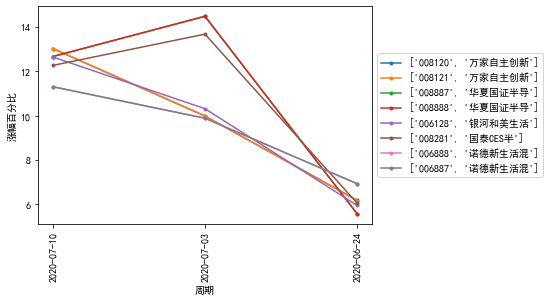

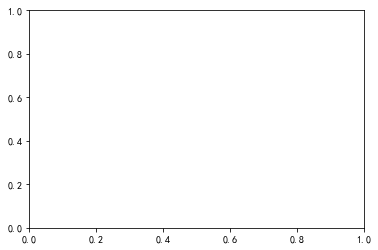

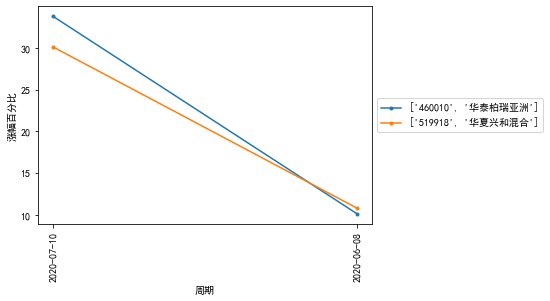

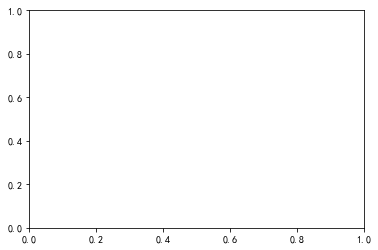